<a href="https://colab.research.google.com/github/nick-baliesnyi/self-attention-rl/blob/main/Self_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements and trains the Self-Attention model from https://arxiv.org/abs/1907.08027

# Definitions (run first!)

In [1]:
import os
import gc
import math

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.notebook import tqdm

In [2]:
# Input parameters
observation_size = 164
action_size = 27
pad_val = 10 # used to pad sequences to same size, will be ignored by the model, loss and accuracy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# class_weights = torch.tensor([0.499, 0.02, 0.499]).to(device) # commented out temporarily because creating a GPU tensor also occupies 2GB of CPU RAM

In [3]:
class TransformerEncoderCustom(nn.TransformerEncoderLayer):
  # modified to return attention weights in addition to output
  def forward(self, src, src_mask = None, src_key_padding_mask = None, output_attention=False):
      """Pass the input through the encoder layer.

      Args:
          src: the sequence to the encoder layer (required).
          src_mask: the mask for the src sequence (optional).
          src_key_padding_mask: the mask for the src keys per batch (optional).

      Shape:
          see the docs in Transformer class.
      """
      src2, attention = self.self_attn(src, src, src, attn_mask=src_mask,
                            key_padding_mask=src_key_padding_mask, need_weights=output_attention)
      if attention is not None:
        attention = attention.detach().clone()
      src = src + self.dropout1(src2)
      src = self.norm1(src)
      src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
      src = src + self.dropout2(src2)
      src = self.norm2(src)

      return src, attention

class PositionalEncoding(nn.Module):
  '''From: https://github.com/pytorch/examples/blob/master/word_language_model/model.py'''
  def __init__(self, d_model, max_len=250):
      super(PositionalEncoding, self).__init__()

      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      pe = pe.unsqueeze(0).transpose(0, 1)
      self.register_buffer('pe', pe)

  def forward(self, x):
      x = x + self.pe[:x.size(0), :]
      return x

class SelfAttentionForRL(nn.Module):
  def __init__(
      self,
      observation_size,
      action_size,
      device,
      embedding_size=127, # chosen odd so that embedding_size+action_size is even
      dim_feedforward=128,
      pad_val=10,
      max_len=250,
      verbose=False,
      ):
    super(SelfAttentionForRL, self).__init__()

    self.verbose = verbose
    self.device = device
    self.pad_val = pad_val
    self.linear1 = nn.Sequential( # TODO: add dropout?
        nn.Linear(observation_size, embedding_size),
        nn.ReLU()
    )
    self.linear2 = nn.Sequential( # TODO: add dropout?
        nn.Linear(embedding_size + action_size, embedding_size + action_size),
        nn.ReLU()
    )
    self.pos_encoder = PositionalEncoding(embedding_size + action_size, max_len)
    self.self_attention = TransformerEncoderCustom(embedding_size + action_size, nhead=1, dim_feedforward=dim_feedforward, dropout=0.2)
    self.fc_out = nn.Linear(embedding_size + action_size, 3) # 3 reward classes (-1,0,1)

  def forward(self, observations, actions, output_attention=False):
    seq_length, N, observation_size = observations.shape
    seq_length, N, action_size = actions.shape

    x = self.linear1(observations) 
    x = torch.cat((x, actions), dim=2)
    X = self.linear2(x) # S, N, E
    x = self.pos_encoder(x)

    src_mask = self.generate_square_subsequent_mask(sz=seq_length)
    padding_mask = self.make_padding_mask(observations)

    out, attention = self.self_attention(
        x, 
        src_mask=src_mask, 
        src_key_padding_mask=padding_mask,
        output_attention=output_attention
    )
    out = self.fc_out(out)

    if output_attention:
      return (out, attention)
    else:
      return out

  # from pytorch Transformer source
  def generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask.to(self.device)

  def make_padding_mask(self, batch_of_sequences):
    # batch_of_sequences (S, N, E)
    # return (N, S)
    padding_mask = batch_of_sequences.transpose(0, 1)[:,:,0] == self.pad_val
    return padding_mask.to(self.device)

In [4]:
# support the format of the trajectories dataset
class TrajectoriesDataset(Dataset):
    def __init__(self, observations, actions, rewards):
      self.samples = []

      n_batches = observations.shape[0]

      for i_batch in range(n_batches):
        self.samples.append((observations[i_batch,:], actions[i_batch,:], rewards[i_batch,:]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [5]:
def get_data_loaders(dataset, batch_size=1024, validation_subset=0, seed=42):

  if validation_subset > 0:
    n_total_samples = len(dataset)
    n_train_samples = math.floor(n_total_samples * (1-validation_subset))
    n_valid_samples = n_total_samples - n_train_samples

    train_dataset, valid_dataset = random_split(
        dataset, 
        [n_train_samples, n_valid_samples], 
        generator=torch.Generator().manual_seed(seed)
    ) # reproducible results

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    print('Train set size:', len(train_dataset), 'samples')
    print('Train set:', len(train_loader), 'batches')
    print('Validation set size:', len(valid_dataset), 'samples')
    print('Validation set:', len(valid_loader), 'batches')
  else:
    train_loader = DataLoader(dataset, batch_size=batch_size)
    valid_loader = None
    print('Prepared:', len(train_loader), 'batches')

  return train_loader, valid_loader

In [6]:
def run_inference(model, data_loader, device, verbose=False):
  global_preds = []
  global_rewards = []

  pbar = tqdm(data_loader)
  pbar.set_description('Running predictions...')

  for batch_idx, batch in enumerate(pbar):
    observations, actions, rewards = batch

    observations = observations.transpose(0, 1).to(device)
    actions = actions.transpose(0, 1).to(device)
    rewards = rewards.transpose(0, 1).to(device)

    output = model(observations, actions)

    output = output.permute(1, 2, 0)
    rewards = rewards.transpose(0, 1)
    
    preds = output.argmax(dim=1)
    masked_preds = preds[rewards != pad_val].detach().cpu()
    masked_rewards = rewards[rewards != pad_val].detach().cpu()

    global_preds += masked_preds
    global_rewards += masked_rewards

    del observations
    del actions
    del rewards
    del output
    del masked_preds
    del masked_rewards

  if verbose:
    print('N Predictions:', len(global_preds))
    print('Prediction shape:', global_preds[0].shape)

  return global_preds, global_rewards

# Load training data

In [7]:
# Load dataset

path_to_dataset = '/content/drive/MyDrive/Self-Attention/datasets/dataset-perfect-agent-1.pt'
dataset = torch.load(path_to_dataset)

validation_size = 0.2
batch_size = 1024 
train_loader, valid_loader = get_data_loaders(dataset, 
                                              batch_size=batch_size, 
                                              validation_subset=validation_size)

Train set size: 33399 samples
Train set: 33 batches
Validation set size: 8350 samples
Validation set: 9 batches


# Training

In [20]:
def evaluate(model, criterion, data_loader, device, verbose=False):
  losses = []
  accuracies = []

  for batch_idx, batch in enumerate(data_loader):
    observations, actions, rewards = batch

    observations = observations.transpose(0, 1).to(device)
    actions = actions.transpose(0, 1).to(device)
    rewards = rewards.transpose(0, 1).to(device)

    output = model(observations, actions)

    # reshape for CrossEntropyLoss
    output = output.permute(1, 2, 0)
    rewards = rewards.transpose(0, 1)
    
    loss = criterion(output, rewards)
    preds = output.argmax(dim=1)
    masked_preds = preds[rewards != pad_val]
    masked_rewards = rewards[rewards != pad_val]
    accuracy = torch.sum(masked_preds == masked_rewards) / masked_rewards.numel()

    losses.append(loss.item())
    accuracies.append(accuracy.item())

    del observations
    del actions
    del rewards
    del output

  mean_loss = sum(losses) / len(losses)
  mean_acc = sum(accuracies) / len(accuracies)

  del losses
  del accuracies

  if verbose:
    print('mean_loss:', mean_loss)
    print('mean_acc:', mean_acc)

  return mean_loss, mean_acc

In [ ]:
RESUME = True
CHECKPOINT_PATH = 'checkpoint-vloss-0.0502'
RUN_PATH = 'runs/run-1'

# Training hyperparameters
num_epochs = 10
learning_rate = 3e-3
batch_size = 1024
class_weights = torch.tensor([0.499, 0.02, 0.499]).to(device) # TODO: second weight might be a typo in the paper, consider 0.002

# Model hyperparameters
max_len = 201

model = SelfAttentionForRL(observation_size, action_size, device, verbose=False).to(device)

step = 0
start_epoch = 0

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=pad_val)

if RESUME and os.path.isfile(CHECKPOINT_PATH):
  print(f'> Loading from checkpoint at {CHECKPOINT_PATH}')
  checkpoint = torch.load(CHECKPOINT_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  start_epoch = checkpoint['epoch']
  step = checkpoint['step']
  RUN_PATH = checkpoint['run_path']
  del checkpoint
  print(f'> Resuming run at: {RUN_PATH}')
else:
  print(f'> Checkpoint not found. Starting new run at: {RUN_PATH}...')

# Tensorboard to get nice loss plot
writer = SummaryWriter(RUN_PATH)
best_val_loss = 1e9

for epoch in range(start_epoch, num_epochs):
  print(f"> Epoch {epoch+1}/{num_epochs}", end=' ')

  losses = []
  is_best_model = True

  pbar = tqdm(train_loader)

  for batch_idx, batch in enumerate(pbar):
    observations, actions, rewards = batch
    
    observations = observations.transpose(0, 1).to(device)
    actions = actions.transpose(0, 1).to(device)
    rewards = rewards.transpose(0, 1).to(device)

    output = model(observations, actions)

    # Reshape output for K-dimensional CrossEntropy loss
    output = output.permute(1, 2, 0)
    rewards = rewards.transpose(0, 1)
    
    # Compute loss
    optimizer.zero_grad()

    loss = criterion(output, rewards)
    losses.append(loss.item())

    loss.backward()
    
    # Clip to avoid exploding gradient issues
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    optimizer.step()

    # plot to tensorboard
    model.eval()
    val_loss, val_acc = evaluate(model, criterion, valid_loader, device)

    preds = output.argmax(dim=1)
    masked_preds = preds[rewards != pad_val]
    masked_rewards = rewards[rewards != pad_val]
    acc = torch.sum(masked_preds == masked_rewards) / masked_rewards.numel()

    writer.add_scalar("Training loss", loss, global_step=step)
    writer.add_scalar("Training acc", acc, global_step=step)
    writer.add_scalar("Validation loss", val_loss, global_step=step)
    writer.add_scalar("Validation acc", val_acc, global_step=step)
    
    pbar.set_postfix_str(f'loss: {loss:0.5f}, acc: {acc:0.5f}, val_loss: {val_loss:0.5f}, val_acc: {val_acc:0.5f}')

    model.train()

    step += 1

    del observations
    del actions
    del rewards
    del output
    del preds

  is_best_model = val_loss < best_val_loss

  if is_best_model:
    print(f'> Saving checkpoint with val loss: {val_loss:.4f}...')
    best_val_loss = val_loss
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'epoch': epoch,
      'run_path': RUN_PATH,
      'step': step
    }, f'checkpoint-vloss-{val_loss:.4f}')
  else:
    print(f'> NOT saving checkpoint, val loss: {val_loss:.4f}...')

  # free some GPU memory
  torch.cuda.empty_cache()
  
  mean_loss = sum(losses) / len(losses)
  scheduler.step(mean_loss)

> Checkpoint not found. Starting new run at: runs/run-1...
> Epoch 1/10 


> Saving checkpoint with val loss: 0.2714...
> Epoch 2/10 


> Saving checkpoint with val loss: 0.0840...
> Epoch 3/10 


> Saving checkpoint with val loss: 0.0618...
> Epoch 4/10 


> Saving checkpoint with val loss: 0.0545...
> Epoch 5/10 


> Saving checkpoint with val loss: 0.0476...
> Epoch 6/10 


> NOT saving checkpoint, val loss: 0.0505...
> Epoch 7/10 


> Saving checkpoint with val loss: 0.0466...
> Epoch 8/10 


> Saving checkpoint with val loss: 0.0454...
> Epoch 9/10 


> Saving checkpoint with val loss: 0.0434...
> Epoch 10/10 


> Saving checkpoint with val loss: 0.0405...


In [ ]:
!tensorboard dev upload --logdir ./runs \
  --name "Self-attention development" \
  --description "Training results from https://colab.research.google.com/drive/1yivILB8utI4a0ChtTrdFN57H1VFHpO0y?usp=sharing" \
  --one_shot

2021-01-24 14:55:23.372694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

In [ ]:
# backup checkpoints to Drive
!cp checkpoint-* '/content/drive/MyDrive/Self-Attention/checkpoints/'

# Model Evaluation

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [8]:
# Load evaluation dataset

path_to_dataset = '/content/drive/MyDrive/Self-Attention/datasets/dataset-evaluation.pt'
dataset = torch.load(path_to_dataset)

batch_size = 1024 
evaluation_loader, _ = get_data_loaders(dataset, batch_size=batch_size)

Prepared: 10 batches


In [9]:
# load model
checkpoint_path = '/content/drive/MyDrive/Self-Attention/checkpoints/checkpoint-vloss-0.0405'
checkpoint = torch.load(checkpoint_path)
model = SelfAttentionForRL(observation_size, action_size, device, verbose=False).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
y_pred, y_true = run_inference(model, evaluation_loader, device)

In [11]:
scores = f1_score(y_true, y_pred, average=None)
classes = ["Negative reward", "Zero reward", "Positive reward"]

table = pd.DataFrame({'Predicted class': classes, 'F1 Score': scores})
table

,Predicted class,F1 Score
0,Negative reward,0.749514
1,Zero reward,0.991619
2,Positive reward,0.727659


In [15]:
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

print('Precision:', precision)
print('Recall:', recall)

Precision: [0.60810483 0.9995487  0.57870869]
Recall: [0.9766173  0.98381497 0.97985745]


In [16]:
classes = ["Negative reward", "Zero reward", "Positive reward"]

table = pd.DataFrame({'Predicted class': classes, 'Precision': precision, 'Recall': recall})
table

,Predicted class,Precision,Recall
0,Negative reward,0.608105,0.976617
1,Zero reward,0.999549,0.983815
2,Positive reward,0.578709,0.979857


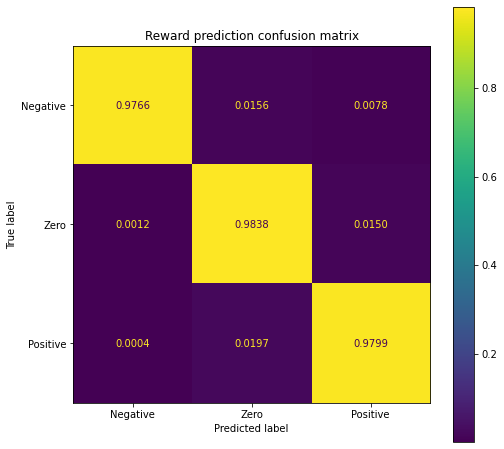

In [12]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Negative', 'Zero', 'Positive'])
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Reward prediction confusion matrix')
disp.plot(values_format='.4f', ax=ax)

# Visualizing attention

In [8]:
# load data

data = torch.load('/content/drive/MyDrive/Self-Attention/datasets/dataset-stop-before-fire.pt')
data_loader = DataLoader(data, batch_size=1)
images_zip = 'stop-before-fire.zip'
!cp '/content/drive/MyDrive/Self-Attention/datasets/$images_zip' .
!rm -rf images
!mkdir images
!unzip -qq $images_zip -d images
!rm $images_zip

In [9]:
!pip install ipyplot
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
import glob
import ipyplot
from IPython.display import Image
from IPython.display import display


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


In [10]:
images_paths = glob.glob('images/*.png')

def get_path_to_image(episode, step):
  episode_str = str(episode)
  step_str = str(step)
  for path in images_paths:
    _, path_episode, end = path.split('-')
    path_step, _ = end.split('.')
    if episode_str == path_episode and step_str == path_step:
      return path
  
  return None

def show_image(path):
  return Image(path, width=600)

In [11]:
episodes = []
for i, batch in enumerate(data_loader):
  episodes.append(batch)

print(f'{len(episodes)} episodes.')  

7 episodes.


In [15]:
# load model
checkpoint_path = '/content/drive/MyDrive/Self-Attention/checkpoints/checkpoint-vloss-0.0405'
checkpoint = torch.load(checkpoint_path)
model = SelfAttentionForRL(observation_size, action_size, device, verbose=False).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [35]:
EPISODE = 2

observations, actions, rewards = episodes[EPISODE]

negative_steps = torch.where(rewards == 0)[1]
positive_steps = torch.where(rewards == 2)[1]

observations = observations.transpose(0, 1).to(device)
actions = actions.transpose(0, 1).to(device)
rewards = rewards.transpose(0, 1).to(device)

model.eval()
output, attention = model(observations, actions, output_attention=True)

output = output.permute(1, 2, 0)
rewards = rewards.transpose(0, 1)

preds = output.argmax(dim=1)
masked_preds = preds[rewards != pad_val]
masked_rewards = rewards[rewards != pad_val]
acc = torch.sum(masked_preds == masked_rewards) / masked_rewards.numel()

pred_negative_steps = torch.where(preds == 0)[1]
pred_positive_steps = torch.where(preds == 2)[1]

print(f'Predicted with {acc*100:.2f} accuracy.')
print()
print('Positive steps:', positive_steps)
print('Negative steps:', negative_steps)
print()
print('Predicted Positive steps:', pred_positive_steps)
print('Predicted Negative steps:', pred_negative_steps)

Predicted with 98.90 accuracy.

Positive steps: tensor([49, 87])
Negative steps: tensor([90])

Predicted Positive steps: tensor([49, 50, 87], device='cuda:0')
Predicted Negative steps: tensor([90], device='cuda:0')


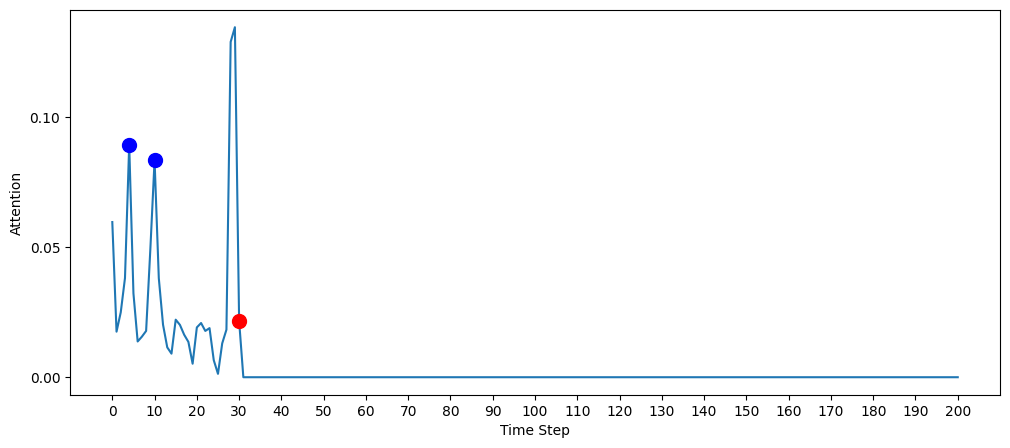

In [80]:
events = [4, 10]
now = 30

weights = attention[0, now,:].cpu()

with plt.style.context('default'):
  plt.figure(figsize=(12,5))
  plt.xlabel('Time Step')
  plt.ylabel('Attention')



  # binned_weights = [torch.sum(weights[i*5:i*5+5]) for i in range(len(weights)//5)]
  # x = np.arange(len(binned_weights))
  # plt.bar(x, binned_weights)
  plt.plot(weights)

  plt.plot(now, weights[now], 'ro', markersize=10, color='red')
  for event in events:
    plt.plot(event, weights[event], 'ro', markersize=10, color='blue')

  plt.xticks(np.arange(0, len(weights)+1, 10))
  plt.yticks(np.arange(0, max(weights), 0.05))
  plt.show()


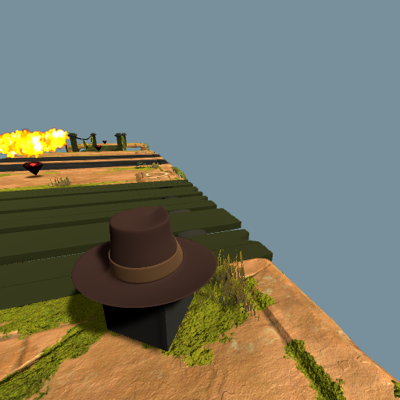
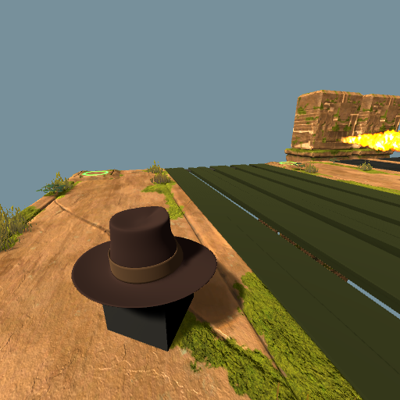


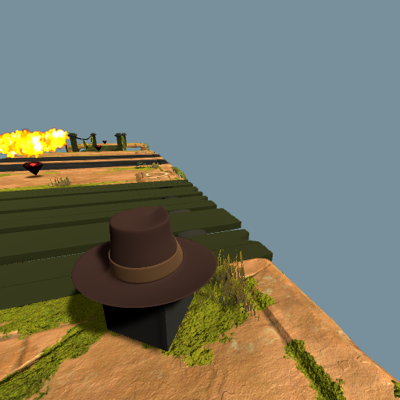
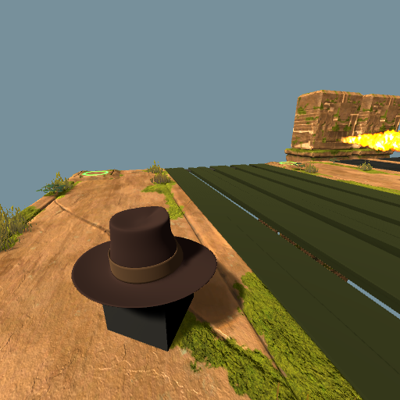

In [84]:
images = [get_path_to_image(EPISODE, event) for event in events]# + [get_path_to_image(EPISODE, now)]
labels = ['(A) What is relevant about this?', '(B) And this?']

ipyplot.plot_images(images, labels=labels, max_images=20, img_width=400, force_b64=True)

In [85]:
html = '''            
        <style>
        #ipyplot-imgs-container-div-5s3E62uZ2mePQpFGm2FUYw {
            width: 100%;
            height: 100%;
            margin: 0%;
            overflow: auto;
            position: relative;
            overflow-y: scroll;
        }

        div.ipyplot-placeholder-div-5s3E62uZ2mePQpFGm2FUYw {
            width: 400px;
            display: inline-block;
            margin: 3px;
            position: relative;
        }

        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw {
            width: 400px;
            background: white;
            display: inline-block;
            vertical-align: top;
            text-align: center;
            position: relative;
            border: 2px solid #ddd;
            top: 0;
            left: 0;
        }

        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw span.ipyplot-img-close {
            display: none;
        }

        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw span {
            width: 100%;
            height: 100%;
            position: absolute;
            top: 0;
            left: 0;
        }

        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw img {
            width: 400px;
        }

        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw span.ipyplot-img-close:hover {
            cursor: zoom-out;
        }
        div.ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw span.ipyplot-img-expand:hover {
            cursor: zoom-in;
        }

        div[id^=ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw]:target {
            transform: scale(2.5);
            transform-origin: left top;
            z-index: 5000;
            top: 0;
            left: 0;
            position: absolute;
        }

        div[id^=ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw]:target span.ipyplot-img-close {
            display: block;
        }

        div[id^=ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw]:target span.ipyplot-img-expand {
            display: none;
        }
        </style>
    <div id="ipyplot-imgs-container-div-5s3E62uZ2mePQpFGm2FUYw">
    <div class="ipyplot-placeholder-div-5s3E62uZ2mePQpFGm2FUYw">
        <div id="ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw-GJeCA5RV4XvgZMUdRbtKHu" class="ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw">
            <h4 style="font-size: 12px; word-wrap: break-word;">(A) What is relevant about this?</h4><br />
            <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAIAAAAP3aGbAAEAAElEQVR4nOz9abAt2ZXfh/3X2ntnnumO79031ntV9WouAIVCowE00N0EeiKabHaLFAcpKFF2KCiHbAUdoQg55C+0FSF9cDjCtoIRLdqmGLZkU6JlmkM3u9nsiY1uNNGYWUAVqurV9OrNw53vPUNm7r2WP+zMPHnue1UoAI3hAvsXFfXOzXNyPCf/udbaa69F//l//feQSCQSxwH+fh9AIpFIvFeSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEsSEJViKRODYkwUokEseGJFiJROLYkAQrkUgcG5JgJRKJY0MSrEQicWxIgpVIJI4NSbASicSxIQlWIpE4NiTBSiQSx4YkWIlE4tiQBCuRSBwbkmAlEoljQxKsRCJxbEiClUgkjg1JsBKJxLEhCVYikTg2JMFKJBLHhiRYiUTi2JAEK5FIHBuSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEsSEJViKRODYkwUokEseGJFiJROLYkAQrkUgcG5JgJRKJY0MSrEQicWxIgpVIJI4NSbASicSxIQlWIpE4NiTBSiQSx4YkWIlE4tiQBCuRSBwbkmAlEoljQxKsRCJxbEiClUgkjg1JsBKJxLEhCVYikTg2JMFKJBLHhiRYiUTi2JAEK5FIHBuSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEsSEJViKRODYkwUokEseGJFiJROLYkAQrkUgcG5JgJRKJY0MSrEQicWxIgpVIJI4NSbASicSxIQlWIpE4NiTBSiQSx4YkWIlE4tiQBCuRSBwbkmAlEoljQxKsRCJxbEiClUgkjg1JsBKJxLEhCVYikTg2JMFKJBLHhiRYiUTi2JAEK5FIHBuSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEsSEJViKRODYkwUokEseGJFiJROLYkAQrkUgcG5JgJRKJY0MSrEQicWxIgpVIJI4NSbASicSxIQlWIpE4NiTBSiQSx4YkWIlE4tiQBCuRSBwbkmAlEoljQxKsRCJxbEiClUgkjg1JsBKJxLEhCVYikTg2JMFKJBLHhiRYiUTi2JAEK5FIHBuSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEsSEJViKRODYkwUokEseGJFiJROLYkAQrkUgcG5JgJRKJY0MSrEQicWxIgpVIJI4NSbASicSxIQlWIpE4NiTBSiQSx4YkWIlE4tiQBCuRSBwbkmAlEoljQxKsRCJxbEiClUgkjg1JsBKJxLEhCVYikTg2JMFKJBLHhiRYiUTi2JAEK5FIHBuSYCUSiWNDEqxEInFsSIKVSCSODUmwEonEseEHXrCYg5J+v48ikUj8IPCnJliqUABEAH3nWxOQgHzQcOv6wzdf5PG+ggAoSECKJGGJxI8i9ltdwSuJkmVlAFCAFOorXx4eqIKddaTU61vrvr0DUlDwWNYS1fjj1dc+8sh2/ih9/oXpb87eX2WDgfi+0XJWVmwq5wz/KYhjIpE4LnxrghWqcEamJ3rVldlwlzMwVUWhh1untt5+qrjO1r+Ns+PeqFo+Va2dsi5vVxQwoAQlaiRGjxpJShQUxodnsjf+/UvXcn0NTwzw1EdQTT546/XPfHl0ZgMff+zWcyu0dcDXcfo33j695VYdI4ABGMh3dCUSicQPPN+CYIWASyf3/8rzL20MX3355ZN3rj5aTXrB3n35xvSjj97+yZ/fwt7Nu18891u3nirHs2sG49Xz1jAAr7Th933QHfSVREXVOJeZxkYDQCGEoZ+uavn+/pWf+cXfN08Afgf254H/Odwra09/6d/a/PrzP2PwzCXI+RMDPRF+6uSXb/yPX9i5WdhLYaeAue2WksGVSPxwsyBYMTYkoqgqZTbWMJNU3iCAmPamP37ptY3n7wJvPnP6pWcOd0AedPkT/2DoNpbwkwHb5anD2x89XFoP914Zj3870HT1tBKfK7f+8pmvDc/fndKGvp3BXp/R6m+9/czt3mnNhgJCVXyI733q4q1Bb7zafxkP30QJXN7HhS9iZRN4Bs/9yvNPv4TlnwL+PaAHeJjR+Y9O/sPlf/nlz3z1o89f8bvjv/fCR7azdSamxTia6rdmeXVX/1bXfZdNxa0R8fyv+2zMRCLx7lgQIYbMVbmcusqfku3zfGsM89b43KbZ+AsrL3/qz451p//b/9Ptld2bwDXAY7nC8svACG9Nlh8u4QO+VqFPyPefeuJrVPVPye0fD3d/5+AZpd1f+vkX3TOC5XvADH4d3yjxyuzxS38c8vXPvf7823zmA8X1xz/hl3/WQAuMp2DCzgynehh9FHgYMOj9O+i9AmwAq52D768//eFfeOwVuAOMP/833/7sr979wIFsiHmK8tPQAEBV8/4Iqu9Reog4+NL7kkCi4rK+MebbUxYiDqEKVRl1K0jIe8NiNiaCqhJRlg+/Q0FMJH7UsEXlQQxfrswOPjW6cvKh3WcfepmHtzDG5TfOv3Tr0U9//DU88gieGv3K6buYFvDLsO8DDoA7mG1jn3AqIBxiv8BYsBxopcKGx/poMJj9Wze+DNnC+wXIAAEmcCWeAq6WNrB9ePtTl24gM7hqceY0+CdBl7BSAXsYBPSehvnPgUeBAgjAY4BfPHgPnIX7GPAVSHni4VV/56fffuNf3Lz2gs3XorPZy/tPPv9zWX+UD0Yi30QdiBgqb3ztj3bvXjXG9IbLF5748Mqpi6rhW72sRByCf/Wrv7dz+wpb6ys5dfbhUxeeuvzVP2AmIjpz8emzj36As979sbxEIvFO2Ge3X9Vq9qQZP/zc5qM/cR1nrqG/AyXc4Scv7T7Jr+L0o6gsQolHN4CAUAAXgHXgDYSXgJtY9ygLzDwqhVE8ZnByHfkZ4ARWKkCBEpgBgAZA0BvgCcYrJXqED44BwsPAxEMr0CeBIXCA4S7wODAGBGiD99niwY+BN4DfAf4Qr+Zf+eITV99++82X97QYE49VAejM5V/b+WejE2ef+tjP5v3Ru1g0ROSr8oXP/u7Vlz5vOPigg9HKnbdvvO8nfub0o89+S6YQEamEt772r99+4YsSKmIKXkwpd95882DnzmDQg0InpXp5+LmfDL761r6xROJHGPs33OepfyN/fhc/ETAQ9CdABqkwEpDFfgUsofcTwAeBa8B1mLehq6DnAcXBS7jjMayQKzKCKvqMjTVkZ4ElwAI5sAR44C7gQVOAgV/Ckxdx/jVc+RImdzDoYQVYeR/wN4BHgc8CI8ACI+BLwHNAvzlaAW4By8ASEIC3gFvAl7B3Fy8/eWfvzOd+/3dnfpYZS0yZc8NhX4JO9rez/jD4CkR4Z2tGVW3eO3FiZXZi6drtvbI6OBhvf/wX//2T5x/7Nhy3r3/+D//NH/4WA4N+L88za2h3616/R0tLw/2D6eF0//RTHzr92Ack+G++rUQi0WB7H/sSDkt8AliPEeIM/iRuCPqbqATTAcxt4AvAGvDnob8NvQ55BXYE7GDgcHKI6TYGCgvMgGXATYA3gS3gOeAh4CwwBj4ErAM3gG8A/3swYen/iifuwRKqA5SPYPhJYA34deAzwD7ggFtADvwrIABPAucBD/xPQAb8J0AJXAHeAnZhR3gKvzh65X87ed/fe7W88vKXCDIpafcQRAjBPvTcJ1dOnApB5B2CWUTENtt86+sH119ZefhDIfvs228FInKZdb1BCN+yEfTk8x/JB6PXXvjs7bcvG+eIiJn+ys+tSyi//lK5+drUS+gNl5N5lUh8S1islfCAAaBAD1iCnsW5J4EM8hqyK8BNYAcogOvwf4Tg0TsFbAJvI9vFmQozAwt4hQvYAGgCACiAW8CngFVgDPx54HHgBvAF4Angc6huY3uGM33sCe4IntoB3cTsc6BvID8EHDABXgVeA84Dl4CLQA/4V8BrwArggH9Ze5oeGB7yo9Xf+KvZ9Lee/Ttbb092bjEbZnLW7O9Nv/h7v75589ozH/7o2smNbLQefNXG0VWUjS0m+3s3Xrjxjc8/+YmfKaZvffjJ7L+7bkXk7vVXLz71IWPctxR3V9W8N3z/R38aMj7YuQooETPjzbfK06f1sUt04ybfePOl53/ql+9bsTuMmEgkjmJx6QIe66N3BSDgBMBwQ2AN+GvAbwBfBALAgEK3EV4BeWAFuA58DXYbJxSVgbMoARYMKtQJnAocABb4NLACLAEATgJ/DrgH//fw4hdxcIAA3FRc2YK+iCefxbU7GG3ibIx8FcAe4ICHgRvAW8AUeBnYBP4zgIACOAUJ2BRczzEg7U0hygxrDZMhJoWeOHVi7fST+3v7v/uP/t/WuuHy8lPPfWjtxAkmBAnDkxf2rl/evnZ5++6t9//svyvYvvLCr/WeXiZiJgXxu3iR74r6qlw9ebY/HBbTMRMxc1V6UgPypzfMTOvx2UVSHlki8W5YnPoF4Eng/wFcB3JAgZeBrwCfA04ApxorZhO8jXwLFIAvAyeBMazCWuQWyJAD0CYRdBkYAgZ4HUCjVvGtHvAWim/g5etwfVxawrjE3T28fRWnfhuTe9h0cAVGFXpxFQJ2gFvAy4ACHqiACvBAwJ5Db6d8/aHf+cIv3VSz3z+xffHiibWv3tq/bayNWfXWmic/+LHTFx6fTsa7W3evvvrS/ni2u/PybOsPDiYbewe5Qbm6cfrDP//X184+cuv1G3t73pA1phTm4Mv7bStiZusqVSawiPh3jEOJ94ZgDRMzQNdvmYfOweZmODLloYaqqJ8E7ZYfIGGJRGKOBTaBEmCgBHYBANsAgKvAXwc+Dfz3wC72Ciy9hqwCGNgEDNCDZqAMyIAAeMACCmTABwED7ACbwBXgIQAAATkwA95CxjhvsGvRG8DMAI89wStvg6fwOf7NIQaMj+RwAO4BV4Fo1o2BErDAKWAb2EM+Q15dOzn8onv/YT9jFce0vH763o3LRERMUPhqNjncMdb1B8P+8NK5i48R8cHOzVf+5Guf+DO/uHzqwwpAoSq+mg3XLiytPTwcHi6v0MGBuf32SxIquLyVFSIab29Nrr31gX7vblne6y+tPXLpgUKjqoPldZfnvpyBCIQnP/iRKvxxNXGjobl9b3/z5hunLjyd4u6JxHuHgVvAZ4FrTdb7DIjRdwfMgJ8DfhnIMBpgO8dtQkl1rjkMyAEZ0G/WjflKp4HngKeAE8AScLC4x7eBm3BP4yfP4pOElbtYmuLECk6cxExgcwwsEOAsdKl2UbEPDIF1YA14BvgIcB6YAQa9MWY4/eLV0/svKTGTqoSTZx+1rod4Gszl9HB38zqzUVWVmqy/RGb59S//v8rZjghEgqoyUVGE8aQaDGCICETgezff7DpqZOy1N1/7p3//7/763//Vf/bf/urm7RvG1rMFFKzgeZa8hPXTF102FNWYm7tz72629olyNhsMQEzNdY7FJ7r/xaIURsHxdfux7+IPIZE4DjAQoGNselxW3LUIMWmAgeiwrAJngNPY3MLlgDcdJn1gAACYAQGINlcW4/bASeCDwAawD2wCu8C1zu5K4CLwHwH/O9j3Y/UEWHFG8Rc38PgSqMK0wOY+CDidI2OgAixQAgpYwAF3gU3gGqDAELCwGJ3aPz+8itDE0dHc5gAUxrn9rds72/eUe5YmDjsuXAkiNs92Nvf3bn0R8B6mClKUZX+48eOf/IV/86Lf2QlEIMbezm0gAIFImUBSPf6B5y797C/83rR8SXnt4sPWMBOIaCP83mn/OzZsEzERiJQ0iAhF80x1vL+3evKpKvi794rlkRI8o2AUGVXd/3osQ55eOviHJ/zXLSOjUqRglBkqIigZEDfOciLxo4WF3sP2IXZKyDp6fRgCLFAA+0APeAH6jzHZxp09lMDZJQyjeTUDBBgBQ4AAAwhAwHlgBLwIfAU4BE4BV4ErwBowAExjka0C/zHwt8F9nCzgtjCcwW3hkCEe64yeQBU0BBzQAwSogBIYA7sAAznAOATeIJCed5u9auLznigeeuxDL/zRrwVfKhERFOx0etrc4XK8X0zXR6MNvDwZfXS88ejBja/u3r38Z56QPf3p6t4rqA6KYOzo8mSpzPvwpQVw0o2fwGdZjAYemVxUhfH8py/+evHQ0pmLn764I9WfDHIrEM5WSJX5urM3lVShmbVfGvr9bWIggIZ0+Jz57BWbZU6KanJ69puf7J1U0dP5soiykmFm0H5RwGPjYXdv+qrl13rOfvbtg6dO9E9Z96WDR14PFw6JBvii5j8tyJFqVCR+lLCoDCjg8SdBPwZcBq4BJWCAEfBZ4C3s3Mb1XYyB9QyPCNweUAEB2AAeBQbAASCAb4LrewCaoM8EuAz8P4GngZ8Gznd2fQ5YAlnYHGELG7vIgK8AzmBAGBCUQTnQAzaaiJgFGJgABEyBEn/E+JNlYG9TT01OLLGfmsNbsx7zcpNarwBxdbi9Mf3dYRmms3Klyj/wxAnCb9nl7fG5lZ0br+2+ffgr79/fLPnVzcPVgbOnJ197DSpQgirMzmsf5kulIRD32EgFCQLCB/7yR1RCOXnLWSw5owbMZIh6xhIxjK8qLWfhYw8P3rzJChim3cPyD1642e9x3/HeOOzvyCPLQ6moDD4EZWNIlIlube1dv1Z98IlTK0ujMBWqzM+cyQ2Z7epwQ79s5UVv19E/fOPgt8vez4H7+HYHMhOJY4eFA1YugT4OvB9g4BqwD/RxaHHrCxCL6V0MFAcWuYWZACUQrbAJcA3oAZeAfh0FxxZQACuNSyjAAJgATy7OWwbwGPC/AX4f/OvgG4BiGJAFnAvoK2YCWyI/AFngBDAGxgjnYM4AAA4Q3sLlArfsN24+8k9ffuFP3Fc+9mP00IobmUml5uD08F/fOSCAoIbpxs7s5pb/0JPLj86G9/Ymd++V1K8uPGrya+bMOfx/v/Dm7cnMhd7mYbU6JL83/drXZ2XhYHT5QC7/yd1/sF09nfcvZr3fmByuvL/nVjPxWpbCBDY0mRQiQqCtPZPnGbH6IAD5KszKcOXWfptYNavk6mZ5/gI8MBygHGPvFu2PA5MBSFWhxIrqIDc2XL69+6zkPWf39mdgWhn2Jbhv3DxcH1UXcn4zPDerrgb/Yrb6CZXye/mLSSS+j1jQCOYngDvAl4E9YB3Yg05wW/E6QysMZlgluBnuEJ5uHuZiwRbYBjxwAngMuA28ARjgYQDNBMBNAMAzwMeA4eKuR8AnIZex2QP1sUQoLPQAq0tYrVAeIDsERWczjgzsYfcs7KNY+WVgD9f+B3z+BewfXHnoo1/wz37l9//H/+BnHt3Btg+jU37tJPJuhCfPzJcv31seyt1pdW4w2LkeyOToZ88snfv9t968cVV/bev6hx45c2FlqCt7L786e3R1fTbiV65M9u5OM+de/PLmpROrL8neP7l1N782XHlqBQIVNUxg+EpFtSpCUSkTxboXqgAheNnbmWXWgEAKZowLu7+vyyO/sexOevfS5a1ZISAWoJIQvFRVmFZVJYGN2b6rAhVRCeHSo8NTp/KN5f7eoR9esA9Xb731tu6XL9rh+8gOkao+JH40sMCzwC7C12BOAgGYAiNgGzyGJzhFADLFI8AdhQFAUMIswPRhz4EMRGFfBmLK6CEwBR4DTgN3gfjwfx/w6IP2/jb4D3DqLeACkEHP4nHC8gj0ReQ7QA9Q4ArwMgBsXXj794zbvNz/+O9BMP2Mu7f52J3B2T8e/dho+av9HDeujkd26c39yZumWM+t95plpPVYIXRiT043Siq+ePdaOSlC0LGWzprVgfEBFubG4d71/d3R3aWJ2r0xnDOnzw/fHFe3t6bO8BeuTwR6SPp4ZoYTDaLWsOsZKJzBZFwZNiujeHWgqlnPEiBBc8t7u4USAIiE0o9gCbjVy3rr5x/Z5qWpq4oqzLyfofIMz1KwlPC2P1o/99SsqALMbPvmq5/78sWVPHN22LdXXj28d7h3zzwxWFuWUBg7fNC1TSR+CLHABeAmDm9D97B6DsiBMSjDqgcJPCCEHcU5xTqwA6wxiOAE17ZwDXDrOD/AwwG4AUyBXeCPgbvAXYCbYPzngM8D5wEBLjTjiTvAv4CcwPYpnBwDq+g/jf5DKF8E7YIVCEAJFECB6yf/+F98/DdeuzDYfPPSn3xtRcqtU4++uPGxkA36gwGCZ+Ctg51+zluYFIVf0dEj5/vX78yYCaoM3DmcffmtO8YWd4mWH/0JzgZFGXZnkrEuv/n/ywYDl/fG47BT9vq9pdNnSAREsJl94Su3d/drn2s0cmfPj4IXZur1TfBRn8BMIJRFKMsQU7LKUqoqTMblZFoyGwYBCMFvPPTEQ48Nt966cnsvHzzxgXz12Vi3i+LIK2GePaoqEvogMma8ekbG1wc8sc4y8+5hyW548uKHp9Promq+5z+aROL7hQX+FrAFu41rvwOpsH4GsBAHNugHXBPkFncEIw8IrggOFecFhrCv+Nfb2FA8cRFYbeypHDgEXmoC5AAUuAn8LvCzwAxYB5YBAK/izpdhFdtLOHkLeAPYBH4ZuzOIIjP4osP7PB7yAE9fOf/Za89Ozp2aLK8fTHYHUhZrZ6i/7FSDrx469/idC4+Us3BqOHKUU6YUyPlZ6xUy0/6s/NJrt86ePLnx0V9Zu/Q8JCh0snv11mt/ePrshrEZiAYjqGpZVuNDicdtDD3x1PrlV7YODypn+QMfOk2AcyaIhqACSFARLasQlUuh02kgBlsuSl/4QExB1YtGg6soSqUlJR4MrCEgSFtsS4+kKsQChFBSJQ2HRSmDALZBxHssLbvtrZdp+lV39tOGNoKKvnsxikTihwILnUIYw5/AE3cwfg3lFrIRLvdwc4Yqx4rDaob1DCKQHYwKbBRgAIoeoAIeY+N54AzwOnAK2AHeaFK0FGDAIuzAfA5YBz4IXAeWgBx4C6HCN2YYKjTDDMhvg38fYRWfPwXs45UcBxN8UrDMfnaCe86RmuUVXVqJs6tJBYBKcOsP27ULn3vlj/7G2sf6TMYg7/HAjCt/aJiJQApR2psVT118ZvmRZ/e3rtx9+/M7t79BgEjl1VWl7OxOicDECiUlEQVhOLAbp4eDUfbiC3cvPbk2XMmqSvqG+46CBxFK7yE6sAaABJ35wFVQ0d39QgSZ4+GwtzzKB2xK+Cr4Ed1cHn5w8NAzlJ3I7abhm4QgkHr+T616YIST1RsamA0Iqkt845xZ7/PJtWzUtzmbpbVRtrc5uTsemCtcbZ9Yyr4xO3VTNpgkxbMSP8RYbP157FhcWoGx6K0jbAMTnOlj7FAJPvQEli5h8BHgFHZ/GwefweE19GYAcFpwUnB4gMMMo8cACxwABWCBqrEVLPYymCFGO8AfAS8De8BdwAArOFfg7MHBr1964V++X3aXP3Lmpf6zm7M3R5/7+s/mZvKkefvkjTv4xnC8eeEfvPXJa/1TGYJXoN40NS9QBXP65GN3zBdFYViznJd79meePX1vMs2dAZSJmGm5t3rh4nB8/fcPr34lr8oLQ6cAwV1Y7Ssp82pRBhEhVq8KRYAejKtZwBrnp37s/NpSvrE2yKx5aKm/2jOAxkZAjtkaZiZmiulUec4+iJCyQVA1ou9/aGWrHBfqA3zQz8npYZCpyIukL2XGeHgRQJUJQZWJDn05U1o2fWu5P+wN8uVxf6OqYEGjnp1U4eBg/2Nry7v02P74llR3Lw5GvXC7ome2i75myynRIfHDii2+sX5wd/XkBQfTh3sdEGCGVeDDFyED8EngPwQ+DjisfhSjHWzvYcdjoFgLeFLxm4IvfgY/swnsNSmdMajCgOIgQ0E4EafLvQ18Hthu7K91wEHCztWf/L3x+WzQ2958dvrS3YPp4E3rAq2fm4Ufm+6vfSW8uS9m9OLH7GvMJCogrSRUCMzYL0pwQKALz5aPnjzT7++5jDLHed+eCviPHj3dR8/BDY3rZbafZQjbKsguPR6CssKL+iCnBnlQFZEQxHtRVgEyZwAUZRhPfVkIE/czu5RnPWesZZFgmVSVCNaYWPVYVImgitILQYOKsSQqRNg/LDLYAedEALEhC0PMzODc2jjrEVBRZaK7+5OvX9+8fu/w8TOOey743tQ5lDKblMQ0m/iy8j3bX1pfNsu+ZP/o0url3XslTx7f3fzHr7oLP/nXxBdap/on5Ur8UEF/5//8X26Ww3/7fW8/9lM7+sYe5/sZrjvn8VQFXATOA38V+CWgh+oy9CvY+5d4/fPob+ExD1T49YDLjGeApxlDj40MpkAuYIFXzBQrCuTACGCIQCfYVRwaUMBqqF45+fIfPzXtDyDqYaoCRGShIaDyYF/lCs1oYImhRE35PVJRGCZmAsPlDDaDfu5FQAiiUCUhEyyEoSAlgJjqljpMFABTT5mBginGuCEhqEAtkTFsmZgVgDUkqpUXESXAayjKIKpl5WdVUIUxxMYQoQgBABMhNpgNqgLn2BpiJjYKJgeXkRUSIdk5LERALMZpbg1BXUb3Dmdfv7yfQ4cOJ9aXRkujceGXsnzYt4C5tz/dH89yQ44NEd/xez3jrNMDKeAxDCO/+vg+L5PNvlGc9uRqPzOR+KGA/rP/y39LBHif++nMDodavH/85l/6S18wz70NFACAS8B/AJwtf+ML17aGK+F2CDem65PsrD+1tF2aQ/vCOJsc4HQJCtgBeopnBGuEymFoUFi9MyRDeLyAV9wh3Nbd314ya54eyW688eiUVphEVVXV1KYGlEBAECgIqgpVqA+iAiUlAjMDICbDxhnDTFCoatSUEJSZrSFlnYaqQMWsWUZKykSGiRjKQkarIEEV0KBSjg0TKUCszpBCQRCImGDZbO0VvhKBrrpezpY4VsxCZrmXMRGp6t1iHAQ9azM2YkJ5wOUYQVUlGGJmiICUc2PY8MGkrDyMYcMkCgV70cqrDyKqPkgZhBUiKgpRVbbGGgV7hYnBLlGyxgt29g5evTXeLzRzViUYQ2eWXcX98qGPblx6VsK33EQjkfjBxBrS+G9llwz0AINyaUiPbwMByIGDZoxv4+DeG/+fr6+ccAe6MXPnVou75sTXluRg9dlRb3S4feHwbnZwIOPAj8/gK3grb57aevPEznZv95o+dXJr5dMezyhcQLH8hjuHMZk38x0ioW3mAIaoCFQIxEpkjIINgsI5pkyZyTB8QcNq2AuDnf2CQBK0Z5RYQTCGe7klgodsTQ/3iqkGnM2GzvhZNfMAM3mFIe5ZKlQqFVUpglhDRBCFF0aAChR0KAqloJhVJESkWgRXep2U/pAdq5uUXgRB4UPwwVc+qGoI5EWIKlHvVcEUBTF4L6IgKqowLoMPUoZQevUKVfIilSgJB9EqaBWkChpURKGKGFCL/ibViQ/zVjtMpKr9jMvSH05mg37ObEAURAG9eHtMzOsPPw1JmpX4YaDbSFVBzODMEIc+cBuHBChGW8BXgaeHveKD+U7Wz/hwyJ8XwI11JWOaiZnqaT856f10lF97ON/FZoHr9msvuhcDP56tmYfd5Zv40L09+9EZ7mVbr66OXX9sqpJmxCDSk3boxAn8ILcKlAoV8qIQkCILNDmoJoUXxaRQ6RmTcxV0WnkvUu5rCMEHiOr13bJSnVVhXJaHZVV4GXBOMCqoBJUPIBZVFQ1KQSECUeWmXzTxYUxS96JBAdUAqMJX4lVDkKAQEQ+IwocgSkFEQSoqdWfUmG8lbYpCrTIEFXB0PVWJCND4BxFBlerSyFonykdNoqhHIGJWZWKQxHHPmAOhUVyBopJeZqqC1ft8YK1jIuTW9DBbu/P5SZ71T18iSGopljjuWGZDTESsqlQccFVevvqVP/zb47XeyZd3s4cGxaN/5dCdnepr13aunN1YH5aiZSWFVw3VdFZtl7K5T87QDeZZMFqc2dy3K9nh5mHvd3ZWp2RmJ2aOy+kk7721uvFSNf3M0me+1LtjgwGubPvbewUTQphWXr1IJSJCXsQHDaKq8EEMk4JEJHpGTBRDURLdxSYlAIQgMe8yJrgTANEJiGJHwqgDUFD0+2JQWpSYY8kqIgJzDH6jGYJUUQAiQu3KiHrDBOJY1soQAcwMUgWFEFQRJCgAJVURUVUJQrHqctyXiVVomBgwDEMwTExgImeZACYihmOKb2WW+5nNM9tzxjIMIXOcW84sQ9UaPrHkbm1NPvzI8srQWYOBM6o4ObRir/1uufTCzjAf9ChpVuI4Q//Jf/F/mI4Pxnu7BPC9V8udW3fGWgUqg/gQROS8kRGLWLOf9UqvuxMPIKqAgqKCqEKgUCVmATkVAMLMQFAhkEId8JANt72ZCIwhFaU6Oh2LKkQxiBFiqo2TTp3PKByIGgVlEKAUxagxWAjRKGkmyGhTIy8KWK1T9TGLqCIqIAMQFdE2c53jbGQi+CBAXfaBmiMAlAmGyTBnBj3LzrA1bA0ZQ5YQHVhLsARrOHcmdzBEzGSZmGGILUV5gqhWPqz2bT/jvjMro3yp74Y9N8gMkTJQVd4ZGuYmtyZzrtdzFlQpDDM7YyRsHxS3dyYgWMsHk9ILRoOsb5mYe5ll8RMz+vz16svhCbt2jr71vrCJxA8I9JOf+qnZ4cHh3q4CSkYUlsk5E7XCMClzEIUIqzAzMcW06hhTqb2gNrwCAJBoWoAIKqqtDlWihmoxiS23ogjFf7l2meLkYeXoTdVhcIqfUY11smpF0+gU1YN9Gk2vuLe4daqFSTUO3hERwFBLFKPvA4eBM5lh58gyZdYYVmbKDGeWM0snh66fsYmmFCmBnGHLsfu8BBHH5AyIuJ+xc1mWmZ7jfm6GmRMRhoaqyhz3HUO17ubRCCATDBER708qr7CGes6CWUmt4RDUB/FBDg9n+9Oq8OIFYBZlY82kFK/wUl+TopRpJaViKafN3fFrd2eGDROJwhha6dtTS/ZaMVr7wM9Ugw1NIa3E8cTu3b0NYpfljqNwKIEbBwkCqAgDyqRKXlUDVLUN+4polDCqNYWCijHc2EjK8aVCVRkQ0VjJGCpQjUIAEgIDIaqNqhoGxyQEAqJuxu6BZIiiXUM9S7llZ9lZtkw9Z3qO+s70HFmGQpd7ZqVvc8uOqZdFqSJVtcxQiMrhrPIqPWt7ucmt6WU2d7b00st4kEXzxUZpBVREs8zEmBETHJuyjOOWqAJmlZBla8y09FAtg9/cPVQVHyCsh7MwmXlRFF6qoJWXMqhXCMgH9UFVWZRi7KyodOZ9GaTyWvgYKdOiCqUXiZYssajWEbT6e+D4SgT9jDOWq/fGCuRZbIkYRxKkb+j0vcn7furP52unUy35xHGEnnjqMSIKIkQkQUGkKrVORJ/FMNdZTGQYmSHL5AwTYJhJ1RiCKhNljgc923O0vTsVUSLa3B4XlYjCsYkGlGH0nHni/GjYd6tLmYH0MnaMzHA/s31Lljm3fGo5M4TMkDE86vPK0AFkiIJoNOb2Jv7a3b1eZonZGOr1nGUiUGZsJQBhVvkgwgwvWlbBMgUVQ6TQIBS8aG0iqWFTBPVeDJthPwtCInVOaQBVQXcOZweTYuZVQKVXH6TwIQSdlT4IyiCzMnhRr4gDfM1InwSBFwkKVVQiWof5575n9DJV1YDZsKqqqNThewqV5gPTy7koxDpTeSln3sTgfBNcqyVeiAghwBg2BgqdjIuiLHJnXZ61NicRE8LJsw8998m/sHrqnIRKJc3jSRwn7C88u24MGZAxODFyTGw4BpfUGWOYALJMIDVM1sARmKj03jFlzmWWnOHcGWfppde2376+u+7cm9OJ98KGxne3lwo5m2evz4qBYQMQyKuW1dLZ8yvPnD356EMrzjER9VycP4PCC4F8CJOi8oJQ6ss3iyoIgUHkpTZ4AI4WRyUkdQhMRKkSTEopBAwKIsZQ6WUyLZWoDMpEohoUZdDKSxVURL1o6cV7CUG9SBkkBA0KJaqCBNHoxMVyy/Gv6NcSN0apimpU0jqyxk0ELs6gboQo1sWqo2bR8EQdZwsIAghUSVQVbOn0o8PZJGSOejkPlt3+VORQdndLBtkYn497FwVJVelzz/TL0n/jtcrl9Nyzo7ev6vZ2lbmQZzkz1b0wyOzfvf3qZ//FQ08+2zt9af3EiZSllThG2P/0Fx5xlqEg0kFuGVCicjZTqGFmoiBQARswSIAqSOWlqOKsPlSCKuj+wewf/eYbr761c29rkjFnhpno/YPef3nx4nqWLVv+/O7+YeVvleVn9g57wPVrh5t3pl94c/fM4xvG8LQMAlRevEgQEhVm9goCRHRvUilRjEKpEuIdrbGInsYguipiopOEaKHUMfc4PNgmMWmcXVwPFAo1CQIUQ/kxmSCmGkT5bKJzRM3cSKZameLUGiiAIHFaYR1oi/vWuaEkMfu1GQVQL2EextfYkKwJ0qFOdNBAh3vVcESnHl72Jju8vb93Zzzo2TOPrY3WzdUXdoPUfXQUKoE++P7eTzy3ZLkKOn7rhr7vqd5kInv7B2UVhn3kzmTOZIZGGdZG7kTv8JK8sLm7u5l9rDdcojRfOnFMoF/9X/70Us/Fm0eUQhBrbAgyKStRKb2+tTkrvAjo9l5ZVCGoZpYMcekllioX1d2bW+Hu/tBZJmLCROTHlkb/xeMPn7EWzoIAH14fz/7WK6/veu+YR8bsef/GZKaD/ujUicYcIUNNTB7EzKTQ2KuGiGJGUv1mnXrAtZoQEQwbJSAWcqnlA4ZIAXAdlgdBFNB6gJKIQhAIROuhxjpdXjW6wHHzWiugOGPZ1NnwXGdCaTS/aj2KhUZDEFFRbTIv0GZUtaMH9XkQxQC8xqk8qFuRAeSIhmvWi4oHEcGLAZ5+bkWHw/HtyfjulI32XWaZRLTw4bn35asr2cCZcTUJqlnu8vHo5p3ytZu7v/zBUx95bIU0FowGmCsvlnStb76wf+Kr7kMF9Tg1s0gcB+h9zzymgIBIY9sFjTmMbcdjYzgOC0bRIJA082UAgElmxebNO3nlL/RzAirVcZCc6IOjwVP93r937vRE9Q+3dv/Jvc2ZYCyhFPWqpeqdssyXRmceOjPPakBbDy8OD6qKEOZhNamlQ43heEwxHs8UW/g1FaWoUQFRYmam2uZBbAgICcLMKgIijV5fQz1LSCRmPBBTc3S1jVYPSFDMEQ3zmHwURFER1E61aO0mggxR9LCtIWuIYg0JomHGox5nzBynDRnKLDHTS7tjH/BnHll/eHXYd2yJcoeqCkHk2XMrJcJnbt78t59+5M7edKJe1Hz9zt7WrBrlXPhyeRAOxT6ztv4XH3/IGlRBfRAmHk9nUMnzbNDLTGazQc/Ppl/fW/3nOw8fSk5QkEFKekj8AGOJDVRN45zU+UdAjOcqAKqDNXXegmoMnsRiniDyhELk0Hua0ZI1QVWAmchn9w/+YHf/j/cODoNcK8tCVRReVVRnKqVopfrExomYY1nLDMGw8XH6MuqDaKNComrYqCoMNNomgISYGa4+hNjAOU4zRJ1yVRsOImqMMUzMHDUvSG38tJXzGm2Zp3OpqpdaCVu9jqYKkbJqBrWWcmusMUt913e8NnC9zOQWlqCqmSNnuO/MMOcYwzJEhhSqxjIzLeV2ue96uXOMfmZza0KQQwm/c2t7hfinLqxtl/u/+/XNn35u+cxyfvnK7PT6oL9UrPVs70C+enDbLE3evm42lt3le8Vyj3dLtVk+q/zuob5aHr58Ymu9zwjUY+cDJqX3oq7ww6IaLfV2S8kMrx6+fnrv4GD1ExTKMLlqBo9AfZovnfjBhD7w/ifmKdyqMRLU/FopSIj+F9XD4+29DTa1LqhoWZabmzu7O3tMMCAFfB2ZRlAlIGMuVaMU1oEcotMbJ06dOjEPo8eMgdpiqu2aIAHQONmFma21Wse5tQn61B0Rox8HIRBEhUCmUa4oPrEIDIGij6kKJo3JnMxkmWPGuTM0dGapx2t9axi5o9xSbtgZZNYocGKYnVzKjbVMKirWqLNsmC2oCpIbMlYt1/IvQWxMK3VElnezXcukUAgZ4rISUbXOjc24dAdlkL39cPPW7PKV6eZ2RRWKgMr6icjJJWuA/cPq5Hp+7kxvbSUD68HMWxO2tqUs+sXBSTYzH/aIbM/2rXOnz+1CcHqp/+zaRiarWjp4DyUJAaoDxwo6LP2V69vf2B3fWumtjUqp9rn/qF3/tNJJpFqAiR88LLEhxHg2FEKWVOpZcRJiHLp2/8SHel5LrNDiQ6sa1pjTp05YZze3dv181EnbfypVBmq/UyHA0nBw8sRq5SupY82I3pwhrrxE55SpGbxnFpFqVvWc9jJrY6YFSZOnRcy02rPWwMRiDEDMyWTmgaONJRsX9hwPMzPI2BmqvKwN7ZmVLHeG6zkxYLbGGAbH4LcPUlRVWfmgQkqDns2tsYbJMIwruNgxByWVpSKztqhQeskcb9HmYTXLHBelHHrtgYfIMmFUWpY+lugzjFIqYjARAsfAmQCT0k/ykJ3wLvjJzOeOn36kn1mqKrWGzmyMlkbsMipLKSpxE2U2Z85k4tma3aoIW/d0604xCPz+S/nK2sbn3ry9OfXembUBStFpGbNoIYrAyDNe7mdnTwyuhGW7/qH9e/+47/ZJvm5cEUZ/ofRDl/eTZiV+oLC17qAuHw4giDCRQEUkxrO47pqnpGqYVRHzA4DaLAITG7O+tmqt293bn4wnR3bTxJYaaQJWVpaGuTFkreXMsK3jZlqJnl/trQ1c7kwlQUQscdQbVs0sBo4yQ46p59gwLFOshPDQarbUt9awMWaQW2fIGARRQyRKPoQqSM9yXk/Yg0qdXoAmBV8ETMTMuWNiFqWgqLxlQ1AYNiazwUvh1RkyhirwkLPbs4ODWVkIZyyrjlVDHtbHM48xZ45Ko4X4nnVl5Q8wUUicdeiCWeZhn2yuLlZkzq2pINWgCj0Np4J/NrBVk6lHKGaiEHYSRDLHKiCYkeYrhsdj4rHtUZYrOzaPr9j+mhuZfJD3loa2d37lT760+ybG1UP6xPKpc0uDcVnGejWOkTkLY0D25P7mF77y38+qe2fPrhhS0GtW/hHkrO19utIepXh84gcGG2L6ISSObRORqYfZQcYwsbYD//VIomo9QUajn8WE5T6vD51lys4PDW1cu3nvtVt7d3ennR11JQv/9//Vn3nk7CpBfBAonOXMGPgAldLLyoB7jjMXR+TYGs6cc4ZEtaiCF9EY2FYB1Bo2zEG0AmZVCKIKMtYaawC2jMyYzLIXLargLDtDbFRBlqhnKASZFp5EKhWvCmifTWatilaiw4zFZpYZMevesmfpOYhoUVXF1AM6KrIRsko0Z84EwqHgDNl0XFQe6uHHvtitpiq0Yvsb9jQJq1BmyIlFIBKIxKwLmCAcYo0dLwQF2EqfNfehUk9ZjMQpKVFle9IzxLGOgwExNDc2c7ZnjXMGxOz10vLK3WcOfuf1N5fF/Nmnimd653Z8WfL05q0J+2zUyy9sjJZ75rlHH/9XVw7tqZ+4t/lHg14YjMzA33ByQ/aIRp8G9eKUh+/DzzORWIR+9uPvi4UBmEGgjZFbGznL3M84t2wJDC2qalz45y8un1rpW4Zj7me2Z0ghTLCWMmecsYYJkMyZQPg3r2/+L/7u5968c1jvpqnDGVQ/9b4z/93/+qctU5wHF+uD7k8mRVUJlIlUgBDbQKgylCkzJjfGWSOwCvSsWVvqARSCiGiloW85N0ZApaD0WoXgvZSiTHDMmaVZWRmi4SgLIkXlVZWDRn9HVeJIQ+yCw+AmdYKtMYpYG4YUUoZQJyGQlhKmvlAWr0E4BCuzbOZGlVcBqZD4wg78yBUDV5pYc9CKzdgqUQjBsBpriaBBFOKDD0GCxKA/5awqSgQ2hohmVXCWVZSJJqHcxrjXx3K1RIScDMMIArPr93uGWQFHfGN7bAlsMc5m96bFGkYY+LuH+1ff3KvGkju7spHdmBw8tnzm0dVRVZX/6gZOXXj/737tT2j6jbPnequrprd8vp8VM318zD8X1Bhjk2Ylvu/Q5V/9y6RU64aqiJRBg6hzhohUA0ENsWU2xmaOGSBg2HNQ3T2cBVEQ2HBubRWC94GI9g5mELx88+Af/PGVP/zG3f2iiIIVVC+dHv03f/Ojj50ZVRDRoFodohi7QvIwscVUqxCQI1sOfVdZAEW/KEwwwXBlcmd7rsdihtRfH/T7fjidehHdrwrvqyG7nmPrLAHTaRmtMCBW7FQhNUxsmElD0DghMc4NBojiCB4TM/uiCl5mVVGIFwI7ZauSV96UAlEOXtQLhEKIzSMC+xCGGOS+Z5ThycJC1cKSxOR4BSAiwsTGWGckaBxVsEwqnuo0EfWCWEYiDiw6Y67vHk4K8Spb0wpKj54cGWvvYv9efsvBrw9PnDTrK3Z5OvEDGq2vrhVeQBIqFRUR6Q/6eb9ns1zLopwVs2p6QDjcL4udzVBMtw7LF97eObPee+b8sgP2dfprL18Zh6K3pOce/4TkH/C7X17KXkX25O7kXLb+cVWTNCvx/YVe/Du/EjgoBEqhUoiWokGVmRw7BhuQYTaGhEWACYqpVmVVQWCZicUwgocRYw1bJsPUy7jqzZSULX7tC9f/m3949fbtCsCgz3/7bz71V3/q4v7YM4OAyssY5cxO2WkGS4F8ABkoizdBSSBsglFPk4n4ijIyObslHizxKKes8oGZ2BhImBVlrAJB0CBgJiJjjZEgzGSdsTZW6hMJtUJEdyymMwRRL1J5qaoQREuuvPPIxGRimJSDAWfqhNQHaEUWBGFD1ogxalgNhHyI7QqbNNA2j76O8pGp54KDiASAEgU4a9iQrWtVUMy0ePHWZq9Ht+7MAnRldfDVV+5Zoo9eWlvq51nP5meXh8896d+6dePG24CKV1saePhKqrI0bIOG6awofehlzMxsbb+XrS2vXnru/Wsf+onqhRc233hRpXz91s4Lb2w9fXGNCVDZ8dPfvvpmb80P155f6b0glblzl86dzUJwh/lfluxJaPV9+6kmEoB9wb7hIYIwHosz7BwxQ0TLAMe80u+d4pWQFWOaQgyLNQYKtsH0bZazFRFDREI2OBKtyAcVz2B1XLKO8Refevxj//HFf/6Fm3/3ty4/c271Zx+9uH1DJJhYgUZAGfXYD6ESS55YgmFmAxiwIWdzwzZOCCoqVF5KH6qeK/paYOZ9paF+6EvwdbcJkCFSheUAx4BWlc4qYiJDdTE9UJ2i0coKE4nAax3S68H4ylAATeNIKufGqiIoKgkqCCEoNBAFiDGiWjJi+B9E7KwxllTrtHhD5KxlQhAxhi1bYhYVBpjrTH00pXSg+jsvXrm9O10e5T1yJ1d76313cWPp2r3DKsju4XTVrnz0I58+7K+8+Paba+UghFBppSwgA9ICXEgwQGYMKcRTRZhOy+WAlRXOeyu7L3zj9suXt7Y2Q5CZ+tMX7Z39/bU8Hw7yi4OVv/bE+17cvHHDPLGX//za0r8+hS9Mp+SrKcnX4B4GkpGV+H5i9zCelsFXyNl5T6WHgXFkrVLfmqH0DbkTWO5LroGtmtwYQwYWUJUQ+1cIx2koTKpaqRZlmE793rg4nJbjaTXz1bPnV//SRy9c3Bj+D7/7dlkGa3ll4NZHvfWlfHWQ9XvW2Vj0RQkkxsX8egSqYLyx8NFzUpAyq1VPHgqimKFPVBIxDGkAsQEgQmARqZNJVYkQYvsKMDgOfCkIzpk465qAyldWBErGwEtw2s6qYShKCQqE6EPWc4hiFgU7y7bO8aKYv24Mg+AFGuf9AL2cmdgyMzHAIhqUDSRm7BsiMoaNUeDOziE77vdNDkMSZrNiT/3zF0abO+NAnvoUsumVr/2x3Tj/0LNPTe9s3rl1e+/gAErO8PrSoN8PMfg1LsrxdGbJnDtz8sTGKe5l48171778x1T5/WmxWU4eGS2fcbmX3omH+t+4sbc27K+NbLaPn7t46bff/NrkfT/xxa+snB/aM6fN9tSH7a/Y3kcpfyilwie+j9Df/T89mYd8yfbPZMtL3B9kec9YQyY3NjOGQaJimIJoUA1BRUSJ6gzTuiGCgjgIDgq/fVDc3p3c2jq8vT2+tTPeOSwms2pWhUpCdHiYaNizy/3szGrv3Nrg/InBiWE+GjhrDZm6oieRUjNfGHFKoGWKASciBgx0VgQyWOq5SqVv7Is7u33LF4ZDKOrJzwATE0iprpjOhqBxjjNFq4qYiNkHkaCxXnvMLCOSptI6xaqqITQzewBnDYGtIeds5qwzTARnYqEuYgI0zrJWaF3/tAwhqLYVCtvJRrkxhmO9VhAQRJkIjElZ/ZPPveqDgOjkcj933HP8+s3JqRN04qxVwt5uqLxs35s54dXlpY311aXhwBnb72WDzOT9fGZ41MsBP50cTg7Hhfeiur40XFnu20H/9tXtz33jRlEVv/ThhxXcc8YwaVDHenf34Mrd3VkpdwdPfmPwsa/90X/9vkfv9gbZ+LAS93h25n8GJMFKfN+wPz54Ypn7GTsWhgAeoQyFlKX1sYxAE46HaDSAYgctbioGg9iUQbcPi2t39t+4uXfl7t7m/qz0gZgyZ0c95wz6uVkZZMsDN8rtqGct83CQrw6zpWFurFOoMVAR8iUxkxKDlUBQa3nvsHz7zuHKyBWD4rmlDUDe2Btv+umPr56+PNk660Y3xrOvbR08tja8OGQhSMy6EKnE95yxzNawYWI2eWZi4mpRSRV8CChLJWIvQZWMcbGYAzNba1QkiHhRDYFZreGetczsDDMbAjlrmMmrehGJXStEos1FgCjilGoRKXxQaOy4Gn3AmI07rTyUgohhiGgVJM5DmlU+iI4Ln2W2UkzGs6We256MV4ajU7purLlwEuMg5tLShfMnyJAao5ZRVFwG18uqovqN33nh9CAb9JwSnxz1+xkt9TLxurkz7RcynczOjfJbs+mVw53HVk5VQfcm/vpsZ0f2C5RrSz3e4Yty5TTKMJK3rk4+9KH+3m4VZm9k628ifzRlkya+X9gNXvPeTyvvY6E5UiJhZgGIySiLQusCwXUVOCGaBTUMJlVREg1BRo4eO730yKmR6LlYs4EAkVAGL0HZmFgqwBpjGZmtRUSJQ9RCBRuexQLqTF6DgzHMlmk0cI+fW8ktfW5/N4CmHp+7vcO94hKtPHvirIjcnu7f2i8nVYCdPTc4MytLibUeBEVQkoBKoh9obCADIhYhqFHAWHKWeuSCoAqC4IOi9DKZeR97c3GsNsMKUhFQbJAh1nLGppmCGAu0k0JzZ+P0ZkcQoxonORsbg/vGEFmAtS4bDy5LT16CD1PVQFrOCvEBSmx4tJQHjxv39geOl3L78Sc2lvpZGYJIaQwVFb199+bV63fWRhmxIWOskgbhzAr0mfMrexO/X8qpkYP6ooQvRbUkKUsra6PeiQsrvbG+tn+vV2UZkwFXOnt9cqfEbDXPnzx5doTsYn/3yU88PQ6XPrf99h1Mg2c/27H5JZrXnEgkvqfY0hdexKsox74vBDUCnXkvCgkay2Maw4aIFMzEhohIBLGhsWHq5S53RlUNcwC8DyH4oCQEEUEIli0YqpCgUOlZDqBAMERGKTNUltVy34ahE6WZhH929e2/eukJr0KCy3e23tzd/3OPPDS9m58YDn//2m2yGOhKP+s7y//4G1ceWlnqO7s31dv7eH7N9YwtREsvs6IoD6vMcpYZa8GqWoGZnDWGyRgSL1JpMUMQDSpVPO66xw2pqiHOnDGWDRlLsBaqwqRBQ8Ygjj0AyVhWr7E0YBBlyNTrYZDYyks0uqUQEVERCUQQFQiC1JMcvQ+hUlF4EUN8q9hzS7o3mR7uyyDjQWYsCzTsTkqQDHt2NMh6Gdb7VVCNMUTRysfUrWCDdcHwsJedWnKWkZMoxICqoLlzPRdievCkmu2Hg61yv6wMOFg1F3H6Wti8ujd9rXr7RD46h9U+99dXl87w6ReL/et3gj18Y+0MbVz44Pf7d5v4EcWWpRCDwKKxvCbF6nc+SKzGKaJkKQfYERkWQgjiJRDUGo6VHgiaWeOsRR2CIpEQm2NFe8Rx8KIKddYysxBXPoQgltV7HQcVxcG0ilmaTPT0YMXPygqU5c7AfOXm1ofPrG9O/JdubX3i7Mmc6Ldev3uveOWp1bV74+r2ZPuJC/lr16tr23RldPjE2rKESlQHWdazsAyyGPQsRHwlXqQoijr/QBREASSivqoYsIYzG0s1cOZsbp2zljgKtzKI2caS7RKgoqGCVwFJnClsQGKkaFoAimoJH9gP1WogQJ1zjq0PWlTh2v5eP+fVvoOQh+zYSWn8ILNn1gbh8KB4ieVARzmDFVQdTENZWdWs18v6uRHAGB72LJSctaGQfi9bGuQqFUGI3cGsMjnnmXnlznYVgjNkjSsr3Z3Oru+PnTEA7RTTu376db6+uR+KUBFRjy0R3duXyUyBXaXdGLqT+DgjlDe/cvvq5d7o1MqJCyKpKnzie42dFjMQq8JLiPWRFRr7v8NozrG8r6pK8CKxwC9gAENAECL2IVQBBxM/KyaiwoacNTEbfpDHtsoUAlQg0EoFpEXpY5mESomZHTT2ElSQIXaGNqBfuHf346fOVLPCqooYBPrEqRP/8MXr/+4zAPjUit7ZtS8WhxAXhIpSisLPqrA1Le8VWxd7ed+aKgQJWkFMqZPD2OcQZYAHECS3dTsJMFvmfj+LByuQ0sus8NNZUC0IxAzDxhoMcmfYFEFi9VNmZbBjEvbI/E62P0OpFA72tJzwUs+ZXPpDDPqmGOgUM1H2Qrt7cmLJVJVe9YeVl4dHw9N+o+ezde5PuBhwbqfuST23tDq9if1bu7P1LFORUEmpXoI4o0GswBHJ5cn29q6u2oEGjPrZtNr5k6v3IBLne3pRALuz0ktdjzCITku/OytjcVRDzMSKMVNs5iigoApDcI5iKdSqCiEoQ1VDAEHt7tbWbHKwcqKpGp18w8T3EPri//FXYqGnmC6kmAfTCQCpaIAKcd2QLwRFiPnbKqrW1FVmXGZz61zsThGbmMbOg01BPaiKQgTEsQAe4kRFJiUlgfhYR10B6I3J+OXd3R/bODns52T591+9e37Zncry/+ozV0dWn3ucvOe7e2Z1iKoys4KZlagaDNy9Hd9jfHTd5UQGTKTGkLVsFETElpv9iqEYmOOm+KiZVUFVDSNzZB1gQ2AhUEbGOhKSXmauHux/feeWzXVtnVaXnYoN5K2aSShn4nNrVVCG0GOTGTvsu0FmxmPNxK3YPKv6ecikMGAczjwrsZJhhtDBLJSVMGvmrDXGGLs9q37961dubR+uDTICDOHKuJr5uuhF7KrmRYLUc54AqGrhYzhcqakRZJiagj5xOc8XKOLXpLH1dN0BW4PAcOxWrQAVRaWqWWaMMQCItPJk3ODsI8+sn31q7fQTqQFP4nsG/ev/6s/FKc3xh6zNrOaY9cSGrGVSMkwMljrHsh6G1wCFxqnBzCbOQxaB9zIrffy5s2FryTl2ztY1ruqioRRERcSLhgAfJKgysCtF39hl5z5/c/vLOzv/zhPnr40Pyyld3p18aH30+mYpQdbXaNOHYSYz71Ro59CAsH9v5+zJpYkxzw/poaHpZy6P1ZlVrDW7k+qwkF5uexkPesyMKXypQa3YXPOM2LnLN3bLyhuLXk/yIWRYbldTBGPVzEI1KStjMLAmloTxFRnmTLMTdtDLOHhYcWf6o8zaGYUb98rM5OWeoDIM2Z4W+0Vlma01hkmUv3h9K4j6puTFzYPZ7f0pzyuRgaLWNDPGMX8Vk8NigVi0Zk5dp4ya5hexMj1QVSF+yBgiohBicTE4Z2LmbFUGVbXWWMuqCEG8lywzRPNdNztWandAGkIYrZx+7PlfWjrxsKZxw8T3BGtYVNTGWsOqAVCpK6Ubw3lmc+usZWcsgyoRr14VQUQRZwmLqAbVoDKbhrp8FUightkQi0oIDELw3geJvVusYVbEML9aX9lyqtWs8tNSXzqcfXx1lcCPL/df3Z6FQgfBXT6cjaf05TvjhzIzGKgf+4LdrOLKU25JVKYllq035YT6q3vZeLSkU5fZHjzJrPRKuiuV9jW3lghVKUsjM5Oy4mrsq2qsI4AD/FpdC3TKHALCNsNbD7XQFbvyRL6yzG7g3Mub+7f2ZpYNyIDcvnefubrN4MyAeDdzzMa8vjn2oN3Dife+53i/DJvjsrnVAcBxXTA+fg1MyDuZIqjNH40LpG7JA7RdabVeuypDCGItW2cAhCBVFQDKMtvdVNxOW/GwzqwHqWqeW5138YiNwrhdl9oOlKi70npf52FJ0NvXrh4e/tOf/OW/1W3TnUh897Cn1tcq7zWIF1VC7qyzZG1dqY6ZKLYXFvEhOBgBVUFjKN0HX1WxzDqIrCEtVCrxBGUWIS5UmdSAQwAIFcuUywOajKksqTQWeQ7VMJ4p56i8HB643dlwU/aNusHIfeAMLo9vlcJLvaVpEa5tqrk0zi3u3M2HA6X84O5su5rwmbWLWuodPaDBZPn04aGTNxRhplqAGD7AWgAYT9RXXJSVszQq2DmyMAMa+kpu3C1tpv2+7uzr5hZZC1Fi4KHR8lev7M2K4Hjc48KCiOiw9EUlxBTbTnjV/VmJxsOK2fqO4/xBAqAzMDBw5ojJEmvpRaL6tILS1GQlANNpaYxxLibwa1l6AFlmo0VsDBlj6wYaqkTknI2Z/VEdnTNxIEQEIBjL1kLqDkFan0Vt9YIYVRV8FVCXv0ZReG0qOMbTEWklT4No2L4n4omYrQOQekonvqvQq3//b6zkFhKkrGLidlV6AQVFCAJRQxqCKFRCYNFKwixUQiIQJY0J3sJaSfAiglA5vzcrvat8VhRazMpg1JIYshoQKq9FJcqovEynwTkKASc3jOE4ZQZlFQ7GEgRasUwQVFfWyVguK33rjcHZC+ODfQklpkUVW40p02hoRyMrFaAUYt69IYAmE1XV0gNKs5nMZhKCq6rgHDlLqtjZRVF2fK66p0595yuBm5Y2jbM877jTWatNUGtEAkDTxSMEVYUxxEzR4VJVYw2hNppmM68Ka8k5I6JF4QHkuYkFqdHZcu2J1bXJtG7DM485zk0hFWnahgCA9+J9rTrBS1WJ99ooo5ZlnEBO3NpVCmO53SYRos1V19cHAch7tlYxNucuPQeVlVOPrZ1+POsvJc1KfPegN/9vf12lTg7iPIeqBp/lGSlYlBDDTEIqM63eKrZ2DqYl+2CCGyhcGAypChiXflYoe2OJPPu9SeUsLQ9MbowR9p76uZmW4TBUowEbJ4GCMfCBgsd0Kj6or5TBvZ4q6Xii3isU05moUAgqaqZTKGnwsIZUcTAmANaQV5SFGtbJlIoCIagxZAwVJQ4P20BP3Vmi7qTRdp2YD3I17lltqqC+n+8P5HRWB1BVQUSNYedYBFUVRNXFkQgiAGUZADDDWiOKqvQArDVsCHX5/Ln03L+HdgCkEcBaBKOZU4uXalV1C+yR90EVwctkHELQovDlTOLHq6IePxmNXLMFGo7s8kpm7NxIdJlBEyljJmtN82EFOFbRn2t0bASiYe3Mk49/6C/0RyckaVbiuwO98qt/VVQCySSUr+7eLVAx8ci51b6jwYz7FTP7gOlUhsu6I5PDSShnUBICfIAxRIYMkSNDapiJbJgV0uvDl2CL2Sz0hhQEs0qrQoyhzMEoE6EsqQo6neH2HZEAHyiIWkt37mI6leYeJVENQlVFda8thghms1hniqi5qzWWjEcT4qH6T6D5X1OaiuqWZoTGKunKUm1eKYhQlkFV89zE+7MogiqyjI3h+thERMEU2ztTjGcTUZy32IpOExOf7wJzMazf6uYHxP02y6UoFu5/abp2NFuDdDvOCyS25ghUFrEMIoZLdjDMgtdoRhEhz402o4dsyDmuvUJqL0IriAv7wqKMdv4PFb+88dhjz//ScOVksrMS3w3s71dfthnWRoaYaEn8JICwo3RgKXeQUqFqMwq57k5p4ChjzockMAotKpSFksI4UoiHbG8JMTFwbzPOytMrV+tOyd4rgP0D7OyASNq5xAo0bSs0Np4IAtGoO63ZA56HjaOTAgOKYlEPmwGqpASKxWPq/oBxnDBmVUQVq6NLVRXKUpjQ67t4Z06nlSqyzFhXe3nOmUaYlIiyjJtRufryGcOmPnQQkbXcVJOGNAZREyGSriQVM99aeyIaDbG5atXRrXpOVLtirC6PJhbunLGGmoQo9Pqm7tA2NyFrUTam7fpYV+iS9qOAKkLQNjDf1akm2lXvlBa+BW2/NVX1XmbTwuPOxXJKneHOROJPEdtfQRA9KAMTVR6jARWFKmlQXL+l3pNhMi7m6WDznvpS4z3KhM1tmkxURIlhmGYz3NkC6n6s9Y3b1nhCbdp0LI37IfISR/ShCuboNjVOCFphQoy8GMNRrUIQCWqtae9XEa0qyXMTg0y+khDEGG41yBo2/TYQriro9V280WNbs7kNRIi9DusWswAUIc52btyi1k1rN1eWrdWj3ov30r3bW6JpE7WAiGNuAWJATTTPbWPpEBGyrA2o18G1IxfzgR5s3EKsHL8gRo3Qt5+pk+Y6QbF2X/ED3geO1RzjFAjieKYhSJ3MZox1uXV5IG4GkJN2Jf7UsK9d1ti9fXMnli5AVWmWwbDu7Gh9lymBVUS3thsfTGNJ4eYeqAfHEAfEo9ZoY/5wEz9CYyihzSYCmhJ6NL9nFGUZnDPxTwlalMHlhlsb4chtXzcbmztfMU5sLLfhKOfqgbZ489fe5NxrI+3eq0SqKApfJx0RRb3r7jC2u2iJ1eWb/MzOpoA8t8bUSmQMtecVV7eWiVrpqV2z7rm1lytKGFFt9aBJ/jyiL21gq42/zYNNCx84umJ8msS9V1XIMhNfRFPuiG/YuRRwjmsHUy2juPby799+c2hsb3Xj4nDtXJaPUpZW4k8L+vk/+0gc9poW9e+qHerm2HRUNfpZoLnc4IG3SucWOhL+6N4hRRFcxrF4OTFF4yjLjCq0GcuXoK37FnO9iJnve/K/E0eDL9TYRR2n0vvaEaslsgpBpJWb6OZ0N9WG51szpJZgpl7PisTYuTpnXcZda4tj5YomiH8kjn9/tOidL+Y8uPZOegTUn+mmlYooM+Kn5mJH8F6qKuQ9y0RVJcxkGgs1hOiNov4lNJf+vu9UqWmVVldwUBXxIkJsrOuduvjcpec+TfN4fiLxHWGrAHgFYAwhPvvnd0kdVGlNpLlZBKAjHI33h7IUosZqUAAoS5/ntnvjZZlp3RxVGFM3vde6+3Tc4FwXALKW2s/PQzGNiLQb70ajiVBVUlXS6kNR+K57svgaxlCU5bguG+7eY3kej5IUyHMTXdFo76B232qjMh5JPODmUNB13rrHHOnGieaXdPHyolHK7mug9kxbcQEgQYjnq0X32Vhytk6bcM405h4zEzUlEltDtd1LHDttzqvztXc+KRLa06tKHx1VX4lIED92wx0RsSYllSb+dLD1kFk7bg5tJpEtRDdA8xsMi9ENNB8TgXNN/k7zBM5zq01Ehpjqu1XjTom0iUxRfXs0I2gAwVfalZWq8vWmARCCV7/gpjUfaP5EN6ajyHKDmFmliEP1HZNE8sw2RgKIKFp8zbsKoiawpUDTuoJrWdFu3AcA5oYMUFe761qjwIKP1o0TdS0pIOYrUBvniiahMcYYqCIECSFaRohBJWbyXqxjFVhXn06eWzSGWK/n0CR/oiN8BFAT4G+PLbRJ7aIhzL8I75uWREDlRevCqs2JNCOwtT3Jhtmoqkhqbpj4TrFaD8gBqMeP9F0f+LHKSlz5iFeI1vJpXJqFQavGeqrH/pRUUZa+VSRVLcvQ/UmHsDCy5oPMg/ZN9AmtghH6fdukAiDmRnWPrfmzvietpVo3m61pOzin1BoRdZC7Edr5wTVx6/bq1SEsebAGRR1orhhhwbDS1ncLQawzjWpQnA1TVXVEr52frE3ozTkTU1KJyFiCIsutqnJt4h11GxvmY53dryCm0berSKgPTlXbYcT56TciRfcF+wWaZ1a8ZrnbvvlK3NjamcezfJRStBLfCfSpn3vkSLgE1CjXQlYOqYI43pykirroOeo5H/WtDhXRudeoKIqq4z5IWTY3QdyyaLvHuEL3vorBtfZ9Jur1o7EAVWSZaWa9xWixxvSoaBM1DhQBrZ9I7Sebt+YCO8+QiB+lRStpcbysu3AxnHR/sKkNllOzWWWmjkaELDftZjrvNhUX2sz7Zu5xFFNqYnzt1ZLuN9E1foHKB+9FFQSqqqBi6iYanMXS9lorFEQlhFB5qfyMjPT63Ew8jIYwtV9YHEmIzyHnjHV8JN0MUDaunlSv4dTF5y4886m8v/Tuv8hE4l2gT/7sI52ARWv+oH3sVz7UdojWbkh3/ZhOCdQaF4IsZl3Hz8TN10ut5fYPG2fYxQIRCmOQ5zb6KyrIc2bmJlROi2KkQJv/qV0xaqbKAI0qLWrHPEDT6vL9PEiYHiBVaFLku+J+REgABC8KGMNEdWYAM3Xj320aSFf+uk53ewBBtHbYKc77mR99k24KAKLwVWjGX1EVIQQiWAPnnLXWMJMxdbOe6I4LgqponQ3ry9KXvugNohdZ/xhiOHLu1UZnuZGwdpAkHkOry3EIVcT3l0795K/8p6kcTeLbxgKoFYdA9XT/JlAdA6i+cdMIEjTmE3Wf3h1zqg5dZLltV+EmHlQ3kgFZS8zxaQznTOxzEaenqCqoNtBiiYJom9RysCgDDzJwtFlS733+urPK/HXryTaeXRuNeie16obG6khTuzLakQHVxWM1hrW+kylWlWo2WK+FdhO1DVWXhYknVVX1QyI+EmI4Kb7uDkdinlhff1hUVCCiO9slxI5GWT7gvE/GkDHMLGzjxHUCYCg0Hq6SkREZYACQakwy1eifLhqqdWmbzk9i/nVUlUgQUXgfBSvkgyNKnkh8a9jt7clCxqOotDcQagewe8/Hke+810aL1FrOM6tzz1GbfE6NI1DWMjrBZhEhbuNZGotqSRswilLVjQY3NMbS/REZ7SoR0IzZ1e/VS7o+3TsZUHT/kgdnFXT/T42P1oh054rNQ3vN0q7Wl1VoL37XPkI9/Nd8Jwuq1CXKW50OQk28iTmWl9HYyTXL7cpKP5YqNJaJhQBQAKSRHWq+6NoYbk6KiKSNu7WHd+Rqt4fSWlfRyhapVVpV5zOrF9d5sH2bSLwDVkShYEN1fCrWaSLq9axqbXRkGVtrGmMndpGpvS9V7RQvaMbU6rStGHTXea5BG8nuuJULjt79t8GRD9S+KbpeZytJzLUw3X8jdERKW0HRWl2OCFBbrnMujNpE7lodnG+4uZkbiVF0huFQe80ejRPX1pMCFg+yjfkvEmPtzfMjpj3VlRVUNVbaI5DLDDN3tbv9LojUWQuS2iSS+P3EP9DUtWl9Z2rN0nY73bhYOyOnObn2qs4P2Zh6bkDcbMy9AKyGyatf+udQUZXh8onzT/6kMTaE6v6zTiQeiF1Z6anCZdwER5vUTanDE90yJkfcpfZX2gaVtbOwc8vON3ufH0fdD9ZhJZo/3Juwe3OTzH295v/tuoth8vYYqPOB5oZsTuQ+YyqmKzQe6Px+pTpTLNZpAZoRvXZH0etp/4wJ4t1jWziqJkQ4j7VBFRTz12Lzx1jHSrV+nNQzirSp9NBsWFVad7J7FZvxWZrvTuv9dOJ6ekSA4lfURqIWP3D0dNqLFomp/6qwlto0iGhch1CHEZiLq6/8cVTN/nA0G+9tPPS+lVMPq6RU+MR7gj71c480cZyF8bXun1KPB6K+maIl1Q7p03yOCzqx8MVNofP0bm7URp9EtXvPdaNFeJDfoB2twaLodIPf1JHaKKmdMzt6Iea7IPiOd1aUXenRUBdNhyrCwm22sMWOSxhLTSOaM6pqHVvD0drJnInzCpigIGO4vULdSYXzLwiteOiR822P6v6FWLxW3av6jhewCec98NpGOe4ubFPkVRFnGjbixY1UxXBk7V1Gh1FClQ9Wn/jwL588/0yq7pB4L9j2lwd0nskA5vcGqGMIdR7H9ZvadRWbKPyRkfjGQVm0m5r7kDt204L6xX3d5yd1LaPmcOYr1HdR1ACGyvxOm3tthOAlltYkoPJa+TA3HDu7bESpczG0G1Jv6t5pPWpR67EoN4lgzNTrOW3cYeokB8Qr03qyXctIpN7oXNrbS3afML2DZB+NxMVVWx3v0pqH0YuPp+iDhjgZHfWE8NgSyVruuq8xkNd4qYinfEQ3u/Gv5jUZm5Wzg9e/8usEPXn+WYlfVSLxztjuH7WgiDJTHehAbV61Tl/9STmiR92wtILafxHlSZp0iTqs3qkcgOZX3rWJuh7OXI069lyb1hT/ja1f4rplsTAtuSirdmtF+c6PcY1VJhYuB5rDix0coo1jjIlGZCxuF2uiR8Mzz20nU6nZRnPZmI9kZtTaJ6Jzmajf1Wbdrmt2dIMPOIn7/NDa1W2SVLVJTOlcfyJCVYWopEQcQsynp9iZAg8QxPnsyHZfR61gXTie7p+dwAIZY8vpwatf+ue+8qcuPhunIrzj6SV+5LFdlYEu3FHxPqRFG6oRqdYlOZrTGEUKiOuBqZUnnf+sH+Rr1F7n4t1ITZYTgGpesKUu3dlsrFvdRY8M9ndaPRy5y4D5kz/Gotm5OvWUuS2cQHEktE4oB4zlWK6vMYgWwv/z6znfZ+0Ax4XzPdYhuSOSpEfsIzzQaOJau+NCcN0/DR31rzNFqQmuE+p6FaJ1+E8RA2DOcZbZOHKrCmvtXF/aw4pLZOHptXiaRz3trrZ2ol0Uv6B4hHFRuX+XX/6TtTOXsnzYNW8TiSPY6NPVuQJtvPmoowfMbag2CFQ7Ne3C+LHWLmlD5PXqDDRlZ4BamBbiLwARqraQC8GXITSzGrVTV1OP1Nhs9hDvKapdWGjnFmrcqloRO3Wm6mTI6Mq2aVDMbZ8+6kptfBECACEiVVk0qWph6tpKjdN9JOq08Of9kgRq/O7mMs7vf1V/iH7m4qmxkhWzoPWxdzckcABAFgWHOssNZJtaMXM3XwEgzGUoLqxHS48E51pXFp0X82+0AzOqSuI3FbwEkWY8p/61zP1QUSLTBiXm31qU1USiwQKY5xseDTwdsaFaD0LbH1z3ERqjLPMfMUGaVGxVSGf2bKfGJkS06nhq3cF9xYL50gav0FRqj2/GtK+4lHledcA508xwRpYb0ySXK8ALd5ouig4AaKxp00hSm9LRPv6bedrdeNA3sZU6lxSqdYmFJu6HOgeTQEqkxFo/PGSiubM2GFaaH6GCy0Ul6dibEo9TmYXjgMYoc1XuvYrOyynOL23zjR+RJsKCNqHdez0c2AlIEep69iD4StrvesFcoiZdpLkmzWOgFnhjM+vyqpxW5TR+zNi8zTFOJNDEsOaOXq0SHaOptaEa4sJ5VFWkse0JEham9VfVfLitKt9xpP/IY3we+Ij7UihgbBPIBbmMUT+fiTmWJ6+TpJwzjW7eH1WJ0/TqxLEjvtuihxuP8KiDHA+88fDQOFwPMKDmwZqOTlEn8SIegw+iUFIioQw2aoYRZmEbmjpTgM4TlRY1rnt2ndMUhYj4IE37SKhwXmZZT6Z5GRq573wXR6Sqje0jhPpbE6kdbYqHrSAi70VbK2n+T0fCqU2kaC6cQpt0h7g3YwjKoTy49caXXJaP9+8d7t1mMiL+5Plnzj/2UWIjkmbzJADAatNvCkATiei+qE2aqloIDB2Z1u99fQ+IqATpDqLNXzW32dw4quvMRZmsH/rWsbUcHb4si6UIFErGzrMSnDNdq6fdvuo8I0we4NLOpSc6ffPMjOZEaD4qR23orQ09xf3X5/IOBtT8ZNsYM+C9xlwkiiHBoCA4Nv3SqRCBjJJT2xg1C0rbUfPO5XsHVFU0tozUIPWgmxBBpAKy0gwpH2eFQO9f1/v66eK9WM6ImKDMAwaDIFAlBcX5C4WXqiyLxSfN3Pue/x2bs1pmAlFskggAba9WIopFufx067Wv/JoqiJiYo1t7sH0LitHqmeWNh1PeQwIA/dQnL7Z/hDAvKRWCxpGjyJHZIXIkBWn+eG2jHrUhhkabYuHNNnTS69V1F6xB3rP19hTatFrQboY35u/WL/WoHqGxfNqByvbdronUDoM+0G5qnV/MDb0HZW0BiyrWXgjyQUIQdKqnEpFzrACiCotxhY01Eiy4FfB3cnvu2/cD5gO0p6+A96EKdexvvgUiJmKCNaboV2MtYmFs7wVCCnU2N2xzN6BauBl19b6mRTUBiIXtoSpBwt54Z1ZN521CiAAYptiDmgkuqwuNUlOwtK1c+h6dPFVhY7Pe8lM//strpx9XlVRt+UccevYDJx/8ThugpoUl7euOYQJuRv0NMxtqb+asni8CArLc0MJcPI1WTD2nn9B96h/RozbM31Wid9KjrorFI5lbVUSLqUx0VHQaJ66tNqNNIdOuPRV31M5PrlclOGe7IaraZYYaZQ7sKuO8eaD84QHC1FzmB3zmAZrVqlXpF6vNNyvGKJVhgtFtGRfinXHO5P18SE1Mrzk2aoKRCztUSH0xIUSoqmpaHYKU0FTQfyDvrk3vajDW56WhPzrx5Id/ZbR2xuXDZGr9KEPPvv9k90czHyFqfqRtyIaJnDNxRJGZrDPxaaeq1nE0i4zhWBiv2VQb4onhG201Cx2vDbWnAeCo7jxQhrp0zSU8SLxq76+JM0fFW7gETcjJV2FBkQmqcI7b0fcudS8Jju0O5/Hj7gmqqhFjAltvnDdo3aAHfxdH7+x3udNr57CzoaAavFTBh3ecKQ0iYoKzBgZb1WwwWImVZboDJc1LVfIEUgptJDFQBVUCC6pmps8305v3yDfbjEgYLp/sj9YvffAXB8sbSbN+ZLHAoumEuuY66uH/2iyKWeNt6AGAMRSzIZootUZVCgGALty68wp2CyNrC7ZS4xkd0Z32z/b/LQ80tVrJ62jfwopEWjU1Epwz3sdZJLUB2Hwe1PQZi5GXRmHRyUoHNHYtBeZC3ywnms2qbGYHLo/FERbU6sj9eZ/CfFOHqVXf+k9VH8T7cERZ25HP1uBUUAiasx2aQRW8tYaUQKLwRBCqOrsQAKqd6mZNzB3zxJE/JdoxigdBRMbY6eHWZP9eCP7JD/+FwdKp1EDsRxP68Y+dM4Zdxm1wIDpKUW7m8y0aa2t+tymk4/i042LRIaK2wWmH++2gRY/vnXQKbT7Q/TZXtKHaz7Q/YmOoKiU0IwDt8J9zHKsaNBup97N4Ih217cyqQyNkcbm8g9EHAleUTzIb48nt0iMu9vy6POif94wqqhB8U05adS6bXcWqnT0iZsqMgaF9MzG9tquYdv4/P+DvMbT4x5HRS0Al+NVTl5788V/O+ytsXApp/ahBP/2ph7t/H4kit0u6wSBqB/M72ZJAE2yfT+Kpl79TyOnd41Oot1iPWqrGeW2kqsaw1J4PWUsh1IUTrOWqCgQiRjsg1T2FhYSDhXc1urHd8T6VTtCoFeL6vfn45sLlIqBSI6ZX5k2v5e577yJY31ytFj7RXGBRCUGjxRhTBtoAlnY223p9RGBiZ03meJwVBYfvgyx9MzoO6tG3VKESlk9eHK2cfvQDP5/1l4MvvseHl/g+Ug/VtTGXIyGYOvDapr+3DiCB5lM05jbX/cN23awCHFWrBVupyRUgX4UgSoC1HIKIwtpOreRGLFuhibPeoqeWZTYm0x8Jkzd3b61KaHpGNMfZlUi0LzuqOj+F+FY0WbqNGisf4Kk/y3JybO6/1+IVAvSdbax3Wn4km7a+chCBqIiCYopGZzv3eUudJ1GcCqDEwjB+MQn3B4JmBvg7DCay2bt3dX/r+vhg6/TFD5x+5PmUXPqjg73PgOrcz01GULwVtDsL+kEO0dEsp07We8fvmJcZiS3OYzPkqvLBKxuOHQBjyykisIleKQFaZxsSoLB2YctHGkZ0Dqm7ZGEV6ujpXMYa5jf3wqZq77Bsyl1VVWgzJ4NKT7OcHfM7ilXcpj54+YNWaINVR4do0Uz3br+lJhIUe9Af3XI7/kfNBCSCvNvev690zcgHvElsAGzffn1v8+2qGF985qeZTerH86OAbV0c7kwca2qbHBn7P3JLH1UrgEKQGCWJHbqsNYCKaFX5aP54H0KQPLciagzHunSqsNZaq6p1+8JmpApNi9B2L/O0JbovXbP9zJEXLd1s0loRO45am1wWyznFDZeVb8cQ37lUMRTI1KyZIfE3HTr75hpx1LCKTTqaoLe2FmY3tNhdlx5snMTnBDOsYQGkFBjA/qCqVjdg+iCMcSry1ot/EEJ16uJzg6WT73TiiR8a6Kc+9XBtGc2rni94agDuf1GW3hg2hmMuUjtVuCq9dZaZytKjKaF5/0AeLXhb87BY5IgMaWeaLrphpu7dvBgc6kasateTFt5p6xQHPxcn39hNsc5Bu8IR7gvdAYBAT8jSMMt5IXvp2+GIYTWf8N39QL0sCpeqoqnF3wTd5zI2z6ciImuMs2yNqXyoyJf9SvhY3OHvci01hKrXX3nix/78qYc/ICHZWT/MWBVtWkJoE+Sufxzxvs0yRjMrMMvqHsLGcJSh6PoxUfwzy20MdcUGn0eraNU+jLa3FppQVPNiITQeWQiEd02tpr/wA3/MbYy5bs5KcTJj4741CQBNufH5SrWF0mShzSPYnTPRVlCIal0JZOxRV3C+3W/yLSy4e/Mo3YKN9YCVWrWae4yN2bXg5RIA4lgzxxjLFIJ4L2K+dWvkey9ujR//Lh8xxpWzw8tf+U0Qnbrw/lQI8IcY+qlPPhyCVFXIc8tMVRW81zy33egu1f2dcH+KJoDW1DiStAmoSNejXNjxkaA42tDSYoZE47HG9MZmXczbWHSjrbHXA4CymE91lLoj81ERPEIbNelaes1AaF0jpo4RqTZRtvkqrrDr2TBzpn7j2zCu5lF17arVO9x59RFFtapfNys1Jzk/0Zjj7qy1TEG08t4HVSt+FJTnO/7B5V2vZ4xDSgjEZrR65skf/+Xl9fMppPVDiUWcV2HqwpIxVb2VmNawoKN9hoGjNtGCTxeJyoau1ugDXmtTbKTZEbp3mw9CgABtPXUoymbOY/XORUTnkdtOXnY34tOGilrhbRuOtYfIxCAQk+Emn1bVOWMsx3lIcR/lZghB1TYpY+8aNX6nY+3YnXPoQUrSDiZo5/P325vxIjKTZbbGECEEKUP0g9uhuPd8kN9HTTv6wGvSSzTWhlcAPogEv3XnxRPnP7C68XASrB9KahfvSEJm+2JuTDU2FBZuqTpps/0ltxWyYhmp+/d3JMWGOsmB3U4z82l6inZmTLdB1oMzNus1gI5WtP5V49/R3HRqzJF2hqG19ZQ4a+vEhOj8EsGYOpzeNWTadAcfQiU+g+VYPDkqxwPv79YqfcBh65FFC+Ze9536r3mhGKKm90ezE4UysWG2hgyzqnovXsS3hWICkZDYd7TifkBofir1LzAEAchXAUQiIlI/yYigKsOVk8OVk6kNzw8r9kiqVMehW0ChuthEq7WPugs7S2oT6UiSQVzSVqdZ6K4u8zunWw3iaCbXgwyXVjNbW2leQWVBm+ZHY4isYxAZy9bWYkRUj0sy0VxatB6Ye5c7u/QB3vfyQMZwHFWAPji69sBw1H1vaHcQcPG9jnbFmGN7lnNnlIgMG0tsDKEuOBOCaBCV+RUHfpDu63l8gboL6l9LbHlNVNvATQ9qgOoxk1gFLB8s9QYrKQP+h5W6CcURP6T9UzvplfMpxJ37pCtt3bSA5mMoinp6WlmGbgh7AcURz+dozkS7ufnqMXyDpqdrY1OgztViopiooRr7KTBRTDGNGn3UhGyq+i3u4l2vXXtoRJiWVVWEPLP9HM4YzDULDxLYB2+n/feoMs4Pa+EtotrG0gVTiw0TMxkmKEKQoBpimkkb6lJ9FxPwu80RPYri0ubuBtFYNbC2shdqCoHb50hd1LvJdIkZG3X9sqRWP7Qc7ZrTvOgmGlLzo5nLiPfavJjLUBtOqvzcuXuA63a/jUSd/3fv3HoUDs1IWP26lkqGISIiYraxpg2RMcQcl8U2f0Cb41rXqFo4Bp3Pyu7s95vwgI+I6KSs8lkJQB2c5XgM7yGg9YCt1ULUGS+sj5pqe2JudrWBKyIG2BATx0FXH0RERTRoTIdv/cjvqUzdJ08agkIRmhiT90F13kbkiBmtdU4wzUtwL/60uJvc+21mkiSODfMY1pE3Wm+ucd+oW2W0jX/7MJ/N33XZFran81u2tqXacHfzbjtHr7tG/fBUsCFmYmZjyJjYLV5rZSIwExvWeQ+F2BgC7SBfc0p1HItASvM4/P0+1/y4vxWK0k9mM4UGkVxcZo2JBkH0NeloYWI8UMNiv7B4f9bzxzvDBgptckDaPItoLZp6ujlpNKk6yVl1utZ9Wa8K2EDVn3YIa1Gg4H2AIk54BKCxgUinDW0nMggc+W2gUSqqT/f+zJE2Uw0KlVCbV+1Ur5Tf8MNF29BJoSgaSWryA7p+kR4pMtrESnAkVtOOPWn7gQZth+EUChgmbeSqXdlajpaRMWytadekxhloct9rWyk+lrWeqFLPLqqTyzoGlEh0+qhJM72v/3rnMN/75ZufNcGHUFSBqBKRyofc2cwaaw0zE5SpHW6dX71uLGpxx4se+jzRobnszAboTgkIElQhqiJtCkbtNb/LXfsgFX2v59u11+LREbGEujl20QzjdnsdLVrXMeEFsTzrPL0VR3J95y/qL15jJx41xpms71yuqmunH149deHcox9gtsbaUBUiQSW4fNAdFEocd+zu7vRdPzB/3nXyJusYSPOTbRY2dgBxLBswd16I61+kZRMrtEBhDEfTyRi2llu5aT3SuenX2X03SE9Nwioa06S2qkjrNmWkdaNpaic/PvAW/Y5+0KroL7n97aLywTAj9mEXKb1x1jhmY9gw1+F85tZ16WaZHTEs2itaO31cu0Id0wsSmv44tU417nO7pXczMBQgyHsSrGYURVURPTcRNWwAaDAAYhX53OREFGd52qzWzCLMKl+phuh3d0cIGht38Wtpv8xm5xIa01416/WHyycHS+vGuqw37I+WT198lokmh9tEVIy3JwdbO3evGDbFdH96uPv0R39l/dyTMffhvZxp4gcc+6CF93lqUJo7DkfSqtE+IqEQqGUyzCBkzMbUEYY4d6fJDzDdHbUJkECTGT+v39DExR+UdUFoo+bNC41NcWq3r427LQbgvisPWxUoVESCCDWmKIsGkZLIGLZcx8KZmRFnMtFC0llcZy4gFCW4dmSbyUIqkKZ2XZ2HhQWheq+nRwSo8aaTC7H4JgAgBFVREQkqBDLsSK1hJ0FYMwDOunbGAeY/kkYuVZ3pz2gyLQ8U0liEXZPpyHUEiGqPViVWoj998RkQGSauL4msbpzOesPZeGfv7mt7d1+vivH+9i2up8kTE2vzALv8pX/+2POfHiyfHC5vpMysHwLo2fefRCd2RMRdwaqXxpjRfByt9jSsNbGae/TjWpWJxVeavntzD047VV+ahbT4YiGHk+a1TLsvasFCkzYZK7U3QZ35i8Ub4rugU/MwC+3vzG5e2YdonllrjGE2TIaZiYgp/knx/uOYJ98SQ35df/GIubFgN7XPiyPn0+bKzXk346ner2EOIymt58a/jllvcSYW1UV4KHdDQxaAiarL3Fh63Z/JfdemdUwV03JSVIfaeORtnj4xEZhM3QiWFEH8xrnHV06cXzl5Zvv2G0x8sHMT0adm8mUxG+8qpP6xsYkhiVi/4QGHIcFlg+Hq6ac+8itJs34IoKffd7JNU4+/pjizkJqbKv4inatvPmvZmFZl5r3zMJch4MFi9M1fdJkH0ec2wNz1677oeFRHdOq7E7m4b6tRsG5d2RfRzFk7t6dqs5Ip3uMU77rYkYbRTONp3aKFCFf7d7PbThj6PVBv40GfbXcKw8wD3ZXprKzacFj8jCHXy4aWHUg5/hZAuhD0onfYfnOR5nE0laDT8nBWHUCVmPPhsnM9NqYqpiL+3KMfIFVrmY092L55sHvL2IyZox/nq26JPmrGGt7LRYhnJKqyuvHo+z7x1/L+Ukp6ONZYwwSQMdQ8MuEssyEmYtNqU/3pxss6OjI+j7u+U9XgBRZdOXRcv+4W2iisUht+Wsz9buK2bTlAbYsz/GnzoE12l7m8nuwNUXBtPWiTrSoQaEwSQmy5R0QCZSEwSCk6MTFMVUtXHQ7E/Q5j/S1gvvhBwqHvck/PjVwgD/Zk3rsyLW0zmsHkMtPPbN60WVuIByxkEXQS6x90ZRpfXEGMzOajjZPMZrJ/b3n97PL6mbw3ONi5tX3nzc2rX13MD6bgmznrQPtcfMA+3oNsETGU7l2/PBvv9oYrerTwfeI4YUdLecwYatpxNe5bvM+kdcfuH/57gMp0f3VH4lDNi/hWW7y0nlDSdDDtRKnqKcftM1UbDWucvpgvSm3mDhbHx79dvpk2PeBd1f7QsSFUENTDlW0/d65PSuJwaswrqislEhCbCUmdazGXrej1to5wvKrtLVxbm9qcdDsbaIEHmlfzBwoREUovUBnldlx4IoQgOTu2TlTjE4ya3Wvzz1ws5wH+zr5rpy/+VLyQKHlA2VGvZ5mNVPnB1pWDrbdUlTiOvCw4dK0p+U0v/ryE2zvjfZA6yes9W2WJH1RsnV1ZF+1rMpiatIDmSQ+gGWWjB5pRncfufe+2v2Ui0qbcaNdYa0LmcfW4NZWYuECY201NiIvqY3iPztF741vXqYVPdqLN2jjXjelJosr1ZYjJ2W1+PurnAWl0t2h+MRpx6vrO9S3ajQTW+tCq9btfknkCSbNBVeTIHh65K3pwOCtnhfc0McY5sk2rn7jb+vgaHz0ehDZnH8NTGlARIFoBAmo0DnUrkP3NawoQMdcDL9/p9ze38RZOsj4mEQmhGdAhk/Tqh4CFmu5zeZrXa39AKeQFAWrKsXd1ap4GVd+aXUdvHl1pOsXXoVta9PjaoXS0RSNIm1zSPyWp+s5E6j1svbEA5ppbq1L71lyf5prVfnzeL6idmajz+5GO2hffTK469i/QfBVEVFSyqu58f/nNvT3x8CHYvkJkWvo8d8Zw822CACUBSFUICOqVAqAC33Va799z/U9d3aJ7xN8SD9j6/a6hClS16kyV1+BPnn+qP1xNk6KPO0fTGrS1YrqqhMVIUxOlX/QH6xl9TZy+re8+b3vTdQzRiWHFrAWtfb/4tK7Xblyk5rh+sHVKoQvhnmakgLjW7qbTTi1JrRjNvbyODrWq1lg43/zsOx9YeMp0/5i/rpVPM2vv7pXnNwbD86f2Dqv4iYn3WlS5NQo6mBy6HjlnQKoIBBLy3SlH3yvb5d28w/iPiHY7ngHE9AM1xTvxHdFMfpYmV7MT313M2wTuC1HVSxrnDrXRhCZEE4MvzWyw1geqX+gRxaO5KinN/T9d8H++Db67ZtR7OoI4aVcbhZ73S0NTHZrmJpM2+tQaXs3gw2I9w/ZM5jGpdo8LF+z+1wtPJCCoWrb743JpkAXV+I32jRksDVU1iLIaE+A5HJSz/sjG77HexPf2Ur4TUfRFtK1BJKLcBOsJivnz8vt2kInvnPYrPapEXdqIODBPCJp/khYWSpvOXL/ZWFUL69e3YOdF9ygWbqdvU610buO867I/HYiJuu6OPnhH9x3OOy5sr9T9iU7a/fedLk7Ximq8665Odf1zhbLh3cNy0OONlSzmqAo0TsxjYJhlPWTDKt/A8tp0aA7NbKdikK867Tq+/ygznLNZZq1l54wxJnayNTZzed/7MvjK2MzYLEb64wSn7/dhJ74F5vWwuiN9Rwb4YuiiXjhPSgDm4ar5Jyk+3BpHrs3lbmL2bRZCnT7YxuCpK3Pftvf3PbSn6vufyVcymxT9npuNfWM7vvMqzSFRJ4DejJkuqHMnrt7av+/mF7YatejzdV603tsRN04hov2sd3dn9vDppZ3DqvLxe4lO6tz3M0QiWOL+cq8fJrI1G2cjO2PPjrg78vD9I1qpzPNMCFXpDVets6995TddNlg785iKLK2dZraqMlw5ZVxPRSRU9z+qEz9o2K48tR7I0YVYmAHTTHtR6qgS5lZYPdKIOrw8X9jx75qMBABYUKtvzZ76HstT55UqfJBqFvxEQimHh6WJcxapNVw6K+iCx93ozoOErbNsfjUefFG6Ye6OSC14gI0y0fydbv5J62JGq6qoFJCz6/n1zUK0a9vpkfNXBYNP9ZcpgMtSVQ6qmes3Q87fZ7o/ASLi2Xhvergdv4jrr30BwNL6WRMFa/U0G2ezpYtPf6w3WJ7PW0z8QGLRMam6N9HRhQAa37AZFoxLoPOIMKGTxnnfwoUdd62q9vV7/bV/N3VqLp2Lm42zVUKQEESV/IGQp7IK5f+fvf/qtiW7zgSxadZaYbY/9vr0yAQSAAGSxVEsFruruqq6VaPVQ/0gDT1JT/o9+hF6kl40NNSlsqO7mlVdhiSKIAmTANJef849dtuIWGZOPcTe5+xjrkmYBAjeOTLviR07Yq0VEXt98c25pmliShJFysw+f7hrIQGtWna22ncF3C6NpB3N2iLr9QdfcyGXejzfe+G0lkS1TFiFTmb+nZu9g7FfeL103EpvPysVvXxFFeQ0qBVDDYyhovxVvKO+MmktrYDIAKAKTAYRJkd7qpBEDvceIqqxJvrJcOuNG29951qryGv5DZHzVcLrNb5LuuHZzpXtfBW4d24wx5XSt4rwg3Wlb7kMeHEnvLqh6soP6ef+ZV3qcZn2UiGtFphiEAAIq1yFqgqCEAArRIUUtAk+xNSmSBfVKNeHs50pf3Adp8ILfy4OaY1hXaBNL7ys9T9Xj7zI2C6glyo0MZ1OU9ju3NsuPt1fpLhUCS80rWd5VM8uSgHAEqvAJvaqhQ8uRkrwa6JbZ2/TZeqhVckCEVDVtoKvsRYA3PkN0L3Pvr/3xV819eyND/4IiV9H8PxmyoV8wSufoMsJW86ADHTptbDS+M7hCdYVveWC31LpW9sJAOc74SLPepH8wjh1tYu2NGFKyzQIKYkKiEpKF1YAFEBFnbBBTpWSUJVC7X0IMaSUzuqXAsxqj2tc5oJeeMZbzwd08Zv15YerzOuycevyxV3aWo3g0t+VMnjtaara5pUmnDdha+hqnz7fr5nPvePOvRh09fE8tHDlIaqaqS2Cq7RJVhsKdDnn3ivIz4tzKSmoLvMO0flOJkAiez0DPlMfUEW++NG/BdA3PvhjMua1evgbKObM1rs0V507Va05WOsZKdJzLwNcuU4hvAqTgjVta7m9tvOC/GrgSURVIKbUXpGsahms1i3XTDztGp8CAFDAHhUkJEkrCXPf1E30McaU5Lw+NMAKoXAJ0yu0vkR1rgzsshF9TXVbKYEX9bm1S8T1D6sruGCxWp18AbuuNNu+fUSBmdpCFQiwOcgOp2FeJ7zo0Xvhkte9zs4QGUEUCsiSl17mTnwl7kvmCfwyzzsmFRFQRUJVMEyIgIS4yhdizKuuBiCipHj/R38CCv3N2xs333udRes3TVobVhv/BkQrzGqn7Xnpl7XVvXPb+YpsrXjFNVB1EZ4uG6p+GVC1WtlcXkKrz4lADAkAQkhLN4sVLp0pORembmtyW8vcQgBGTI9yywwAjcY6xtr72q/Q6kV2DrwELS806ugZdjznkHOz4gv6ugh8K/C9eCReOueyNUsVICb1UUPSTs6dTCdzsYbX06FdGtl5O7q8mPYbAUUEDdiDwvtQYQCnP0eC07O33cr+AG2i+lbFY0bDRKua2+2P4ZzTnT3xL9EdpRQ+/+G/tS5/7/f/hxv3vqn6wkf9Wr5aMRdsT7Ja+FtB0nIiL5PonXEuXW3DRTv9Snc5w68zJvW8tEmtvAJOnXODVUctRTpzFGxjXFsC9aLmzijBBc6wWsoEBNUcbQGuYzJFENEmhBCTD9GH1DKrM1p23uoZ77xq1oYV4bqw5/zCdFVJ4TmwdnXfuZJ3/vU5wbmsPV7q+AWYsVwuVE2iIcrd7d54Pvbx5Tra+chXemP7t800mEvm0MQU5xAuFI24VlaErmWwKkrLqhoao7JBIrKWLp7xioN7JUEkAGnq2cf/5Z+B6o03vqUqXxL3XsuvSgwCigKcOZufsyeA9e2z+JELhioAOMem9UXwczRYs1udfXtVLi5En+tAZ7MxJVERUV23OgFAWxIKLs3TS/i4ZgPSNXg9n824dOmwyh3JC3ZMBAAiEiVFkRBTiCmklKSFK7jUfJGxjyJynragxe12WxFovdt1Be2yvoiXN9bJw0WadOHkq9rnWivXULgrc7i11uU5W8MiEgEzx8yCiVp/YF0/Vi83dcF/VC9clKgAYAdyQp6ZRum5kz9GURURNIwterbgRYSEZOw5afp5dMwvcQ4ScVNNP/6Lf44Iu/e+LfLanvUbIUYum8zPFL1zVWtJmvSclVzlyLqm94G20XPnvOX8oKuymkrrYROqGlY6na6W7VqVbVX9ZS1M6GxIZ95fl9pfA7OzjKrrQ2onwEhKS9ZZ0zaQVJNoTBJXaBWTpKtwBaCg3cJM5iGIXgaU58+SazS86xS5qzvWUOzS31eUa1TxVbS1Zo6doZjUAMQk798Z/vD+LCU4rzQEV98H7eVcQIUL2iIAANQpGeQB5TNqAggoILa2RUlJmQkAjCEf6A+/ZX/4WRr2MLP4xZ4wrRq8AJnn7TNBPCudc8brr8qXxDki9tX0Z9/7ZwC0c/cb52aF1/LrE4NnBOkiPJ39JM7o1QVZxe7CJahaTafLa38rvXN1xHIp56za88rLCdLSKH7h3LMcImteFOvouRrqGTW8KmcMUNc+rnZaoS4UJblleM3SlKVtEZqYJIokEbkQ3Hzee7/IRv1iMg8Xqd6V8KJ1Re7q5oVdl61M14Lb805edbiuRr+SKCiiCEBSJcUkyoyLqiryQuTKb+DSucunf3nRd/2spIqeupB7icdpwRaZ0FpjzPmabJnT7pb5yQNJCeILahutOs0cfnCT/uKLxASikBkghCpcLgh2jqNfSj0kaurZx3/xz0/2P91949uj3bclhS9x/mv5ZYsBuIAvuI41F12dz0DtfMfZ9pnb+tlhF3U0Wa7kaFrle2wJVIyyvoB4WRTaKlBnLvO6QtRlH+3fldJ6veDSiLb+UVJEIEUAxL4WXcyJCM+yP8HybaqqSSUlbcvTXIdXIArd0vYLe+mLM0BZR5bLUHXm67+quHd2R88WGy+0eeHjhcauAcPn3IzrRSEpMOuNjbJN6y6qqMgAb+z2np3GNch/kbRAf1GbvXSAqoe+zW3GY6iULlxXTPDBXaxr8QHmlQIAX5dt9PxyEJqg37+f2mKVluAP36Ym6J9+cfUNuzrl5+FZk4c/+0/jwwcf/MH/ONi6+9rd4dcoBmClFun6isyFn+eFJfTlrgvTpU3M0O5vTw8hImJszTor7wHVsyp1S550DmvrbHu1WnfuHLDq8ZKh6nwQl36F55FB566ta0finXd/bz49zNCkk6mLQlemxQoc2zKdCqoqV8FqeXOKjA3TtfrCNRBzHVm6AjcvmFKXceyqPviCk7UlQWv/rI5XBNgZZkzofSJGEUBQYtjo2fvPFoVzaVU86aW4pWv/XyuLEDIx90bFYaznzYUoCGb6yf1UN2quVHR6nsserX51ZY5vb/NfPowvcO5b4+tr8mIIQ2S20+MnP/nT/88Hf/B/6G/eee1W+usSc9XtoJVrH/mZjrGam0v7UoxLW3QIcuGLi3riegsAqgJnZXsveBtdQy3WIOlsY/0jgqoAoIogEQK5vEzBEzMC+ma+e/eDrOhNTx7lRWd89KiePaR5wsbmgC97ibcDQiREOcf0s8vMrLm12W/r7j3XSnflbl6rr1yGrWvw7eclUNfK6k4qgCp0cr2z1al9bLmVKKCKKIUkoHJZp/7FpPWqz+YOOCr6s8fNCM6ANXBtGvfMgr+O3BACIkgCEfCR516iJPu8uINrTfBX1hAufGx/w2Qmx49/9J//v9/+4/9Td7DzugDPr0XMNc45AAC4Fu6+dIIH0FWYCqws4i93UVnacqF1il7BGCxR5oKp5hIePbdFgFZjk4TIqgkQEanT2wp+3hlsLSZHCHrr7W+eHtzvDbaI6fDxz6rJw2oCADD3E2M5nVautmTSldrnyx/oag0REYAIeBkIjqiEcF70HREbH4/G81vbnUv4rpdQ6iIZvHiVepljXZ0z59jy5UDpOXKhHRHNM/7a7V5M0kQ5c2oTpZZWthbxF+iEV9Xhl4qoTqqQZ85zCiAIIAKjLv7X34R/830RAaZV/vvVlf8336R/8X25dJ9FYHeEgwJ/9FgAISTd6dEXTny8HL76oltw5WKQsF3g0ZUpIyUNwQ9vDvobty4W8nktX52YSwve7Y+ytWKceUemZQ7/c8B60U9BrygDZyhFZ8CEV15qq9feeU7gNWLVTnIRAFQQBHR5d+PGm+ODB8PtW75ZTI8fd/s9X8lwtEFa+3p28OD7SHy8dwIAbfW6s66ooayxxvA1r/GzQbXF7gCxLSNISEiESQgwXVpmVCTkNeDTsz9nFObsslbK9UUr/GU4uwzdZ2mVX4YF6/fswq617bO1CgRow7Byx+/f6bKB8SKoQOv3JAAIIkJw7oqJF82Ba1d6cQiXce3SoFePWkTB0zAvJ1Q1mhTAGPzooT48AGYQ0d0NO6tkUQsiiEA3x92B3Rv79SBFBYhpaXNszQwdS4a1iS/HzfV7g2vEXkS9j6Agoimd+2hcNkq8lq9cDCBIkphEdekdDm29X1i+ZlvBtWl2Uc4dtFaHAiyTf69ejZeX+q+aQc40zFZD1GVgBaKKIJJCQqKdO1/z1enWrXf2v/iBqmqYOAcaZqQhz7PF5CkiHTz6CREjIiDDOVFcQ6uaXG2tua4kwUUIbYtTMSIREwkzsrCoCrVZClcnKfgohnjlzipt4Wu40NhaF+vM6oxonh117XTA81v8ZSjWheUTvELR2kfsDH1wt2stThZB5DxzvIoqkDK8hERfA1pXjr+2AQUA8CkV0RjLDSRDQAgnU6oaIdSk0C/ZB50DiMD7N5EQ5z5dcOlTKB38vffgr75YLlsHgdKhoRfQwQtDOC8cjBqDhJBa80gbUrrKVrJ8Cb92a/i1i5mMKzizSZ2rOqu/L58cCGthLy2XwvXJdck+c04CQEUUFJHbouREZLMMFKzLqtlJf7SzcfOto8c/HW7dOHryMRE30yeqcvTox4SioNX0AJHm0yNo1wmRAWBVjuX6kXJNtraWr6DV9aYnREAiZELDlBJFEiZSgNTqCasDfZAis2VmG1+/TEO+cBvOb9O1OHTRbLd+N58vy3MuqKPL0y9gVjsFh11651afECcLH5KsKr2dDUpVISaJKRm+LnT4Cpl+RVk3A4aoJdsG4rffl57DJ8f6v/t9+pMfpMkcP3nctNeiCoOSLNPvvAH/7sdiGACg9TJxFvtd+9mRN9S+PIAALBHAZRvT8o0CKgpJ1BJ2nEGAEJMKiAiLGsNVSLM6EMKqajeu4hA0yzs33/jwtfXq1yjmwjvjyst//eNq6/xHukrvd6EBPXshCQAILXO6KQDqMoeLtPOpO9h2eVnNjrKsWEyPbZb3htsIqTvYOXz0E/Gnh/f/AhBP9z5jNgCwrAMc/QoD2+qjFznU8wSBlmhFL/KBuHgthMCElkmVRZdOYxoBVNMKshBxMvfzOt3Z6h5N6pW9bzXvz0q7Ln/zF+jU+XFXQObsmLON9TMu6nnnGudVAnbpyPYdlJIS6r3dcneYRdVp5WO6YPHRZfi3tuVgmcw6+q1tXHMfvyyAhRQ5GjL4+ABuDuH7n4ZvvOUIRURvbuKi1jKnhwcpJfABUOHMG267D6owreCHD9I6hxWF7S4dLxKsNDhRFYDgk2Xa6WY3ullGuFGYb2x3iTABRgUF8jER4P6sPq49GXMy8w+P59M6TKqaVjbMdePua/nqxazsCQBrihmcqW168Tu8MK10lZXyfCkQ2rf3MmOSAogIrjL+Fd1BlpdZUdqsOHz0UZ4blxmI1uUWkgOUarIHAPPTfWKDZ84UayrM2saXmRcIVJGtjTH0ijYIBGjtVwrApIbVKS951dInS0BUFIhwXvtHB5PdUbk9KI6n9dJla+U50N6bS1rhRXDStXADOCs7iOs3/7w02BnqrWl857Us1p7YWVULWCrpAKCoIrDRN7vDbNTLFk1cNFGWDvpnINueqQrYGnEy40STruKazn8bF57Ic+TlCqKCYKEOtDYWf+cdtIaSQBR48yY9eia/944lwiBL7r47YB9lUqkqJAEFSEAAERGroJ8fxbc2bVrx3xCTRXx71LnRy2/1stLQrUF2Z1jsDMtRr2TURRNPFn5aB1UUkRDTd273ht08KVZBHp8sDqb+f/rJ3t54Pp5XF6wkr+XXIcvUG0tnI1hT6PB8z7lb1lJzXD6zdiedLwQCE4YoJssQIPj61psfjp992h3uMOP0dM+YhLJIjZcwyfIs1KehOkGkalYjEKwcpvA6r6jnfnqpIGBE9nxeM/Zlst4BITJTSzfEQFJJQq0HPK68/UOU+/unw577gw9u/pef7Z3MPLNeRvdVyy8YwRoxuwDTzz3l+u/Wgew8YiapEmLp8O5uOSidqo4XvgnxrDzIJWtXq4gFSc9OG0WrevFFoRc3n3f7rt93+YggCRVPZzjqEiEVDlt3vXmtb26bP/9ZGnT4oyf+zS1OCXIDCIioxzNwBnMHb++YH9yPSYSJTheQRpAb8w/e6t8ZlHcHHU2pIHQGbwzy3WHR77gEOK7SwmsVQ4xpWqfTuS8zawwbxCh6OK4cQmb5g+3inVH2zmbxl/uz/+effxpsb+fu+3JtgP1r+UrELK2JqxWoc4Vu9Ro9J0+tCUDVEKZV0FzGdDJrOoV1jq3hm73y44dHd7/xIYE/evpJPbnvMg71cUS01gKISBLvdRm0eJY4+Pop+Qvh1Np51JAFfsVMcpdV5HagiExkSJmIiRIKIciaaplEPn18/OFbO7/7td2//vTgeNKgAWrT8rb0aK3GxGWcuRaoLiiQ15xybVr4Mxa2RoMhqlqGfmlvjsxmv0iitY+Vj5fUwGslxKRgV5wK1oDqOrR67gN7CQNTURR8Y8vOa/34abq7K87CoMBFBfc2STCgwE6X2qt9cJy+c9cdzpr3bpoPbsH3PsFeRt+6404m/EdvbY3ns+P57Nt3t/7+nR0RRUVHMOpmCTDPHDkbUBdVPa99nTDEWDhLoIWz/U4uSnWICaICkOVFiDbDYcfu9N3Xb3U2c/ifq/fIFvA6EPrXJ6aNJVZoa6ifr/Gt/yoJIYoiQNeZjcJ9tj+5vd2bxogIXebTuS9zW3SzJHrg/ebN/uneRwBAxLAyIqwR6RYEXoI/vxyoagffkPOG7c+R+HLVAqISkhKSMpFhTAkTY+trgKoCmhkbknyxd/rm7uDDNzc/fjRuQpzXyTACgF4p0nyGY5ditdc19LOjLnyr6wC/Zkm/bGVvY8XBx3hrs9zo2c1+BgDzJjYhhSjXkrMV3gGoImFMaTJPqqRr6yrPxSF9zt/r5JJepahWjcTEJt4c0bxilbgzhGHBivK1O/ijT/WdLUKEhNhE8Sm8uV1891ZvMU1/8EbaNG6QTf7HP3zjra3+8az+tz+7/+ne8T/92r0QxfuEjAuBEEVRYgwNQUioQBJjzkZFFdE5M10ERA1JrCEirHysmhhjGt7oFYVjxP/9N2+9tbD/sjqp7YBee7r/mqSNOlXUpZNe+zNblVUFw2yYTseL737txt54QYhkeTAsTG4KIQQICnfuDFUhiUI7txXwWj/lrwqhLrXENZ8leHvlAVzch0thQkOUiJiIhQUBUAQAAZqYcqKjyQIBbm/1v/7mRkryg8+OFk0kRAICAljmk4a2JH0LDyvLla7cQJZmqvVCqornNbLbgS2NTLgyGC43AM7DxMEy3trKy5wHHYuAlY+NF59kaYm6yvVWH9rvRaGqQ+UBVpab5b8IF1ztLuDT9XfxBY9zlTERAfBwGt+5R3tHkRGbqCdzff+WqRZqDN/eRNHkk+7k2f/td3c2OwQoWanffvPOnx0/vFOO/guMjaIVvNPv3ex3v31n11jT+EZVQkTLXDqnAsQYYvKqjGxRk0KI0vgkCvPaG4OFNSqiSZgQJGXWsOG9WVgsGsd82+7/TjP7yPzBBLr0up70r0MMgoJoUigc+ySDzAaAg8P52/dG8yQIQIhZbo4rT4ZVdZKk6GRVkjNCJvIyfPm1QBUAIPCUDRDhBVfGqwte1w/qDK9WK4ZESETc/i9CgmlFSEOMmbWIeDheJNHdYdnr5H/w9d3jSf3Z02mIreOtENEShM70uTWSdXlJ8dLK4hqgnOmXbROtxUdVM8vWcOHw7k6ZO0OoorBokg/JR2kN69dqpVelbsJkISKm5ccXlcJXRatrLdQXEEzP/lWfoPZ0OtcQoGtNHeTxUSwckGEm6uasIDs9+w9v71YhPp7NTmOFNvvu7rsPTk8KR9ZykbuNbkHEO53yZ09P39rogmpmnLGGEVOUECWKKmGVxANIksYHZziGZNt3EmNVB4c4X8TCUa/Mjhfx/sHsZFpvlObOVvGd3imN//Qvst9v3OA1Zn31YrqFkyYuVG9udk6bCIgW4PbdYa165r3NTCGdBf2dLQK+TL4cjv1SoQoAADAiK9OVdehXGtfFKdgGYRMiU2vMokSYEAmXBCil5VIdIk4XTUyyEWK/zPsd93fe3z6ZNfsnVeOl9jGKrnx82i7W3Ngvanbrpi1dOTCerXKKCsgyGHnQcWVmYwo3NjobfacCMUkToo8Sk8QkXzbRTBI9mdVVQ860LyRdY1VXjexX7uhzMipfZ/cCWHlIMUtKNBwEy/p3v5YbxM/2F6Uzp4vYydALZkCfnU69PKh8/dlR83feGp6GuD+bPm0+cZZ7ZZ7n7mS2OJrUR2XdBNEBEjIZMkSqiUnaZCESFVURJMSAqElEQfuliaIhJEVURGcZiRLybBHqJjlCQ+CYemX+h3mzMf/hv/EfhmyIr3XDr1YMZ4ZzMwQ88QnPDbW/gLyEt7zaob+4IFBDrFfx6gVyYT5eGBwCEhIQkdK5CCkqEKoSIrNRXeVrTnIyresmLuqsm9tOYd/MeqDgk4xnvqrjool1EGqXu7QtlK3nuV2XCVqWmSakVQzbQbWwqLrRz/odZxlVZNjLCscAEJLMqxCihNQWH3uZ6++51WqJiggQk8wWTUrOGRZJskpUoeuAsxrNpdb0cvPX3M3rnjrlvXTrFm/tpt27pkc0hcl0qip5r68HE0wGZyFlzM9OYFKdbg8oY/twfDyg0Z89ePqdt8q33iw/2n/Qobc6zqqAAiGDEmZETRPUCqGiiCIhEYSQYooxhiAqYBkAqYkRCZukuWVN0Utylg/G9XjeWNDtXrbRz5G49rHIsr+7U2eTn/xPkw9iPkJ9vWj41Yk5++X93Dbppfy69L7nSQISInzeCuQleSWLMQLgUjHEpRu0Eq5qZa+8mdoFVgWFJiSRelH7orJlbnNnysx0cqPLrJh4MvONT4Qwa0Ljo2gb+AMrNiQAiZCKzJSZHfZcZtkytXp45gwzAqgKBNFx5VNUn1qUAm1rt375wLckOquaRU2ApJJk3Xx1dmeuQ6sr2t9lPnX960qX3jCNzvv9fDQKXzwweVezAr1lj/j5wdhQX0RDI3Zo66R5RAASoWbB35s+dJa+vfm7Pzk8OKo+Oaw2f7A/YTZ/8sn9v/v23aSgSZXQi0JKICoIUSKqRlBidg69FwXwMTETIRpMBYsyzaM8O5r7kN4YlZtdR4YAdeF9jGrr4DvZh52Q4o/+TfPtuenzFa/61/IrEvNlFIXnyG8IpbooGIkionnlfl+2uNWiFZ55OTBZZQJMqqBAhC29ai3luiIs2kJA7SsfMmucYWfIWmMZjeFR1xI5BEAqGZdOFISAK/fQM1DAlf2pLZ6ohJWPbYL5JCpt1vTlIYjXE6sXJIlaSkoyq3zVcJviWnSZqOOMeZ7dnKvc6tKH56OVXlIsCZCA+kMiwkVqTGbmiwxpenISKdm7tzuHT7P5vLGgPkIIOpnJvfdoto/emyKrdooNR+GTZ4tpwD/59AsGfnRUJ5EfPz1+d6sbYgIAS61CzSH5IIKI1rAiBYAGRKOWzqpIEtkZ5Mq4f1Ldfzbz3t/d6FjHAQkF2pSrMUkUFambYL/emSD+6F/XH77GrK9MriRJ+1Lym8aq1vohQUZCuK7nV7C6XydL5kPL5UIWVgDAtmwnggJmVqsmAsCl0lDUuq9GiUlqj8yRVyGKRLSyiy0dPoiWzbV9IoBoW8wGdGn/VmgjVEDP+NgvmEUAAWLSyaLxntsKf0lBNK1baM4wSK/Bn/PPL4aqKzojGKYIDWnRVKbeJ5cnCzIeE2AMQe9/bO6+FadjdRY/f7povKLF/aOK0TADAf0fv/3Bo/Hk0eQoZxoNOKfe4+Oq8ZgSIUCKKXeUkkiCKjRIapgBSJJoTEnaNdtkiPplnmU8qZsnz2Ynkzpn3N7olqUb1zEBGqJ+bhEkMxCSzrz4GHyCbw0mkf/y31bfmVPvtQ3+K5AvD1i/aXzq2k4EuWGk54zg5xsXLtGqXSskUqOEAMAIiCoCiEl8ixsCS09x1fOEwQpKbfylakyaEoSoSIkAiJFa/+1VLpcl3Vr+23KWJSbhKpnz8pvLnqNXNy8ccL4ouRbKU4c0nTcxWUSGVTL7dvn33JF41cCVreXndQ526aCrOAWrSyKgvKPdzalPIxd4/yhs5BBiHnWq1ncK9+hxvTV0RHg0TSlBIBz0jZyqKiCb7z3+uMObtU9Z5proPz8+AKAoMK2bh0fT3V4mIlUdQxQgtYZ9TEiiSIZQJcUmbhRmWJqo8vne+Nnpwhrq52buoUkgTWqaiAiOOKXUzZBARNR7DYCE+AzpnbJ28KN/XX84hT7j64Jgv1p5ZcD6DSZTV+UVw5u/lGDb8MrrXVkRwYJZJn8mSinVQVZmLF2F6GILVGfo0Jq5sSVF5wmYYFmWBpfZPfGiIzsuM0SfjeSyXA9PLxBdQrACLBp/Om0QMmYGVRVNehYlegGFdO30S2b056HVNVC1digzM1ORUbdfzyapaqhqYkW+9jJr1NgmS1a9641QAbyHKGAM1LXEJMczfu+mbHf747FAwiZiE8SAaZQQg2qYhySqMaRGIjE4yz6mkCAzppEkVgF1Z5A7tl8cLo4mc1VxTFFgXEcfxBlIlSiQD2By8KKnVQKJmTWGMHeGMJ1Wda5us3zyB53ZXx8Wz+J3jS3hNdX6lckrLKHpS1iVvuKhvyzRl/fj64hL96lfTodnwUmEyIiGyRmTO2sNO2ZnDHObimRlM9Pz/2B5+vpkv374z7mmFyyw/aJ3O4qeTuv940VKhtmoatK2+unq/zWI+XJopRfQSlf35CzmCwAQ0BIbi2YQTk6j9z40eHyI9w+f+Wg2u7vzKnmPovD0UE6nNOhZZ0gE5nMz91KFZA3/v//iyc1+/t07W4tG+q47b0QBLfOskUUTmuDrFJ0jYmbD1hpL7BitoY1B/9aN3Zh3/v2nR5/tjTuOBqUz1giAKo7KzAANsmyjk7VXEkW9oLFZnrnMGklqkUY5hxD8zLwfq3908yM9/FcAtb7KtHotP5c8h2H9jdD7nn+U+mWe719Ct2smGQQAQgJCACFVEUJQ0ihC2jIvVkmEKmera6uZrxcywOg5hCm2ZVZfMIhl7ovns6j1Ly5E+zzfzq6gtY/jaS1iLBXO2TYrv5xlo1i7/OeogdfrgOvGu0tgdukxGkPGkJTjeZ1FzTPHpLw1HFZwCAInszkAGbTz2j88ad68Vd7bdXuH8OigOX5a/p//7ptHk9P/9NnRfBY9nxAYUvjunbs/2/s4JI0JmqTjymeul1QRkEhRtDB0c9QZbQwi8EL5p58+/uiTx86Y28O8kxsvqiKFswpQNaFfOmeYEHrW+QSMYC2KxrlXh2gYBx3XxJi8jxqaYEflzf/+5v5/nPzJtPvHSiW+5lm/ArlameRFR/8aVL9Xhqr1eZk7q+HLa0lXu73S+9IwDsqICgwqrTcDIRpmBdQgSYM1DGuLhWsDvGxkOkOxq0GFVwe/2nn+5VWbFa5D4nOuv4lpXofpzCO5MssRICWRVbqgVyBWL9IBL9zDa31FFQCAEB2zqkI2C74cz2fbI2TIUkqzKnX7DYgt7chHVUBR8hEWlSpAVaeqil/b7v3H2Z41lhgC4N78iJiRgBCTsLM492AtDzt5iskayi11iiIvy6wsTuv49LT+y5/df/j4YOD463c3Ywy1iI/qEyDqvPJ5bvLCtj4XgSAIGMJ5HQiTYxLkwtDD4wWCMIIjXPg4M/at8uY7Q/m89+xfP74bU5tr+rX8MmUNsF4Vqr7CZ/DirpZOlqDappwHxLZ+PWoC95wGXgph+sKttollnUQU0Nb0vTRJGUIwBqLGFHPHuj5fV0izxrOeA6m6rFKr635UzyVR1x0AV2AMWg9ViNI6LqS6Sb2i27qtSvtfi1S6uuCLBqjL4cpwBa0uZoq6Ltzwwo3MrDGWU94UeTY/VdGgGgjzSX1iMWeyOTkFrH1NiGWGRYaV17duESl9/LD5v//L771zyzFkhnBgNm/20uPT6byqh7mNIpbNqJs9HjdA5o1bI5vlXJSP9g8fHo+nj08+e3Dyxf4YJd4Zus2NPpYFTKMAZs4ASt00xmBmmQ1UTcyIIxjXzdKsIhXLnFmLhEmhTihCOROw4YJdmUnGJsn7px+dyPGf6jcV3Wue9cuV87qE18pvmgLYxnC0ztdJlAgBlmilCszEzEQYK7nGULSCjC/T+zWHn5mjcGUnI0IAxtYZChEBmgh1SLkhoFYtRD0LIVxPUrXiQoJAZ2riGpCtxSkvv1kLzrkYe3gt/K1OV4UQpWrCpGpShDLr9EsG0KUX+8rZ6hK3uu42XCBd63im1x1xCarOzsusYcQaA2A4eJoXmXTygtEoqIptUu2jGGNAY+O1V9rHz6ZlabeGMJmF2sPmEPsdRqDaJ0M5SAwyVtHTRfyDt3a+/+SLJP3/6x9/8P/495/cuLV9oJNHp8+q+/L9n35+Ws33n5BRfm9n+MaNXr/nqMiNQbKUYiTAEH0QKYssK/MpZ3aU1USSZcCoPrCG0rGC1lFAlZgUqBZMTcwQJKaICo5TA3/U2cOJ/mn8MJn8tbvDL1HMK2DSr1/1S8vK0ZDaoqeo1DqxIyAS89IV4GzSLOqmlxW/IhV22QwCtCUQl8ZkAQREQlG0Bol8DHUMClDmdpn1U1EB9ByyVmqdLrMXthAEABdCm2GZArRdQ6SlxrcOXKthXadSqmidUu3TZF6HhIXNsswxkbRVIXXpMbYOVV/CYnVhH1yAuwstXLj1TGTZ5t2Q95vDgxgCMFG300WQqg5l1gtzbLwAKBFogmeHVdNE36hlPJ0kEfzm25kKsbHMMq7ST44/n8U6xPIv9k7/6292TqYcFf5f/+kLBfiroy8+qn72xYPpcNH7wf0T7UCWZ8OR3bhDd0abjJpC1MVURfqF8zH5CNTpFtvDIs+o001kRDQhEYEpSjebpvk4VTWoNkmbymfWiqgYzEHFe0pAiSPyPMHf7e+5iv+jfOjBPM/B5rV8Wblsw/qVTPEXy7oZpp3XCojQ+nDHmLDN+alqDBGbVf0eNGbtVX9xpMSkr+DY/QtKG/lHK5ep1rKlmtryYYaz2mPtm5ikWzi+mp35ojW9nejnSY2v1/Au4tISpa+7TIQkWjWh9qlqAoIpsm6uYNiIShvuq6339pkiuISWq2h1gVXBGmpd1AEvsqpLra2EEHNji1JvfmN2cBB3tswXD5QpxmTRq4+QZ6ZsuqrNtD7sFZtIOJ42dRNi1CKHqqKUUmZpHOtoubMJR1O/PezGcOtz9/nJ2P67H9SiNojOB48f/Wjw//vRD//qo/0Phzfdu2LnscP5rTfy7s04bg4eUNwJI15gFTR3hgyNfYS8HA3KniPH6BczESwzJzFOvWT9DhbFVMinKTfzFOu6TjFqkdkic86Z3AhDTD4ZywGoQfqd7DE0+h/km+E1Zv2S5NrQlV/5nT2zGLcOirpSsSQlBdCkxpICGEP2+QV8r01d0kpvI4f5rwSxrvbZepNKWxla1RpOqkykqphlRJhSOp5WRWbLzDizLMKygqR1ixacbTzP3H4ZtlantS5aCtCu8/koi8ZXTQQlVeoWPV55cIlI0rP3wnPs69d6LVy4A5ddFi7wKIVLO87aJMLc2axgHKTPHszVE5p5kI4T2zTJB2U2MYpy7YzrONOEBom8hKSp6NYnJ4bR3NhkZ3hQZFWKN96Zb9iiQTiqfW5M1+l8Fucht1aquhIu/5f/9eTObrH7BmRbYfe4U1hX3IrIenpSCxzmZSZH1oAhY6ZNnNWera0WtXpP1maWSTU0xliDTYpHzaK9Yy7DsuxUE8NVCpI5jqLMmBRm84ZQwUPmbJNsZP6WfaRe/xS+Wat9jVm/uJir5ohfqaioiLaFWlsLFCC2LtVEZAwTrdwZf4ExJZVZqPum0Gvm/i9PVhn1EABahEIU1bYSkWi7epiJqmHTBH8SvDOYWc6dyZ3BlfH+LLuVtn5x58lkljY7XDNj0VqNQkQEVBUNoiIaYmpCmiwaAMqt02Q6eWENy7Ja0dJWJUsSC62ZT9eR/xVY1QWouiZ/A6w/twvxSYiFtSgguZiMJ/sCifJOikECKxDM65gbmPrQ3TjtFDs7W7OfPbSGOpRN7t3LRoNsNpFOBoOO2Z/PgBwTjx83t133R9P949gxlCflzNV1EB/khx9NN9zw3mj0/s3cbs/Z8HBAla2DZ4+QlwTeUnSaaC5yMAmUYi9jVikgshD5xIkFNCo2NreEaV4vmsZ1C2EbuegNNzAcRIpBQQECmcUi1B5ZUzdjo+gII2gd5T39whj6j+kb1WvM+oWlZVi/wpuoqjEooKYWpBiZiE2bSgBpGU7cHrkayi88HCTgnOArTL2Nq4hlQlp6MYkgERMogCHKrEspVr6ZVnFWB8uUWS4ya5mcZcK2NPpy8KDXOLsDAAK2lCiKimhSSUlj0iaERRMYrTVc2A4RFda1eWmSiGpbZOScWAG0RdheyVwFZzB0UcHTS+B0sY1L/BcRc2eY6NgfbZgMZVi6/nh2XJ3IaLO6u90/PNW6FsoiIhs2hKxgreUmYF7qrc2MJCdKxmDj9SgubhXDuVZwahcZpLKaLOxwy+PYPT7IMo6jAjrdQQK/U/TM9uSHP5kPoLN1Fw1jt8O5o08+XRioP7P7273udI+9xO1RsbnRcygWNYk2PgqoJiUQbSrKs3kSm2cmzwKYQb9wi1kEECSfBDWczBtfB4o6LHJmilELEuNsNGa6qN+In9Wqf47fbMAy6FfGD377xPyC9+4Ma3T1AkfEFKX9KKItNjGRyQieE6Kr1+d7+wVGBQhOfUhZm45Cr9OyfnG5NGgEWpqfEFSZ6Kw+NAFYhmTYOasKTfAxxXkd53VUUMvkDBlmw8hESLiMWFxLT9Yy09ZGjohJNCUJUUNKhctyl231eghtZTI6M0/JCqIuQNW6wXzVwQVitXZpzyFWF4+6aK66qqojQuGMIdPg3AzHxxMpbKdw+WkiA/3JfDYvwz/+Q/rnfwKVh9xA7liUYmAQPlkclLnr8GC2UMuoAE1Q2+bVicmROZ5Fv8DbOx4GPua5PSosRx9pe9StIs9EbWwKyLodCphGfXN8kpxJN29kk0n05fSgiZCG93Y3tzZ7KUbN8grQNwEMqW+mk8YYcrlLkvJ+nqwB72k2nVfThSg0XhQ1aTTUjKcJYNDJI9LCa8exBxxaJjaAPK/8u+kLS/DX+u5YCkHG15j1c8mXDn4+QxwREFFJAghElJIQQEzaBqkQAjO/4kP5pT86RPBJBKMDRjjXMV/hzFc45rqm1ipcK7ROTwAGW8gANEZEqM3sAJCZogWREEMSSSIxpZhUVGJqAJAQiM6r/CiAIW6N8aqaO2eIcsvDTkZnBXJWV5lUVuBxDlF6NvBLqt5VqIJLaHV5ne+q58ML3bWUCQuXYcIFne7cycYVzheKgJatMZ0Uk9XenVv88d6Mc5SmMxxBf6TVMc5mZbOAjh31OsZZN52JyWleaWPqcfD9kXqJNmfsVM6XZlA9fOIXD4topwSQKSwiA/ujp4ONDscGsnvxwUP/4HPZHLlOl2LQTocWPkVp3r9TjMocQLxKXfsYAgAZ5zQjn6krHW+MsKllOgm1t844ARuQACOxJQINKSbnbJEbRBpXYTPLi9KRgUqxQzTK2TLPG/OWf/AeP/7P8rUfwbsrG8Br+XLyJQBLFVKSlFRFELF1LDibqYaJGO1Kr3kp7f2VPitVcJmpY/DeZG3V6Fc78ZfhmYxtaQlcmpyWe4kIQFGp9dVsv7acLR2zVnO/zd90hn5nITvWtKloYOlof04aVx9XnmcXyNT5lb9qJCCsodAVBfASTl3b+oVPTFRY57LUuKOv3XOTuS2y/lt30snpOFZbnSKb1c96xdburvz5R00n788nfPNOuvsW/vSUfJQkgiCjsmcgbA3Ux8x7bKAZL/yio6qu6FjN43iOT596nnWcw87miZtt5EwnY3NjZMsCct9zvblhqmZ1XlBe0Hgcf/LT2bc/7L893EhBNkunvpou8HAerEZSMVnmm4aQBu06STXHkIDJdYvc2aYJ0acqCBGqKhOBpp6zjQ9iHCJOvC+iBUVLpgFrnNvsYTZenADNq/mH+uNG08f8/q8kRv+3Xa4HrGUYHGJKIrI0P7EhIrCW2qX8VTa7tZ+7XqMOXNP4L2/0L+pF1eacIGk0q2o0L5VXwqsrITarHs8gZPnpbAUPFJallVsqRBeyLiwBTkERyRADnHOmy44QCghnWcSXN/4MMy6ak67Dogtc6XlQddmEdZWXvQpUgYJhLqx1uczdE5vLZKGEVORlkVd7shCtEh4aGnzra/m8brICwmmPKYm27m2goETQyYkxEqpoVjdkWFxuMuEgOCxdmeFBLU0dapDtkcSZ6/vbUx9t0YwXnLts0KmO577Tq53pvP9u8XCvOTzxdZ16He4Wdiv1Z03949NnN8ttAblR5uiKRhAA2JqOs1bCdN7E+YwYkqBhxBh8TCLa6+QIHEVUgR0xCoNynimZOqSnSjuAFGXWVMw+7+eLJklSl+Xom//KfMwBP8L38TXP+pJiYFX2RmRZeqoNjgtBlqTJsnMv8y34Nal+LxZmnIUGBQvr2twtLzvjlQaoVzZecD6ukGsJZxdibWBNmVtR1fNaXquTz5u6Qluv1E2/nlLBc1jV2oh17birUHXl+Gv6WFcuEcE5a4FdkTbePJGJbPU2vdQ7HX00gb3ZgjMU3yBBWVa2KB8dz3Z7G6eqp1Os5lDVAqCDoQfnq4kDlWf1zCml5EYD4DzOlDODZQ4PJs8OZv5udxOY9g7nXenHCP2iOTHjBNblDF2fY+x0+fHeYmtktrbNp58sMkffvrFVT0Vv6Dt296PqWZlxSBirGhqflMgav1goU6ewFJpZFdrV2TwzShgTiEDVREMqqoAURSCJZZpFwW7H1A0bMwbNqoZVm1A1VWNUVBUNCVgfwnfkIwL8iN57rRt+KTExSkrKjCkJIRIjMzKTc/wqdAnglab5r+WBiGjeNbN5nYEhoPWMw1+ZXOmv3YFrPGwJaWdIdh7HsfYA8ML+tb3nChzCqhjueSeXzE8XD9C1MCOFsyoXa51c9Fp4vln9gs8oEebW5o7zjaZ/a5rjIHJMqWlSPK5nOwMnhSn7+VM+sTWnpMbiqJeZ6CQ/KsoNk9dVo2zDfO5SSMSxSdztSDWDwoWpFzShLKnPCKJbRX5SRQncTVkIQow+epfB9nY2P9asDHsPBr33J4tpevrYEwAgfP5F9Z1v9YNJt/u9z+6PqU9f39qqVVUZiIKPkoKqJABn4PR07pxFY5sQO5lJQRYCSYCJADHPDTGkpEEU0MzrNJvOCuCsyCR39WTeNLEgMAjzumaRfu6qJtURHFM3k+/CT7xPn9gPFF9j1quKWZZUILSWYO23+BK0+k0FqfPeVUU0JUkop34xNJ1VMuFf27iu6l5nch2UXuBi1zCpy3uXiHJRAdRLm5cI8Xp+vuW/11Gq50DVZe8HALCGc2uYELYOt9/G4ZCfPYR7d/IHj6oc86g1Ije1dqzTCCkBWWJil2s9i5Swt3E0nnn/2GpTQ+w1gXslAhmmsppbzlAFw0LnIdzdlsOJy7pMTacB6Bq37YqFN5kJ84rCsdzZod6NajbnAsyz02ANz2YSkhQFjadxZyB+oo1PjZe5bY5CeHdzsKglZ9fEFEQto8mzibpUlBv97HTaoEUdT7RqXGY7ljvOZJZEIIVoiZqQkiDGaE6n2jSU2VA1i8aLMwZVRRyBKBhEyxgB5hEKTn+UfUIN/tS+j6/tWa8m5mwt6m86n7owAFVRSEm8j1UVjmbzmMluv68AL636+mJZ+Yn+kuW6QX2JG63X7r0O6tZVv0tfPicS8IW2qosqa26tY/Yp2d3jt3a6pFI39Z23wuGTzvZ2mBxmPtF4TpjB3MyaGiov724MNno4PZYk0Rp0TrMsMwafnWpuAAWIaapP4lE3t3bhtVNQU+Ebw83TORniuU+7ffj8aD/H7NagP6ubw+np+7dG0/loavDtW36yD5CyTtffucWHj9OsDu+82e1Dp4Ss0YgFHMriv9w/eX9zUKAko0k5KEAKAHbOXehS2c3KjU4NMzaM3X4+HcviFDT5iD6mNk8/KwooIvZLGwWaRU117ZN4H5NPueNOxkm1iqkwJjMwCZHQ1kpZCn8/+1ku/Ff6Lr7mWa8gX8at4TfSUHXdCBQUNEkIqalT08Qk8uDkOMvssChJQF4Vm69rG17pCl+OaT8H6r2Aoa3tu458re+4DqrgCgRdPOqlxMoZtmTZYNaLiGG4gQtpjMd+aapFhGQl2XJjYY9HR1NkyTyFr7+x8/nhM+uwCXBwnHI3S6qhBlGYToPEwhofgh4eS7GpWUY9jsdTbLPoJWWJkIyfVtX+uHj3bm8yBh/BMA2KbpPodAbJTY6OQhNRpMhH08kj3HsaNUeXaE5pKkB53JfxxpbhXSOhV9eJkRYxTj2AIiLEJGXGW70iReWyAGLOsxQbmQCqLjR2nDGogkJIIWjmyBqIEYhIAUCgk1kijkmmdXCMoIlZcssDhgAxJVqIGVj5r4pPoYK/lncU6TVmvVheBlh/U0BqbX6JgoqEKN6nxsfgU0pJSe8fH9blcHfYO8/c8qsdzS94xEvOeR4wwVVku4JQ8ByQgudqf9fhHIAunfgNA++80TzcizubeaeXDiZmFpGlLIvm5h2YP2NZ9FxvVidwedzcyCuvh+O4s5PnausAItrpmHicMS9AIUbVRLWHJNDLbb9fTg6cySJzVpbRxAGoEcTMRGhCk/K5+vdvjJ6chEUjBrVuqFukk5j290Jd6Xf+0H/xw6IwPHDsctJRjbV+djR5azi6fbN/0sxgYmY70x/OZDDAAG5j916el0mSj2qdM4Z84y1SZslqrCVFk7FinQQBq+DrkHJHg17GCKo6yHjmtWqiMUSqAGoMVT6BiCY1CCAiCgEYIAHQ8QJCqv+o+DRL5s/9m69t8C+WFwLW3wTt79J0VABVjVG8j00TvY8xppRAFaomfFEdquruoA+obfWaL0V1zoL8ftlq4Uvu4hUb96s0cS3CAFwkSNfyKbiMVtdQKgAAhNwYZ4zLdfetadZr9CB7chDvGE41+xjf/+b8/oM672W258enUAy19pg0eE+gVDUCcwuaiZl98PUyy3B6nG8OErKUJe0/5sHA116LPMC80ECH3hKlk1Psd1xR2NmCkqatslOP7fTITiEWm/7ZJO9Bf954hDxnyrMgRmengFO33e8NdnDaP6lD9tNHi3GYvX2nN3WLW6Ps0V7+w71n25uT9Fn/ra/ZrHNalKWps6ghpTSZzEMStC4uTrBZNLOaQIIgIyCSAg67hbPWx1jHWDqTBBDEGfRBlNAZBKBZDc6xgjZRUIERkmpSJSZBSgmjwz/c2NNT8+f1XfjVxGX8dsiXzun+ZQ75CuTycr0qpKQhJO+j9zH6JKIpqTMERoyBZ9WRYR2VAyRFQDnHoGULr9bfV3L1L+vkerXv1XHqujNeaqtSAER0TLkxwDSpk+2mtzbq+VSN0aI39fUANcaAjx42B8+aZ/uL996iakGHjykEzrsmJiHft6bOLcUZbGBZFJUPEoWaKh9tN5nNJjn3e3XYz5tZGaHqlLqoIVK9aMbzU+40/Rz6gLJfjftb3cl+5wkKS2NMJ0ADyky6mNPsYPDeN8dSca/X2do2YWL6d7P7n0EjIYlMFs1+tWjGXdvT8aE3BsyCvvejJ59vHL53Z/9WeRt9VuY5iDXMxpm86PrH4xRiUO1krrBGVBQcADQxGiJX5EgYowCQMWCtrX3yMRGmjCGJRhGvElg7GfuYrLF5ZkOUqvKC7Mr03fwLtObP57eioHldmfU6+XI53V/5kF+xrM+qlQ9mS3tENKXkfaqq2NSRSR1rWWg3R3ZQFBCTVouj0shmp7+Y8jIB30u6e+ErT7+6tcfnUqvngBScG92eB1XXK4BXzlvuIkRrKDcGASvRWrBm042xCVg1UvajYmAX6ymcnCKSGwwCKM2mKUY8XYxLGrioQcEkqht2hkHAgB4fR2uxquOH306Dnvvz/2R8wNNpqirsFFRHZWOIoIHTpu50CyOBZzFAiLMYXMJ+B8uSZ4vMMHhoUur0cj8s8LBKTx8l/ywfvTl7aE8Hd8o64sP74aia3ultN43YUtJRd2z2ZzP9e39UPvxrU2zYTpdm4fAZj2sx8yf29vDGG/2bRQ3UNJDIMAtAlpm6iQQqkpKoc9ZZjlGUSJmTSpszOyCyahJBUEeYiEApAqgxvQxzaxgNQ9LMhLoZH0yKjvu9racDrv7quPeMtl+ndrgqK8D6G4FTq0mG19bnU/A+Nk1KqVHwO1taVUokgJpZAIgxaIgoSa2Dmk/26zk0o17eWSb/1CtemFd6vrQDL36rlzwRfjmil/6+uPGrMPMCMgWvhlOwgipn2Bk2hBMfA5sGkAAIwfs0HTfW8s1bgRilijuZmE4MNUlKISirEmLmOCxkXoVOx+2+ET7/qZtP1TmpffIqN3fc1z4I0wnuP1IiVZRhn0liCrGp1FrSbJopzn325j03mZm9ma81zKKOT07/8L1hbjW39vCUfG0QKwJo0mAxiXMwZYH9WyEjPpnMfSTTb25SMcjNoG8LHj0+mhxMqq0d99mPrNBkq0OAOtq0VSOn9fxw5mfp9FbOzUnHh5Ta3D4qi9ozkTXGGMydSwJeICE2XkJMgMKIcyWzMeoUtnl2FGZzNjxf+DIzuTOM4AyKRNGUkjYhCsB4PJtVTlR+d2O2k8X/efG1PXv3dXrlS3JNiuSr8psAVbis8wCqIAKqwKxEQCgxaqdI/T5sbGDd6PgUFguq6ogoIbbFFUASABIotPlegodGa3bPBoNuONlg5KUj5yuY4vXKxtWvfo4LfNnmC8+8gjFXP1zlkS+IqrkgiLlly4wITZSjiGocADACAIgCIvV7Jib1XhUgt5UxsptDU4uGUUxVz46OqkluRqcqYZEbMoNtjx/HuiEiPBrr138vzzJIqfmrvyiZ1DkjkD7/vHjn7cDZMXzRFU1ZGQyiV71/IIWNu6N4OLUA+cG8+fRR9e7dIkaTZeAXWlieNkU3V5LkNiKIPZ7E3QE74cVevnWzLhdFNWnKvDRi9vdnwendt/Lpg2zaHKKDu3cLIpxN5OQgdgpz9w37KN6fL4qtzWzTdfQ0KzkTkCgyb5IqqkgUDUkSYhWiJQwhkSFDWHYyYxnKPHc8Pp42TWTCJiRGqBwNCoNEzlEHTBXEGmxC3NsbzybVjUH+d+AHfxZg395F0Ndm+DN5ySrhr+s+nUWwrNLXIBGGoEySOR30qfHS6Ujm9PZN8B6YDSEmUQKpHc7n6oPCspoNpIjMiKghqDGtEQYYSESfHE40NLv9Tat5iogEuka1fjEAWsvytR5/+Eom85c0ffXPNY1cXo1YbV3T2WVbVUupCNEZssxRpBEZByGXIa5TW0TU27dltGH3n3kf1FmIKVW1lrnNnAWyQSSkINTUVZez2hm8ea862OcY8xBTk1hrOHxgQzabL3RrN2RO95+4u3fj559y2SF0kAAloQoN+vj1by4OnnRioukYTTGbVLXLeFGnJFQ1sDlAEZ3UdqcHIYiW8/0n2Y33Zl3J6gMogW0fZDN7+DFMQ1XNea7+ndujPe8HXa76Bx0Pb9wtyhKPT1KRw5PH1e5uNj5xR3Exh+mzKbx3Z7OI/bDoZsnGpFHEGU4AsxDaPGgMIKLOuJCkYxGf7p1UPiaJoilG5zjERERl4ZAxKuUEAsIGTYQomjn2MYUg+6fNjWH2+7Mf/WXCJ+bOr3ZJ+2+UPCf4+SsexVlQHZwVlFnm2GohplPK8dGiU+Lbb2eIMhzisE8INJ9DU6eyYAWeLKK1cTwNtY8hJiQlBUJICGyVSGMEYiAmAG3TvBCCIqLzc7sfp51Rpwt10da2kNZn8kU34rlE6EVa3Jfjs6us79ed+Tx4WuVyuNLs87S/K20RkWG0bCxjFeUkxCZpImNddrVZY+Cdd6q6gV7PhBidI0KoG/WRGFkTABMhd102h8XuVt0fkLP4yV+XCBxjkgg7b/rHe2z7kRHffU9+8P1Moh4+y4xRYslKaLyiqiQJUfubUs39Fx+TLRZ9os1NMznV+WlcNGAMzGpsYiTKBOz+yWK03e9Y6tfOzlhvVQcNnD7m/LhrYiwJq1kW8qZ/dzJ9TH/xZ5PM0c2b2fFpNHnGRE+eNlWtxlBMcue2OzmJj5/4j/fGbKZvZze2q80kgIg+yrReGKYiM9M6MKJGDRKrkFJEH3zlo0+y0S+Hg44PyftQ5tZZikkXPgVRZ9CHCEpRDQM5xirEGNN4TrdKQ9UPY6P77rVuuJQXF6H41Uqb7+FsIrVVBYkgJbVOtzakP1RDGL0w69fesxtDVkVJNniZz/TOTaobKZxxBkJMvgmGwUsKIo1X3yiopqgKmFSRkXnZS0yrLOgIBCoCi3lCnh42iwyLUT5IVcbLenIq1zKY6xHq55Qlcpy7h+HzEO46HDr7ey34XM+n4DlQZZmcMcyECEfTxdGi4Sxja51zlq6pTi0J770xns3UWup0iElBkB1YB32XL2DmZ1msuv0+2iLO66Y/KHo9c3IS8uEsTgYIFDyGALNZdmsEAedHx3pygtaoDxrF+CQOQFRjlLLqjeHo8cEiTog47xTm9JQ0t3kWnzVycBi2RnbhZVZjP4exPJsF7s7LYgRUmWnRbG3K4z+3dZOGd6vdXfjJ98yTo5PdbraYpdOjsKjl/a917tzNH9z3mwkmU5nO0rvvdZFgY9M+3fM/+em8ruWDLtwajDZCR0AjaghKCADorG1igrawB5HERKqLKkWJojro5MxU1WHReMeIoD6keRNCUmfAoBRMiG1GbUuKzoIPaVZ7Rrxd4O/P/up7kfbMbX6NWeuA9dVA1RlIqUKMwAasEWNgsQi+SaONNBri7g0mQkYWwTLHrZF5sh/e/5pjQ4dHcTyGbo9BdO8gBaBRFz77LAz7OBrah498ClDNBAWiV0TwAYwBazFFiEGdRSGNUZkRWInamoZI1FrHkqfZo8liZ6NMk0FurSYGVUVdZrT4xe7VBSg6/9DuwDVoeb6Wd3HvWoOvQqku7F7l/YM24j0zxhJFkdrHaZWenEyJyTpniKxhpnaI63knQBXKjmyMUow6HKAqDIdEkb0HW8R6bjbu2nG0MZ8OtvHgAN99u7e5xeOTNJumt99zTz4PMVvEWbn/pLz3djg55HKDFdONW/Hpkwwh5CUeHYWjSVCFJmiKZv9pOJ03o7yzMeAF1qhlt+CffkzD3IakScEwDju25/jZtJukJktkYFLFxSzsH1FssNwG1wl1Yud4uNU8ebZItpktUp4zEh4c+B/8eDoY2hiUENgAMQLAX/71vNPFd98oR1sGivonnz67wZtFykExiKJq03gUaV+IUWLtY0piDGdZlgCQMEQJSZuECQm8IkoEbJIQY5nZjFFUEUSjD4QJgAwtEvhZ4yW73aee/Pg/BHyAtwjkb7mL1rVVc345smaHwjaNEyKmpClK2ZFOB3td+PSz+VtvuG4Ji4Vn1lt3yiS62TOqMJ+riuY5KeCdW+7gmUZJiwWEmJJQf8hVSpwUBW/tsCJMppJiampNQQHUGACEnAlQU9JW0fMBnIMsQySIQURRBVrq0GaZkqR5R46ms5QWo6LTLLLdraKeWmBWUFFVfSXD/FVpmdOagXw9kRjAS5nUlS/0mtW8tb6ev1sBCNAQEqMlbqtUnC7qed1Mq+ZoUVtrM+ecs5mzxhoiurAiu9qMEb/+9WpzQ6qai4Lni1RXMl+kogMF5DXyxoAmTwAhbfaz0lGW8/FBnMzizrYtCuyM5pTH/M5kNi7HiybVI4i+8vLFp8wmdkvtjOZPnpjuIAE3hosmagiKqgoGgADk+CSmLH3jreL4mK1BBSYyw55aO6eFSABmikjYbTgk6+BkD+++Pd/blydz6lv3ne8s/ux7c8tZlruf/mT+8FG1v4+jIc9nYTqN3b794kH9zlv53mO/u+O6PbO1xUVBT5+EcjSbCObzW2kuTZIkqQbt52wIFkGN4X7XNUGsNUnV15EQCsc+RkaMMTaozDiromEDYCZ1WmjqF2wIfPDKVEWwzElxkRRDClPIePGH2U+N4udy8295KWnzS4SqFUJdzvskojHIaKRV5fuDdPtW1u+DNYgEW0PT67EPcTDKLNNsojd3eWsDJzO1Fk9OZFGpJEgCkrRpxCdoAJpKU0plgTducT2Hk0arJnqfRCUlSSohagwABMYoICCRiOY5eq9t1cO6EmsAFFIEZVUAIkxREVE9iAAZGTcTtXiSsiZmGRdWCsPU+j+0hWf0OZ7y1xGkqzToZTQKLsHTy459YSuqAIhMwESIaIgMURKdx/ho77CJad4EH5NzNs8yZ63LrDXGWsPERKtkOGuXqopZFnudUOTU7VBSiFHLgpiEtMx8cTyPew98XcndN3NV2N4w/9ufnna6ZmfHzmfhyawpCmYydZ2MmxU9Ri9Vo8i0eztVc2EyMcrk2HZ7mJVzSp3YltFVRNAqTRnKbpeZw/tvZP/rPiReJOSu5ak+01QZ2n3jvZoqRADX809+asiCRBzJxpEcHx9jcrQT+Fvf6H32eX2rS4u5pKjHJ/7GDZeS5gUKadWk49P49XezqhZAMMyLccodSoqN1IfjmVZUZLYOcdTLXc6WUEwC5JiwUfUhgUib7jLGZBk0gbUWCVTAosmNtYZrL0RUBwERa4gUjAIKOABmaOpGGIM1HZ38cf8nqYb7euNVU4//NsqXzul+Sc7KmsIyiA8QFQFCTCoC5G/eNkUX3rrN0Ye6pn7HGkMxKSNYBujZpkkffzp/7+1y54brFwoIVQM+SgjQ3eCQoDpOWcbTqVZe8xLRgzWIgP0+PX4S9/fCcMBHR02IKgptUiRBRbMyVClYhqDQ1EoMIigeADBEVVU2aAwqaErAhIpArICQBFjBGJhXDeU+0Hw85Z1epz4tHRsisswt2RKVJEscXN6UV8CiF333UhP+pcOf3wkiELFBasunJRURVYCT2eLz/RMvIqo+JiK0zGXurLXW2swZY601hpmYz+nV+iWKwL27ybr66Bi2tnixUGuxX5q9vXp6jKaLOzfmi4oGG3XjIU7g08/nMUm/R5mTqejN3awo6a9/NG+a9PVvFOMJ5IPJ6Wk6emrefd9Px3L8jEOtSaU67SWecVCfQBXZIQAGiTb1jFEV+Pffrzt5bjBLyXQKuvlGMW4o7U6OjyFMJTT09mbxuUTfcNfxVtxaWKBR3bu5mM3lzk3rU1Ydwxujvnf1s4Pm6X64ca+oKjl86p/t+X7fzJpkC0SCRSWDLp8+bB58Im/fwWk1vZkPDONGkXdLZ5iXbzKBWR1CEkIF1YwJEEJSRmQWx5oEHBuXqQ8SEUQxAXkRS+ScXTSBEFUkKuaWiKEOKRKcVhj09B/ufPInM/os7Br8W8qzvhxgrWt5Z+t6KbWlBtNmn4KGblcePppnWehv2lu3c5un44OAXNSRityEqCenMXOUZUBM1qa6Tt/8cLC5yUmk06Nnz2RayWwRF7XsbDtG3Ng0i4XWXm7ucKfEo7F0SlLA6TiNJ2ln14nKG28Ujx41p+NIiE2tKaoxqKqoKgq1ByIE1JSgnbGiWGQYkwpAi1bea55hSioJrAWWZeA8IlqLScSUcuLH0YyPD4wEt9XJi8xZa0pnLJOqJhVp9cZlKrwL2Vhfyaf0Gqh6zuEXQ4RaF7XWsoSITMSEhgkRU5KFD7M6+piezRbHk3kSbZV0RgIEZ01bEdIa45x11lprjDHG0DJt/9XOFZxLN3cXkLDs0JP9eHoanaVTx4fHDadiMJB+6dSE2SzsH6dbN9w3vtF98Kj66x/Nvv5+8eabubV0eByHA2Zne1076MDBYcotbo8kRSoz3g88WRAxhGDqaa/TCSHRotGyS9ZFqTfrtKh1On+Gd+74b9ztPG2epcmtOrjudsqUnu5FBrNIGKJ+m9+4v/noZ3u1K+E/ffq0imlWuXff4mlka+KocHuP5IvxYVFQWRrOcfuG2dzI/8U/O+p1iFB9ioO+nTy1kxnKEEam//Zb2yWWsCUWOCYxhhZV0y1yNqigIQmiskFQcIZFBBGM4xRTZjB3y7WLJAhthixCBZg1YlBUtVtYAGWEoEoEqiSQTqcNG668VHD6Rze/kBO9LzcQ4G/h0uFLAGvN2+DC7hRFVFVCjAnBx6QbG/j+e2Wk1OvZzc282++Qxfk09Lt8Z7cXkvZK7XcwRmqSWoOiUHvpdLgQshYOj5IIPH4SFlUsO2ZRSTWThZHGg24As97YZSSYLcQgkMJsoUlwMGAf0mwiIto06oPOFokICoeN18arNcgWmLGqFVSNAWZUUEmaElpDIQkAEqI1gAgi0BZJZm6dG7RdIpAEisCALtOsDPfv189OJ4Ypc3ZQZLkxRe6GnSJjJku6VBjbtFyqrclKL1cCXH1SWEs4utLfVtvnT+Fsey07PC7zvhMhIxEBIYqoT2m8aMbzRRRtYpos6kXjAYCImMkYQkREZAJARkRmssY4Z6xdMivmFq3O/cfaH8KZ2ezmjXRjR8cTODr2dR2T4NOjule6XtnJnc37fjymWsVlfLNnmiYdnqQsd3//7xXWCBtNSQj1w/fLx/u+qdPhYVjM4fauefAosVFGzIvmaEKaYF6JCNo8UFk1QEXOWbeu9ZjsHCQMR6VP6Yu9Re42N7djqOK0SWXO1tD+U5MrRKV/9YPj7382eedOd3dg9qcwmS9u3hOzE7MD+5PvRV1w74Z8eKf3dK/xoXGEGeFimnJLsdJ33+mMtDPZC5PHdG9rsDF2N0adrMxDRUwQYxJQH5MKJtG6CrMmGCJEUBFDHKV9f4BjqpOywQQ46ubepyCqQZzlmLQOKS+tipS5dQzBV2VmIuI8xCaRteSM8wlEsZ6H+f7B3+/UJuqB9Gba+dvmU3oZsNZVPAAQOd+ZYhLRwUC8j021qGtBkBTT9o751rd6W1sOCYJ3xsLXvlZOK4lBt940MWFdae5wY4iLOfiovZK2NykJ1I3UNViHvlaVdiVFhgNEouChHDEZ7GbsHDw7TLdvmeOTwMY4S0enUlUhK6jMUWZqACqvAOp9kqQAarit14BJgBUlae4wiFLrraCYZa2flxrEFIFZmTUpMCEzEoEPwoxJAEEDqGFigOBTG1xNBCIQk8SqmVcNABBRYY1lcswuc53c9TNbZLbNpbu8txdvta5cva41hK09kuUbY+mgtkzzhst8xwohpdNFs/BxPJs3IalqEmliWhbgAWjrsLXA1G4gIiGyaesfIjNbu0Qry0xMzLw2am3/qkInU2vgZI6/840aEI6Ow/5h4zLudnk44I2+o9Txok/3g8ubGzcyIjw9jaJiDatombMkJYSgUJZ8dJqqWpJQAur2qTMw3anOFslYdOXizXt4dFQz4/i4yPsVm5QSdTp8fOxtVo0K1+tZUVnUiVzayraie2ry+ZPH8sMfL7a3isO93lu3yAf9/sm038l8xJu97qf7s1Dn5aA+mIYvfoxhUdz9wOdbYjFzGX16v5rN0v7TsDmk+TTGpKeHYWjMG7Dxzh036pWOzG6vm1Q9x2kVYFk7EosiM5bqKHmWaVJAMYZSAkJmg6DSBDGMSNApHQAmBWaEoITqWDOmKApggqgEQKWQZO4F2PRy0/5QfQiNl26HjqpkXfV79MMHTf5j9ztTGNDfpjDpJWDhqkJLOyFVVUScg04JANIpUq8H927zdCp7zxaHx+Ef/P1u5qgs+fAw9gc2BKgrVYRuh1JMeYGzhYJozgyq3oK1Op2rCjAjI05mQIzTKWxv4tY2P30mvtH5kW5vu6pWIhz2eT4PPso7d8zDx4ktPNmP927beYVHJynU6e5dh6zjiQCRUJr7OJ6FECRFVYAQFACYgAhE1WUQRUQgBSVtq/tBa/tUAeMgRrUWESEkaKsrqoCoMmJSUABRYAIEQMKNDdzfT3KRjIvIvPHLD9M5ALTAYBktm06ZM1Lp2Bk2TGYJCEiXgGoNI844l6iKgizLF8oipCakmOJkvoiiSbR1Fru6dnmmtrf/trZzawwgEBIzMnNbrs0YNmysM0xMhviyJnghaDIz8M2vh4UPDz+rHzys7t3LNzaMD3p4lCzHzISqkd0bunPDEOJsrr0e+YYODyKRDLrgHDaNFAXkBf/048YHkIR3b+TzhUwX0B2YqpHJJI4G9tHjpq7D3Xv5rDrK8gKBd2/Q0UFkxo2Ba5pU+8hEZcmNj1rGKDCv0mIv/KM/vA0M5jQb5Hwy9waArJ1UUKJFUJNB7UPXSzUrR7vNzt14cKTdEQ0HfPdWNp2nhw+bp0/xxq2smqXZU3NA+ua9PHfWAKnC4bTq5k4UDCMoOoNFnhtj53VQQEI0GSNC7T0CMDEiJIXMQpGhqiKkRZNa5T2zSqiiYAw7Qme48imJALqZ96AwKmyWu2kVFk3qdQxRyg2opUkjGYa/c4N7x3/9Z+kbE97426MbGiJso/NiFGbtdrDbVWs0pjAcQtP4e3f4xrbdO8KshId71Z3b7oP3uyCwe8M83QuLWvMMNrZ4PNVBn0JMQvTkQShL7HS5qVNdaUiQJ0oJVKjTQUlydJQI8NYdGm7SyVimE0kq/SEWHeoPcW8vTudpc2C6OS3mYhkQcVbrDz+qOyWj4saIswyfHgoKZAUEUJuhszgVsI7qWkXAGDUMIWj0AIA+ABOEBMaAAoiANYgMi1pAoCgRAepaEbH2kudoLQJoiqqKzJBC4owU0DAgQJZBCC+5s23x6yRQhzStm2uP4WtNRBclfUkvijN2vKrDtjRwESERWWdaekXMzNxSLMPMho0xy8/nCHUZt+Y1Fhn2s/TkATw7aTpd7nVNivjsWXNykjpFcvm8cDLazMvSnJ7qyUncGFkmRIxv3XMx6dFx2NxiBZxMRQRA4ca2sRbyDNmib1S8LmbRMh4dBjZAQBtDFyPWVdzatu++W9y/X89msWmSK2h3J6sr2NntUAgHRxnb/J/8fvnB1vZJPvkQuo/28X/5adPJ3HaPPz+uM2tATDmY5z0/WXBvQG+9R6XJv/jZycOi2dhweW7KHh88azJHN4dd6rrZk+yk1v1+9dauE5EmJSdqiazBzDCSQcMAWjdNbo0qq2qMKYkQkiIwYVItrOl3bExhXvv2+ThDAKiizhCRsYarJsSUDMHJpO53cmOzwkJmyIJ03VLjBwERMSjGclOn46P5W3kTT//Ln/N35277bwnPMiJpNNTtTbQss4UfDfjmDYcM3pu8wE8+8yFyRGszDR4+/MZgPkuOERAePQkxwe0b1lmqGyFSARhPU1Dd2uHpqfQHNF/o8Tjc2rXdkiYLPT0JomINDftkHc5rDYdpuoDNbTyZkDGUWe12cFrgsGdOxiKgloANDnumbrw1OOqRKygpHB1HR4KWxnONDapHVcoLrhbJGo0KhsEHEARrUQRyh5I0L1EB5gtVBGp9EhBUIcXWaIUAYA0SEKGKILMWGTaNJoGqFhEIEZylssTZ7JdgO/iyYPQCWcOpc2J1BlitIshMzlpAZCIiYkZCQiJmYiJeFpvGi4zqggcWIR6MZ+GTybv3Oj3XtWXd7VDdqAgO+jbLuCxMSNo0nBLdvz/PMtMtTdNo08Bkrkg4r1EOJS9wOOB33spm04So1rKqIoqSjgYmz+jg0Mco3usX92c3bxbHR95laA0XHaoqcRbLnAExJnAZdzM3mavzg9Hbe2MPz/RIIX4xrZO4QcnM5v3N/POjhhiaqG+XG1tIf/rjxZ0tHG1h8vTWO+XeUdX4dGMnjxqtmHBk6ai/mHGuSC49Pa4GnbxbOEY2TDElUHHGODZ5ljNBrxAVTSEgo0/ASEkht5xUM+YyIxHVBAioCtYYUSAVRALE0jEwi6qITudNt8zK3CKBpjiZh8KJAsSQkLnMbBTxqmTZRjuufB313aFm/sf/IXxrZkZ/G3iW+cd/DMwoETc3DLEJQY/GqWrU5bB3v37zzXJjYBWAJQGBJe3kOJlEJZzM1DJ1dmxdp6pO5Oh4HDGDjaFJtZLBmHQ6lp1Nu7VppuNUWjhRXSxgMECfoJppmaMr8PYNnCy016XJRALBo7HEiIsKZhM4TWljg5BBWG7fseKZCOsGygwfHvjByKhiv6SZh7pRBGzTECVRiSrt2pkCoyIjARiLMakqsEFiCFERoZNjjLBYaOYQEfIMuU1sC8uCzN63odcaImQZVpUQCV4TpvJrk4sLI7gGWLgyWLW6JzGxtRYRmZCoBSsiRFoKwjXGtDPHdmgt/JmrF35Sqd692fMpY5MygNFQo6R33s6sIQXodOxkEiaT+PWvdRABVXolTyep2ze3b1pFDVGSiJ+pYTw8SqdjiUnLkufTcHgUnu43jU+dLh0d+hQxNMkZeOft4o3b5aefVqORu3PDfvp5FYIQILE+mZ9YHObDBTRS3kgnzfxwv9mvw8FhI4vtQTEMAI4wxGQIOqb4bnf0708+4U525+ROLSHE08GtmRZNFD16lvXN4CDB8WHcKDB3NKtkUqcnJ/Wu0FbPpiBoYFA4BDWGXGacNT5KiHFWMSKqRjSsgM4sYcgZRtBaKQfnLCNiFGVjMoYkEkE0CCqO5w0hOmusgfGiliTDIqt8SEEHXZvlzismHzNGDREJXZFHH6Lwm0Vt80/+3eydMW/81ofv0Afv5qhqTZot5JPPq2kTeyPudNEY2toqM8MqWldwY4cyp5Op/PRni71nUQV7HTJWT6ahEaWcEmpvwLdvWvXoG90YGEww6FG3gKZJD57W95803S6WuQmVzCepLHhn24aARwcAAZ2BvMC9E60Dnk7k9DTaEsnp3kmsKk1RT09TltFsLp995n/807os+dl+2HsaT07S06dVnquCpigxQUoQI4ACqDICEdIynlkBMSmUOTACQeuYBITIRAAoUVOAEKH1DVUFHyAEmC00KWQZWoNFTs7hzRu/EYh1RqDOts9kVb2NiJEYiZiZmJCZrDXGGmPYWGt4tSJ4yZ191cP6ThHoF/rGjr79Znn7Zt7ZDN2iTNH2+pwS9HvGOawqMYbmixiTfvd3h0A6m6YUdThgY0EgkdVen3s9fvLE/+jHi+OTeDqNCtDrmulEDo/TDz+aDzft7TvF9pb9nW8Nuj1zdOI7Jd+7VR6dJIm8MygTgLWY5+wYSgfDATlDgyEiwmKhs0X6F//qqNej7/xuf0JPF376xVH6x+9v3hlm//SbQ0nRBvi//MHdh8fVT76Yuml2UzduzXY+iG+8JTffznd3842NfpEZdAYUIKgaQ0fTxY8fHTc+dhyryKJJ1tqNXjbqOkLwIRiiXpEjcpnnZe4QoImJCcvchiSTeV35mFR9lNpHFRFR71Pjw7wOVROnlWeiTp4RUtUkS0SMsyZ41dGg7BdZzkyimTW5NSVQhyhGQTaTRTg5bW7Eo39SfDRMxwl+I36ZvzoxT581W9tmMdfZXHZv55TLbNxM59g0gkQA9ORRIuKbdw0yTSdx90YeFOqkKaVR33RKo6pJYDqVpHo8T8ZBmdF4LJIgz2A61zBNB0fNe+/mKrixQQDYBChLOJmloxMlIyWAKbnsoXE0G6vJtFHFAnold0TRozQ6KunZvv/Bj+e7O65b2k8+Xdx7o5jO4eH9WZETsQGFfk9VJEXCdnkTgQi8V0QkVFiWX4SUFACZ1Dg8Ww0zDK2rH6ACoiRlFgUIESwrGSCGpEoGkmgCKAqsql/bivIZq4KVMtjyo9aSj63b2RK5qDVate4PoGoNQ2vGIoJzFfKs2eu6AwAEAujmfmc7u/GW7Za2KPXTjzDrIhstSjw+iQ8fNx9+2FMEQr2564jJbHDw+tNPFqYAm8P2DqtoVaWTE7+378uSj8apN7SDoZlN0qPH9WjE/80/3IgRTk5id9M4x/uHfnvLvP1GcXKaHj1uHj2e/863usM+nRybpFqUVORUdrExcdH42Vi7lpKq96qeJ+O4vZvvuuqP3+Vc2CclIoVQ++iDhGB81CRJCSSim5VGM5Po0Mp2Txbz+mTuM4OWkQh9knnVfHow6ZWw0XGjfpllLiapplVSBIEkioK5dYIiCoRomSwjQQopMlHjoybp5Zl1HJOIamYMKzUhGMNFYX0QTW1WLE2qIUnj47Cb1RKbOaBIxxExNwGd4ZSkqZsytz6ptRwF73X9f29+9i9m75/Qb7NuaJ4dhO0d2x9BovSfvz/rFObWTVfmvLNlx+PkEwy3zaBDNqPxaWBCH6AsYXMz63V5Momn4xSD9rsEQacLzUtuEkzGcWPE29s0mevxqTDiNz/s9bvoEwz79PhpNIA5qxhQSFs3jIjOgqSAnPR0lojIdY0E7fU5eqkCjMdpMa/+4q/mmyN3+1Z2Oku9oV3UkGfYKXl3Jw9Jp5PUNGgMu6ytm9N6daMCkkI7Rb0XJhQBREgC1kC7yk4IMYJhbDxkDlXAB6WosPTPQmZo82ohKjP6AMYqVF/107qq/Z1tLwGLgFucbqOaqUUvag1arQcDM8MF1RFe7FYBK7XQGB0VaTRyzjSzWSKmaqHDLT6aVPNFKLum06NvfDNrFgqJVCB6BUuVl50bDkj6uQkBQoBnh/HoOJZ90+lwZqk34MksHR36u3fdndvu6RM/OU65wfk8WcP37pbOYYq6qP17b9vFnPpdNEwhyrvvFYvj8sH909tv8OHxyd5e+OCN4WY3T3P7T37PWPZ/9pfjO28U3Zvxh/EhztyO9Cl0Zz7O66YJKSZQJcto0OZkFZVAHcTN0sZki9zO6sanBIjG4NzHhDCt/cOj6o2dfjd3k0pnlSeC0nFhMQnc2uyczv08pVnlneV+NwMVBmXSeR1byp9bRFSyGARExVmTRImwbpqY1FkDDCjAwnXdZBkD4OOjqUFTGOzk2ajERcRpFWKSYSfrlI5ACQmQ6ih3s/l/pz/7l/P3T2j426obGpfBZ18sOj3OC/rG+51uyQBoM2KDRYd8guTl2WGYzetBz/UH1Hjtd2h6mo6eebbYKehokY6OU6fD3mOT1Hvd2GRn9emzCIijDnUK6vQAQDe6FGvkSE3QCcCslrt3LWZwfKoxABk9PdVhxiKYFPIMxs/C6Tjljg4O6kePmw++3t3azjs9Kjt8fNI8fNLcudnZ3Cjmi1h7GYyornVWRVRxFhuPkjSJliWGCEBgLYigKhBhjGoMxaCdLjYNxKSAoIqZA0RRVWOg8RijEgIocA5kMQHEhCGqJKCvtlQvrpGfdStV6zt65mmFK+iClU/pmZLYfm61v7b8z7X+YevxN2s9ggj8V/+oGT+EiZ9/9L36vXc7tQclGgzwaAxNozs75nd+p+g4PHwSjg7T229mrmDvtcjw+DQmUQbwc+j2LbHcvpU3jSRJ3T4RwaefVtsbZnfbxqhHx/HoOHQ7ZjCyDx4tisJ1Crf/zCvA5si8/17nZBytgZ2dLCWYnFpm8/hxLQrf/LA3mwWf1RGbKjZP9urNTdspyDkM4h8fz7eG/RjTooqSrIrWCZy13dJVjTycnSLCe8OBpAUhDRwPSgeSncxrSXIyaxJSL3dI/Oi4+unj+dduWjZEiL2OKywl0W5hT+chgTY+WcudMssMn8wqEc2yHJrKGikcMwFo6zojitT4CKp1HXPLzpKPiZkt0+m8NkxllnWcnZsUozjHeZkbyyy+W3DjgQlNG6gAUAeZ+ZSEdnn8Tzs/+dfVBwcw+q0sY2GeHYY33iyaSsXL1paxOc9rNU5dDrOJLqYyP43W0OaQrCMR6HQpBqyqZHM0GTaiWzvsGygKLEr8ySchNFIbajyoYr9HyaMojE/EOiSFJ09TFA1eyGKny59+VhHh0WnY3LKlMVmEvMAso6bWo8NYzVNmoNfl/qBz515ntEnM0CR9up8c89fes6dH0TqkzOSi1SKdnKYYAACLEoFAQXs5iigwNB4Wc2WjBJgEmSEGUYX5HPIMDVMbpIOkjVcRzbJlLDQbRYCE6L1i64yaAEG7XRiPv6KHtL4CCABES5iiczBa2dcvwlC74+zE9hMiwjkqvdyvAgBUwVj55OPZbqcXkrz3XqdT0v1P7Wgj7h9XIeDtm/nWpj0+lJODqILMOJ2LszFGLUvyXroDfrLnNzfswV49X6gUDArOUF1pUaioPnnqRwOjAEk0JKUMo0pULDsUYiKGbtcsalEFYh4MTQjaNBq07vZQ0IxGNiZtPDReFHUwwgRczQBF+12azSBTu9HpnNTKAOMqoTH9Iru9UZBhUpx7cAajApMJPiWhPMsQcTwPp4vkrLGODNO0Dhtl9vHj051B+eZuTxGSQEikIieTBg3mjuYNIJGqnEbwvZ7rd31VUcKOqXNDtY9VEzqlzXOeVxEUrKXM2BBivfCq2oFs3oQkGlRCjHuzWgQWTRx03PGs2Y+pLAtEZaakQjEkSRFRBBhBRCqEbXP63+Y//LfhW0/T4LePZ5mtjdwgBlLXIbR0PJGYojF0ciBNUIPkMrO1RapSZLhYQEiwaGR314jI06PU62HZ5VmdOMLj+yKShkPMc6rm6iyVBSYH45OkAsbDotIYRJI2tZQ9fvR48ezQ5x2Dgo44BXAZAWJKOjmV42PpDezGiGMIyHg6SXlNAogG+5uUgRrQMoeig00Ea+lxnWyBXbWZE+/T8akkBQFtM9sAaAJwDCmCqKigAhiDTaOgwAyE6j04pzEBETY1G8Ik0VgEBSVwjBIUFBSBmaxTa/Wl3lg/n6wHQ51xKTiLxXklwGpPXlqvtFUczhXB87bXjj3/d/1bBEiC927VmRNF6pR4+JTNXR1uBx/Bj+PWhtnadD7CFw+apk6dDou2XvWQFzSehh/+aLqxnd27k+eWHj9sjk7je293Mgun07jbc/OZDHu2KAgM+IVUlRgLdaOE8uHXS+sQBCXQ3jNfB9rZtVjLbB4lwempDHfSaGhPx/rZZ1Xw2uma6SJJFCKt5zKZxuHQ7j0JIvjOzWFcaI769oZjY+7t9P8H407mzbzyPcd1TP2yYGsMIULYIPQpTZH6nXJSiar2cjfs2BiFCPPMPD6c9nuZc2bRpCDR+8iq26MiStzo5T6mhfdHi6Y36vlTXxISaFCoGj9vIhkiS6rgLMWo1hmf0rgKpOoMVSHO6tApLCSaViGm1HVuOy98Sj97Ot0ZdY2SJYySNEbnMtGUYlKAlNQaBMAa8GY2+W/ND//V4ptPZcggv03hO6Y3otNJKgpSg+Np6nZ5vMCipNzig4epOyAsdDJNiJgSljnkoCGoybQJsHuDmODoKJ1ONBaUOUyRBGE6l1DFXjebzVKvRBREFFWUkLJMq0ptydO5nM5guJEPR3ZryxwdCIEQweO9ZElJ1BX0k48nuzfszhYXFrMOKkFnyPNauwZnUxXGWrDnaGsb//ojTxltbpmulZNxPDpK3Q7O5pISEmGIkllMBMgAAqFRQiBCZLQAzJDnEDwAgSobddBYVDYcsTMH1JgABFoGJgLGqoi6DJ17ufvol5ULcZsI5wRphUa0BlS0tv8qWF1sFq/oenjZzeo5Igq9XtoYNccnqW/wnXfLyQ4cndTASkTDrtvdMUTkVQB1VqVuzw16iAhNUAvw448W00n6g9/Pd7ZMikkB37qXb2+ZqhYXDAHXs3Bj13VKbkICB5mjpk7zWdjZKTo9AoT5NO3v+ywn75NfmOkcTk6bLDOjkS0LfPy0mUyCMdDrWOtIREYbrIKPHjWLhfgGHz6ubm0Vm0XfkCm6fNOZeeN9SLd69L/dn+8OHGj66Nlsp1eGJoBoZjmzhMyW68qLM3Q4njNAYdnmjgm9yrNFI49Pb250GGGQuxCTyTiqqGjThMmiYabNzKJvNGmIKUSJkkQhz4yzJgRBUEKylhRhsgjIlFuTGw5ROrk6ZlCYVxERiWm28Ao6LLNOxqUFZqKM5wv1PuWZyS1AiplVJNSUqkZPE43c6T/If/zTZvczuTHW8reGahnr4OgkFVW6c9vOkoDBbkGPHoRuj2/cIIl6+iwNh2QNMSIiiIIg/Ox+KDNsc3yrUreL/R7s7cdppUq0PeDdNy0SPnksDx6kxsP2ltnZohhwPEkJEpASwDv3MpeRMkrQXg77B5oV2h+Cn6d5EJPT3bfLnS1TNRotbd3C0ZAPDyNW8uBYjaWi1LJHkeFoBr0Ns7NJR4dh76nkObqM/AkoonM0m0mK4AVUtW6gU1CREeLSfYEZQDEEVSUWl+rMkSVSAfEYJLZsS0Vh2McQFAEIUUD5l7p8fCm+/JxNAZ6zKkQEICSgFXi1XGtlUF9vcD2I+qxtVanrJs/zL2l9w9GwYW4+eL94/DE/+pS7O5PpJByfpK2NzIz40V5gg92OqaqUZ6bfN6MhqmI9k2ohRelGwzDq82SSRGBn1/oGFOl0Gh88Cllme30DAM+e+f8/d//ZZEmWXAmCqnqZkUedhgdPzoqiwLoHg+7tJSOysvtlfsL+v/22Mivbs7LTjcaAowoFoKqSZ0YGdf6YkUtUdT94ZlZkVhUavbICMjckXN4zN7Mwked+QvXco+fExJ993n/22fDuu+2dg2q5dMPI4yCLub13L/z4rzfLpZ3PMWY4Oyt1rdaQtW5/6ePIIrjcs3VLuw2LQCoSaqMA16vsyO2FeR5wkDSy4cLWYlYQwB/dn9Xe7rI8WE5vtV4BqmAJQJiDp7qu60STtmHEzW642gx1cMYQGU0i/bl6a+4tq90wJAbN0F3svDVDKt6Zw8VkSEUUY+ZdjtZgUTZ0o6aBlFhFK4fG0Go1ZGa+CfwKKlmYtS85Zc6FvTMsooRcVFgtwLDdkSFGMMaiRRHuC9SWvFEWFaLgNbNsRq30/Lfg9BZd/Bf5Xqfhfxsph3a9KocHJrHkAtbA+rrstWZvZgzh6lJWK5ECnIkTUWU+fj4agzYosIaKpCgQrVal35VLC21rHt61lUdi7ToBhNWqoOJiZmZTGkYQ1sLgKxXCh3f8pMbrlW573a5lvZbdIEjs0Wrl5lMEEd0WsrhoDSI4Q59/lN//xXZ/6evWTRqAgNUUuYBh2W/BiWxXPK1RhfpeAXE5d8PAVcB4M7Fsbn5vlW8ewyEhiKIqcnSYa0+IlTAPvSZXCQLHXoNHIrAEIqqquYCzGDylrN5D1/3/4TO4waSvRoxf2v17qXqiL6EJCQnoKyD7yv/lZp8QAPDLfEVFBb15A4Av+Zy+VFJ9o7zC30C3q0DTyOuvJuvdyYk52IuffcafPu28o2ljZhNaXZch8Tvv1menuWnMreOAADHKeqO5qLdYWA+PQ580ZZnMLJOgwdnMbLbm4X26fUy7TlbXZbPl5dIQwd174dZJVQWjoiXpds37C1sU95ZuOqXT07hayTtvTVm08tR3BVELg/e03vJu4L2ZM0ocebfhfiy3j5vX9w9aDjhSHVxXmCoyllxw666Hm9T4AipGFZMCisSUjaixxlvrvdtGns/ai/XYjflucMwiBXMRY9JHT67zWC8aW1VhjDlnIczeUt34zCwK/ZgNgbd0torLaWBhzrIdIxncn7cquu1iKQLCBqnyRkRjkcqazDyMualc5S0KIGgdbC7cD6WUDCpt411NY8qrNKrgclpXQAbAGWNALGEuPCRFQ/fg+b9z9Ef5vZ3W/xuQO1gwuFyYNNJf/Pn61Qc1InEnhrDfCRLW1h3MWxXsdUycjg9xvQMiM6sh9XJxKbMZEMvhng2tkSIOYdhoKTIMwlxAna+oqghAvMPVoEORJDpp8PHjqKrdDo4PXB3wi02pWrNYklpzfl1yVlQ8O02a4bVXq+tOL15kSfLmg+nxcfPR820BWdREFoad3tlzSFqinD1P77zlu45uHVtrtNtKMBizgoIhKAWDI0eYgRFURJ0nEnDqA/pVHpMWi1KMZFZQAgVrwFkwN/MqBKroPSBCzloKOI9EKv/tPwO/hqICAPrluy+VCl9t7eFLFNWXCiv4+s3LrPqXRsyoX3k53GAWgeqXrvUvP8LLmKXw6xtGRLh/L8+nXDdehVabsRvj4UE19Hzntj86dH/+15v9o2DQKPNy4Xed1BU9ex6nU7+c0a5j5/XewwoA0FBd02xqrMHVVXn0aFjMTRwJFeoG0djdrtSVmc/t2Je9mQ0Wn1/l1XU6rejqqhwduvnMfv4oL5bVYm4sYT/wesOq0HXsvT09HYMzHownA0wHi+BNs9pwmvCet8ZgQZ001hBV3ufCoMgi3pvLLokQMyjSNnLj7KyyKuwYAMxzg7tB9uf108ty2eW9SWCBlJgQhrEMMX733hyRrLOISkTOGmbd9SnzjdsPbLoEiInRu2BNMcxN5VVk18chJRVGEAIU1pS5iASE1XZoaxsc3tBSgMAigJBFg/MiXNTsMuact13cmzcxJUJrAJmVEFWFFIyqUWKih+6UnPlP/ds7rf6111nWG3PxXAzqW6+2jQ1NMN7ReqOLxsxb11QOfDpddf2uHC2p7zVG2e64drJc+tkUlXVv4atA1mhBPD3LP39/u93yj37QKFhQbCwWkZjw9Dx/+En/2z+ar7dika8H2Jv7yslyafpe3nojbIveu2+fPuOAmhLkzLcOnLfUbWVzyRdnaTI3LUxP6umwzHeWVcfDbmQs2neyWNBQ5I3Xqi8el7OLNGmpJKgbZNYhAaJaS5CDKzaXXNfIDC1Vra1qayLnte4MRgNQGNBgMFgKkGqwCDeefABDQRElAkRUBUJsajUG/pGA9cuJ5JcPfglNN3iDX9HeX0LWDVD90g7mG+OBL/Hn+EsDY8Rvh5PdnHODTL9SQL0slfj1j6wAv/3DbMn1Ef7ir7bX1/m735nmovO58R7PzxMXlax9J/O5Xa+lbWi34f29EAKVIs2U4Bq2a560Zjox263kqEiaRtibmf09hwiIOg68XvNmk1+5X4lA01DT0PsfDH/3s82tW+GTj/u6ogf3JldXMmmh8taOzbR21uRTXs+Xxhi8vMz3bzdtS3GAYZTNLlN2b81uhdYbAq+WBBEpq05rk3JRAAIKwTDDora/c79qa++s2fSjMaqIzhoE3qvIO3fmCAHA4LPLfnPRzSd15W1m7mNabcusdr/3emMMXqVytGz7IYGyty5YFMFuzIZoWhtRjbHsL6r9ebPr4jhGFcmZg6cxi7PonVGFxrh+GDNzW1WIGFNmBVHNLEUgGCwRm0mVFF2RcciEZAglBK0qBcHCBkEERNgaBUCDyIxv1acA5v/Vv1vU/Kvm4G0cmBAC1yc0f9DukRCTDMe7Le36VDYSz053V5fsrb24UOfEk54cGFBCktlES8aU8Kae6ka2NR0cuVdfbfYPTY7U7WC9Kk2j40jXm/LOO82Y4NaJ7zs5Oca9hV13LKqH+/TZc9EIP//7CISLuet3HCozb02OXAo0lb7+mp8vjRVFk9/bX2KudAxZdlUg3eEuSYp0r54cHNmfjs867tuJGccyRrCESchLvde0DCVhEcTKOIemy2OvvMsxMSsCEdhAMYpDDA5yAgFQBuuQBRyA85SSqoIKAkqoEOm/8tn/Wh78a8HmVwQVAuLXqvMvSym4mUx+iaJ6iYP/ekL518k+EUC/rJBUX2o4EQBERER+Mzv/9R0AAFThlYe63uRPPh2u1/mVV+p332qdww8+6p2D6cQMo8TIr74ShiTX13znTrAGZg2uN/L0WZxMbNOCNzgOPAycol1vOI7l4cMmVOodLebWezi/yFoEVBYzM/YsgDHKX//N9t23Jr/zW/P1tizm7vjQrTb8Vz9Zf/+7C0O4NPV+1TzhVQjm+rrstuX2/uRk3oDg4YP6/cfnq+v09uF8LzQVWCIsBVhEBZwzk6YiwsJsLA1jUtA6WCSjwKlkQ8yqfdLWkQLWHjBrbym2YTNkY8eLbVHKC0JSzZnbYLdjPt+Ox/O6srjbDaxAaKpAzpg+luBM5Q0D9DEDaI7lxdn6ejt4S8bQrA1E6J2zZFihdlSYi8DerK6DX3dxyIyIhjCNpQ5WRKxzhMCpFBUFmM2qqqnIWZAMgGowAyoZyQmIEFGhgEphWJrdvumelfk/Ku39X+qyUMzDdu9E94/ruSps/OqLfFXCViCvt7xa8eqaY6LmwPSRJwYz4+GMUoaYeT61my0WBkCpKpofUD/Ig+/PvFMSyBG6bZ7NtGpsP3JTQ93YIlpGLaMWgtOSc9arnn/4g+AcLhZESJuoMQsgKOtqxY5IQZuG1ODAOsTu8oLfm946aOeLcPB4c0HZOmP6Ib+1P62x+ahbH+5ty4rXm9TgZFH7ampTqwYMC29L7iOL6MjjmLvgwQKUG28jgsLKLN5iyWodsXw5BE2CRF82Wcbc1B2aCqCCoW/IR38VPr4xQ/PV338UYCES/BrAurkRfgukXn6KL1//8pCCotINlcXMzOyc+5Z/1q8lsJhxMbt+9iKeno+LmX/79TpmvL6WlGQche7XMvJ735spwHbHs7lBg90oHjAXsJZSBhNhb889+mLY37d1Td5DOwmZYbfhaW1K0cdP88VlnE8tIZHRLFCKbraFAFmgqo2xeHjgjo/9J5/2Rwdh0trTs7GZ7xoyL7ZdLPzseXz0xY5fNS3WYPXvHj1dTO27y1tvTI+i5EI8UY8ALByc9ZYAtBQexlREnDXeuuAtixKWfkwqioBFeMzqAA0CoHVIwgBkJm09Zh1LGaJMgzaVdUSlwEfPtmPMjTf784YFMysA9CmLSizceKOqhDf1fsmF28oZQyKcWVRx0xfmbC2xiEWatfWmi6u+KIC1tgouldI0fhIcgHpHFiE4Cs6NKTWWCLHbDUHYELIAEE3a2lchp0IACGSId2OZuav/U/2z//fwnad5Zv7VWsLb3957dclTJ674dD57/tH59eV2NDsqScaoKnR4y3c7kBt/fda2dmOEzZYB4N5dCwjrDQPBMKCOpa4pdXzV6WJuuQiQzhfWWEKCVx5UsfBup0+fjU3jqgrefsVtdvjZ8/T+I75acROocnD6rMyn1NY4bUhFU9G+F7G4V4V1V8JEj8J8aaac/XK5eH2yyCmlvrtdYxrl756ejcLHuDiYTkolpMaiyUWv0u7Tq6vr1GUu+cajKqp3aAzkBKLgPOSizmKKSgZQcbuVG7odCUA1ZUAEBjEWY1JDCIjBwXKJMf6aGIhvztC8/Bq/Rp6X0AleAqRfbgi+1Ad+1TXCL+8GL7/Tb7/5+pjCzcaUwj84FvsraKUqdOf28PHn63deb1572E4n1jmz6wuLvPNm206oEFyuVLrStObyqkxbGnblww+H6cTev1+1E15voG3w+jofHLhbtzyr9iPGAqmosdT3+ujzvq7NdOKOjhwX2ex4s+PVOiPgpLV//eP10WFYLq0iXq8KKLWtdl26ezsIy8+fX60uy/HeZD3JZDRp9oEu1+Okdt89OtmXSR+T8XTYto1zMUkILufCorkUYR5S9s5Mah+zbrtUmAszsjhj+5i7lIMnYZlUpnDaZhoSseJiUqnC9XZQEVSovJlVPmXe9OmzUr77YDGtrAAZ51PmPhZFzTmB8wQUPPVRUaAO1lkE1JykKEiWTTciYFs7ImwrW1jayq22g/N2PqlAVZQq51TUEhbBkWVSuZTzmIqz5F2BnJUIlDxhAckxkjogzUW9sc7ZWKTPfFBd/19nv/ifdu89ipN/pTEWthnbhLLT3YdnLx4/Pk9FpxNXCjCSq6EOlDvIQ57MyDlKSS0xIt29Y6+u4exMCPXJs7GpjfM4n5qjfXN1wXWFz16kuqaDfXd0YE7PpN/K05RunVgRTRn78/jeu/Unj8RYtB62Hc9n9PEn49VFmc/9wZ49PU3+nrcWhqSbgb21khtJnUO3Vy8nzeGnTy5W/XlOGUtOkqzDua9ePfLCqAwi0KVkyYyaPllfXsMFTlNlYdwQghDAtEVRZb7haZQzoCIRoELJqojeo/c36nYkgwJKCsFjYXAGQUABgPTG/vDr9Uucgq/qoK+5q2/yU/AyMfXVl18C1ksU1S/rsV+rmXpZTaUA8DXf/stTvlKN/sZG4Fv3VdXGww9eST9+3LUVEtKT0/GA0T3OdYDbtywATCe0HWUxtyx6fZnPT+PqMu0vwp3jajYj52Q2M86hql5vWFHtqriATWWBabNKlxepCeb+nWo3SjfK5TX/7OfrpjYsMI48ndr1NZeis5k92PN7C/viLH7xbDxcuuNDK0pPzuP1pby3d3S8aJ1BY7X2/t5kflhP0MktmqXCbeVnVZjXoR9TKRxzjplzkaay3tK8rRBxiHnT5+AMqPT9l0azAFDXlSGoglYOmMWQAmifdWCctZ4Q1pv+xgBDFIbIy6kfYtxFZqHgw6jQFwFnGmtMIBDZxNK2jSpkLpl5s81tZS82w27IBGQtOaJJ7YM3Y8zdmERYQIXl/LprgrOEIpwyTyqvKmDckNWSEYH1LtVVmBJ5R2MGBlWRoQizoFEAIAKE0PiKNSeRI7j+H+c//7+v3vkiTf81Ypb92fh5n7jD2OVU1aau4MZ8WlW7TsjT87OxbeDwwAnL1ZU4S7udtq0CQIzFO3pw292+60KlfS/btdQtvjgtt0/c1RX3nQ4jWIeLhfvjP716u29UYeh4s+GnL9g3sLvi2YzGrvyv/2U3n9qDg7Be57NTOD62oUIf0Na66eloCcrXRtwJ3Kml+eCzJ4Y1sbTe7k18sBXLjUIKrEHrjAhsEq2xO+2vH52dd0Pa23O0FhbOEQxBYeiiAkiK4hyWot5jimo9MgMzpCwspKLWAAsoqHGoDBYVCYkgs4qg92oMful8Dy+DFH6jh3sJe15CKfiqgvp63+8rsehvgqpfbf1eDs/59hk339KvaPnfzFv9ChkfjPbCy8X24oKTwptvTNvWLKY4ndhtX549G5Fo1wuCPLhfbQYZdrx3Ozy4F9rWjFEeP05HR367lZQl1Gbb55wlVBZAcxaLqAxxlK7Xi+viA8ZR5ovw5GnvDP7OD+dZwREYA8MgVYWVxypQTjImefIsLya4viq37OLN2cGmT/uhXcx32NlZ5RfFsnBtzGIW2sqPWWLiMRdRFZZUuPHOOxssEeGmj0Mq1tBYlARFQW5GGqytgpu1fla5YPC6i1Nnm22/P4UN2+uxrLytjHIptbMpKgIKoyherJPw+vh4wc5a50PlkugMveQYSiopbro85tLH3AaXipQCwftZ7XORYI0zOAwpM3uLohagWEtGDAA6QyySwWTnQNWprncDgFrUiqwqhUmtaSwlpaLOGWsMIAGrorLybowGkVkA9Uqh0rP/oy//j/Lemf7rm92xT8vluoPl0t06cOfnfLWWaSuNB4OiDJst1w1Op+bGfPruHX+14v19PD3PKcH9e+7yiqcTWm2L6TA4XK1gHPl6xVUwQBRqkzNUARLqyUkQgZhgf8+VwutN4mv98KPBBxoGvXXo51N7eOwJERSGUZ89z0cHrvLQOhWUaVvdoaNZ9Nz3cw+ts5WjaeU8EQKwqrOESsmVS9ytSnelw/Nu98WLLZK8+koVAtWNtDWMiS7OigBWTqNo05IqkOLXNvCiSKrOYs5fCuKdwzFpSoqCAGgNFAA0mKP6Bm6YcfhvAqyvdQm/EbBuPp1fs7X4jX7v6/LqG/XUSwe+IWX4jRXWrxJYezOGaXr9uL59Ak+fjQ/uVmjwaquPHnchmGbqS+GLL4Z3354e7flJVbyb1bVZzk03yOMn0Tp8cZadBWPwYGG91cXE5ggxyry1f/fRruv0wf369DzVNdW1MQbHke+cVMGTMegcGoOE+vxFOj72T0/z5RW3rSNjiNBXtBeaN+sjFLJEwEYy/fDO8dzWRBSMufnU+hg3u9THPKkcGWQkb9V7IywJtbCQobbxTe36oSir9QZRnbHBe2fIWBPRXXfZ1dNqOXXVUPW7PQMHpfrifLcIcHaxHYf87Gq4tWi8M8bUmenJRSdN+/rDeatsQxDvXR83faocKaCI5KKLtppWDhHCghTJWbsbUsxcCoMyIYhCTKWI3uSGCaJxpkRwtWMX3GLRaNSz88jig6PMmLKbVta36kIgx1wkx5uhH46ZgMGoKsiNMAJMX2Dqrv/P7c//p+7df3WYZVMywtDvpK0p1EiGlGUceTpx0wUowKT1cdTLa7UGhsiTKYyjGIOHh+b8Si4ui699q3h9JaFC32I1d83EEMC0QmZBomHU2yfG2Ha34wf37Ecf8t6ry37gF1f9vTt1EX3lYbW6LmMEBTjYN5st35qb2tl+p0XCW7g8iLWJBIKNp8o7VKy8CY6cxVw0i1qDCqRI59o9o4tr3H56muLAaOi1t+rjQ7talYvLNJm5BYIUYubdTqpgUlYAyEVvMr1K+jLgq2ooRQVAZk1ZSwIizEURQATRgEEcs7YtnZzYZ0/lRu4AX6movv3nJX6dfolNX5358mbiN9rIL499G53012AWflPZ/jWyvQRF+PLd/uF1OdKPXoNhF7pdsmTXm7xal5SxbejhAw8E7384GkNHBwEQBNAFeHGWWHkctJ1Y79E6iEWMwdVVroP58V9t48jfe2/26NG2adzhgRXQvaVrWvTBjgPPWhscXazS5XUxBicL94ufb4dRbp1Un342rNfplYctAH74ac+De709Opk1gLhf1WPM3zk4vtVMMSMrJwUFIYTLzagCi0kgwlSERW5U4ykzMbS188b0Y+52KYsEZ2qLBpFVEZQB1Hmta9dgO2tEYHIYWBYa42GOHvH0aoe5XGyG4Ewfy5Elb8goDKk8Ol2dnMzmAR3z5fWuEh5iQWRntLI4q2sg8gZVNbgABABm00VQDc4Skrdm0ydjmAxZY5wDAGTAAuicL2Akl40xrgozZV8HZ40rWpFJqsY5E6ookKLP/SCxlMjAKI4LGU84xOxUAGibYJ9W/4fw9/+f9J0XsjD/enwd7LbLy2UoGQorFPn4w56seXg/qEHrtKnw0eNcBRQmRdxfWgOGRP72F1eLRdjft2+/EdadFEFFjQxfPB4Bcda6wz0ohXKCi4tiPT0/k5w4Jnl+xqB2Wg4mi27vBHKC9VrPz+Ku55Nje1BbO9ZHUznI0wew7ytz45kya3xhsUTOkigEaxTBWgLAyEVQDNB2TKdwvZ1e/cc/e1ZV9MZrzdWWjpbGWFjtGA0eHrtuwwhQ13x5of3ANxEJaNA7VERAyFlzUVBgBgVwVoFAGaoKmSEmrCqsWyxZY4TKoVGogjYNClNmQABrXuLJX4KfbxZT38apbxHq36p3XoYc/Qqb8OuUQPx22uHXZ6sCfBmtqDf/di4l5+Kd++VZv9IPqsLtO0PXcUqw7vT+g+rTR92L0/Q7P1ou5ma9y7udHh2EJtgYdTZBETg+8inFv/ir3e/8aB5qs91E603Xa9vg/oH7m59srcEHb0xW2/zZo/G3vreoG+xHWc4NIJxd5GHglLUf2Rha7rv1ppyexjHKfOY+/KQbOp5MbDeUg31/97h9Z3H4sDoozJFz7fyBbee2aaytrAGAPpUxF1A4XLQ3acxjKoXZmRtqEBZtiCzO2cobb82Yyl4zIZWSY2EVJDKGnffWKgCi1Chk0Rq1zqe9dujjTCSmjKoxy6zJQ5btkJvKOW8BQcbx6bNLs9+0No6DMCKgtsHHkipLlTdCpq29ReiGNOZSSnKEbRtUlciqsCGdVJ4FtmN21jhLwDqrvTgzlFLlhBTs/pHpt916U3lbQNMYWbWtfK08jmyIqK5QOQoXFc5QBUE0RVCzshQhU9As7Op/5372P8d3L2D5rwWz7O27YexEEYdOz89j2+KtW846GBPvrrhpabnnH8wX0vvBbt/cP35zf+/j0/X7k+20MVXAowPa9cJFjg5MEpo29vHTZIGedOo9BWcQ5ewy15XZ7Xg+B2csiI1hY/zIzOcv6PZkev/4EDNao3Ws7jTzNhhVtTfGvjcWdIht5b4cnkNk0WARENdDiizOmB7iM396hhdffD68eJ5//3enY5KDpWlbKlmz4mrFOZbVdVGA5y/G09PsLB0e+MXcliL9IIOqIQw1ySDMYAxaAyLKRUWgrtE5FRXvKQ4KqpUHFjAEoSoPH5iU9eoS2qo6v+KbB4ZfYhPAlyoGwm8c/OWXr3HnvyKQ+ub6Nl/16zrEr9h+Vf2vqa9uHkRhWun+Xl6tSsz41mv1ehPbCv/g38znc9pu+fR8fOv1yScfD7eOQtsQq7ZTw8ybjebCm226O3c7I//pj7b37tWTtvpPf3S1vk7ffW/WD+XyKt+7WzNATNDWZoz85Hnaddo0xlq9dehmM7vtyvlFOjoK//b3l1eX+fHT4a23J0Vh1tBRU7dlclTPkos8oCXLqt4aJ0CKqbCIrrajt7SYVE3wQ8rdWFIpLFoFiwDWkAIESwggDMLqyMbEl5v+cFaxJSL0IYSmAgJA8QYwJzTEQiqJcqmDxdv7qMpcDuaBVT57senGbIlUNRX2Fq/O13k3vH48AwUXrDcIoIjGWpy1PgmmLOsx187N6jCmbCh3MbJqZawgoVIqooDdUOYT23hvDY5FLHLtLIE0UBBoGFIpOmhug92OCRQz6xizNZRTyYB15YBLQnVEY+KMAohVUw1kpap12oKBk2H7e2c/++P09tbu/asQlNo8QE4wbWhvarebodfSTvyYigoah4r0b+++9r29u+u+xym8un/L0+z06ucH+3Y2xVu3/Han04aaCj//Ih8emh+8Ew7mruty05rPv0hP+/zGK8ERoMJySYo6jqqcNpFn1i3y4S3bLoyf2FBPrTdoHTlnEfEmAMIhOGcAqfKWWURBAGIuCMCKMRURsGSshyu4/Pj89JPPu+en8b/7t7PZ1BBqU6Nkaitzed7/5K/XpcjhQfjo40EF2tbcuz+ZtgSq601h4nZhg8d+J3VtCDVn7XuJUQkJjFqLzqLzSIjqEFCNgX5Ub6nBYCyqkbsL5yF409mazs+x8Ne5DQDfKKZ+DTP1Far9Iz4x/XKM5qYB/PLFt1vCm5uhftU+flWYfftmX1/1UktKYK9yLrteJq1JqWy25fCkVkPTKRlD9x8u4iizuWtrW9doPYxrTVEf4K+M6QAAzRVJREFUPerv3gmHe3a3ZWX4/d9pSjF/9EdXJeudOzURHxxUPlhEbFsaoz47y86ic3R8RKEiBB1GqYL55LPeeQKAp89HBNg/dMr07vHBnm13KR7YmSWjRUioG1MIdlZ7UBSFwpJZau+sJSJzvRu7MafMTWXb1ntHLACgBtVZjLlsx0yIiLYIT+rgnW2tATJjziU7F4y3+GWcD6CA9t3IhSeVoUk9v3+chh5Yxizz1m/6NK1dKRoc9UOOWa536aAJt/faxpECGIOxKBF1YxEAa0zwFgGvNwOSjKkYpNpT4VJy6caoaIK1t/embeWLSJ/FO2e8FQVWGcfYbfvcDTKObe29EYOkoDmLARwzb4YRCbshGqK2ciDQpVJ5ay1JztLU4fggVEGt8aV5t9588NluDfvmXwVg/d6t+yfTeZ/SH334KCnPD0OozeGhaX2g7eR3br362uxoN45H1Xzp2nKlo45Xu13tzNDL3/y0KwV+/3cm/UAntx3H+NGneX+PjDNXKz49G9e70rY6bY03Nm5g0tj90J6E5dLXqGgstod20XoFREA15Byx6BCLNWQJjaEsmpiHIgYhOCoshBAzx8LB2tpba8h64At/9ix99nn/znsTAiCC5YzGjOhxvUsffri7OM8PHzYffNDfOnZ7e6Fp7KSxmy2ThQcPzdWaFaHf8nxKqrrbqnO6WJrC2TmyFpqaNh0bC6jgKvRkVXDaSiW+lRYAHVoEWJXd7XsiIO1U0xiePGNn7U2+Kn5j1++/eX0tXbi5/Gua/Mve8KvA+68l7r9y+S+TWb9925cZfUXA7tbUfvTJ9u4r4XKbnrzIztPdxhqEcdTLy9wNSgQHhwY9Pzlni/jTn+5Obvt//++mXzyO//F/ubx3r/7Bb02fneZnz+J33q59Rb/4YJjNAwAdHtD1hlfrHLMeHlUpMqohA8bIxSW3DQHonROfim63fH42Hh1U33lwOMuTZW6Vdc/7YCyLDqOc7zaugca5LHlqqqmrz6+64M2NDfR2yCLinZk2vg6WRYvoEEtwRgGGWCpvjBFhKFIUdOqDIQWRtg4AxaBUxqlqSuKN2W2jiFjS2lkDoF0viLdeOcny7GIzLKZ1n2TMZVF7IttU0MWyG8rPHq+J8OHR1BrIzCK8P5sYg6BSVf66L5suZy6eCElTlpgigg6pWIPBESvEnFm4sBAhpFK60VcenRmNSSwVAVWewBRGR1gKp5wM+szaeG8tjiyqqApkkAtvUvHeboQ3Z/2C/Dvv3NluO3ZoFf7DrStcTz/q9wjl/6cfz3+6Ze+2Bwgy875xthkXv/vewcfPrm/P9+6Gk6PJsrXV6WYwiDhqGsbdWNZ9uTgvh3jig8mmKOn1FxmrtOrH3a4Yox9/Gm2Fs4n90XfnFdcaKTj3ymR/Pm0cGUvY1hYRc5Zp7SaVB8BuLGRolBwHFlFnTGWsKoqCIhpSbxRUCMEQxSxENKm9KhYWa6AkgIgTV/2Hf0cmwOE+jQXGDCL62ce7jz7uZxP3wx/MPv54AKCczdFBmM/ss9PUTLAKlFkXC1qtiyItD2nohCwgKmcYWp5OrApYh9bSpKUhcxpgAe0i1Oi0ZJmHxgDGXDoZoZQaMa2n2a7spHt42yyr5umpFIW+QB8L/uPCU391fX3NDW/1rQrra/D6xgVfKh6+ns75cjHzr8ZEf31ROx+Noe8+3F9Rp6o20N37LQhbZ6pg//bvVnXj33ojgNLezH/04e7gwM6WdHzkjaNPH22GUaZT94uPhucv4qyl73yn/uCj/MrDynvzZ3+xfv3Vpqrp4iK//lrja1nOqdtqP3AzMfOZ7O+ZJpDT5vKFXu/6h/cm622hq/r+/l5OLKgOqIh8urv+k8+eHt+2h6GuNtVJmKfMvckiyiO3lTcIlTeEJrEAwsU2BmdEJDhTBZsSOwtjEmPQORpjPpzXzhgEMISxiA+eADQmImOsSaUoiwMlQFFNmb030HXYhFsPjoYsSl3MkkuJLFapCc6QrZxsxvSzxytFvbNXVYb2pnVT+1zEG7Pa9psux6KTiWcRC4ZFkqAWjilbgwA3A49qLNbB9akAgFE0IpK1qoIRRgBjzG4suZA3yCx9LIk5WIdkZnU1AcyisRQFvdlUMipD0amF6fXV7pENVhPoajMYpD9sP7Ogv+j3/4WL4O3hpAWS3RD/4JVX/St1L+mqGmd6YPrJL7qrZ+P53Ez2/LwyrglOBRKkWd3cquYlGjVl4HyVrl6sx0Il1Dqb0dXavV4fb3bjR+dXP7qz9/bx4b6flqJVsJW9GWXRMfNiEoioTwIA2zGzqnNokCygI8pZvLOKQKBISgSVc2PhMQsiNN5/uRnHMGY5L+tPh1OtMytOakSisS+nF/zjH2++eDRWHt96g9JI85lfLPDVV6r5zJgAD1/z67W8OC13brtZizlp3ZjZBK1RY/nxF0NbVw/vN5OG4ig3cTspy3BZ5jPrRKaN2XONVwcKY8mlJhx5QvPRDY8H60xVo3GuRkE56HYlH0E4v8bFtPnoeWfoH0Un3azfaLL3a0uprw5+m87CX1ZSpRTVLyWv3yyvoJ3wH/6hefGBy5dV83A8PG5Pn47IOl2YbiiffBpvHYeUZBjKd96brHdw70E7qeG1hw0X/cu/2f38gyEl3v3x9dGRZYTbt9q/+fs0jtw29vHT4eQkTKdGFB48CKuNLj3FjQw9+0AxKRKdX/C0wsMyP67a+3fjx9uz9W64Xuwuua4hTIIbYrEOFfTuvWo59ffM/kGYx6JKUnmrCtaaYI2ItMH2kW/2B61BZ8lb5wwNMeUizmDwtjB7axbGICDhjUAUvUHn7WY3WqJUkrOlcqZ2ZoiFgJpgC7NE9gZlvfPT9uTefkklMXz+YtVHBs1Ye2fIENberof4+flmUeOD+/sF3HWfUi4EgAiT2lWiWbQU4SIpcyrSVn5mTSqSRVPhOliLxCKVs5O22nZJVC2C7LZxSMHaJMoiLGLIiCoaI6B1bWtruz4iEiOMhW+yvImgbcJx7Yoqqo4X127R9imlVLiot+kPq/eVX38/Hf9LFjrYQK0KNNSMMl7t+ku4GnP5bHW1MjomMTxJub4u2ni9HmLiIiZmkPPNGl18+rS/NZmOkJwXSe54vj9Ns9snZj0OjYH/4eEbh209NR5BJ5WrnCWCXEQAvDMKuBsLKBSRIZe9aWUIRaFyBgHBQBXMmFkBLBKoJpbdWCySc0ZUiTULb2H4aDw7zRdrOx7u467Hq0t5/iLHnn/+8+31Zd6b+//u384/f5T6rtw9qaZz18woiraEdUXbrdy+besJKuDRoTckhnDYlc217s2D83RwYC/Py2JmU9b1JhfGhyfTPTeZUMOsR25iBDNLLgYBbzWTJ7vNZpdm0zwwQCRT63oY3JTdwPuWbjf1ZuDffjj5YpWuNoluBm1B6R9Er1/93s3+4I1o6+uW8AaSfk3l9NXNfxWeXq7Obk6dtnp2ms777lY4bInyTq9OJW5zt+E7txyi/OC7zfMX+fCWX+3480fl5I5pWxKGP//r7Z/+2fWbr9WhcaB858TfbMkngf193wTYbeKup8dPIiL+4ActYjGAVUOXlzyd4elpihEmE1MymuKPJxOn+OyTsa2tzsYPdi9em+8HmlXeBmsOq8k2jXMKwjhotuCmTVUH28cMqmMuwRKzMst2SKXIYhI8EbNw4VJu7FpJVUVVFYYxWXSsRZGccyJ5u2VALMwAWkomizkLILSNH2MSZlDIRI3HvNk5H15946Qbn557v+lHBBgSD1qK6J2D6acv0hD50WV/+3DuSUosqDaWUqTMpwFAYuGYyxBLKeCsM+SYWCAPKRtr9ucti/QxO8LtbuQil91YB9sG552xhmIqiVkEWKEIq6qzNjGIlIlziOAsBYeFuRhzsSkv1v0kOgGsK1+ZvNsO6i0rdCkPCRfK/z78vCh+nI8I/oX2hvbxec8M18Pw86tHrk0b3j65HNYjlyU4nhFPwBoyVgVj4p6VyJLFWv3Q83xq2lZnjb+qJY5YVqRI67G3iO/u31o4b0WntSNjUA0SsioaUoHC2qeiqqjonVk0dRa2lqwl7x2SGNI+MhJ4Yzizs2Y3ZkckCizCIBdlvKLtcz09G7fbrVYVVI6eXpdnT/uPP+l3O24n5oc/XCz33K7jzHJ0FF55M2x73Yw8a8k6RNC9BW163m3VKvS9nhzRrtPa0/GxX2/y4ZEhIgVzvhJVee2V2m8nk9QuKo8OPNsAJhdxxrjaEeIupUOq7kwnXcyXpZdEKcthXVfGbvMIiUqGNrjIpXJm0/pQVT/9fN02ft2Vl/mpf3h9q3T6dkv4ck118+obyPQPDTxbq//9H+S/+/Hk+M46nen5x7tJY+sA84Zee6158jzePqnJmoNjQsLHj0vJ4sH/9Cfdrufnp/Hdt5ujQz8Mcudu3fVCiO3EzgiePCsfXcTr63x2nh8+qF9/fXq11hjxydPuf/+HsziYX/xiVNabHADp5c27JmUObB9O92Avzpf6tOt/dpXfO6IDnfKgExvuT+bg7a1wOCsQYxGBPhVVAL3xL4QuppSYAGaNQ4BcWBQIVRVEtUgBheBMyhycjUmbeZjNmn5IKRdrqRuKt7SLpXVkjCssIHq17mLKBDBtQmEZs7UOXEp+Orl/sthuMyJcbwY2mrN4awvrrK4udyMifvpsczhvK0+5SDfkWev7sYAKAbTeoEI2YI3NhVPmnKWtPSL2UQgBwK764glSShZJFYaUmsorSGJmlliEDFlrJ5XdmzUqUlkNRMOQK2eNaEbZjkqgqNpHBsLIiRCPERFBycxntQGxKgb5P8w+pq1+nI9vohD+pS17tompyCp2/ci2GfcXrS3zbgWr0zDxdt5ijdgopJhSSjOHKiWldBXXfdjYfcajfDl2l6dpQq03Zt0NkMwsNPNQQSnembqyysAqxrrKufP1AIpjLMGiJdN6i4aSSN0EQBSRzMyFS2FnbRNsSgUUYuaUObEUIyjqrNna7pPNc7FDGsAixE4+30jXx7/9+11w+MZrzbvfmXQj1hX2ox4cWe9pG0UsaFIAPDsV57CPsrriNx7acVQpylmYYchAFh48qM4vimnYBejXfHLkgjV7h1Qx3mlmWGi7HT1CHSwgOUvWUFPcPte7VJrKH0ijBViFRfux7EnVjbmw9olTsZNa9yecCv/gbjVpw8+e7AbhlE1KSv8I5+VvAc8vN/huYOvL7cFfnnCzr0gvX/or5ZgqzvaHDx7FXeHxPPkBdp3ff1sOD2sEWeybPjpVe3UtdUUe9fw0xsTT2jprrq/LK3ebxZ5tatps+Wc/G/6735v1o44DHB6bp8821tLlFS/3/HxpfA3W6HpV3nmzffQ4rtb6+Wfdd96ZHB2Fri/TyofaFBGL9vt3jnft9qMnZ+cXGSSl8fEf3Ht102edlovN2LhF1fCQC+RiCSvvnKF+zNZiYc1FALTxJhdJKuYmFenG0PAmdogIAIyhm9zrgm4VoU/IbDRyFg0INoSmcamUMXFmNRY9gTGmKDKACDbGq6TYD5NZvb+oU5Gcy25IIoCkqy4NqVTOAND5JjkfDl0onBZT38esCsHjjTdVU9lu5D7GVJgAgydmKUU6SZW3Nw/ZVq7yNmc+33TegiM8343OEou0tQ3WNLXfnzfK0rMwKwTwwWaWwnK9TQZhUduRVQDI0JgZLV110Q65mTZkDBKhsSg80/Hf+Pcvt/Eq3P8X6FBqTzcpSxkyW5i1Jdir6TL5g4kYJS4CZUgFZ7VtHR5WNKmoEHzRdW46GuLLdW4tl96b3u5VSz82Dl3xZdEEAzRrm8ZTLioiZCwrnp5vb2SfjrD2rglWVQXJeZNYxlQsYRMMKnprnaGuT6WIgrJoxtKbrCAn7eTefPnRdf4427//LO0tzd4+9T18+qj/5PP+4f366MgbQxfXgmCMk24sPuB0n1j1xWmeNoZHQIXrqxwzJ8ZNL9YCGt5FkxUWSzIWXzyLnLHrwRg8ueXaYLsVhWX+7uHRpDTXeTyYNovGXe/GG+l6ZBUA640HbYzzgH3KXDQWbpwZMs8aP0TJLGORLuYhliKmrdwY+d071XUeHp/H4/32yYuML+lhflPJ9TIH/w3R+0sE1lenfolMv7pN+I2CTmG+7AnTrTvm44/40OFb79SzIxTR+VTPL8rQq2uVC0qWD74YQeVo3w4DVxX94L1p15fG2bYxn3y6Dd4MveaMIvqnf7JyFpcLf9qMx7f87Xvt1SovZuQsPnmSj49s0+iPfjSdTG3dkrWmDvzh+vnS1cTBkPv4i/Un572SntzyDsOHq6vnu+u22HId9mdpo/0M0IiWLDEWMjivPRpjDaZcnHOZWUANkiMcmVnUGaq8KSxEwCK1t967fsybdW+bFoFiFrR+NvU+uNZA8Lbvx7FEA+IJgTmOGTweH+03TQjWFI7r1VpSOTqcDDEJ1Otu7GJuAZylae1YsjPw6dmugFHhaWMixvNhbI3zzgtzYR2ysAoCTGprDXVDsg5uDPtj4RBoUfldlwxhFUxbeURV1VnjnaEcNHiXshqF52ebyqEglCIIQTl7wutNTEX3J947aivtCsSkJBKQRIsoWc1pYKo9erNdd1VwxuNb8osfrzkuXqF/YXWW7VK2RA6tNWSHwAzAkbzUxt7ZDzfDesEjAQjquhQU83C+1JjjGv6Nv7uIzcZGbQMVmw2PKdfWWMCAAKX0ggpoyOxiEcmooCIWyQYKDkUFAFil7zk4mtUGFII1NzXBuouxcOWMcyQ5T4IdZWDgtrKX69WL7WaX88kdqwxPnqY//8tN0/i92dRYaVo7mdJ2pfUUE0rd2ro2/Vbv3XbBUtdrLrzZJDR457bbDsCsw6DbnfjG9aOA0dyLQQoTOr8YXn+tccZOdtM3Dg/auTWDFwss4gycrrsbopQIam+rYDPzlw6hhYOlUFtEyoUzy5ilt7mAbsfsHE5qW1j7oTRBm2RnOez7tCnjuOyX8/r0gvpekSiVm6bgNy78Jiv/D9NYN0tvRBAvHcsJ3/lef+8VhVxvVvnOnbquN4/OBndl7h3XWtRYWsxsMFQy9zmThf396nqV33rdjVFKYVT98U9W59e5nTgAeX5qpxN7cOCGWF9f8/6et8YQIicpRWMB62g6JUW0VhUxixjPxprDSXX9Qj89Ww/CT5/1y2m1v+8mE6qMX0z8Z8+vKo987e43h4cnd9E6zwOm0RYBUe9IAOKQKm8W04oFunVqvKu868bkLQHR4aLt+/FLEzMiFrne9Fe7OF9Mnbf9dmyDJW8qwrokVEyEA9BsMVlvhxesYD1Nw7QJY4pXVyvOGQkPFrWHUlloGldY9mbBD0YF+jEtJrWKjaxR4G+/uPhiLZM9fDaujcUDM/mD9uGulBCQVGPSunaNd7t+LMweadZ479yQijG47VNmDmQJwBrqE4vqorZ15bZ9LqyVNcOQYykGPSJ474pqHQIXjiKT2k2bEFMBgUCiDomMAgirweKRR1XJOQTaVtWzzXh8VP/ePXvw5IM/6fCquf8visyyyIzKDYEzoKp7U3tr2npLSOgMTYKTG+UcUZ/ZG7KoBvmeXb53eGKVVolBanEkJo0p78YYrF0EE4exarw3DpHGLCjSWJNAvHOGiFVFUQSsJZHSemwqA4AKEBOPKRNiYZ1PAqAWKVXldmV8/+r0vYOjCunzfP1k3GZKV5fy4nT8u7/fser9+60NOJ/5+czuz+3mKvYjH96i8zONoy6WZhx1UhsQtkTGhWfncb2TSUPrtaSsrjLrbZlPzdVF4gz3TsKm0+98p00Jljr93q1bmDxvIUFJpViLSuDRNLVjUUI0Dm/2E5BAWbyzVeVUlYAAQFSbYDxRLFwFm1nGzClL68uYOXo7puKdqbKZVz5nmB3klMjY8Iun26EAAHytnv/V9a2xwl/zjV+SVYqIMSYRJnI38zqqUDcybcUUul7n+czNDcUo08btLVy5DHZStps8dcQKIJqj3rlVrTciCo+fxm2XX3ulwUL37lUPX20vLtLtk8oHqDwRwZuvhT/9892f/vn6+Kiaz6gOsL5MppiTk7pp8Sc/i85I25oc0Q1tjVUc8+PLrTdmPjNF+eSWCzX+/CfDb726DLUeHtrrx/bdxdHecm7qpmmCx1rX14azAzI3zLQIoh1j3nSpsEDAVR8rZ4I1TeNVZEwleDvGPMRsjQnBHS+bkXm96RtniZAQDUgGTbFURCSy3eURqNTh6HgZLMWrza4bh22nosGafgfWgFUyRIBwMG9DKE8udrmkMQdA6hMbxPN198efPXv3u+1VN1xv8rKtdhwPl5Num/7+0/O2Nd+7e+vEzFdjOqra49nUEF1tU7AWUcO0jqkgQswyaUNd69mqJ2N3Y9mMvD+rLYGqaWqXWdvKKamopiI5c12HWeO9twI6xAwIEwfZmqFgzgUBUypkjFG6utx6724vfH96+UlRU/hd+Ogvyn5yU/wXU2fZexO0hiYep8FWwdXOekuqqIiJZZNYAae1L6KVN7WUfhxA9Cg0waAo7YQk6Wbou2G42oyIGAylVOrKFlEqDChyE2aqoqDe2S6Ks1bQCGhhcRaNoSHeGAABIhVWY6ipPIAYg9Y4R/h41y9d++rR/qe7sz8+e/x8veECT58NP/7pejJ1v/W92WZTjhbV3ROXkn76KPeJDdKzx5wFplMYtgIVnp2lpqYx8tlpWizoYGFCTYdH9hc/643g4dKThfnUlESbAXY9z3e+yc1JvZ8HtAaayrEoEYHqGEfv0BI6YwmxiBhS5JvsKRIWFQUEUVUVQvTWZBIkmAbLojHzahe9pVYkFelGMxW/G+yYuB/LIlSlCIv6O9XZjlkxqnl+PRj89XqIb2nmfy1+fUs7+svJasV2Er3t42jffKO6WukwSLdNs6mra7cD+8WjzWLpM+v+HhpDuWDt0e/bZ6fxFx91f/AHez5gWwMt6fl5mc3M/oGdtNh3+v4H44vn/eOn4+FBtTfDg6U/O8/W0mRWFTDP1tIuqFIz0er7d46pdzWGEYdnPmudSqJlG3KCywu+t1i8OT1+cTkcWt/ZXlBjYt/vsK3QeqybvN2olN06brqxCh6IDQISOTJZtG3CpAkX17vNmJ1BUQCWIlBE68YpUsoiisGhAFaeLDEWGYqwqkEtRRMZMW5ZuVokX3VytZbCqtjWtvKWELs+AkJKpYsK1k9nlV6OY04Xu2StFVYHUICvh+Gn74/HR9WDO3Wf+AVeOT989rzfUZodho/Ts1Pe/PDWnX2eFKbrbUYA50lBEbSIxFxE8GBep8K58KbPbW0PFrUjc5PBhypVcN7ZMRdLUIoMmYlIiTZjmgSrCLsh6k10uaVgPBIWhYDkDKmzRsUm2Z9Ups9nYyppfYhPntm3f4OI5p9h2bdvtcZS411mDc6oamHoE1trquCMUQIUURUZxpJzWjZm1rgSyxhlYN4luFoPqcRtNxoR7xyJjjlXljCWTZ+a2mdW74wA7M3rId0MFRsFIFBEKKyiTIgEZK1h0UXbOGcEc2EB1pLLTmK2w4a3/8+nfxtp9/GL/sMPx8nU1bX5/vcXQ88p4vFRe7QPZ+cFQLaDLvZoOrGrtcwDZpblhDY7bgLmESDrcubefDUgQM5ydcpNMMLw/EX03izmllG56NK0P5jcmulk6r0xpqr8dky5sCE1Bg2hBdICRQVQ0WDOgqq1s7s+KwsZ8oa6mEuRtrZ1sP1YvCO0ZswlC7S1VVUWTUWDM/1YCKDy3AaXCpeiqUgV3N6EE0tmwDLUs/D5s9EYFPlqnvmb65syrJeOfqWT/9WG0Rg5OOBxhL2lmTT2xYvh2ZN8dBhmU3N6uhvW3s3Naw/94ZHdXEvwcHToBbDr+O9/vvn+e+3+3G53jKg//sm6qu1bbzZk8PIy//GfrF9/tZrP/dtvT+atCd6qFQZ3915tDJWsBsy9uwayaa7mzdCKKiHVXfN2e7jB3cBUqNiWLx5vXzs60N4ch7ZLlZlU+22DwWPTDIJV3dRtGFR5s41F0BAQFQBryFkyRFEAvT3bxgymbkOxrvIubTddHGvvUhEFCUSTykYpdbBZQIlICoLGxN5ZZTHOm7qyCHXfuX6oEArCVZZIYAiHIqAYPOy1ZjvY65Gbysym7WZIV904nUPU7AJclDWDXK80pfH0LH3/e9N543ZdGUdFsYuJvbrOq1X3es0nLRQp1mjl7ZhKLFwHU7IacLPWNd7u+ni8aJwhY24kowyALDpr676PmRMADKl0Y5rWnlCHmAGwaNwMMUVZtlXtKOesCtNpM7AmpjwUQhDEJArK3pv9Wd0MCVY/3Q1pffi9r+Q0/8zLTuraWzukQgAAJhdmgUkdnLcpMxmMmZk5Dil4aoOxhta7lDOPrEWBM3OKXT+iKIvmzJXFXGA3ZkcwrT0Z8t6G4IioixKLikg/svfGEjhHhpyKBmd2IxcW76gAx5RiiUbAsDgLZgqXw+7Ty+sqqwrudopg4sBcJAR68LDJDGilz3BwZCrvGPn8NPU7GIciIMFbTwaEzi953pKzRot+8LPctLJ/YPq+XF7m5dxaZ4tIYekuzGvT5W/dO6nAKuikrZjhcj2QARFGgFLYI41JgrMoMmYW1CLaVq6LpU/ZEzXOpCJjKpPaN5UroorgnBmZrUFLaIIpRYUl52IRZ7UH1bkLY+ZcJGaOsRSG5Esu2ud8/7a5Ktfzvby/bJ4/MyImRlD9BzYWb8wdvhrXUVS8yYB6ibNXaCfyznvcre3Zedzu0vl5RrInJ9Xnn++qyoQluCltN9xtCyIpaAjm7Do/P0u/9d3566+0w04+/KAfBj48qk5uhboiEfizv95MZ9Z6eu1Vt7fnYuR1l8/P5Y2HbZBqdwGt0O39KZj0sxcXt5qKFcDpRdpKlpmvZlxNb4Xn/Wab+5NWrZiYGFAt4slk6kIoTTPdm5HzJmBRxGm73Q5RkYwdi06CEURLOhTOADrmmEvlHFlrZ7MMkMe0t2cMyLbPojpta2FuLEKOwhkqn8ntUq6c96EONYIxImzHlHPBnBBg1Y2IMGtq4BsSk7pxPGydCtAKV0M+mPh+sH/6wRdhEPXllYfNjjoWaIJtGrNa5adP0/vvD7du2TGiCA0bWEztX7x/fXr/6ti2e37ScsiFrTFtHZbTalPH1TaLoDFmb1YDYoxZARW0cl5VIWDOvO5TG6wh9NZA5fdn9bZPxlIdfEp5PjGDLazonHNkDGkpPAkejBmSGEIFZRAF2XYlMxtrF1P94fjh+2tzsXyvyD8/ZtnCEFNWgLbym24sLJWnyND1LKKpCAIY1aNlYwhyKSwiomSNAdl0adVFRG0r148Ri4wZmspNvWs9td4QEVprrGHVTRdjKpU3lSNL2ASKRW6SXbylPpZcZFK5oiXmzCppLLWhpjWPyvqjq7NPr64VNI4QI+8t3OlZKqJp1HsPpodHpqlRFEAhRb3awuaSLy/i2tL+0k1q17ZORFPWOBRt/HxueiuXl/nsMv79B+n8vCzmzjk7WUDauv2y/L0HR3cns1yKNXi0nOyGcrbaVgFEJDhCIinGEpFAYTZEzpvI7I2JWYqIJaq9LSxDysGZunZoDbKAlcQioiWzIUQlMhJFvSVvyRAtWh+LrPvUQyGEyppYSmHKrDbDxiqNMJ8TmXG+VG+bZ8940ob15mvDBwD4plLrazHWzTDjV2qHVNg6BwAi8ObbozX8+eP+F+93v/1b88XCHx+GnPIXj7tX70+XJ+Pnn4/eN+fXQ1W5ydQ+PPBf/O1mMvWVxxcvRgD+4lF/fFIdHjpE6EetKnj3rWbXydtvTbRozpyKbHfyW68eNrvKRLNQsmjNGrusR7BwZHMvAWlSVRi0ss6RgYSOQ+CyZ8lbM2l8F9O09gqmR7PYWwAYBxJ3Y2Mx9jED+elEUzQA1ts+phsJeFP5nDIoKBcRBVXvrJ+3cbV1RQGAEHdjUgVjyKCC6hQYFcTa/VljrO2HcVhvlSXlYhGmlU2ZBXWIvO5i44wxlGMERVCYVrRf2wQadTTb4apsF+IWlVtvck4SR7GWQjCLOZ6eRwV489XZ50+SKojg1YX+7jv7x21dg/NgsnBmcM62lVvvogK0tQMAQ1SKHsxCcWQtXe/GXLhyPjEX1kkdRKWp3G5IFrVy1BG2dWBW53zbWJFuVoXaOUfQjam24CzFopNgC2thATVqTBvMmNJuzNPat47f3v38yWg+q97mf27Msps+OoPW0tl64y0aA0MRZTVEhrANxhA2jlj56fXOG4MsMeV8AzWgZI2WbIAFoJBtg1tUPlhYNK4KNgMYA8K86eOqT5NgK2ubylbeAiAQqWIRjSwo0HqTc+liGiQ5hMnE1Xvur58+/5PHX4CLD+66P/nz8fHj3XzhnDePHnfHx9X3fzD3HoPV6yu+OJc43OAszGdWGUJtv/tue3ldnj6PxtL5xTif+sUCV5tycc4hQNN6vNIffK+dztzhnqtS83BxfBjaWRW2Q1pMq2nt133c9LEKhpCds0QoCt6Z3ZBjLtPKK0AuUkRUBBFE9MZTWUDnTcgsIbjVduhjKSzBmZTFWzKKoLDqYmSd1NYZExMTgEFovAmGFBQQs6gqxCzrka46Q4WoQBZ1Xp2Wu4foQiGbVisgrEtB/HZP+I3e8IbEQsSUSl2pCBwd8cFe/ru/6x4/Hu/fm56cTC7O42YjonDruDk8cDnpG2/MxlTme34cuR/yT/8ufvTxrq4tM/7gvfbx0/H2/fYPf3/KUC4vuOvk9nF1dUXbXf7JTzdvvNoEa5Y0ubc3mQ41J7jcjAAybQyzzKt6RkEKNpOqCrYbx2BtF1MsqSRJuRi1h7VftsFZM7dtNyQKZLxPY2y9c+iLQoo5plJ7k7hE1bZxu37MuSwWLRoqmVHYEhXjElojYmKCnIIjMl5SMaBA6KwVKUTgDOacN9utMXbFEQFRFRVAAFh87YbEQyoGqal85e2mjwjgHaVcjPGZY91wA2XnrnJaPXilefpsnE0dKixnbtUkZlGFk9vV+VUeo4wM87lX1SfPoiruHbd3Dia60z7G2lrylm5MAAxbQ2OSIRWTsa59zGXbDW3lQGSIaddHJEtfmnbo9ba/YYFVYVK7IZabqIBh5D5J5XViqQ0+i4KKJ2QUJI2Fc5HNUATNcl4fT+ppN677cd3lQDI//fHtPX0yeffX7UP/0y2rXMAYFlHlzAQADBQcIAgBIQiLnm9zzIUQ+yEqKwEQAiB0RXYx51RM07rG7xWpJXcpe8JY1DqNrFnhuksxleNl6y0hYiziPe1iEYHgLCsAQF3hMPIHz6430E32YNk6WFT/+fPPHu+uJgvervUv/2r707/dOW8A8zjEg33/278z76JuL3jc2e0GUIiLdjs+2LeWcDbzR4dh3fE2ytlVmU/AWSKjj5+ltrZVa8Yo89b+8Ac21GRQ0s7e88sWPAIJyPFemxnOVoM16K0xJCySsoIKKBJoTlJ5e+MtUUCdIzHgLaVc5k1dinhDuyE5b55fbJg1ZwHQxGqJHGIu3I+l9vZoWllLY8w3dJ435DyhINCNBBRVdcxsk5yZkEPadeX0NKECWrQGxKZ2wb4RUl5d4mzWnp4DKIl8Y8D5q/Gcrzy4EABABN57Jx8szGllm9ZuNulP/+zqe+9NpzOXcr645LHA3tLFXgpzVZvDA79alU8+7TLjzGPqMWZz/8Hk7t3qciXDwNt1Dg7/l/98xaJt4+7uT+5PZqZv4oYgk3h7NXTbXI6WbfAOFFlh6HUxCfOpH2JS1YvNLqbSOBe8YxFA44NhhSHmMQl610waNLayGDitLnqsa7FUV66/7DTnG4dE7+xy1oK12zGiQvAhjyUikfcE6C3kLGxNt005cxOoCpYIxiQigAaHxEU0i8TtMK2ct5SK9JGnTZUz5yK1N3WwxjhC3N+bEmguuZ1UF5vuqo/mVs/z68unuyTMDLdvh3ffaa6vcx1wtfI5i7GoKBeX0TlCi3v7cHXFKpJz8ZO42uQ6jW01WTbV2WrockkswZtZ64oUAVHVbsiq2gSnAJPGK6IqGaKx8MVmzIWbYPan9WqXZMizOmz78UbnuDet523lnDXObse0HVLj7fUuFZYQjAE82WtoNTKQqEjTLLybNcHR5vmqk5xmz//85FifTd/5Z+SzLBGSwSICiKJirW0rCwq7IfUsgMAqzIIKwkwCpIiIojoUWUdBgMXtW2Y65TEOl1f9GAMyAClgH0sW3O16ItqfBQV5sRqNMdM69Ekq7723Ve2HEkvKZ5v04eXFC7w+uVVRDY83Kcjw2eVF3cLVZf6j/3J1ecUPHtQH+855vHcnWI+zubnj4Wc/z8x6sG/TWJ6dxtdeqQ723eePU9XY2b7ZjvL0af/4i2E7M8biycnUOgqedCtAyFLWOzzw+uw8369nlbfB2HlrAaAbYy7qLOWSS2FB5SIsGpypb3Q9jlIWAQVCAig35ZVi5VxhIKIh5sq5mJkAM0vjjTVEiIQoqoZwb1YBAovGrDlJKTppPBqMsQRnEJEVCJFFQeLEumOaGCHCrq/kal0O9iml4ivy1myvtQZ/y5vVNr9yB9adrDeKaPteVYHMr5mgZsZbt8orD2HbwZMX/OJFPjp0x0feB9zbx88+y03rUtG2wVJgSs41VAfa7fjtN5q33mi2PZQC84lDgH7g4FVY5jP6y59sY9Tl3DjAH945CbG6PI+DxMW+68qwSkOzF0KLoDBz1baP+7PaWXu16rfjwCzWmCrYNjhn3aqLbev6nEmwdqYOFkIYksxa1Dj2/TYnMT64ymeJTMY1RoeYWG3w16lg0bQe5osWrR0IMxrLUhnabndOuLDklEMwVTCZRYsMY9mbhFIkvxSu4w2ACnPxzqqqCDTBqkpbud1Qxsy1dzd1Sh/Tuos+2NNd/9m4ZuLVqjx8UPsKYtKLq3J+Ov7gu9Onz2PXyfVVUVFDeHoW//vfn/3P//FiPnPLpbtY8TO/OSC8PZkOMatqEZ5NqipYVU25EJIwE+qkCX3MYykBLdlgkLbbYZt5zLKcNa/dXqKCNd20dmPMtTOT4N3CBm8ys7emiDCAdd56Y51F1W5I09bnJJNgqsqfbsb1roc2AMneolUkQlx1w/z5X6jqi9m7+s+EWZYc9jmrqCECACLd9SOzJBYEsIZyLKpQWFDUAmaVxruYuVecLCdkXWiqOAy7q/V2N6CwJTVE1phYOAkYBEtwtRuGrMHZRe1VlVkRsXJm5PF0uxm6eKrXZ261f6DFlCcb/fxpLJAJ5clT/vnPtruOX3u1fuedyf7SXFzzct8YY84uUhq0rsg6OD3bxZGOj+zxof3i8VhPrDXIqUjUnOn735ullF95rQWAbiepk74rq01hhbrCzGTJGQLv8PZBm0sRxWApprHvGVQKq7dWFQnBGRMzC2jMzKrWGVFAxWBNEU6JBSQYKqCqMKTirOnH5I1pgjOWmmC2fc5FrLeCimgIDBoi1bq1iJBibLybNJ5Zc+ExM6o6Q9TTvWZ+6JvlUKO9ODnWpkYtFWSbBtirfUU2Rl44HjktqxT32VXyxVO2xn3xlIm+gViqYK08fMjW8V/+9eb5i4Es3L3b3Dp2r73i1xs+2HObrRbRFxeZQOZLy4IXV1xVKEzW6d6Bc87utnJ5mff3/bPn/cVF3FvYvWX4wXcmy6k1xbW2mrq2W+S/eXL62h3fxVwauMpdO4vra5h3sym13Zi4jJPGHy2nKZeYeYwlFd0MAxns+jhmPlw0haEgdUOaTgzkmIU5xXHMx/PGl8muCjokVcmQyVgI3liBvp86QtVExjbGkPEIcb1tLFVVGPpkgs0xxswIgKizNhTWkgQA96aNd4YQCHHMpQ6WyCpQ5QyAEhoD1NbOeSeiysVbCyBtpar6GtzfDPBZeT6Zmra2gpJv4uFVFeD1V5ufvb+7uiqG4LVXq+2KHz/iBw+a08vRTTz7/HS9vXu8TJELl+DDuh9q74K3uyG2tWeWIRVvaYiJWdumctaPKW9j+WQ9Pjie7y3beRMM4Xo3imrKatEcLZpNl73BbZ/mk+AsMYugFpAuqYIGQ/uLRkVfXHd70xBjrC0ySz8kBZxUdGjbSe2enNsnl9u9s79RwNP5u6r/DJhlYyqFufJORYrqkLIhSonh5pdzZBZgVYtYO5tLtoQIqW0raqbWB0PQb7vL8/X59a62MLXQWGyCERFmRsAYeadA1jbB1N4Jw2xaEWJVUdbUdanbxlNZPdWzyUR3g02Zr7v07HRgIetgGPLZebx3p/rd354NUc8uctOapjIXl/nyogRvLOnFxcgFb5+EuqYPP+kBcFbB4Z55/Dwv9swPftCmWEqxY9bZxEiGymAZsG1MqJEFZksPI1bo9ib1po+lAKGWnGMqzhIi3PznhkSqyggZJBXpMwdniJCLWGMUNBeZhgAqIiKqlXerXd+nHBzNm2AMisLFdsws3tux8Kz1RQjQkAgjjgLWGvJ1sJBzGcYy5BK8A8A6OCJjDHCW2272hsy7Ha/zaNUZttuugOA4pg2lmiWzA2rQFxfgh8dNmMGT8fq//Em6vPwGYDW13jnOT77Iz57FUGHT4mJpDg6DkEmxdL10vTQ1pYxVpc5r3nEe1dW62sJ0SoulMaAX5+N0Qp983q2v49lFurxM/8O/2+961VZDrWu6wnoYZ7st958+zaq4XJi/+fv1Vd+Xogf1cBQWx3Zvf9YS0dW2A4XtmB1RYS1FWAQJ92bNmIUBvbG3F02OY7/rCbTy5nA5obHfbHdrtnVbI1hEApay6XgYAyoakpg0ZvBByHLJBjFUzlk7aBxTMcZao94SqqQo3hpjQIWbYIvoTYygNeSt3XSZENtg1t24nNaiEGPpcmGBIgxqjSFraNOntrUTqtN1WO2284k11saY79yt64n5+UfdD787NwZLVmXIUZbz0PV8chR8wOWh3Z/R04+3egSNc2rIWiADklktiSogFkUBBKSmctPKD7k8v9o8HyQxvHJ3/7WjaY4JVcdhKDmDwvl6552tsykqHHWMedGGlHkYMxIYQkQyCDcVfZfKpHbGmW2XDEHMEExQIvDViOXgwE8af7Lffvx0pWc/KQIXi3f/6fVZVkWdoVTKmIp3zpKNuQAgAmbRVAQACNUTiCRvFVQUCdu2bprV9Xa76YZ+vN5EieIQ25paT6tdJgJraJfYO2vQeGcb75131pBBJEP9UIzFp6vtH3/yxcbuqrlkpZzzYop9x6enOUbu+1JYD/bD8XH97FmJsSz3Qx3so89zzvyj7zTrDb//4XB8ZN96o/n8i/Evf7K+f6+5f6fa7PjRkxhZcaNNpXEQQrrawW4jcaPH8wBsipTltAaEOIrbhTdfP96vJ7tdTqUEg0MqqmAEGMQQZRZSrSvrvOk2SRCqyhqkUsQSBUPdkKaVH2OyBgEwZd50sQ12FuyNlHTMnDIjQlN5Z2lMY8rsgwVVULYWUIqtAqDVHK9WnUUIzoIis1iDwWJhUYSJCVNbXfu4sJPCkoo4Nf2YwBtr/JBKLmoMVqGZBt+0Jldji/Tv/527uEBQ+OM/GY0xKcvtYz1Ymp++H+cLd3LPqcqD1wMwfPEkVV5nC7p1y263+uKseGf+1z/Z3rtdgcInn6Xj242zOnTl8pxnE7velT/786v9pb97u759y89npmkVjBZberO7WK2fnKYh0e6sbLflxYuBGYjwRz+YEfJ8JqEzrHK97VSwsKbExmMWToUnEx8zp1wySwh+2VjSwiCTynuLMZWuG1PmIYlzLscRVMuYLaElQJXFpL7eDVbBGQoExWLrDSM6Z4GlFG4qz1xECqecMnprY+J+GBetH3NxxrBILhAs9aMCGWtwzEyEoLAb4vVuBER7k5dj0FsakywWIdlctdQ2ZoJ2GMvz58P+YUCHw6jM8Bc/3iymdrH0z571L05TTnB2nr//3UndmsvreLaDvbpZXWWYgDDvcjmcVZlVhkLGGAvWwt60NgZjyqerrh/Sx+e7+6/dPgm2JeiuNtPaXe5iKplZWUVEYi4K5Ax2Y96bVVVluyHFnInQGgreGDKbMe1ACbUb0yaOsci09o3H2lOfpFv3KVT1tN5vwt40OEvbXX6y+vlHazibv/NP3BvaxKxFMkvw3hKJKCLGogASjPHWiAiAqrKzCALWGt822Zrt1fW46vIY1+uYIrTBAPCmL8zoCIOxzvtFIBUShr1Jc7Bs+1iGWIK3A6cL7j54cf3B6eXF0B0e4XxGmTVUcHZRPns05Fi6XXn37em206oyTaBnz4d33pkMSUKQYMg70w/y6efjcmmnE/fkWcpJ33mjDcGIcBXg7l17cVVSlu6arZM+UylkjX91b3m2HXclz/eCQ12tiwP7Sr1sih+GjKCNo5gLEnmLCuCNZYHaGVVwxuyGtOlT5a0zBhQMmYm3u3701owpiSqhQ9TKUR2qG7VxVowl3xDdwdlU5Ho7FpVZG0rKKZcQbCmsCrsuKiRJmVmqyomoKDuDZJAURdQZUJExc+UIgFIRzrGUUopMGlcK0Y0dCZFBrL0NhmrXhFR99vzi8CAEJ7/9Q753t9ls5Q9+Pz4/44vL+MMfzBYH+OI8XV2mi9N8sOdjor//effGq+HosMlP01/+uH/9YXXrVri8LA8eNgf7NibebCTl8uIsPX0Wg6fXX2/v360nE3AVThz1I3gHm17+6m821sJ6nScTN6YSkzYNvfd2M5nSpPZmXUuW8+22iBTWYWDvjLM05oIEKgoK04nvx1J7CpZE1RjDAEVxFBrH0vdp1gRDMPRDTCWzztvKkWHW1W5YTKtc1BgCFYkRwSmZTepBimrhJHGIUViUa+dZtDDPmqr2BgCKACsqYhEYMleVB+HCELwzzsZY2rb2jkBUAapgWcQ6YpTLcXuynFVU/efHH0DI1mdvxQUvrPfu1ZOJ5SwffrhDxNnUxMxPHve3b/sQDIvpVuWvf3H94lgfXa3+w3ceHDTT1oc+CjM4ZxKzMSQAfZ82fTIoiLg3a27vT+wwSMqWMLF0iVXVooKAIQzO1pUX5YOFyUW23bAd8piZEOZtKIUzl1j4eL/phljXlSqL5puhxZQSKRKz6csZwDirQ4b5tG4rXwe77D798Q4fT95BNKT/RKE7tqlsYW7Ii+KYZdunMcmstpPK9WN2zkxrn0sWgaZ2DqEwg8ju4jJnIeaciiG7aGlMcWRuJuZkESpngKyQ6+OXVb0QnF13m350ziSN7DCF6vbd22++eefp9osPXjwbRl2txTv58U+263VOmRdzi8ZMp8ZZPdqno8NJzOAN3cidHj0eZ3Pfts57+uJxqipQwSogANQtrtb86cfx8LC6vU+XF7Dcs4bcZk0nzaQp4VG/BqMImIoezer3ZrfvVovGOFRIpQAAEHhPN2bEouqtAUAQ6fo0ptx4a61B/TJzbEy5rqwqAqsnDI6EZRMFQHJhS9hUiIQiaggTMytMWuetuTFycpaAAQXJQNwNLvjlrF4cTK43fSqMX88po1qDWbSIOEeVd9tuHGOOhQFgfxrq2qXCbeJSNBeug628U5AyCPZm2MALjn1f/sf/y62qwsLy7DQ+P0vvvdcgaYyiqqfP49FB7YJ9/HicTqwL/v0Puo8/3t65Xb/zdrvd5mmL7cQhaEzUtObnP9t99sVuNnP/9t8s3nm77XYyjhLrL80tP3+S/sufXF9f5z/8/UV7z33wSb83D+ur8v13JvfvhG2U3QbdSEaoGwsh3ExZNpVTBGvRox1SMUQqQgjBWS5lYN1GCd6XVMqYcuLJpCaVbjeMqSSWLx2xUK3Bmx2O3TAsZxWqUClqVKwVFm8hcpZYJLMz5J2dtn7bp9rbo4OJJdpthiEVJBQFMjhpKkJAAkBAS9vEVfDBkSUUURaJqWTRGx+fw2a2k+F805fO7vr45pvT/X0CwFzq04uUo+wvjLK0rdnbc5tNOT72H3y0q2pzcBiePE19yX/6yYv3V+ddnV47mDXj5FazuLs3I6BgTZeLiADitHZ1MKtdPHButY01UYOYYxm6G7UZIWGwiMq1r2JkBmaW4EgUALR2JnhLSP2YgzWtd11XEIwzJEqVR2MwWIcKhQWQhQuur5/sxsP9mQ2Emubzem8a6uvHH28uP7UPV819/CcJCrNEkJOse2GFlJkFbu21gTBzmU8CIbFIl0RVacgGpLBaw7su7yLf2IZVCsM4jjneXVYnM996AsAQ7CZp5Y1FE7mAaLBIwLU1lsjP5w9v7V3lq7/67P0nq7NnL/qUMEX57PP+6YtkUI+O/O/+7qIUAtU4lj/9i93BQfX6w4YBnz0rYPGVN5rLc2GFp8/j/p51Dq0xzFA3cHkpT56M1ttJS9OJSRFKwi+e55OjsMvx0XbX23y4wLam9Rm9cnjw2nS/tUFU+zGpiAAUkbqypcjNeMc45py5cnazG/emwTofi1TB3iRisEAqrIB9zAYpZgYAZ6mITpsQvCXCTRedoVzEOEMWgrNt5dcYYyrOmsLStu7sunPG7E2qJtj1pt92cTGrVSHl4h1dbiOzqKqINsFdrLoxsbO0PwmJnbfEokahamwfs3cUnGWWVKQN7s3F0fHvNEOz3vbJWnr8ND47Hbuh3DquDpamj7J3YM/P0jjIrtOqlFcehMUMX5zK06f9/r5/cL998SKdn8vtE7tZF+vRG7o6zzHLa6+1d26H2ydu1tD1Zdpf2lAhMKDi+VmeTcydkyZF04/ptYdV3YZ7t93tozCOSmpzkrX2k5mvRoKM0yqQoT4VQ1J7m4oEb92XLAsZY5MQOttoNqAxZWVuJjc/U9l5C4Y05yb4OnhEqZwRwG0XvTMsmmJmZdUyFBliQsTK+VkdElHwFgG8oVzKvVvLOrjdkLqYnbXeW1B1xhSRGxmUtUYBnEGDmlK57GPlTcw8batAMGncejdOyO+61OX09HK7d4BtoKcvyq0Tc+uu3fXCSdbrwgwH++7O7frychsqM52aF6dRBRD0lYc1ED5/3v/dZxefX6wnXP/ffu+3JrV31gooElpCi1pUWYC8VIhdjHY+NUgpdc6QRwIA70w/ZDJ208dcpKmoH3nWhsvNELwzxjqCzXa4mU1lFS1gLZbM3tkhSafKBRaNZ4Zu5MRFlSmPK5E0a5bBU4qrMU8CvJouqu7qFwhXzb1/Ai8a+/yyEyVnLQI4Q4uJG8YcQYMzpehuHJEAkECk+//S9mdNumVJeh7m7mvcwzdGnDhjzllZVd019IAGYA00CNDEG5lMNN6L/0K/SGYyk+lKN5LJjAIJGQR0Az1Ud1V1VWVm5XDyzDF90x7W6K6Lr6gbUaRAAv/gxNkRa6/t/r7PM0en0BhdhfrO+Rbmwrvb8TAEhbBuTGepd0oRamunDGdbVyjl/IxPU/KGGkvrR6uTq//2m7/91as317vTu5v57jYg6hev5ph4udTrpf7hD7u+VcpgLfyb3+SLB837T5sqcncoV4+Ma+ibb5MCQJFuodYX+sFGlQzPX6ThJLXg9z/t9iMYRW9elbtbBpSvvp5CkMWmXN+n9dI9arorvbx4tn5gO2LMlUPKCECKamXvdK2iCbnIFFMpZdXZWvnhpqlVDlO0Rh+nYDQIiCIsVUqpjdVOKwForD7np1KuqVRNZJVSihCVNqpw1Qrf3Q/3Q9j0PqTCIvMhWa26pglTqBHHORHhMCUBKSxzLjEXrrzuXOvtac5Wq2VrCHDOBTI2VuXKq86d5lwqW6MRqdTqHSxb13ZmJzQ35Q3iaSiNF2fg+q08+WCzzu3lpmR72q7UN8+nl8/js4et/6j9yy+Dc/r3vt8zSEl1GuT2dlr2befN2vpxLBcbPZxyiPD97zVta371xaQQFwuNoETg6+fT/X3ql7br6d3r8L1PmmdP/cs30XndNpQSKpK7EBHTzavhIa4fuhWIVBYQWbQeAazFxurdkCrQdtnc3J20t9Yyx1gFlXeklHImzCHOkQW0pm3TOq1LYWMUIkrhM8N2jCmnqhRwlTnkrjHDnJBqzrmxunGYU3XGXm36kHKIqVR2jZUqMaRla1EYCStzqdUaKqUaYxCRWVhEAPvWzzEJi9UoWBPgg2b5v/p49YcfPvh2vv7i/l3K9XSkB5fq4w/Nuzf5dGIAYIZhKE1D97tsDCxaFSPf3afN2i4W6ttv+Hgqz95r9zdB9eAWWGIpWaxGrZAr1lIEQFdmRRyzygk0zDF7awhAAOaYEcUodRzisjOpsNN2DFJEKaYqfIzZEhmFRlPKXJkFqXFmCLkws8A+pFRKTHUMyRnFAAbJlTjtKq373lrbyM39GBg95me7vyZNd/bpf2qug0Ykb4wAMAshhJBba0AgF45ctcLzhA+4eI29txUpFiFFUuV6P98d5sbSyunOq94rpSAL3ewTkAJAo5UxyhAhcq/N9uMPLj77CO5ubr57NR356++GL367f/02EIkxqIh+8Gl/9chdPLDWgGtRGA57WSzMzU1++SZ9/zP70cYI4N1tqVkWK6U0r5QSFkT+9ruZi3IaN1uNhnYv8/4+ffnb8aMPO2a2Fp3H07F+trz4ydXDS9Vs205ryqkISK5VQDSRwO8uCMgypZpqFZFtZxUBAIyx7MdsHRkAY8RqhUglS62ybi0h5sqEKCK1cCo1laoUhVg1IQNUASVUq5zmeprLsvWaKMScS3VWd84ch4kFRcRqqiIhF0LIhQkx5to77Y2uLAollFKVDkWGkNZ9kyp7Z1pvEWnZehZIlQG0NZoATiGkyg/MA+fn7RN4frvj3v/kR5vPLi6MVXfx9MXNHO/dJ4vm2ce99vXPf3W93CqnikL94/ceyKC/LoeHP7LWwsq2S+ucynfjvF2b6/v47IkjRQDy6JE9nmS1kJR5t8/rtek2VhM8fmBJARB7I41XN/cVABjk3XV68sS9/56/rKu6x3Eqhyl6p2PKzHK56vaHMKWqrEYJl5ueuY5TXHbuNKecy6KxXIuUfLVdlloqc+ftOOfMFYsUlhSLtgSsUq7eawUQU268AYHO20cXyzhHgzBOCQTKMMdcQ2GtdeuN0XqYwsJpp2gMOZbKSK03jdNsFQLsTsFoap1xVntrUq6+VaFWIXgV70IoHy4uIleo+Mxtf7G7rotycdG891S9XKlf/HxaLrTWKCLLhR7H+tVXIwguev30sSeC/b4YTeu1NQaWW/i//PpvTGg+udr+wbNnD5plLpUFTzFzZRSuU/bOgDVzyZerBhFPU6rMuXLnDTM7pwDAGqUVCsOicVUk5eKsBoFUMgAPsVwsfa6QKwOiMWoKhYUVYmFpjO68TkUqwKJxMKc3L++psY+WbrPu7ndD6zRMWR//Fld4rZ8R1P90Y3jttCbCzMzCuXDvrCIsZ+ckAACnUllKo8VojJUFYEw1Me+ncrufeq+twsYpqylkHkI1hojIGN01jogAWCMbkSf/+Z/6rOIpH3dpfwp/9Yvrv/nb+ymU9cqUIuslPb5q/uSP+wjAIrVKivyzn52ePvX7Ex/G8tmPugQIBW6uU4z48FI9eqhCJi785dfxdNAp6E8/tihwGoWrxMj397ltTWF++NBfXPm1cz9YPb2UpWHVOBLhKWRCrAKI0jgVUjlMUStFlUVAEK0xvdcAPKUCRLuQI8tFa1adzYVzlXPiweL5a1qcUeevwlIqEsVcsbBWREoVEe90KjUm0Rq8NVrhMCcE6LwlpU6RAUmr30W6xikjolZqLNlq8lY1VhNhyuUwBO+00frN7rRsbSrVGeO0qoUX3qXCuzFoTYpIE+bCyPj+ZptTeaga2NWnpdv2svbekcaCTXFP4aL1i8vLdl/m56eby5VnLK1xP3n4qM9dmuB7C3cHh4jT9kIfxykIP3pi/rTZ/Orzk/eKBdtWK0VQ+OY63++KNdB05slT0zU4TvDF1+F+V1ctNpa+eh6No2VPy145A6g51zzNMIfirO68kSpOq3HOLEIgwuyMGmOep9BaVVkUIXLlGEMqrbNzSnNIjTNTSHMuWlHIBQDaxpRaa2Vh0QpLYUXUOh1TsUYdhkkqJ/wdmeU05Slka5SQaFTzlGOu284eprgfwuWy9dYwgbMqVxjG+dGmdc6GXHLhcU6rvjGaTinqVj7/7fXffPXuH3/2rOmKS/0/ufjAH/tvw8vvXkRm3KyJRdYrdb/L04l9p66u3G6fb24TKVxV+eK3p48/7D74sA2hIDBA3ufy8u39q+nYNA43SEWLohlo0xiuTKb2nSOosVZUNIU0zKlrdN8YQmIWbZU1FFJNla9WXa5yP06lchCYQ+wdnRu9Y8ipcuMsiKRcj1Nc914QQxWLEAsbRY83i90Qvny9vx/yTz55gIjauweXNA7TlVGbVBfT3z3xr78x3zvi6j8RXlkrraZYahVvtUZZNCYXrsKkSCsGqFjr2iuNUFkEURDb1uoKt8fDurGHKWlHgBhzXTrVWEVaucZWIQEpJSup5Ojy/Sf51f7N3TBN4e++ev3f/ez53313DUjLXn36qa+VvveRu9yqx0/Vi+syjpKz/Pznw69+PaBG39h/9k83Uyhvb+oHT42ztF2rZ08oRrm/y1OQ3YG7ln70+36e4DRJqXU/ljHUrre11rdvwyfvL9eufV8/3HBvEJXmVIqI9N6myt5QqbWUSgDr1gEqRJxj9kZ7p+dcUmEW5Mx9455e6tYRs8ypKgCuDAxCoLWCwrlKyjnkumztFEvI3LZGWz3HqhQKggARMQt4q6c5Wa2WjQ2ZK1PnrUipteZaQyqVpXFqCMkZZY12Ri28TSmfQrbW9K17cX1snXFGN94sWm+UKpWnkE9zbL0mxFQ45VKZV53JJcdaNRDNZMWFEpUiAAi5SD0LIOVU5y/e3RCblTJzia2Yr747Ahzf95e58CHX6xRvbq8/ebj58LG/S4NS/PHH3eFQxzGtl1aRijX7Rk1v8mmADz9q0lznoXpPVuNwqk8feCRxnt57Yo1FrrZ1RMXEEwJA11pCVEjea6UoV2YWrbBv3RzTPIfjmNxFH2KIWQSAQMWUhxDbxlpzLu7W3tnTHInw6dVmDrEUHsagEdJcAMRqlXIVgP0wE4IxZEgzY2Vhke3Ca62rwBRSTPzB4/WmNYchfPxk4SwNc9IaG+/evLrrnAGQ3WGoAM66rvWEcHecuEoN5e6NXKzcu3j8rLl4YJbf3hw/fLh6Ku1zeUlX89/9fB4i//Czxe413dwFVBwibzb2cKzLpb7fpZRYW0iZr+9SKfL4sU9D+fTj/t27+C9/9Xz5J3ZRFke7uHywwtPRGEWEjuh2P3CtfeeUUvp37RWlSaGWzDClMs2pteb2MB3G3HpducacpIoAzom1ojmzNyrlcpgyAvbeiMhxzvtTcFo92/ar1k5z/L//1bddY/7BJw+utj7mgLGGAkSKa1n1btXJ65tvoe6+Wv/xSV+o/wRjeB1SrRWUoimWbeeQUBCMPnuQqkJ2hpymUtkZI6RC5VTqbshzKDlzZSbUINA5rZUSVEkQMivi1mmr1Wa1ah5e3Q/51VevX96e/l+/fP75i/s3xyFI9Av+B3+8AKZxgvs9V5FQ+NsXsWnUYmOWS7VZ69ap1UL9+vPpxYv5X/zzi8IwJb65nX/xy7zd6n6h+oX/wXvLB51/37XTbFKfXu8GqfWD75s8E2Vcf89u7OJxuzCgrcZcynHK3ihv1JyyCJRaREQrdUYqVMGQitWKWY5TIoVaq5yr1rRodCllKnUKSREWgVJZKVp2LsQqAJWZBRpvEgsjGkPMEkNRipa9B4EsBUEao8eYNYEmFYuEVL1BrimXOqfCIrWyN2qOVQQaq4lIRI5jnDJX7Y1Rbw/jum87Z4xR1ipn1GlKIZUplnOnP+YSU0mlNF6XyudxxpSy10oYL9atJhznNKeqFeiq1z2+uw+P5OLRZdO1eoj59hBar9sVxljWW1Vmb1V876nDRC9vprshLxcqTHEcuGT56H2fM/edurlNL1/O261DlG9exFWvrNNGYUz1r/7u8J/9s3Xf4n6f1mtnEB+bh64s3pymec7nq07X2Jvj1DsTUkmldI0dphkFFo3bLLonV6s317sEtW/sHDMDLFpnjDqNEQAap4/DLAAoeHt3VEQxlc6ahGc1vMq5VuEqYI1SCjtnNSlhGEPunBGAwtVq46x672Hvrb47joRymKYObNO7XOX6/pQLs+HDGIgUEWqE693pvN9wRknmP/vkg7s4QJMbcl/d7YHg2abt2H7cXL043rz/RD541KlkuoJDSmPMXasutyalagy1rYpJjFPK4mkYtZYfbJrdDirjYaimT7HASutHD1YLr21QMeU5lZhLrnz+cfbDdFbvbBcq5ioCIsICnbfe6lLrqreooEZYeGO0ypVD4s3CxyylsggMIXXezKEuWme1MkZtFs1y1ZQqX745COE/+f3Hi0YJ1GGOOIfGWxHqvCGEMdQH64Ubx3762d/3f7SjLQH/x/081IWlMOciXWMA5TCGUsVoEimahBkRcYzFGOU7GyrEWHKVt/dDzZIKd057Z4ymhVeasArkVEpNl73yijabJdv25ZvDm5v9X/zm5f/jZ89JS9MolfMf/p5rOrPdmus7fvgYtAIgyJUfPtDGIaIsOnW1tciSU5nG8uknzaqHv/ir4dvn84ONeXBptpf20cXiAvvNerk1TTmCYyHsL/zSLZVCVb08Xi0zQ6xl3dmUyzDHUqohfLxpx5DHIS9aqwlRoQhOscyJleLW6ZwqEp5d56XWUy2tVZxKSWXKxTudCxcWq5VRapjyKWTvVBVRivgcQxDIRUTEavROQ4XdEKxS684fh0AASqtUZIrJaIUIwjXknAvXWmPhOaHV5Iwa5tR6wwxRFPiuMXoOsevatUOFVFlqlftjyLXGVAmhVBGRWtkYdN5qhaWytwoJN51vnYm5xlRjrACwbO1xTI8Wy7vj1EB99t5SE+7G2Sm1dc2M8YP3l795c5vXEuv8YKuUxpDLkMrDZYtaPngP3t0kZgTgGGqtcHtfXWN+8P0mpHwa8icfuK5FEN7tYozy+k26vU+rXgNj06jjnuebk6oK6Xcr1OMQ2uZ3lbdWGwEYprTpvVZKE3778u4c75hzAsLV0lulpzkxS+MMszTONk4PY8ipVASFOMdUa2WW0xhE2BmFGhUiMlllcuFSmACNxlK5bywprZRKMdzvo1XUt3aKVRFOUzhOuZSCgAjYtz4VZuZXt8dceNFaa3St3HrX+a492FT4Ym3f89UZhVqYpW+WFPSDbv9vvrjrl3n1UK1nxFEtF4oInSUkHCfOuX711ei91gZfv0k/+9nxww88A4QIg6nzzHZNeZx2QblY5yl5haiVcQaNSpWNVk6rVBlJRMBagxWRUIQXnQlZn+ZoELXSjaWYMle2mpgBQTJLrqKIEHDV+8tlux+C1Wqc82GM67759L3t4wcLbVW7aE7DmAobhcBsUUBEUBtNXGWz6upu/9P4d8/b79/UfqTFf8TPQ/w//+//hQD0Xq07N8xJRBqrFWGttTIrEQdsNTatiwKnUIZU7sc0jHkOJea6aO2mta2VRuGq1SFJ7/XFRf/04/fEt9999eYUyqvb/S++evfvf/vu/SeNURhqeZV23/+9hhWRBhAg5pSgsWA1OkPGioD8t//q8MWXs9Z4deU++6xVCkX4+Xfz5YX7yQ/b5UodTtAp/1F7tQwLXcgoTQRzyAapMlaBB+uusuRStMZc6mGMjdWF5cG6DbFcH8Zl5zprQy4MZ84/G6MRoDJ33qRSU85c6hySPksUAM7qU0QUEK0ICYvI+YwQkFhYAVpNgHgGiTirDdF59D7G3HltlEbC8/bwbIBWCnPhOaZYa62ci1TmvjGAmDMbTd6oAgq6zjWepqlpvRJJ85xzMUZNMeeSAUGTBkBEiKkIAhEvO3d+zI0zzFxZUqkxlVpF03mbhLmyArjez+vOWavGOe2nsO59zjypBE1+Oe2ursxhip+87ze0fPE66WXuPB7nAIqnmf/m58PTx67v1JdfzY8eNpeX1ln4u18MT5/4956o0zGXigjiGtrtZZ55u1aEkINpS/dUXeYZQspaYcxFEbx/tb49TMOcjSZFSKSWrRtDKqUqorYx2qi51FpqrVIKz6nWysvOnpMcpdSUiyZKpWqFlfk8yzv3zo1WKRcU9N4gkjEqZxGujVOdN0hUARSgMyrmYkhZq8/SpjEkEVREbeO2vR9jEoFhTqcpLVrnrQqppsLLxpDAMCatcNEYY1TmqrVC4VLqbGa/5JvT+Iu7W7sOr97EXOrxWG7vy+GYlabnz6fN2oQs24394svx6VP/7l28vFBI6skjt9n4LS7+tz/9vRX0ul+MIipmZ8kYNZ+mRmHOtVYWwZAKknTeVYbKrBABYNHYw5ze7qZnl/3b3dhYxSXvT1OpfH2cvTEVYIrVGrXu3Peebm6Pc85VBBThqvXMYgxerLtaOZT6/M3ucmGtQoMgtVqNpA1qN8zlwdLfj/HV9aEw7MyjX3R/mKj9j3VmaW+VACjCm/3oNCFCKTXVioACbAmJwFkDRLXIlPh6n3MVQzSIaEUpM3PtjPYaFcKn728e/+ADuXpy+u2rL7/87t1hev7y/vY4FKk/+WRdCr+6H2lTfvj91hh5fZP6VnlH335TvKfWStdSMvz6dXj5Nn77Xex68l5//3utNzIlvj/Upx/0jy5112td3GpYPmoXD3nBRbzVLIKArTVVEER6Z08xCwtCHQNPMRtNQLjt/c1hOoxx2Vij9JQLC5xJVWfnjLPaWrs/hVJqrYVQrFFnQ2dlmVJprI6VtaHC7LVxCiBxzAUAvNFGUUzFaNRGExIzEKo5cWZYdi1IPZ+PVqPS6I2Z51QFQq4MCAKHMbHAw22nFdXC2uCyc1nI+Ua1bed1rnGephhiLrxeulxKrhkJiLDkKgKxFO8o5tpZCyC5MIucVT7HKY5zUkoZojkXZwgRraK7Q+gbs+hsyoVFlq2zpBZLd/86POz6duUV8rNnxQQ3XePjByr3fH0YnENhvLktjaOS5HbOu/v0vU+6mMpxECLqOp2rbNbmu9fJe9KGGi+Xl1pb/PKrKZ7Kf/HTR+bOXx/HlHPfOBZcNv5mP+6HsFk0Z1YMAhzHAAibZds1jitX5ihndK3EXBRh56xVapxSY1Uu53cKO6vOZMSQq7NqCsUQeW+IMOfqjJ5SkQy1StcYVIhaK6VKLpUlpqq1RsQ5lsI8huyMPl9OFdEY8zglAcilWq281QCgCbVVjdEls3eGaw25ZOHDGCrztvetMz23u+vjQ7d4ut78dXrxTXnbt/pcsG8bpTQyg/dqvVYxc+MoBWbGftVulphDJakvDrs//+rrf/L000dGN8YYqyphKiVXLqkaOt+4eQzpyeVCAFGhJJ5j6hs7zinMBQG/uz784pvb9y673tOvvtu1Tl+umlXfAOJxSpXl6eVqihwTe6tqFQIMqZQijai7/egs5VJRZD+UT9/f+KuNhuJ9k/entNuDJmXUetEw49dv78rdV++F/GL7D7Nu/6MkHvT5m0UJbzoDLHOqWarRShO0mpxCa7UAJIY5iXPucq2nKdzsJwLsvBpCWTWqsSqm/KPPHq8eX822e/Hnv3pzP764O715txvHWFhGDC/fDc0S2mdouhwTvnubxwCOMAziLCx7uL+pP//5sNlgYXz42F9dWSTUxgCxKBBFywvlGhSGb7/J77nFle5s1WWG3tuYCiEhotYGmBEwZG6cEub9EOdYOq+XnTdGvbsfc6mL1jbOVpGY2ShFKALYOJNyZYFpziCChJyFSLxVIRZmmVLVViURY1RlaZxurK5VYkqIYJQyRs0xi0AuzFBrQaPUnCqDeGeR0GjddLbxJqXMAsch3Z+CiChCTRByjUUuV92D9eL2MMecvcY55geXmyjklIz3u3EYAeDcBQsxFeazTUchVeSY67mt3TjTWG0NpVwRMdd6mhIzOK06pwmhsS6xgMDtcdaaNgsPAFMo3mgRUYqGOaVSHRg54gqaR8b/+tVbrTDhmKYwjrzoVJh5s6Sc9Gmslxv9hz9eGAW2pX/3l7u+VQhuGEGtaJhq48kbpCXMFceBh6N8tF3XnX71cpcyF66tV5VlPwar6P2r1ZwKiKTCVqNS6K3RiqY5VpYQMxIqQgBYd41SSID7MXSNNQpCzhqwsVopsppiriKSCxujlp3PtRJB11gWNkoxs9PIXMcsrXdzyN5q4yjnMsd8TqiQUttlt122MeWGa9+Yt/djLSXk0nnnvIqpEAKLLLxNuRqlIFc5mxAKlwre6q4xbeNOU7hqliHPVWRbl73fkS6CuN3Y+13+7lUIgV+8DI+fdg+vzPFYhoFzqpz5s48Xv/liqiKv3o6HuxcfLC++/95qHpI1zWnOgKKIziJDFnAaHzbOGnOcggjkUsdYWm9S5sqiAL5+d2DOVwt7CvGDq8V64YlUERSB1aIxRJ3XX77ePVg2Y0g513PfY9P5KeSQ6dJ4TfrJdumIUlWXj65KnGYyvkjjVAcouaq5gPBnTx4MKb/c3eLhr54v/zibBUn5X3pgEQowG0OGMLG0XjOQIjJULQkDs0hiGFMdI2vr5hjOdYRaGUEZhaeQN6368e9/sPjg6atvbm9Od9/dHr94eXN/GIH53V3KWGQxLd6X7QPaHas2qCyuNg5PJSR+uDUpAxd0XozFyyv/4UfudOJxrHf7rBx3Kz0EXm6U8/Tbz+e/+GL+0x8+evTxxcfrjUNdaz0O2RqVq1iNLHKeNTZOl1zuh7kyXKzbVWMY8dXNqVReNLb1hgVOIQuLUSgi1qj9mBRiZUaQWnk/RpSybvX+FIxWRqu2ITr/oSBAERSJsZymJACIKAgpFmEhBCQMcyGkAqBIbRcNAsWcxRIRjCFx5bd3o1FmzrV3yhs1x1wZO++XrZ9DYZaucQ+WbtW3Y0glphqmcZ4BIJdaalWgRCSmElIFgVKFEI0hq5VWShGdUaVaqVx4d4pGUW8xxcq5LnsXcpkK3w+BGZaNrcLCoBQJSmHRiITktQpjVkBU4f5laNG5J+n1HI5DSRmUGAX47vr05ia3jTqc+NEDO83y4vX87KHNLJ//dn7/fasn2PbN1rXfvTgt15pAY+ClaZ/2m3jEy2Xz+at965TVikhaZ5wx52wa/+7SqReNZZGUymmKAAAIIVRm8FZVgVLOFjVtCHOpisgo8E7lwqnWymKN1gaJaAxRE2mtamEEIhClqXO29XpmsEYDABEOc4q5OqWXfVOYNWHjzGEIINUYdbsf9qepMSbnkpQa5lhZHq37XFmAd2PUhDlVbwwZBcjWmrYxjfenOTOquVRB/fnhXc36k+3FDveHQwkz392X59+GiwvtnHr1Ytyu+8OhbLe2bfWTR/Z+V0Os37woXU+9spsHfqLUtg0InubsjFIACOi1QVLMkph3Y8i5EoJWCgFjqqRULBlI1r03JKHUmPly1RBRYnBGDyHVzPcxc02P1l4ATnMyilDAaTXFjICd0TWLd5pRBCCfpjf/+m9LLY2hUaE0DaIsLGkRq4GlXvRee9Pe3erTzw7de7f2SQH9v2QMr2vOy95aRSlVo6kCeqs0skbJuQIgKRBQAjikfHe3c4RWY2UBlCnV3uHlqvmDf/ITZ+zXX7y7OUxfv73/7YtdyKkW/ubNWKpcXNLlo/aAw69+dfqDP16aRu13ZRzKem2AuYp4Tzfv4jTXTz7prx4Rgbx+N1ujjNXrlToe69ffDD/4Qa9QP33i//DJoz+5ePZev5xCuR1HRdS3bgp51VpSJMCKIBd+cz8goiJYL7xWOMRyfZi5stVKK4q5lsoG0bdGakWEcU4Eooic1cMU5xAd1VXrWORcJEaEOVYSaJw+zdEaDUhzKkSQC1ujlUJEMqhOY6wsVmtrtNbKaFUyTzEpDWkuuXDrzGlOfesIiJmXja6VO2+XxlijNVGtvGht5zQi3B5GFoaKoWTvTSnVGO2ZK8sYi0LljQqpnteyVVgAUmF9NqoiTKEAsyFlCDlXriyEcyx968YhrDqPAKvWN84cxvkUUoi5sSblnAvHxAR4te3nmHLCVjXf3d79m1/ffe/Dxllz81qjhj//6z0S/MEPN+9ftYuVPk5pGCobapU0nTq807fP4aOrPmXtqPFiaLDxpja18EmAYU4lpPy9p6vtwudSF63/9s19ytx6XVh+13eLCRimVFOpy9aJyKrzlZkQU6m/I7Ur1Xp9nCoRKKJc+KwpYJG+sUqrWjnnmplFxFqtUfXeXO/nVEonlELenebGaquU1coovei8USS5IOLb3YCI287dn+bDGFattZo631aW340ga0lVbCVnqbI0jUbAzNVZ3ZLy1twcg9bEVeZUlcLrQ1KrsSF58RVcrla7ejfO9fLS/PRHi+u7uFiYECQFvr8rLDCMfLGlYazPv5v/5B+sH6zVf/P5r//229V//Ud/eLgLhyFdLH3v1TBnxlor58qFhRBSKUZTnnPlehh5ynx/mtede3LR/2oIIdVlawFhipmQplTnmBRh77QitW7Ny/u5cQYBtgt/mmKIpTGmMo9znkJuWyMAxqi54HLhiesUs5lS4wiIE7NVZUrClZq+a4x9dLPf3HzX9D/4dvlTQfqffWbp3ioFKIKNt5lrY7XXAEVirl3rbNeHOQMSSW08XCmlgV/enowijXCxsB9cLX/4D75fdfOLX3798v70l5+/vT3MbSOv78fTUJe6+ZOP1s+emdN2/+1Rffjx+jBJjvV4X+/2uWn0wwu9aOHli1QLAprLKyXMpcJ241jocqPe3eUSmUDNM12s1JPO/dhdLYo/DHFOBRD7Vhcui1ZrjbHWXPn2MCmlndHekCDsx6iJOm/OEcTOGW/0EDOLGAUlZ4WUM2uFiKAUHocYc+qcCqkexgAIAJRqZYGQy9I5FrFaA8uYUmZGBG3IW8qFz0MoQnLaWK0J0aBOiUMsgIJEpbJVKsbaGdN7tx/DpneaKGPWSlnvjdbCYg0O0zzOsVR2znCVkNLluttPQRhKzbmwM9oby5W7RisqAgAilqiwCEPT21jqPKeUCxEiIKMgQGE2QFpRTKVz9jSX7cJrRXMspbIicEY3TiOiq+L03Hk7hxRSUaROpxhb/C//xXvv7qa7Q9zHw9u7YCz+2U8ffry94Em3o922dfPw9O31oAX97J/2bX9pgUEUvr/a7m7jaZe25D9cmWkqrPl6P/7jHz7ZLNo5RGG42Q2lStdYZxRg7RoXU0ZEIdEaSentsgHAVAqi2p2CMCui1cIzyxTTaQ7L3tfC1mht1MWqnULmyoA8ThEAGMAaVUWAZDcGEc5FdmNikXnOq9avWjeFTAgAElJBxDEkZmicGkOMOXde961pnR5DxSpnja5WZBRW5nNW4DRFowmAplQ0YUrVaYUkuymWItvG/9F7773IbxJMRYWu3T55uLjdJbm0y17/5othnPjTT3uusOjUcawvXozvv2e1Iq2VVbC9wP1xvsX0f/zZX//k6smbY3D9Jo/+9hC80WfaCoAMc0GEXMt+CJvenSPND1ZtY3VKddW5CjCGDCGfx3DaqlILILReIwISgvAconemsgxzXja2FEbQsVanFQFap0CgsBhnpCpiCJkbUpXhMKWcizekMNUJPnp4kZ5tX35zzb/9dan8evPTSvp/QDn3/8+BZbTKVSwhEnpjEcUSNK1mUdvtRnz77uYwT3mKJeVCwsc5aaLGk9f0/fcvfvi990KBn/3881+9uv38u7tffXf/0Ufqt3fx9qZ89uDip99b6kXOj+akYscKKsR91RpjgkdX7qP3TA3189+Ezdo+e2afv0ql8qpHIZojb9dUEgvjxaX3zrYtGYQy6VxpxgQCuYgxKmSuIo0zQ8xjLHen4DR5RVV4P5VYqlF0edGcprhqbN/Yztv9ELgyooBg5lqJkWCMBQUhM7MYrVPJlaHymS2lWOA05bYzWlGIeZrLOW2oFTVOW61SZmaMsTbWLBovQKWyVooZFYCzigiVRiOEAL4xtdbDMCsiTUQI9ry3l4pVaq2nyMMUBBCRcuFhDK3Td4fxOIW+cTFXoyiXqhWSRiQYQ0QgReSsIoSu1VNId4e5cdoopRUCgjG65tx60zqjjXZa7aeECPshekPO6vPkK+aijeqMub4frFGAWFlCqg8vOm30H3/2PpoMb99UvXM027V/9LH6nr9M1xhjsVGa2KzE/qBdEtLCu/0pLMBpTSJyepPDxKumdYaOY2yMZpAn227R2N1hmGIBEKto4a335jhGZ3WuvFw0hzG03lKqTmPr9WlOSmEISRMY51adibmSQgXknTFEyqJSFGO+2w+p8Krzc8rHKVqjkSDkDAKHyjnxsnGpgtLYNK7t2icXy3f3gwB0jY2pMAOLjHNeNL8jeSwao5WqlQ9j1EQCoBQ1VgPKMMWLVds6M4ZcqrRejXMZ53y1aUOsgoJFGqNMQ4/W7fUoX7zbmU02Vr66vX3/qV68Mp2H46mUIsz8my8nBklZHl+5r58P//rf7pcdPXhgUpaXb4LSCrXc+d3/9YvTyzfze9ftP//osxbsGDkmbp0hBWiob+1wnB+vO2dV43QunAVT5eOcLpceAL57t3+4bmIqEbPV5LTKzHNIpEhR23k7hyKVpzk1Ts0pKaT9FLzTjnSt0Dl3e5xLKbe7ExEiKmvMKVRgniMrVGgp51rKeHyRLx9f/KMfPfmy1eY337hRf93/qIL+n7E61InFW913rrJYTU5BSvE+ZGvMeH0Y8z4VqECCKCBTqoD0ZNOuWv344Xa7Xb3cD3//9buff3OzO05/+831scy7bypk9f7DXl3O+qm77PvRHLSSJaoaOcy8vVTvPdaXW/3X/37fONV2dg68OyYgEoHXb6u2gIyH+7rZqNbiMEjJAIKksB6NWQEV4UKr3nlnqoghnGPJpcbEINA5u5sCIMZUraKPnqymkBpDmqj+juoqfWOUwlhKDKxAhZRbZ6dQFKlYyjglkEogwmAtzbGkws4qEdmfwlkZJABaKW+0U7oWAUECVFSt1jnLEPPVurVGjSG13sZcWFgr1Fp7q0Msp5AVoVZoLJZSgYQUKGARqcJTiM6Y4xS1hprYGLJOnca4XvgplDPoHRHuh8ko9S7kxmlD4AwVFqtpDEkEtkufckWQOdb1whdBVIoQYhHv8e1uVIoUooisen9zmHanSATWKBIYpvhwu9BaM8uzRxeEuDvOzsj963EKSQfrQmvBu8jbTduhCzwbrQxRTrUxJozFejXsI1QuUPdxVkSVedW61pvXdyejtSBwFRG42Q+d1SI8zOlq0xlLsdS2MWchZirVaCSiwvnxank6TQBIhCFXRWQ0WmdCrq3T534faeqsHubEAkqhEpxSnFJdLrxSxCzHIYgAV9ksPAKFzEhERADw+fObXOqq9yGl/RBFRJ8vxdodx9B6u+7tuSdfcukbM4YqIFqr0xTWi4aI3u2GUsRqyrkYjYvW1ioisGj9OKcUszXIwvMcu9z+xS++ffK0UYZevq6PHnslsttPxmDbuXfXSUBEpO/0sje3d2m5aB5fmONYlVObBd7t64tT+Pb5+OH77W/eJd9+84fbZybbZdt6p8Y5EWDO1Xuz9oYIxznfnWZjFAsQcM3ZW3qw9OOcGXi78ETYOpMKX2x7AnBaGa1IUc41lbrt7f2pPti0iszhNCskUDTEmqpUwVIqgjy+aO9PYX8ID1a+a9x5gxcCdw1pKuHmnsL82eO1Y26//boeymAvbpoPAeA/6PNQCxIpVSprhSmlKedSKyECwcWyb4Be352GkIaYFdCDVbfqrDOkjDsxfvXb17/86t3ffnVTpLw9jrdxYpWnff3gUbd8iJ8+WzxttinAr79Jp5Iut6AJfKtKpTev0ud/H+539epKTSGjqg8fOZ2UFBxPUjjNU16t7DjQYV8fXLnqYb0Gb+ly7b2yumrtVeMsEXDmUuX+FIhQG3JA+xCTsFNq0/sPrpaH06QJl71XRER0nFPIXBOL1FSKIjpNQWs6TikXKDWWUo1CAD2noEFqBfrvYX7MAoJGqVSqt8Yo0qRKEYUIBLshCCApAJEnl33rzf1p0oaAwBhVKiDCsvNzLGOIzirvlDVKAAHFWTPNGQlrlbvjLMxFCxG0jUk5C+DdcSqVkTCm2rcmpqoJF96WygRQC2sNIRUQyFk0kbdmCDFXKSzLRYPGjOPsCMaYl519c3vSiqxRANS37tt3h+MUF43dLJzWdBrj5aK9P0whlsbp1+/uTnMiJGfU7jAMIRNRg9Y7nUk2fXMcgiLpjFk0OmaOMSqS4xhz5caqOef9EJedNQSd15VZEzlD+yEQkVTeLBwgXq77MR4yC3IFxFIlVxaRrrG18DCGWnkOiTRJlcMYlEJrlbG0O4xKERJWYEJShMcxsnDXWhZRv1NAq1RZuN4fZ030YNm23lpF+zGQUkZRyvW8Fly0TqHEnIcwn4sEfeOY2TsDIvtTEBAWYaHjXFOsSuNxDIcpsjAirjq/aNwUktE6Zj7v77Siu/2otfrk6ZVrKOUiFX66fXq9yy+vbx4/oMOpzlk+ek9vN3qxWKYqLPT5l+ODS/XBB83N/Xy356+/mZWhtteHfZ1nmKfqnFqvbWE0BmYc3oT9P7j4+OFqKUp2elp664yeU92fJqdVZfFOXyybmIsCm0o1lgjRW/3dzUkpUho76y5XHWl1P6aZobAYo/vWKQBv1aZ3raG398epwMV2AYi7MYDUlJkQFMI4p5ByEU6ZhbGUUko1ijqnD3PIWPO+KJAnve3e33ZvXu7G599qeW4++g9ilupl5wkk5UIsMSal6GLZWGVSxf0pZkAhAIBGq6tld7lZRpC398f9u+nd/em7d4dX98fXx5NWdD9E28gnHy56abeXBq2w4F7tv3i3//bdbA2mBKuVfvk6v34ZrMa20d//bFFrOQzl6qIxylhbr+/K8Zh8gw+v7MXGVcbNhYqRc+LTCWlwT7ZrU4w1ChEKc0kcSw2logJj6DDHlFkr6pzpnHmy6U9TNEYtW5dZ9kM8zTmmkkptvdmfZiJona4MUgAEemtLqWKUIgyl1EKaQGusFZgFFRlSkbPTum+c0YqrMEusJYOMMSNQ31hAXPfON+owBaQzjh1zrc4qTXi7G+cQtUJ33tOnAgJG6+MphlSEOWdGREQiQm/NHOMY8vmoXTibcmmdDrGwgFFUWUIqzqhzDC0XMYqIKBUeTrPR1DcuVCaiVErjLJS8XTQhF6N15/UQS9uob97up1gerjtniAhPU/RWH8Z4CvnRxSLnkgo/vlxx5bvDdJySJnq87U9TFOZW0253DKl4q1e9S1VEWGk6R2k7e25YyrqzfWusJkHZDXGMGREXjRtjZoTr/XyxbN7uD6c5eausQUVKK6SCi86f5mSNCrmuO2+NColDqc4aZ1UVnkKulTuthjnFzH2jUq59Y3NlfyZQKkq5pFzlXEtAfLTprNYp5SGXKlCYEjEitE633kxzKpUz11Xr2kaXIinnmBGAtCIB0YSKyCrVNR47CTEPU+i9vVy1RISAw1xOc930dj/MMVcQeO/humlbg0yEL17vjYZ13z0k+KPd1TP2vwnv2p488/6YH1ypaVIV8Mkgr1/PWom1vF6p2ztihumUXKNDgvUKf/P384Mr+7/5X2+/fR5fvEi55pfD3T/7/icXTTvnMqh4CgkR98M8pbLuPRI2oAWhaTQynKYUc2md3i7bOdZv3x3/9PefPb5YnkK+PoTTFGMqRLRs/RBiFUGy3mEsohRtHe2O4xiy0coYMlqlzKjUbsyNswiqMJRaQ6pOU6o8zFURzTGLgZJjKWw0fvxofXecmvGXiPit/vA/4Ia1bG2KCYm4lsa6xmlNKmTIDKnykEuqtdH03pPLWPH5cfj6/ubmXbi/nd/thsUaXh1OufAxxsvH5sMPlp9c9R3ZV/NRTMXN+C6xbeXZIyOE1/fl1395BBaFwEzvf+Bq5WdP3F//slqthmM5HfNyqVcrXwr0C/I97k7y9dfz4T79/u8t5zv1/e2mEeO0YgFUFAtPKR3GKCJG4ZhyZdFadY1BwFrh5hS0Jg14fQjDnFikVFaED1btFLNW1DpTGJBUrrxtfaPwOiRvtVIIWTpnlKFYBImrsEU8zdkopQiriAG0hsY5AUKpcmbyVcGusUiwH2ZnzHrtQywxJkQxWp1OCar0zhSu45yO94k0bhdtTAkRCcBYo1VNuYZUU6kDcCxlDGXTe1K0P01Gq8iSS7VGDyHXUo3WiJBLZQEkdNaQQsFqjCEE5wyBOG/PLce2NfMUBDBXzkNkEFTkrX5ysThH9WNKWhECzik9frA8u5RWvXPWvHy7uztOufKjTTuFmGLaLGwtFUW4yqrzWtHdcVx2nlkUYus0IioSIIwhDRMDQMxcGRqrNwtPCoeYROQ4J2vVMOfWmacPVocprPsm5SICMRUQBsBU6nGKuWSlEACctalUJJhi8UYhwhzKqvO5lmXniaCKlFJFGACtIjz3z2Lx1vSNvTtOOVcEiKl477iyVmCVOpymKVZnaLvyMRfv7CTZOTWHgoDnt0LrdMy87FzMdZhTreyMbr2ZYzmMabtojdKK6u40K6U2jT2NYbNwb3bzqdZzK7n3NuU8xtwa9+PmsS00bK+HoU6BP/nUhln+m//uJCLeU6n86nV88yYtFjoEPp7Kp99TuaWuU48em0WnP/9NePzIfvv19N1zvrpQv7l+98EnD+Jwps4yN7hdtN6mvvXa5DNrUGk4nIL3Z6gK5Mp944i0t+buON6f4n4upfBxnFedDylbczZgsVN0cxh3p/nBqjmMc9t4RaAQY865SGPcccwktFn4KWYUNFppQqXQEIYYAdh7bZQKuWillq0G9sfx8L3x59nXl+5TPLuz/ycPrGEImgBZzuuFwtB623f2foiRs0JorXGNvxnq6/34i+vvXh3uJQs5Dm26fSsG1H2enn1sfvL7XS34998ebStP3lNNQ7/+fOCMD7YWAd5d59NQPn7Wf/PN2C/o8WP77Kk5DfX12/LRM7/q8PWxdr1+9sx++zKlAnaBp5lfvYpa0Q8+Wyyl+2y9WmgPiuYqqdQyVWaeU0UEAnDWkEBlMUpxFaV1v3DGUIjlOEZDWCqfbYAscH8MIqyVmTM+WLWF2Wpaevfi7f5cljnNMbMsFs0QSy25pmI0pcJWkbMqFSZhUTzlOqVcWfrGWK3mVFZtYw3lKo0zq9ZNc8gpS62F+TTUOVRFxMLWECJ4p1pvpQopLJVFeI51mPM5QmUUxiIh1kXrWmcOQ0il0lkEbPUci9a0WTRTqqy0dcYStI1/d3sgZxer/m4/kUCpPOdy1ToDNKZwTIwsxugpzF7TtnegjTUcUtGEhSsgPLtaHU5xSjmkXDKXWmGM5xemJjRKWYWGoFm6WmrMdU5l1XsROQyzVpRLDakiwpSKCC47k3IqlVtnrVELxL5ptEKt6M3dcbuwd8fYKCUsU8rL1tRaRCCknFLJpeYizpAlspruT/MHj5abpVekQszDHIxRzurtqnOKtFJTzOu+OYfj28aVnB0prCAMwEKELLTs3OE0l8yN04cxMWnrbcmskWplEOy8XS9816jXL4fz8PowpmdXF8zCzEar89vlOIb701yrkCLbOwAqhT98fKkVncbQejPM2Ws157LsGgC4uT92jX27486b6910HKYqtSLMDD/tntyg+zfDt6HKyzdlGtg7xZ6cA6TqLf3g0/aLr8dHV/a7l/Nf/dXhp3+w3O/S29fpvT/ph6H++jfz9U2+3+VPPuHDR9O73XE6VUPq8WWvjY6pwHl1k3mc4zlNUEUWC3+/D6u2MUYzlqcPega9H8eQsgIOpSxa0zjtmJGo8XYMqQCEwo2zq74RwM2qnWMlBd6qKSTCWmrJ1TRWv9uNnde91yTCgKFU65swonWNMopKRKg3+9C3/unlYjdEmH/jy3CvH9z7Z/+TbHiNwNNccqlWU2NNrTKnfDfGJLVb+K3rbyd+ex9uD4eX4/Vv795+83IfIz99uDi8hlWvLz6WJplHj9vnL8MUy3JjXKcr4v5QjNXawovXQQSvLs2nH3bfvQiHU/yn//RyvdbTzNMEq5UexvrVN0kr1Xd0d6gho3c0DnAbatuaDz80OPgP9OVjvd4u28MQ5pxYpNZKREqjtaYyHosI0MqqHFPbNf2iQeY4x1PItrWORSGUWkIsZ8fJlJCU0ggxJwCsJM/f3g9z8lZHEDbWd+0h1SGVpbXrzuWcSmGrtVYKoXTeDnOec0HAZWdzrqcYvdOKJMSSK2uFd/sDl3IGk58BldYoEQFBER5D6VqnAYtwCDKFlCpbTYrIGV1ZOm9UpvWiaRt7ux9TZW9060ypPIbUOLPoXM5VnNOLrkUwmr55u29FGoJpTki43XQ3x2mx6lvvr6/vQoyGSDKXUrzRfWMEQJiJwBB4o7zzfedq5d1x0lpNITXWiNCU8rJ1y5ZuDxNzNVp1Xk9zOtdWzh2a05wA6Din1lml8DinkHjR2nPO/uGmc9Ycx9QYvVm2c4x3+9EanXNJuaQsIZY5lM8+uBqmOcWMlYlw2fe3h2HdN6/vjpVl0di+bazW05zGOTfONt7kUo/DvGhtKpxyHeZEiF6reYxWqxCK0TTHZDQRktW0PwVriDTtppRF1gvvnL09HB70jgvkWh3Racql5lXjNdqmtQhhnOa+a9vG3x1OKWUEVATe6Kqk83bRWmHUmoD5MMWucSGXvkER1CytM/fHWWu1aF3KZZgTF1FKtVp3XsZYjbUfyqNjLV9N91/e3W8f0OPH9t3b1DRkLPULdbGlWGplSkHmkN++DSWVB5fGGuEKu/v48Erf7WKI/N1p98v7531Zfnr5AAR2x+kwxkVr39wdAUArjKU6qxpj5phJKVLKGmO1VkRvb4fdMHmH1iinCBAUChAhYky1FA5zQiTUMCdW2oTMlTmk6o0CBCAwRrSSMZRzNY0FBXFOcpzz08umUiHfV+QxTNaAt4prcYY2vSXF/vTNKG9/acw7uvofXx3qYYo5s1GkiUqpIeX7aXa90wv1ug7j/Xg61d1w/Pk3b77b71/djApxtda7fXr8kVsspALnGd/cxg8/cKDMZq1L4pz4bldiKCXD/lCfPvEPH5umwVzlpz9ZLRb6F78Km61LCb/9br66tKuVYYbjJA1Q59U8V9K4WikiOt6rVtS66y667jiGWqV1FgljyQxYyIg2C+IWdYzJoKy3l03fHg6n6TDUIovOM8PhFA0VbwkMaUUi0jilrY4xl1Iqy3GsIRXXt9i1SitvVakQQnVtazHPYZ5DBgHVqDlEZ3SpPMa8XrhS2CgCYWu0UYoBQspKnctWcJzTWWCRSl00TgTGOQGw0XqhFQGGlEVgCllpskDMYDWKcC4cM04hp1yOYziMUQRMY1l4jsVbY41mgZiZqG6lLJx9cXNckKxaXyrwHLatm46TiHZtf3sazhMuIe6tWjZaEY0ha03Wk7MqpnImor59dwipGK0OY+idU0hAUAuvu+Z2P82xeENzSLWUUsucy6L1SDRFZlHHKVqjGqdzZWHwVhHhonWAwBWu7ycitV24291pCkErNc4p5FqqrHsXC1+sPaPcD7NWVFg2nYs5o/Db+yEVsYZab4Yh3tyfFq1VmhpnrNG5ChECYKpl0bkztphFnNYhJUDQmiSCAAozg1Rg1jqxFBEBKJXf3J0YEJXiypfrXhAB2Gpcta2zmgWZQSHEEE/j/PpuWLXWKAypaqX61jRGp1JjriQEgH1j98PEDLHWc2z1NMdV54yi4xhKZYW0bHwqtGrp3WFEFCJsWvfPv/+9f1Lmf3//3V+dXoSUnz61y/X23/6b3e19XvXKaLp7lzdbG1Pd3Weu9ce/36JAnMs01U8eNt7NVuN+Hm/t9b/76s2raffJ6mqhvVJUq4CAszqXSkotGicg98egFe2GUZhL5cM4h3TeuioEWC+8s2aYoyE6TCmX+m43KMTG6VKFWZzVqRRmibFkq7yhObAiDCnsAQAxlXqcwRoSJO9tYim17u6P72Jurdp42zgFwPshKAUfPPCapJnSn+Sf/4X68a1++D9yZmkF2HrjrdaKBMG2ZlLqy/HtXA5fv5zLbA7jKXD4+avj4VCI8PFTZywuWyINmbBmXG+1MrTotQYwjO+uy9/+4sAsP/3xsrtQTx7i1UN1PFWl4NFDt9vXz7/KQEqEvvxqaL3qF8YYvD/UVGS8y62nLNyw+f7qYjxxQVZKdcbFVBBw1XoiHOZQixRUxlqPpSGca+ka26+6JLQ7TvOcwPhFZ6cxTFPsvUKpMZdhLo1TnTNKq2GOpbJWxCyAuNoui7EkspRcTvM459ZaralWUFbrXAkwpRpLdVYfxnixbAA5MecsSpHWatG43RDmVB5tFzGXkovVWkRircvWa005Z+8UoUbClIsxCisMczZGgwgjdF6LyBRKSHkM+Xfr/MoAsFl4bzSSygZEhDSFVAmxddoI/Pa7G6PJGz2FfHcKU0jrVIrS20frac6mpFiq1YQAAjiEClC1xlZrYQ6R5zkXqkHRaU6kiQVWjW+9q7XuDrMifH1zHKZoCGM6I5bIavX4stcK746xspBCY9TDbY8Aw35ikZL58XZBhIdhnmP1VnVea4UCylmbUjmFTIC1CoOwcGv16+ud1Wrdt2cdw+40TzGlwsvWAQIgnELYLJsHq/Y4xZwLM4eYWqeF2WrtjH5xfVh2DgFCKoqwcfo4hmFOq95ro8aQCrMHaJ1WIGMSIq0NfPhkI1VqicbQfpyXnV10rmYOMZ2mWEWYFUsFAKvVatFyrUQ15WIUVZBSmBRc9A1XGYZoNU05748ziGhFD9bLwziflSWNtwvv55BiqfdDQaLVwvata6xWBI3r/9R9+DKFXx/fPX2imlZ/+GH76nX8LqF1VSncrMxHH3a//Pvx3Y5fvy0//KT2Hf3eD9qvvwspQuexdfxuP+hL/vM3X+3D/AdX7z/uliFxztI3igEqQ65Sag2pLFsLwKRh1br9GBpvtCbvdc2Zaz0NeTemvrEpF0RkgfXCe612Y9SamAVBkKjrnCW0GhAw1TqFhDks+8YYJSJ9ayuzAB2nsF51VuFq0c5zKCz7MaRSSqnngvqHD7ubg94d5z/lX/67StfqAfz/GGnpVWOMUtZqAGkbv3509e9ev3w3HU/jeHM3vb6eXryZY5J5lM3a/PEfd99+E/b3ufe2dXqxUIgwTHW/r4fbqjXsD/Nvvx1+/KPmYuu5UpjZWXj3Lt/d1SeP1OEo2hAZmiZ5+zZ2nX7y0L25KUajMZAZhgil8u3r9F/9yXuf0OVX9f46TY/7haooJIRQa709xALYNO5BZzuNXGAqUio6A1g5DWOa0ymyNVYribl6QySFUY5TRoBS5RQKAOfChWupXKsoZ1IVy9GRxFCnVKwxIUyg9Xrp4zEpRCICkVYbBFg0lgjmWBUBC0+xtmhvD+PNYd4sm1wqszijUoIpF6d1KRJT1ErmVACwVrZGaZZxTr23hXmO9fx0YuaYa2WxWvWdERaF1C6Nd7ZUvjtMxijvdM5VALQiRHi3G1ggV84lGUW9N0+vliGL6dqpSohxOE3ANcbannvshYmAmE5zspaMUY3VzujjEEWEK1+s+rvDSIinKc6pOEVIsFq045wUKe/hatNVFmEJmc+BTG/0uvdjSOOU5lQE8NmD5ar3X728M1qtemc19Y0VlpzyHMvZQkqKtqsmV2YRJLRaschpmm/388N1t+ld35jb47zs3P1pHud8sWqMouMphpyt1shgkBqlx5iPU6jMy84hSMxFExhNY0gxV+d0rmXMJWZuvY45p1KqkNWmcbqxappCjHnZ2dMcvVEscneYt70PoaZclSJBpbWSUlqvQ8oxZWFwVhlDANh6yyBV+HY3AoNu7fVu3C6bi2VbWE5TmOZkNC1bR4jjHM4ljc6b9aIlJXOqMReNALX0lj5Z9W/T/aLHv/v53LZ2veDPPx+uruyz912Y67PH/t278vptvL7N1piHF9q1ZrHk9aY8fGR3h/r//PPjp5+0Tx670e9+9lI//XEvqbSNcUYXkTEm5to49WDdPdguximmlMc4e6+8V3OqY0yd1cSQq3irqwgza0VX69Y7W6t03rbW5MpWq7YxuTCBaIVWYx5YhHKVlZJxjkiEIIiYUh4jP1z3pzl6o40xSUQruuj84TQ2llgKV3r2ZLFauRev9j9NP9/Zq9+qD3fwPwDS0o2z5/6ac2ZE9a+//ubL8fnX17tvXhyJ+Ovn8eLCXF+nvldPnzb393K5td//Xgtgu14TwNu7yowPr3TbqO++m3/xm/2f/MPF1QNvtUIBrvTzX4x9b5695/anTAb7Xn3zbb68MM7jMOFxrI2TGGvXmpRgPuXNqvuv/7NPP1lt350GvQA9qYfWG6GczmAW5bteNPWWvKFcyhzKMbF1btO7YZxqSHMskqRtXE4ZEGqpY065VjhvLpTyzsRUwu/YQbBY98YZg1BCHuYwp0xKGa7o7HrZ8jCiMCI4o7SiwkyEWqta+QwyAZC+cbnwMOdl595/sAqp1Cox5pi4c3bVuVwYgATKGMoUCxECyhzDuWqrFArDOcAlIjFXq/WDdQuEwxidUbHUUuUwxsabvrGnKXmjjFGl1FxqrBKqLJyxiI3TcywxMRgzVZhKWRmEzg9DMF6f4/IKYdEZYSDC1lpA0URjSGd6qjV6ChGJGGCOddX5cUpKKUR8sO6GOfatZsDb/WAUvbgdGmcaT63Xc8jvbk/ekje6cVYhfvNmByhdo5XC3xnNEdbLbrjZA+GiMfsxIsJ+TJveEuJxyk8vu8MQV61FEEKMqYSYD8NEiFebrmvMNGetCBFDTAvvmPn+ODHgumvaxtQqLDzMkQVCqUUECIxWCGLwd7/7mhQr5azXlYfT1Dcu1gyAw5ysIaVVjFUR3h9nZ4zWBpAaZ49T2Cz9bojekrNGIeyOMyE+uuiGORNBYoi5WFK7ISwa+2DV3uwHJKoCzujTHGOqlSXkAgzOqKt1651OJStFU4inOXLJJ42L3P1gcfn67v7Ze8pa/bNj8Y1B0uNUV0ssXIepAMEPvt99+83sTIsGukZdbl0usFiaD95vQWSa62k4dYEyRkEErIcxENHVuutarxWWkglkdxyPY3AKvNVzSimzUXpOdQopx6QVhcIi0Dg7hTyHpBQJiFKYKxSulfVxnEuu1qjGqP0QcpVVa6dYEKCWeiiFAEVEE3YWQ8RSCgAcp3S1amLKYyhEWgA6SyXx8kH/MJZuzPvTN20+/LX96fD/Bf/TgCREYu09yl+8fPH19OqYh3//N/ubu4iERuOLF+HxI/fhh+0cAIn6JW02urJilt2hKIWVy6tX4f6mPH7i/vk/vXCWvv4yL1e4XdPbd3mY+aNPXK4wTlQqM8tqYXLkkGEYive4XuocUQG9fnHabtxqbfcyP893oIGK2qBfGSdcAcQa8+zxg8hSSu6dDrGkLCyaoSDKm9ujlJpyzaletG0JcyqcuXaWNJ9hI+py3edSd6cp5jKlooi2275dtAbheJyud6dFqxtn+taJNoWoTDFNMeZijXZWDSGHXKyiGlJMRSFao/vWpcJaq/VCP9ouQspzKlbTaUq9M5veC4A1yIBjKKFK2zqtiQDPLYzzfXvRGUU0hHQc47LzjzZdZb7eTymXOYizOsbcedO17vp+8EY1Vu2HeJ7CjKF0vW+89YgxlznmPEdl9Pbpo5WinuMkmp0Rgev9tO3dojGNNzf7USlsnTnT6RCw8VohssBpzq03OZerTTdMsWvcfgytM1NMIZXCdf/usGx0LrzuXN/aOeRp4pRrqRUEWXg/hiEkAHh22Z+mtO67OeZa63bVvtuNqfD5/0eqoEJD5LVSCted1YhOq822GaYkVe6OoVRunSaliXCOWSnUBjPjw+1imuI45e3S942bc5ljVopyLgqwCiOhImosntP/tbK3unHGaA1KEcFxH7zSiDLP2TvjvZlSrsxGEZ5d55URyVrzdnfyVr27PyHKcZobo7vOf/CkaZwzGniMpcj9EELKj1e+lrpo/cubU8xFKbJWNwv96u500TfM0Fqz6pqLddc1agqpadTuOJ3GMM3JaXJGrYx/EFcvh+H9Z+aY5ykmZSSV/OoV953/5lW8PyTv8dXreDim41D/0VJzlpz47381fvCebzv79jq2TSUUInxxPSyU71vqW0daoYLDOHqrgWUO4XCakaBxrjM65oyAxzFaQ7FUo5S1CqjmwkSACM6Qs5qUQkBrwGqlEeaYe29BYI71PFkqVVKuRqu+1TFLLBURl40HQa58F/KytaQIBKx2q15ECjNX5mEabOF17xTImPTm9O7H9W/+vv2jIy4QGP8/B5ZvKGrzbTj85cvv3oz3c4p//bPjzW1WhEpD16p/9qebMVbn9AfvKa3wbif3B/n2u30MPEwyT2W70Y+u7MXWAKjTUX753bBY2XaBN/ccovzgBwvvURi8Je80adnHdByElFr26oOHrc82b+XF7SmmWqrcDJPrZU7dTy6vYuZ173tjU4xItOrbWLmmRKV+d3tMlTWpKRelQYEKIY1TqiLLtplyZGEGWLR61bowRwL0zhzHMExJKRxCqQKXi8ZqiimnwiFmImy9y6UqayODmiZJ+Vz0W7RuNwRC7L0lRAHYLJr7w2SNBiAEWTQOEYYQ55B7bxHx48fbi1U3hTDHfHeax5TnUn3b9I3hUhSQMHtvzpXpVOoc081x7rzpvTrNYQ455ZIKb3ofczUKjcbnb/cKwSi8OUwgYLTyznhrFosGReaQQsxWw3TK69a0YQSR7/bjOGdEUISN1+uFP5zm3TCXwhdXi1Rrrdw1tjJz5TnkzGyN8lanXMcQjVYvb06EcLVurw9D15g5lctls+zMMKXW28M4n1lau1PovCkM3tCitQgIwLkUq5C53p2mDx6uv3xxe3OYRYAIa5XCvGiMVrDq3eWqO+faVr3LpZ7GWCrPKTdWrzpfAbXWF6v+/EXGXA5jmENqvCLC+9PYeeeMmkJCAAYgwspcGRShImCWxhrnDGktRCIyjQEJvDfDFEMpSuMwgYBsOu+NJpBhDEqDKDwMYY7J6QaA+tYeh9A3lhCMot1xjDl7q3enyVvdWJ249s4OcwqlLntfKjurTmM8jOFy0fStVkTeqhhTypJyHqZ4GgISFoZN4x5fdG9vj5em+5PtsznkrN780z/jf/cX4+EAhOVuVy+uzOFUO4/zXNZbe3ubhjFfrHTX4nLpnzy2b97x1aX97FP/r/71UeLuon35tF/+dPWscEGohyl8/urmvYv+fh+BRFVcNvZYgs3UGhpjaZw2GjUioihCQjIKnVaHGlqtW6MLSK3srCq5atKXy27R2nFOIZbHFwsAeX13VEhncHHKyRnFLG1rd2PMuc5zerLtACEBEXPbeme0SJGadWFIqYBrvLtcyrKxeHvb8N/9DH//SEuG3wEedNTu72/uXqfbu7iPMf3683Gci9LIFRTIZ590726zUvjh+9YbOA0lZwgpLzq82LjLy+b2trQtdi2OYw0zDhNfPel8o+YEKcL2wnWturtLGrDr1BhKLGy91plPh/qwb5/xJVk58Gws/uHvXRrREctprJcdUaZHbUuAU0hEJMqcSi33B1vqFEso7KxWBJ1TqZaUSuvsRe8L85vd6FuPoDqFvTdSqyaaYz5OMVeOuR7nzIKr3iEpcq4wCPAUizE2FHIasdSmlsKViaDWvjHDnOoZRqoVCztr746TMaZxtlR2RitFu1NARKOob93CuymUl9cHUnCa5vvTnFgutj0L7w8TgqSUO28FVK4VBXPhmMuqda3XRMjMU8xjKIrw3X70hsipYUpO07J1Mddpzo3T3moGqYwkvDtOAGI0nqayak1j1DyMhznHCsvWNk7HmJk5hOStapW2WiFASuWM1hHmmKu1SiEB4DilXDlmvp1ma+iH71+dprjuGkXIzH2jQVARHk4zKtqs+t++uK2CRqGzqm3suS/ZOAMC1kKIadm63WkiootlIwCa8OYQtisvwtuVe7jpmfkwzH3jcy4hlbMV5XwhCkVSLhfWHk7z/jQbTdboWnjZOWaZQxEAABnHFHI5m6JBZJpy4/U4Z0XYt5YACGGOyToXcyGCzjtCBMRl6/rGhsxGgUGAWudSY2bnJMYMgJtF450WEGFZLxpBBMC7wzSGZDSlXFZ965y+2Q2d0wXqbkpta63VmmXT+9MUP3m8OQOaFWHKOaaSS4mplCJaqTkVhcoq89uXh/04f/So/3DVP98fM5fA13/0Uzoe0udfyLcvwvc/a95/5r59HldLjFkaqwRhjJwLLpfmfs/PvxuXPT19pK8e+Jdv52vcx5C7m8Zn92DT7uvwF1++vB77FPnr6+NmaYX42WL1j997z6KSUpTVnogNVsZSxZ7/WZoUoSbKpabK1ihhFpHMlRBqZW/NPJdzK6Bv3DgnFE4pWwWnkAGh1hKT7MfgtGqtAYQiYNvGNQZKReVhnhoGBYLAQqYijDUt21al+z/L//Kt//Dn+icBLAHrX9wMhzp99Xb/L//8do4ZQJQiRGk9PH7UKKN7Qx9+4A6H/PVdAkDnsLH09FHnHI2jKJJ5FmY1B2U0IeVx4MtLM43SbyhGnub82y+OCpEBmqVpWg1HMYTTkA8x42MhomnkpXU/vnxYCx5SfHk6XnSN0ioWKbVoIk1GBA+n2ChaeCMCjUPSZBRmkRyFCI2iVPn6FBMZiqnRUCrejWOpAIhaUa5cqgigsXa1bDfLNqVcAI2iqSS3WDx4sCbOrsQawnFKSFBFvFWlnuFK7mLVpFyHOec5dc6uej/OyWgCgLvjrIiWrV13jVXq9c1wGOOydVNM96cwxbJa+pLzORttFXlrFNH9cQYAEUmpngmZrdMA8M3b45zKsrHWUOuUs8QsMUupNeaCgJtFU5l3pznVumrd87dD64yI3B5S77VSNMeScj0MoW1c74hQ7qfwaNudq0tKEQjUyoCQc1FaZ2FAUISVBQCqSKkcS7VGbxb+ZjcAyqK1u+OkCZwxN/sx5NwYXWp9/vpujhkRSSljdGU5DnHTe0RgBKVVlYyVvTOIhAghlzHky9XZ6Cm9d8MUxxA3i3aaExGu+iZlvj3Gy3VfmY9TaqwmgnPZZdW7KaTW6ZwSMwhA643RRAlEQBOEkFJhb5RCnFPZ9p6ZvTe1cC0la82kFfMwJ67CVbrGCQKiNE1ThYXrOYJgI01zXi5750xrFSIchoAA01y6xp5P1cpChErBcQjeKK5yjLFvjVaq8zYXJiJnTcp8GEJn9TyX/TBvl2aO2WnVdnaKtVTxlg5jRMLNos2Mp4k96ja2n7ZPjqv9S7Pb71lr/c1v4/HAVuP9vgqLAPzqV6c/+sPNdmuRiKg8euS2K8qVPv3Y7vdxruFHH28eSuPYdcbenfDDzYZj/Wiz+fq7cW/mQ5mfPOgGNcfM56mC1RQTV5Y5Fe/MOAapRRPMKfdds100IWQEmGMttQCAAChAEMm5AJIwlMqLxpymqBXmVJa9N0QFc6l10brDEBqHjdec026YusZNp5FA2kYJVzLqMA7/h7/6+V9/ffuPPnj8x0+fLJvmWX1RGX6hf5TJ6//251//6rs3pziNIdcqWkPO8ujKfvBe+8lHDSr8/Mt4OqZhKK5Ry55u78pmbRqvdvt6OpX1Ut3vQRj6Bseh7O6TIO33nPP5ScLpWC4v3X6XvFMXG6sQYoQQ+P4+PvzQ79L03mLZCDz1lx/3W63U8+PhatO21uSMLIBIypiU6pTyxWbRaxViUo0rIrFkJF0reE0xlRizGKsbX2PCylOUELMhMlopopSZARHAaPKtabyOKadSl0hSKhJ+/GglMR73B60wlzKE3DdGIc6JrVFW46r3CJhyNYqsVoCQ8u/e7ae5NFpv+sZoPU15X+Iw582iLbUcp0iI22XXNPr2ONbMy85ZRSGV3Sk0VokIEK4WThGlwq/uhjkUFn520TmjlQJmjqnmzHOu3hoESaWccYGNU08W/RRSKmrd+/1p/uDhKqYMAK03LHy5bBqnQkg3h3Cx9Dmfs+liFDmjnVWNMwFxjjnX6q0plREglTrMRWtCxMYZAhCsiHCzO2mNzpgx5DGW1plYKotowtZbIqz8O1/cunPW6vMH2pBqqlUpyLUKSSw1Mx/nvPA6pnKx9FNMtUjfmnXXvL4dAKGxNEwJAEDgNKXC/PRyabSqzM8eLrgUb0EhC8JxToXFGSqEufAU0rK1ViurFSESYeft5aoVgSp8nJOxRhGVlFJMRpE1SM40jQVBTziFKMILq7zVzFAZQOGiUamUw5CnmIcQG2s6bw9jmEI2WtVaN4vmNMQ5lXXnTiFfLFxlMFoBiNGUa405TymvOl8zn8bgjV61zWFI696cxvz2flq0vnU219JYysyAJEpvnDFafzMdXk6y30vj9LIvTx/7v/nbk28JGEoFUMAsh2M6HrIm3S5UrfWo4f44MzfDXO/u4OvF3SHBaYc//uAyzfgPP3wSY5k5ikvUxPdX7VEffxOKOjU/WD9EgBDPtHGxVhutxGhS2hhkwL7zqdQpZkI4zbHz1hoVWRRI4y0gCuFhSEgagZzR98O8XTSLzikFztmnV7qxasql1Y3v/HCcnCItcpjS48ebUrMqlUrFCg99O9H4f/v6N3/99tWfffLsn33w8Y/5nS70M/yR/ld/802lqhRbix+833a97lu6vLC7fb0/1cbi44dqGGsq+OnHJgZ5+tAul5QSx1Dee2p2e766gHEoX3yRBCBmfvjITnO+38dPVz0QOoNzgodXzeWFtQZjqhPycCxWA1i+S/PpNm6WzYVZKGX2czJorFCdiI0G4cbqKjDHtFk2XNIhsl10RduckjIqsgSufdeEMqeYdA4KREo5Iw0X3vWtnUJWShmNUyzaoLU6VkYgY8x6YUSEFS0XLo3j7u7gFA6JRWS17CJog+iwahJrlUIMMTOL0SrkUqsAgtGqMHaNb4hQ8DDMAFBZlq0VkcMYiQgIG29KKcSQWWopkZEF1r0NqWqtncHKMsfy7bvTojUfPVzmys6oyqyV0ppKqdYq7+z9cb7ZTc4oQrSaHl6uKtdXtydv9WlKxqhhjlrhqvNTTM5prqKIUs6plLvj3DqtCHPl1bZvnC6V7w7jMKe+sYrUHAsRpVxYEEC48tJbYYgps7A3CpE2i9ZZsztNVpMAklKNUUSYMx9DboyOuS686byppQIAIIaSlFZAEGu9Ocy9t8xCCEar1plcuca67PyTi00qjKS9VacpXu9HBJxiLpUXrQPm/SGisJKSSy659F0jjG0DBNB7EwtPc+6d3S7aXGplOUv3fJUzzpyAFOX9ae6AoOSrtSfEXGrMHEJmgVqrIgTEMeZSeY7FOaO1uj/NN/tRKdV7/2i7PE3xXPY8Yw5bpxRCLtw1tuscIFlrrnenTUeE5sGmv94dt6s2xKIIC/N64XPh45gQ4Pp+Ps2pcYYIxpgAmSN6q0otIaFCvW36g4S6px980L8+TjfXeLfLRlNOcvXE397Ghw+tcertmxBTfe+ZBpJ3r+P9Tj181Ayz/PjH3Rz4X//7Hcnh+fPw+JH7wZOL/+L7n1w0vWhZbNVisXx84Y91vjuFT/VWVTrk2DvbOK3+e8dqLjClgiRIcH+cFILSVAo/uuhrleMUjSZUaKzOjOMYW6et1nMunVXM0DdOK22NQeRYfyesTaWmOS/6VpRCox8K7HbTetXiukMoS23/d3/y+17p/9OvfznR+Je333wV3vzZo48/60sIUTMW40AQN2v99KntOnV7W755OU8Tf/ReoxVZA4cTA8ivP59bp/peFZaUQGnNjOsl7I/1MMIYypPHrQy1iDx96p88cyXzu7fzuzfz5aW92DSnobx8lS4vzNUFyZYePlgtV7YCkzZb29uq74aYBKoYb6woJi4WpNFYKneNSSlrAuet0oQEVeuQiybV9fo0xjnlVoHkOs4ZRJTTLOAtxVwXXWOUDil33gBgZvFOWasbq1Gk1KqVnI75FHJv1RhyZVDKXj18pAEP1/egZLvyQHJuIwIACxSGM9xdkT73bI8lP9zYXFhAem/+3zW9165tWZKeFxHDTrPctsdnVmVWlmE7EgQJUaJAAjKAbig9hp5HLyII0JUAQReCBLIpNsDu6uqqrMqsPHnsdstMN2yELlb1KyyMOdcc8f/xfVrrKWaliZkbrUqtwxwLS98YrSnE3DiTC2uFVqvKPMXy4XG63TbPLrpUuBaZQuq81RrP5WMCetiPb++GVedf3awPY+A/OYqLM7rzhohiLpXLpmtiLorIKPU4zb23c8qNs7fbJhaOKT+77G+2/eNpnpYYc+1bZ5SaYz7jonarhgHmOfXelcpzzJpIKXVuh84hPxzmMeTGmVKq1ooBuErIVSGVykC4an3h6q02Tp/m6JxJpXbWHefw89fXVqvfv38CRCJgFk16s3JdY5alVpEplmGKF2u37expzrnU3ts312tFmFLdtf78Cp6X4ig9jcFqrYwulcc59Y3rG5tyBeFSZdP7h9PSt06AYskswgyttXmO61Zx5TFmEVlS9RYAFQu0xuRSTnMMqXpntFJzyDOI1vTyctV69zgsT6d503mjadUaAGSGUuu6dwhQChtNMVdv7fXFymk9DJNCmJc4hdg6d9H7wjyFAEBa6dMcLtZt5/UUkre29WqMUSlSREZhLMylqqovV24VNw/xk9bjx4/1L/58+7hflqWSwnksjcir183bt/OvftX98DaMU91adXhKX7xsSJk//nAMUUqRw1j/2Qt/81N4R59/v//kOqjIG+pu+OLx4f7mBXx4ON76ftV5EhSRVFhI5yJjKFqrXHnb23XvmGVaEhExw9Nx1hpDKFfrpuRUGBChsnirjlNAVFe7lfeuccY7G3OVJZ0rQaXKEHIo1VmtSxHm/Slevnimf/IKvJa//x3X0//0z75Z79z/8fa32JTNWv0d/PB2enTle+1bdfVc3V4q1Wjt4ds/LvPAP/umff3SIPOHu/jj2+XlC58TkEIiPJ24Vq6MV5cKSL57mz5+LlcX7uuv2sLQsGKReco5lfcf4jTWm5vm659108T7fep7mudyx3DzzALqVMQbwmwo6uI0Nl7V0gnnuLDkpWYyblpQBFjYGQ0gXGsdpjFV5WzXeEg5T/Hxflg3KlauVfrGequnkG93XeOMCABgLsVbxSLHKSeGy5U2IEo4lsq1jsOyoHJeY65JkLrui6++8CW9/f6jBt6uvNG0lAxIqcgU6pTKeeH5vEVVCjdaXV9s5pgF5GbbDkuKMU6pFK6IEFI5j8/sn1gc9Tzd0Ipab2KuOXMu8vWL3fWuf9gPIqIQCmBIOSTIZdEKa5WHIRLh5co/nGajlDDPS8yFl5gbq0LMhzm9ul5rTZUJEfbjUkr99DQ5o643zW7lBSCkDAy/fXs3x9J6c7XtNNEcs7PKas0ixqgQctdYIkQBY8gommMuhStLwjqGDAhIKAxGUUwVAZzRSHjWERFJjPXTsMyprDsrApow5mKVUoTffXx6OExGETJ0ja2MmSuiDanOId49DVcr//ZuOCctnTebxqHA03E5Q4dDzFOIfeua1jaFuQIhzaE6Yxpnc6nCsFs3S+bz23wKGQFCrlKrAtJarztda/70NDmrEMAotIZSZgLpGrrbJ1L47LIDwJAYAKxRWoGAHMZ5iflXP3nWGJ0rW4shlOMYYqpXjbXWGEUCeP5SUwpDzkqRIxyn6fnlSmujCTkVQpxCBgAi1VidcrGadmubK3trWmesoTmkXMoA+RAXNPXbpyfvzFbZts1K66bDnOofvp93OzNOhbRc37qHh7TdmNVaXV8ZYdgfUgzKakKi/T49u7HPbm1GfB+G22fmw9v6hb9+Yy+fu9UXv9zNevxUYt94hYgVhKV16rhwBbBW970rSKuVA65WowgMU1g5KqWuW0dkLjftaQqZBZJoUudprDVaa8xVDHNKaT9EROxbUytXlmFOpfLXry9CLDFI33qpDJ/uS0inxzEU3ln61z95/fvh89v81DZ2t/LK4hKi/qd/5T49pApUY/38Mb5+2bU/MUrh3/56hFpda//lv9zkQIc9l8rzXJ2DmIBFHvfpb38TAeH2xq56SlU6r5gkRX71TNWM88ivX/XaqGmWYSiXFy4mnubCgNPMVepupztS+qTWl32z7skpHPJhPEWTEGHbdDmiN5hyzbUiQM0phaSUst62muLjYY7pMAUBBFC9d603mvA4xbax1uiYqkIsXM9HJBZQxuwsaQKlMJVaSs21zIKm90p4jnR5u2vaTg2n73+8c1rtVo1ScJzTEBILjDHHCrnI7cYZhXDmIBOuWxdi+vx06px5Os6VJXIdYmYRb1RlmebkLa28O1stS2FF5J1ZYkm1AMCqdde77t39Med8sWpDikZT39iQSqkpFZlj9oZeXq+GOSutllRaZ1qn7/fTrnfWqFTqrvfPLlcfHw61ilaokGLhwnLbO1KYuZYiClWR2nrrrGaGXGqlszBGQqzO6pjLksr5yllYWGROmUUAcU6psDJatd7EwgrxTwKo3leWh+O8XfmLdTPOcUl5TqXzBliM0qRgjmW38sfTVFI1iArBaTqNqQp8+WxrlQKiJeZvXl4AytOHfeuNtWrlXevMHHKIpfdtKtVoapwBxCnwYSybzguQgCg6e8l417txTn/39tFqYpabi44QG2sUGmfM2WqzBG6cUYi5sLNqnqNzZtubkFIufHPRK8KYKqGcGWHemFRqKdw3VpiVpq73pZTDEADhxe329vmVZr5/OqY5HsfFGvr8eACRWiDmqhUNh9S2loiOQ7jfz503iCICSpGA2vZWmGstSyyHYc6ZH0/Lq+ve7uT7YT+Z0/uyXPUGEV+/NkbR3/5mriJ/9qv+h3eBAR8fU7+yj/viLIco1tB2a3LicZKPH9NpKinVq53ud3p/lFpL+BHefr/Exv3r/+rLEvBNf/E0ezajI60J01lYPydh2bTt/VlEpCllXje2UaKZs4JhDAi8ap0x6jjFUtg73TkVkiiExlJnqW2dIvLWHMdwJsGfpWFziDHlztvjaQmxCOP+FFp/tIfTu7ujgBznELctUghZPn2IF6u2rhAyUBX9h3fpy5+2TUNh4e0Frrc2JclL/eVXzarXMcNurX4c8mnMKcl2o4ylMmTv1dMhA+Lz5w2gMMnXX5jHJ5kXXrX07l0BgMr08WP++TdkNYxHnmdeolxdOiRRmlYtKhKX7Z+9ed40LRBOh+EP7959zqevby7+8uL2/hgQZEo1pYwinDIBb1et0irm+vA0CEosgkgvLvrOu74xLPDjp6PWyihFiJoolZJyKZUBqfHWW31W/oScCakIL7lWAJ9TyozWNF3jYprGxSpihFNMReB+iobQaxSAbWsa22x697CfGqtCyY23+yGklI1WVeAMUE+JgRkRUy7HKXXObDtXCufCmpTWqBQ+jnPOfE6a1p7u98M4h69eXD4Ny6f99MXNag45V1aKtEZnlFKYcmWQnPLZbp9KXXVuPwSk2jXOavr9jw8pl3VrWbDUmgs/v+hXvUcUEDGEMZeQitWqM3a7aj89nu4OJ62Ut7oUFpBaxSi63vbv7g8h19brM0Ts49O07Z3Vak4l5to3llmQoFfWO/Ph8bRb+92qWUJ6PIVxiZvO73pvjKrCMZdn/YoIlznd7+eQ683aH+fkjL7drgwphTTGPIWEyoRcrNFE6IwyGsaQCMAadY4FppCU0ttVO8yp9c45U0s9IyKY82rVeG/+8GG8WjdXm0ZrAoBaofXGKoWENKcYCzNveue0OgtKyJDVelxyqWw05VKZsPXaKEKglCsBiXDjTde6bd+IiNT6dJqfTvPK22lYfv34/ab3D8epczpXZmFrlEIIOdeCRpEIo/BhnE9Tur3oLtbtcVxCLocpNo6mkMewpML3h6Vxhov0zgrLh3fzaUzlkg+PKcb6+oXfXmgpEkN9PJbtxn/90/aHt/Pbd/GXO//bfxi//ln34oWfAw/v4mqFFyv7q5+1+2P69AnaVsep9Ct7OqBwOQzz4+Py7I9up9Y/eblRgtebxjoFBWspiFClXK48aXoaSSNIEU8wn0LVYEgMEVl8dbW2imLMucqzi54FWKRy1iS1ZE2md0qQhGVOVQTnkOclrhp7HJa+MSL8+fGotakCApJTfpzD07BsOn/Rt65t7oe0X+LhVL/99qQItztDCvVX36ytReR6OLC1+v6xbFe06hQCAsEUcviUE8NhKD9943db/f7zslmrOeLz5y2STHMVgC+/cBoBoTy71uOB7058brH/5Et7tVMfP4YUinXaelIKP36KX37VEmHc6y9uLq22QKioPqbHt+nw6rrdev/DwwmBmtWaS1kZRqJa6qoxU0jDEM7tcGeV1fDisu29NQobQ3/4cJwTf7HrqvBpChopcy2Vd6uGUdVaiDhXGOeotJpjYGblnNWYchURjzg/DXPmcUm1inNKKg6xkFJOgbN6temgVBS5208EOCyJmTkkZDlT/RDkcYyZWRNao3JhBrxcd6vGxBhFzgwDQoDTHBUqZRUL32y71qlhjpvOD1M4DMu2d6UKgJw/ExjEWY0IzOeHRUR41VBI5ThGa8hbLQKPpxkBVq1lkWWJY8hn0iOD7NY+xmKUGpekiEIszqiPD8Mwx5tt33k7LYk8xlSUQkX0aT/mwq03XLlUniPfXrSNUYcpOq0u1s1xitaqVCoRPpzGVWfXjQsxswgifPP6akm5a6wgcs4K6TCGd/enkioAvLzsWqdbr70x3qrKPC1hPy3WqMJ1Djnmco75rNGu0Y/H+XLdWa2qwJT4etPkKMdT7Ft7Nn1sV824BGWU9+ZhmDLzFzer8yHRGmMqS0hizRzTMEVntXPWW0MC68YhwvlSfNYSbzoHSMwCcFaKYK2cS/VWt84+u9yGmMc5cq0P+1GRioWNQqOpMHunCouIAKC36t39qXOmby0Rbq2NseRUOq9jzsdx6Rpnna4sOeen0+AMAmLXGGcNMNz0jfP6ZtduJvOfn+50SQrYVjXEOk3y8kV7dS2vX/n7h1gqhIU/vV/6Tp0O+auvu9/8+lSK5KxfvWx//D6WAn1vlIbWmymUVa/v7qI1KmEN7Yl6+s3T++d2/WK7Oswps3ir55itUQBQSvEajCKNZIj2w1wdrVptjU6l9q0jwsYZpbUzFHM1pGuR4xQ+PM03u/40hArgrZFSG6v3Ia072zp1ImCR+8PceX0mo5TCBVgr9fJmoxQCcE75t+8e/vrbz8+vmw+fFwF+9qy92hnNVYanmCIYrUA4R5wVBJbCsoSaStntrNf6z37RIsL7T/E04i9+ZkOGOdZx4n6tth09PdWrrcoZp5FrQi5sFGy32ln1uOdPn+uzZ3a7M497BpZa5ccf0pvd+q+ePetcY6w21nw+nsioVxebp6fZzuNWt9t1j8p2ShlypzmmlIYlDXPyVhlNRimjtUeKsS7L6BSM1syxrlqTa30cFm90QT57CQvRcYkNwflueJ4uG62WQqVwGmPv7dV2RYDDtISQ5pjXrdOKlpg1gOK66rzvmimXeQhcGYiAoDIbovPSQCxsjDrMKZXaWG0IxjkSkTWqct0PuffGasUsAHAGb2mjYirbvjlTwxFRRFIuCAAiiMAi1uqYikZEhJRrqVKqXK5b7/Qc83kQsOlsiPk4xXXnNGFlsUYxA0t+eb2ymtZdMy5h2zXTkqRKrtU7nStPId3s+r51KZfGGxYIuQLgkqsmvNx1KZVTLIRws2m9N4+HuW+sMaqKKENI4J0uzBrVbt1YrWKqpfwpBppD1goPY1CKhimGUrSmWnjbOY24aR2CGIXMXLlW4HXvNFHM5TiFXKHzxhqlFYVcldbeWWZOuTijtFIl1eeX68o8hpi5jiFmEdQ0pHSY4vVFb611Vs0hlVKtojGmuzEuuVqrt9uWSBXmcZqtUuvel8LDki7WDRkSkcOYrjdd5sog45JiKs5qZ7TRan8cPj+NmkgESkVkyVIMKUVwjibPMEhnVEzVat23XkQAWSs1CXun55ARYUpZSEKqL282zNZZEqkAMMwppNA6M8Y0hLhZuetm9S9u/F/evvx1/EOA6ND88DRu1+ZwytbCqidgQsKnp2ws3d0lhWA0tQ38m3+7ywX+w38I88h//k9Wv/nd6f/6vw+/+mVnHC6LMMM0ldsr889/2n/7Dw+dNpe5s0RkMJdKCKvWKwQWeH5hWegwzK71jVNWa0SlFZ+/ylOpiFRL3c9LqRxyRSCj1ZvbrbFmDnnVWqtw0ztANLMcT/M0obcq5dJ5s9t0OddSS9/oxmtCPM4BCiwxT3N0Hl/etsD47Hb1q19d/Ph+fzhGLVW2GxMLLIs0Dq4vdQr49sdYq7Sdvr1uVy0hw48f02mol1f2zRv6+JCGhRtPl1e6Jrm/Z6eRCmvE08SHfek7VUEhISLkyIhgFBoNnBkQnz1rbPL/8vmrddM4a7Tw4fGkOL/oVu9PJ1/NTdeJaG2UFmaQz4e5pNxq0IZutg0LeKe0MpUFEStXS7ju7BT5ct3EUt7dD41VXIrWuG5927of93NhTqTDknuvl1hSqUvFVEVJbbQypOalLCER1DmmVeOspjmkWGvrbOMdI03DHEMiFmsNKRxDAoGQCgsLACIBc+PNWllv9MNhbJwxWuVSgdlrhSjTEkUkldJ73Xp1WMpZSngYllzKHJIiNYYoArtVM4Wy2zSEcJrjunMp15jrHIu3hpk/76cQ8xSS0erTYSLEXe9S5jEXZ1QqNaS66ZxC8NbcPQ6Fawg55coCrTfnmdd21fStX2Jy1nTO/PBxnyufyQ1W47KkJRWrlXeamT/cn0KpViuq1Wi18tb86fEOXz7bemc+3J9yqVUkZAm5Ok33x3mJRRMiolbEci5G6d4bEQ65CgBD6dtGMTPAHHJmVkR9Y15er2MqMTMivb7dDXNY5jSnsu6cIgpcVK1TyJX5YtOkkqvAEuIZ8tV5oxSNSwwhKaQxZOddq+Gm840zqZSn45xL7azadv7+OKdcnVGKqFQZlmK17lv3eJyM0UXKzUXfN04A9vvxcViGWK/W7ar1vaf9GBpnlpCq8FlKxiBMMofstOq8OY6h8aaUGlIopZbKqOjl9YoFQ65EyFzGORIiovr0OBSWm21HiuY5okCXlSW9da73zp++/j/f/eHi9fxPL5sffqjrtYtL/XSXv/hpd/cQncPN1qxWhQj2x1QZ//2/P63X5uJCP79VL17az/faevz6q+bv/n6KS3r/fm5a9cffp//6avNffNV+93AcZW60b4AIUUSqyHEuTmvIVaAi4aq3qTICImCu2Fhi5nP3fRgXp8loZRTeXPSK9Men4TiG45wKy8obAhmXPMdyGObGmZdXlz98Om4vfMp1WpIiVErtx3B3mHOu1xu/HwMXvrnt/8eLX/y//+nz3/z4seRKxKRFX9+o48Sh8rMb2m41MPzxj8lYdblSm43ORY7HfH+fROP2Sm92dDxUReINbHdmPPJ05HVPlxeq8RCzhCDek7XqOGbv1TBKifzP/6l/fOKwCBKMQzbif/5sZ5hYIKYyTUFEvKG3H/d3p+HV8+2e+VIRMRvILGyA28Zc9JaFYypVRCtCgMbpJaQq8M3PXz3ePUnO94fxNIWL3pWSSNS670jrHz4+ijJd3ybBzppxCg/HSSMSkVfIgM4YZ/SwhFVjcpFt50XkNAdA7PtWa22tplLGkEQEiABhXNJhCrlUgjMMS1cuUxUCboza54KIztuYSqnsz/3MnBAk1aI1emfGkC7XbeNsjBkRRMRZnTLvVl1lKZWd1cdxeTzN296f065YuLFaRJ6GBQEApPeGBQSka8wU8pLqqrFGEQNfbhoEqMzTHGtlo1UpfC40Gq361p03umutS8jjnIZwpiBASOXMvF9iXnUuJs6FlUKllSW0WhWWM7hVKxNLudx0zpn9aa6VBXGJadU6pWiMeYm1ceqMA4WIpyl6q73XqFAposIh5etdf5yT1Srl4q2ep0hErTfjnGuVVzertjGf99P+uFyumlfrFhDHEL3XWhHmpBCmEG4vVmPIpcp2pY2mUnkRGae47ptUuOmU1qamsj8FWkEFKJWvtr1BsJac1d4ZUjSnYrRKqfpeDdMSYrGWdpu2dbax5v44F8Try/WmyM22P45hSslZ3TU25zKG7K2eh7DpnTM6hNx5fRxjFbCa9sOy8mbItfXmi2cXSuvP+2leYt9aAGQWJHk4LW3jvrrsnLOfH4emcVzrFHNmzqU+waCA/suLLxY1HNRwsqelz701D4/1MOZaue3tN7/sf/vrU782oPDuLv34LiqVr3e6AoRQlgirNSGVb/9weP68+fnP2+3Obi/U7w/7f7u6+nJFj2HqkVfKhyxISgEgliXlxhlDFFNJWZZUrCIubLQOhZkrIYxLUorePLvQRivCx8P4w/3+7jDfXnQ5lYenElvTepMLF+a2cc8u+s2qXw0pZQ4prft2Tvx+PyFgqdA2dgwFQa4vV3OJ/8v/9jfv3oYU5cO7cHlprq+1niJ3nlpNzuHhSfYH3qzUV1+4/VTHudZaHw7xFOX1jfPe5MhvXmjf6PuHchp5PGXn1O5KWQspw+dPLIwxydMxtQ1YQyhy+1w1HnOFMda376Yc5cWmiUViU+0qpwrtRj/dTeMkf5wOaqOvNruVuK1zWmoq5dwsXzUGAeQ81atneKRIFRR5fbu9O0z743Kc4rikldcIohX1re28+bgfhc7XF9C1jHMep9gZjQhOkwA23lhjBHDVuLaxx9MEBBXQd83VptsPkwGmlGMq5xsioORap5BqrevGlFpzFQEopUJlrSBGJiIFMC0RCa0hY/C0LCKCAEorjfh4WohoiXlZktZqmCOLhMyNMZXlOMXKAiClsrdaI57mVJm90Y3VIkCotMI55nHJ695tGrukDIA/fb5dtW4KaVoSM9O5c4A1V7FGdX1DeIZh4f1+6hpjHB3HwCJWq76BmPk0pzc3GwYcl9Q2TiHNMa4aOy0lpnq5a1Ou8xQ6b1ed1wTGUOfNYVgOQ8iVH47LWXRaCiNi1xhzVlqEbIguewcMwiJKYi5LLq+uVii46TwDx1yYZZpzTNx5H2JGxHd3xz/enRDFKu2Nutp205JCSlrBpm+nQKLOluN4nCJq1Tdu/MepHAjGXMeQ1p2PuUxzUkQX6/buODNDLVxEQJgBQYRFLjYdIR7nVCrnwm2jrdHWamt1AtgvEREMwKb3gBRzMUqJktMcj2PoGnOYojVESMcpNlZPoVirtSIWuL3onVF95y9WjSH17uH0+XF0XiPAw36oAkQ4TmF12RPRqmsOQ2i9HefYWjycPwCduti0SyyXpW1rqy/bT/rpu/vT6zf6839aYuKnp/z4mPutDYlffdF9/8dgFGqSx0fe7fTbt+FXv1xtVvj5c/3JT/pXL01O0PdqfYn/+dPn735Y/tWbV4CcZTGNSQWNhlL5vKftjYmp3F5uSimKSGk1z9FYmpaUNGwa3Vg6jnGe5zHWWuXT02g13WyblCuBOKsQwRB2vSfEwxRq5afj1Hhbq6xa3Wg6TOnxFL54ttao5pj3U7pZt5tGf/o8fP+Hcd2b1hOCIImAaAO08kpEvvsuTgP+4udut6J3H9MhcN9CiPLiZfNG0WFkhfCLr+3TkT98SimDsCiN6Ok08TyAcaQ1IlVS0niKSY7HigKvX2oWmcYyB7Zk3vzU9w3O/vDHMGsGFq6LjhM0nX8q85VdX2nf2q7RIEVyFULYdFYjxFQOYxIRZ5UiNEYxy8ub7eNxPo5zzDzMqXVq3RqjVKl8Bi1ZYzRRZakhcOGcitNojUJEYdaKAGBaktXKar0/jktMiKCM0iB3j8ecC1pdAEUgpLKkgogCwn/CDFDM5dlFnysEnRRASlmqGI1F5DxNAJD9GLTCXCoigggiasLdukEiADlMy5JKztUoPYaUSq3MUyi3u05TBZRUqzWKSBNg/ZNKg1LhpyGuW7PyZk4FAS83/tyi3g+BmZ1Rxyl23hTmTe8JUSkKISutAOSL55eI8PnxVJkvV+0Uc2sUYr5Yb4nwYT95a0Tk/rh0Xs+pAMimcyJSWV5erb3VRqucCxE+nebDGGKuzOCsckaLyOW6UYrmmHpva64bb2qVVGqqbAyhABA6reaQKksFVRkabxtr1SFc9JYEYqzOqvcPQ+/sX/38ee/tjx/vj8PIgo0xJHIYpmFeCsOqtWcFjka4fxpq5bXTMcTjuAggERJgiBURLtbNYVj2x9lq1ThillTPeGRqGxtLSbFcbztjtCIULtOcaq4oMMQcUzaa5iAplxAHZrjctPthCTn3jXlxtTpMkQBCKgigFJ7lQLlUZ+26tVMowqxAvf18jKWmyp1SqbIzasklxNI1tm/cvMTPjwP84xDzacxt27xa2WFaSOFS0v0pFF1TU6wyIHA61IutNhp3Gz0e8/bCPqX07l1oG/rqTfP+fSTEx6fy3R/Dn2vabrof3y5/+Zftb79dLi/N82f2P/3N8Ot/mH/6avzm5uIZbZ0lREq5AKIzBpCEZVyyM9oq9f5+aKz23vrWW4VdY1lQIYdUjaZSq3BdQt2tmxiTM7TEVEV2VjmnGm/PYhGj1LRE4Wq0RlCh1GXJVOvG6yUVkHwaY+PMeVbkLL566TYrqzQSgdHYeNIa5XAoaYHGqIsXahr5tC8RJGfJiVioa+g08cUGlcGQhQWVJon1aZ+aRl9tSRHGAB8+Ri6yRFn3SgA6Lc5y16l378M0wMt+t+l7eoUzjf2m/PF9vDuMxuL7D4vW5tX1Rqbl1795+O//clVK7Nt2nOYlpsrVGX0aQyoFAa1RSHB2eQPAT15cHYd5nAMhgfCqNYaoMgBUAHTOMpKqfJyi/GP2cZ6rnd1Q3urKwAwrb05jGPJiLSkSYclLyYQh1VTFrggRS2Vm6Bo7LimWvGqtM+ppiM5oo9T3n556q61CBNSGQqlFmAhOw8IMt7v2rJU3WiHgFIoySpC81Wew51nU6oxe8vlFU0HgNIWu0YowZVZEtQoDKMJSRUTGJd9smlXnRWos5fX1ZtP7d3fHz0/znLIzyig0WgOAIVpCnmMBlNYZjskbfRzmKSSFuOmbkKqIOK3HJe+HuRQ+87+F5XrbsVStpXVminla8uW2JcBSailFKzpO6TgGRNGKfKOt0YgwzklApiVpQ1arzIIABRgQzvtGQBhCtkojqhdX/RiqtWaY0v1+Mkq11gxLWrX2TCX9q69vN62NKd9crD49nPbjUhg7p/fDkoU3rbvZtkpRg7jEDAxvnl04hZ8fB2Fx3jTOaKX6FhBIRELKzuLtZd84s8TqQAihMp+mRRgMUc55f5zOakurVK18GpalVASsBZQCJACROaY+qmkJ294TwTCHYUqr1t1c9IS4H5fWGaPV+Zr/cAgMmBPfH8a7w3i16a82bdPYENM4x86by+uuViGEEBOztE6FmBqv161BUkUIkE5TnJYycdz2zavt9bfTp+NJpELX6Wc3Zop8+BDu7qNviBBBcJxFG+LCy8Iscn8Xr6/sOOZ5cEuQX/92efu+nA5xGvJxz1Oo1cvadwKYclw1ppQyhSIMIZSUlxDzYZjc5fqcho9LApDTFK1Wu77pG+edzhxAgZCZU7zodXdlq0Dj7DnhOS1JCJ1W+2lZr5wzehxyLOWcZrzemYclT7kQYeeNsExTksrPLjvXqM3GGUvaonek56U+v3DvhmwNhcjHsSDKuHDfmaRFEIZFbENgcNvCaZFpAasxafStto1SCt/+ED9+WIahrnt1de0BEZGbll480x8+lJtu+/Ob7RfrHRAeOFTlsUrdzks53D3OxujG221nIfO/+bPX121nBI/DwCxGqfOI52wMP+fcMVcR2a395br99HCYQxLA4xwJQUSMo/Mp0UrlIiGnf6TKwRKzCChNS8pWK6dVTFUREclhnEthIsilxlJFuPN2iYUFfv7ysuT6dFqQUCk8jhFAOm9F4DgmYW6s+e7D0zSnVlNkIEQkpRU6rUMq295fbbqYstOKWZZURaRrnHeGED7cH3OtuXJluVw1c6wpFaOVVkSIzlCuUis3VodSANAYAoFG6VzZW3JWE8Ewl1VjnVaPx/mHT0drVOt1Y826cywMAk6rXNhYve39ElNI1RgVc9aEStESUqkccvm0nwDh+eUaEaYli0jfOm/VYSwosB8WItx0rqRSam28NVqByGmKZyGQ0SQCVtNpinSeshNqoFLO1Hw2hjpjPz9NjdM5c2OcCBhtPj5Onbchllp507rLTXMYo1Gq8eY/f3//4rIjqDHE+/2IhJe79apvjlNi4Z9su01rzzDYzGK0mpb0zRc3q765uz96ZxpvWaT1FhARMabUtV4E2mq8Ucdh+fw0EOG68+fsYtO5p8NUKzutbrcrQJmW+KeUsLEKEQBTrq01tea+sSz1YmWRYJjSunV9o51Vm94fhuCt2fbN/jjlxIV51XqDkHI5zgkBraElphBSqQwi19teK/VwnO+fxhfXq7YhTZBjdooEJJUyiSDpLLLp22Zl7qb5yRfn8Vc/a3733RQW/ou/2jwc6//3H4+vXvqw1GfPfFjmb38/vX7ZeIdXV+77t9PdQ+x+xLjIb34XgEBLfX7TfvHa7i6a1+3uL66v19YT0hBK403rzBhydzahCa87aww9v+obp+Y5k8ZcKoBoRV1jGWAJOWSOFTardljKZrNa9eY4zrnIcRo6bxpnQ2RSGEsWkMMcGlsaZ1ddF3NZQmqt45w587ZvFADnWqu83Gy/3F7+7vG+75r1qvONRmL99Zc+zoAKllQLYxE4HrLzipRcXtDVpe57fDry/sTcaGZcFh6HCijOEoH87tvlD78fdxfm1au2bdVPvnTLVIcJiWg/1DeXFz9vbzpyAFRTfd6vyVCm+hCLM0QgAPKLF5e/vLmVWRypi84ZPGtQEETGJYmAUUorBIGYKilsjLaa3j8cl5AUqsOUjAZCQoTW28aZzDKMwRgtDIowJHFGIWJjdK3cObtp/WFcvDdW0zCFXEQRnndTCUEpXSvkCjfrbp7zflycVlarz8cppLLtHBEuIRPCxep81unlZQ8iuZRcmFm8o5LrmV11GpYpZGtUzKxJ9Z07j9jHJWmDqJRFrRBjkZTZW9M4c5ozorTOTjF1jd2PoW+NJiJEAqwgUqHx2lgVSkHC3tt396fHYVEKO2esodur9RwTCLXO5lIRedW6OeZaZdN7q5RSVCrfH8YzmyEXXnf+9rIPqdztJ6tJawqxjEsEAG/01jd9Y49TEAGDeklZBE5TWDUmJN5uW010muJpiqXw8+u1IjqcJme1UqgRckFndEzlOCVCZTSqM8MI0Du77ZvHIWz7pjCnVBQhC7+92yuSF7u2lHoYAgC8ud0JQMz62dUmxGytKVzmJRKIPhtVnRHm3/zh/br1jbdzSLlUriVVHqbQt46I7p+GztuU66fHU61yuekaZ4wiY3QIqeR6s+sE0Fr1dJqYZYrFGoJaBRCBCOHsbbvZ9YVrY3UppbGGAbxRr55f3T0OP3x8ut31D/sRBLRSgJBrdVr33hdTrjcdcomaALFUuVn3UPnjftwPoVZOqc4pGU1W/0nrHVIBAKXNZtV6T/fLgUbIE0xN3I9lu7Ozras17Udue3V3F7xTFxfG/8Xmb/7D026HHz6kcWJv1XLKh0MyVu+2yne03XYiECKD8GaLxqFBYOZt56rIkkUANYFTuN01fduMS27PlEeuhigJpCqKMJdilMlVutZCEa2o93Ba0t2QaxaQqhV5a0Q45SQVnVGbzgFC423njQG9pIyEQIgArQFPOIc65LhqrFcGFO1P5f27O2M1ABgL+nSEYeLdTtWK48K7DX39M5eyzHMlQoUwT/Dpk6DgQ+bDkaeRiSQW+XwXNMmzW/+zX67WK10jXG6MEsgFUkbmdCX9L26ub1RfGAF4c9Hej8tQj09p+DQ/ffg4VoYvX2x++fzZFhrqyRtyGjVgWBJLSYWXmEWYSNcszAAiK+cAuDDnXJ3RU8zO46qxxyEpoiowxZIKK8LGmVp5P2SntDPaacUitbI3eo6FiIDlOEatVOswlRoLKxICHOcsSBe9D7HkWjtvSq1DSKXKRd/s1n5cgre68yblAgDOqJhrZ7RxtooQUS7FKCTAwynMMTfOGKW9U0qTIZpCZoKmscNcAVAYx8gxsVGoFS4xzzG/vllVgVc3m3kJV+tm1fqQyrwU41SIqVTuG4cIhVkrCrHkUkXgattuuubhOL67Ozir+8alXGIsrTfDFI9zaJxJuZ4nNIdhWUJWmmKqL6/Xm3V7nMLHh4EFNCERZS7nPw6t6VwgOk0xpCoo287th2XXeyAQKMLw+TAarVatQwFv9O9+fFIEQAQgvTWlCHMdl6qVEaSQ2BnxVqdU+sY5a55f2v0QlpBSKYjVKDxfqWJmpTVR3vVtrfXd3RER+r7ZrVfDuMScnVPemikEQgSA7949kMKzU6cwKyIQZpCYqlFKOJzRZsOcSoVN16y7JpUCIss03+1nBImpdI0/DMvTaTGKiPBi049zaIhKrZfr/jTF1cqfAyAQWfdtLfU4Ldbow3HSWn31+kaBHMfFWV0qpFCXkGdIl+vOez+NM9R6u+1TqTHkGBMBIEDjFIh+93DqG2NIsUhl7pzRmkSgb33K5XgqA4fZj6+3a4fb+3b53ffzN18bbenjp9x5unvMX3zZ3D0mBJWK/OH7hQBY4JtvVs1DmEOepvjb38O/+3eXhPwP3xYCdAr+/t3D/25+/9/+kzd99TfOz6UaUsNUn4Zl1/lVY+eYxiXGomIqzOCMtlr51ohUBPGGJgJNUhUyIiJ2ziypGueglsYpFki5ds6QQq1VKFURrBsXS30cht46Y+i4JGNU1/haWCuJBZHQEn2zu/q71edXz7vhEMYxH5ekf/tt6jp6fkuGZB7KGCSD2a7VdOK7T3L/uR6PSQAB8eEpcZXbW58j11q7Tr164Vuv7p8KBP1604jg6SHPC7iGL9T2F9vbjTSAtOn14zz/P29/eORRtzws6X4fa9bPnrW/enMZjjF423kVU5KMBiSnQgpz4WnJnVcIAIjGYO8MswjiaQqgkFGysIgMc9IKvdHn+ToCXG97a8ynxxMB9Y2zWi0pL7H0jXk8LeNSVq1Fbzatt0Z/ejppRUbRkkpK7K3Zdh4Jl5C7xp6mqAhjLp1Tl2uX+XzmYQxREwJAiKVvfa01FVaIUjKCLIWtVkqht7pxVmmqAHPICiDm2jZ6XnIMkrKUKt6o8xhYE0wxeqPmkNetjSmPS/bW7Md4RlN1nUm1rFtLhKcpJuZQ89m6+uZmRQq/+/i07tz1ttVEIJhKbb2FczSHaI1SCscQgeH+OK0a66z5+etNFflwfwqlEKI1ZK06DlEREOK6cwLy7u50mlOt1Rp9c9Eqwp4sIh6HpVR+2E9K0+WmYYExxLvjdJzSq5seRBpnQ+LKIICNM4h4GKMidEaD4G7V9q3tW/vdh/2np9PVtl2WzMIX6+bvvn9EQRaOqV5tV5pwnFLbekRw1ry/e3o6Ln1rYlbRGgQ5b6F3nWutOU7xYt0e57hqrFJEJDHPfeu8s0oRAKZcduvWaTWHsMTCXENIIrLunHdmnMPTEL2lKrBuHRGOsex67wlCjJVZAERAEdXC07Q8jfHsHMp5efVse4j1tB9ap0XDFHKtnHPtW+utYeHjUl5fdEbB27vjuKSrdRNzBpHOu5TrpvcIACjDnHrXWkOA2Le+Cr97PMRcqOHf309/GPdG85yYBT/f1z//lX790o0RfqY6Yvnuu8U35qufrb793enFtfvwOX66WzYrc3llv/322HXEjK4BLvVyZ4cn+eK1++Nw97/+/fizzdW/uoBWGxaalrTrG6Pph88HIrjcrg5T1ArHlBpn1p0jgodjZK5GKe+MtcoAAehIqi5LqYUZpiUo8lVABIzR9I+rGo1ztfISYmWuwtOSjlNUhIgwLhkRtusWkcaU//z25ofTnbrM/91X/+Kv/+OH7w8HzQytQ2/4810+nrJtTJolkuSo9vsUljzP5fWrdk4yDLn1OmUphXORfmWbVn+6S1vn/8Wr50b047A4HbtV7Vr6wlzett3FptMEb4/Hv377cUip6fXjXXn/NF+v1l++2uwurVo0F3REVGotNXFNzCEzA5yWrIiUIsA/sYlREEBSZdQ4LaUyG62VQqxgFRmjNSGgtM7OSz6cIlcxmhqnhznFXKyhc1j7/LJTBCLwcFpSLs6qwrI/LcborrGN1ZU5psoiYS6aINfiDa5bu+S0xFqqCHDnTK08hdw3TciFa101mllqBaXUuutF+P4wieA4x0IYKjda5SqaIIQyzPk4JWdUY3VlYQCjVS6lFDlTBJRS+zFZY7wzgphy7To3zkETHuc0LvG8HLfpvD43iQHe3Z9aZ642bettSuXs5tOaUqlTTIBQSmXmXOscamONd3rVutMcHg7zHIs2RIhWq+OUtKJ1b4FBKfrwMExL7luz7tqUaq2SUsm5hlw3rRMAb/W6c7nUpyEqwr6xXWM7a70xIdXP+/nN9VoTxVI/75dcedU0jbPnpcv7w/jj3X4MyVoVc0GUxpinUzjO6etnG2/0HGLM2Wrz5sXlw2lKOYVUUq67deu9TrnUyo3TCJJyLEWGmvrGtq3LhZWiq9363ef9tm+UUiw8L0EYQsreW6611hozV+aSuXdm1fqYyt1x7lvXebMfw8rQMAUAEEQkVWslwphy640IGI2HYcmZjQIR2K7a/XH68HDarduYK9cUQl53Ta1wu1trTfvTZLRaCj+dFha42fVWUanVWbPkWkSI8PNh2vV201hv7ZLKYQyEcJhCKYwA2tJPXrY/hOnf/+2pb9TzG1+Z//53UQQN4MXGPj2GdUsCrBUigmvp2fPGWhqn8vhUL3fmcODPn9J6Td1KOYebjcuRS+HM+a///tOrX/V/+fI2zMkoybV82i+N01fbzmqCCbrGKUVa4WE6c81Aa3X+bWKsucTKcH8M3pJTsKTItTCzJjqGDAyXG78/hTmmzuuQy7yUWvlhmfZT6KwlwqchaKIqHGMqDM6axtj/4Rf/JNnSDf0/f/P6f/5v/rmepxx7+PGdHE+y3bibG/v+Uw0BQqgp1K41X3/ZfvwYThP/2Z9tkOF0SgVhc+G9o/1Jnl80N01vNPWOThNed63R+sq110276R0R3h/HX79/EJGLlT/GMJ/kZxfPfnJx2VrtDCGDddoIzHPSZ0B7RiCoLF3jdivnLRlCZim5jrEAwmbtCkutoDU5o2vhkisInBu6wDwuMWcUACS4XDenOZxXYYY5HZe07e2cpfFqnorVGi0ZRacptd401rDIaY4sLALG0LozOVcA8ZYy88MxIILRets3CnEMyVmXa9HA15etgBzH2Lf2zbPLmMrnxwGBGqeRoAD2iow2P34+XHRmWlJl2Ha+8zpVWYrstm2Vepyjd2fnFxURbfS6t7lIzqVxZl7S/WFad+ZpWJ5d9JbIWVO57tbeaPr0OBLi7a652fWp1CXkwlVrMyxhWPIc8rnMcd74EWZrdIg153kM56oxaUUh1cO4HMb85bN1SizMw8JEuO391a5dYh7m3Ddy7tyvO8Mgd4elCj+cQsz1vDy86bwz6nq1WkJ+/zhcrluFeJrzHDIB3mz6becUwX5aTlNMpSBA47XV2mhi0SJitbKaVp1bMneNYYGLTft0mr5//3i9bauUrnEhlZzrdtVIrW1jY8rny+8YUufNMAZB2G16APHWkEKtFABbRWSIuRJAiBkAW+9SqbWC93YOaUn1HARl5u2mXbd+VJEBSs6gSCEys7F6P8ytM5WVoHp51RGhACmFYchfvriIqR6n0LZm1bnKFQkbbx720xLLuvXGUoxq3drdqnn3MDiNkFgAtEIistb0bXO1bbvG1CldbMhZrYLqjGWAldG9AdDl3cWy2dLjXcwZug09PInR4J2+uXE/vkuC4Bv45pv+/lPoVn4cs1R+fEy/+Gb19t304495tdYf79OLW3baHE6FlBjHn4fYNBZIhhL6vt0PxTn9xe2usCwxEcHTaSFEb4EFlKZV1zirYo5aIQtX5tO41FKNt94qZqU7YgGrSASNxlolVbbGkFBc0jQlJAQAp1XX6hArIgKC13+CkvfePJ4CZ7xUqyBVGfM0xf8fTaMJPkfnM9QAAAAASUVORK5CYII="/>
            <a href="#!">
                <span class="ipyplot-img-close"/>
            </a>
            <a href="#ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw-GJeCA5RV4XvgZMUdRbtKHu">
                <span class="ipyplot-img-expand"/>
            </a>
        </div>
    </div>
    
    <div class="ipyplot-placeholder-div-5s3E62uZ2mePQpFGm2FUYw">
        <div id="ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw-ZzPf8vhrvqRtgjF7cvXndx" class="ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw">
            <h4 style="font-size: 12px; word-wrap: break-word;">(B) And this?</h4><br />
            <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAZAAAAGQCAIAAAAP3aGbAAEAAElEQVR4nOz9aawtbXYf9v3Xeoaq2vOZ7/yO/Q49sdlsDi0OTVkWJUGRTQ1xBsNRZAOxAAWIk3ww8i1IAAGJA8cI4MgjIgiWANlRrNGmSImDSErsZjebPb3zdOd7z7TH2lX1DGvlw7n35UtRsmKL/bYOUz9c3LvvPvvsU2cP/72e9TxVRf/uf/Cfotfr9S4D/l5vQK/X6/3/qg+sXq93afSB1ev1Lo0+sHq93qXRB1av17s0+sDq9XqXRh9YvV7v0ugDq9frXRp9YPV6vUujD6xer3dp9IHV6/UujT6wer3epdEHVq/XuzT6wOr1epdGH1i9Xu/S6AOr1+tdGn1g9Xq9S6MPrF6vd2n0gdXr9S6NPrB6vd6l0QdWr9e7NPrA6vV6l0YfWL1e79LoA6vX610afWD1er1Low+sXq93afSB1ev1Lo0+sHq93qXRB1av17s0+sDq9XqXRh9YvV7v0ugDq9frXRp9YPV6vUujD6xer3dp9IHV6/UujT6wer3epdEHVq/XuzT6wOr1epdGH1i9Xu/S6AOr1+tdGn1g9Xq9S6MPrF6vd2n0gdXr9S6NPrB6vd6l0QdWr9e7NPrA6vV6l0YfWL1e79LoA6vX610afWD1er1Low+sXq93afSB1ev1Lo0+sHq93qXRB1av17s0+sDq9XqXRh9YvV7v0ugDq9frXRp9YPV6vUujD6xer3dp9IHV6/UujT6wer3epdEHVq/XuzT6wOr1epdGH1i9Xu/S6AOr1+tdGn1g9Xq9S6MPrF6vd2n0gdXr9S6NPrB6vd6l0QdWr9e7NPrA6vV6l0YfWL1e79LoA6vX610afWD1er1Low+sXq93afSB1ev1Lo0+sHq93qXRB1av17s0+sDq9XqXRh9YvV7v0ugDq9frXRp9YPV6vUujD6xer3dp9IHV6/UujT6wer3epdEHVq/XuzT6wOr1epdGH1i9Xu/SsN/rDej1ev/DKUhB/OTy07+eot/+398D+sDq9S6Ti4TKSgJYSkOuLXSbAgEFHGAiFUpKgKgmcpksAAIYRBBV/TDDmACV7+Hv8j9AH1i93iWgIAUncEXBp/Wzw+Atcz57tfigkvbnPnir5vZlvTGgnbt26snMBiVEHqfhmicMzZoXsm3N3oAHlgmAqm7VJz/NORORAqzCBAKpqpLyv5BZ1gdWr/cvJgKggIBEeWznU1o/k+b7RRy49ecPuIs5C7wp6wY39OhuPl1SdKmp0nFJbo/Hk0F1XR60IRFziN39dPKGmpvl4RUZM2Mb5WGNrZm+cn2y2LSloXO7/zBxp92ESwd/4q4+3Qali0u/tWWK79Fgsw+sXu9fCAoCSECETBBGzqqF3vvi8O6BK43EKgabV7fvbW5dmdRxtlp3D87r08X65q1rV6e7WOG+LEdmUMlAkm47hBzLwsM7Q1QYdyP6bb6H6o6vDwfZaxevSbp/+h50/OpOeXrWvrA/O+7iW+EYXp7To1fbHWEwMBv4lZZvdFPPCCYGbht+JuBIoP/EHtnFoFVB/CTl5Hexs9YHVq/3vZdhDFqPMKDW49Eur47MneN0+gPT518Z7G277nzTJU1fvb1qm/akzqtvn0JQFTybzu6fdPN1/bU3jtdof8OePTveceIs16X3QjicDQaeJwPXBRqn3bvymMzqsJs5dsx0bX8KY4rBoAx8utjujwpK4/vudI3jqzF7KgxxmZsdV5fhzmncJJsN47H+4mj4xfftF7fwFknBCsogEXWsJdUD6iylZWwdGDRTWJACENFMtuXqaU+NRNNFfjGRqAJg/HcNRfvA6vW+x1p1R2b+Cn9rTOHInjvnhnYwKK5avfXwrP7KwwdZZLHuzjcBqt4NAFIVhbL1pfOV96eyEdFKi5jcg6ZlClBYY6wzd882hjAqrKjmLCfSmdH2OmFmSwY9WNTGSIjy4tXpr3zwYGdUXZ9V5dn0nj1dG72u+6X11tkYUfhiRhoRC1gSbupvfn7Mi+KFd/LRRJc+1Yd2s7s35ty6/Oi6rQtsv3Zy57Rbz/SzwTgL7A9GClkGu+Bd0XQm6yR55G8mM8wi6zbtDX2GOaVdqBIRg1QFH8kvhvSB1et9zyjIkP704OvjfHZkNgNfsd21nh8c13c3622TH662bZSmDZao9I5glm1mJmID1ZjRpLRuu5N5bZhCl701RBqyCJBFC7KG2TC6nFUUUBMKv+GV5uy6lORs0xaeJpPR+Ta+9WB5bSdL1ndPtrdjszPLi2wc20HhtiErEQugcjgrjPFrbrbrLx+a2z+2f/3FfXtyfPZD1wfG+/k6sjOFsW2oruNGh4ck93dT0Wkc0GQ6qA5Nzvl+zvlxOrurJ1fwzEz3mpTvndXTYXHtYHS/LseleRTXp7Kc+ucDXVXNzhomPMBBH1i93vcGEzylnyq+dkMfKbmU3FkId+dNzBo6rNt6semEjLOWiQC0UQiSFCRgJlXqotTbSKQqUhXOO6tKkhWUo0rhDBOpgogv4soBBbnSI8eLe9FRaVV1XBaPzpaTyk0G7nTTbbo01uGkLTYhC+LJqk0ZYIohicr9cwYrXI6dbqbzP3Zt8I1vz3crPqv9w8ftatVsu7ium1u3rpbVcLyc3Q9zrkpOxeky1i0PKy9K3rojutpmV1fnOw3tkMcgHS9WS61vjazWsu/oDs46PLrSXS2pNIrpoDhv+gqr1/teEJhRPvmB8Kuv37/98+v48uA6s+lSEoFhIqALEkWzRIKSqqpkaEoKJmetYQPC0Pth6bqQVOGMdZZS1sTqCI6Nt6YN0sXsHDtrAFVGR3Gr3RjDlHW5DTnLbFhUlk7ntQLem0XXtqabcFWwayQpyFkLqEpuJREgAmSERqEwu/z128sQ0qrG7fkjQFWhpLPRaD5PbPPb99cfnKw7nHt4Vq68O9oZKNHQ87BwXeR5JSfu9HrcrYw17L51Z/6DnzgsrT9dhf3i4EE6f1wd38Th2FbQvFP2Paxe73uC2HTrBw/v/9r6pIC7ZqJF6nKGqii8NW3IOYshcsxkkKIk0Qw1IBEtrXHeZNU6dFDUXSCmmMQy+YJOtnHqBgp0MbYhEFlvTEJ+lNZrNGVwh87GmELKBpSziuDxfLvpUoipSWmetuOqCFmSiDHcdBEKIhim0lkGxZiHpVVFG4TBROVFpnZZiIgBIqNEj8/rx+d1DlpaT4BAmhDun6u1prTEBII+ajoyuuDl2NvHyyZrun282ZsU335//omj2Z0zPRmenQ+xKxNjuA59hdXrfewUZBFuYJmcI6EdMxSRABBTStp2IUQCxFtTOOMMiyhZp5IJKAuXshomJvLeVJXfNjHkzERsuCwQy7DURaJmL06mE8M1e6bCIZju1m5191hnGBRslRUKZ80nnz+w1m67VDgDUNCcKZ7Swm+HDj50sQuxtL7wZlQVzhhJGDjPRpuQvLObTrYhEbEoiJigQTDfdNuQFvXWMIalNWyyaJczE6wx3hgFQs4qsmOHZOHAScVZlMYf7Y3ev3fOoGUTzjZdbsqTZT7JS4F2SfvA6vU+bgRAZLvdLutmlMsb1Y43zIa6JAS1hrMkb9gwsUpKKsJVQRXzsg5tiATehjTxdjYaiuhytY5JnDEEncd2U0chyhYWfOOZwW+ez98+Xo2peKE8nLbjyWi3jUGybNrIRKU31/cmi/V2G9LOuEyJRfSzh1dsNPMcC3Krpm00B80DctOhC1E6pJZyATcsnTFUtyGKWgMFOSYQFdZU3hni0trSO8NFiBpyLpi8NSFr20XvjSoAChQCxwOM6y60Ie9P/Kzw2zZNhn4VQuZ8WIwUqJMYY7zth4S93vcCazbdPFHeq6rCMJMaJQOBgTOGBCIC0iyiIMukCiYqnElBFOoNMSlUDNF806oii2yaMK87UhYuGsPnRZi1pmmFvEIYmR7UawgNjXcGKWVrKOR8/WDyzbfuZ9HCkgBE/Dhsqli+sLffpbxNXfZdJ03hhc2oa+JdOYsmPYcr3hhv0UZJWVTUuYsIY4CUNGpct50xLKrDynCWOgnBdU2XJRMVbLCQ9Zrqw7RDJm/aaImv7o0Wm+5k1VaFW4aupmaXqrYTBYWYSfvA6vU+dgpYpH1aHRsaWceqOaUokiSTscTsjE2ck2YGGyIQAaQg72wbUxdSzFJYnlTOGD5er40xMeW6Td/34tWdoX/rzvmD881J6DZvJOLySlmKTW+sH27atIOd58Y7o8Ie7QwLZ5fb7v3Hy3tn66pwbOyyCW1IdScnzXp5RsPCLGKbdiJcgjeLpV03seF0zUwlITuxxpokw4EjMqKwzNYaMLw1MeXFpmFmb8mXutZ2HpZHebfwaq314DTo9jzfoAPbFJIEirKwNw6nDx4vQGTYtCk1tjlJK5cGOUuIeVC4PrB6ve+BDOqSqKhhJtWURSGWOYFCzMHkU1oZpT0dO2uySJuUEikb60xKYhiTQaGqIrot5rQtTPQ/9unr/+rveyVmuv+JVR1TF+Vr3/qAgMOd8aLrHq5WVGBg7W7lytIdzIZdzItt+IXf+EBJvXfrNoechsbvmEFyuQmZWb0x6CrqxNoyBQoR+2bGjYelSeUOJuVi021bUQYRNV0cWppWlWNTS4hZHFGnad6056vAU7JK125Vb9SPz1bhBs9u0IFVs8zNqg1MxISbu6OvvnZvWLooGBflM7Nb5+eB2a2atouStW+693ofOyKy3Wa+bQXi6KIhLUTqrMlZM3JdLubt+gaOxlVVeN42EaT56ZLvsjDeGVUFeNV2D9fNAHmP/cDzV1+7sw1K3ozGVRR99+HcGHtv3nhL48qJSuksmLukhUMT4qpumZkMOaNEJAIyyCpZRUUy4ODGuco5hyZvcvDGFsYk1Qg1oJjUWXaOtiGXzpaFdcZYIoK89/BclbdtXG5bKFny2xUfF3F3z9VdjJJX2+4Brb0W44KbLhbWjIZ+vu2W27AzLlLGSdo8mIf9PL01GybOC79e87YPrF7v46fT9gEYBfuUqI0pqRghIhXCqS6h6Vl/ZZfGzlrVbCyXYNG8jcmAyMBAS19YU7x79lBYtjHucv7V1x7JxW7FjIOd4TNXdkG87SLF7C0rofAmJQSWQWE148m0HikAJUpZRFRBKhpyElECOcPewHo7KIsG2Ym/d7KMLna5+3T5QhQhYmfJROnaVBZ5NKmmA0dEDzcLVTqcVj/8ytXVNj6cb1bb2LTxnfe213eOZCyncflgs7xV7g8r98K1XWfM0e7wG++fkDUCjjFKFNm4zujt01WiCKMBsQ+sXu97oCi8Id6z05DSHEtjMUsTY/g8be7W61dweFBN2RpiaoMwAUTn2Cxks08TydjmVleyW44/mD9OkimDHKxwUiVoHeTe4/Xp2WZUeWdzSuoMiyKrqkiIREh1G5suemuiiIJURPXJv2DOWS1zVsSoMSYinG7bnVFRWM2c7zXzg2HVxUSZRcDWFIULiN5x5Q1UFbSkpU3leDD73PNHp+uuGBYp5jfee2TITm3lHNloMcTuwDvHw4EvrM2K9x4uiGjTJWt4hrEbkHNmuenYkKvLFH0fWL3e98Bee3sh6Np4pqu78cwFMx0MvbNb2V7zkx2qQAwlIjhLkkFM2cbzvNqkrjCmy+H9xYOiMLc327YRIuVSnhkPicxy23Vn9bKJxttXru8Pi2q1abLI+bbpYuqiaNQ6BR5FbgtnjIJAoKd7VBORiDpjnOFtl7ZduljLWuegmbYun6ZNS/GZvSuD0isQYhYFQ8fDwhkiYmOKX793+6RtDsg9Otv85b//nSg6GPqhM+frjpnPt2FUWGt5VFkQhUSAOqOL1fZpuYeQc8wiyklVNGui3UE1rmwfWL3e98B2W6/CZk71ma6LCqFLx2m5NDz05orZqawblU5U113IqnWbu5Tux/Y8h6FXpcFusffs4cHjenFH70yH5Kzbm1SH48EmpCimxnYem93R7Plrh866etw1Mc4/aNouEFzl3drX4GC3xhguvSOiLsYkAMhbaw0TVEQN08AbZ1lUDmwJpZNmtYjbYkA3xzvW2BrtSVjuuiFlCpKtoMvRR//W6eMux0x5tY1NFCKc193AsTOcRFNSVDCWFdR12ZSGgKZLp8uGibKq5qwKVRVojFFUDRGARdf1gdXrfdxUyVhuXXumS8cYVpwHtKw3NpmX+OqqkRXig3nnHTFzWfjCcGWlKA721A9Kc0SzSTW4Ntu9UU3mi+2iaX12q2X+oNmcrduHm2XNzbVr5Y0rk9mocGw86/nDdYhxXFlvjasIVSjEChCzjJ0hIlGXlAprSksxS8oakgAoLFtrcoYhImPudotE4kE5izhZ2/qhPV3JZmwroZxF3l/ozmBQ6yZFzYXMRm6mdL7pzredt/7ZKzMVZJEmpSQiIhG0qDtbdr5UYjVksmYViKpCc9Ykaom7pPO6XUvTB1av97ES8HP2rCQprKWO2pjrRppWoHp1OK2rbrxX3RjMBtBNF5mMs846Ol+3qZYjmnJAhHY2ffDoJCUdxkHbUI7YmwxKb5lptxreLMa//wsvDkrrbZ54xyCR6IwZVQ5AsoG8VKtR8gYEgsacRblwzpACQlBj2ANny25QmKYRQIelzSYezAZkZH84YPJ1p+subeq01NWAOkqmKryDee/R45NlUzg3GvtPXtk9r9vjZrPO292Kr+yPJ0Ulmr9z92S7qQlGLHlHx3w2EGfC0BprjAkppZSZ2FtbEOWcidQy7dppH1i93sdKAcPJUmJHQ2OSUFHYomTNUm/jAz2d5aGcsYs8Ku1syDnnbZDVNuYs3iCm3Gne3xt7ax6dbTabFBqxTJ455eQtidjru2MPfOWbH4zLYloUCbqom9IZy2wtn9Mmt4aTMwZMEEmqMMxE5JlUxRoGUSdgwwIWFW9N5FQI7+Wx2rwv08enbVmQN/6a2XXDfKs8qJJ/7vqV63vjL7//wd/74M0ZjyD07sPV/Xn9/uZ8Z+ZevnZ4bXfqmN5/PA8hlo6NQeVNqqIWkeoyBPVeDBuFzYqBtwCyaBZRQemYuO9h9XofMyLTnJLKxA7OZL5ahBAQA7pOtq0Unrmo9zAZVqPJwBnHWSBRmPKw4MnAKsEZNyxtDLFwvDcpvKWUcpY0rpw1RRsk5fz2nZNlndbbfG67mLKxZlD5wlkxKSBK1tiJZRNTFmVnjXWGABLtEqesgMaUJ5VtQjbE3vPSrnJXSsDQVs8f7MzGxXrbtSEdUAXNpnFi6IP7xw8eny/qbrSZbFvdH1dJ1Rn+/OGNL7xy1TkqnQy8jSkwYTKsCCBDa1c72DJWsSDLyCogKgrvWFVFFc7aZd1lNWVJfWD1eh8rVZrk9d6wiCHv1rOGVonDzA7I0bxsQsqSaDgoHBvjDIj2ZoObhYdq6LrzzSYrDBtLuk25DdkYFslZpA0h5WSNBXC+6lSKKzvjmKXpovecRYyF8ajNNkgYmYIVEIWws8YSNCcCGesRNMUgqgNvqsK3IYNMUWlJA8OumrjD6bDtwv0ubNtkSMaVEUEtXeFcVfomxrqJGmAJg8I2IQxKd2Nv2HTdG3eWR6Oh97Ss26qwjo0znExexWZKI6sORlSzKBljDBNrFJC3rDFbNlwofL8Oq9f7eGXF9cPZJ0wz21Svyv5b2+OT7foTgyvG50XYDtzAZpe32Gy6pkttSPdPa2IS0RjjumnHpZuOSlEAFFNuurBsO81oIzGxs9lZs2oigB1GFmWGiD5c1URz6WSdG1PokfGGIEQZyqJ1iAnJsy3UdCkrIDl/8pmjz7x4NB4UbduI5DakLHS4OzldNl95/X5peFTaUWGqgpkRE6bjioDzVX226g5mZYyJIJPKl04Z+s79+abJm+0ShMq52bgqvWUjx1hpEkqQpFlUYbxla4lBMdqUcxI537QD65dY+NgPCXu9j5GCRtyNXH7reP7t+aNPH127wbto3cmq3TZtympdm/O2CTErRoULMcYszHZU2NJZVb8zKK7tTbso2y5s2nrdRFESUSZWNgIyhJDlrO6SCBlMx9WDs/UyNsy1EruKwQiNNjnHpIPCqcJaKoxjMjnJxVEAS28+eHQumgvLb9w9SUmyauntj7x643QVQDQelpPKTwe+Dk0bIjGv6yaElASiuu0SQeu2Y+KkNF+3o8rvHA7rLhZM66ZruYUxW2zPZW0MqmwlXyxBZZHcdVL5QoRi1JTSj37yeukYdj+E3AdWr/fxEdBU1++9e3t+OjemeKs+lVZDEMuccibmguC8JSZjqPKmCVBgMnIwKNVoLMoB3w3nq65ZrnNcGG+JQVklq4qotySiALLoNiTneN3EEDEY8fWrswJ+3rUS6HgVzk8fv7x7IGKUYA0DmlWbmGNOp93GW/NobQDpon5wujVQYuxPy5Pl5mtvn2bFpPKlN4a1DXFS2aPZSAEompiSyrrpUtTCGWYzrmwdkoDYQEU6offnS9UWFmqzsTquPNVOiBiURZIkAkLKIYlCd0b+lZuz5brOwi1MH1i93seHCW2XQ5d2htU77WnQ7vnh3t6gtN6um2Asq5Mmh610ncZt7MTkOgaqtWv4GbN/s5q+eXb6xvrRaKQ+Fwf2yiYos6GLo2gxVd6EJM6alCRlAeC9GqMDjJ7TPYKMdDsuy18d3Z6pK60FlIkVysQ5qzUoCzxyzarmQ54QaL4NMUlRGiZc3amOF+2iDkc7g/HQz4ZuUrou5IHnvelg0YZtFx8et1lTSkpMAiKiNqQm5JA0S/KVW62THefxFTB80hxC7jp9vN4addOqYsbAWVUKUes2MMt4WPzc1z54cFYzq7V9073X+xhlmAM9u141Z5FHXVEWZSEmZckxbZsgFjF1jaa367NMiaFQeLKa86JWxqaOceVXnz+4waBVk5XpdBWYMfDOQJ0hx2beJSIqnIHKZOAN6wZ6OK4qdkezoa2urlPLZ/cGbJqcKucJYCJVNUw5I2jyBQ/DoGDLzCFma8gaY5gOZuP3Hy26omsrLMvQiOE03SsHyaZfOH53gxrQsRxYNsSGVLNi5FmyGGZVrdusxqScZ270fDGqjD3t6oJtg/jrDx69PLgKiIJEIYKUstr0zvZk2Bydz7VNuXS8My76wOr1Pj4EDVnun9bzRiTRMqezFMHMzCRCRpzjaFSMeEcpIHZ0Y3fcIXrO1MlC6/2yOJxUV/zBV08fdNAupmFhnCFSANTGHLNYJsekoNKbLErGfulzL9w6HO+NSt4Z/8pb7z5cbGMrIw1XyinUJJGL5e6PmvVGm3Vqb5hqsltYYyXnwjKInDWz0WChDx7msxi8LjV1bu316jjdk1MQxsVIciyde7xsmY23dHHynlVQb4xo9s4MnVGfrw+Hw8YfTAd7g2pqy7/3+L2j8YiFiYkZCjCBDYTT9f2xh29DXThbePPc0awPrF7v40PEm23nljW5UoFtmwfeDSpHoFFlJgNnC36ETQXjmSvrkMzAO1WNWz0/ayXpjpRHfn8yro5X25hxMPbOkGEqvGlaaWIeFEayMsMYm0WcNc6Ys0VzcrpMOVjVX3twr4vBOJslF6UpjI2UC3GnYX2G1VbigJ1j89nn9o7Pa2ayzoaYX3nhcDL0753MR0U59uUWXTE0Z3G9ajZukF+e7u+b3QePNpHpfNNOSuvYGIIo2pgtg5UmpQV0bzb6Uz/9Y1TYYYp2MrJ7k7/4519fLOuOea8YicIwM+txs17o5gqPhYhZvbPW8O5k1AdWr/cxEdBQ68/vtdf3nxsMK6jdNmG1bVfb1pCCZNtJaLJsTRUGyeUA1qyR06AwNpuxFCDsDsZNmzfbxWqbCfLMXrXZBggsmUXXpaS3dkaLbQeiYelEsrM8dOarb96F5pRTpGyN+/7ptW3M89Sc6cIxCTKJbTTdKndHlusuP783/bHve/Gv/v3fsEwWOizo9/3Yq5v5auD90eHoaG8wrjxarNeBMo2dfXX/2jNHe//Vw2/dP9vsDlzpTOFMFk1ZHTOTWjZs2DBt6vDGNz9gSpo6JX4Utl2zDTapyYPKKqtRe9wuH8R5q+E5O6MMbznG+Oqto7I/CUWv97EhQFXO1ttmdRaCBiTDXLcp5Fx4G0VJ2YA2TVpq8356bGH2aLxvhn462BlX02HpmBqRwlIXiYkqZxkkqpVnYro3X03KgkEABoU1TG3QUtQYYnBZ8KPQnOnmKk199oPCDXyxlEayQtkyXy8nHEmQRfPNvcm3j++f142qksrN/cmNa7u/evesDIWZ2xhpsFd22zCRUqGzcriuw2+8cffeWZ1zOhj7Logz5rRuB87vDtyi6Qald4acNSHia2/cTamTLIEzEV5w+ysNK20f4TRTstkHlevl9Pru+NPXjn7j9UeGaFzwH/iJV7/1waYPrF7v45MEZ6tuOa+ZTZDMTJZIBU0XRWHZZCUleRiXQQSGhnt0sxq9+vwzz17b//Y33g4pH4yqJsQ37p89e73SDqttJ6Csevt8NZ26F/dmdZOMZRCdrxtnTBskJPEMNoWZaDjPhbWS1TAO/eiQJ9YYy1DVzTZs0YoyFfT8zb3XHt3btNEwOcO3bu4PDD04fnwc18PscraVM9Od0aCwEF2EYFS6kGLKV6dVipmZQDipm6tjdkRVYZ2hLmZv7UVsD8viYbd6rMtrdjrKg+FwOJCmltbnojRmUJU5yNC6VWzbmAzkE9d2r0/Ln8n9SSh6vY+LEpd5e80s7N7EWaNM44Eflc4aOxsO3P6smW9c1qDxUXdt1TT1ttupXJGcjbFeLO+cLOuQru6Nmy67MV6a7r75/rzu0qaLx6eb0a79kU9c5bZ4f7NOOc837cF08Oze6J3H68LyoLTO03RUnLZ8vK018SigKzKROZwNr8wGXYjWaOV0vu6ymmXX/Pw37m0W+cZ0NDB8ZWfw61977We+9eZoaq5fGbx6dPSjP/F9y4fn3/j2u4bN4bRq2vhgvfj0c9PVMtRNJMKds8XRfjGz5bbNFrTahsLZ801gImIuClcN8/A8FsQCLYhuDmfeGWdMjGm+2UolL13f++b7j1KWsefnPnH1bLk+l5t9YPV6HxNVLYzempbH61i3wXp3Mq8fxNR0ufTFsHpch5SzlI4Lx8u62XZxTinL9mjSTiu/3HZtzGfL1hg+HE7ni+5k1TQhL3P77PXJ529dr9h+sFgvtt1mG5+7MtqfDtZtEtWdYeGMUZJtF+vUvXu+qmK1TxfdJXp0Wn+bNSatqX2E80LLP/jMy3fuLt+/U5PLV3bK0WCUY/pLP/P6MA8+fW3nqBwuV9vu8dnd+6d3T5cK3msHbczXdqepzfeazXHdnMfm+Vujzx1dfe9+vWoaIn3uYDz0/vGyqbwdFm48AA3dw62/t9qYLuzYoanD7qg8nJZBEsosPn37/vHPfevOSwe7h9W4kvQf/zdfO755qw+sXu9jQkTbKLePV6sgWTVvgyO11njvrEHMqXQmM5oubrvcdhnEQhRFp6PCW/OJG/tRsGoiREKbjue1iCph4PyuG5vEJ9t2te00y/6kPJiMvOWt5JsH4webc+FsgMftarNJzvHQ2gGMUepCanMuvCWrHbUqohRPab5ZhKsH5aCwO+NyOvSPl+3jRbs3Lk7ncblaX98dfOuN2+ebzhpWUBuicTY06XzZzDddsvlTR/ufu3rleNksNt35Jrx6c8bGHG+2w5F14CTxbt08qjdn6+18kQ5kR8mo6vF5/TZRq/mYzoOJV9sjS3Yw4Nmo+OD++bvdM0ezK31g9XofE6OyFx5G0dKZ2aggQtMlgL0xhTNdDKJhWNjK+hDTtHBsTQTFlIn0+uFk0aSTddoryvNVXRlKWdZtajspfEEwVWkVevs4EenuoNypiqIwu5NiYMwvPX6NqowtYlDNZA2aGM/jdqilKhGwTbE2TeM6UjJVfjfeU9WuxGFxaMUOC/fgdBmSTAblqCoM0/60OtibPP/86OHxPGRu2pgkPTxeLrdBlEoUBcosut6GrovP7o+nVTUduHJgRmWx3NZfO7ntxtimGIJOx37Qsc0Uo6oqexYTiLJnTpPN4S6Rk9mo+Nb7x7z7UlEN+8Dq9T4OChTO/NT3P/P6L31jHXSz7YaVE8G2izEnAmLqRPOwcAA1MYWcS+/BNsQ4X25K7zJx2wYA2y4my4ttVACETFpYS8QhphiiYezNiqs7A2Vdb8MmdYOZUUG3zU6NMDddqmNXWltidHEq+dO4PJO1SWTZFATqNGd0OQPkjNmdDn7zncelNdOBH5aucqbtukdnq1vX9l7bhJAppySQDJrXXRCx5IaFqwoGcsz56s7g6s5gULiMsiBeh80KtZxpCCCy8zos4vKI2RvXJazT+dZs2dLIM3y7yckFezipvoLp4OgZyf3Oz73ex8UYVAN6eF5H0LaNw9KLYrHuiOzepOpi3LSx7pJlEqBNeVD6EFPXhWnBULQh55gKbycDv1jVqgJFUVIehrICIOsmRNGyYpF4ulwLydmqPad1YWzXCRFMKOdNB0MD56au2i3LJArVM8XQuaxKkQfWWhdbodnYezJEOh4UJ+uODK27mBQrkrUjR/TwZFFvW2ImoqaNFklE2aIY6mTgl5tuuelgZVCZyjKQjxd1TOk9PZ4MimyzWD9vUzWkmSuv5fHNoVbS/c2NEPw15T/w43Hk8n/za+ZosNM03TnNXjy6tW3642H1eh8PharMJqvnr+0sc0t5UjhbOa4O9i0x1qsmS8o6dMyELiuIrj9/UK+7dtV4Rzev7Rw/nL/2fkOCbdPen28KZ0qvZVnSND3Qk/nDDbUGhNK4TRNjWF/ZqUYlqY7OHkvQDfy21hAlTUyxg/GeGxlDFxs2pQFEFrotCs4m2bYYhYEalMZVzijypovPXZ388Cs3NvV2WJihsy++cm2vqo5X3d37p4Oq3LStxDAojCVb7OXH6XzYltuYdgblg5PV6XyzO/ZNTBkSg9HaR9fGTicsiOVwPf3kjfDH/hdn+xUd/QU0Jr3wg/KFfzsjuheNeftN/8Gi0+rGDx/+xu7opA+sXu9jQQhdPL998hN/+AvdtnVwrOpIzZV97O3g9AxdVMNUWViTgtB8KRLdF2/ibIWuAdPZ6aoqmEy+e76IKZZgAiAwW3Ovq0dVu687ItCMLsntevneaq0NbWNuQg6s2XiKxgcXDY6lWa4Sg5iZjdYhAExacWEqLoIkk42Lptb0wk7x0q3pp1+a3dy78vlXr+0c7ThV42Bng/b2SY5hPDBk5O5iMVTXRR1UfrOMp8XJi/5KiFI5s0rpfN3ubMumy0x6uk2UFYTzpm2T/u9eSF/442e7P9YNbwZg9K/cyBDBzQwWmNH3/fHw6t9YfPn98WZoX95+67mj1/vA6vU+DgTi1P6dv/v1QWljzKWzVWGvHkyfeynadcua63fv3nlwvu3i+aZbN2GxbndK88f/9Z/anxVwBnvTZGg2MqtWQoumkcTwhRfVFOBDORo6p2ZQuC7lOuQQnDCt65BFDHMlZWFNp8mzeGeXdbdJmUmLws7KQUjUNtEZP6bihYPJWdrMHwoZdo73psPCVduV/OIH7z58dPbn/uyfwPoUnjGq3NXZ7jsQLd64u5LOzXNWdmErEazRtYWW3s3r6JLsKxbzdYU0dvIjk/TTLzSI+S+/Xp2o++n/A9H3V4AFBNjBzSnQAA+ACpjgmez/XPrxvPgR+a8tCX5N+8Dq9T4OSnQU7llo18UQ4qpu25TfvHf+a9++F1ISlZgFoMKa2dA5Rxaybvj1f/jaMzd2bj17cLI+SUkfts18kSzzpPSbLhkFlBg09K4i37VqjFOhJLmwTkWsYVUYIlGIqhAZZ4xhgJwhZpTOGcMMMoasNdYwMZlgC1I2bAivvnhjvW7rbYwxz1fhq//otcP96tbELNbrk+RvL7bD5fyV6fY5T+2pZKThJ0NcSSUa16t/WA+vev0DX6xfnqXbi3j9E2EwZrgK64h3058Y5zdHu/SZzwM3gfcAABF4AdgFHgMA3gUa0Cl45XwARvhSf6r6Xu/j0kSdFg6iZGUIc3Fc9oH32y5v23bTBQUTwRhS1VHlJfO79x6fLpb3H56/fefh/Xb95vZsgurV4RWQtGd1F5IzlA1tudkhx0Shi4bJOeuYjs83CjATFMRgQxpQFkazEpExBKhCGUQEIlZRa+k8bs83DedSNO7vVONB8eYHx6sm7I4r780b335r90dn+NQ+Pc78V776/HTxzE+vhi9cRVphFaAlXl5jE9HOsMKz/3m9d8Me/lsCbD/RBRwE4CbwL2FDePx3dx9uvngwgtbAHvDTwJvA3wPeAv4s8Eng/w7cRVgCG9AIGAEK9Lvm9HofCwXthzv7kypkaU090cJrse1iE5JCjeWZLRXIoqISQgJ4WhWTYZUEr713cq7t7XziKqnEMHObckw5Si59oSTeM2e7DiFJtsZ6UJeyqhhYJlhLxlwccEYHhWlbKZxT1ZSzikrKMYlAc5Y2ynorpsOkxLjAzSHq0/N7d898rg8suKVPvFg9/6UXcWN/evO96XMMe4apAz4JTICHwBJ4B6UH9oHlq//7OcwQE0VuoQIx4GvAPkYeozGuAtUMmoEXgT8CPAtUwBD4U0ABjIADWAEl0C5AwKvoD5Hc631sPCfN2RnrxL59Mp9iaBjEJgtiyiI6rPy4snXTrpqgyaSo6zYf7I69dxMtX53sV3mUa5tE1tuwatOgNAxSpgkNmy1UaTTwDBjluo2Vc20QZmYDayjk6B12hn4hMYmKICbdH7lZpRBpMxvgxZFc9fknf2L2wheu44iw2aD74MUrj/+Nqwob8LNn2LuPzaeA7wOG2LsNnAMAWmAGPAfMgQpYA2dAjWsFYICIxqBN4GcxMqBfAJbAHIMrwC3Qp4A/CQCIAAPPAAUA4M8DfwP8vwE+C/wQQACA+31g9XofByI6W7abZg2YAFlh2+SkAcR8MBgcDQfrbVCQMSi9KZxNxN4aQ+SNKYamnXcHZq+JOWSZb7rFphNVKImKVWsyeIhqlxfddiQVJ56OPG3DqLTx4uwOEAVGpS2dg8aB40HhYjKff37ns8+4ttmGTT1w+MzLqXquxEufxuxlmHfhMvAc4T7wh4Fv49W/itENuJ8A/hjQAN8C7gAGmAPHQAB+HPg+4JeAY8Di4uhVwWEOXPVo96EJNAeWwAS4DvDTPwDuAT8LdMCPAwBmwBlQACXwBvA88AJQ9oHV633XKbGvH8btums7VQpZpNRQhqF1lVoWDol2hkXMWjpTOBsSkKUsipiyQd6GOJv4oWeqsVonzVpZLpyzbAA4plVqlm4RY45ZS/YWFqTWaOkNsRXVbRcLxxami2HN9dRUXIRqmG7d3H3m5uHs+pmhJeZrfKHCtV2gA7bAVaAA/m1gHxgB/2fsKHAEHAIAfgZ4EygAB9wBNsAYeAwYYAkwsAMYoMamxcTB7mLUARvgAHgBsIACbwBfBf7HwKcBAF8G7gD/awDAV4H/GDgAVsBd4APgHpD6wOr1vuuISEPjSalwljhBItwhJiZzaQlko6qACs/OsIBUdd3GZRvX2xhS8hVZY2Lidzdz05XbNqUchwVLTkmZNG21u3O+mkwKKxcHwAop56owOSPHkEQVqLeJB/Reejzv8v7hdrLnjnj42WuyVxzjyOH6S3jrAywY10bAQ+DTwL8C/CwwA24CPwP8v4EMvAO8BpwD/z7wDeAqkIEO6AACvgF8BxgArwBXgMfAuxgKCgMMAQUMsAMcAc3TP7eBh8DLwLeBOXAVOAc2wP8DyMAe0AD26S27PrB6ve86VRpRU1WwxtUpPk5nnQ1tLodSGeJx4RVch9CEHJPWIdfbkLMcTKqrsxGxCsug9HDCSQ+oijmr6Kg03lli0+Y813DEg73dasLF4k2uc0wpb7vYBc0pO2eSaIxqnYqTQm2bsYl5v7QUMwZrjK5jdAN7DZoTIABDAMCngbeB14Ap8HPAGvBAAXwFKIA7QAfcB3afjv5KwANDYAbMgCEQoITi4ksFUAO7wAGwB3igAhrgDvAa8AXgFElhz4A/DRjgIXAEPACOgJeAe8AQ6Pcl7PU+BsTcPnqQH51tM4GyCQayTE3a2o3BiW+s4aZNnAwZilFXTQhJfuiT137iR1/9tV9/89HZamc42PptueZN2+1Nii67ceWHhdm2IQfZrnXN+ah1m6RvP14yk1EQqMsqKTODCEwkaksajJyVlStKRF/9w7e77w/5xieGSPswAdUS5wsUEwx/GLDA88CfB94CHgHXgSWwAb76NHHM08GjATwwAV4AhkANbIEt8C2QASrgEGiBPwAcASugBF4B/lXgVeB14F1gB/gh6F8DFsC3AAMMgCPgBeDTwM8D94EzYL8PrF7vu04AYisdxZwTp6FjuxpNedIpFrp5VJ8MCjsqin3Mxr4qxm5/Uo6r4tPPHQymw9N1dzZvm5Q+SMfxxHtpiMl5r5SXdbvtcpdCZZ1YWTSdrtxsVFzdqbpGmMkac7JqKk+Fs5U3u+PibNFlyUGUGrvN4bXF2dvvy7+x+c74D62NX9MHt3XTut/nMfwvgBOgBr4JEHAF8SZsBK2AhwCAGlDAAxlQgID4tJN1A2iBBgCwAQJwDXgE/BngJeB14G8CACxwCuwB/xrwAPgluD3g08Aj4BHwE8BXgP858CeAXwFa4Ajoj4fV632XKVCyTECmG62iWfvVjp3ErnAjMxpTwX5Y7BxOqk/s3DwYT492ZrOBt2VBwxJNiy7klEPWim0mkJACzhgmCilBpMuSMopQsRRJiJSGDutaYhbLMEkKx0q0atI25LN110YhopT1fJMMExFS0q/81w/933xwfSBTkqT2J38zP/v7frHI32hWsRjVs2fvFgOrvzmlWxM8F3H4RYCQfxZGngYWAAICsACeBQZADSyAIdACA2AA/C+BEhgBPwiMgZ8DfhX4OvBTwBL6f4LeAf8gMHhawTXAnwNeBo4BAEfAZ4HP9IHV6313idJRET5zaP/BcXZenqW9QzNpJ3owKV+8Ptvbm63iPFX5B17+Avb2IBmbFSoLBYxt5xujVBQ+B7ObZmsbVUhUOaeqdCHCGQAkzEjkLccESBYFAYZZVFXJM5Fl57husuqT4aFhIiYmYs7WmU7knQ0Xzg4L+19+lUa/aaZDwAxevnHrS/Np8eounh3r8mr++Q/sDwVsH+Fthx+zOMDFyYCeNrBOgbeAG0B62reaAZ8FPg/8mY88JK8AvwD8AnAKLID/FXAC/SRCBfcPQBn4JPAJ4E8DBJwDnwf2gEPglT6wer3vuixaDbxnP+v8c9Pp0W519Wiyvz/d35/C8O3H3anJsA5dgGGkBCEIMKjCo/OdgTfWdlnDwm1JlMmQekNQEVUiNUxMgCBlzaqiAMBMClzsSGiZBWqIFQkggKwBE6sqSJnhmQ0IGczEILashauFd0f+2vUdu7MDDMg5vLDLn3kZD17Haxzvl/Te6/ZPbfGMAoAqXhd8WfHKY3zxADgALPAQOABuAg+A94HnPvKQ/BHgvwBOgdvAKSiD34U+As2BV4AR8A7w68APAbvA/xH4T6D/EPRX+sDq9b7rQoqnbV6dCVSvfGLwqeevTCYlAZ1kZOlCUpcgAlFIROnhLJoOEsYvP/MTzqVNe+fh+VfejJsmAZqztjFrlJizs1QU1rGJSbso3OWsogqQGqIkWlgSJU15MvSWqYmZiIxhz0yAc2wNQRGyhJCsNaPSesuTgd8dFusunyya3dXYOC2KYNZzNav1aVy3fGLHP//rBz94u/vkTy7MNL35t/3ffMdzbf7Ej5Wf+zyhKIAd4MeBY6ABvgIE4N8BpgADI+BZ4N8BLPCfAQ7IoA3sBgBwDPwq8A62r2HwF4BPANeAL0H/Eeh6H1i93ndF1uJidxJi04bNa8HNDkdNPX/70VnX5sKZOgTDVBiTfJ7LZnj2jXE1Ko31R5NiZ2RJRYIbFMWrNxY/++VXr42/9maOMbLhLDkL2NC8DqW1laOyQFJtu5yjCEQIAITIGyainKRwZlg4AhNHZng2jtkato4NU0rKMVviqjADb7NI16VfvX++rNPBzqKWdLJaDwd+WphUt5U1Hxyv/8O/89q6ib/4Fg3/kRlbftjybGL2p/bvfb3lf++9Z/8gTT5dYujw/n1c20FxHdgCfx/4GWAN/M+AK8CngD8D/BrifXAB6eAAOOAcywXWDnWLl/8h8P8ChsCLoH10c/p3/4P/9Hv5rPZ6vwcRKF8f/kLOCtCmlthuNJyn+enAkGbiZLzj7UYWy9Q0eacoX/3E1DP55AtbjgfllSvTnZ2xQCHic3rrg8e/+K17t082myaBYA0ROKS8qENhjXNMRDmLCpiJDURBRJbJWh4WtrBcFTZlbboEKBOREkijTQYUk25TJKizXG9jEvXGdIhvnpx5z7Nh+crNneHQdDlJMhTUs3n9zvnpqiu8cY6LgonhHR/tFdf33Hqbz5f5ec5f+ML4xeeH7etnz3/pqvuxG8AVgIC/A9wBMsIe9IdR/IfA/xPdvwe20ARv89dGq4dpZ15hNcYPzfCD3wf8GvA6YDB/GetJX2H1er/LCPpq8XMVvrnsIhOs5vMmn5zHwYg7a0GSsjatRq/dVJpCotnYsAkRy2XqGqnXOWSauXEb8rPPVC8/M1ycx7/79UfXn7NuCEC9MyLqRG7etKszySEbw47IGgLUeXbGhChNyOuuW25ESYKkNqeYs6iqKBFUVUgJUKUMIbpoe6m1FLfahFQOzGjIe/tcF+vANNmBYbQBZM33P1uQ9aIKZhGylpxhQwTRSvSKShPwM28vyzdXLeHZv3L7z5y1g/9RwunyO391++oPF/wDhA/WwM/jpb8AEIo94AwgPeW//jfd7dPyTw2bG3nB9QrfmuPmFl/cwWgDfhex7CusXu93Uyb78varPzx7/9E2f+Pdx6PK7M0KdfSgXQZtF7ErLFHmRydthhiiqjLTGXUxd4G2W1HVi6UGEIwrC85NK6HT0IkSXMHWsPPsHLOBdwwFGxhCSpKSbLeSohKTKnKibaMhiiHyjlLWbZu2rRijvsSg4P1p6dglEWU4ByIUJRmmLGCjIGo3JC32R5VAQGpLdYUZDe3htBg6/+6Dzdm2qZucs0yHRerAVpqQ1ms5sH69ZRGShOUyHA7iDxzp1YH9v/zy/JPj/Edv8cDQ9/1E5X//K3Aet++9/+4jc+x+6YPqV+6wKn9pED5L+YZJb3aHs4OjF55Zuh9Y4lGLg21fYfV6v5sY+kj3JJ9guSy6arlKdkvTiX9muNfG4GWjAV2SibPLUBu1acORGD4NCxpZs2niqPBFwU0KZUHeqxIVBTsigOabaArqGmTR0dBKx4YQJHVRJKEN5NmriAEzeF0nlXRxONOQuOs0JXWOMtAuufKlomydpKSu4KYTkAwLtz7PoUOGxISDWVENjDkdUtKIbIfucH94fVxe4eF2qe88fOC2tkxJRLePEWK23sRk81IfCVtDpWNPBPBJjf/oG3NRNQX/RrJffpuOaPTTc/fyG6dp5O7+RvxvH12ZTa2SzMDjyj1it5B8797GfPJfmu3sv3D/7tW3F6PhNs82fWD1er/LUsqv3T41KXYpx6wfnGz4HM8cDJ4/HE+5WsYYvO6ZfL/lG4O9eddYAqnsV4Or0/GDeW0jl4aO2/p43mxtrsZ2/0p1azp547056qbJsm3zNsQ4UCTNImTRBt0swcGTtVbUGQtB0Ubj7FndBsnIebtNZWEcWDq64oe7ppqmYrtJOaSggNHZLm/vImzssLDO8rBwVecWZ3HZ5YH3Y1/uer9H1Sj4bi6/+p3HO8OBCFeQDNnEaMWOyUeI87EOCaKOTFFYtoaVnrMcObbS7dkJZR5y+S31v/7rzWK5Hu5Uz18tQ8onq7Ya2sJwyXR/g8X3/2uTGy89TvGkPOBuw6K54z6wer3fTaS5m9z6+3fuPXrjK8gpNNsksjNyISbNGBbWWcNgz3LF7Bzx9Mp4LMhWsGMKrTFsi+UyBmC1NKktRgP3zGj8LIZn73d2MZqlcr5qJqQzpnwudZcZIKOlAltNQZXJMRXeEAOMJMaJVSW2asc0Ln0M2KkGU1NNCudgQpdEuHRmWjkTsG7S1Jud0hfWjCq3bPPd49WkLJyRDCFoSIHYffnt0/N1V1hDqnUT6jY9XrWToSs9G2OFEFJkgNlb59ehMbBHzm3MNkS3g2od8yZnw+1q25iClptwtmjn29YQnS6QlabjQTHamV17QVMwAIoyF2W+mEn4Xj+/vd7vNQre/8yX9j71o2/98n/V3v6WML933txdNL/6xqk32B+Xe+PSe+OdOfZxZ+iGhfWWUtCTun3vZB06HRaudG5nWO2MnRNyiR6ebR+cN1dng5nXrBJijmAPWOZx5WLSWtJSQxczQEPjysLBGJC8VOyL6Ap1QLrqZimgYGvZldacLTbb2E0GxXjgHeF0066beMi+DRRTbmJ+7cHyW/cWolo5VzhjgZ2he/ZodH13dDAuv/Xe6Z3zbUhJRUKGMSSCLBCoZYhqzCtrDREgYphCzlmQdROzZhGGGqKitCkLQY0xAjml/d3rn5g+8/zo1ktQefqAKj+90AdWr/e7jgBp7v/aLXpv8NKVIDpvgiVu2rjYtPdW9RuPV1XhJoXbtimLVN5emRbD0rYxL5oogsrZycDPKi+oBgXPt+3xqhVo08Vtl9ZNl1NuYn64bA9nVZCUEjVJupRFEinqzmwzmi56i8o5QFtxGg0S56SP285yJshyvTWGHy/bh4su57zYBlU0bVx3KyLeGXiu7NHh2DEVlp2luksN9Nc+ODlcrF2Bh4tm26pkyTmXhfXWQcEKUoLRrMxAEnVQb7jyJqppsirRAGqISESJitIlioVTT856GVx/5uYX/ieSo4io6u98ZPvA6vV+93HqPhnetdevNp2s6jAyxjLPbs7WbXeyrVcpuOD2/aDp0t315vbJ6vXH7WxUSMamiQlIWSAond2560almw3dMwfjg0n5rfdPb5/W2y4RqSqUaNFEIsSIkJRJmTRlCbrJqgQ4w5VlYyCqTcyvyzYk7VLOoqwgAoiIKaQsIqrkrbm3qa9Nq6PRqCjdsHK7k2pcuVFhNzFGScdhy6O2lZoG9uao7JYUQrZerbEpGKvEgLF8MKI6chIKMUwKezgaEOHecg1YIlaQinRttJaYZJu0dGZWFkqpbR+JiIrgt6UVgQARRV9h9XrfBQTZgdiyrEwuyQik6cJIdTYsp54TQQOPCh9inu3a516ocicUrBJLRhPzOsQUxTHlLG8/WH3zwfyZxWY4sg/n9aZOOYKArGoslck6ayVJzkIKtfDOls4YgmbxjBSTZTudlqVoUiJRMByjsgaKLksGIoL3KNlamMZ060UYeT4Y+dLbQeF3x5X3HCGQfNC5xyM67jY++0HyDWvwKaqWSsQMIlU2zjeRdgrylJad2RlUVybDk3U9YMPGF5aN4WUdvIeSbjpNyRrrYzJQUuM289OzB7fX8xNmFlVSCGCY54/urc+O+8Dq9X63EZLyva58eSAdoAJivdhlzzPNijJl4gEVzjWcmOnAltmnkq0SrbZp1aSxt8xUOu4kHxwVt+fLbddmE27NnJMhOhNjgoN3BtmmoKUxBmDDQsiilbNdSCnG0cCiLMQaKlwD2mQtN+2gyyA0dUg5jwpDrE0ynmhsfcEcmPYP/SDbwtKocDsDPxv48cimLJrk6qC4Bf/OuV2ea8V+d6Z8seJUpAmyO6pu7o/IGFHNostt2Alh4L1hE8BqyjsrXbVxYBGzKmgVaBW8YegKCmEi0Rpv/UcX50kkkIqoQlRULgrCfkj4e4uCCfLPvl3vu0ohMCe0c2P7UNmwUVFcjHKiKAiW2bAxxIZoWjmF5syVNdsueeh+5bpkC2eN4wzZhpZ2wmnMMcnElKZ125StGlJUMDEKs4GAiArrhKhgKixtgc3Up71pxzQ928SmG1g7NsZUfmAQcx4I2MAbqZsoSkO4FE1HJmVio2Qdkm0bef20qcOmKqyIiCgBirRuNCRyVgpDg8LsDP3AkR/QdDa4ejDaGbqrO6W33IR0/7yuvBWhbdg5q+O6TR+cNm8+rh8twyZIl4UhMUFEL4Z9wMXhapQhTKQiTGxAME/O9toH1u8RCip4ddV/+f3mjzJ1ACmYnhxcrffPjUjAuNhLUJUAJhCe9oVVVUk/8kmhVPDs2dXD92c7Y5Q2iYQQoRI6MyhdzDnlQIwkWRTecRANKSfRyhkFVc6MKm8dq6qKe8mPH8TNa3dOx1KBeTpWVWxTZhH25Jzx1jnLMCYJSscpZ8cwhXn9ZDMd+DSsbNNqzicrodmAJuZQ29jyN9/uDJskBCK7pSgQqAgZNgQBOgK2QWIWUZUsTw5ZI8pMhjmmLudMRMMSN68UDx+jsMvxgG/sDQ5GxU5J3sAzjsZ2WNjpwF6blMOD4Q89u7PcBmOIgZwVTCHru8fbeR1WXX4wbz44D5s2t0nbKEmgoJAkZaiqQvrA+r1EXX5oZC5m7KguebnOV/uC65+TkhEyuWt2cU45ZdHDWVW34bzNyU9KYxhEhqpha0ZZB6XQxfnf9YXn66tyqyrpzvz0WLYDkM4lPtZRg4FiMPDjWdk20ZApSne2bvbGzjInycykVmG0cDyq+PXm0SeqnWdl5+YzulMOKXOp3jGnjPcery3xyBSfv3VQslPVNqcU86JOyhQNn2/Cg7PuvZPNyWj//nn75gePtrGuhvTu0KgiJM1RACUiEIiIFAIFwCAQcsqGyRERA4aJ6KLOAWAMqxgQUpbCoYsUUupiHo052M3f+trcWgJARIbgLR2M7LWpr5wZlWbgzPVZMSnNbOB2JuVs4H7khWndxJ1xUTgGSDLamD84287rcLzqlq3eOe/qkNqk/b6Ev2eQxfq57v/2GH9oXv7+AR1PzMPH4ZNMfZH1z0TE/I9dpUBWIuaqfnCUH6Tt4mX3yEl7f9Hu7wxv7I1O1u3dbhyS5gHlP3Q0e2Znd+9x8c2tWWvpGFCGBVPTrpd35m5SDW+M/NTKlaJ7P1fJ1st88nPnMDYIbozMTsE7Qzevw6aLAtmi2yKKUpfaJCmNN4ECtwWX0XoaOm/Fsket3boJExqOi2K3HJTWtpKsAhGaMdUxCMy6n4d/+3Y834S9VM9bWbfxdB3WQc5jeu9B22UBMxGgMETEpBfnaCVolouvXAzHVJWIFAQFWFWgSiI42ucv/mD11//bjbMICVB1np8eIJBUVKAiEBERAcBQZ9kZ3h3Yg4n3hitH3vGkMKWl/ZF7/nB4MClG3sQkBD2YVsZQTJG4P1X97xUKSjQ+43/ZgAnSymwrB4a67/V2/W4g+m2T3EQE4MOex8VXPux/qOqTq55e9+QYvvgnrushohSbxeO3iOji8MEKKGjM8v3u8el6O9X1jbIZjobkqix2f69og2464shX0/nV3clSwvr9+7huhXfDTqaiDXWMtxtqqRo43lCxGZlzat5r2pLcM2HD7m0f/9Zff699czsa+1gUXukH9uznZnaNQKpVcqfreG1nJGCf3KLaHC4Ph2XxMC+vytS3VEa2bFKbW8RtSKLqIiLFM5mfdDUoU3K5Y5GHdZNTkiq5FU33d4Z7Nj438YNUjXiQwesmNUFCzm88WM+bdLIJ37nfLNqU6MmDp8xBVFQMM0FUL47uoEzMSjHic5+04yEdHBSLlSZRb+inv1S9ey99663k3EWlBmJiEAypsAIKhSoRJ+DhOt9bN5JFAVXNKVnD08rtjV3ljGeMS7s7dJOSP311UDkaVb4PrN8byPM66LRNE5NP4RJpKuWxmHFG9fQ9/S8QYv6tPPno9WSAJ6nxhGqOrXGlqqhkIhLJkmMM24sEoo/8esSm3Zyuzt4n4ovwAmHv+md8NWM2X/+Fv7RdPBwMCzJEBAYJlC+OJJXjk58GJSIVNYbelnR1ag4n1TmNvnBQUiJR3NwdJ0jTwY9HBQYN5PFpWLyzevm99MKt3dvzzcGsMKVN62qrqZnx9MjP9/StZv3qD14dofor//47y2Tnbftn/+wn91W+8/95XDhAksl5mcM3VwvJ/KlyJCJN146KYj5YrKA/ML0emCY0HjnPUMuccm5i1OC8alk4TZLO4oCnhyIAbKnZxzVtH+b6JDXnuWXTniq9vwp5qQPyB350fTTbHQwOZ8OC3SefGY+td2ybINsu3Vs0t8/bx+v27cf1nbMmgeouJ6Uu5i5KVi0cf99nzVe+1k2n5oc/V95+qNu6/czLbm9iZ1P7peu83KT37uTCkRJAzEykiqeP7cXIUlWNAYnCXoxIFb4A0CTcPuuyKFStZSYi4G94o6oq0g8JLz9yWejl0V9f1pNw9+t1btqjf8sas3v+F+trf7qRA0b6WDeHmIgvyhx6cgYoUhV92pRmNm19Ljn945Glul09Uvy2gBXJ9fzO7rXPFNWkmhxKzu99+5dXZ++1qzsEYWYAF5/8AEBQEIGeDl4UALOdHb5ITA/ff2u92jCZizphMHBlxSJqHV+McD6cp3qSg0RQqGpWvTqpbk4rx/ypo+lwiIEpr+1WmiFBjIo35JhXKR4vu5ev7EyqIqrUdXfvbK1KxvJ5s62qcmidIzredF95sLyT0qevVruN+bm789Gumzt2msu6Q6Tff21MKTVGp2yOy26d+EuTvTtts8rd79u7qcIhBVLELIASE7M2IYWYQs6GAICJnTU5iwJlYUyVOxNR6Lxr5nWXKGYj1uN8G2qJlbHPjmY3R7OxLUVIo3jyI+umZsDgJDnl/Nbjer5ND5bdL90+nWG49c3OiO+e5J/8ERuDaRMVnL79bhgPue2UTYxJfvHXAgBr6KIUJma+eHiJoEr8NLTwdNpClECiCoCJ9Onf8uSQ8aoXz0kfWJcWAUqabP31bvyTV/Wvmc3Xu9WMTYrDZ5PZjTrcMWen/ouRRk8GOr/zHp6Olj5a7zwZcn2E6m/7diL+bYXN09EWEdj4evmwq89AjKd3rCqDyVE53LsokZbnDz745s8QdQTS33Ynsl091ItzJ4CIFE+jxxbDcjAb791y5c53fu1n69WmGlSGyVdkDLw3AOnTAeFFacVPA0sVFxN4ZDhG0UyLeey6mLMAOhrbsrTeW+vYGOjTuuzJvYAuai4RzaoAYpbDUblbuYOpuzYa3BhVpPrq0aglgVJl7JK7+3E+NP55e9A1Ybnuzjdd3eVq4Js2WKLC2cLyseq7Z+udpPNN2nI+cxg4c2U6vbvsPlXSjNIbaJ819nHFbWP3nLSdmEo/sVfNXLWfRsoaogIUU8oiWQSkBFZAJBtmazimnEWYmRhQsszeWkOsJOpS0DBvulqC+BRsqAY47bYtJ8mqjTXJT+xw5so9V7ViPzEuJ8XAEr+2nH+wal4/qX9y76BD+k575ombRpXM/i7eux/WW7Im7u/JvWM5PcvffiNYS08+wJ4MKEFEDHoylGemi8L2YjnDkyfx6evm4hI9eYFy38P6biGGflem5/TJM62sEVyqJq3fnwxmcfH2YjsKLcrSTNo3CWWOs5G7u9z9XII3TFEdEUHSh2kkmlUSEbFxktNFBUTMq5P32vqc2FzUF9ZXe9c+ScZeFCDEfP7gO009ZzKAKtQXo9mVl6Ea2/Xbv/HXum2jGi56tcDTZTXW713/9GByuHftU/X8+OT+HWi0np0zH+13E3u+iBj+rdyAIsewWTzaLB4aWw6HOix3VZmyg2jXtc22cd44b6x52n0Bnr43nny8iwIKa5kd9g+9iBPV1Tx0bcyiTZMuxh5FaZ03zvFFHjMBSrgITQIROaZVG+dNeOsUlV0OC5dFru36w30eSvkD1yZvmftJ86vm6kK2xvnOmKRqLM5X67aVgbOti0Q09PaVyjcpfeLKuE3prYfriSu/f394Pvac83fWmwHjjFhaLigtxGxbubkn72yWRzaYTAlqwc7bi31rBs4ZA1V0SSQjZYmqgLHGXvSewKqkSVK6aKCLLUxxczC1bMAZEBKNVjqEldme82atzZ35yf0OBibpwVfPzi1bA5p5f3fNuwM/3Um/+WhZwYakXTRNx2WR//BzR3/xy/dGEyw2ePamn5b04A7BYBsk5yyagScVcSYCNGchSRfPFZMBQZ4MGElFiAlKT0ovIr24fV9h/XNSYlXSJxMtBIBZ23rphzNSgQr0nzFPl8G/vcT5rSs/vPpp0UMVxYqi0dWg+/pDfJo0mpO/ObTa1GhaVe8MozLJGJyv5DM38tW9L755+mVnrtudn3z3rHn3/d80fNEn4nr1uJ7fNa7av/7p5dmdUJ8ArAD0aXv14o9IOdp7/rN/dDi9qpqN8d/+lb88P36vrByILm5JbABAVSSpgohTytYwnrzUAFHii8fHsFSsFuCUQpQgaG1BfDGt/pEH4aL4+vDT9cko7+LeCarImTTzepFDatgqEYrSWMNFaQEY8+Q8V/RhMXjxUY4nKfbkvwoVbboE1a6TnJ8sqy5L6xx7b4iJCcawPi24AEBBRHKR6ApcdMQIlae9fZnK4EeP9seFGQ186Tkjr7B5nJfnDxE0H+uya7JLzqnzXSV+dvhMvrnxB9PCDPis7ZYS7i+SL3MXbAjknXFeHy3gTSqssE3fN55tq+2sG+3ZQoGU0QUhgnPsrXHOXDyBMUnKkkRSVlUwwzAZZsPMDMtGodayd/ZiWQMTOcNsmKAhxVqbFa0bt225CzYsmvTwpJPkKOx3ee66aW4H5FLp0XV23dL33aB1lPeOYxOSYRxM3b/+8g1SCln+wVvzmHVep/eON23WRZPrLgNUd3nbRVFhUsKTYv/iM0IEeLLQQunJXo+s//87JCSjF/MVAD8ZTP+TCiLii5EzBPpbH9xPZ3YJBEzi2ZDb0pydtHXUaIyuT/zVfFaX+10142qai2tQlSfFkT69kyfDKAO5ygtrTRa9eNOqgiGHOLeWnGURVdUmSMiiwC6aPVoHwtv1vffvvVWUxTa4rqWK3GQYdg6L9+8ZymlvRndP8isH8cXJ5NtNff84/pufeeWX37v9997cnG5bc9HVJrp474sIEV9c8aQG/+0xIZKr8UFR7JA4w251/rBrN8KNsWAmPClmns7bPX2gJAmIRPUiuZ7+4goA2RoUEMdkutjWYQmSqrLG8NOgUcKTu/xw8u7JiOJi857su4v1KuSszJSTxJgBWMfGcFEYY9kZJv7wQX9Su11c/rDB9uFTqUAMklJumywqIshZvDfGcFEaw3wRCh+OGj+824u2zMXTe5HyMcvI2xuT8tao3B+6m5OqRtDd9XnTPnjU3Tmtj0+7kFOMVBj7uc89950v35+V5XCvuDaqRjfNdsHW2rpjS6xKu7u5SGZb86NuC5N+4srO/dTcmgxfqiYKzYJtl7uYNWsWyVkVcIafjO1JRSUlxcX46+JKVSYybAzzxSpQhSYRUTWGP2w8iUiinG0K1HWI4tNWQrIxJT17NI6s0SyaxXg1H2bq3PTRGDfqWs/qYzZ45vrwC7eGA/Y7djCjiqNLGUwwrLfPmpN1F5VO1+HxOnQJbz3eAqi7dH/ehHQxvCW66HRB9ckHC0B06QLro1PZ//08GWEQRJRP3z4YO2XlQo/P643sjfduqmQQ4WnvBcT59IOp7SrvdGZ8YpsoAnvD8+GgBYtuuza0XfMwtDXz6mzdXhlWdx9uv/K1zR/53KfuPj5NbE058js72D3YLTHW7T5NLxoN06EbVT4JVDDKa8OURLuUQkzWMpGW3dI4AgmxSYLGdnM+30pDRCnQ8QndW8W2NeODtlsPY0fdlgal7kzM6ZZzyqWTbTQ3x8EhPAjD58ajP/ji1Yfx9Bv3Fj/z9fM6KNOT8uPDt62o8pPA+icll2RVVbEmV8QFgJS7Nm98Ae+tqn74jXgacxc1kgjYUkpqCMQffhWqYNjlIi6X3WBMgBhmYvKey9Iyf9jeehpX+MiM4JNXwUVPnfF0mU+MEkKOMecMIhgmNlyWxhh2ni/mp/Qj8fTbCreLbScQKIuIKIC2STHmEDLRkze798Z7o4qyNBf14NNZgo88mhcvM8XFLnXMdDjwETKepaMjzcHszmhUURl8QBdtMKbYrOvVWjUgpqpyByXbVRPHlUvZ1K0aH64O3GotZ10Qki8eju426adu7hTOWGeYkUS2XRYBQQ2zY1KoCNoubpquCREAmEVwsYTAEDlDlk3hXeHsoCq8Nc7g4oAwMWsWpJxByuCc5eLxVAKcbGxd21qrZqnN8aJ7/y08PpaYO1eG0oy8p2rUzqZ+Z8dloPB2VpVTU850PMiVz9ZmMsJMZJ80rzQKHiw6JRLlZSsp63cebB4tm6bLd86a0zoSM550NnFpAkthFVSm20zamFv/vXY6ETIKGqB51i8OH//yf/7z7//kKzuKfH+70lGUidsb7k/9xE15/EJRvTLKdlryxEAkLbbEW0Qy7UDVXDRCXGq5abVxxd6R+6yks+YfvV58U12I9ab78lvnr99f/JHPP8Oki/X2eNEYlqIodnfsS7vDgqx3/srOGGyrwpbedTF3GWR4te02Tbtq2rLwbQwxq7G2EyKCMRZMdWhHw+5Ezle0zoHmZ/58M9ybbqQZN1Hny/yJV5rbb0y4SiHqtpXRrHXGXnP0xpm9dpCu3GitN77QOw/zr38tt92Tcluh/JGU+ScE1pPdTi9eMwpQbMnwrGvaNs6tBxtTldY5kqd7qH4YB0+eu6cfjzFmd3Fu9act8iyas8QooZOUM11MMRq6qGu85w/Hwni65uDJpvz2gd7F1y+mmVQRuhxCDiF/uPVFYYzhqrJPV3U/7ZF9uIVPfusPR99PbqOKnKXrUgg5paeFMWAMl6UFUJbmYrKSP/yow0d+fwXoIiZIBc4BgLUYVeYHbkyfGw0mQ8zNeuNrZVEVJj5/MDo/Lebtw8PhzXVDgF4drU/a8bqOOYfC8LQqjKU/cmPk/UXZBzYGwMXygYsxeBLJ+eIkOaSqKUmSHKKElLNoypkAyWoIxpjC28K70pth4femg1HpCARiEVWRLNKGHJImhRIpaaYc0XW+7Vy95uV50663uQnZeh2PrWR2zJr54ubWa1btWvJgUkCo4GLs3LQd2dZyMqLsjLv4RaaVUdGsyMSi6EKOKa86+UfvrnLOZ+twOZruCh7yBwFHO/rVdb4J+9w/szF0QWBEdSc+KrS9tfnKZDL5+u35H315CO3qSbr62SOdHdKf9Bydueecbvl8LX/1IS3uwdqq8oU1h8asu9i0MUkSSqXlMpvS2u6l6r0vlQ8ne1PsLOTNcPdEt3mxDe88qv/UDz87G/o2kYjpsllt29U239wZOjMwxhhLERpU2ph2C98q2py89adtuPd42SYl7lil8Kb0IoKDgYVkQ9gdeqCoQqmqlePHo/Barj9T3pxMzNtnm188XvGyWjeb0q9DtgeTqqZN2OymiQyr82Sc2pg6lxNdu4YfVPNLvxytMwJ9MlV3MXgALi5d9D4/vHBRblzUR0TqCjm8dX29kZN7KnGRJTWqIsZaZobI0zihJ32Ji4xQwHuTkxBBLrpeBGYyxnqPopAYc+hySpKS5qQArOWyMtYaZiUm0idl15Pq8OmL4+mrhPTJHiYoK1uWNucPCy7tuqySmyZ6b6xl5w0zGaanwfI7J0Z/a/mptWysHw6h0K6TGFIIoqLrdQeg3lBRWOvYWjKG2dDThtfTlhlwkbtkcVHEh4DzLv/s4hw4J9CrB4Nk3M5BnuykbZuNWezd0n0xuVnU0YcOD8Kp1RBjHbbdznR4ZTC+ORtll8DMysQMEWJSuUgYTVm6fJFNAlz0tuzA+lGpSTWlnJKKiKjgYk8i1a4LMWBdt6u6HQ3LUVkMSuetMUyFtVXhRJEFmRTMKgoZ4eIHIYVRWA3qx83ZKtdNk2LKHbJlsqRJdLsVYVGgETXE3tGqCw8ade4Uhq6MJ0UqCvXTPJjE4WqTibkorGfukuwOnDdKjO9/dgaikTOXo8ISdZ8c/+UH7Y8+E/6zd+V/unGfYQ3/rG+iBDOVxy/qnRv6MG/mbzxujpftj7x0mFjOXrTLH741e/6VCsv4M2/Idx7p29GR9d6pA1g1S1Va4+xFYZ9iElWyRLeK/OpOMd2XFwvypvx6Xt1+c/X100DNSb356lfq5/Z2fupzV+ogD+dt3SZjOERRTvsTc6WaTgeFs1RYMoaziqrGnFXhjeliTkmzUpIUskwmQxgLaMnIKQUVGBLRehMrZ6Yjb4jOF40yfGmbNi6DSo6n/vhcFynp86P9t9eLYT1bru1gN770w6335s1fsXtXMDrC2Ntf/pXtr3yzqcpCVS4GMxfdzYs2zD9Waj0Z6D2Ze4aqEvNodnUwvbY8P3/w7m+ytUzsvCkKw+ZiiQ2eLsV6Gl5Px2AALoYYgLLhD1tIABQIXWrbFLpMT6orMpa9Y18Ya5/0n/SftoW/4wIAIsQoOUv3JA2FQNYSMxelMYacMxc//re+6+naCDyts+jp9hGDQDHmi1yIIackMcpFneccG2Zr2Tq2lq3lj/zS+k/bVLnofCntTUGMyYDGY9rdlbLA1ZlbrbUN6g2bZLe1lCMthmoNF7CWzC6PJjR0yXEmCIxhBYEo5XxRVcWcYxaoQqlwbA0bQ4bx5Hz2iiwKFTbGW4uPDIcNkzPWW8uGnOUn4eWsMwyFsWSNMaAgEoUy0IS2yW0roUa7yNukai13KeUsFrAwKQurGRrfae6QMuUosUW3CI3aPPXDK2biPaY6hqLIRRXLY6whVIpzZCljUFyWozUQcoJb/K01lbT+Bdq9hmL637FuQMAFNj9avnYL8xF1Z5t0t6UPHtc/9YXrxlreIfelkV67kfIk67n95FA+eVVipkcpXhyfpTLmyGdynqpSnM1joyYgbnmRR9rena9+5b36b7fDaXMlu/huGBW0EXP7btua7lM3x9++u2DjcpZtl4ljaRzvSr4SHzRpTu6qmRk/GXjTdSklqZy/OIyReLB1FCW17cjyzqQi5hRTQVR3IXaJMoyIYRJIFjhHTUqGsDctK6a9Srwvy+n4th6f0KK9667Q3iLy3lg3tW3n5bJGHtXFYHCLDq7I9Id/3NvmjV94Z1EVjp7WE0/eRfSPv/M/XGZ10X4igoqsTm/Xy+Mrz33h+ov/5jvf+IX54/dVbY5iPVeVw0eXFwCQD1c5A8DFHLwqxZit4Q9/BIiKwjpvcpTtNoaQmRFjvogbNlQU5iIOLkqsp3XMR7pR+MdTTEStZeeMc0YVMaS6jjEJIDFmYljLRWEv8gX6ZEWXqtJHw/ZpOIooQY1lA3iyUqqKxphDl9qQU5QEbdt0kdpFYa0lIipL+6QD/jvWuAEwfPHI6nxFgJ7PodCqROGoKvO1Ix7v6P4VOKVDY0ESNKcgA8cV2zpsz9ptUZBnU6L05CotRrmw0STDMTGTMaxRcsraZXRZQbDeMKnEfPHME6snyZKZjbMGF4egUrQhrOsGQFYVUUNmUFpmQImYhgOvIEM8riwRaxSTza4d7/P0hskX3cJsIQ4qgIAsnOGLtevEaiyraiepTm2nodOYWQo2BHQU125zVizWfr1pYreBg79STMpsL0eFpXD7zV/icM/yJNWPzg7+t2Jn/7TAEnBW80PjN//l8Ttnc7x/solRb+yOAtLjbv31909uTEbXdiau8Do0+YahTxbVbORlzImFm0TRsozWaueSrpQaFF9eb+dd3AZWySnnJrzVnLy3Obs12t1xIxd8ZV3IqelCiPFsHVdNKr1zxiZFVmgS7DV8tI2NDkzx6uzakdnd9bzexjaKtcxs2jaKwpROwbHtLJNnYuYYUlW4ddOumqZLSUWtNUQ0G5be0aP5ForJsHDW1F2wqvMk7+fzg+vh5D3Xtdwm9lYty3SiWbC0bRkqKsIrV/e+dPTSO4/O/68/9/qdVePMby3g/LCg+J31xUcvPHkvq4KoHOzsXHl1fnZ8/vD9rllZa0EoCluW9mkv/uKuPtJt+kixpqpZYM1vlUQfRlCMErrUtEkVfLH/LeAcO0u+sOai4PrHNvQj/30SWE8m8MAfKfLaNsWYY8yqKvnJziJFYY3lojDMF9OnH778nm7tR2vMj5R4Hy6YUNGuSzHmrssXkXdRyDjHznFRWDbETPx0/uHJxCV9ZPXuR5IRRKIw9KQ7dvWQndP9if2BZyczGijrflGa7ItcpKzntDyJS/LaSCid3XHDwlgAZSyLWMRWY9SUla2xzhpvkuRt3eWUIJJzJjalM9aaJ1MZBJASqYrkrCIqqgwwm5hVVA2TdcaRUaWk4iw7y5b5IvIIEFFvjUKzSEqaMggkKlFS6UzhjLPWGzce2IvbEyHELIqQRS4m1Q0Sx05DotRQ6EwT7GU5kSohZ0105az6YwN8hZsPZPwDeHLgFAIZ6JO9T5KasdncKt/5o7Pje4/ka2+fPHM0vXl1VnmnpPffqz+Yz090sw34yVdfevZogm3IX9a2DTEcb2NebprVYu0Mt851wKDwu6NKSa2QUkGGSaM4xlk1aXZLGlfDoiosG6YEVRmWflTm5bpTJQGEKIrGZEprbg52hHlmhqYh5dBpEaJKQhcTGaQootK1nQLESARTWIIJkup1F3NuQsgiBOIMybpWBZuy8JJluWmGw3JQFRLy/fM5FW5zx63W3bYTYl21xf6oazoVpXY5aRGvjs3OzH4QT8XgT37mxn/5m3cf1I015mIgcOH/S91/Bd2yJeeBWJq1VlVt89vjr7/dt9GNtkATbIAAzQA0AAiSGA4pDSeGMYqJECfEB0kxkkJS6ElPetKzFCE9TEikNIZDN0OCnBmCJAiQALrZaN99vTv32N9vU7VMZuph7b3/fcy93TADQBX3nrNP/fXXXmXWtzK//DLTVoKP1XRSBQAgWv2zhsCgekgGy9mR6jdvvPRj+1efeec7v7E4f8jeD4OYmffMTHBpvsG2sVY/ICIxlKxECAbEKxFY1RA4F0LjUpIYi4oCQs5QivVDaRrXNIxI7LZsra1Nq89jALUnO2xMRGhb7kZOipasMUkpKkX6IQNg36NzVLXvxOjW8cqK0vXj487dWpGPhKORB/ApiYiZ6hBF1VIqOcNymYiw2nohMCISo2Pc3HhbqdUAYKVKq49AFRDt9l0BxNclffD+8upUA+KL+/bMLh6O+eWDyc7gbtlejJLFTpYLJZl7yT6Tj1McfeLGISXOBVLRRRQtQgbtuAVEAsup6AqEUVSRAMHQlMAUEQgIDRDIMQGMHTt2VcaSs2hRNDDRiyGKGiGNGt8Ez0yiZmCqCgTk0ABBzRMSowL2qcxLPF86YmBCx0RojBTYOYcGqGquNKQBAXcAgEyh/OG3sOqiE27m/4/O31ru/vlz/5Pdu/9Xnfxw2f/jAIL5zC3fTHtfQi0Z3CfDvZ/ee/PAn3LqHp73Z7047wlhEGHHX3/rwZff/OALL105bMc3r+2H4B0AgKYUs2jOejKLZ4sBENg57x2CBbRi0LUcCAlt3ARVSimdXMyHGB3RqGm897vj5mKZBi1CGpQvzqOhCdqQZRAdueb5g8n+uAUENUWkmnQwJFGV4JgdDanElJBg3AU1ExEgVAUTdcxixkxDLCVnBCPmrg1NcDGVlDM559nNh/Qv37s37ViNc4FlMkAy9K2LjdM2wDyCQ6WRXnmxd4s2DKMfnl576zj9l996/7iPvKU4v4xxbZFBWzvhcc/GtJS8e+WF8cFLFydHR3dey3GJtArMrdwSs8tfRDC9RMDNnzGKc4QIvDb6NjZdKRqHnLOJ6GZWV+K8bb3zj3zF9ggfjdc95e1CgFxMVWMUEc1J63Frnss5RudXpofVHLdHLayVImQVwahii1XAsZonIlqK5KzDUOpFMRMCEmPbuuqxbka0FoXAI8zaViRDtvKEbux008bfmDYv7Y9v7nSB6FOHUxXLRZdJ0DBCTkVv7o3G3p0uUp/12auTUiRlGYqYVTkLVZmZqYkJImlV5wEUEYeWRWNRJQKVNrBjAkBQUAAwQiMzjaUYKIEF5xGgqAIRATnGyv0rABJ6R47RIYmCmiEjITmuekNlBMcMgEQWmFeZUQAAhsT//5D8XGbiDp+hX+l179w+7hff9uf/Jg8X0jwjz/51JKJ0v33v/95f+2vS3Xjm5O/+1c+80Iicz9KsT32SZZK6rmY0ZCqis1naa9tpy4uUFbBrvKoOKSbVZVQD55iGUjIoM6difZbdkT8cOS2a1XYap1lPL+bLIarJyLumDcg82vGvL46P03xC7eemN1no3aPzXgsAOsRnpuOdcTPtmsa701k/aXwucr5IZ/MEYHvTEAINsRSxUqDxvm2oaBYDRgyBKimLhClJSeLI2PGoaRzxUPKQyoN+9urJxWcPrv/GvSNCZmAxKCLFvAIfTOD4Il/ZsT4VQEi5XH0+6cwPCaYh/PGb11+7P//bX/sg0spp2iiJttEKYAMrT9m5+ixlcvjs3rVX+n757ne/XErCiimMbe2L8Oi2oaI3iGKwMrVENDS89pAuzT0zi1H6ZVY1NajuVVVph8DtyK9ppw339DhybePgo+OvPq7lpDGVnGq9gHqxGAJVqqsKwS8vod4orQh1iWJrsqpKzHGjE5Zi/ZABIEZRWT9YAkQMwTlHK7YLV8/i8px26XvWa1tres0MsmrnOThStU/f2Pvhqztq+hMvHjhENCAkA9Riy1hM4XC3BeLz+fDx6zuiMhvKrE9qKmbOIRohIiCuGukgIqIWYQZHBAhFNJYCBkxQVGKqUlUkQMfMXGOvaAC0egKai1kt2mBgCEUUEQyRCZmJEZkQALyj4B0xm6mqVsmGI1YwAjRE1T/MNd2RAUBPfhOu/3lEdYtvdqNJzqfz2VnYfenW/vvfe+sfTl78+QIT5V2Zv/8S/ebi4ujk9GC+kD6WlGXW5z5mM/Nco0LoHI+YUpLjIobmHMeiuaRUJJcapLNcDAidQyZrA13pPACwYuOoBfNgBXJgwDZ4R5PGmccIOu+XBxZe3rvVWZgt8yylCfv90LLH4LnxbIB90vkQGaEJbhHLkLOaEJMYlIIA7B0GRlHrY0FnppBVkbBrKGfN2YJznQ9oys754EBFk/3yB7cdwtlCm+tOlU+XMg48RJx0gJbnvUyaNhVLBfqEorKMtrwtV7vmdGYvPzMeoNy66n7643v/5LvH2lb/bRU/Wq/wmyldJQq4vXNbFwXk5md3L44/OLj5yqf/6M/PLk7e+ua/zDGbD4uSnKdR55FqP7r6iAE39PZqB1QLSxVMN2rONdAgIGCVLAyD9H02s6qiMLRhKDGK9xwadg6Jyda+1oZH0zXwwVOQyxABEEPDoWEzS0lLkThIKRqjpoR9X0Ig57hpGKBaSbZ9Ntvcpo3zWVVoq/tlztPUBUCYTGHoSykqRUtRVVsuEyIul8l7RoCm9VUmslJqbPuetGLoqvlBiMysBkMWA/y3t4+/+sEJGPztr737sSvTZ3a6H7m117aw13ATWu7y6/GOZkKl5clyHHxOFqN95uaBKC6ijAIhITGB2jKWJEVUlVnEcqnpptg6X0FWxUbexMAUzMpiyPNlFoW28cTc1KQfZc+ATI5Q1bIKGVZS0gcKnlXNihVRMwgBQMVMQYHJALCIDFmXSc9mw4OzP6wcliH7+LZhAzf/QlncnfVv+3L/0N49XeK8OHf1z/WLv52OvqXXf+TzL5y9cbIjD39zb/fKS8++0Ec3WyZCaINnZgA8X/TLQcYtN440G3ihQI01hjQZtU1wWLAIxSRDFltrcrrgmpZRLRcdkjBg67B1yMQl+J3ONY7UoI/SRwGhg2aMAU3xdB6HQcbecUDm+k7Dok8747ZxRASOXTFLpSiYD2Rm/VASVe/GgkdE63NxUrOCwNRwlfJGtfFk1wVyDkBMFBVfmB68fjwzxcm4GwbvgRyiGkUou1M8X9JykJLlYoGxSC9DR+Pz06UufbH+Gyd3ez91Hr/wwg4L/cPvPcCRq7Ul7VL4/iH2lIEhrHKV0WwNPUR8dv8NMNu58tKzH/+R2enR2YN3yXHJurBcE/Rgy97BrW9BrKYDeL/i1ER0rWYA02rOGCB2HTcNlyL9UErWUpQICS1GzUWYqWs9u1U7YlizaLj21Mw2xssjPulWeAHblgG4aTTGEqOImJkNgwDIMBAhNlVD72s5BFsZjJuwwhqJbWVKrrLk1uCLTeO6ESFYTKKiw1BUzAD6ZUbEYSjOkXNMjD6wc8Sr1G68RC5bh3RhVbMFzIgIDAyNkN48mr/xcP4/vHZ/2vLu2O007bXrBbp5LnZlHyh7x9A1DnPz1u17N/aa1OPeuNnxLff+7nKxM3YTHl0djwl4toxDKnV1qGkSoiZqTLiyO9Hvjrp+iMuUYykll0WJhOSIDIiNFYmpKiRArYYiZeizqCEREyvoYkhEGDzVuAcieSZm7bxNA43bP6zVGhAY4x3gEXQfs+H+cPouTnZOFxbVrl3Xkf1jYTm8OnJn//pMTvrzaOZfO54/M3bHdHriz4ceytJg7j7WHngluLrsrwxRYTxyBDgpu8/A1Ip6Z6NGRWi+RDJkpCagGhyfRXQYAIYiYDBuyMz6KCVTE8ARekfAZJUDNnWOioGpiaiqeYeE0HguKqlkM3AEjcM2EBJ64kUfTbSujUVtKFJKZqaDaQMIxDjiJotwZS5Mh1iQsA24iGXHteMuFC0iVtBcoFcOD75+JxKgJ/jUtfZrd+axQC4wHmVwLkXsWRT4YmnECj5KnF6UOZSp+t7KxfsxduZzk9qr7kcvRl+9s+AqSsBLU0jXnhHAxlhYUdCbFEvcorwR6fjOq6f337r+4o+89Jm//N3f+EcPPnjNECsVpQrM6APBWgq0sSCsrr20+rOeTcRylspSr06/VrR6z85Rztr3JSepDpqqqYgUrYk+XefXHiKarfBi86WwbXCt9R31ayrSOUfeh7Y1FUtJcpGcpGQBg5ylOrxr4eglC3gZ+1vj7Gq/rgWvZoBQeaIQGIx8cKaGBHEoVamf8yo7kpgIsW1dVaWGwBs7C9ZxgNUDWOtVEdDUGBEQHHEqdv803YP0+n3oGlKA3Qleuyox6ajtr13rT8ge9oxC6VhbR513i5ImmcdNKA/9hMaf2L+y10wdeFXNxdSsiCIqiHEIo/3JYjmcHF0cjhojYnFmUEoR1SIKJkUyEDpmp8BUi8ogIDKjq3kCoKImhgIA6hrnBMQ5kyKEzIHH43C41/0h4rAMHVox5FX1Ihvg/n9r0y9gvLNffuNiCHFQdnjlCjKVRaJXJvvsy6v30tm5qKJ3SE08fHaZkp7ea969d3zvQfoPPv3pZ593p9fvnpzKM4fdp3dudf2unAc0yCVGyfNlnvXZe1K1ruEiNluKiu2PvWNExKjmHXqiLBJTGbUuOIpF+1hDIBizNJ5C40qG+TLlrGDoGNvGLYY4ZEG0UeMOdsZN4whp1Lhc5OR8GVNRM1HIokMSBNgdN41zZjBuWzETLWJKKH0SJGR2MVvXuMPdEaDlIoCQkoyD+869+Vfvnr/y8XR/fhFafP/tcHRviqOjKzvt7HRkuw9KTzHSODg/iQ8fpOIups10Oh5hOx+PqWtZFRqPU2xf+7Z+/c4QRh7tkXA+bGb4Y0z8h38GACJyYXRw89PcTG+//lunD99hcjWPpOucc3SZO70JtG24H8QtDRQCWMm12B7AWsYAW8NKqdR0HK1JELgOQRKGwN7XojGPijPWuT4rC+ixC6mHVbipycAGCFCzC1MS07pmrYYdgmOHTeOItu/V43zZlmkJTx5TRw4GohaHUk2tUiptvWLfm9bVohREiGg1m7L+5obzuvxzKxSw0XlU556pYrfuTGh/T69etYMDZpI4aGjAewottA2oWNe6htzZQ+A+fOLgGgo0pZ34brdpEUyADAkIkKkBU5WipgAERoBSbMgZwAixiC1iIkQmKlpizgBV0gAI4B0SUdVpiRogMnLwrgvOezIEwD9Myc9NfHVoP9OU95QPxF2B01/Ld35Jbae79hm++PJQ/Nlp3tlx7RgQtWtoGMrhTsgJ752kxSI0jqc7+crNfj63b37vbD5TF8rP/PjNydWiiSYyebm7cd3tLReyHGIfs6jGXPokAOYZa+WNIYmqecJJy4hoZLZSRYMW8FXAoNBHEbUsELOI6KgNzBRTSVnIUETHo0AA82UUUTUjpumkqcyDd44QHIGYqcFs3gMRI6asnqlh5xy3bSMqappFhpzqQhqCT0UJoQncdi5niSn3y+KZCFCCvJEfvL083dl1CHZxZ/esn7XOaW4+mN1msuC4CMSon/1097nPTlO0i5n1PbBD78E7aBuawmj5fvP3/83R7UUadd70UkZVqaQ1JNlHfF4/z7XkSoVd+/Lnf1YE3vr2r/WL87S8IHYARkwVtqD2Id9omqojvFJagqptgm41pyQErhADm7yajepKtB9KilLNn1rn0sycY2ZsO8+EuJngPzD4PvJ5BbJQZe4piqx79tXAn3PkG/KOiWgtka03cQP/688fjmjbW9Xoi2gpKqVW1wAz8I7ZYwjOe0JEZqw4tdHJVTN4A1iwKn8B69jb1moBZopEdv0KIMOt63Dzug0ZRiMcdURoUmw6BUJQpfMLkYjtMP38lZs40HKwZ3d3q5oPvfOeQYSZihGYOoTOOwATs1IEFErRKLKI2TOZaZYypFwzSYNjEcuiRFzrZZsaEXjP3pFz9IcIsEJ+F2hkD//rmdyw9vl+eXR08oEMcKOdJ4BB7WJmwenzV1xAnY7R1EpyZHrSS0o47njUwc5Yzufw4HixM2l3DvvQSevdM37/05PnxtJdLOM89UVlvsyMRARqlooBQOu4bXi2zGowCs4x1bdqOmqDo2JFdRXAjrl6c7Toc8yFzJAoFY2psGNVU9Hg3XzZl1KYKARHHEQFwJxBCIwI49YDwpD1/GK5vzMZN37IokUJaz4aGYOKAthiSKbmnUMmMCXAqvyKKS0WQ0xiREzQOocN3MFzGomO87wMgBCzzOcSewMDz3x0lEspP/3v7E6n7vRUlwtRhZitaSgE9Ll9dri2b6M3H8z/H//6rQWBWwkFLoNij63ededjK/njK7wZgLkwarrp9Rd/DKj51r/++8PyomrAibFy2NuhtK3zP46GFddUtKpGt1DyERtNZCXgLEXX2jE0A2YigiZwrZm1Rr3Lq1vveOLqHoGVSzA1AxVTq3k/krOu0AjMOSbCsJHm199VWJVrfSxb6RJ4YWM2Xh6DqxHloiY6xFVac0paf15B3zlqWucc1pSgjZu4PjVs9LSPPyDEDWVptgKvyUSdo66zcUfXrtiVA7h+Fc9nev2aaxo4P9dFlDZ4jI4Bb05Gy+NwNstNCD9089YkcyCHAASoCqvSIGCE0Dg2wCHnrJpEcxYEM1UpUiVgBtVPdIAsagSVHYVSTO0PgawB0YFlsHJx8i+Oz87O5/Ok5oLz3MwWJcQ8yrOz4TwpDoNNnPvcS5NT4wycCWICXeoU457P3jeTMYxamS8xRlDFqzf6wOVW2LuJB50FJGTWNkAuenQec9ZR8IbGRArGjCJWinnHzjlGJMK2CV3bZElDKaomqnEQNZuOvEMSsZTFTIuomfSxJLGUlQmIaL7MMWfPaEAC6Ain49ZKmY6Cc65rGAyKqmdumsYzVQ1MLLKImRiDD6lkz9THUimDLBY8AEDrmZwvaHPpZ3C2wD5FO+ia6djjXowg50s5nUnTgYKZqCN0DhBAM5VSfENNS03DuVfNMLLxvuwHo2COB8dERfUb75/9rX/7rrXMhNuABU9g1of9qWprmVVFATWR0d6N6y98YTmbvf/mN/r5CRgQEwB4R25Fxm/W/Cc90EtIMlMzFNHKzW/YrkvoxFWh3ZRKSppigctyXYgAvMryYedpzWFdNkd4goxflUBAeOynW2agAZgV0Uo/VYYeVzbjSukegqPLmjS48UMfY/03f65v+OMxAVgbpJXnSrFUL6/eilouvSYbtS1tYeH6DBuUr8bVOgVpE4etVyrrIuuI6J0Fj97D888gOzvYg91dHHWA3ryDrkERiz2dXch0wjd2xvmoiafui9eveXYmqFLrWyKCSpJiRkTkCIiKmKogmNTCb1abuRohE1Fw7B0zrZVu9gdcXoYQcejv6cV3Ts/eHB+ML7Q5j1pSZlVZpuU83vCJhmHcdaHTo4e5L6EZd6lISlmJW4/P7Oe4LFJU1R/utsgZFE/Ol7nMDw7Kddq9wbtstD8J084hKCEWhQKQswZHAOYImQkAshgRqa10t47RkSuIsaiIEsKoQRVrG9c4LoJF5HwRc0qiYqqxKBIPuTAiIs2XMeXiHQGgqO6M2t1RmwV2ph0AdB66wKPGN8EtkxGiqHmi03m/jGnUBofUp+SYRFGNhlyKFOfROwLDozR/bbhXmjTesVGDzsHVKzwMNo8ruU7fa2hBDJ2DUIv5q+UIWTUOeuWKH+9wXMhirh20t9LNZhmwmJk1zhXTh7PhG++d/XdvPsgNVU50Q8CvPK+NNKFC2MrPeQTOttfz9RJvprpz5YWP/8gv3Hvvte99+ZdKHlxoqyPoPNciMGvIWpm0uMGa9axaowdUR6mS0ET0NGhbTeyai2NqxIiwqknvPbKjtvO4rmK68vloQ5xVMFoHTNcgum1gwhNGWSnryhOyae8OG57LOWwaRsR1Ja81X7a+Sasam9vIVcuHPVbLcIsLU7UYpWanAoCI1sF7T44JCdvWMSExrmMlm6EDrBVkawp//XkNXhV5N4tIvaUHezYa03Rihwc4HuPOGPZ2TRVjAiAct0AAXYO4bF0KltzNdnq6TGmwnTZ4xIYcCVlGMwJCQlSrsjRUICkSHDlkM4siVebWNY75D84lRMScZ6l/q8QjgsOj97/+7CufGI5eK0jLxZBLMxsaW9y7Nda3H5bDa/tHM3QoC2EJjCzaD+2Qbu3Yj3whvfH6Tj/kZV/YlVE7RbC+vD/x7pDHN9rJYds1nqedJ0BVi0W9Z2as6VGeiQlFgZkccy3o5BmLKjMZsBimIqZKqIwavGu8y4KpyDDkIWdYL7xiVlRjEkcouQyp1Fecibzj3XG4cbhnyLkII+yNXXDOOSSgLLUHOowbXsS86BMzR5EYBRGN0HlfW1GZY/Y8k9ntcu/t+cO9PT7c902AxcJOz9QxTvfYB1JVNRsGM6GUNDjyHgBsudRlLya2d8V3nWsJzs9lEtoDm47mI1ugFCVEArzoy93z4d3j5a/eO7NmpTpfgwgAPGIF4Fpuuv0j2CK01nvQzIhQpUwPnzu8+clc7OGdt+6/910m2qiN2tY1jVv93qWVsbK8EFENCC9/jIgiWr9lQ+KsERNgM0EVcpEUJQ7ZAJGA1lSWYyLG0LiN3PzSM13z3IBmugKd6tZtQPgxlm0DmjW1W4qmLCIqVTODYAZVoxCCY6aqEFzzXAZrv60GDVaWkBrSWrewFZC1jd2xgkrMWQCsZI1RiujWnaGq12eH3nEVu60vtmrowGzdyWNNWa6DH+uz1/ppNUprK55RzQ72cTyy8QiuXqHxyKY74OsFEoQAzlklUvolzBd2sM8eWZcOMl/twli7XZ5Coga8I04CfZYhF5FiBjX5EpHAkBAV7Pdf1oDrlw9ZT7yfjKc/TGHfTt5B92lmxIe/Hs/7yf6zVz/zizvnvzx7+Nq1KxOQeDgpBiMndjbEUtSDjloZsnzv7aGfj1X1bPbwY6/A4kKsTHxLU27GFqhwKuYc9tkaz+wgEBFCcDVjjRrPIkZhpf8xtcZhUS2qQ1FFNdU+5UArWwzAcimiNsS0HLKB1ZAzqAGiCSCgqdbyI9XeYMI2sHduZzJChJhlFFxwmMXUwAxrLU9CSIKCCI6bNuQ+IRuYEVgZYusZA0XWU5zfdffuDrOmYSaO2e7dL8MAjok6c8pjaU8flmWRZGWQ3DrEMfYDiJooTsduPi/vvjO8+EKnTC01L8LV3dwupCxRkqqKikKtZvvy1clJKd88XXjPqrr2HColVJ/l2nN5Aq3qTnjEnVnnEiJfHL13/vDdZ1750mf/2F8M7ej2a18FNEQiwmEoOWvTsPe8YZnMtgUWW0BpAGC1f0T1wmyliqj8TbXFqh0BIXAIrmldTtIPWddlw7MoFMhZmLntnPe8hY9QXcu1CWRrzVOVOuHa/qiKgpVtZGsaKwSC4BpVVU1JS9EYC5qVrKVYSlUVsaoV4T1tTgUbPsuqtbWqna/2CFoh4Sa1u6Kq97WOs2taLWIIFqNI0RhLUkxZAJAZmalpHQJ4z7Wn/FoPAZcjALuE4PrvleG1wmpkBDMmPD21kxM0tfcnxs5GLV67JqMRjkbwzC2gRCWiI94Z49V9TEljLqcpDtn6KVsmWz5s2HXoD2i06zrn3ViCRl8L0gMog9VGloy/vxYWolfpc1kkKacPvurjm9de+vfJjc7Pv/vg/lctOT/62P6oXNz7DmIjys+/fDg/O3nzflzO862u9+D7i57a8P4FtFDG3maLB1nyTnPT6MK3C2Zi5APdPfRNx3x1p9uftG3wbXC10n4WZbLWgSqoANeUhUrmqhZRMTTEXEoRJU9NcIyYRR0hKnjPCEYAMcnZYkmAzGQAwZEK1JKTIVA/pLNFUlNmZsSdSTcehemovbY3UbMspU4IqS+fQq23zYyh8YnZiBxCWsQCFItoTrnkUddGiw/k+N3hQQ+p7zVl7Tqc7jJn5wg4yHKw3aY7XeT5mRFB4ZJVphM3HnNMmosqgCfUgvNZAbAbN8KVyehT+vxuDsshDwVmQ0lJzMAxOeeGnNXgv/rG7e+dL7x7JBnwqZzLlpP0lIDXEwcYmF574XPdzo3pwQvf/fIv3X/3e+ydc84MiKr3RM6tc4+ftOCe+ApVUzXmFV/yGBkEsBkAqmqMJUXJRSqNg2sRVc3s26gTNuHLx9zAJ8n+pxywNQhcpdFYlaGWYuuA3sqEaRpXq5jiak1/xOl7lEHbyrveuMerK1vd20vKDsAMctGSxAD6IZtcJhEgQoXLWrwUaovbJ7YPe5prt3lFVtbzmiK7lRP9zC3YnQCCPf8shUDOw2QMTYtadHZhalAUG+e8hjbAPA1Hp+XG9eActRq8OGfcamhyaM1zcQi/rwX8JKe3Ty/e6vsHGXZ3u4PZ0b1bz/3xdPZLdwc7XxZLJZDuTW814M/685jKUgoRuBJvjPuy7NNyZ7HUZdvMk+RcRibl/PZsNt/fC88/NzK10NBB291ykys03R+3bfCNZyQOgbyjKAoAZMhQYjEpZmbsSBT6PqYsSEBUV0hl5nEbusYhQF+KgnpmAihZtYiqDbl4x1VS5BhVLCYNnvam7dksDrkQERMH79vGd22YjHxYpWIJwioAJ7pauzyTIZEBMxthKZqHvBDLgORg4DiTxVk5vn1xetKnIhaTek97OxyjMRGBggo5h0g5Qj+ULJKzmWFouGl51JF3JiqoAIClYBxkZ5duXB39qP/YQdlh01zkfJkvhlzUPPO4DZ7xfN4/nPf/+dduv70YQmCwNecCAE/wwesVuRIjT4ezx443M0R68TM/00yu3H3r2w9uv9bPT5jX+XS0osafAoVPQ8nVeya6jgk+8bOtrRplOcswlJLVwIguHSXviYiaxnlPthW+XI9hIwv4SMB62gFVn56TiFRJhEmR1akRENE79oG8Y2bER+MJ8Bh+fQSKbd+ZzaEAppay5KhmlnMNNtol4eWoaVy9b87xWn/3A932y6dT/WVbUZAb1/LqAY5GdvMG7kxw1EJoYGcKAOgcqJDXkDL0uQBJCIgAZQDnIVqaL2W/6Q5sZyzt76tLaJra0fP7u5/3NOJwZdwe+aaJ7Y+GfPHxl55zmrnEZvLyDvzK6dE9AJwnevvtOKL+C59w8w8O3im+D9wSTNsocXl6fKome7t+1FIashHuuma3nyRPOuFipIaE1AU2UucIDQ2AyYmx5mSkKoaqiIAOQLDq1jyxgowa1wbXBhazggzAUjSJliREQMwBaTJua3lNs5KHJGKjNjTOOZc7Ct4FYnKO28BtcN6tZns1pRHBFB1BbWPCTLkoEmeAeRTLgiIk6tUaxwjyfjp5EM+v7OyEpnxwfDEdu8ZRR25v7ILH83k6G9Jh016hqSd/V2YfpHMQSQlPz2Vvj4KnNOS2AR8wZSMGH3A+0zjGbjcYIjk/aoLz3vl0PB/EdJkiIyDpfsd/8ZNX/843797JxT+BHY9uG9ZlQ+vU6Qqbebv5sx5PhKr6/vd+pR3vP//Df+rWy5//+q/91/PTB+w8EanYclG8127k69kuX//1add88eWkrSEUEQOAUnRNbK3Gt7FKwICoFkvgnCUOORdDqIsW5KQGmpKEwNUGgW1SbXX5W9nOT+z80ImtAFibv3LTOBEtWZd9FlEwIISYSkwbVYRjqrXtEVa1vWBNgq+sq8fis5vA5SW4rEa2ApGmcW2DABWwIPbZwERqzFGGoVQTtaptNylBsI2VT0AYbL5i7bLWW03rpEpAODo1O4E337Xp2EKw4PCFZ+nqoRW1mzeMR4MLOFKLWXMhKxjQt8VzaiFKcHTm5u/Z8e+3S4gAVhOJTGswRs2d3v3G2dGronZ45dkvfIZf/crfz7kcndjuFL71HQwEz+6GkbpSmjcWfcFZNSiyRDHqGmpbPBx112l/ys3huB13zXQcgqNJ68ddA4CqUmt5AEDjKWVZpJKyOJCUkmNXAFIsRW1/EhwxsjWeU7HgGE0LclbNuYBIysrMTNS1gYmYWdVyirmUInbzYNxHmfVRjYg4BG9gree2CaPOI0DMAmbjxjeBpYaPVCr9H7N4F5LqMhYy82SgVrKORk4dzrUX00loZwBHi1NHNrLglMnIOVzmHLVMm9BCYKD5kN7qj793+uBoucyq4zFf3W/PL1LTWROQGYPnUqBfluvt7k9ce6kJTEJjaUB0SPnhLPZpYII6H4IDh/b+afzPvnL3bE3bPPZkH7EgHl/qL1VaG356baatHBNVBVVuxp/44l8QsaMP3nj3ta/muPRVswtQy0iF1m2SjR9jsj4MHWo0sxSrNPNTzb3Nkaq2WCQpthltdXaYsdYjbRq3IfK2f31zTl3XzKl7KymuKy7sMvKwjWhEAICVm18J6Ld0nYiAuKrP5T2TW1tZALBWIDxpZD35ULZ2PnIH6hOpp4tDyVlTKuurMyKs/1Vtqvf82H1+0uzSdTTzMrK7tbCtiEhd/ckOvAMw8AGuX8XDPbhxHaYTHE/AB7yYlemYCbhfgCZmcFnlD16HBQAAJMa7/luj4T//znflvdvpxvVydi6O7GIRYmpHCs+17fmy3JXj+ZBLMUKcTogZieCwmVyng5F3e6NwMG0Pd7vdUSDA4H1RRdNUNKsaaHCua8JyGM7OZoA4ar1rmhRVVbLqTseOSUWDg1Hj+qSpGCE2jTMkRiCEVFQUGMEAVTU4LmYllSEWx9y1bj5kA8tibXBtbZ+g5rybjNs+rkKKB9PGey5ijnGIpZQVTzLuXBERsVXDJlUR7FrHjA3TkFb92pgQAWIqBjRuQyxaVDgwI6CBiEjRQePtdPEwzYaSEPHmzvRcFh8Mp0VsOuEm0HKpKVle4Kde2EOGXRi/LDcsSRFZDuW8j1lKcAiIhDhuOBD8o+8++MdvnpBjs8uMu48Aqc3T/QF3mpmZjndvfOKLf+Hs+N73vvzfpbg0K4iECAjoPTFTaNwGM7d+fUUSrQJ5TwCTiNIqhW0zgMd5GQBAhJx1uUylXFL4m1GvehQ2jlZJLY9A5JN82dPcqMcBa7VznQUlojXHaBVD0JW8oFouVYbaNA4QmUlr1GYFPZfCi6e6ij/4s8hFS5ZhKCoqauswC1aei/my4vM6s2pzzVuk21YUFZ4GbbCF+5s7BgjTCVw5NAR88QXc2UMzONyH+jjU/jAo3dGT3LblqyP9lx/cXkix2bzMI3etTUbIxnIxgvMRmBznxb00U4052ajF8YS9p8mUXxpf/Vh7/eq064KfNM4MskhWM4NUioGyYwAysLbxolaKLERLyh4MABiwFMli+9NmfxqyaC4ACMExmPUxT7rgHFVtXhYdYkGwXAoYBEeKsBwkxeIcE7OIqSozdg013tfHFpxnDhfLARGnre9aEtOc1TkqWYhw0oZRE8R0SAWBskiSGj7HdtQ0DhlAxVSVwMZNEJV5n53n4LxzNORMiKZaJ3IuigjGsCxFVcboiGEehm/0796fz8cjZKbjY3EO1LRf2uG+//TBjefzVYgGqEOSWZ9S0eo0gYFjDA7M7Je+9+Cfv3cOvJr3tgpRff858KT39Ij+YGunShnv3nj583926BfnR3df//q/UBHnHa1avYLzXNmWbU9z08cQL2VTsJm5W5i4Aqn1RHqERwa4pH5K0ZzKEEXE6nStSGBVdBpcraBg237pI2/1Jta2/ids+0rb6Fan9SMmGBGmJJuagqXopfDVgB0yrbpyMNP62tdmzfpUl7cXL6/1sZ326JGPPcFcVLKqas5SxGo+oxl6Xy0vapraxcPVW1Ojoxv03ba5Nlt9Oo9hwLb3amsIcw4OD6AoXL0CN66BYzs8wD/gag2GDvL9i/f+s+Hi9rIPTA6JLLupdHul6e+pFCThi7SYS5znNOTcOPjEx0bPvxh2d93ONNzUW8/J1ZELbUMxS84yX8bzeV9ruyWx3XEzbkNf1I+7mEpc9KUYNz4NaSilC1QE2NFk7NrgvPNIqlrGnc/FUhFEMDRRLVJyMSlay4GqmSPKagaoolmKgHlAM2tbN+1C8JzEhlQcoYIBlK7hXBTQiOlinkvRKZJjCp6Cg5hjKlBKlfxCnwrUlybloeH9aTsd+fkyxiJjBufciBABqt3XeUcIy2gC6BAmgeZZ+iienfOBVU1tR8cf97dGew8iz6PqwQGJ1lJ5ImA5gxVFI1EgQwcURQwUzMxQCpSCXeN+/oeuxWy/cvvchVqHG7dn7GNMyjYe/eBLPbFbnN977St/f3rw7Iuf/hkkOrn/3sPbrwLXanQQo+Sso5H3nqpzsbGtYF3FYQsLYM12rSL2IgAAtFXGfs2g11OtJo9zxBxCY8OQK3bAmiBSseUyucTeEzuqZSQ2cAlwSRtdhvm2oFH1MX929e22NRjVKlAg711lx3MuKVVtiUkBAVnXiqDQ1B6OvELiVQ8ewLUMArbJ88t7XbUJj+57lNEPgcEzIoiYiA6xmJqqpaQACiAxFmZkzrxOsdpoLFaBirXBu7kF9SHmVJxbGaqwLrqN64Jl9WGJwN37QAhHD+G99wAAx+M/yAJ+WIB37OJH0z+fjQ6iv4pGzJwznC9y32fJ4PbQTO+Xi/N+mJ8uliqf/0z32c/sfOZz3fFR2d2hYUYvjLD5gNEgFUG0WT/Mlsl7h+zQ8UHrWkb2vsSii75kyf0SVPMAhNoEVKOsujNp2oYbx2ompZRSQF2fcio67VhKSVLbfHKNf3FwHsk5WkRFxOAkJuwaF4iIsA3BE8ZkRYVr3JFwyLl1wTtyzuWMjXMqORZpAyFiLJayFAURi0WDZ0IrRRCg71MR6gI2jN5BTSpEBCg1TR/MjAkNjAgN0DtiM6+GREUUDIohgpHABNtrfveeJnBJ1ZZLZGeTCS9jXsTYNt4z9hmzFkZEwywAqMwEBgjYZ20d/dwnryxi+epx7z2uiN81lf4h7O+lDbW9nj928PZOYhf7Wbz9bTOY7t/63E/+4nd+4x89eP9VEUGqOnhaLhI7bFv/WF7Oo5bOowODFcYi4jq5ejXC9cHbliACAjGOx6FpNKWSs0rWShohYpVlIoIUx27F78CWg7MtSoCNjfURPtGjHiUASGXEAFt2IbjxyGIqOWmuxRus4ojUEjRrb9EjbvzCy6+36nau0BAQERBUDQkf+U585KOtZKdIhEg09U1dnlKSUmToS/W1cxZERMzLJTaNB4Da/BG3XW7bvingPdcdOQtvyrjiZXnF+k+3zixaLgEQ5vM/IMBSQFO5SUc/zV+fTEf9aFIM+qGczWIvaTJhno4az6nI0UUf5+2sdOcu/Yk/N/lLv3Awj9Aw6sPd3Xv7ezQJsyaamFoWPZkP82UKznFw4H0I7EzJE4F6lUEtxgQITRcaRALMRRzTBGHSOU/YeADTi5jN8GKRiHCnIQdozECciZkZiJBIRVtHGJroCqQYzE2QRyNHCES0XKb5AEje0Eaeaw2VmEQkt55jLoQ05CIqgGxIfbZSBMAYLTB3IcQsfZHgGsDsPHmHaCaSHQIgSSlFUbMZiRmE4BRARNWUAAE4myHSxPOQcx8FzByBqEbNSyyJILMhYNdQFkzZsHdnc7i4Uq6Og2fqEw6itZhEEQwE3iMQMqOATdrmf/qFW/ErH3xnPtQakqvZAJfABCuSaeWOPWptPUGMP83aImIzOrn76vGd7+a0/NQf/dnnP/ml733lvzt98C47B0YGVor1fWbGtvGVyF+fBwAuQ/sfBqP1mwFQVYlo81u66QSxBhdmGo2CGcQhxyRSVFRrk2UzGIaChM5JpaVrTG3lPa2/aBu8HqP8L4mwS4sPoBpH+IhSlBi7zncdlKJ9X0oVJaxlYilKitIvsw/sHfvAWDvFrjUZGyYf13r2lZO7yh9YkWir8G4dyrZju3p0BohN45rGdV1IUYhrCyJV0ZK1lAiAy+WK73OBHRER0qY6q21CLWaAIXC93koyrooUbtzDda5BVYeR+4MALDHqOP/87mv7iw8clEE5FpktUymGoOOGu9A2nvpcjh4uPzhZ3J9F1/qf+7OHf+ZndhdHLKdscXKrn4y0RYZiUgT7ocSSCbEJDgkB1FkJBZoQzLTPZTHo0cUyNHSwv+Mcz2Z962nShsajJ8hFwUSFZkPpCzgCxzjueNK5lBSRvHNqthiKI1JTVcvFTAaKebGIgMaOHa4qzzl2ZuYchOC1aNOwig6x7I2cJ0hSFCCJEQIxdG1jCr1GNQM0cOSCTwAwGEEJzmcVIsoKRWtSPi77YgCtRzMzw0UfK2mFgOPWm0P1E1sscsmIEDyQERHM+xilFJaLPhcnkwmPRpAKIsGOtMu7+S27cLjPCKZqCmLAhLVrjBquuioTAeHO2P/cJ6/c/trdeS3OvX6jt8ko2Gi/19xQ3b8xx6pDYmtF5WPIsjkJEd194zf7+cmNF7/wuZ/8xde+9j/Mju8vZyfkHAKKqAiYrabH9mu2ZdY9hU3b3l+F3BusrHbB1sAuPc22803raiyvljaupoqJZbUUxXmpI/F+ZRtsG1yw5pHWll39usfJ+7Urta6w+qg5BgDO0XQaStFalKLWWQas3TEgDRJBnMPaQnnVKXZ94pWiY60jsw3BV0emtkKSamFWMFx7lKuBrU9EhE3LROiDK1mliBqkVGoeUhwKIMASqj6DeYXm3vO6Si3CpgmbgfO0cma3bsKWK7m+9h8caH73mxog0vN099994WTn5PbtmJaGKZdlzMuhNMF1IbSeHEOf47tHs3cfzL/5/hl18B/91Es//YVrF2+X3T7Me4HCiNBLyUkBTM1CIB+CGVgPCIaArXPjrmk8HZ+niz7fOV50IzcahZwy5HjQESCJKhoWgZjFO5pFnQlR6xvMnpGIB2UxHHkfAi+GLGoiYgYe3RBTKmk5xGrfeseegnccmKLTZcqOyDlnzkaNv/1wVsTGHQOiJx6S1DTs4JgMCKn4us5Y8E7VYsxNcIQkIGJlv5ugkRRcFJl0vm1dylbbnzsH/aIMSarewDn0BUGARKU+Z0JTUIA+pWOd3ZfTWRokmphdv+qNrIjmdtADfufonNkfjvyNiTN1WdTAGIGZBCCq5b6MG3c2lGkXnj0c/9zLB//Na0fLRynVS//j0RjcYwz3euY8xsc/JmpfMckI8PD9b5/ef/Plz/25H/1Tf+3hB29841f/3rA8d96bIQLmLCVrCNy0HtZ2xFPJtcqpPOaT8qq41iNc21N91QqyTeOCd0VkGEpKskkkBATJ2hdFxLZ17HDLT7R1CG1t2WxJbesxKWntulptw233eXN7t9l6ZnIOfGBTK1lSlto4o35PKQYgZYvncu6ydfb6JLYZ3vpK67N65NGs0qF0GzcvbbEa4a7lKACx6ZyJxSi6SkiqQQOz2jGE0DmuNbI33mu9zJqqeYnrT1jiKYlzv4+kezT2jH/l+tuf0rffe2f+7qLkYmA2DCKq485558aN8wxHs/6b759+693T+6fDDz2z9+OfuvHK1asj2blYns4WRRSIJGZTVTBQteDZO2Lii2VsPasaEhtCViVz4Ph8djEdud2dwFakyKjzMUtRIQZDYsBxy7FYX4oD87WRkWNEYkEpkEFy0WXMUoAAVLWQppJF0XNwHoiwDd4IDTEJxKSqVkAZgYmHrOd93pu0TWjElM2YqI+AaMwuGZhJQVTVwAgGsYiITLtGzEB1FHzncMiKiLVeiYoxgag6rByWAmgGIKTFIA0Qk4EYqBKCmNYx91Fszs/vXwmwOMLz05N05ZARYNq6Ho12bB7n7xwFd3XnYMJX97tRE06XUWvbJTTthwKYshJiLOoDPbPf/dj16VeO5ks1XM32zdPexNpX/9zsX/90c+gjH7Zpr8toGoDzjam8+bV//MHr/+aVH/3zP/qn/uqrv/XPL47vaMnIDAaGFmNJqbSdX7En69NuOJFtn/RRILjEpo/g4Db7q7XlHE8mnHNJSVIUVUXEFSVk1veZCL1XH6gWVq2sE2wZUJvCOHWE3uPKsHqk3vz2tz/NEANAwtA4HxyMoRpcOZVKUYFhXWUveS5mH5j50qK0dVBgA/RbKHZpiz2+wOgG9QDWRHtNXAOHY+frYZXtirHU3G8RrboNAFguUxWX1fuz4SIf+WtdFV/Nqp34+wRYyfjz4d7z7fkL6b1X7y3P+iwKntAzqqmoOuLdcQCzd+6ff+3d42++f3Y+Sz/zI8//L/7sJ/7ZNz/47nsnz10Zo+p83huxAjARM6GBY0bElBVBA4ND7ktm0rZpitrx6cXFIg1Fb0zD83vji/nSHCexKBY8iRkBTke+j+IdHfigRZdDEbFJG0QxDgUQ5zEVVS3SBEeEpFZEg3dmVoSKmiMHxLmYFFE0MR2SOkZy0qdcp5yaLmICWNkNjmnUuuCdZxYzLYBgjpEIXGU4CR05NXMkWdV7zmpMJGaEUEDRAExElREYTFYEg0qK2UC1puGCmC5TMgPnqOO2Gdyzuz5JFC6hAWaAhClrYbt6zd85nZ3GcL3wwbiZjsiq7B7QO3848afzhUgJnh3Im3cXe9PmZz99dfKW++X3z6JueSw/0PZ9Dn4S7+oE6+fHr33lH77yxb/wR37mr91585vf+fIv5RSdD0grs2Xoc9VqPaZNr9F0XBXqWmHTBqo+DJseNa8ed1oR0XvnHIegJUtMVQOxMhRETLUMA4TAoVm5RZtJvh2v2Lak1oSOOYdryMb18Vveoj0OYfVD2zpEKMWXWntetOq5YM1zRRMesEYJqq5t7RHaKsgIYOtGtts4tXoSj6LYZRHt7eCsoa6qOUJtYtR1PmdFtFjBXVTFxKDvc99nRKgNd5vGESIRstsQDY9/u3uUWPu93xQwG//U+P2f0N+696D/ZgJFNlUpxo6L6bhz067dnTZ9LN+9ffxr373/9oPFkPKf/SMv/M2f//TZ+eLqOLz+YP7Ndx8+fzieTvLFMpmhq2W91EQVFEXUQB1TX4oCNN477yDJ3aMFET17OLl10HmiNrizZR6KBu8RceTJsS2TzPvsPU07/2CWPIFHh4YgZgSqwlRSEUR2zoEoEmYF1bKMUhvWOmYDSHlFgSMRsWKtxCtyFgUIilrMiutH3jYOAAMjmhGzMqZonpHZZVMOgRzrasH3gqiIQuSYipqoBc+hbWbZ+tmi865F8AazvqSsXctFEU3ZdMilCBQRAxiPmvHYzSC+sbiX2sULz7sSVZAO9/FiCSlLodKNuuNhpjQm46ZhBVbI532MeQmojgAN2PRoHiet2wm47PPnr4/nSX759llgst8eZv1ONiIelmevfeXvt+PDj33+z+1f/0/e/s6/ef/1r7LVNRoNwIqq5rZ1tNIoray/ilGbaW9muBUr2J78jxFYj4HUJbio1Wp53nMILjRSsvRDFrksaAWIOUnOgoxt45xDZt66oG2j7xK21gmMAAA5y2Wb1Ue3x/gdWOMdM7BzNe+n0klFdJWxiKAKJUqMsuoUG7h6rwCXkLU+1cY6rSbYY/71pSOJuBnLI8pYADQ1WJPrPrjSqoqaQoylqJasAFBtrhhLzVRrGl/zKKvzuL7tgIjOyhJd97t7i56+CWABftkd/8L4G5Di/YVFaptQi9X5hKKlIOOV3fGkCycXy2+88+BXvnvvaJZU7Rd+7MW/8bM/vEhlWejW1d1U7DtvPzw67z/9wsHhNJxcRIXKQ5uYoZlzmBT7XEyha10sZXY8gOnuiMajdjpqgqd5TMsshNY5dB4MTKwMg4AaAsakKaVcFIkyGCF2nfPCy1SIXM6ZCEGRGM2QQBUgOE7FPFEgl4saIPGqNKJnLqqxKJC7mPeIcNC1Usw5ZEbHBABqFsWmI2+qccgOrc8QFIpYCAwIztAI+6IBHRTsGq9mRYqKguh8kQaBwGTFllFiykAgIsu+AKCo0qrKljrSIVvfFyO4r6cyWjbOzDRnVMELZ3GA4HE0pR7l9J3Fex8sD58f7Y1RS0aJkJZJZJbEe+48ny1KUb6+E86XJUabBPe569PXTvoPlsk9LdH/93wj4jTMh+XFG1/7x5/4I3/xc3/sF31obr/59ZIGolXGqKr1y0yu9p2+RNLHnNYNCQ2P+qFw6TM+Qnupbs1SQKRL8FJVZmJGHzgl6ftcPTKkNbqJLZcZELzjOqq1FXlJ723BwSVKMpOtKO8Veq7FTRsKfE1s4eYCV3GDFc/lWUSGQVIqtkrEMcRaYldyFkAMjpxf2TiwLuJ8uV1yZ7b+aoBVy2vYBim4DJ7ANqKu9HGrwnNUwQvQ0lBq1R0DMLOiCgClKp8NQ+A6KsSVz4j/m//lT7iP/Q2w8hGviJpDVAT9iGMMGEE2/4zmbrj5NZr93OhbJ+d9nw2AlkMSMwFKWR1B42l33DjEu0ezN+6df/mto+PF8OLV6Y//0PW//BMfOx9kyAWRUhKCcny+eP2Di1vXdl959uBwFB6ezB/OFhlIBVGN2QAhieaijmlIsoi5Zay161vPtcCTicRUyJNnh6jn8x4RGTFlG7LWJrTeuys7IwONRTwzI58tYi6l8Y4dFRVGkpxjkSFrKto4Ds6pATfUBO6CJ+DlEE/n/bhxBvDgpB+3TESjELoOEbGIGUDw7Nkd7nSLPs6GBIiG3DWNmS1jCoRkllXRsErbk6oAOlUmizEDWEwChs5x0dIFRsTFkNTUAD2zAoha5zFliUWJaDIKvabjMrOQdWfQUcpahgEAcDLGuw+SGOy1/uK77Y/dfObFvc40R4G4zA8Ww6IYqjGRc64Nrk+FnUspM8KkC+8eL//h6/dvL+PvC2StXzkzM7363Gc++WO/GIfht/7Ff37v3e8675mdQU3iq906uWncNvvztFM9Rg/B1nyDLWan+kpbvWDrjx/RZKxCW8NQ4lBKUQNgQsRHFE8hEDOvi7rABogA4NLPevScZlbKqrzqRhiw6WWx5SpenmvrulbAEaPkVEoRtU3Z2MsrQcTgiR2HhghqhdJHkOsSGR+NAKx/DLiKt1y625sLedKR3DYQq54rpVKyAoKUR9aYVTJpcPh/+t//qfLMfwwaP+xZivkr4bWkk3m5jvh0zDLAVu8kum5ABoDAnwj3v0hvHMDx6+d9Iek4+BJyLlk0ZUWkrnFXpk1K8tb98++8d/Ld2xezmF++PvlP/9Jnn7kyPVuWJEqIgd18SIC40zWa4mt3T998uPjYrYMffuEgDfPT8+F0VoiZGIuqKsRcYi5tcJ6JELuGU9GYhAkJNOVihkisalliKuKITC0VJaRUrAtuPGpHXRNLIYDW+cWQ+5QNLTgmZiIAwVk/LFNOtWcEQtN4MwsN7U7bcdOAUS56er4QVcdETFqkiI6aEAJUMScSmlrrQhf8RcpRrKQCAN4xAhYjNYlSEK1RPNhpi5QhSUZypfhAWgRMl0kWfWam1nPrsfGcxdQsmzKzJ0xJxDSLiapjbhuHteabaArlaHrEV+bEWszmcygJYrSuxVe/HV+w6194cR+mgwqJaDPzpydy3ufAsD9qskEW8N47x0UkBApIbx/P/4vv3Dsa0u+MYPgoPPk+WKO7V1++8eLnRzvX7777vduvf+Xi5D6zqxmI1TaoOoOm4Y0D+H237dn4mLbgUXJ6C8u27IsVoIimJCmVlWCqcmW2TlpGWNXSa9xjmUar68bHvuURNqcU9YFhyxZb/xZsHbnhpC5jjrhuPpSSlCy5rAoZXkZnDSoRHgI73uqgsTIDV2J92Epvvsz6XmHZNj7XEOpWtzGoNXZg2wQzW52hZAHEkkusEcasa1sUzAz/z/+7T87aP8FX/hhYBlAEMLhcJtV4v7n7Mfxb3+1/cUk/hKhgNdphAAyXNhc6uyg4rSP4bPvPm/iGpHScsjbZox/JeJ/GlEkHDhgmnZs0tFikV++c/+qrD07nad7nH3pm5//w7352bzJaZk1qgBgYTe3+WT/uwuGkO5r1Q4rffefh63dnX/zUs7cOp1dbXM6Xx4MMRcat90xSpI9FxEZd2Js0KdvxbFmlEueLoY+lcSyqsZRUxDtGIGLovBuyFLFJ2xEiIDGtLK9iYmhIWGn+nAURUslnyzRkaRg9MyKq6qQLO9MWXWAkUTMRNB21HpEWy0FKAeS6ZO2MuI9l0cu4CUx8/6Jfxjxu2NTMgLGmbQs0HLyjFFNRzzSkvIypC46QvvbWedXKGti8L28+HBzBmjw2AFSAGzvNi1fDIum4oVdutMTU+UDIhBitZMhl0t/zx9AmIlguzDm8coUfPlAz/c1fW/7Uj1zj/aSGFGQ3jfSD1i5CgyAISFQUXFVsMmUpDWFL/PZp/7e/+cFpKpse8b/n2+PYhQAAUhKRf+HTf/Llz/3Z++9/7+u/+ndnJw+IqPYj1jXJ0raOiZz/HXJtT2DWUz48dmTFHK2NrYaSi8BGx7C2LWxVDYK77hHVPmwFAeASvC4Nlo14bbOn/uoG8raCBh86bDNTtWEopWjJAgC4qQhjgAhVzFmLKfp1w44nLnP1+TGI31ioW9/7YZwgbKB/g7aqVks8x6GIaIwCCPh/+T9+8vYHc/fCv99e+0I7fJflYjb6EukAYIa+4fmf3Pu//epvzU93/nq39wIMd9RfZ5Lp2X95sfNXjdoNYW/YANizo39B/a8u5xEJZkv1npGAATy6fZ7ul/0D3AmOHOrRSf/ug9m/fef4/nnMWT/17O7/9i9/dnfSIWIfSxLtGnc+zw/PljvjJgQ3xHx03iNBivHdh/N3juNnP37jxz5x8+Zuu1wsYxwALcaSi+aiiBRCKGKlyLKPBpJEFsNghm1gNVjEDGajtmEix9jHkkUbF4Jzo9YFxyfzGLMWVTDzgVrPCFBUFVDBzHSedOhTIFQDVWXCrm12Ju14REXMhByhZx613jEtl0nFCuhFn8FsdxSWqRTRUXCqeLxId09mtw66SRPaxs8X6ehsOYvFB+c9ffOt05jt/aP+wfmw6RCVi9p67TRb1SwFAEAgQCQkxOC5dSuP49qu+9LHJ7cO2oNJV1BKlkzpzfLwyBaTXcjZJmMuYox4fiHXrvHRSX7j9eWXfnxfATzypB+Pj3ZpqcksSVEDplVdvVHjCElFx40fB/6VN4/+v9/8QBh/P31DWM/wmy//6M7hc9df+Pz7r37lW7/+3+Q0sHObljCVIG9bt13R/Pfo278PhFXzoEqlUpb1jy/rggIAIgTvnCO/6nF9KSMAeByYtnQPZgal6BYxv/GzHvHLNm7jZnjbZwOAnCQXTbGYgerKWtycDhG8d+tSDbDJNv+wS94YYo+j2JbFaoDwhAn5pHNdz5ez5CzOE+1O/AIZQQb/EgTG2Tdh9CJQY/M3dbR/ph8z+SqYIRR4+N8D79uNny04Hg//5mLy86RLAAAM1H872DuQf21Z3CLZ8UkBg71dmExZizUUpjJ1DocwfzjEu/cXp/ftO+9eLGLxDn74U6Nf+MKz41GLxFlEDYjodB7PFnE6DkQ472PK2jgXNY3HzQ8FOl88/NbrH/RRv/ip5155dn8XC6ScLuazPp4tchLoh5RLKWpJYkxxPoghtN6pAhA4ZiLyjlQtJhW1URM8OzAw1ePZoGZIiCBgRmgqqyxbIpcFQKFFGo3aoiWJIDoEDI4JTJIyIjgCA2ZiIlELwQFYytJ5cUyGQLWwZBtmy3TRZwX35v1okBjh3vHy/aPFq3fmZla5GFhb1OvpUdc/WIvJV6U16/+MVL/X18bAiABw76z8l79+fHPXfuGnDkfPCgxYIkgTuRgw9nNBRs80LMr+lJsOiOnK1XBykg4P23EZ7y/GI6DcgBUrRkPMk5Zr/pcUaxoi5tA0ruVXbu5+8t75t48XH+3H/Z5v9TLvvPHlh+9/BwBe+sxPAeFb3/xX/eJMSqoB27otl8k57molYlrngPxuv/0RE+Np1pYZrEri+SwpllzUFFZC8/UvxlRSBpfZOQresatTdiPC2DaaLul5APCe1xEDtFWNLYC1tG0NAZc5kmtYuMxAALDQuNBAlSDEIde+BLU9SL2ATSyPmUKgCpE1evDkVcOjCAVPQJsqIFbIgscCjivy/lG/23v2nt2iz9OJP7336376HIfWACf9v152zxpN7OjL8dqf/Nbxj12d/GZqTGgPd3+C3v9buv8TUnjKr86GT0Nz04x9/tqu/teg6XwIyPbB7Rij3bzhTeDtN5ajEcM+nssH7YiWp/LBveFiPhy9RZ1Mxq371Jdw/4rmLmXBVLSYGcAwiAEe7oxMdchqBoSYTETMB+46/uRze996/+K3Xnv/jffv//HP3vr8S1cbggA0acNykD6VVMpiGPoshLIcMiI1zqUKh8xiOHVcRBXMeZyOAxrWbNbjZUxZxw05BCRFA1NJSADoGFNMZjZqAntQsGVCYAZDBg6Ox603AwEwATAILTEZmkURR9Q1PubCDBmUnJ3O5J998/jovH94uhyyPbwY+lgAgKi2ocYVAln9Y5sZ3XozNjvX5AUTOSLvVu25rLIDCI2jO6f6D37jwZ8+bA5H4yEjEE8nJUXt57o7JQDrJshO7t+1u/cSMd6+Hdm7KyPag3ZACAGylSzYBdfHMkbqGicCqeioDYAWkz1zMP1rf+SFv/ON29+4d/G7RIHfwUbsSlq+9fX//vTemzdf/uKX/tx//O6rv/Hm1/+FqdZCgDWbV0SXfWbCtvMbrTY8Qj7/tr9681BWfMsTELb50DTsHKlazjWYqIg1MLdqb5GypFSSk+CZeWVwbbuxG8zakp4+YivVDyLqarOVtcGyOubRfKN6MK0lr4i4HmHVqUtOuo5HAmDVEklKxTmG2osgcC1wuG1zba4aVr7naud2TPPR7RE9xWbPY5sLo6sXV/7Dff17IqeAz6HKsP8X9e4/wWd+kW7+GWwO0vDOPE3dDotG2Pmk7H2JPvi7wBfEanDhm71ndv55Pv362VKuX+/OzuViKTlr4/j0WB4eLftenn+uPbyiQ8n9DO7eiXfvxSx2Zx4/cZN/5mduXN1tb9jhc6PDeZ9jUecoeCqijafG0ZCgJsrnIqoWmkC7U0WaFL2xl7uGO+fefO94dtEfTMP1vdG1vfHOTjOLKaZa8daWsYjhpGnU1Hkk76No69ATIJMPRISIPF8UMWs9Q8LgOXhnqihAjNmAnEcDBkCwxrv9SesY50MyAwMoYgDoHFdSbJBawoGcI1Uoag4Z0VKReSx3ToZ/8tW7s2VKxU5nKRetJeIIsN2W29hTPz4xTzY/XaEVO0eeq6gW1k9/tc4FT7fv4Plre5/87N5DvBhytqJdgFGHiJaSFYCm42ZkO2OvBYTK7Chj050rIAAJjBrHbGrQD5qSmkNEELUkogkbxihyZXf0Fz79bC63v3108fvsGAIAEue0uPv2V2endz7xR/7Sxz//p3xoTx+8d/ftbyIiEgOgqYmaEsKQV4VZ6qTanOXSw94+9W9zJE9ntVZUjvdYS/H1yxxjUQUEQAJcM/Ii2osiQiOuJuI9RrrDIzz6yoza0p2hGZZizsGWLfaI2mBzQrwUna2sMGJkZucYwEQtDqUUKbXIXL2WdXe1UiBnAVjBVo1sbC5/Y2EhXrqWm9u5sW43h217kXZpo621FAguDaXv5dr0YP7+f1We/w+pmQg2ZFFPvwZAhqbu4Pza/1z9FZSZlXTjxvTozeOL6c/0ytPwgTv9Z2dn90pBAHp4XPpBh0GnYzaAGLXt6NbN8Pzzze4ev/e+nByXs9O8WMrJWXzx1vh/9ovPvtBe73I3aUZDlvkyqpEXJvTTUZgt4nyRGudMLATv2qY4xNbPluni/gmm8uKV3c++sH++jMfn/dsP59957+zB2fL6fv/ClVEAUxE1IyDHvgmEhIzknMvFvJknVFNH1ezS015Kkd3OESiYMjIpiFlVSxMQmJFZktoL2imgAQVmCmaAxbgwjxtnqoraMBFg46kUMVVEvHMyPDiPv/XWya9976jOFoNVW2C/JV56KjDh5uk+ss8unfvVn6sGiMFdtlKwRxcsQmiD++r35tPnFno446jnZ7qMuLPv1CAX82wHV9zd+6WYOqQbh+H0WO/Kcn8/7zR+v59MHc6y9VlGIxSMCTQ454hj0h5S75yBFvVXRs3PvnxtOeR35v3vr2sIAIBIzjf9/OS3fvn/eXD945/80r/7/A99CZGO776VhgUS4ToLJyWt9ZlD7f62fbMA4LEnUifV5df84OPZOscaudYzE8fjMBr7vs8xiq16w11SWGYwDAUAmKlt/eqFXKPShoqCrdKDm61mJgKAmeUs3tOqNfQaBdbDexSWV0izyiMCQGYcjQIi1MTAOBQzEzEDoBWpigC1GxDUOg3VfUOsvvg6VLklzX/S/Ly8OU+JyW5Zbf/pf/TccudPfuzZ8uD1X9dw1d/8EzB9Wd/7Rzp9HpB2y+tp8nmX7y92/yzmUzv5t1N75/jobPqF/2Qy+3vQv3HWizfK2WY5AsCVKw7MTk9zTOYZRx0/+0wjAvcepKPj/PY7i5Pj1E7oh27s/9UvffzjO1eGuTWN74uawSh4RFQxJGqDi0lS1s7zfCjieLI/TiW//sadi4s4GftXbu2+dG2qAosoF8t4Po/LmGfLbGieca/zCLhIJWYZjxzXFFRDMcuiNRgKal0TADirDEnGDXmyKJoEpEDXsHfQNRyTLGNNE+MhWdtw8M5zLWJVWkfE1Aa/iMkhIzGAmSkDdoFVyxt35995f/ad2xfffm/mGZ/s/F5f/a1V58kfPv6TzQm2+i2DIw7e+TVaGTzyUm5eQQNLWVwXP/2l8vInmjt3o/cwHXtCQzJRmEzo/pGkXA53/LiB49Py2qvlS39sfGA7z89e2HeURGbZzGCZMhGpWsx5SEXMyNWa1Ric8wi3T2b/7Rv3PujTKpj8+w9dACpl/8YrL33mZwxMSv72b/yj0/vvErsNkQN1iiLUIB1vFfb7QbbfsRd56RmtDZBSNEYped3mnlZDgy1bo3peIbhNy1jYeh/W3uhTCGxVBaguJBig40e0qZvfeuzD9hk2AUdRq5UqUioiogLrEtarK6tDco6IqG2ZqNaugI3DCI+YTvjYh5UxBuu/14hWVXVuf39ahtefGcX75CyeOhvmH/wmpxlPPwWgiZ7HcobkwAzCPjWH8PCXifbnb/zt8e57D+6McDIbj5qmoZNjlag5IgAg0bPP+cNdd34q9+4WdvSNr88MTcRmffnrP//Jn3jh2T1olzM1gPmQPPPetCtaGyDRIpUkMYuhGRfbHft5LnfvPryYxcaHT35sen2n8UDHFzkXK1KyFHZ0fTS+MtVlLLeP52eL5e4oOCbv/aRpxHQxDDEVIkQGNdOijngei1kJDjtngBbV2LEkMUTH7BlzhizYNo6Jc8HGiyNAVO99n4oYIJOYgplzHA3JkQhCTIx693Txy19/8PqdxZ3Tgchav3pFYCuKs355YaVOecRm+tDJcLkirvsDM2LNAEcA/cgJhwCeeTFzp0epvKgO8co+7R248wtNSY+P0zAwGTikl14KRw/z3QcJg7799tJNr/qAbedcAUAbsmVEMZhF6WPqPNeMYyZUsWWMTHRj2n5id/T+fFj1/PsBgOAHnfU/MDoQu7MHb33rV+9defZTr3zxz3/uJ//yO9/5taM7by0vjql2PIIVnz30BRHarhYy/UFB60kv8unDfGLAG6oL1nOYiEYjVtMcJaaSs66oni2WqiYP11qjbes3XPv2pmq4eafW6ENEAKuqEpJFgEW02msbe/OpH9bXdmmzEyLXlrSN24i5Uhbc+JgGiFArO+dcquaz/kfron7ra9/YXJcfHrtd2wapGbi2C3pxfGXM00/99bu/9V+MTn49nSzJt4eLbwwHPz2YjjHp7V+FsgMHP4HE6MOVVo5nJxeyk0saOT7r++GiyT22Y+i8ixlffJYR8c7tkpJeuea+/o2Lew8HQNg/DP+rf/9Tv/DZl/KxK4naFouoQzR0MWsgMqBoQIQCbJpHDTlHFzHdP1/OBv3Ucwe7YzaASWgWizwf4qhBAxiyeUQyOFkmT3Rlp71zuuyzBAAEXSQcUklZGkdZRdUIkYCYeZFkHFzMqmDBeNy1jfddsD6WwMhIy1SYMTiOokrgmA3Mew6ONFvrMDAWI6n0JFAfB0qlC+7Ne8u/9c/fveizqnoHYLieApu/nkClS/3vFqBtP7lHjoXqFQICEwXH3vHm1f8+KkxUz/z6t6idLF9+sWuYjo/K+aKowvXrYXeHELFPdnSmywzs8erV5u3vlMPn3OwW7iIBuVpW0CKK6Ljj4JvAnEXQrPWesJYMisbwUy8fLEV/8+GFflSWxOX2fXFiaxX/6CO2diDmOL/z5ldU5cUf/pOf+6l/78HtV7/5q38vxaVKqeaVGYgqEg59kuKcr/zjb8fWetr2GJx93xXIzAhXpRdWrSjK6o3dor2rQMlKiY6pG4UaDN5y8S65oY0if8sKQ++dgdULVN3WQzzdztoO3m2x9bVcTOW5oBRdLKIUhXVd5o2jp1q9xYKItVlsCFzBbZuGx6d5gpupsLlF7s7RMES8fd819N5iUDzpyTfjH/pri9Nv0fAA/N7i9O6ovTGW16yQ0Lv3ZnZlh5ngYqYpw3g5OZ3NVPvOTXamCQkP9ng5t0Wvy14OD/jiRDTjiy+2Mevf/OkvfunKM7OHMWcInldaWGTvfVFcABmA5spk26ShoWgSmMfcBn9rPzizs/N4MB0hIBC0AVE1J0HAURti1pNFcgSTjq/vNWpgpn22O6cLhxAcFkUiDMwEGJj6KB5wSBKLOCZPWguIMWET2DMAEis6JkDcxJLUAJCyWEECs5yKYyYyD1yGBCWeDHDndP4Pfv3OkDJsWh5dRm82b+zK6n0EYR4zvR5DK3z0PTcEMiYOdQRbcRe0j8IsBCCEIqgIrsV7R8V7unU1vPPucPACOkfnF1pMl0tdLvQzt67R4PefL2dH8f5e3hv5w3Gzu9OJatO4xZDY0cOzpUMiwlykZGGHo4a8a0ou03H4D370udF37/6r90+TKH4klP4g2/dHqqdaOsRocO/Nf/vgna+/+Nk//eIP/4mmnRzfe+u1r/4zyQlXy74BgAio5iJUpZKPhed+zwa/jV+btWn7cRO0rQuBc5YYS2W71aqqc40FBqXo7GJwnmqRKWLahNo257zUVTyRScNMqqKqIrWj14Y/Ww/zUUb/yQ+bY5yj3d0uZxGRlFTVRGSbfa9HDkOu3mKFrVrbD7fe/g8LrcIaxVwSaj3Pl7CL/9K5ts9lEhDaaxT2YfEuybd7vkntZ9L5O+7075cMy37C+xkR+0FUAQQA2hu3VBdh2fcMrl+agjrmEPjtt/uH78mDi/7WM+3f+MnP/dGDFx6eXlzZHzUGZ/OYh+I8k3eDQhLzgR2oa32MSUtOmRe9OGcH4wYBVWERy+6o8c71sTgwTSXX5GfEPpcs0gY0lVy0zmEAUrPzRSkGfcLOY+up86FrGxG9OJur6mrRUiAvZpq11AAfghUTIBEEqjWtTREIDCWbsgFSjaiowTKKFM1WjubyS189fv3OBZIZ2LZ3tv3WX66GZps4zeVD23rMG5TavEdbKyk4otrJdRUav4wBfcRWJS44n8mDB/KTf8Jduc6zMysFXn65m8/FsCjCfA5xCTd2R4dN24ZuF/Xbp+nu0eJ6Qzd3u/1Jh5AbB+cDq5gDjFkMoE9FAdQ0KXhmAooFdkf+r3z2JoD9yvtnWfR3hlhmUHvQf9Qx3+9nxE5N3/3Ov7w4uf3Mx3/sY5/7UwD46lf+qZREvCKoa2XjklVKCoFdDbj+QO7sb3t71Oa+3HAzYMKmcd7zuoVPUVnpGHBrVSpZpVhOssny2ZziaWC79U6uw0rek4jmXJxzqrauU/wUnf2HfajH1Jb3TQMiUopWJeqqiDNdYlD1FlMqNV08BF87P24HUisSwqXXvMJHB0BdRwCKPjx/C199S5kyvfr/PhwP5zOhmz+9Nx3LW/9kcXZ8kV1RPri5JIcqDTKB2YMzSKU9Py2HE7h/krX4g32eNLw4h3t38vvv5+Mj+bk/8rG/+fOffWYyeffeqW/cLMt8yCIAxC50gGQpO4JGMhMV1XHrU6LlMgWGxpMqOEeEOvXsPcz6xTCUmCQmqYWrG6ZYcs6lC6AFAdE7aj2pYspyZRySWkyyiALk8lKmIGTWBJ73Ehx7BkYcd945NChFkNGJWSqpmDKwIRJCw1Rr4wZCclxZwFqdNuZiBsHjByfDW/fmRLZqAP7IS7l5UbY0oGuj6kNMqy282o7mmCFATdUGsFW8Cb4fUq2/zsxUdT7LWIARX389Xr/uxxPQAVNPxcou7Hx252OLcXl//vDteHF9xC/tHOy/Av/ka/deOewuYp4k3wbfkiSyRSpdG0YdA1if8pDKUMTMYtIQ3DCU8ww39if/ky++NBve+s17p9uQ+4Nv9dJrqOvDDvlBrh2RpKQH73z9/MG7n/yjf+nlT//k9ed/+M1v/Iv3X/uKASAiISjUUuoYk+QsoXFN45869f9H2rZXOaywFbjWU+37nJIArBSnm5cHrDqJWrXg1eCqYPLImT80+latJK6OXimb8uofaWAaVNZ5G7M21Q2rxMEMY8wVvGCLca9PS0RLgZwVACrJFYJb+5IbJf3KCakX6zxh01DT0rL29sZmyND1x0vLhhO7+8/Kce4vlkQhpgJoHRMo5AJFMDg8fGZ5573dkwe7u0Fa9qOJgJdvvrnQSNI7VfvSj1374o9ee+76wXK2NAeLvuS+kPPesWeHwFIMFRxBKZI0740aRBtKLkXYua5xhtinxASIeLGMaCQCfcpmRlkBsZgBqImQWdc1TXCpSCwKZo7d4V4jqvNl2kVMxfpU7hzPYsrT1o07N20cGLgq1GYuakUUiEUkFVUD9rWuBWYxQ+4ah8SeCBByjpYTMxJqMvvOe/0//a0jJFOpnvkmTGdPPGewLRdvG6223ITKrqxwaiv/s3a3R1zllAI+eoKPRC6rpkqfS7Hy7W/nz3+7vHRr1yBfnEZDMcBJaK7lg3bup93o1sGea3zq55NMeqAfv7XzrbsX0/3JpO1VOiksUggsicacnfNmZGijjpG4jxKNm4aGlM56vztq/qMffyn+qnzt4cXTQ6Xfb2Ou5QrMuade3oed8PGDEZF9k+Psta/+4/3rH3vmlT/6uT/+Vzzz0RtfXiioGgHYutOfAsahVOPuw4pS/Y+61denXptjmkwaVe37kpOoKNKlcGFNxllOkpOUsspb3ug5H6eHntjqqRDBOaoVSmtKc33/zWzLajPEVXWdJ182W6U6AiISYdcFWDWIlZxLKWamqzATbGQZkFJJqdQypG7VPA3WRBeYGRgagBt6aQLOl9Z4HbXw3DW+e2TzHm9co+6aKw+G+UJGO2pBFskNEWQZgPS5q1DuWrFQkju8unj7jd0+lZb20iK99fbRG2/Pb13vaO5+4Uuf+Gt/6VMn7y2H5TCbD1Ks8c4rLpOKQkucUhpicghqSAw7nXess6Fc9MJMRhBNs9iQCgE0ngiwaCUiMxvGbOzQwLIoAjF755z3jp1Tg5QVWZvgmGA8agPBnYdzFJ7nPCRJWfukNOVx40ejrmm8qmopzOQcDSkXseCDd76oAqIiYDWVCZMIqnkECoyEy2Jo9qvfPk9l1Xd+TYvDk4b/xkxaLU9PeW9WLw8hAiLZquZQ/VXCNUrZOpf0KcqHp7/6ZiCiMZfZcjhfLg8PRy831yYG/SK/0O0nFNonSeMR7efeSp95wA6jJ5ylDAifem7vX33v/v3T+WE7gREQt+RCADDIiOi9v1jGmASSMkHMauiMOXh3MR+6Znq4N/mFz9z63q/MB9XfmaDUOaoFwt1vo/LWU4EMkVxant998zfnZ3df+syfaYf+U3uTbx8vzky5OuDrNBcDS1GQVNW8o1qdarVE/G4Zud/eVq+EiCaTULLGVFKSIlqVLLrWA9RB5STZhBhr8dVNDeINjbUt2nySLVqn3azcNyI2e8xVtA1ywRYObsUl0VZtEaEq6bvOj0Z+JeaKJScBQEN7tB23xZiH4ZLnYqbK69fNTcd4ba8MCWexDde++Kz9q9PzsEgSi/DiduBdUUNu0fXdtBHTB+cArgEoZ3MYdZZn427cdyNFJDV7//3h7duLjz+/j0J7t8b/3o9/7FbfHY7x/HS+6EtMAuQMTEWHLCiiaimVDMZMe9OmFFlEW2QTMDMzVUxWsiAYMhQFQu5jMVNVRaKMmhQaRw07VZ6OwqQNqdi8T42nsA6jesdMhApX9ybn80FVxg3PhrIY5O1+MWndDbNrbszM3qOImEkR8+xHbeuYqeQhiRYJHrOIKSFBydqyMVISa72/exyHLNur0PqtePprV5/j43HB1RuFm/8JAKimPG+21S/Ul2zrYNg2r3Dru6pJp2piFku5WA4nF/MimgeYxp3nbWxOIZGRK4W8D4lAaLCc+6JKaGYOkRknDX38xuSNe2edZ76qux0zeXZOpeQi54tljGXoo5iaCSERq8fQNp6A45Aabj558+CvfPrZf/Dq3YuY+Xc025mpdi3HD7MTfqBtRXoTu/npB9/99b+zuP/gwLX7zl+bNpHh3dMlr8lgMzQzUxsGK4xN64jWzZa3nu4ThtzvYnTfd/QG7GjsQxO0JlQX0YogtHJnEREMayHDxEyrmsiBtmvP1EDNR99IZlqXhYCcxTlGtI0mw2xTNGItagPcCMee5Lkq4x6CC8HlJCmvmpXVUdkldXvJc637VrhKeLmbh0CI09a/+SDgznPuLkxHaZAJ5nQ4weOeFfH8tJzf7nZ3yYgbF9Vw3hszi/L+jpwubDT+IJX9OKAP7dX9XY7uf/2zP3IvLofZsFR6cDEsCyyTZhGwMuTSD0IEQ2A0i1m849Y1Sc3MhoLzZQ5kDlFULWspxTM5cgiYSl7huUJUAHYIUAp4R9NxsztuiUmsqJmotZ6YuNYwzLnkImJGhC/d2B+inC76s0U8msXzPi/vn909m1/d7a7vt6HSkI46H5rGgQGzlwLBYeNxboaMnjmmFBU9oyI5xm++N7voy297EuHT/sbVc1tVDH1czfCI/7hyG9f/wWMzZWXnmRqI2ZDKbDmczhaLISFCLJa4Dd1umi8d4DKKSFZIomq1XyxqzAoGScF7pAIHnXeId8/6w6lvfZw06J0nbA36Zcq6CrQZGAIpUzExLeZ8awAquteFn/v0M97x3/n27VnK9P1jfk/ZPsQl/B1uiFTy3O+P28b7aJy0qLaAznFfBNf0Ye25IGr9MrOjrvNroeNqeyyo8rhh9z8CfpkBe+ocNY2LMdfWQWJAiGrG63ex8kqaJGdpiiNeeVvbw9oOMT+5rXMAkJnKqngWVOUqXIaL1vVaq3ZsEz16MqSAtREktp0LDQNAilK9Rdyk5sBqSYa1KiLlgoAhOGcA/QCjjpqRtvymO5Dj4zBtc0y843fePE1n59hNRGaWcmAnYLzTyvkCXrzFTDLkcD6bv3vn4tlr48Ucjk+HH//k9Z/99IuvXNl7RfdmffzaeycPZ1kNCNGjiVnK4ph2R+FiHsW0a33TeefwYhGD86JqkmoHGlHIBRz7WqYG1TwhEcViqkbs1IwIUSWLEmJWM5FUyu64cUQxF1X1TDHlGJNjXvRZxBRgPHLAzbTDnY5Ol3o0j2eLpGopy3Qc9sa8tzMedY0gxpSd2S5hjLlPWcxKEnPYBZdz0UrIA1adEdVMhB+AVH7KC4KXAHR5zDrU+8RTr7bVJRn/hOphza+DqVoWjanM++FssbxYDrqpw0vEe2NFWJ72i0VvYN2oA+fADJ3zki0mAiDCVJRFW6JXDkZfuzMbtX7S0E5bkDw1viO4Tny+zK3jbDoMRbQgGhJ6x4BgQGq0TLYz6X76leve0f/rq29HUfywW/XRt/D3dP4jEiMc5yKmbdFnx93I+Xbivv7gvEBtXQGrasiGBlCK9svMTE3r4GlW9OPg9fRdvxfbOpjYdaFpNCcZhiKiBiBiRFQT/zZjiLGAQRywaX31E59ArsdHt815Vb+yct2lKBNtQtjrCPX2Lz5eCQcu0W115vq7TevazpXiSrGcSi666s67Xq8rfhlYHLKbpTg/a0Th2W5xfvzrihiLB5IbB3k505NTa0IXPDoXbx7kZLK8CKfn2nXWekUsKeuy15ef2Z20/u13HhzuH/zEczd+6Tt34Plyt1+WbCWZ1pKAiMe5vLLbtYEb7xSMHTXsppMQHGkpMWbJWcyIbBEFAYvQ7qjtnEMEE1WFnDUXXcbEiA1p552AJQHnXJ9EIQMAAUxabwYxFwBY9nk5xIZ5yJKydK0vKrUkPLlwsBcOd3X3HOfJBGg+yMlyOF4YHw83DscH1/aDh71AHejx+fJk1g+5OEcFVU1NTVQJwbcMAIyIVLNPUVYs5WPCl8vtI17aNU6trStbxxUvkx9WDNdqLm2dDzeuqKGCqaqo5iJ9yvM+zvs47wdRQwBCPLkYZosoWTQ0eBCsWFouWmI36pZDyjFZGgDpYHdiRK0qlEKiuwZXxu69B+fX95vOuYOJCGAuAMiEKbDzZGAo4hxDEZECLiARLFNRgya4cdf86U9cnw/5733n9iD6O5AMfCjMPf3oH/QoZqJdpy2f3lu0KV1hanfaoz4tY74UKBlUAVSlK71fKSefCCM8Bang0V2/t14kEbUdec8pSUyllEqbIJrp5aoGgKBqy0VyDtnxuqf8emhrgn99NU9ZWCuTxcwipqI1sfGprOLmnjx5tg2KbVgzImpbbFpXk5NWDQ2zQCVz126mWw5wuhTn0n5bzi+cZ5kP2jSj776jN68Su4QIZWhI5eSUm8aaBmO2RixmXSxQjDzzZDwZls0LNw6E4YPlyScmzbfunf3myfkrXXe1aVpPnedsdh6h9VwMYxZC7LzrGqfFzpaDI8wCQy5IKFmGXIrS3qhlQ0CTWvk3yjLmLAJohuTBkgozNyE0gbvWpWL9kMchBKYsampDKrP5wMxZYci5HXnfBlFDDE1wRQp5aD2+Mm3A4GwRTxf5aFlOz5fzoZxc9Ptn/bNXJtODdqm6jAURHZEnRkDJKqLeAzsytVwKIDoiUaseq26ey9MihZcPdfvV3hCf6+x2WK94eKlwgEqyrjks2OLxa/UUUDM1FbUiElNZptTHtBzSMuaKVvWE8yFdnFwszxdD05gBNCGez5bz5ZjAtaNFH3eY2lHnuTZ5xQwEDE3rvvDS/i9/69633r9Q860rziMgGXMIAbIo0qiFmJWRPFMpWhM0YhFGGTIE54j5L37u2bvz4Z++frd17rcbNPztuZJPHv0h0IAAMcsHGnOLZyf9C/uTHeJk0G8bBri6wwSYkpaiTQPhiQowP4hN9VFe5O8IvMyAmNqOQuNUbbFItVMOIKz47y2iVMRESk5SvTNfEzLW8PER49iYTlyXaERdN78hxm0G/clrfdL33KYj6/c6x87BqoRcLJWkW/mZCm7acntFX32/qMA86u4IhpjEPBrt78DFzM5meTqBrvV94qy5C4hARa0sYLFUpDIOberxfKZhZ+Bh97X5g4/5K4shDAlTA3vj4Akc0SS4n9xlUzPRUeNGbQguAMBsSEUFEUPgPpaT896DjUZt5z0Tp6JlqaWIY3TETXCs5B15T7koE7XBeSIgAEMppXINVJlBhD6lAuaYhiLs2LeNmDGQmeSU/TiA2mJQP/KHO83h7vjh+Tx+cFq8NsxNy8NiWDT0W8cnhDRkCQCenSHmmJfLgVd14GDIpeIjeQoOAMGK2rpzpsGqtOLjT++xN2JNZK5kzBtTHDc6htW7to72bAEVABgogJqZqpgV0ZRLzGVIaYg5pjxkkUcTZBAJSo4Pj2NRCsGKtlQsS1ygDCl4T21bm5ZlAwJzjsGwYQ9kX3z+4MvvnX0wme427pkp+UBFkRwH0FS09T6WUsDaJgCpI7AsTHjR51TkYGfcME88/+lP3vjug4u7857xd9UiTNXMVrLSH8ie/XAIQ8Qiho7GN6a92bt3jg9H7S4Ctf6kzzV1BhDosjkYDkNOqXSdWw3gI2yqDxkOfAR4/Y6Qq/puu7vtquSW6IoEWNXMe1zAtZgn5woxta0jwsrcr0dmBri68CfGVN/LGtAvRVMSJnS+tvl5SgGJ7Wt9iiv9eOlnDI1rWl9DhylKKeoMAcFeODQg1wbqs3lXbtzoH9xrciydd/diMTPPlIuZkSNQ1TbgcshmpkWR/GwBWWBnVLKV/tx/Kw03Ovelw50vH128tDvZ7UIB0IIeDMFGnTvc6bxvisJiSIYaHAJATpJiIgAXfBdc6zkLMFEfCzEicdM4NjawxhOYTFvXBQ+IiNSnYmqOSRw4h4s+qVo/JC3qmRC08ew8IUBKxYMxkYE6hT5JrSKcikrR/x9zfxZr3bach2HVjTGbtdbu/vace9p7L29DiiLVkWIki5Fk2oo6Q7ATP+ghTvIkI0jsIMhDHgwjT0GQAH4JAgtJEBhGHMQxQNtS1FChZDWmJFL38pK34W1Pf87f72Y1c84xRlXlYa619tr73393zn8o19/steeazZhjjvHNqq9qVM17n7XtF29HcLtz3C0H++jucRW5S3p81rvawbT+yhcOHUwCsJA5ogETEmIxIwUiijiqiaAKY21B2KpKj1nyI/islaodin3UoWjjBKSdL7emoflGqwI3c3NQs6Jaig25DDmnoimXVDQVLVct5xMGJgUAtBKZm6Yesy+A+eH+NEwbKFZUjRkLVUWToQiUXG7sNa/trR4cz39SSyPxGmYjQgYhcS9JrWLskvWDgtuYlpIdBYOrnp2tDmcTidUfe+PGX/sT9h//0x9/dLqiTzc1Yd2fY/7vJ4XCvxBgjN9msxPAvpKl216Mrx3N3jlerko5TWVLGTqOBdbdFLqujAuSx3ixp8LvM1SpC19/NrUrBI6RU9JhKCnpWsPZajk7VVJLMS+masQYg6wDdH2tdNGmssbjCtH2w1it3gzMTIshIRHxY87gHRR7InJdEkRsmhiCmZnMl04Oh3v24w/LW2/U793RKtAv/GL6h/+gHJ8ROIPDcpXbJgxDtiBdp3tT7HobMkYJRWG5wKygqpb8oKb5vG2NI8urs+YXWZDYkMzdshYDQowhDAoSUcgZjRCQGMyWfcrZj2ZNDFLUkamNARyyatvIpA6pGJhVjKXkUsr+tM1qQUQdhCkGOltqFJw1Ydnn08Ww6hMCVIFEJBkwcd/1OWvdRHNHJkSoAs6aMGuqs1Xqsyrw4d7k5mFzuBe/+Gp+9Gj5gzvHd056MF8NZdkXJ/7o0ZzJbx1OiaitIyGAGROqWTEgd0YMzIxYaGQ6fA1bl9ThHR/LOhJ0E361DhalTWb0LdatvX4jUo2Mg5uDm6lZUcuqKWtWLUVz0axa1HIZ3d6XhQm/9c7xz791WAmNVAEz6jBEcQAtiyWm7IGhGLtRDGpeIS3N3NXNX91v7nx4+nBevxNIUPZaQEJhjszW9Y5ESGqWDZZDEkZztGyqmsir0DeRYsA/8aXrAPbXf+MnH5z2ny7QYey9MdwB4ImYtSvP1OU2MOH7+20tvFim+8fzPTb2vCQvtl0dgxvt2VXBbMy/TFUVtm7+T9UWvPrrK8mvZ3Wa+zpBVc6jM05VDXzEICNE2yEcSjHPkJOJ0Dr5/ZbY2sYHrsfeeXmLC83BMWkympmZAZC7EfFVqtZOG8/JrMsotlW7iFBEZNVDN8BeLXttDqyT2h6c0jvvputH4eGdmrG4ey6mxRDZ3E/PClNAEDOYr7yupE8DB9JkPx/futvbHR++tl8HgHfT4kZbt4SLrkfDKtKQrE+a1Yuqqh3NmsNp/fC0L+Z9cTOKgpUIkxQrST1EB4OmkdmkYsLFkNHNibo+VVVMCkWNcw7CsyYAgJrtt1Vg7lK/WA1M3tQCKA5O7inlNJT9ac3M8y4TYVGLwmau43In5raiupJSTIs3s1mb/XYqTZRVl7HYA6FAcOfh0s004/WjSV1BEOrGlKOI7l7MjdZ0eGAWInPXMXJsXThijL/aPv3HDL3tONgyYA62DvxcHz6OIR9r6PoakkbAGvtWzVWtmBW9bAnujq2PHnZFPQgSIUgwckAwdXNbdr0tu2weA48VaKJIRTikBA5q3kQ5qPjBg5P9uv4IoYlhVvMIt3uTsOqtT5DNhqJRxFQDk0co6kLw4KyrI9dVJYJ/8ss3hqT/53/y45OhXE2APIcgYgiYsz4nZj1ddu2hRS4mcMrwWohNYIOhK9gZ9mqwUYQB0MboYoCU1MzrOmyTF3+G68NLUcHGJoywNQZtpjSWA4cRrdwAybevUHdPSUsxYRrToq7zA20dOoCXkGv3QuAwZvEdN6bkpRRmDIHdzhtpdoF3v6LVO5lntg4sKQUbwdVKU6F/8d38yq0qkK4W+eZ+FR3fed/dKQZi5jJYRCjqZ8OdEF5BhJQVHJvZ8Oqt5Y++P4PMwSFC/GiZb4awQIuakxU1j8xtHesgsybWMRB6yurqs0ntE/rkZKluzLDXVgro7nvTqs8lqbVRBNjdusHcnAhTLoAcJKgBEY5h5SLU9SVlZyJHjIJEPmZf6HMhAiT0YpM6iEgqBkgx8rQJZtalIowhcB4suyF4n8qH9wbhxaLP5lTFZtY0iDw77R8tUyrUF190yU/w/llfBRGGV4/iJNIqqQOYrt1wiEBICBgYHdF5DODceY1cGFQ7DpTtt+cvmvVRY5jC6KBUM9U1YzV+NrPiZmPspq+j7p80Y4Twd98/ZokxMiAxgZlLrLLa2Wow0HFdgRgiAAk5YZdzUTVzK5CLvXV9cvr+yd1Hp43sH/e03wQwK4BEzGDMEIA4gRXvs3OwihidELyNcnI2VII8i5M2/pmv3UrZ/vo/e2ee9TkUoCeKCKvqU2zDTyEIwEQrh3f6Urr01aM9dZ8Xfe9sRUJ9UfK10TR6PACgZFvkoaolhKdrFs8jzwtez2S+xqHETG0bY+SctB+KmbsBEupO0TDYwFYumouOduJYk3jzYj6//PaQbYZ42CYmBACEcXmgqqtaziZCYwzXNoxrzINyKWL+yh5wB1HDW4fy8FF+uLSDifU9pdyp4v5hdXf5oGr220rPllEEuk4daNWVuI9dAiF341SwCdXevObidxc9mgfDpZuLrXptgRpiVUMmcAjMe5OqqeKqz31fTnjQYsgI5MQwq+J00pwuBxYGojaGIOTu7urII22gZuBAzCJkDqM/dVLLkPR0NQhjKjrMu5K1iaFLNhRPpVQhBOYqBHNwwJQ1Zz2cxCDcJXfEZFBFriJGYHTNpahZl9wdcvE+aybYm9ZVkL12yEXPupKNvvPeoybypI4h8rJfxz05jpUOYAwxWqdWN9iOXEKAtannO3C088FhExW8/me+xh7fKGtq7u5qW2waNbgRymws6ru1RZ8EAYh4sszEVFchFxXC4uCOjNBEUgNzCBIRPBAKeB0lM0kiAExJzRIgfeX27Lc/PH39sCkmfS7TgLl4UkRCVDdzRKoiZh0zzzghMDgxguNqlfcasayTafzzP//qNz88/js/vheFPzUBjzi6218yZgEAAmRCmlZDpD2giFw4cRM+6oY+6/rVdE4pAiKmoZRsIXIV2Z7mKH5+eZr9+ELGowiLcIicBk2pFPXR0eMItI44P987ZfUEw6Axcgw8ugLXj2jHjnuc24Kd9M3M6I5jgvlSfAyg32YQRBxNh/Pg+11/4i7tJcXciq8GYYa9iX58bJX4wzt7H8f88GQFdPDqNX90BuYWp8cV7r/yujZTOL1vUZgdDUAz37k/sMTTrgjBUSXX69hGftBjYJ7UMgWoQ5jWkZiCUAzU7l87Tf6oGx4+OmnZ1eh0mW4ctmY2rQMSupswCJmpK+IqF0YMQlockKrAQpyLVcxNLW6+GooZMOF8lcz1oK0AuddkblWMzLzXNsyUiy66ZG5C7lrMRAg1xIRs2Qhc1VCLqpna6J4r4I5eFNx9UHvl+uRgEj68t/z7v3v3+x+e/NzbR4FhvuyPl+ssGr7FGQMHUFgbDrozAnYWR4BfUKRGW2+91c0NxmUhbhsabAQkXa9cGncAHwFr3GM8ZgNU2zTKT5K/99sf/ZX/3tuEWEzNrZjlnM3MHaMwIQlRIBpyySkTM4oEkjZ6rsJqSMx0ay988vD01YMwH2Qi3IqdDJqLgwM5aFEg2Z/EbigO1kSyYkxoBu7Q96WpBMybWv7qL715b9X/9p2zwPRpIevzxSxzeG/RCeARcRvk+CwN3QBN2AQJjZ5XGB8ZOrib9V6yVrUw07q+7GfVuS7J09Sqp+tfEpiFq1pKsW6V1uWp6XxJDWxo1xFB+r6kpKOPPkTeRHRulaPzZ7ZVly4wtWOkG8FojY5sGjOtHxOubcndA2EX/kYNywBPlyVUiiXmwmeL8sYr0VXuH88//LDzvEzdzLA/mfubr9yuMT20XNV5Ud0pwy3ESATTiIdEN2ZBANpabh+0RJiy/tKhADgRNkEiEyA1TTVpqypyiyCHTQpgfWD1pKWpAribagySshEBOiGgbyJr1R0BqxCKWSVBiELFdeBivuiLAzSVDLmcLntCqEM0pLYO3TAAICHlUtwxZ+tzEUIWBoQhFQkSYkzmpeRRqy+OqqBDEQZ1NIdAlM27oRBAW8e2rq4f0duvrKZNaGsBojpw13c+WnW20ZIuKFB+VTFkP19yuPNj61a0DXyNYGXrF5CPXNg4K3wDWNszbNHqOeVvf+PD/8EffS2u897jGulGJr+ABDJVIIxV6HOGVJoYAZzAq8iIwgxfvj371vsn799bVBJqYWEIxCSespJbMy67B6/EEWFWBarDkDVnW6yGMcDx+qzyir7+2v7/+l/9yn/0D378zY9PEXfKil+cZs8URNhdLvsSZWSgE/hdLRXCWTf8zM/+3Gu/+Je//81ff/c7v6FATOfMNGxfG8Wty6MDES8lbHmZ4PU04/Fq2stHfCdmqiIPqXRdGWMgaJNo1M+TrK1TJ6cxIXKX61pilO397mhY7ps8yzvIBbAGvvWeTRNGbcvMxkKweOGlfvVNSsOoBp88xGnbnS1ov6mj+DKXk9NydmKpPzucNLN2dbaID0/sq29ZWuKdk0JUmsNH02Z/1eWbt+FGujGTSggPppGJCHBIWgVmQQBsK3LAuo6ByFTPzoYzpHx8WlYDE4fIdStqkEtpqiBMi1WeVONaLQxMBGbEqehYaG8MJgewwDTvUykjO2fmuOhSVnXAh4seEVULArRNJYxD0aI0ZBUmNVNzIlrP+TyUVHLKZgoOgMTgRU2YCYEJS/FczAFjkOVgSLbKfrTfvnI4Ibcf3Z0vi988qKqPh6HYpfGxVXB8R9fZcYX47pbxP3MAG0s6+0ZJXtv545bNR9hFq4v4eGmIPlEI4Qcfnf7673zyV/74m2erDADMDABMhIBEo6bjQy6AEKKori+F6IQYhbPafhtv7dU/uXN2/aA968tepNeutdMK+1FHJEpFGYGJctFhKM7IQHVFRS2rLftyMI3BHITefuXgf/6v/NT/8de//+27Z3JpzD7lhl6yzvIMGa/WM+CMQ902s2tf+drPyce/dVrCg1XyHb1iA1lo6qtlYqGmDoDbPLTPYJ0+g3wKtQurGKoqDEMeBi1F3QEdkNANYAxr3LXNHFZdGQYVxlgF3rET1y7HC5rROXL5xr04mgBj/MQmJ8T6JJeiT3fDWcUNJfKbr8DH90jIjw6LA9w5mR/thUenw2vXv/jh3f7Vm/b6G6m3xYL9YO9g75r95INudpR/6stni0c0649eaScNiggK82mXTY0ALeUZV+YeRcZg9D4pM0DG5SonLaPvMylMYiT2adMiQp81m61ymYVQDNyUiQmhrRgBhqx1pLZmRjhb5aFADCJE8750y7RcDUzkgEJkbimVto5BOGVzdybvc6kj90VroVIcEYndVLGUMgy5aBQWkmI6IgIxAUBWU3d0WA55lfL90xUhMGhdybSqbqf8rfeOq0AXFydcMO5gB3p2/jtHma1uBZsqEmPQ+jk27eyx/W+73bf4dcXYxbVicJUg4pD1P/37P/jqq7OfevVg1ecxd4+qEQIwpKJBeChmphGwqWIgQkRhylqCYG2sBq8ctr/3ydm33n10bX9yYxL22hBbUXMhMEKJosWCozuoeS4uDHWkpg4pqTuezIdJKy1BrOuf+eKN/6X6f/g3v32nGy7MqKfIU/dRNRyXC75UQYDYVu/df5d//E3o7hxN6ChXj066Es5n21plsDUxo8VWq8RCdR0Ad6mAJyw2eglNfjHaCx2qKoQgY12JMZUCbZF3w7dvgwLNfDAvmogwRh4Vrk2Q13nAIOy8pMdj1wz9plJOCCMxb2aek7LQJlPjVltdw5YQkZsypZv7rCqAeb6sDiYTxH5/egPcTruPXqf9a4dilb/9dmUlf/LDg698RSjzwf0bb0JbgNiJA6ViaWQ/YFwHQKpm7nUMVWQ1MzNBiiSJbcgA7A7UVMHBamFzqITMvK2DBEaifsiA2KxVRYwiWY0QEPxkWVKGtpJxVaq7D0NBBwSY1IEI3Wh/WhfD+aCBqYkylBIDI2IduBIh5sgEDgXGJYEktI5hBgQkcsSsVscgwY+Xg5lXEUbubK9iZAqM5n79oHljMbx7f1nUES6+WnaSzOwgxhVodQ5XO3vsbt3ZsP71XI26oFn5pSY8c8wL07t3l//5f/ve/+IvTtEh5yIEhJ4M1NwB3dTdHDxnJdJA5Ihr6gExiEctB638kTf3f+07D78uoQn0cN7XNJnVYUrcmxbAIjr0hYUIMfdJHRCpqTgKCmA277pM6NFAYvi5Nw7//T/95f/d3/re0p9Wu+I5pzOuS37S5VUjLwEOMK1Of/Cb/yWBzji1A9yOUWp6pHoylHXQL4ATwjZftoEl1WIxcqxkRwG/ql1PM/I+izxR/xpHECLGSiSyFh2S5qTgOL4hkTZ8+NafCNuiGNb3ZWsnXpJdnssvREKcK19jpkCqEQDGxPAiY+rk83YKo3/xlh8vwm9/zNMap1OqKv/xO8s3bg03ZvaDj374cz8/fe3GJFR2PM8nD/CVW3hjvwmxuimzfBrMcenpxPJhqoTAoRBhEwMAihC5TiIjQsolZUXHLpVlzsw0rWkoOqm5H7q2Clkp5Uy41i2FMDBiJUVVGBFGLNM0FDBRM+JQUiqWLXsVZEgGTIGwDtLUsc8FEYpTDgFiqKKYMPaJStaUCTCyAKI7OpgWK0nHdctIkEYicBPgOxTLxQ8m1cN5NySgaqS3KQgTCRIdNOGnbs3Q7Hc+yGtj4NJbzc9/+ObHBZsRADfeJd+i1/aAC7uvKbJLSLU7MBzGRPWbduB2RfQTJQj9+rc+7AdH8Ddu1F95Zc/M96ZVDOHGQTNtRIumYooMEjKileSANWNWJwJhLOpvXG+/emv14d2TVw9udaqLlI5mbR05Gg5quVDJ3idlokkT+8HUzAFDQFdnBwNc9Zp9aM0I4OtfmP7JL1/729+/h4RPav+TburSLCRCBCqqAES0owb7Uw97PkEk06wOuWruzPtKsSyh9LlpJNYyH8rmHba2gWwTBjkMxR1CYOTtw77crgst+lyMxycjlwMCiogIl6hjcnAzN11jFmyceRtnAwCMobN5GMpY9hURic5Jq/Mz71ztceQaya8Y2czHqhYjIznWvJSU6ZOH/u69oZ0Mrx5OuwyEsNdE1zSU8Bf+/I1X3wgf/MBwsNdfCU7w27+Tf3oqDz4OheAg6lAsEE8iqykhxcBNjIFoUHMrMXBdV+rg5uio6quc+pyjszAycdFchxBjSMWjICFktSA0JC1Z6yjo0EYhIiG492jJTHUlQzEyjQzmUAU+7dKqG9bRbEzFbNqEIVtfbNpGRWbErkvRDNWEMHIg5FQs5VQFcDUmKqDqljM6gJtVQSJTX7Qf8uibd8OilnNpKioGgmRjaDpRCHw0C+GC0fE4bl0cIdtPTyKcdrdv7ckRkJ4EV+fXRFxXlh71xWeIOxSF3/j+R6VQKqbuCP7KYXM4rX7qCwdv3pzN2vjLv/DFo8NZyWrDIKtFKoooaJ7NUrGhWCD86S/MTn746OHZ6vpsX926oigUEUeGogohry1OChEVHBzIyMAAPBdXAkDPrER4fVL9u7/8RXP/tR89eLJJe/WdPQ5ESMjIWgzAL+tZTzns+WRkZBYr96pWS4dEE/NKOAqfLgaQTRKXjYqxUZRxzLpZNUKEo5v/SS36l4hcsIGtGNdpQtVsvVKHfF0i7SLbqOqjl5aIYuQYeUvYbZQpBPDxTbrVvB5HrtHMHE1pVVMFIpSi8PDMVr2/frtbrmrgMO9OJlX7lS+3yzId5nh68nA1p+o6Nnv44Yf5CPbyQ64YTswOkatAkfmd+eqN/ebmfquOxBwYS5eCBGIxIDd3g1w8ZS1m0zqooboHhsDMTEWdEAKzqrl5HYOpCiEDTCcxCi8HX5mxhIDMzA2rw+jJwOxwukyIKMxIPKg5uCimrKXYviu4D32JpjCaeijFQFWLGiIQQjFFdFAHJzBAM3U3MkdgomLq7iWXJkgP2qcchH1M8Q4KiIjmhE0VXriG1VaDeuyHX/z9/Ahfa05XqnJbL/Q6jh425S4uu6auEDWPwEQO4ELggJ8cdx89Wv32Ow8r4bqS/+q3PnjjlYNf+YOv/tEvHhRTFvEqmFkehhhIjYr6jYPm7VuTH91f3D5smih4OrxCVdOiIJx2gyNWTJGxy1bM1CEgSYAo68I/KWvKHgUkQlK7uVf/tV/+CrH8nR/cQSC/wjx8Hn5rrWciIguXovyYbfhcsPesA8ZYIp5WnfvxWX8IgACvVTLdb35y2hVb0wXnK1DcAcEc+nERYvO0RYhXo/XjWz8XzmvNSIXAzKSVDX0eU1a5AcI2+gFwOyARAUDVS9GcdRgoBB6D5ne+H/vh8RiuK5BLhGhTqlqaxuYLFQkP703evHn2975x/43XJ1862v/ofs+z+7a6ce8jzxmy+oMHpZvj2WL+Xj750u1XP35UXwv+5kGbFb4SZb+VpuLloDkVRRhDeAhZgFNSIge0ZUrCwEQFQIuZQV1X5hAQonBgKqqEjEBN8MB8OI3zLp+tcp8VAQXBzNRABHt1QnbwxWoA1GIgHKaNjAabuZ+uEiEul3nSRCGUwASEQKVYLobgatpUlNSKKjJjM9VQwWoFq+XeJKZsCpjNiUELAjgwBqCqigaogOhIgMLYpQIG+9N2r433ztKFB/2EQb9538A5P7XessGwLSpdoLYunxs3S1IBHLflM/FCDq61nvWkvFzbSzsU9boic8/FEYAJGXAMiepT+e3v3/mdH9z9+//sx1Xgg2n47//BV//sH3mjmVQ3DirMWdQNlAj/0NuHD5b3fnTn1JlWSfYa2a9ZCGeTatkVGq1sLKaes56VMohMqiiMvE4OZ6veJszmblBu7Mlf+5NfOp4P/+yjR3Q5f8sLyXpGiYw5M3HXNnxh1erJ1JKaF4Dqent9Ui2OOzZIy+SLgdtIjFk3z3YbGgkOAKq+Wg4iXNeByF+06OwVnNfnoHyNzj0Rlim7e9/nYQyUd7+0cH3HuAMAyNlKMR5jMCMTE57XTz3HpnXDr0IuO1+3iPSFQwDHRydz8NOHp+HWzeqV2dHxwr73A1+eeX344PjOYd/L6jTev+d37ncfPJqHmd08qLjAUdtUQRgg8kgm+jBYLjkKRmZGKFpWKQ2qy5wezpdZs3nJVvqUELyNYcxa3mdbddnUikFRMzNEunnQGlCXizCaWS5FDRQRCVdJ+15TtuP5sOyGMUk+E6Zc3GHWxqK+N6n2pxURZLVcyqor4GDj2jq3qpK2CYCECBICzfZgf1+JtB/qGKd1FUPICrkYIxUzZFC3thEHYCYhIoQmCiESWpfKndN8e6/C83cHXPx0QZ7+Sserdnvsy4ubd77dKFXnTcArDrxCUrGi3lRMF8MtEccl6yxCfbaTVXr33vL//nd/8D/+P/z6f/B/+43/+p+8e/dRN6tlGjkVLWp/4NXZcpXmy8HM+1yGZOwYieqKDaC4I3jRjFBUc5eGVcopmxZnYhFmwpzBDRmYgG9fa/5Xv/LVn7u5p/Ycxu2zBBFEcFwmsmEU/VI3Xr31SfLYrgjARB+u8n1wZXT3gyiH7hOA9dKD9WHraMx1SLBDytp1Ked1ivTnl6fdw8uU85MiYtOEvb2maYII2Tas+fI1N5oXgKr1QzmbD90ql2xmth1mWyULETdsxxV61vhZugzgfPsQvv7Gze+/r201uXlInyR1qx/c4dutSjW48vyEcGLZ7I3Xmy8dXO9P4rWot6eySgXRYmAzGJIiWUAWFmQ0s5JUJCDY8Wm/6EpbBzFOSRmpioEDV0LLXld9FsJlKiI4reIipYO66vrcpUKOKUOUsOhTdhOBVRpDsaDr86rL5hBFgoxF1UCIUrEoXBOmYlWgEOjecTpo62JACCxM7mPuMTMflBAAhgGGIQzJ3PeaKmdQgxC4H6O83FNWQrRikSkQMVIUYvfvvnf67Q8Wx4t0b55WnY/pRsFhqw1c4L83v5/L7q87WtXO44at6jSqUnZ+EK532qXVETacO27UdUAAIgADe5aGUtSrQIEpPaFMO2581WOUwLffefTNHz74Q186+rm3jr722v6f+dlbudjRVN6+Vj98tHx1vzlepUmkg4iI1ATMamoeIlOPZ0Mex2FkTgBqaEBI2AZBNFVgES9ohG/cnP77v/LV/+BvfPudky58qhJhF28BRR4/ydXn3Onnx85z1a6734ZKNMoewv2zfoZSOo3g147aT+b9JreUr0np8Q9iLpZLqioJgszsV6vXT5QrzLkXoP5e+DpE2LbBVFLWoS+lGOKFk5+zFzsA3A8l5XUqnpG82/0Wzov6jNrodpX1upiF3D8uTPzWq4fvnz44Od1rr1GvFIO99oXl2ULevZNe2a8/OltNq7Y72//6G/r16Wt73FKNy9j/+FF3e8LqQIBDKi7ojpO6amIYrCR1dwTz+WoAh4Npverz6aDAeDBr1JwJqkCBw8goHS+Ho1kFCG6e1R4susCQTAHIAUfqLpuaGTqgq7khAaq74/40jGUEDdwNYuAg2FZS1NCglmAG4AoMZi5MQ05ggMgGqGpoWokg4XS/BcRuKF3OFXKUEYDY1QNTE0NkXCXts/3at+69/2B4MO9OV2V8JE0QYrzSLXeOS37FRtyhs55sR252tct7bfFrzYSC29oCXIfN4DoJhD+RvN5ILlYU25qzXhmaf1mESZh+592Tb71zvNeG/+wfvvNXf/mtP/LFo7evtw/mJ3eOFwftwVlXJlIFRiYMRCknQGxqKRqWfQGDeVf2JyIBjJwIsik5OHhPpZKA6oD41Vf2/8LP3P7r/+27Cv5Zp9vaRn7+01xtMj7ZLtxuxMVQslCZhON5uj6pG8cDYJ/W95aDg9OIJ6NnBNZJQRFhGEpK2NQuQT6THfx02v5lEF7ugIR1HULgki1nTalsrrCGqnWw6Hr57HqLqq1WAzOP9VN3WcXRINjQI9vk7usd5LSnLxzSo1OLhwHJqkpz9pO0PNqX9nD+o99rWuYvfUHmeJI/3juUyYRaQV6W9PYMi+ppb0yQSwnCJcOsjoCaHLNazRQDLLuspnXFRDir2wfLXgGFrE/ZXYVcmNtaFJ0CtCEgQBOCugEoKKu5CBQ1d2gqYSV0LKpnCwUEQTSmaVNJFCAr6vNVbgIrW42CBqDoiLO2HlJRsyCMZIiQklcVD33RonUtTMSAAFjc+5RT0T6lZa8AZG5g2ESqAi+78r1H/a//7oOH89SnMpbAkLVzEPmy+2m7onP7IPwSIOGu5n4FVp3T6JsRsmGjHkPFza5o2y8QNgWZRsZ3N2D4KWMQEKGO1A36nFNlrDPUJf3eByf/4f/rd6/Pqv/Zn/nS/iQ8OF4uj9qZ0GKV2oqDUEWwKLbKisx1FdEJDIpDKZYJAZ0d+2KBGADnXU7R96XiqkLyf+uPvtEN+v/85ocZnhAh+6lkpFdexAS7AqmexB0RYlKPbVXPKso+zHO3ypbLV44mD0t+sEywTv8JAIA4rsGCUetadZkHrZsg6xQAn/IGn9jCl0d4uTsRxopjxSFxSqXky2lC3Ncl7TYm3lgWV0vRroMR8uhCkYINVDvAuEII0N0lgE/2VCn85Md7k+lyutcP3RF2+4MsZIqH1+f1obZ79ccf5aZdzuzGYtEn4VxUVasYTK0OMokBkQNTFdCAusEOag4En5zMszoxVBHd3ckOplVgjoxJzMGGXNQcmd2ckUqxqhJVS0WFCdijICI6IwCq+trWQVRAzamYT5vIQsOgROTm7MhElfBKAczFnAKAORMiEhE5EBHUFbhbiJgUCJDAFZCYHLyoDkOf0gCA6qSqq76819NZr9/9cPH+/c7cRnN7Z5wjAAThrDqiw2V7YxNtvnGobIFo/Q+uwLFLBuO4NOvyN2u1agcbt9Ex6K4IBKCbHRlQz0O+rhx5MA60KpKbrwZ7/plMiMAI7g/n6X//q9/90u3pV1+ZtUIHX76ByoQxm0bGvTrm0i26QZiqACmDACGiKmpn45s0sM8mIRvcn3fzIR+g7+1V01n9V3/pbSf+z77xfh5XTr8MGSuz7xZieBG5DF6Pg9n4f6+wRDCBW7OAnZcutVUBTVVdDWnjaBtzohm4+ViKSc26LoUgo3f/CQ6YT9PiKxSuy1s/pcTIQUjV+r4UNTUfq6+OLDtt9KwNv7q+9phmemMnEjNuKXnfKawCALLf4PGx9XTM0qSM86VVeAx4/WwB4iUIAZePHy5Fq1era7GIoWX0vSY6hLGsVVGPHJnJXBEYAWtOQXDReVY2hMDOwmYAyELEBI6kpuhmBOY09KWNGIRFohAth16YimpdBTcca/6YQ4gSCFU1DVasqBsxtVVw9Pmqr2IQ5Fkb61qqwEOBojom8BlyQUJHcqRFlwBsr5EgUkwnk7qJgqbHqxIFEUAAmxDBqRSfBvzOh4tvvLP44GG/HAqAM+N2aO+i1Xp04mbswcYaX+v7F1imCxrSLsG1MQBGGMPtC2brU1qrTev3zRoEz12AuKnVs/kGwMf6hg5O5O7kDoZPIrPcwQyR0M1DIM7+TNrr8hkAEDwwvn9/9fGj/od3lh897P7NX3wrL/OkEaxgb1I5YrHlcjUwMxEXNzVkEgcu2RhdzaArMY6KXh7unC5PwsGsmkT+H/78F46X6b/8zsdMY1qEzzqDR2OkFBPBF7ETr7z1x38/PyEjyqx6yPBw6MC6fplTtpuHR2cQ+mTb4ACgMfXyehiYed8nVR4LuD/T2/sp2woAVxJen6o/kDAwE9OmwvO2uIGbXTjn+V3DOiHSapUQMQSuKtkwsJtiww4AIED88R30Zmja9mzpFdPZfDmlGz7snx33125mLXR7b9Lq0ZFMEagKWEVO6kToanUIrRAFVDB06pIKO5Kf9bZMGiIFwaaSMQ7GAdxsGEpgAAR1YMecLTKhjyFQPh+GokWNK5GcxymLqbij65AZoUs2lAJuhBglGEJRB+KUtG6ljlIF6hS0Tw0TACyHZOYCLGy5WBRf9fn+abq+Ny2q2Uo3pGkTG4FS8jKrEE7qKinePe3/m+88fPfBctUXQmB6IvFxjlgXtq1Zwx2oGj9fxUDhJbLiiUqWXYK4SyEMDgRo6HiuuyEAbJ3liPh0MovHGgQAQtjWtOyf1zA8FwcfoyKY7p7mX/2tu+/eX/3hn7rxp37mdmApChLC0d7UFJZ9RlQDT1AAXTiwrDMapAyrPhNDGyWKRGbNls3aAP+TX3wjpfL//eFdxp3S7J9BdjDrs+fbuyQXVC43Px2U2rapApyeeVFYufSJhZHwPIv1thLfmojEUqyUFAI3dRjrpL7cVu629aWwXeM6GyIOwtZ6t8o5q/umds9O/uid6C2A9SJ/H5EuRgmBeJ1HZLOW8GTuQBBrmu49vPO7U3qEJJ6rO6y3pqEOi/pQZsPDujVOlWbNp50DYh3oxkFTizSBmMm91MJD1mwaY1wl95xRqKnjwWySARNwAD97cFJyqSt2NwSPEmNgQmhjZeB14GWfmaCtYinm7qn4GJ5TTOsoAK7q864XQgHsigr7/ZNVU4cYxFyLeRpzKCKCW3GPzA7ggE1FiGgOQz8QACA5eF2J9QXJcxpUy8cPl0QkTB9/mH7j+yc/+HiZtCAgXVkg4aKaNaamuvDtTlXCC5bgpZ22T3i96YoEJBdG/W46x439ibipuAob7WtDb65Ba5sMcsxvu3vJ3XEGHoVi4KwFAYiQCYt++ukhgsX9m+8uf3Sv/+Sk/7N/4NYf/eK1aS1NRe6NHUOfiqoBYsoqJABgm3q0uWBOmkphtGvchKpC8kktobL/6b/ypd/86Pj+MgnDFQbui08wIgSgUvTSyrWXKg4AhEBMuVQ3Dm9+0p2uhtL50GKchNlHq4EId2kGBNywWggA45xnproKAM/2+X76Vq6v/5RNzy0IhDidRVXvulyKlay2GY6+sR/WVO7O+d19GHLOyEwhSAhEhG4gZ/m4paPlIs+XHVBM83b/xgKRBKzy2RenU1X4ZJ5c8zENdc1He9Uk8q29+nBSAUIqKoxBKBfLWmJAJmPSXOzoYNoe7DHzclBW607O+r6vAglRLhZYirqZxRgMjNFVxzcKE3hgMsBiZXwsY+49YXCwsd7XoIYkXVZzZ4E20DLryBXlMSEn+GrQATUyhwaHXAg5paxFGVnVzxZD2zASkMGQ86P5ECN/8GD45k8W3/94sUoFxlWrO10PO96KrfIy0g6vXGtKgWW/9hju0E0jmbqxBBEdHNd/RrNxgzZwznLhht6CtQG4vtgYHroGtXGDb8xAWL+tRpwcT+24LkW91cRpQ5iZw+N+QHeoK6kDL7vsiEwYw7gK79PIOgACIAQqhn/jNz/5/gen/95f/Oqf+pmbJHydaiY8W6WhaMqajVIxYTSFIECEVS3DylKxKuIHD87i8WrWxr1aZpN4c7/5d/7ET/1f/9EPj/t0hSPtmRP5qom3wSxjfmyZ9EsWB4CT5GG/PV3NcyoRpGZ4JUao+f5y2G3nuobomp2EUqwUM/N1AdeXQGo9tZU7cpmigxfArxFzp9OoxYdUhqGMZXXQx6DQbU6GTQDaBrzM3ExzLiIy2olSfNXU1z/8RF31xoyF4ms4NZQUJl+5Fj9+sMjM+0399l6YTaJEbAMHpiZQEHGzqmE1HZKqWSU4EkZFoamqisi7bpnU1cQ8p76otpUMyRyJ3XOxtolVkLPlsNdENWciAossgxmBs8lo8THhcsg1jjXTcMjFEGOk+So1lUxjNatC5GCOAD6mUQ5MuehqKDn4jbZJgw4lgUNdhWwe0ObLVS6IzFXgLpk5/t1vnLx7f3n3ZAUb/fNJcoFsR0DHotlddvWux9StK4y8Czs8ztbvHAIX6S3YBFFuRrLDTiSDw2ZF6mZAj1YewBrzEOBJ0e/CjDvVn6JQhy9gFSLAWIGDiZiRmZl51NQOp/VHJ+X/8nd/+MpR/ZXX9qSRQ3QDjQWz8rIzVQpMyCBCACgMdeaT+dBWUgUG8NWQiuY+ZUP6hdcPyi++9Z/85ruPusQv6vx/wsQjQnDSYhg+Pz3r/JoxSggHqZ7QMrcxRLUhG/aKrVzwsW08NpvXEowVIqrKmZA/Q0bpF5LPrnm5AzE2TYiRU9YxDALWqv55zoZLmDVeIGctRVMq+Bf+9JfaaG5+xDagfLwMf+yVyY2puOOQ7fpefW3WCLkICiMT5eJ1JWo6qZjAV0MZiwm7QxQKwstBhfjGfi2Mq6TOlAYNCA7eJa2E1cDBAnOMgYm0uBmY26SWUowYWfhsNQiiMK1SgTEyK2tTBUC/83CBSDFgED5dpWmsbuzVjtjW0dy7ISMgEzpiLmXeJUeoA9XCqZSuywBARKaWciLmg2mVFD64v/p7v/Pwux+eFdPdJczbUXuB/TsHLBzVq2uz6mw1Z2qYuOhY+9nd14y1rzPJbBIf7+Zj2NkIo4bsm3xYAJvDYL3jZvvmqO3PzWf3S9/a5jBfyzrYep3C1C6Eh5r7pA4//6Xr798/W3Zpe+/LXlN+rtUiCDBClQhVQWKQSiQIh1FpQUSEVOwPvjF94zD8e3/5q7O9qlsOJ4uMyJ+c9qVAG6WKLALoMO9yKT5f5SrQzWt1KrbqlYM4IRkyWMr5n7z78D//9serXAg+W8DSzj2omqmH+LnkLH1cHKAiPEKcnw6BSZAm0+qdxfIsFd4sSFnv6evggG18JjE1dRgrgf9+gNaOPJkkeV5x97FgoqqZAeH5BNvoW+eftyKTqr5VQUV4vWUJ/NoAN2YVu33h+pRJJrVExlzUwfLomXNHoCYQqD1YDKMW0FTSRE4FRAJn32ujMM+7oa5CKlYxrgbti02raOCrIQnhtGYEy9mEo7CrIhJJxDZKN+QmiKojQqA1Pe+MhLgaSi7GDIARjPaqqq2CsOg4u83NABHEQc0IcK8JyyENQ1GzxWJVB1p1KhIAHYkJ0QH/zjfv/aPvPhxKNrMnlvO8gGI723ANM6shTar6sRziePE1dE40+hWbt/rUyENdJu0vMGK7/7bb1gbjGOu+1qS2pZRGggvhPH8DXmb64fZhW0XuU9m9YWEc8rNH4xqtmAJT2KBVFBFhQmRaa22V0Hc/XP7zHw7LrP+bf/OnDydV6K0vXgVGUzW9f9ozYxuZiY1h0gQrmpKGQNNKVooOmMHUnFh+6c2jNJRf/f6d3jYvgSue2IuIj9lWx1oyn+4ULyYIkMw/Bs/ob08qT5b6Mk1QxZgZ50Pe3sjaaeZuNqqxYGp9n4mwqmRMk78+4+cvn13hQsSqkhC4FOv7rMU31MaFZYaXRL5+rT6MWAWctfX+tK4Y1fTRMlciRFhKBqOihgRqgGAVY+oTCBUDNY/CbcUi4wI2I4RZU2X1VVIA6ocCAIEJAb1YplLUNVs7qVZ9BqBKAjKkrFUVHLEKPK3jMCRCA0IGNPWkNk6GIZWTRTfkfFTXgdzAmTCIIGEbqU8ZHJmgCqimqJ6LqlsttHQ9W/UEljIg0HyV9vfCtAkPTvVv/uOP//kPHxXTzWC/wu20nt6Xt69Ta1TCgWHZ5VmFF19zOwg1nvoCfOEORz6Ow21Q1SZyYUTDCwEM5wCzYc5xmy9qtARtBKetA803zNcGAnGdw2Gj0W2HAtPX3zz64UfHRW03KikKDWT61MB3BEAiGQupBqmCVIGjiDDx6LPYGYDMuDep/9Y377t993/7b//B/Vn9zjsP1fz6pDYHYuhTOV3ltgJCIoYQQi6u4ErE6EOyVAogChMi/dIbR0PWv/WT+71dQKynaxxPn1PrUgjmY/3Oy5Pnc0AEAqgmcRGAk/bLfNBEYTrJ5bQYCV3ALEQwWKvTiGPeFTMT4Rh5EzX/OTb1knxGqosIq4pFKGVNg2rRzWk3g3XDeoyb5MtHMQbZn9VtXUXmLqXVsgDQsk+zRnLR3twcgnAMJESuOu8TEgWRIDSJ7GBdMhGOHEw9lUzMMcTefdWnQNwnjcxtDFmVEZHAwJarfDSdMvOQc2TWYpHEMvSojk4I3ZDBocuWipqrG2TNi8Xg6MKQ1IRw2lbC6GhFYb5KqgpkXUEyQsBUlNEXQzGkihmJizqSzSZSiv7z76/+/neO750uxzqjj/fq87FYIIxEkNYd/QzFHK/c6YKqtLN00C/ts933sRiIbcjW5aWHa9YeNjnX1jmI1nzXudaWi/2FP/7Fs1War4bH8+QQwlOId0RgJGYKzGGNVhKFhYkuTvdtmwlxNml+9bfu/MrP3f5X/8jrbxzN3rn78GzlzLw/rasYSrEhW1ILCIGhqLuB7+2VxdKHBE65lC7lSYBpA1+7NfvGJ6c/PutkW5nmWXKpa59wXwjgY32EFz74U8npUEiwB6uLitmE+WuzKTXyew9PdxF/VLU2KiXCuupfGQtnhcDng+P3Ebl2L4iPb3pyG0ZKvq6kijwMWrKWYja6rfwytyU3DieTtgKkwJxSGQabNZV76lfDJ/MVEYZA+9N2b1KZWykKiCLrJXhCRITLbKoeRIIEZk/JovBQlBD22nrVZXDoUjEHBA9MgHy2TLO6UrP7Z/0rh9MxIcyQFRDMNWVkgklNqYC4m+MHDzrXXFcSqtBUAUgiYR2kqBK6oDw8XcznqyCS3KMEgyzoCNAVTeoEWgUZTWUDb4V/88eLv/OtR8thULVnINPFrn5cUXUHJhShx/Ni7mhUV5IMW1jxqw7ZWHTwGDbt/n6OTzt7XnHhjbl41XRW8/1JXPbpowdnfdInKONXCCIQIBIFpigcgtRBoogEFqK1s20HpHdPLISH0/Y//ccfzFr58o3pFw4mH52ssBS3ghjPOkWCXNRMm4ojMiQPMDe3IYZCXE7nWnQArhmvTcNf+vrN/+I7n3y4zC9MwD9VIWAmH4mLJ4WVvlREGJ9P2Ks9yp37i1tN3QbOy1QPbg36NsRk/SYC2FVAAHLWUswd1sEZuzf2+4tcV1/tCjC7IIhY14KN5Gx9n3NWt9GjtM0AB3QwrQIxOPR97pZDxUDuwyqVYkxUC+41EQEZoRR1cAMoDkwYBNvIWRUUAgdhKmarVKookxjaGJqqYiBCqoM0ldSBq8CGjgAEWAmdrTo3Vx/DOimpLYbMjASGbkBU1QIIZgDobS3Tprq2P42xCsKzaVNVMqQ05Dyksur6YmYAKeuQUym5S/msT2er3Hdl1Wc1jYGFCd3++Y/P/tZvP1z2fRlj9Z40vHH3A8JFrn09aAAAIAaOwv4YYl3lDdw9+vwS201bi3Q7P/zCcbCJosLz619szRZhETe+wvWZ11wtrs+y9haa+V4b//BXbp4u+5PF8AJoBUCIIlwFrmNoqtjWsa5ijCFunIPj2rBxzf16mdjmrztUgb/9/vL/9Dd/9O07Z00lgdABFp2eLLqkpe8H0GJqfcrJEqBh1qaOs7324Pa15o0vqAQ1c6Q6yu1Z/W987fYb+9Wonn8W8Yt/ZV1K71luB3/s76cVQniUi09jJxCiO8CNNtxEitVe+gABAABJREFUimnjPPTNQEFAgtG/s26F+zCUrsuqhnQVOrykRj6nXHG1ZzVgBNzZrJpOq7oWH70NsC52R4EoMILZ8enSLA+5fHT/bCgqQYJQ28SmqaqaU9FxxDFSRRgAAuLpKq26LMx7bbU3ac1gWsUb02kVQuBAjv1QUvZUVAiJRg8XROGserxYgtvN/WldxcgSiE9WvRDkUlbDsOiHk9VwvOiLlgdn80YQnYJI01QGDmAjLcxCWWHZZ0OMdaUOqeiYJj8wMnrWolACg5sFJkb71ruLv/3bD5bDUMye04J70sYRFIakpeC0DmvW6QXl/GV5Djyb5wpXMGcXDoMr/r/yls69xTtnHIPF2jr8sa/dWqzSnUeLp7T/ghmEQIgy2oAyolVoqlCHEIOENVit++diq9f4tW4rQlPLe3f704Fdwt6kRWASNkQiALc+FXDNWReDDYiFrC8Fh1QvltNAN1+7UdxX2R1xv5UvXm//0lduHgaxF8wn9XRxAGICHF1PLzLHPwMoEAALpUgfZv1k0QG4G9SO0utBFdZFXrY7j8sXxlRbDu6ual2Xuy6PGU2eplX9vsDW0672hF5yhxi5ncS9vWoMlB33lZQ15eHOSddEOuvLquuqKCEIERIRB1mWst9WqS+EnrM1Y/nSoqer3KcyqcO1/XhtNu0GFaKKY3Eciq66leay6ksTQ1uF5BaDuAGY90PqVqlH/NJr1yaT0Nbx+Kwbku5PoyCcLvuixizLLi27HlzBDJhiZK5k0EKuk6pRtUVO6t6nEhnVXVzrQGjMAMRQTBFcVatKJLADDSn95k/O/t53TpdDsk1WR38aKj1FeT3/aA5Z7WivWa4uxTU9/0C4as/R+LtMS51f/+pjLijj64PNr9i/FGWmP/fH3lqm/OBk9cmjxbpe+ZWCFz4SEhOGMTcIS4wcmWMYs+/h4/n/AC71zDlqMqIB/D9+7YdvHv2h23uzfrAuZRfoUgHhrJDMhKlizoAeqwYs51xWvcRlMD9o6r7kpNgwtxW8ddT85a/c/Bs/uv9oyPjYRT+LMJOqlawS+IUprE9ljiFAGssW7VcS+Pj+ygBq4tMHfU82mUbVTc6WjertsF3NA+6+jYwPkQnxaWWnn2WsvVx5ToNxfHzM1E6ormVImlKRXPTOSd82VUo5Fa8rqUQG1a5Xd7CSgeTuvF90aVIHIBoyF1Ut1g1aVaGOIXDo+tKlVAUZigr6qutzGoPUkQi6XBwBCzF5yjbvUhSaTeqqEkdfdknVVjlNZP1eDkFOV+nkbN4NuYoyMlyTSQUIw5CqQNkwa+6H7OaRsaiC2mDqLo6wyqkSVIOUgZAN0B2Y7Zvvrf7u75x0KanuJiF4EmSdd+rGRrv6ayRYduXtVw5/74NjdwfHq1aLXH1meALA4fatg2vnyJbusvNd18dfOMfIZu1wY+47v2xE1a8ftF997aBL5c7DxYPTLuWnJmbYBEkAABMxURCOIlWUGGU0AIVxbQLuslbn3fR4W9dSiZz1+v2Pj3OqAyMgCFIUzuZNJX0qCF6sxDIgVMuhYHFypVTcQJjMyd0W2SYCVaAvX2//nF77L35wbzDfWbL2EoSZFKwU3a5ugxfFohdErlFFdcRH5kPNx/eXgIjEuS9Uxdl+dbzo8SJB4et1emsGYxsZv11L7M+Eredu3meXK3DyCdBJjE0jMZCskxCAd31SVXLMYClpUS3qmtHMkbCoIngI4loqEQcSRkKqJZzMe7PF3qyNgkPKUPB00aVi12dNG0JRH7I1jcTAfbZF34P7jf3aiB0AHVd96ZJGkVLgbFgxIxgeny5OFz0hMZu7tyHm7H3upnWlRqkUcGPkEBEB0DU0AcDnfVa1bihmxMTEVAUR8Frw2x92f/dbx33KuayDa58EQJd+PvbLrpG2jkFGxDrQl17Z+8EHc2bx81yx2yHgcOHXK367Um16kom3wbEn73PV1jHysBT/uS/fOJjEVMr7d08fLfqsT0OrUctjwvHVLUQiHIPUIjGGGFiIRAjhEneEcLETLlq85/glQvdPuv/PP/7J/+hPvH7joKqQuiGToBtUwsqmWkTQrISzM2jawgiDx4BlLJDK4lYAoDOPCFWkr96cfPVB/Y27y8D0cqPARz1L1Zgvc/CPX+Zps/5F9kYAcw9tmN2YNBw+/vikjtIvhprwWhVM6Hg1EJzb2bBRtcZAGETIWVVtkwIBzNyfPL6vaN7njF9XXO0JDWAhOTvrs+vCFd1Kzig0ZFCDbF4JdX05nEQFdIAmxraRrIBI00picVV7dNa3kZJZiLkWrAJ+8mjZd7m4mwGLLIdU17I/ax6crB6crMhsf1JVVUARdyoF+qx90aYOXRr64jZY16dFl9oQgGkoisIrRe/yrIlE5FZAoS9ri70JgiIFESwzaFJtqlhsvSI85XJ0UD9a2T/94WI5pFzy9u6fjFmX8AngKvVqyxkh4rLXk2W6dVifLof37q3qELc9vgWq80fwxBl0brldAratYgW7yhdcRCW8eJmLpzB3M49Cr12fvPXK3mooJ8v+wenqbJXMn5HDU82ZiZzcjZmEOcoYbBViGKPYkWAn5Hbn0huF74rb3uKXA0Th29f27s8zgh00MWcFBQQsgG1VnfZYjITAQVoDZ+7QmJgC9lklIHHMJXd5wMCxiubpX/vStT7b7x1344rZlyhbzBqL5T1FXrry1U4iE80O6jhYGziY7yFPJnHRZxtrKe+eY5wAY2othLESYs5aVTK2/Dxf0TMtwn8ZBuOT1C5Rd1U87VPJOQZCgFTMESdVIMDZQRWFskIMcX8SmdmGFFmmTWMOZ32vZXS1kaoX97Oz4Ww+tDGssg1ZT5b9UEwzpOPl/GwQhy5rn+3osGqqetml4+VqUEPCVd+D66yOj876IeVhyNxU+zHuz2o6mi3PFjgkc1RTcT9eFhGuhRx9kbSONKTCruDQxIDEKWVEqIXrwBLkn/7gwUePVrmUF3nbXs1iXfliGpfU9ym/eWuGCB/c65gEaWOO7fS772hGV1zxojqAgPa4OfckefylNGKfeyp2MI2TOvzC124+nPfH8+5kORzP+2Wf8Umk/u6JDccoaiQaa59UgYNI4DF24QlxlX7pt6tha9xBmJLC3bOuG9gP/WgaV0MJkc3NVGuR7DCWaFFXoUKIZ1029DqiOQoHJ55U0cENnESuzdo//5Wb4Z2H376/vHrN5GcQ3ixo8J36CE+RT4NcV+3q7kW13a9utpUvUu6ymy9OUpusnVX3hwtZPteYhW4+rpCHUbfq+yJiIbAIbdd7jUc8o52/vwbjFVcb9XFiimBWAEWYiQljgKaJNYfR3danUsd4WIcglN0mUaZVLYENYAJhuXRAPGir6wf18aL/5MFy1lZjFaUqSF1JVeOQ8unZcLZMUShGCVVgksh0WhTQ24oBEZzcZdWnIeU0pINppRgyV+2kdnDUAubFzRWS4XLQWm1W18WI2QghEPad5wJNhU1EritzzEVj4G+/v/znPzktWoo5IjwjhRI+/vFxfetcvYJxVAAO2bJSLvr6jWkV+N07q27QOobzNK9XPI8Lw+txINtuOSeknvRUHxcHc8jF9ibxi4fNtVm9Nwnv3TtbdumsG1ZdHspzZRM1QyYyBEFAhNEzKMxrV+A2qe3jp9rd4hc603e/AACAIPyPvv3xH3xz+tat1kF7LTdmjRuGigCoFcwOSZ1gvRYeAIggq/fZGQ3Ri6kZVoJR6DQVc7y93/zy64dd8h+frQjxCVU1Pr2MzjgAFHneJTwvMOWfvCsTPuiSghNCJLBih1UoqTRmZ7Z24G5ZTNwUFBvfnUg4kvGqNtaA2ISS+y5S/ndZ4RJyV/eiyEJBQBiruhYOBN4NWdUmTTWpAyAmMwKc1lWsw7v35tf3m6KWi0UOTWQ1PVsMVQwcwpC1rsQRkKlltKSqaZWSYzjcbyd1ULPFaki5GJmrOeCQCiGaqiDEGENTq2PSYTHPMIf5vK9CCIwppWwujCHwctBJE72YmQ196foSa+pSmbahbeIwKCJG4f/mO8dmllXXj+Kxjn4W6/4kOVfACSBnAMCkpQx087Bt6/De3fnJQhFovfjmCS7E3cCanc2wg3S7/654lrvLUcZ114DobnttfPv2NWaoa5kvh3fvrpZ97oacsqo7ITxfnitGAnInQiRkZuF1CgZmRHoCWl3ZVZd1rvOPCBCFu6THZ8nciroZ7rcVMtaBhUMbcN6nosqEFFjVGSBpAcdstipFmF1RFQmprePZakhuN6bhV946KD+x9+cDIbxcyEJEYS5qY4blFzr2BTiiq3ZFBBGEWVSk+fFqL3DD3Gl6ta4ODibfu3uK5+VNR6IVRyLM1ZEAEc28W2UWbJowlnraqFqXqAu8eOVPdw8vQbZXk8AIjlWAIBADsoQqVt1Q+qEsh9K21XTSmKkwBsSmbQ/22+M+O8IH984aREauI/dZT5c9AoYqhEAAzsx1VZWsy0VOqRRDNSDkSR2F4cFZv9dGIzhdpqxZRjsb3EyNuT6a9l0H/cLUkGKXvBSv2aPgkIsC3jxsTxc9Iy6XfRTsV/bgZDjaDzFwVgPC0/nQRLoxk//41z7++LjPRXdJpWfnqXzu3t8qWV0uAIGJUtYTtTbK1984WPXl3Tvz5YBDUgTADSt9FdHkuy186iPzS+DlDubmDoRQR0akm4ft6zcmXSrgvhrK8YOuG0qfSjHTUc102L6GnyLuNGpRY2giMwtTYBIaq2HuhsA+d2fBRawaPyIgQFFd9MXB3VAVs8K+hyqwuucCVRA1zIahbkzVu46QclYiB4AH84EdA7panE3i3qTSUjwGAPhTr+/9J9++O1aTesmJWBCYUT8VZu3Kp9S83E9ddRLqprJl6spwZks6LlXxOA1d1rVSuX1PII7vQTcnRgcv2RdlCFGqSoiuVEL/O6d2SRBSLYRADCHEwZkUzhYJwW9em56s0v3TBTgc1PLqG7fq2QzVXq3aysLHD06gaMqQijqqMDuCggeGPlkTqoB8OiRTz+pm1lR0MI2Hs+qs01VOjcmQiiYzAhZCt34oKWdiTqdD16cmcFVHBBTEm7MghHm0T5ABMAgLYSrqRn2f64r3Z7U7TupaAItncP/x3f7Dh33RUuxTpqC7Ui7RWCPv3qd1NN/oSz4rQxWkEv4Dbx+drdLHD5ZnK+2TZTVhvqRwXZhFl6fUOTztvgHH3DVqBoBVoFlbB6FK8NpB00ZeDeV0OfSp9CkPWfusvvEMjSz45vX7jOnLxMLMRGOWNcJ17JXwuprccyhXT+jBC7YwuJs6mENSpQRA2dwBXN3R4dYBUZDATASrvpRSyv4MzH04G1dV9oMyoBNmtfkqOWAUIPAofG1/Ugz/0I3lb99fIH226tFX3gqiCJcyug4/a3qHF5j145BAQKY7uSDqyWAi9qEdX6vaLx0efPfeYm5GYwXJ7RtiXOeCbrZOU+MOaSimJsKxYlgnKX5iu54Ltp73Hj6NyLLvTN0cEKVXRPR7j+audrRfDyl50UUxJnzlaKoSPdnJfNVWQcj322rZ5aEMLEyMg7owtwHMfNrWtdDJvFMt5patJLWjWTNt48P58HCewG2x6krR6TQEqcH1zsMFow9Fl4t+f1JN6jAGmq6G0gZpK1l0mQSFaFx/M22rksuEQ0oFTb/82nUQyUUF0c3rCEj6Gz84/vikV7MLsSdj/oMLStbzGoVXMe7rYUCIffI6IiISuhquhtKnEgPXwl97/XDR50WXc9HTlR3P+9WQo2zidx/Trfwir+AOPpZchDHTFdSRru3VsyYUNWHYm0Rm7IcyFL27GnLWLhdVK2ruTgC60S7WepFfWPl8pTBFYRkX2AQEQmImJiDccO07ePX07ruaad98hwCl+BvXJ4S5mCc1TIpIBJkYCYCJDqYVk4ZAgXE4W+ahqBY2zQoOXgmxmrqRIAOkVAJLUitqbYy3D+tf+fJ1d/jdR6tLGS9elohQKVrU5DNjFlzVXU8BiFFrMgl7+wdvH1V3H52cldV37n7UwOSNm/sLLe8/Wu1mqt9qxWO2tjEtRymm6qPCyHyJjL+iXc+IioDPEbmkGCYFJlp2BpiGnBZdPpjEYhaDCPlSddaEKIIpPewWiy73kdtaDNHAq4gsntQBsKowJTWAG608OO6ECBHm3ZBUhbiWiE5nq7RYDbNWVn3Oqi2gmc27ftnnWcOMUMzMbNY2wOJmlI2YHNEJwUiEFIDGzL8OBXDVpXZat21N6HNzN1eHOoaTDu6dJTAv+oyg9s8u42lVYbNabl3ooZjnPq8gB6a6ksNZZKKjPX39Ru0Ojnj/uF8NxcwWfe5TcYDIATYQpmaIysxV4LaSa/t1ZEb0EYZiYCIoxVKxeZdS1lR0GFPquO+8Jy9ZfgjrjKNP6411Hm0mQhwxa7QNx2ppa6y62o96df88ESI29PCDs8WsoaYSHRPzQ0Z0XDgBEiEz1pHHam25qPaLbInryAypeBQqRQXM1CWygps5EA5qaNoGfPNW+5eqW/x7D75xbw64G9n70kaECJdsCsr88jP/PVPzQvBYy6OCiRpRs5g6WIg10juaUeRdG2Pd5WPWr7GiMoC7D31GxKqWIAzrKNMnPbcLgPS05r1s5BIOVSSNzKZeSunVmhjqKgqLOZnp0bR69dpsb9KcLfohFwRCx5QppwGxOKqBFIM6MgA68n4TV10xdQ6Q1dVMmK/vtZM6zoey6jMCTKvq4emSCJKWZNAnbyJH5kR2+3BaiQSpDBwFrAmEWAxi4MjMgdWgmN87GUwdQJPaYRVLzkTURs7FU9Yo9OA0f//DhYM9pT93Q7EuwNkTsO3S5os6FnZJ9yaCeD5BtzRNl8oqqTAyoTAJoxAhwWs3GgAYkw6ez+pRvXIwGC25dfJ1BzB3NQcwdT9blqxa1ItZUVPd5jcFgMuKBF5q/GbMXhmUzxirEJiQCcdUoaNDkHATy/58itWuXKTdL/dqKnrQSBAfiiJycWdTJiA3cGCEGBmRgkBRZ8ZiECSgeyVcFNSBiN2R2ZjIDeZdmtVxUosBLYtFhIM2/Gs/dUPNfufB0nHLwO/q3p91SkmgUvQz8llPkWfO/dVQTPjarWuHYj++e+9Hx/eYuan16NreRx/5bqXfzR2vY7UcgTYlmrtVTqx1I6ML+Fnq6GVr8YnNe0kklwShKrIAarZlnxxlUosIleJqZdbWh7PmtRt7D876lN2NEDEbRMZpQycLB+ecsU8qEeaDNjEAogPUkZbDMBRjCYCWoOQOXClnr4P0qThCVUcSfHSyQjMJtOqtjvXeNNZC81VGhMBoRkIchLKaiBBRXXHflYddR+jCfm1vWlexKGhWQBTGpiZ1v3vaq2tR3Z2pvulafxL78qnVMIRuMGHCbAjbbHlrISQDV7VcwL1szanRsEIE2gIWrvn30RNt6u6u7mo+psdRNzM3s3Hjxsv4JH1qp4HrLH7b8EJEfHyRIQqFIBKZYQSskTXkUavdpFv4tHJl44paE/HGfiimZ10eijI7OJYE/VgzBtGIFCjEQO7oY8749bsm8BgTT+7gQEmdCQjwdDUcUKhrYhRCSl4OJ/TLbx+p+e+ddIru2wQMvvPjs4HXyGd9fpg1ypPmPiII4vEq13t1Ew9e2eMHZ11A0fvemlGkBJ71Ypzwugol6JiqEAAAxrXTzFTXTyLjn9aip82hzwxb0lShCWG5HFIpqej+pJo0wdVXQ542zd60FaHjRS+EDthU0uWk6Ei2WpZcgFj6Xhd97k1vH0xK0Yf9UBEkLaer1DQ1kp0thiFrG5ooMG1EGObD0LtZyr5yTdrUxMQYoao4CqmCOxAjAAbiGMOQcl0Jswy5lGK55GlNlRCT7E3atpZSdMy+UEWpIt896X/9d+8Tgm4dJfh4NzqMxWcuqB+Pf3oetmvMzwzdYDTWe1ivihhTf/qm8NZaoRtNtk1y952zrKkrXwcA2mYFvoP5er32mpAbF7nCtqQXADzGSeH5+EBA21kDPRqt8BheCYcoQZhZaLM0cKz8gYTnseyf5TV5GbMciuqsxmmNQ5Yhl15d3N0wm7O5Z8OuMA/AMkh1a1bFkop5lIAIpWQhJGY3HR3EiFAcYsRhpV0PzChBamGOoRC+cdR8/bT50fEquzOTmV1GUL/w4+INP9d9i5CZu4OZM3+WrnqGXGr49kpCeOespxCwqqeBy6oIQjAblmmpFifxsaPWlSh9k1sLAUzdVMFBAo3lGp8btsZPTyW5/CnfPUNkMR/m1vc5pWyI5O6WtajXVTWZtPvTetH3x4tyOGuFyFH7nPPK+i5HYSImwCqyZMpZ05DM7cFJh+AstD+rJ3V47+7xkIrUsZkwMyBCZ8qC7VgaM5dY8+F+e7ocUimzEEqxPnlSawO7w/60XvUZ3SqiYqpFk6qZTdvIAI7Y1hyEAUzVzJ1Qkhohna3y1kR6EbNv+9X6v8d1sScdOGR75878K6/Psm4yUG32pJ21NevHNA6LjXp0Xj8C1mF+60+wYdpHiBkLA48R1n4JnS6XksZL6LDFZVzn8kN0wvOSOIGrKgRhGouZ8oavWiuBn8/UG32dSa14YPI6SNJsCiQwFEfyAO6p2BwVVqYKQ7PfBnRzz20VHEIuSQQNIMSITIBo7llz28RS8qrLBn6KXay4Crwn9NNfaN89WfyLO50RjuVInt3KLYo9H3Ktk8KPtc5fBg3/PLKruzChg7930hHAg7NlS6hW2hiuoVj2ZhbvdwnOw2wAAGhTeWm9mgcAAHLWnLWqPUbGZ7BaVzYHXjrJJaZ53idVIJYgVIp1BrO9NobYBDEzV0RHyyoEy76AIxOfDeWaSGDukinAtVkzDAMBIGJVhaI2qLZ1HFIm8FrCpAp1zSHQsk9arBRtQqAqAPr+pEL0rktVZFUyQCcPgYS5rkLF3EHab2sJUnIpqmZOzODWa3agpBojMa5To8RAZv7OnRMA8E1t0ysUrKtQ5yl4dsXCwy2WOTiCATBilLgalBEV/YK9tQaLx91yV0DKlhe3i/tfZU/tHrHT8s3PJw6ucf91uKAjUuBYhShMskNXbVOGXlzw/TIlF+2H4WtfmJk5IdYxdMlyUSgeIq2SRvY6sHnOZ5ZTXi6HxV5zMK0wAkAREpHAjIGgKDByVmWCigOjk2AflvPkd+Be16dW2i+HG3ToN163r1b+gw/MxyWQzzkH4XHkenJ/IIpQKYZoRL9PmAU70IAb0vPo9nRGdPpgWTm0dWhCXA5ZijeTMB/ybvL+DRkLWyZ+lKEvadC6kRAZHR+3DJ6vRc8yB5/PWpTV0KtBXdUcmNzM8HB/2raVFV/0w3LAsfLSalxA795WcrJMTKQAag4IAXEaZanm6FnhcFoHgaaKCnY6H5og6NRUOJsGdzhZjbWlyB0dYNoGJrr/cNkEmrQNoahpHXDIoO6TKgypMGOsxZ2qwJMmLLtias6GQNlgseoPGgJCR4yE6G5m3/tg7u6beIadHsEd5NmafA6AjhdVqYtK1vl3OyrXOqIcENfWHVo3wP3j4dZRRQi20WUey128LTKxY82t9bELpaJ3TLor9P/LX+3sNKLMJsnI7inXQ3lU7oq5uQeuokhgYaYxr/FoAyLimKDh0nVfophZUTucnhubRC5My6G4WrVe/gZgWEdU84fFulSWfVms8uEsXp9WdQR3rgO7ezEzdyYy1SiEhDlL1yyOab7q82SPjk8W38rDjb3q1luYWoRo3/m+S+Cx6tmLNd0f+/SY8oUbzAL4fcUs2G0dIgLMzfMkHLA0ju4+ifwKVrM63gv0YDHQ448Yt6m1gHCdPL7vihYLkUed8QV77KVZi9JlqGMMgYg9khxM26oKkXlRihDHQEAgge+f9XWUqiY1j4HzoH1SRrw+q1NWd0uaQyWvHkwenS2Fpapk3g0xBDRFgFgFd8llLBrIQuDosWZA7JbFzKpJbYCq6qB91pw9BgmCi16BcchGAMw4icEVVv2AyGoWhZpI5rDsCiLWlQBRKX4wbQFOL/UDwi4OXdh8obt2Sjnugpg/tv0cIsY4KQdhOlkMVYCDWa2mW8jaMmVXowyudcAXftPvPtuL/r7z2K4rVDQcctGxXFusKwmyTteIPGpVW0/g54lW4KDm90/nf/yrh3Cesxvbiuc99tmGVRbhmpHAuXgMpGZdQvNi8358CJPKGmEiCFGY2AHMzAkHVQRoAs9TU/hsIKgQrx+FTz5JWtLBfrx2QAcHmEr+yXuIRG7rGfjp7/Eqs3Gse6ZqY6KLz9hhn6VdsQod42Iwn3e3Z+1hW5nBtFAPlAnTxTos67GNCOZ2XuLUh0FLsRiFAzHhE8K1nrNFl9SGZ+64FqljNZ3EphI32GvqEAQdV72B06SVWPHZclgOZdpGIK+rsOqLEE4jMeGNvdocTlc9k989We1PqqO2aqJIFTXUTTOd+/FeWwSlqetHi26+WDJRU4cxI4kInpymVT9UdSRiQpCIZrjKbu6RKRdFh4jS9RYDDrmAGRNWkc2prnhSCQDOey1ugnSyyvsTgu1Eeyxj0ZPYqNFwxK2Nt/vjGZ26RTIfqfGmip886h1wr40GCucazRPlhYySraJ0qaKEX8DPsUUXMHBcTpaKdoMSUSBpqjqsc4TSGPuKNGpV8Dhl9dIprGJWtPzsm/sIYyoIGDOvBcH9VvLcXKGo966EKERjmtysjqTmrnNX86NplSID0q0qOEIMpAWOy/KD9IDZGVl96NTbhh+dKpmzYJd8WvTGvvSKv/QLdHyyuv+wDgFHpvwFGZWr5AJyIREiUikKgJ8rB/90QYCkbgzVUSMhzhfpUT8sU66Zjpp4v1NiyhdTziKA05rVgnVa/jHfQ+ZMVT3ml/3UYbjnPf1cpuJmD7l9bRJD5YAVs7sTcFLNxSZtCIFK0WWXJzGQ0KQKxVyLgwOjz2oBgOPlUNSY1nHURb1qqjidhbZZqTaTuiqZnAhtGIYhlf1ZMxZv6bqy7Aq6CxMzCiO4NbEy437QpqZJE9uqyhlytlTMwZuAVVUn06HkoqUKQYSX/YCl7LVVLt4PuY7MRPNugMdZ5/MOuMJleHmPy5/P7cm1NoQA66KAABtqXA2ZYVLXd48HdZs1cVs4/ioF6hx8XhixLn/cga8LwLWO8MrqQ9YuZXMIIk2shZiZhMndeeMPHGvUv0BI6IvLprt8vhomlc6aMObWdwQHIDMinFbSZVt0JZtnc2QnhjHnVnHPxZ20GGwS1FWEaZKqSS05Fwfv4+osnyGrEzJ4yt6vbLZPKUE2jzV9/EBzgtduxVLwtdfCkGyxpNFp+Piqg8+GXONUh41t+PvHwT8uCMCI2f0TTfOhnzm8Om3Vs/d6BNy08ZNu2A168HPzcJ1Jd9t0VVstUohcN7JeavrpUGvnOs/ucAdAEHcpBepIIVCXioINORfzBiQl/eTRggmhDm0MhJhzrgI5eC0REc9WqR90yIUIg1BbhVhx1TZReHG2EEYeckGo2RerHsGbNlRBCLEf0tki5WwxYBuDlsI1O+BiOYw1EA9nzZCtY5819Z1+KYxuCi5FLVthgkdddkcmKLnUVeiTAnFTh9Hnc7pYrTmYi7z1BqvO/zk6AmxW66yNPVwnaxy1J9hUJXWEi0WUEbb+ulGBIjAzIsQm1veP+34oR3sNIRTY2GZXvJLWDNPFFYVPRjDf/Hex3NeVXBYiFLWuT0k9Fw0SJiGOJY5Ga2Wd0vi8qA09dch8Jtm21t2HXFTzXhuLjQ31tRMAYXyvH7TBHVZDAUAmREJ3HItuqbsaoGs32CMHVy/TKGddl8Mk4qoMP87HNrFJQxwwD9a2eLrwwKCAXbHr1yUGvPtQf/Cj45/5WnPrCAPj7/3QFktmHiMSLjOfl+TFumf9eFEYijqAMePn1cXPIYhYzKu9yrLuNXG5UGJmIk0aB02EF3yHG8wCBHC3TbvHsZKzmnkIHCveUB+fUduCrcJ1fvWLOwqYESOKFICkRgRA2ASeVPLorAd3dwTHSrhYBrO2EUJcDgXMVa1olgCztn73fjdtAhPnLs3PukXKe221d33v9HR1Ol+kIRNCFDHzVco5FVWLglXgbBqYzKESzqh91mldIdKyTwx5BZ5Vh5QZHdsqmWd15nB7j0+7fHLW7U9iFHESZiCUVMokSlOJw8D4HMNiQ0htKKpzM3Gt019QxnbNxI3htc7i5u5oMBZCI0JoqupksRryfDaJbRW3ZuPanMO1wbbVvS4og1drZJtn6I+bhDsxVmPUlVsqOl+lrO7uUeL+pBVmYUbA0fvHSGMVg08Zvf7ccgGKHXIxAPvyK00MsgH6dT+bgxsIQ2Tcb4OZZR1HIOQyelYA1zYK5OJmAzgUs2L+Ck4aivOUPjpeTNlDy7pyVa9rWax02cG1/TBkuH8/ieDeIQvHj+8M147ibMru+q3vuFoggtE2fM7bef7eQkQRzFnHKjyPk/S/n0IAHuUjK33SmxFdvahNkFpCi3h30bMwEW+bOOrqayprM8wAYEy+au7CKIEBPvtCzcsMF1zsIwLwEDkImhsCMFEd+dp+3aVsVmZN2G/rSsSsmPqkCW2UnA3NGF09K2QWrqI0lVzfb5nIXBfDEIgUQIo2blZUGIJIHSITmZsBCqEwgXsdZdKEXLRYiYGv7U+I+GTeac4jb6WuyQqKDOrZnBD7lCXwpJZJwyyYzYoWcDMtCJBV/+IvvLnfhLG4yxX94XBh1PnlPTYW1XbfTUAnbH+5sOcmcmodLmhjji/3WdOuerzzMN15OF/162TEu3Uatk/jEmc0kkiXn/16wJwTbxuqbo04CGDufdJ5l+6frh6e9ebYVs212cGsndQhViGMifeESNYJYpC2DuzP4cXvj/WumiHa7QMKgpsg2NFwGhcimZkVdXdghKYSEVH1UtzMhqxq69eDOThAVp/3eTXo2TLfe7RcrLprsX3r+oEVXC1syHY29w8+GY5P83xpd+/nEFDNvvPdOaq+/XbtLMOgbfTXXpU3X8/CeaNaf/obfIogQBA2c1Vb38CLneBlirtnc5xG2AsrNwUPQXJRgva1t39u7+iW2Tphmm+GxtqPgONQPx+daShdV9KgPuZNe5EOfFLrdntmt4+kbUTISy6nyxyFwI0ICV1zMfcqiAjuNaRmYN5ESUnPlv2k4tPVEAIzy5D0/kn3xduzTd1ZbwJXURR9fjzPuRDC/qTpMqhbP6SzZQpMUSQKIY/YTU1NhCiIZICuVUAPRAyxklUakAiZDIDJh1TMYNGXXFIQR4KhaFsRoxczVUeUSvDaDE+WKMy56OP1AvCckhq3rM09ABhDHHwHFHxtseEmWt3XadC3uhGugcTBCcDc1vYV037bFrPVMKz6ToSmTRhdDmuc2GVMRtVpbTI6jEtSxtU0O/Wfdz+NgfRqUIqmrP1QkuqQFZGaWDcRq1gJrREJtysBN1rYufb4XJroBbnyiGfOPDM/WXTXphilNlvfJhCCgY/L2emczmDCKJRUrXg2RwRyEEECQCQzB8Te8iqvBkjXfapuwvAq0Vt71z+4d0amxX1vgih8dI37wecnNm1Zzb7+tSmLffTJcO12sGTvfViaCX3lSxRDfv8j7PvRwHkBHHmezll/hSBMZl7UmbYl0XZYyWec4GUKjvlLk6rQPuIMMA3lxqtv/cy/8e8++PAH3/wH/++Hd95lCSNRu3k5bl+cawuQNr92XeZEbRtY0Gyzz2eVS0YESB3H6m++1woDIPh+Wxc1iXx7Gs9WxU3dtBRvohjAWNuZGJGQhRrE9+7O376910Qx91zMxn4AtKK5lHk3TJtQVVXdcErp5GyRcyYP0oiT11UoDmqY1fbbEJlWQ3ZwBair6IBjIva2ju7gZhLBRdCtS8ndiCQbmvmyH6QORdUBU86m+sXb7Q8/GdaOjCuHwIhD5/rKxWCrjcfQ10lmNzFXl48733nDZ63BzwFc3dAJYNY0uYRc9P5x5251TU0VhYkRmce1LwCAtmHo12y+b4bIpr2EaG7gkFVLsaw6ZO2GouZmziTC4XAyYaYw1nWhMcHkGvhwrT1sT/np49c/xUh099NlV0p30O6pbqlWdzVERHVCIF+rimrAjJVQKd4jFEBWJWFVB1qDr7mr6VCGU7BpqALRSVfaOsfgYnDnXn/9qIqBzpZe1I6uMZP32YFIi5Lw8YO0THbtKDRTYoTvfr872KfXXqXvfR9DQDe0Tzvfns4fIwIzouGYYZl2jYDNK/PJR798IUAM2CPOGFOavvELf25Yne0dvfIL//q/c+/D73//X/za8vQhsVxiTMZZMS7R3zprzGy1SiJU1WNVsZebyscBUBCxidwiIICam3suZYwgTAqzJlaC2TzWTEjmEBgJsS8lBB6yT+rw5s3ZtIlmvugTEk/bqutyzhACqmoUqpi7PjVVKCnzWDtaKEQkphhDwwJuuRQRVkBncbc14YoI4IEliOSiKaV+sBHZzTQrsKH3yR2agGMqwWLQ9UNV0Zs34uGUH80tMKWiTwlx2Chcz41Zm4xa2xIEvj3fhqOC9eoXQ0dHJDNmYqIYxBwW3Wqx6rPmJvJYfdTBCdfZEWBD0MO46tBttDGLmpkXNTVIuag5ITl4FWITpQpxXLy6SdTta080AgAwXqVN/T7yJ+5+uui7fvmzbx4AYlEdYylGUxrdkWCM+Fm7PgDcnRDbSDpYb55VmSnr+kEgooIRcEVxlYc7y9PsbQx7Z12ZBGowhtARwpBsf49PF/be+ylEqipratzbC+DwhdvVBx8PH3+Sbl0LOflrb1T37vZHe7A31flSRADts863pyAXEQDgCNyXo0q3ltCFt8vnKAig7neLeSv3H7z/2v4NQGwm+299/Y9XzfT7v/Vr85N7mhNswHX9jsc1atnOah4zT0ltfN/Ugi85m75LMRMmEekHFSEEX+UiLsWA0JqKnBAAhfn4bMglIwCTM4Mbn5x1iHAwrVVtyDkVb2saF0o+XHWHkypKmNagZoEhpaEfsqrN2jimAyekkTEwAyAqjghoPloGlE1NdcgmIjEQgJp6YJ6venAXxiDEBH22olqJDMWT6tkyB0HAkHN69Uj6wdWsXBXKfElR2vzucA5D28e5UQfWQLS1Dbeuv80CZwQ4ty7d10bjFj0AERnhYDIZ6YvlMBQtfbYuZULkdcFq2F7eNnkaxjKLo+kYRaqmIuZ6TAG4CUPYaE82Fh84b/4WqP5lsCVjeNrJvEu5/+k3DsayuI5WzBDXzlYD3GipACPUO6oCkRPhJGDpcjFIuQiTIgRhIl+UYal9trIoq4f57EybAQcK1+t68rX2tWYf7s+X/SN//U0+3Oeh0LhQKxdQs70po8P1g/ju+92br4br12nZRzUIbF//Cnzvh3m5CpslwS+jEwDgMewZp/8VetbuYc+qZfOyZD1GLP3wG3+7O3tw8/Wf2b/+mpZ8642fvv3GT//4d//h937zb6e+4xB3BtY4C3BNxe9o76VoKWDuIXy6yPgnihAikbgTiyNjIHSiZV+ayBXTcpWaENRpNZSizsiplCpiiPG9e8u2koNpbe7LIZsCE5WsGoqBEXoq1jShDawOw1CGQVNWR6yiOJgbJocJMzoMWZGxFA1MABBDWHY9oSMQIa/dQu7mYKqlKIA7Uh05aRlKaSKLEABaVmaMTH0qs4bfvhHfuZOCcFkzO4/d/QgbW+1jM6w2MOS+XkezVp02QVgjhbW75uUCpbX1+tnFq+Amvd821qWtKoS4GZWu6kPJ22e78SkCgAszE2/X82wsUzAfl63uCsG5nXvpZh+//avks0yNyx4ML+YIutf6XtOaqTu465oPREQf7Tsa3wPFFJnQccwBRu5CSERNDMshZ7W1IgvI7EvtzmAZmE3dFB71nUlZ4OqOTf4Qv/5ac2PRDA+P0+LMSGAY9Np1MQQ1WyztoGIgaAubwdnc2laWp3brZnj4YPj+D+e3btT3H9FiwURo9tIm2+NU11jqXIsDwBMxa/fT50xyIbHm/se/8//75N3f/Zlf+ivXXvkpt+IAb/30L+0d3n7/R9/46AffGPW+LRM/ktCXKKtxQx60ZK1rCVEQP3Vk/MUWfvs/+reSOjMt+2G0Qsdqy2gWCesQikJR6LPmYlWgpMOsiYvB3rl7+jNvXZu1sRvKkHXZlUkdzZ3ZH552szZWMVRRVoO1lTw4PkP1RUrJIDLWVQAkljBrQpczEx20dZdyLhZE+iEJ6qJLk7ZFoiEVcD9ddk1kM81Fx/m/N6mOFz0RNIHdXYj6bLWgIJx0gwgD8j/+7slv/WiRVVdD0p1Kk+f3f+kfbFx0634/37DdtMs+Xjpke5YLh6xdKxf33O52QUY82vziW/fIOZ+yM4CfVHj1sS3/ctxQAABZrZR0fUpErj5GKMC5AoswLhEnQibevCJwXHk3dgQhBEYHnA9lSHmdVQ7cye6Vh8YFCbXAMBgCNg0hwWzGbxwc/tHrb+3dgNyu3nt4VnhIqQxDeevLLaAPg3W93bodhiUcPyrzhX39y81iDqmoqr773urDj4fZXjw7m646BgB9vvpCn04QYLT0helqzLrymJ0fn4eYqoR6/+ZbX/nDf252cNNGvjj13/mn//X73/tnY4GA7bqQHVmPWVwnMFqDGjFVtYyVEAE+E2zRzet7MdK861VNzUIIqs7gYY2jtBq0L8UBzLXXFGNw59MuTdsYRAgZESuRSRtD4L025oK3DieTOk6biMhV4OOzVcm2yqUvLkxNFYNIU1eTJvRFi9q0kqIjeWxmGgSzIlDIam5W1PtSCCEXna9SP+QxwG815CowIZhZFMpmAE4EacwuX8VJFQ4aaCsipCoIXqXe+06XnyPF5fm+s9dF4PDzPRzO4yA2ft+duIedzFY+mv3ml/+ef7vdf/33vD2XqDh/DI4ubHn8689Zdtu86NOqXx1NDdCy2TbdoDmMhj+OMe4OZq6qudho/5YxbyG4maq5qjNCHRiQclmHdq5SKWq0yTongsRQihNiGvxed/p7J3ea5eTVxSt/9sbXb9j12SzWdSBDLVBFtAQf/DifPSrXb8i16/zx3dQ2uDcJwvzGG+3P/ezsRz9e5Hy6v2fjoqXPtceQxiWHbs9ZpNq3A/fzerrErDo8+PC73/1nv3p2fKcMnVlhlq/9sX/95//0v337za+bql1R22VNm9qOMuUAqtZ3uVtldyd6LPHJi4g8PF20dciqD05WVQzFXAhMtYmxLzbvS3FnpGRFIqZss7p6tOz7lL/2xrWzVcpqpSgxxSDudrpKpSjXYeSDAQHQcykScHA83JushlLcJ1UkIgBf9akWyKmou5kKYc4WQhhKYURV080M3p9Ui1UPbohQ1B28T3lSx7aKYJ5VVb0OktUNEJFKtlTKH/nS0eG0+Xu/c/Jg7ha8T+XxLtgls7akgeNuoMNFEsLXqpGvefXRHbI2B0cLc20ygqOjAzg6bVLojfrVRnmyC7rc9rFfat/5fleAru80cPeQ3wd50nXcDAmmUQGUgYoVBwJAAycg35lw6/3dR+waAyrHajmjZUubkKtAWAde6lh5iMilwkpxQANVR4Axw2BJVgVOvd+js4dlcTg5iCo/u//qt61P1Rk57lXSDzZtMJE9Os6Pjsv1W2Lk3/vR/NpB3TRURY6B335z+qMfL4+OFmYzJPzsBPzTZcw9+/8n7r+aLMmy9UBsiS3c/YhQGREpqrJkd7XuRl8JdUEMFIcEZoZDGm3eaMYHvvORb3zlv6AZaUajAUZygCGAAWiDO3NxcfW9rVV1l06doY5wsfdea/HBT0RGZmVVZVZV110WGXnCz9l+3H1vX77Et74lIgD8rMwOmzX51PjY5yCIxI7O7r/zoz/857Oda1/+7j+J9dyH+uaXf3P34CUAXJ09WJ7cI+InjwBHvvhRaW3C8aqmKqrmA3tPo6/9KVaqW/dl0ZX5JEwbMQPJRbRU3glAm8GTEWAupRuGytO0iWd9GnK5slUjkneuSwURPYCqdUNZrPPuPA6CZtI4BIKzs9Y7NKCdeW0ASWwouUup9s4AJp4RNeXsHEkpdRNWgxIZE8ToilgukkrxjEMuaha8M4RUJLgxZw8jj1Iq5olyUXQuJZlHl3Jed9kh/sar85O1/tvvHUXvVC3L01p+bcJMcOGcn4ff4VybjdFgeARRhwvfxjYhKzjnQHvk2l2OZ104b5vYGFxWNJ9UDnJ5k33o1UdP+4c/+2sXVV11w5UZNhWmwsXk/PsRYMO1BJsQoNHmYpNepDXw3DqlseWgGYKoIQETMGMWE1FPNIXJoK4iZ7TqJUuxOmIpsFrLDHGA9Md33j6dzF65Mt+nvXBatd3ZvXu5DtTMKHpk4L09Wi5lcWqxwekW33nQH+zEVZtjHd740lZT849/uioK08nMOdRfs85CAkaSoqqw6fv4LMMuW/yXdMbndVTEvDq5vTy+jUi7114/ePGrYmUy3/vO3/vfrE4ffP8P/sXZ0V0iviiqvfjuMYOoFwU9iDgi4zuVsilCBHjuHKJrB+lSCgwiCggIOqju1tVQqAk5Ja08LteDqjazqh1KMd2ZxmkTFTB4JkJH0FQhZTldKjElMTJhhr7IYjUQ0KRybVJVOFv3Cuac65IgUB0Z1IJjZBqSoONBIHhnBEgoBmbgEApaKWqmBCAE6z4HQgAnOjbmI0ULzASooKnknIUiR8eeqA7OeT7cht0pnLVUBWeDlQ9Z3o/bV49wWxfG1wXG9BHq6kLxXFT2wObfub6D8/A6Xq5mOAfMj9rq0sJ6ljX2cZP7oSDXFy4ImEXun5xdmROhaxM8quY81/gAOubx6bHTP58BHNMICDBSdiIQoKGaMaB3DIMyaRFBMEIXzVVI0YUTW3XYj6SHI0wCCRMPv7iTteoWs+X21vyazo/X7bLVomBo1w59PivzLVaFftCUYTZ3IeK286nY6TJ95zvzg6vh1gf90VHq+kD869dZiOwgJSUV79ku0rvPKI90hn2uOsuZ2Z23//LOO99rl3//lW/8HiKFarp3ff6tv/NfH91+++0f/2HXLpD4MkIb4RJMBR7dGQCQs5QiIboQ3Ifi9Z8gru0Hz1AHanslYkHniE/bQgg5FxNRdkl0b163WVZ9njU+eJeyDrkgUhWYCVdtVoXgHYEqgJQyjdW6y/eP+psHW0A8qTCJzKcRwZjpZNlXgQxMEAQxeG9CswqLWEpChM5xcJRKMYM8qKggArKp2TT66FnUGIGJRKTtCxLNKj+r/WnbRYa+zwowq72hpaI39+v//Lvbv/+j1Z1TrAL0OZcPEeNe0lmbPwHOE3KXcPAXQKExN3g+H5sEIpzjHuBiOGzu1UcO5iNrDC6rl/Mn1HPorb9G3fRhUYVl21Zer21zFVkvNPKl89oor0e2q46rGAEuIN/n578JORqAmKEZKgbGJvCiU1Eopo7ADAewSXD7YWsp/qScjQ90MxgGm05oNvUnZxJDixVd35s03i+l3drGs5UCQh1J0ZqazPh7P+gnM7e1Q30HNVjb5/sPhvncwfUQY75zF4YUieAL0Fkxji2slB3h+fV7PvVzEdr4nNTWqFZU5Z0f/X7uV4cvf2v7ygtaZO/qq1euv17Pdt783v/Qrxc59TiaxRd3Ep7P4+b2OK8tMRh6kaLesw88Qq2f5bJSdHC4VaWcY/BtEgDo+9INQ5/7VTc0VWTnd+e1d+5o0e1MQ1N5RFz3QzdkQCBERs5FAXA6CdE5FfVIbPhwMezNm8kkBqY6+CZw5SA4KJKJRUHUoIpBDEWAkfpBCKhPkrNIUcnqAVDNMQZPjlFUc9KRUSsGZkAGVIV2KKUoMWaVkYmuij4GWg7ZEM/WQ1/kjRfm/+Q72/sz8o6bGPzTWD7OY5j24a02Ihw3jvnmT7vYunFi7OJDdmmDnX/6Yote/vz5j25+Hh/79J9PFW61p/x8zHc85edi3OVDAQCDbiimfXRpe4JV4HP7ccw2XHDCbzyD8eTO+6+N7jHheWPqUS5siw1wVg0MCHBacfQ8arFVkiKWxIaiZhYhVBhVFNFUTMSCR8fUre3BA7l7srrfnoDLkjBn3N/FPoEatks9PS0K+PVvzPf24t37drY0JDzYD8HjtMG6ccMgqV9OJwUAiJ6v2PDTCTES4RjB/fDsPZNcnqrPKTxPRGby7k//4Pu//3+/9+6PiB2AqZQXXv/2b//j/93r3/57RKwjb+X5IcB5HH4MZdmlbBKAlaJ9X7o2y1jt8JS8+YeOYat2MbrgAyINQ1YRAFUVEUJyznHXDYHp/mK9PQ3RO4d0tupyFkAG01ykT0XVFLRPOTAEhkkdHq46Na1rBjNCXrYDqJRcPAGAMSIAgWEpUPngkMCMkFRtUnlHhIBkkIuuh4xowTMzmloumkW6vqQsuagBBu8mVfBMnjFn7Xs1Ax+wqQIQpiRIRgiq8Nrh5B9/a743Y0dcVyE6hqdO46Vw8GMRIHvsz3No6ObyX8zBY8nBi4fLpZTfY5riMT1w+aue1Aufw8/TVNbzyYeGIaKIgpWrWxp92Zn6y+UseDHMLv46f77a2GsRLyypS/sE2ADbzEYo25hVBDQAQpxGx8RoqAaDaBFLxUTBUDyzDyRiKSuaaVFQ80wiePdBvn+c1tK1efjV213fEzsyRBcIAI+Py3KlVeQY2HnqekSEvV3uB2VPk5mb71JTr5s6XfJsfr1CjIgo5SmGx3PP3eWV99kEEZ2PeVj/7M//9ds//B9PH7xH7JF4tnP4+rf/3ld/65+88Nq3VeUirvtYOuhC05/32QQAM0tJuu5cZ32SxnKilotN6tD2BcFyFjPNBRCKSnl4pk0IZ21KpQwZava9DKJSx7gzizlrKVakGEKfi3fkvAORQYRQzaSomUESQdR2KCNc2xP76FICz7hsezdvjFDNUhZEmNdhyCoixNTl3EvxjhgM0LpBnCNCdExV8KsudUN2DivPZpqSSLaTZQIzR+C8r4Mb3efKhbN1rrz7ys1dYv/f/fmDoyWG4ImoT8U+PIt2OfgOcHHvGTzJ/T5ec4BHga3N5x6Zv+fK7xxtejk0etmie4pP+IXcGZ9KEIEAF/3w/oOTJMPf/PIe4XkLsidzluNlUQTaXJhzh8UA6ZwAEeyiwHzjIT6mxQAAoAgQQfQ0i27I6kCTKgo6YjEAxHXpjQB4pCTXrpflquzMYxGbNW65SjtbvHfFLVbtW+/BS69ULrCagWoW8w6GQclh7svDY2W0K4eOA0nRvX1vqN6500UuxbGjZ+vW91mFGAFMzn3DJ+S5Xb7NAPvs64qYS1q/+Vf/Zrpz/Wu/+181sz0fGyR+/Tv/s9S3xO7dn/0pIhE7OD/I88V9Xldu5+DnEQahtlon76iq/CaC+RGHSWJQ1Lqh3D9dz5vIjNFxLmVac9PEUIWmCd7j9rQGw1XKQy5M3FS+FJtVAQ3GPiuIZACyIdBQQJo0VR19tuICGGJREkURIuQmRjXLIlvTyntXxMCslBI9pyIxMDH2ufRFUhHvODpyzJPax8B9FgRAFQQT1ZyFECrP3rFzOInOANpU+pwMxDuK5DxzE0MxKAqvXp39g29u/9brs52JD941lXdj6cDj03rZzvrQvF+ooEe2wSNT6yOsLXjc4Lr8yHvC6NfH7a9nsJM+vc306YQJ+yG9ff/oh+/euXe22pzQxzAcbNKiFykKvDiZRxdr06N7zKaijFfv/MKIqYzU6AAAMK1dPSZ8kIpoEk3ZwDhQUDMirCoKkcRg3RX20g3SDVYFvn8/P3iQr12rmG25zCJa1ZwFVks5OsqebWcKezt04wXe2SNV7QebTNh5mjSu7cuX3+CbN8uIP3pWkOdnE2IiAikfWYj9aaytz2O1ICI7vz6985M/+n//5I//2351QkimGqvJ137nf/HNv/Vf7hy8aOcZeTu3tjZDCeD8PrhQ+wiQi7Zd7ocMiBt83YcO0zVVVIPjZesZK8eplCFLDEQIudi89sS4Gsq0jlXw7ZCr4AC5GySwPeySr/ykqQxw1Q1I5h1LkXVXnKMQ3Mj4MTYNYkZVHVIJzsXgmsCDKnuuIjNB2ykTMWIWRcQq8NlicEyWjMDMoIgSoaE5RhqvAGIdXZ9yn0uMwUjRwaQJ5Mh5bCIBEAIhQJ8li4BZzljEXj+cfum63Xjf/YcfLpY9MFISSbkU1YurBI8nDB89zca765E1dCmUfvHykQd0EXh/NNGPiOOfumLOoRXwoffxKds+LM+zCp/njrsIRKUi79w/PVq0qyE99rUbJf30YzIzuuT8jabnGHLHjYM9Xm88b9i6YfkxArNN3B1UARCZHOFW43sRANNiSYqxQInMjmHkDwBgDJGaKXGFvseuK1f2fLuWnAwAtrZcybISvXIlNA11PUqGs7OyPfNDb12rPpJDEwAiCA4PrsbQUEn2yqu6buXkpLooMn+Oi/iphJgARzvrI6mmPmyNfpzYpVfn+aFPe2xuvbi3PL1jWr7y2/+snu6oSFXPv/Ib/+jw5le/9z/986M7b+Ml0MO5qXXOCbeJZp4X6m8YAaGIhcDB8znG5dEx4n/6v/wzhzjkAmYKmIqIau0YyHvvc8nMUBQQaLnqHWFTBTWIgSeVv328nE3r3VlFpifrJGqOCFDvn7Z78yapOQbvaUganOtTGY96GPKNvelZn4sCgDXRMdK6SwjomFKWyrtUytmqVdWcxTkARCRAwj7nyLxdxz6VIjLig4khBlIzQC7FHi76OthWHR3huNCTmhgE73JWz+yZVkPvGc34j99c/OFPT1M2NU2l5PIIpYWP5vEj8C2byPDj2x7z6J7MSz/x5kctE3zaf88lT3qtz7WXD32UEcGgz+Xe6fLW8dlQHsOyzWv/t9+4IiNYBM8DUB8SerRoHyHRiDYd0eBR7exm7Y6u47i/MXoV2BEiEzhHavBgkU7aQc2SKFY9k3liYBlgaCY8m7qt7XD10E+nrgzWRKdqQy9q0A62f8hidvduunYYt7YYDO7dzwRIoDvbru/VVZSLRQ8poQ9wvCgFgAgly633+uOHfrmuiUYt+kUYtqqmoojAjj/xw8+9Yj6b2gIwE+NQXX/1u6995x8550f0lUh+8P4vfvhH/3J5et85D/i0TNfGlTC8BJgdL2hV+eDpPEuzecuVXBZDbgITYck6ZNuf1X02z0xkqeSIPjifUp5EV8fQD7K3Vf/y/tmeKiCcLjtPGB3molnU1+Sc357WRqAqLgQBAgfkqXTaRO+ZGGE1FFELjvpBRFTBUi6M43ORSilFypBK9Lw7iwK67kspOqkdqSOiJMKMQ7aRlKaKbmRBaGJ8eNqCKpnLyXrIWUrwoxWJMmakzcS0Cn6s+v7Pvn1QB/rJB+3towEBPXMqZaTZgccMrIso1od1wWNwGbsUlLVze+xC9116VGziXHC+VC7v1j7035OK0uDjY78fvoee2IIfo8UeWenITGC27PrjVfvB0ZOqCgAQ4cosPo+dYRv6w3MvEjfoKSLQc6t24z6f8yxtxqkpIquObFmwPfFtkjYVJlS0bKW2asvNsutdVZzXUixGBLRQ4ZDK4b6//7CYYuXg4cOytcOHV2PbakrqHIpayjZywjUNvX871xMaOgOA+cTtzLgo3j9JMfJLLzXbW+WXv+yGoVbALyieRWhGJRcAZPcJWPiLo3lWDfTIp3iOQZcEkVFy/95P/9AAbr7xu7GeEjtmd/3Vb7IPb//oD4/uvpOGNdKT2nZDKABoqiMZ2sXX931OCevKEz26yI4ZcxHwXATEkNHO1kMVwiBacvHMlfddV9AUAKPzatjmAqZ9ykyYihgiO4eY2yGzo9JlYiMFx6Mnyt7MilXeMREBTOpwsuyiZxBVtbbPk+ijd445Z8mlBE/LLo1HaQSeXQTTgp6IHFbBrfrkHZWxBodQBZKUJngHVgeaVD5nCY4MoBiQQuW9ASxWPZqVUrwLhsTMjhnQ/tHfuPrVm+t/9cd3Fi0/WBTHVESzSBExe0qM8gn3EDYmxahWxtztxWzAebbrMS3waHVfuJZPRv6fNM2ecgQfqyQe6aOPeHjapd9PCJ1T/anBraPTRTecrdo2P6Wqadzvl6/NLvh7LqcZnvheNdykHC5KuQ3AbFN1hKbj6lU7j7wb4SbYPCouUzM0QDQFI/CM2xOfREXAckRnxaCoXav26saWzREFI0OHNJ3wcllOFqVuaN1qHXno809/sv7a16fO49lpRrLrV2PJmjOmYsS4t0OrVkPN61ZOzoSYiOzK3J+cyPaM4pVQVeVHPx5Wq4oZvhidxYyIDsxKUfdJOmuU59NcFw/Ij/AoPl6QCNBu/fJPT+7+6vprv3Hzq38LwETKwYtvHLz4lbd+9Ac/+ZN/nVPH7J9Y6hs4w9iH3DZUTON7qtb1mQir6EZ6JTeJXicqCkS+IWstExEwliy5ZB8rK1pythEzpXbWDmK6PY0imkrpkyxXXcm0bHNwPOIbimpArgITWCoCSUzBDOY1rdrkmOrgRbUdMhEZ4MmyM4OmCn0uledBFBCqihFAESaVSypDn3OWKrjlkHxwhoCOCMEMUtYsVkgX62EoWgVHAMSAgMGciS1Xg2MMROtciKhPAkzBwDHmLGQ6jfRP/sbO2Vr/7JdnRyt7uEjOUS4sIk8v5XnCPLGLO/XJ/tEb6+hJs+tck9hTbnEAeBxVOsZ+nmwT8fFe3iN9ZJd2CB+pv0YhQgJU01zk7uni/mK96oePt56++eL2OWRsc5qXzcMnaBMviKefELykhA0MFYg2B31xvBeIQxvZGhSJaF77Inq8SmYOSl2cdWUQraNzXMfpjpkYqqWkxLg1p67T4KkKOJ/5e/eHD24PWzO/u+NVdbmUrS3e2qazU5lPaT51oVJQBIXVyuoKBKxda9eJQ6hrckSH+7JcFVP3xQAdYBPpRxMtRdwz+IYX8ny20yM995yxBERTWZ3e+dX3/3+lpK3d61duvKFSEOmlr/zOleuvvf3jP3r7J/8J7MOkhedTfI5kvODMHJskdFa8Z+/JeU91FdedzCdxSHni0Hu37kr0iBimwRMYO2LnYgxNHX3Xny366LEv4pgBS9cPRWjZybXdCkCBQQSdja04SnR8b9GJwlbth0TTOizaftbEo0VfFFnReyKkpvaAyEKA1A29FlEgATPUk5VMA6vnISt77rpsoN1QnMMqOBQwsJo5Bj5Z9V0q27OqYodouZhjqKsgao4doEUFJFwOwmI+GoLVgbo+9X2uPV99cetrL+//8c/un6zyX/zyrEdMiMysqqO1de6nfMQcf5TX+JQbfnN3A1wyt/DpI/BC+Zy7hnauGJ69dONDYdZH0VYEQEQmArNU8nLI794/PWm7ZyEIrgNvTwLghvrrkVI+B44+TRufn+yFTjYAsAum/HOo+sYhvHw1z+vrcIzVI6An3J14UVt1OSlaQXIEhtuxOdyb38f7A/SLpWw73JoTIeZiy7XMZnxlj4gbA7h3vzC5qmImPT7OOzvu9CwjmVTMiBzw9BR2t13bShWJZhgrzIMiQOq17bpXXq7efw9UHY1FHl+IjN2kS1Hm5yOSeG6Xz+B5/URERHYq6Vff//dVs/XV3/kvD29+fdRZ891r3/jdf4qE77/5l5IGe8q99Kj7io0G+Xnl6dieR4Tcss25ABN6R+2gu9tT7zzDqhvybhOjo6S6szMpigKWpRzuTKcTd7TozIzRIgOSmUF0aJqzqAIwkXO87rN3tBXD3rw6Xg7tUJxjADQkAXDMWgQJ1XRSe2Q2g1kd1n3yjGgkpjFQO5QqOBWovCdWAWgqX0TFlI37QYLj4AkAyBExuLAJaXX9MMbIPFEYG/AR1hWtkzhmRuhz9t7VtR+gpKTIXMWIiL/zlX1TubobFmt981a77Mv9sxSdUxv9xBH0aE/J19gj0+jDmsSeZnHAZc3xEQvj8c0XXuiTXwaPfezj5HyHSAhMhADLflis+yGX41V71g3PsI+NvHo4mUbOaheq/MKmG79lEwp8yuW4ZFbBOdrjiffPP3MRw1MwBjRQMzYDBSEkx7Qz8aKGSbOZGmYFVJ7T5F6mek6TCfa9PBzUOVKFxVnpO33xemwqbiZUVbQ4VUKoGkKz1VIJ8AffX9x8sdnaCt06m2GMXIR2ZnznQV6vdH+Xh2x7u34+mz08S8vtfrlsSiFC+0Li7wDnOkvk+eysUZ7PanoU3no+95ABhvb0Z3/2r5bHtw9ufmOyta9SyLk3/sY/vHbza2/95I9u/+r7SPwUU2us4MKnGAc5q3tw2nnHW01MKfdJujapEzZzYIFwPeRQ+WzgPGGRPmUirGMA67ebqut7T+A990lmtUciKQoAVfCiyozMtOySmfW57M0mTLQaspm1A05ilNJnkUBUeZ/VFKGOHsEWnZQCm1oMxOiIkAZTYJdyCcxm1oRABH0uAck5J0VSKWrmkPpBdqZVNaHFqo8EJVsMSExDLmLYDSV6wnHKFQP7uuapODNru+SDMzPn6Le+tO8A/9aXy72T7t//4N69s3y2lsqzehOVkfdmpL557Bn3mFHxYYjp+V35hN/46L/HcaXwYUV1ebM9/t6jQNqHRm9k0+B5hEIhDqm8f3yyHFI7pPWQn1w2nyTRUe2dbhQxbtTOBpoOCDB2vQe75BFfaF979HqTMLxYnkgGagZ8kZvY8JOagm1ItQ1VacTqMlHlbFqxiJEiGorCcig/P7l3X1cTRRfgjdfi/Yfl9p1841rc2fb37qWf/Gz12qtN09DNG+EW5pxle+oqBwY49JpSXHe5qlkBHOm9B5mIJxUcXvEmlge7fbff3QmzCTfRTaa9lHa9btR40wX5C1FbF3bWM8azLsvTo4yfMOBRkPIZBxG7fn3y87/4/z689Yuv/u5/Ndu5plpC1Rzc/Mpke9/7eHZy9/T++0T8pGa6oPs+L4mAiwYq/+r/9J85xnld9YMms4oB1A52JwbcDXlQNWYRdYzMlIs4ookPi24IbMeLtQE4x45d8JRHCkDnmDiLApofGV2KPDjpXtyfc/QZQbOSaMmKBExYO08E65zr4Mn0bN2mIsGRovRDcUyevSNa9FJFr6IA1vUDM6mpI2BCIoyMqioGuVguVjFOos9FzJTZOUYBSLn0RZk5egcAolIFDs6pYTEwta7PVRhh9VaKTSvvCadNXPXlZNH9wU/unyzzz293/Ug+D6YKZcMwd6nH+RNX/mOm9iPf+9Ci+PjPPXXz+a+xo9gY7ROAUkRUTpbt7ZPlUCR9KOv37HJ9p/7Oy9siMKqqTdnbBa3FGF6npx3kJdtqfD02DbJz6CnCxlhzRBfPg9FbYEImxnNfiABGZHRX9OF6yMUAYGced3bIdhf7h7g1pST2yk0/n9Kf/GXvHVcV3brV/fgny9/87vbLN0NdUy52ciZEWNdUVbBeGzPcvpOlQFNTHfFoITFQ7X3J5p31SdtWcspZ8Ma1ui/y4Lj/2c9KSjNmNviCgA6jlKJmRoT8tPLYZ5fni8I9j9oCgJLT7tXX965/6cZr343N3FQAULUsju5873/8F4vTe2aKTwM9AJzjHs6Ruq7yHL3LxYBIUxIgNRUkQDLnnOqqz3VwScR7SlmQEANuTWLX9zHErWk8awdVG1IhwpytClxFb0Mpqn2S3XklomJYECdNhSGk9VAXWdvABCpiaMRsg0nOioBEOafdaVi2xbL2hZq571KJnk1VpTAzIi7XaWvqHFMT3TAUUOuGMmlqREUQU111KTg6bYd5Ay6E4+XAxCJoqqVkZgwOi1gueSiCgNG7KjhmdMyLNg0pe4JVUUO8Mpsslt0/+MY+qLz7YPX//POH75/phABUibhxCAiiKmpFN6zlsMmAnQPdn9qe88kQ/aU3HovIf6QRf9lbRNi4XpuehwhMZAZZpC/S9X2XyjLLvaOTz+VucoSv7E82wbRN+TKIAuKGY/4iRH7xXL6cK8BHB7+x984dAQO4KAQAs/OCpvHDiIZkSCNeF2GkozFGDA4n0Z1KBsSMxfuqAG3NuKmBk61bc2yvvRyOjrSqcXvbXbsWzeThw+QCn61kOmFEyEVUaD7nxVL2rvjj+6ldl53t+NoenZ6qJ01EeVAAO9j308bfP5F3P2gnE3d1vz49Wb1/KxWpHQMhfGEqa5PUTmIePoWpdSG/Vj/R+XD24J2Te79and57/dv/0MfG+UjEO4cvffv3/teL4zs//fN/161Oid2HbxM8d1XGqJbLoiKly+I9MwEQRB8UGZGamo7P1ogmYI7ZEzcx5CRAAIhtAQFcDzllAbDAVMQAYMglixKOhccwpDKfTXohMKiqmNZ9LSKlqEgTvICerdtpXTnC9ZBV1UwJreuGxXoY2bu7XLohe8ZZHU4HRSIkbqIRohk4IvZURKNzfSp19J5RpKRcOhEOlFA8ghoGohBw1WcidEx1FZmoT2VacyqSSmmij55TMWaaN7GKNOTh6KzbmtTTSeyGHOvwWlP/Q63+r//xzsMhm0hwWKlpzt67inASRoIJHcHZmw4xm6DXeTjmssfwCKn1aJ6eAEFs/j8Pi+G5ZsJL9PCEiOedV0R1yGVQOz5b5qJ9Ll2Rddc/+2p8FjncqvZnVdERLnqhUB4Foy4Mo1E3qV5ybw0AyAAMlEY1tImwAxqNBc+b+JXhOccfbJ6zmxqoR/G/gqamnmkauUuaTADUY9ypJutlO23cbGKMeHxsjCjZaAIH+/7921xPvABAMedgtdT5jB1hHbFr1QUaWpnv+nYpy6V0vR3se0IQwcUZPzzWdtB6wvv7vGo9KGi2na3Q9mm98l3PmwZmX4zOQnCOEEHFRPSz2FlPS/984oBn9RORiInuvfuD1em9/Re+8uo3/z4RqZSdw5d2r77Mzr/zsz9ZHN3NqX9SZ138bWYGzjMv+zSWAQeHMXrn3aobKu+63szQE5loHZ2ZBcdoMEaLihRVHRKMgMwEkMWaTUoOeMMJQ0O2OjiCIQaGUmpVRTCwwKiS1QzN1HTkw1m1w6x2s9p7RgD0zhE7MNuaBBVNpTiiYchm0FSsYAiAYEmtiDZ1nQ1FimjOUrynNOi08c7x2SqnLIGhqaIAtl3iSGigou2QxoBOLpqy7EyrbMgIZqpKMbhFm+4cL50jZFfX8WzdpZIBzDGjZzBrzYScAxqALMnQ9cGzd1whRkdjk5uLisLzu+4ch3S+HfEj1ws+NmeACBfgABzVUyl9sWzw4Oikz0XNRLQApPTcYalnlzeuz0wNgZitjBpEN6YTXGondGH98aalsz3ajmhGF36xnvegH6s0bLRJEfWCKutyPG8MHSIIAOqI4CmF8/bEn7bmHSnluZ9ik71DIjs+KwjoEQjx5Cjv7rmdbacCLpAPMJ+71VL7ToOjoxNhomK6vUNt0p3oSOHsrKzWtl5bjCoKZpYGK0KBcf/A7cwYFJRgKOJdf/w2N0193vzq1zcDjwkzMUMp+hl11iifSnM9k8FFhKuT2+3iASK98vXfI2ZTNYQbr3374IUvv/vzP/vpn/87U8HzJ/PjgxHN3Fggo2rNGIs2yLmIGBToRSe1j4wjf16fBMDq6Lshe6boyVeu7cr21GeRNpVp480gOF4PmZHmk7DsCjGDAQFEIu1Tzjll0SKMioarNjnHi7YPjGZWRXaeY3DtUJwPdeVT0So4Jox1uHe8MkPnyFTblBxzE5gRuj4T01CEiEdSVpURVkqEJBnIFEoqyS+B0MA7aruUc/Gec1HmMdKCVWQxSCm3Q57Xvk82FKursLc9vXe8zEWcg3Wfv3GtqT0NpZy3dUEKDgwKgBFT0wiCAIz2YbdsGcE5hwhOxRExnbeMN7ukuS4v7cei6WJgZqI6wlmzgSLmXB4cn5Yx8H8++gu7P67vVEhQzBiRAeU8gEUX0atzNXTRY+jCUhxZ+QEMkC4Cf4So8Kg259IAG71EPCfRN1QkRBsbkY7epDmmM1t12h/MZjtaJRAlQedqz3W0VQ8iYKbFsGvVOzxbKgH2HVzbJseGCFcP+INb+va7/WzuD67g7oRDgJQRCWOFE/D3jksedFjr4dWw7nQ2IVNcrXU2JRVDwOBoe6sKvqSc790dQqw2Vtbz+VqfSZhJRD4XnTXKc/uJn4yBQHbezN7+4X+49eaffem7//Mbr3/XzFQg1NPXv/X3YjU5uvfuez/70zFF9KHR6NoklfcAGFyIAZmgqDG5pDakHAM2MYCSGq37LgZmhCo4ERGxeRVMUUAdO0c2a+K6K6suj/1sEKJHrr1LfZlVbkhZRaUIIAaH3vGizcywN6/ablj2QzvIbKzBJx5KYWbnWAxykWy2Xvem2qcSPNW1t0xF1AGZ2lA0dXnWQAy+ipgySVFRzIIpUx56AmAY2b143aecy3Yd2FFWi8GPXgwzmEIRITQ1y2KAkIt5B+u2rwLXwa3anJKS2vWteNrJh/J08HhpAZhBNW3G/YtKAixFipRSpIhIKZKLqomK6ugNm4GpnttkBgbwYULnv3bZnUVRaKU0nseSdT130/AcLXVuYFxQTJ7/hxdQfyO6GLgpX3pESHm+vwvD7MLzVQAiA0BGQAIiKJiTDdVc93dd1UzePlpHTwMuSKVLuGqlFCUm53AyI1PLReoa+876Xvd2eN3qSa8x4KThtpWTBRkAZVh1Oqxtd9ehx8Pr/u6dYbXSxWkhhHff6977IL3+pWprC+7flxBQM+xtc9vqCy86xnznHjoXNgj4T7yLPydBBOeolM/qG16W5zv2ZzO1EBEZU7948y//Tbt4eHjz67PdayMHxstf/d2rL38DAN758R8hPSKouRAnSmjsPauqASKxCKy7PK09MzBiKeCcZ4Qm+uAwlRIc94NK0cWqN0IiENM6uJytqfyqy9M6eEdgWEfXDdnAmoqDJwVb9GIIseazNokagaWhE9E+aWAywxh925cRMLbu83wS0pBioEVSQGMHSQr0oGJEhoQCOG2qh6dtO2QAc8RagICA2YEVETAVBWZyzABAhE302/M6iaICx8pSWrc9EzKzd0TEYuCIHRPSJipHSDE4lTSNIaX86pX4k7vt4+muS7P2WBBnM3VMNDo7zMRMTpw4p1FHBVZERYqomSigypjNNVUwosca535xbsZHyMFWnE94TC8gWuU8EXpCucB6ngshXdhatunLgZvuqRvZZBQBHlP058XPcJndc9RgqspjehBtBA8GRnMsVtlkmOzDbKoHKa6HduoTCfjEItb1tjXD6KGuKNR8cirLZR8C37uXCEMaLGcTtWbb+WyzHQKE9aCA2DTQtjrforbV7V0/nXC/lAKwtePvH+Ws+lc/6Pe2/ZVdf+9OefVK2N9lKUDXwCwtFpTFjeisizTC+Rn+umYHAJmxFDH7NHCHj5LncxKfLbZF7PKw/uVf/ff33vvh1/7mf7178LKqiJRYTb722//5wY0vvf3j//TwzltPgB7c9d25qo1w/1WXJxEAAK20nTomRj5bp515lYuOXQHMkEDRTEWXWWaTCGDeOTDznkux4DkXIcMiVkVq2InYkIVQGa2YTqIDxKLW97mJWDl/tBxSkd3d6WKdhiSlKBFE704WXR2IwPqhAEEgjp5WbU6DiOp06o05KWbRuva5iKjlrFkUkIpaHZxKnswaNc4++KpK3aBmptLnooAGVIzQNDhyjsesJRpI1hBdyeYImaCIdEM2oyr4SRWsDk29/ih7+Qm02yX1gnSOg0JEJlMmVRViZuYiIiwiwqqqPDZoVNwwXZ/zQNkjwKo9vvNPkMsY9M8iiNBMTMKAQwUAfYYkeRKcZ7zAH1x29IhQN4kekyczZ6P9hRcx9HEHdIEYtAvo6KMLbQpAm1A8E1ZMk8o10d+omgfNg6O0bl6UHY79W75dpqqBk2OdzKCKXFVoRR1jSVqyxkjf/+HyxRv1/YelrihGyJ2enoKo+Aq3t3h/7rOoJpAE3hEQ9L0yUzXHs7b4inZ23NGJxIb9lNYtDIOdHEtT48NjzIJpyKenWk9mRIgjt+GHnf5fj9pCBOe4FClFHT8VV/Lp5bkNLvy4QUjkq3p9dv9nf/Ivr7787YObXxvxpbGa3vzKb21dufGDP/z/HN15S1UuQA9uPqu945xyPyTP3JeE4+UVndXVkMU7PFm2wbOKDgqzOgx9ISDPTiEXUe8JAfpUDCA4P4txZYMCnK67kGkSQ/TUpWIGTXTEWET7LG0vDGYCiy4Tu8PdWtSyah14ue5H88JM+35wRCfroY5Os6EBE6mZihaFB6dtYDeyLATHjScDG4o2VUh9ETNHrh1svhUzhUEAmgbTEAwcU1+0S5myTgIWLXTRF9poa1KJgqh6JkCUon0qKS+DZwT1jn7vyzv/jz+5d96Q7UPz+dEyFsEgIqIRoSoSEwsxkwiVQjKqKhIVJdULinfcvLzo93YBY3jKETyhlS7Hhj75ED9Wqgqnu7rMw4TQgQcDUeyyIHLlsGwC56imo8JBxBGIrTqqnsfiEuPLEQSApucq75JpehG8H8EPo7epaAKGwITB8SSGGNmqXAZrQhVW8/2DWIb1nYcUJmXWuOhoYFGxSc3DYEWsaWg6jZOJOz5R51lEAbGZ0OLusO7k1q3+G9+YXr3mUzHvKXq8e7cwys6uCxXeu291zZNIpetTZ5MY+mQl6SsveecwVJDN5tukIl3fs0vrNjiHOKLgP6yx4deithDBe85J+lJCIHrWTofPKs8R23p0jh85iJ1fn937xV/+m6O7v/r67/6vJlv7UoaShunWlb/9v/w/PPjgl3/1B/98cXzX+YiI7taDs+1J3J1VRyd9sjJyJdcxoFHXF2T1nvqURSgEp0WHvjDR0bL1nhHxeNFO67A9rdZ9MrBcJA2CRLlkz6hqKYt3WAfXp9L2OThHiH0pTFg7F70/XvUF4MXDnSGXxTp1qTjHTfR9LjGIgDERIKqYqSoiIDFTAHWOwFDNAqGBImAR8Y6r4IG48jCkUlSZKRcNlMTAjJGpFFn1uYkBPOYhi6kjUFUEdMzLLjWRKudaEUYkxFQKoVSeS0ndAKlgUXx5r3r/pHuylOtZesltcFI2tqJiA0EhIiFiZhFRVREqRUnHzscbXhXdEJiabvKMT+IjHiGenhKshPPsnH5qp5IItndIDUTgzPrGF1By4lF9l3HMJRBiIBDFYmYGFzk+JCAFvQBkISDChnhSjS9iXOfgNDxXu2LACMxAgOPO8DxTGhyTY3XOxzitJnXlh8lqG6fNavqtna37D966fSfffBG7I0lFCPx8iqVo2+rVG7xYal3jgeOfv9nduF5vbfOsga4vQJCK/OpX3dbcD4BLkIgwgH3wdvlW7c8WkgZcL9RqbRpfi969M3z5K9XpQ+m30AajDl56wXXJTGJT0dlCbt1N6zYwP5YHfkx+bWrLebYsJavz+Lnzo37a2NbTByGRIzq+8+YP//CfX3vlW4cvfcOHxkzNZP+F13/j7/83H/zye7d/9f2hX7ngSIucLloFbYfsHeWiTaxMrBv6wLjui2Pqk8Tg53XVD8VAhlycM8+kWk5WmnIxtVVrnngouj2Pudikit67OnIqwoieqaAyUyk6pKxFOHhmTmKTOtw7XjbRHWw3qzYZQJelio7ZxLTvyyR6BhiKIVKbyrQKMXgzsKJJxJidZyRThZyLAAdANQuOHDHFAN6lYSAAk+wIfPTrNpUiDiGZFIVpHUbPS9SaGEBl0WZESGpb04oYzk6GsFXX0QNRDE7EXtwJ7x53H7MMPl4tbEpkjEcvT1WRkFSZSFWFmVlFRIRUTTcyknkZbqLyanop7P80avpL0bRNYcNHcE88q2xvbyBgjiFDMYAeSwOggjZoYI6eGNERoVoBu/CQz6uWN/rr0tP2nIDVzhurANCFh7jBN5zHwUARiMmImBkVDAmIcdLwtHIT3Vpmv5B2Vc5mLnxj9+D333l3vV8cYco6eBuSNQ2fnGrXWddDFSF42JrzH//p2e/9ne3dbX/jRjXf1nCPb9/pjh+m2Z6vIwawNMBLL1XLlRBh2+nNF/j0VJoJ33sAMeDyVK8eur4zZrx1OwtBXREzLVsIAV+9aW+/X9rOP8UxfGyuLi+OzzRHj3aD4D2DWREFwM/dzoJPE9uCDR7naYPYuZO7vzq999bq9N6XvvOPOVSmqipXrr125dprW7tXf/yn/9oxoQG2Qy424jwFgdbtQIQ+EhFuVb4fxDGg6lByjJzMZhOHpgi6tzU5WvTBc3Beih0tur2dybQOyzYzg0MdG1cpsJrV0Q9JDGxvGo/PNAtAKle2Ks9Yh7hoU/DODNZDIsJcaNK42gdV0EGd4z7Lqh/GHl2OKQ0SPY8OhaqBahWdATYxEFM7mAMAxwt0Wz5oyhycKUjfAVhwBAjBMdWhiBQFVZtULmVxhHUdbh2vpk2QLMt1f9bmbijv31/Wlb95uF1KYceBP1yte+mvZzJiENEQN10/SVCJhFRVSY1Zx6jWubZSUTNVUrONe0hKl+AM5yrrEe7U0B5phRHW9Jna6r30MgMAIjCbKgICMiBptoEKsbpOJYlOI0fetC6+RPlwOaj+OOr9vDbaDHikjhnJHwBxTAWOziQBghEiMbHDKjAhgClaUc2iYIau+IlrYq3/9gdvffel/QPeevPn9377d6enJyN4C4fBAKFdwWppi4XsbPPLL8fl2t55t5/OqEsQJri961WtFFit5Piubs+ojtgtyqKF3V1uKlqeKDsChu05v/YSv/3e8OCITk9KU+OkxmGljsEUDvb88SLtzil4/Ysf9OSqTQf3T8z6fn5IiE2Fk6NSdEzLfj77/ZA8NwACnm5wuRBM7YNf/Om9d3748jf//ktf+V0kJ5IR8eZXfvvaq99ynnjRdt7buk/esQgQwZBLDC44ErFSzDOu2iE4qLzvRUspDsE5JnZttp1ptTef5KQryVn1wdlKtJ7UrpQsGaiJJ4the1alLHV0AFpy8cFPm9AOuR26rYnvknnnEaAfkoEWNTILDk8X/bQObZ8Z0MyQkYiiZyRQAQCYNlFVhySIFhwDwLovyL5mNtXBbLeeli6l5aBFClJFmIsMqSBgHR0jKTGjc45y7nPOqkbOx+imdThdDYAQAweHTcUPzvo2FwGb1W5vGr99o/m3Pznz4fFc4Dgd577ZMyiGjQeHAMrEBkS0saXUhFSY9JHYpd9qo+K6pKgu/wa4DFCF86pnkE9rYjkHzgGoqgERIloRJAJmQBClXqW2QlkVzCS6yhEAOKbxDkU7j1XhJqz+6HLBBux+nknDC/542ih0QEJkZucMQE09YfA4q5wjMCkny05Vr8yarWkgrLzD/+1vfvnN04e/+dqVez9Y/eSn7SsvNUXs5Ex2t5gc/PyX7XTi2HOXwUd47ZVw9KAsz5QYic2y7W35PhlnqAhOTyQbXKm5nOriWPcO2NW4M8X7J7JcGhhvbfF6ravOfLAkVrNb3i0720wApHi8kFnjXr6Z33kvEUdEAHo2nQWfj9oanwdjpbQZMf8adRZ8SrX12CAkBIOU1r/63r9DhP0bb9TTnXElh1i7s3U3lFRFHxzVwecCVXA96Xwa1eSk6ym68QlYxAi5iHRdP7aiMHBS8lZTsWFb1ED35tXRon3v3um0djf3p3XlFaDtU+XJ1E5X/TSyMi26VHlWE0fQDblP5n1WhUkdvGlS6YbsyKGjvpTT1XC4O2miW2liouCIGUcO+D5lIh7h3zkXAzSDItoNSVWHXM6OT4NnQ/DMp6eLwTQ4rj0NqbRdJgvIUUxRLKdiDEUMAJnz9rQCIhHJRfemVWR6cNYh0ZALojo0h3J17k+78lGMRM9pxowB5fNoupkRECNvAll2rqHksoeoY5WtPUJtbfixbXMAl9Ppm2phJIFPA+za2UEmVQXnaPxaVUBEVTAwpRQ4oLIp9GIyCCI4Jo+IiAogaoCGBrRh+90EYm3cghuzCjeLlwDHutIxW4jMBCGEpmE0Z1phmbI1Hgmpii5Et9PEeeWnjScwApjQdHrorOfffvH6v//lr15+WT0xIZSi23MXA1654qZTXna6HmBnQpH9L99NswnrmcaKhozegXO4xc5HuHOaB8bpDLVA6c3N6XSl776foucrV3g6cdHZjav+gwd5yHbnYfKIB3sOvNURJjPXDvDSzdAPeueesCNEfCadBZ+nn0iEiFSKItKvtd/P8zmJcI6BeNxJRERmp5Lf+sH/cOvNP3/9O//w4MWvj+0O3arrHZuKuzKfDkXXfX+67pmxCqgATe2jYzNrao8AUnIVw2JN5HwRBFFmCt4l0ab2veTa8avXt/ohv3nn5N6Z+8Yrs9Wqrxww2qIbgmeqvXe47nOfDEGiZ2YHaG2fRQ0ZmKHy1A9gYMHzUMQ7VlMCqLzr+jyksr87MUVRUcPoXJGcconBDVlS1hikG8xUA0MM7Jl2pnWfykC9KBLYGFBTtWVXiMEATJVBCVxRYLCikpIyoSqONTqEsDOLxUANHPOV+aRN3XbNx22hxxPvnx03cAl4RYqqNBYwqKmp8YcU1kZDPdJaF+Xtoyq7ZGQBANKnqdeJEbe2icgUNwZREQVDYiA0EQODZEPlnGUTRRWVVoMjrH1kQgDHqAqMj1CgF+fLtGH3YgBT4LEEYMSfIo6vEMyTRdadWRPr6DzL6YknQaRZHSbR7UW3VfHutFp1g5k6INK6OHvj2vy94/2z26vda1pHLgKLE53NwrqHK1dYxe7czTsvhOOTMgzQ9jqZ4bLVnRm/8IJLAz58WABwNnX9IMtVmTXeCIpYGbCquKoAEVI2IFssCgHkQaczfvkFXwY7OZWdLd7Z8e/fylnx6gGI5PsPPfPz6KwL+cx+IiKOvqHZZ6V2eBb57AAIYpbcr/rVT//kXxrA/vUvI7FTkyyYFdRg1Q1FdFK51ZBvn6yIYHdWASobpCE10Q8ppSIKeLZO8xhP234+jYbQptLUYdQOe/NQYNoKmMqt+6fL1TCtvagUkTEY0VRhSLpYt2Cw1VRt0srzyap1TFkLsYvBzWpFRDHo+lw5QrVcSsq6Pa1KKWeLri86rWNKVkTr6FZS+mRZrKi2XQrBVZGHZAZQBW9m0bud+eR01c+aYKpiGYFAYVKHLm2CkmKMaI6wiA2lTKvg2SNYykJEVfAGkLLMgkuDRObIdK4MPq8pHj3ER9NGIy/MCBegjf658BnHFxs7ys4hW482wCV9ZWPYVVQ/RY3hfAunUxwGGymuDIAZic17UBkVPnaWp17Z/FCsqCaBLAKAWzVXTAiGSGabDmnnWh0BTA0IN0Ra484vqgcNwHsmMCaKBBFtGnBSUZg0BSWt19sVTwPvTcIsugCAZgfbTZ9LnwSTZsnzSfj2S3t//EGftsuKEEpzZeZX24tl1naAPsE3v+Fv3y7oKJUSK5hOvRodH+n+HjkHADZzYAZ+y6nB4kE5PIxEkFpjREZQlQcP4doh973s7lHfoyis1uoJdq84Vbh1T9Vwtcgh0O62SMHTpR99dHjecOJn9hNHnZWTllxC5KfUvnze8hkBEEjEFFK/+t5/+L9t77/01d/5L1wV/ZBl3aWc8lCkib6qmD0k0eBZQLGoCox0egC07qWKvhQ5WXfFLJfcDgRoy3XbRI8mR4seHc9qj8pg5j05ppS18k4N1n1edjkXJURmt+wyAHp2zAykKZeci2fyRGOaT7xDwCowMB6v2q06BEfj2lY157CImGJ0HgEUHYD1Qy5F5pMKCUspqqHPYgZVcIyoBsSOGIyhckBE82m1WvVoxg49Y9P4s9UAAClLU/m9eXPvuO2SNFVYtwMDEKD3fruGm7vxB3da/7iBjfipjSy89MI2kWhEMwTetB4dFRAikpmRqW02X1JRALBp+XN58yiEmPm5CSqdgyt7BAbOQc5gqswjGBJSr2pGNKb1IDAyICEOxTIYGHaDqMG8ssptdBZc1lcAAKA24rBgJLQQRIKR4AmZsK7Y41gByoFwGIapx9ppFSnUUxGtHEyimzfBe9cmUTMmqnxwpNG7D46W17aa6ZF/cNxVNdceQOmDW+10zx+vYDLBVQuLHqe79K29er2U4xNZLQoDvv0rXHeiJnVDVw7DurX9uZsx7O3QybEenSQVvHHDT6d+uUptC3XAfm1buz63UhIs2hIjzWY8j3RyZDdv+l/9Kp0uhDlf2cGjUzeS9Js9v/75bKYWIvrAOZWUJIQvSGfBpwFAPBpBTER49vC9H//R/8s5IvRUiohYZAbSvpgoOKLo2RSgaDckIiSkYiCmfU6qljQH5rN1n0WjoyIWGdthWCeZ1LGJvktFRQFwOpm0fbEhRcdFFGEMJFvl3VAkOF52QyoyaRjUHCEaeCYxC0QdYJdKKuI8x8CwITgtCFZyYiTnqG3lynYTI9897SqPTR0dq5hOau8pRuf6rCmPfcPckIUdAiIjIVpVeREhgD4VQIiE6/VwuuiD5zjzqYhn571Paoe787sPT0ELAOSsSPTKfjWvOBX7zDjyJxz/x/aC50EdOMe9E43KCDbdyC4cvw/9vlSSCDBCz4fn9gW2tijGkYwBARQBzLBk3aAQDEVM1SrnskkH2RgRKIBPxRRgnUpRagJFh43zFwrUzi+Xbu5BG9vmMAI7isExAhMEx413DE4VHGAgMCkyCIYwq4Jnl0WYEAk8k/GYZAQVAcBp5Q7m9cmavr1/9Q/vdHfutm98BWEy5Fv4kx+vv/nd2XptizOQZKvj/Oob1Vu3io88dH3J2HmIgTziB++n+Y4bWrOEs7lbrczUulb73u7co2pBTLRY65VtmgU0B0Pk+RRPjglMmwoePhQEdI6uXfOH1/wvf9XHkFLWxToiIpFdlIo+d7j6uYedj0DwweVcRrbSL0BnwacBQJynrmDz6Gbnlse36XB3XgfvCBGxmThDFANicm7MTAN7rieBg8um5LGuXYy0yZkbgsFy3S/WfeXJO1x0mYkdQMm5z3k+DVl13eXtSUCkSRO2Z820Cf1QmioEz0kMCI2gL1lFiTAGVwW37BMYDGKzSQzeGeKQxTtKKZ8tOwCLzPMmbE2DKQBYURmK7u/MzFDNnHPe+SGBFOgGqYNrqoCEzhERdUMpRYvpkMvZqi0lGxizoSYPEIm36ni8GvpUKu8mdYUMjqntekaL3m1N442rW3vb9XbjAj++eJ4FOPr0qcRPmMpzg4sQkUZBJnJMY5W4G38/+nHOsXfOefbOeeecc867TxG82NmhlEANCNE79B43ja3ERAARcGwbB7qQ7jS3C10N1LITT2gkyrmDdJLbk9Svc8lqBVQ3QDJT2ND1mQEzOce0gURY7SkQSVFV3Z66/a14ZeIOa96pcK+mKw1s124r8vWt2gwcc5ukL2rEVVPXdQC0szbV0c0bd33evBoPTx/Sw+PEzg6vxTt303tvd7WnrSnv77v7D+XHP+pigN0d3n+hvneUVm15+eXogzs6Tm//qn/hOtde20XpWm0q/PLrFaO9/26rRd5/v1+vdL3GxdIWpyUNcnYqW1NEgwf3y2olMcLDI3l4rJMpf/0rzQvX/XyrIMjGWL7k/36a592nekYiQghuBEV+wdWpz/dl5+nu8S92znVdbrsBEWJkMUNA0/HuVRA+WfbscFKHSeVXfRbIo1Ufg1OFvs+VZwIkhOB41lRgq9ozE66HJKJtn0uxbhiiJyTIWUoWIsxF2y5XW7VzrAa1544oZd2ZN32XjtepmCFi6bWpfV353PclSU3uyvb0dN0H5mWbmtoZACFOmrA1rc56GbqhqmJWHYoRmCcygJSKczypfCky5MJMbiQ1zrntUxNdARLJgbEUAwDvaNKEXVEzPV31Zrxuk6iKmPfUxACq79872p6Ems3Ro46Cn2HeL6uqj9jLecIfADZY8JGpf2OxnOPEL4Ws4DGEA4zgAO/diJx4xiObTjGEizC5MaGaFQEkpPNugZszQEwqxYwVzGvCnrwXGEQtFw0RiqJkjeAmnue+KgJ4zrg6XsTgKDhihOAQAQLTrHLeESGACRMczNy8ZgCInuaN22ocksumjXeLvsTgctIuJQMiNCKK3lZtFrUq8BvXtn51fPLmL04qqszx7/3dnf/4hyfHp/KVN5q6wr0roW+Lc7ZcFBH7znfmf/qnZ2/+kr/+1Zp5+6++d+rZXn+tnk+hCCBS09hv/Ebz1lspenv55fCXf76A16d7u+7sTN99v6tC+K3vNAd7LhcIwRZLmczo6nY4OhHPNpvwpCrXDtIHdwIRP2FnfZo41aeNbREhAH2RdtYon8VJdN0wrIeBmKfz5mQ5NNHNKibUUhQBBayJISWZ1sF7zFnNpA4hqTSe05BkbKRKrogQ0/52U3l31nYpl+1JeHDWj7U46y6PFCKIWAV/uDsHUCRqomuHTAizachZhyE7x9lU1RCgqjwiplya4Dw7UCXCpvKBadnC6bIL3u1MJ7mUIZU6+lVXsuhIuRUDE6CqxeBOl52p9kM2RDVVlTq4GLx3CAB9n9GsCn5tBRAN8HjZ1YERMYst+6Gorvs8rUiTRRZRVbOi9qWrzU7jHq6HEduC5ymw5587e6ozCJfee8pyesQ1tRlrAPiowuVxXXUOd6pi9N4NQ3rG4zs4IEAgAFNQQjUAQFVQBUIgAkQgRpHz6BoCMWbTYkOMBYoyY1+KIflIRj1EFg51NXdGqZSi5ogcQnCEaJ4JDBChCYwE242f1c4hek+lmIJNK95uoiI6YkFEdp5w3SdmaqogWtouL9YDE9WePNLWJOYsyy7Na/+bLx7+tz9an0zp8AXXUf7t787ev5PuPyhbc9radj4wiC07mdS4XOlv/87s+39xdmWPQ8UvvFj/4Ien9x+knW3e328ODkjNyNP+QdjboSzwxleb1SLVjWMOiHR6Wn7xVnrjSx4QJxMXgsWgSWzSQOphuZL53HmfckkPjoLZqLMuZ0ieHxzwKcdsGh2OHcN+rXCHD8vzqy0DADefh04kq9ZVPFklESHDIRdDkiLO8TT4tQySJRJ7h/dPuzJoDAwA08ovu3yyGl46jGq2WHWV55RLyiJFVY2ARwjy8arfnVWrLtXB3z5bXdlumPms7YN3Ddqi601sVsUq+mWXAHBSuSRaOyYkZMlqSMAGZ+ueiNSsaZgJ113pUzKzJBZGDCiBwxC8eGZPerLocpbKu1wEEMTMEXZDqTx3QwYAFV23yTmMQffnk1SgTVoFZuZVnwgp9xkACCylbACOkBCjpyHLYPbNG83bR5ub/zPH2p+urZ7ccrlZ6eP7ufD34dz338R0H2NueY71vLtLVYUpARE4hsAwFhLiqKoAVMEHIjJEGPkayCET2Mg7yJIGdUzeo6nlrEI4m3PE6H04nNUE2g45FwmblJkhgHdUeTeJPIk0jW5WESFsN94z3T5tk2hfBIgNsXI+RA9IW8yn6/50NTCRZ1QxHdn7maLj67tN8HTrZPXqwewbV6/8/L2j3e2drkgzp2uHdZs1eE4DMEEuQGalUFPRet1/6UuNczQk2LsSXnixufVBz+xv311cvzb5ze/UhjYQJsOT03x41dcNvf9BOjwIOzucUlYpH9yFa1f9YqGrNR4e4NFprqPbmqOKTqf08ASJSnBy+wFdUGR/eAl9SoPr+XQWAZiIjvGG5/qqzy7Pe4LOe7c1q4csXV+2J77rEzH2nYZAi36Y17HyziOkIvNJPFsNdeAhq1cUU1OrI7//ILddql2lWYJ3iyFXjh3autedWXPvpPWkbrzRDXORLuW7x8vdebVoh1kNk9qdtWYKwXPKykjRc1FlonU3NLXrk4hodMzekWoqqoazxvdFJjGMp4zERSQEZqLBSvBMhl2Xo+OitjVvEPHh2ZrMppM6ydgY1YqqZKkCF9XjReddRCIDaOqQs+5vNcXgbJ1WffaEokAEqjad+Cr4dZ9KltrTGAL/tJP1DDP1OHAJLrTYJ3/pJWbljaZDQHrG5UEEVf3os84BADgGMChjdNyBQ/QBPWMMQIw5g6H1g4XAiECqznFJlrOkYo5BAdZt2T/AmkMTq/3t4BGOz1aLdjAVU5hUXsF2p9UkjgQ8ttO4K/MwlkwdzquTdSbELmsnssrdwRYCcR346s5k1WVQ847bofS5mKKrfC5y97StPM1rn0W+/cKVVV9++vbZzTdAjKdzoxanNfaDhQYRUEivXXVHpzJYuPfuij2nwjdf9ETTV1+apJRyISB89/YQg8TK3bqDpTcR25rSsNRfvTV87avVjRfCv/3vjw8PwuHh1nRKp2elz3T9hr9zp1cN16+64+OyNw+lZ9wtRYeHx1H1ggTsqUvg1+skEgEADYMQYQjPnUf+7PLsJ+iyjG1BgR0wMJNvkxQ1LcXUhiH3TESYinRDHrIQ4dYktEOZTWIpuuzybBJvHswZMYuKmZqOZn0dIiLubdcAZoO2Q5o3MQ3aRFdFb4hDkuBK9CDFDGzVDYGdmjKDZIiBmsBFrCIHbFm0H3IT3aT2SUQBpjFktCKCxI4xpTKorNSIgIg9oIF55yaec5F1lzyzq6jtei3FMwngVhUX2jvvvCNViMEPRUVKN4hjRoDxFlp1w5CLqXhGrqmIZZHKu1XR/SkzQvkcopYfaV49nV3r+b7xvAAIn8NtrWvc2aZcgBmcgyIwxuvLSLlAAGbswDtoKqorcg4VUBWGwbIYOwCFOrquleVaVMEYmG1IetItX7q2s1K3Te6F3dlOhfdOsBtyUZvVPjpuIs0i194xGhMZ8Kzx66STSdXm9bIXQyKAXuSDh8v5pFatikdEV6wEh2A8r8OyTSLKnp3jLpXae0/Dje3qK4c7P3+ADQ4J07qzusKzhVw/dIu17c6pdR4UvcMXX/BNNe1O8nRC5Ozll/zJcXn7Xd3bDmenZWen6npatzl43jvkrsW7t+XKtm8mtlyqmv3Ob22vu/zgQZrP/OGBZ2+pl5svVh+8P7x71wLDcJqGhFXN1w4NcbhzzxM5Zvuo0qlfs6mFRBACpyQpiff8hVtaz3qCJCIqZeQISKUEz+u+JFHHNImucqSqRbUKbtVnchRjmM8mzvlczMxK0Z1pMIPoXVFdtgMi1FVAYCTKqo6x8uAYTKRkVYBZE4NnJJw3IThc9zkG3ppUqcjpqjO1UtRUuz5H77zjYjqpwiR6MC1j3a/aw5MuJRWzDFBUU8qByTH2Oa/7nLL0w7DuU0oFYFOssu77k7Nl37X9kMysH5KYMZGMKHKEZTf0/eAdL9vEBEORdZ/7VKLnOvBIGEpEIbgwEisDvnYlbgpNnjvo+Uyr6bFo/Eh88JGP4WeTp7H7f1iY4OpVAgAiYAKwkUHBDAxRiSx6ZMamoenMxYoRMUaaz50PPJs7F8g5RqSU9YUb1c62u37NHxx4MAgBHxwPf/bWB2+e3j4ZVqshb82q16/NDrer7drVDr90UG1XNA04q8OsqdC5xQC9MPu4zuC8P2kzM21Pw5VZVUc35CJiXdKhgHdODOaTGB1Pos9Fbx+vj5eDc4zI8yZmsVcOJ1uhWtyJ0vN6BVXNr73qUzaPmJINCUSQPNaBdrYdN9xM6e7tARCIMVbuF2+tVqt0+1bfdXrtem3MQ7auL+ihHXS1EMlaMlaRrlypslJT4/YMSmce0ARfvBmrCuqGJlPa3SUXMFb08k0OYayzGlkePzJhaM+bTLTnGEOEMbCq5ixfcOrwQj7xYInAxoajbZfGMPNI2dHnMq/DbBJCdES0PW+6LKs+q0KfcvB0vOyWbb5xZfbC3owJhyIiBkyrQRU4VBEI+1RWbX+y6Nd9BsBcNBdBgmXXnyy6GBwDdl1hJTKr2SEAIk7r4BwCwNFZW4qYQS4ya0Idfcl6thwcckAnCushm1rl3LrLSWTSxPmkYsKUspllsXWRvpSUypDykJKqImL0HLxj4lI0F2HGSV01VQQ0ZASy4CgXRQQxRYQm+mnto3fTOkRPKZV+KAYEyEj+q4d13lQhf4rZedb3Pzp09XyCn4ifAAAAdjCfoRkQmprmooYmogjmGEMg56CqqG745nX39a/EPtuQYWfbu2jAWEV382b10kvNbO6c59/4G1vNxH/ja832tj87lX7Q9+6vyKWzo1SKbW9PX3/xym9++dq3X9t7ZS+ilu3G11UQZHLByBXDpNAmJUBE3po1dxdpNcisCXuz6mCrGkm+qsCK6IiyiILFwLuzem8WV0Na5wwOp5NmZ1ZFpi9dmx8/sLMTuLJDeVAFQMacAQAcwdHDIglSAl/R7tWQDMPE/fLtPGng2mG4dr2ZbEcXeDrl5VKHZOtOr7/guqG8/X7qs3U9OAfzOXuHOZUHR2lxlqqgDtEjaoFJhJKVIyHB0cMeDN5/v/vyq0BYVB/VZn38nftpMBDPMAAJY/REWMpfcyeBjzpBV1fuaNlpAjMgxHYozlG7LoGhz8UKRudSkaNFW0RndeWY1r0Ez8ERI7ZDdkxNHbIaex+ZqhCc47vHqyr4GHi5GlIRxxi8FzHPmLOYmor0HczqGFzxjtAUwFRhKIUFJrVPg7pAfVLvqIicLNdtL9MqNjV5dgCIZKLWlzwJoY5uPWTf9ZJLIEhinaASjbx3WdQRRs8pi5KBgaoFz0PKRURU+7RkxwYYvOtTmTexqDp2V7aqPuWUSx3DkIqIVt51qSzXPQCZuWkTvnQ4ef80H69zn9UR8jOlWj557TwRt4JNFvAzmVdmVlexqau+Hz7+k9euMiJ4D2om2ZiBEJMB2RjMMkRyDudzp4J9R7/zm9OzJTQNvTypT47zkMARnq5l/0r0jDlxM/G375Ure3F7iz+4NdSRAOzh2fInb/HudtiZ7R5c2f3S3uTk/v11Ksfv3l8Oit5loKauTpYdIkVmkJKNosPtmR0vBzO4uT8jJu2Kdzya+SYFEZBp1adAuDWpnOOiImaAsLfVmCohvnJl9rM7+cWbSpUagHdwVqw/NgC9fWeYTsNPf7L+8hvV7r7XbTi6U/pB/+wv2uPjfOPmdLblPdnpqV7Z470p/+CHbeqq49OSk2xvNacrXbVw63b6ze9W83lcre3kRDTnpvGru3r9Gh3sueOTcudhbip+8UbVVHB6wrfvrK8dhLsPQcQRjfXhdpHd/bhF8nwrAAA+CfCH4JhENWd1Dr/4MPxl+fAJOu99DK4dchV41eciOq19ylJ5Tlmb6PshE+IwFEYyw6EYAOZSJlVsKp+LAuGyL030BtqlPKmiczRtIqh1Q/YORWlSRREwAyKqK+8Is2gRGHKJ3m26VQF6R01gACjZnPPMxFLMtAqExACYirDB8dlye6uqox8JeLOYEQ1FJKXK0elQyPlUbFpXw5DaLjum4MZG5zQaGaUUEYnR91lmVagql9VEjBCLyKpLRNilftLUdfSqCgjb03rZ9n0q0TEAInKfbBjyb92cfPXF+b1F+qM3Tx8uhrePekf4qMP6R8rHYa+e+PuRefWF2Ol1Bbu7596ngfdjlQzkDEYYIzlPi4Ww84G5CLc9ywPtenvwoHz72w2I9T3mQXMvL3y5ateKM7r54vTu3eHW7Xx2Wq5c8YtTvH9LXjpMb94+UTZReKEddhbrvRt7O1e39ifVT3/ynhBF74LjXOuiy3uzsD+titjDZReiT5XWwRNRE7wnXicBgD7lKnCfLRBtz5vVqh+fMWet9H0hBiL0jLPIX7k+u3vSP3h3eOlrZej1eKHoYT6nwATEiLheDr/4SfviK81rr4VUawV2/XDy4FhNrV3mrk1V4Du33N5uuHYQj4+GdiXOoxiuVv3Vg/jOu+UXvxhee72aTrCOuDwrd+51MXowt1rB8QJyq53izoHzYF/5ShXfJiJwId+7j0PikQ1IRB9fDk9ZU58eAPExAzZ3ytjl8K8hnnVZnjhBV2RDWiRqCLg7rSrP0XHluU8CgME5AFy0w3xSOx/uHS32581qkD7lrWkVvEtF+yxmNralQUIw3J9PVOV0pWcrqYKPPkTnh5L7lKMnZnLOmYGomFkRI6Ihld1ZNal8LrrqsvNORIZcCGSpVAWHhkPOXMQAHJEoDEOOMaKjiNbkFBwDoPe87IuobTdRmfohm2o3lPGsx7a8k0ns+5zKWDusAOCYhpSDYxHLJierNJ/Uzpf5JK673hF2WSrPjtkA6+AVHaG13cCE1yr80t70N16cnHXy5+8sfnW/+8H7y64obOifnjrhn/B0fAR2sMem7QuQw6scPOYMpVhRChEQ1TkkAlNgh3XkyQE/fCDvvpNfeSXEiH0Horg1C3/yJ+udOe3vx925e/Ot7qc/bw8Pq+VJ/8K1+OILoRQ7PQHv+eZhc/KB3XuQdmf4i1tHAPra9Z1vvXJwtswvnSzmr998XfHhrQcZsM8yrSMhppJ1wOtX5oPY0aqNnoNzVYyAxkzeGSGoUjckBV51g3f19rxZLtZdKtPKF9WiGj1pDEX0YF69cX32vVtpfmRhrlIAlMQoVLazBbltfus34l/+dHH7TklJr+1zPfP378l2wyJ2lkq3srijqeiD40wMBnhlh995v//+j+TLr0/6QV+4EU8X8tY76dqhb1eiAoiYs/7sZ31V0/a+q6Otl7KokQCmDU0mwXtkX+4/WDXNVtcBADCPtP4XM/Nxmua5o/IfPwA3FFoi8teus0YZbxi3bLt5E0ZyNUfIRIAQmRh5UrllW9pcDrYn66FkgRjh6k4zZJ1UYUi5G/Le1tSwMJGIOuSqcmrIRCmXZduqqmcnBghYVEXVMx6dtexod9aImoEG7xB00aUmejA7Ww+OSAzOzlrnKAanZYNIBISxN7V1OefiCAzgtE1VcKVkE1m2Mm3iznyKnERUVB1CKdkT931hR/Om6kWjo7NlR8R9KtHTkMQwGTIghRgMcMu7dVp2SeYTQARPBADTyrdD3ppNipSzVReci45Oi05qbruh64fdeb0/C//024dt0tWQ/+Vf3f/e+6shy1lXmJDxMsjgE6DtH7ckP/vEf2w8dTLBrTmoGCFUAboMaQDvoM1AnhBx3eLQ2Wsv15oHIPzyK+5kJUPCg22+cT3MJvinf7HwgXZfrl99Kd69l/augBndvpPnc3/jemjb+dmy9GnYuhLu3MopKwD+7H14uOj7VN54+bC/Zzfl1pXXrs/XbbvsTSGrDqnMar9Yt7cVmPFge1rMStbTdZrWbiy0GHLxjutYK1g76IOzdndWTyZV9GXZpcA8r8NZ2zNSE+N66F45mL5/tL77QXr1m3CwBdhO1yt9Z7X4jde2psPuj07vbW/zFc9tr4Ho9ntDn2FSu26tB/vVq680773fPzwqPuCVPd92sr3D35y7H/xovVzmv/07k9MTfXB/eDCUV14NVe2YQBDa1g4PvWSInqZXKKfBCgjCySm0rU0aM7P5XJfLpXOznD8qPfIJTiI8r9r66E8zkxQtRQDQ+187I80nigG480ZSuD2tmLAfcj9kIj5edbuzJjh377QtaierbndaWSFEXLRDcFR555BVpHGUFQqiiXZihmAqQyndkGdNZMQshIA5lWKiZgIgRe6drivPRXUaCxOmXLYm0TOennWOybFrogNARusNuz4Xkdpz8OSZxHTRpujJe9+V7Aj7IrXjlMuqTdG473MdfWQEomnti2jTRAQAQkuSzESkCgQA6z5PosuCIbhUVAVicFlhWoXjZU+EuYhzFB0BWoW07HIVWMExIRM4gkXbTSofPRFRnyVGnjZh3vj//d+9cdzqndP+D35x8t5Rd+d06LOMo579UXlByv55WVgGEEMYe2B8+F1C2N3BqkIpYACmwGCGYEhZoWI82PdnC2si7+6yapxOcLVKJnR8mvtek9i1q+HFm9Xdh/2LNyKo975sbyEhnZyVu2+tv/uN+cs3409/CQfX+eHDNnaaeztd5mUaskjjfRZ7+fpe2+dr6+61b74WVu3wo19Y0crh0aKNwSnawfZsyKXL4oi9G5vWCSIQYT8UV3tHFBimtWcycjSsxREDQMq6O6v6VBJC8BQLfe2Frf/xp8P7v+pe+Rqcdh07mjV85yjN+LgtYxZZKw8Pz+TKFYfIy1bfvzXEGkwDkkfSrrPl0q7sue9/b/Htb29fP4yTBh8eawz4ta/UXbH3Pkh729xEvHrVPXwoW1tkBfqskxneeDl0p9L3tn/AVWQx40Iv3Kx//vO2X3dE9YYR7CmPmE8Dcvi4NfHROyOHIJCSIJpzfw0QrSfExeCPV8kxLfs8q0NdBUJCpKOz1A0SHG9N4t2T1bx2OeeuByIy1baV4JyfUE4lMC/W/WxSixqAeaaidrbsJ7UPjrJBNwihAtrWrGmHHExNTURSkTq43XndDjKrtIhGFyofmtqlIt1amshmNmtCLbxYdcOQvXdXQgjMBtAmSaKeoOu6xkPfpyymBq6IiOYitXMAuDVt7h6vYiBC7IcyifGilc6kjo5oUjtyFTuGfgCEvljOJXrXRJ+znCxasFK8y2pEJJLbAUXQnLRJvCMBykUQIAarqzAM2dQIQURf2PavXqm/etjcOuneP+7//J3Fw3V+897abTAST5+SD2/+HFPMZlbXFRGKPGWnIeKVK6TnPa2JwAEZKjtkRAR03r1ww927N7z3QYnOzhZwuiwHV6sPbrWvvT4VZ6eL8uKN6v4RvPdBipGDp76Hobemhrff7vqhSQkPDuhHP1p++xuzl190//GPTppda1dDYd+l4d27p+u+fO3lg+govHV/52Drxj/4O8Ptew9/8Z4bm8ozDEWqyFV0YmQGOSfnqHJsmszRkLUO7BiJMeXU1HF3p1osclEFoD6X4Llt8/WdyZEfhiKv7U9//o68cI33D+Sd9/O8cbAOuzuxNEVhlRRmkdpTLUY52clCt3bCg6N05Qox0dbMiZhk2ZnRKy81t+/0169V8ykfH+fZ1A3ZkOzqof/g/XT/bv/iixUyhQgCcHWHlWzd6r3jPK+5XWsqdnDg7j7Q6dQfHPjDK/mdd7FIxYyImx5vH57Mj1oyn2NgCwGZ0XvIWQDgr11nuT4bIgTP0zpOokup9EW3J9X+ViNqi/Vw53R182BCZmpaisbgJsEvcgoO10MKDlcp9UWqUAbVugp1cO2QRDUXW/fCiNPKheCSlFykiI59FSpPohYcEuK0cpVnx8EAJoKAamrBUfCUsnRDrjxf25sCUj+U4F1dWVYDwMg65AKq2cA510Q66/JqKOepOlMzzSJq6y7NmooI+1xUtYq+LSkIq+mQTfJQR49IuUjXJwDzzjWBEawfiprMJ7UVRQRHtOqzGYhueqyKahW9Gg5JUm6nVcxFFimN0bE6wKRyrx1ObuzEb77Q3F3kH91u/+zts9ungxqMva+fqOGyS+bVZyaueYp8jEvoPbBDlU1FonMAgJEZEI3JDPseTk7S1cNYB1os0lffmJ60mWp64UYdPJ0epyHwi1frQP4HP1revF7duBGbirZmvG5Lyniy1Jzo4Jp7+bXq9p30rS/Xf/e7V37/z++R8MOztFsPlfcnZ+s/+/EHv/Hlwyq4tOzpQfvya9ebv7P3zv/0l8mgdblAWXTGAWdVnQZIxYqYiM4nzdGy61MJjmNwqz45x/eO2v3tOkR2wqdtz4STiolp3RcRDY6+9fL20TId/dLd+MbWfF/jpFQuQs61wcFOP9/hn79dXnvd5177HodibQd15XLSrRn1rS7XFjzCkdy8GbPAu++277+rf/O352+/lwzp/ffWV6/Fb31rUgb45Zvt/aPseGfS+PdupatXeW+b+9bfvaPssYpYBk29zuZ043qtpSDkN98y1YpGMoyPY1X4SBvp8wpsjU2kS/nr11kEZjF4Uxs7ibIjRB5ycYwG8ta9k/2t0bUiBCpiRYwZD3aaSR22JtVWUzEjEQyliNrQp8WyX3dDU3nnCAFzVkAUEeKxsTioaZ+kqWPwPKqS5XroBxOFts9icrbsTpYdgEkxT8SEfSoxhOhcE0NSBPZZMDiqPAVHSNgOedEORWSMpnlHwREhZrGj1VAF5xyfrnoaCfyIhqJMKCrTuipiYwcmgDL0w9myXbd9dNhUXEe3M6sY6WzVO4Lg/XxaB++kSMrimCaTWFeVUWQXprX3hKs2O6I6+rZPd49X3VCKQhVDjGFvXr+yV/03v3Xwf/5nr/8f//Hr//Tb+4ezsD3xfdZyCan3FAvri1oNr7++6YtjOPLGEDGa0taW35nz9cO4t+0ePhwAcWcr7G6Hu/fy7pafNTibu9mUt+b+vfe6Bw/T/p7/ze9MAfX0TKoICOC8R4AsVsQWp3Z4GJXtV7/sXprs3LzeXNurX5pvn53K27dXeTAR+eOf3frv/vjndxfdsGhXtx/a2eLwa1fr/f33u/zW8oiRTs769xYPB+urgJ5wyPDuvYVn55jP2mFIOTAxUgx+2aa+lC6XrWndDrkb5IX9mXe8O60MAAi++uK8XZUP3i4HdGWnHESNpEGgINI7t+Vgh9tk/WBtK9cOPIiVAux4tdKm5vffXX3wQcsOu0FPV7K1468exv/4n5YAFgN+929MHz5Iy9PypZerb319/vWvzn74w4WI7Oy5s5X86Kfdw6M024K9K/jyi44IQwTv4GDPEbv5Fl07HGIscM49+6mn9blBW0/7tHMUoweAv16IlpvWUdTGHphFbdEmQgiOjGHRD/vbTR3css039merNlUAi3aI3rlAfRFDWPQJPDKQIXhEUVvn3nsStRi48W5IGQAK2NCPsEPn2FTzYtURWFckeuoTEIpob2BM5hgR0TsUVfTMTEOWvkuOqRgWsLbPABAYiZwAiIon7Ia8Tux9mEc/diQVA2buBhlQvWMRHbIQESKu+1R5VrVUCjF4p6m0JpCzlaJViHX0p8s+peKYU5auy6XIdIKeqfIMta8C97kUA+99FfyqG1Zd3p1VuQATjzDX+8fLrWnVpzzkcrbq68jM1CYB5N97Y+93Xpn99kuzo3X6wQer947794/6rqh7wtqyZwKmfy6yv4cIgIZI4ByoIgDEyOwwVrS75UBpudbokAjvPZSh1e0dXpxZM9WXXgppMGL/6uvT+w9l3XbLlTBT3dDDY+nWBozbWx5KefF6IwVig3uHVT7Lp26xPY2v33Db7dYHt9J7p+3J0O1UIWf7i+/fP14M/8Xf/cZ8Xh93p+9197772td22r1/8ft/9LdurA/nE1rjZNdPmrooeE/RVd1QVAEBs2gdvIpuNaFLGRDSkHO2rUnoc1n3NG1C26XrO83t0/XBdryxqt6/t9hu/NWDLVOe+ikMJ8ui6zOdICwLPngoB1t0625u1zbfcr4CLIRg16/VZ4sydEJkr70UHh7nlACp/OLNYf+g3tquX/9S/dY76cY12N8LsaEHD4f33k+vvlLt7zkR+9M/X794IzjHacCcTBTWa9ne4tmE6hDAyPv88AiG5GFMGop+tOr5BHPq+UBbT9sZIjCziI6MNM++s89RXGCHBMyoY71ekmnl97aae8erN2+f/c4bh1l01ZciimB9Kki46jMxMxMzVVVgspPlMKkiITw4a7uUt2azRZvNoPLeIQ5Fkxbv2TFnETDYnsZpFQKbY+6zzGpWJQDbnoV11w+ZHcnIxV5UAVCLmBowdqmIGRGObByrLpuqKoQYD5oaDYApekKknVmVsyzWffAIRn0qzNgNhZkALBUZsuxvN9m07dOcnGNCpH4oYuAd5ix1cEXVO+p6jJUPPjSB1+3ATEy46hIhGlLb5yr4KrjVqt2Z1t5RyqKFzLByYd31VfQGUEdHAKPyLUUfnq6Dp1f3J1e3/Hde2nr33uKP315+cDr88NYazxu2AcAXSfhx9apzDkdcimPkQDEiOUTG04VcvxrJ8PhUrx7W+zvh+KQ0E3p4UrLhjReYI929n/qhHFzxWujkOJcCMQKAXT30H9wqy5V8+Uv1T3/S7syqnV12DE2EeD28c7/97suHPfaTbTyc7JTb6eGw7gsc7tQvlepPfnFXlf7h33yp2cUf33vQ2Q+/efO1uuJ/+7Nf/rO//VIE99aDcnMG25M4SG6qKsb6bNVrsdPVsOY8a+KQixu9g9qfrrtZE9FYwYJ3yzZFx1tNMEgv7TdnXX73/tI5OjzY9gEt6XzKe3NXRKoKVd3pmZrCshUp0EypimAFr16tp9PUNLA1d/celP8/cf/VZNmWnAeC7r7UlkeGzEideTUuCqKqIJpgk6D1vMx/bWuzfhmbaQ6bNHKgUfLqzLypIkMfteWS3g9RYBMEioUSwPhjbNsnIs7Z8YW7r0+0I4yDv3sv79vw8s0QU7p3NytLihGuVr4o8Lu/V19exc0mPXs+vv9B9qf/dj40IcR4fs0+sBIYiTfbOHZhuVAXFy7P8MG99PlXfKv9IEF/R876efWLSVu/Dmzd0krD//8wS0ICnxIKZEbrYmHUpMx8CN+82/jA0yLfdnZe5cCslAL0hZS7fpgBCQIhYJrpbecIKaWIhFKAUYIZkNnb2AsfgvcpqlzFyNYFpajKtRTonIWESt5aInOeUQiBU0wJhzHsT4vR+QApxuRdQIBNN2qjAmMCcD7MC8UMCikvtGVIwMPgdp2tClNOqt4657zRKtfyKqRMiaoQLkQphQsxMzJLcrShd740clabIpPWRQCKt67DjLveTkujlUKB82kRQnIhOucReNe5ZZ01MfWjz4w2SvgQcyOdli5ExCilkEIOu44IN63NY8yUYGalFCIohl1vE1Nk4WLUSpKQe5P8332IgvDZZf/i2v74tL/povUpJJa/adC67TH/uy+e3KEsBwQkYhKoFEqJeS6rCTVdmk2RBFW5GEbvPbx5MxalLEu13YWuDZud2DuEg0MFjlfbNJsKArXbpbqGp49k16WmQwY2GXVD+Pf/6eroKLt73zy8r1Pig/dFFfX708U3u3PKR2y98vHlN20uVGmUNvAXX52tXDu7R6YMDa8b2x4eqzbBn73+9r2HZXDF+Zvuw8X+0aJYD8PUiGlptt2Ym2y1G8ToppXpeqcVaSkWdW59VOI2sI5zowbrOQICVoU8mWcvLofzm7bITXk4FbYMKzd76JhV24cn9+WXz8P6MhqBP/7Jyhjxx380z0qsS5GZ/OrK5xVtrr0x4s6hefY8LJcaCNcb/7c/2PzbP1nmmXjx0h8eys0uWJtO7ighzQ9+0CyWam+ptcAsQ0JcrWNWYFEAsZzWssgIIZEkwt77/JZY8PNOeP9B/bMttn5G0YreR6J/iQCe/7akEMTEvQ+FUYLQuUjAKWLTB0mUK92Am9dZTLEfXZVpLXXehzKTLvrgnCNoujHXCgBHH7UUUtBm1wsUpGC0VksxxqhYS6IxusH6GMOyzowQzsXbx6WzDoFzLTKjQ0Sjxe0Y5VPKtPAMWgvnY28DCVkYkSlBAMwQYtz0kYQIMQqECBCZt22vJTVdvNoOizrXRroYRSKtpZLkY8yVHG0QglJiJERI/RgmZd40dnDeaJISrY+3fsTN4I2SiKwlZUYgUTP4bnR707JRNgLmWgkCH6MU1I6ut14JsaxBS6G1Pszk2aphBudjmZuuH4ExN8onHn4WEkeEBEh1rpt+PCjo6UfTj/fELtCrm/GHb/t32wCI4mdB7r9uMXNVFVKI2wXqbWmNdYUCUQgQElPispRaijwXmRHrTUCi1ToRiXv39OvX1rkEGIyCvYX84ll7557SO17Wos7VrhlWW2+Uavr47OVACHePTF1gb9XrV/ZP/+fF5Wb47PPxL/5yUGrWd+k7n+Z//eLdB3fnrmy7wK9X2wcPTP2peftthzIONERSX7694St/ctf8dlV9efF6GNLJXZkZ0MRqHjgP17FZsgkpujQqpZUCQpjX2ehCN7qDeXG97QGwzFRM7H0MiYkEANa5zjS5q60fwsHMnK/Hy+04q7vD/dnMTEIYbet1kThxCLycYE60VfrDDyZlDosZvXrrrY3zhTi5I5+98omFMXi95smUTAZPHmUXl/LyOnzxzfCdTwpjeLP1EWC3C1UB+0tdFrOvn7eEbjE3kODVa1cUoieGRUoI51duMc9CQqWTc/TZF4NzudZEiOkXcOn+3gf+mySa/le3NQQphffRuag1/EtilgwxCo2FVKPzuVIaBScYfXp4MB9H248+cRosL2rjfRwtd4Pfm2TMUVEabEyMIaZdb+eTnBKOY9j1NiWQgnNFkgQTxgQuxFwroyh6T8gQY6aNIhkZtBKIKsYIoKxlF9Ksyn3wy3l1vW3t6Osycz4spplLLEgAcKll21nnQ5krG9Ktl5sgKnxihs4GQEVSiMSX204IHB2nlMpM3hoO9DYYIcKtGU5KWqvBpW6IShEgKEF1YaB3hGi09AySUEtdagIhY0x707If/aYZY0pCCiNhdHHbWSWwKnRh5OBT76MWYrC+GcdCqxBTDHx13SiBEWA+n44+rnZD8KE0IsRIBIQoSKTkQuDcqOVEfHJc/f49//lZ/+zGnq7dVedvnWx/PeC6fe7+3mvUFe4tiAG1oizDwUZBWBY0nysUAoELI1ICQHYRJjNZZGK3dV3vtaKnT6u6EJURXZtWN74s1M1mVCoeHRkfUtPDN8/sYmmY6fLC3TnUH7xf1LX54Q+bvguzSn35xdD2YCa8zITW6en7xRdftPcf4OKxShzVXH7++ZACDVtvfWAO779X1JW2PklSaiKLXJRTGs7dYK0xqh0HLYgE+BSUlAZEP7p3V02R61U79i4URqJATml0XkvctrbM5PE0zzR1Q3h8VPzo5e5mM6yu10UhYSTXCqHDy2+9ylOe46QGgXjvXvXnf7l589ZNKhQK2jZOKnp0T3U2WQdvb1yWQdcl59KH7+fW8qs3/YuXsqpVjOH4QDbb8S/+un38MC9K+dufVClEIMgLKgr12Wcu82j3kYDenvvNJu0v1d6e/M5vlwjdsxe2H40QREg/h+jw8z7x2/q1u62//0pKEjD8C2OWRIm5lm03Np2tF9m0lrvO//mX5//207vrRt5ah1ofmE2utK7V5bqNkYzCPMvawd2GcW06u2tRABiBkDhEyBVaF0JMxExEm93QC1tmQmLKjAIQ1keS5GKSEutc50b2I3SDIwIfwrtVWw9Wydu/IkGEy3m97W3wobOhUiKlGGLyIWWZ9j4oJaUk2RMghsgxckiJEJWg0XsbohZUFCbPdOLdOHoBmCnpY/SBcqOlSCGE666flCYlBkRB5EIQUqSUisJIpOmkGkPsBwfB5Voi4KYbE8d2cCGC9VGQDCEZrSpJg/M+eiPFzdaWmrUUhVbMMcRYGt0NjgFndbbe9c3gACDXIlcEgC4kG3l/Xt3sBhf9Qa3vzc13Oycy/X9+tXp7M355PgLg7e71l++5/jFWPcJ0ggyYZ5RlwhjUhqRARJhNiIWc1KntE0DabCj4NJuJupRffrU7Oi7fnI0hpaKWQglIcHEVqqmazFXyabvzHz4t3py6MPBqPZa1ygrVD2l7I6pCHezpvuV5iYuZutmMUiZMtOlgdqh+y9Rnb8ZPPzE3K1UUdNLx5iaaIHeN32zj2TnHgzSpyUd+d+1ntbSm/d2nJ91rjwkyo0cXqsI4GwZvgUFLsi51Yyi0Gl1wLt4a5mRazUqjBFkXlCBDwlQy1/Jm5y529vnb648fLCtRnja7LiVnoSyhyJERSHBRw+Gx9qNAgKGPx8fq+iYWGZkMdz0v91TTxGfP+r191Y/x3sPCx+Sd//KL/vDQSKIY6Ktn3XYbP/m4jBGPjogBtEI9VSfH0DTx2+d+sVD376rZjHdbRubdNjx+kiUe3p6GXatvWbKcIP1ybJffdLeFqLQAD86F20iLX+aH+RVL+hCQxU0zGKk5MUf44s2KmV0IANw7BwwTY7re+5jqwkxKrbVggFldjn4XgmfmwigCSDEJQUpJEqkuBTA3NkgiSaiEsM5JYi1lnmWEOPrY+4gpZVVOhKNLDKA0VLnqHcgtInA7eGAYfYyRrzdt01utJSR23ocIiNAMrkCoiiy4EBCMEi6kaWGkFN3oUmK61QBq6X243nSLMuRCCENaIDMrQWOAXW+VIEGp7d0ooxYiBK4K3Q1+dENIDIxGyVW/XU6rWV2dj6vVtp/WuXUhcppWtclEM3ofGRCdD/3oM0VGCSCY10WIrJQAZkGCmQcXOu9vDXmkQO+jUdQN3joCSEqpBEFL8ejO4t1101s/q8pDjZ1P/49Pl8NgX12NZ2v/Zy/bdkydS0Kg+OVgC+HvU7GKHA8PRUosBBQFZYakpO3WD0MUAgbn65p8hN0u2iEhsZY4jOnBo+rgIAvM263r29jntNs5Tthvoilg/1jmBa6v/aRS2xBevbYfzfVsaYoKpcCuj0MP5+9cbmQFUhDHwEMX+jFRLQCw2YbzK89IVS0+fFq+oO7NuyQItZIpRilEmRMwuxibwU3xQObZ0eMsXUWOyTvPuc6EAiG7MKw7p9FASkrKujA+RmQYnGf2hAjMSksiLmNatTZT4qN70+1X11c7d7lqf+ejY7ODV/71/ft8tCdJwcVNvLrxP/5J+97T/OXKTib5cqL6IQbPkMNmEx6c6Oj5QhNTfX4+7Bp3926x3FeSUCgRIygNk0o8uJdNZmqwdH1l3576/T2zf6CBQUpcLMR6DeOY7IBFLpxNzLzZxEeP9HSK1jqlxNWNELcBkPGX5ef90v4Ov/CVbgMsmDnG9C+AWdJI2vU2U3pWGqPl4BMifHgy60cXUxQgSq2J6HrX3ooEbEiLWWl92PVDbgRosWqGWWWGwQMKz1xVykhURNal+cQgkQDswFVZLgUJIiScVLl2sR9djKEdPBJKgSkmF2Jvnb5dxSMZiSGx97EdHVGWG8kJQkqjh2Z0gJxrObrYDTuBiAIBcHQJKE6UUIIiptElTFxmUhWGY6IExhhA530IIWqtY4q50blRo+2NkSFAWejRhyLLjJYpobd+sCHTGpiv1421mhCY+Xrd3Sae9GMsS0WIzsduDGWuBcFtQqUL0UfwPnFKwNEo0Vn3bt1HlB8/2LvZdgKAMVoXGPC21R/dmBJsuzEBzqt81/SR07TMh23vXTRITxbZSSUWOQemH54Ol024bAMC0C82Avm/H9Y8z6z7mRX9o0dSK+h61hqqQu5N8jwXVdG/fDV4BymxUXC0r9rWrzdusdRtD7s2ZIaci1LAfK4g8WoTJBJJTB7cyLmh+g55h2/euv09I7WW6nYHhzeroDR88nFxvK/eXoybIX76cdm3QWt5s4pqSER0fCdfreLhHbneRNsmH6nMMQR89qK9vJSvXssH9zNBIBXt7bGh9Y/fxv168bCe4XqkxF3fl3V22fQRIuo0+rGA7Fb0XhgVE2dGrZth8LdiVvbea8LCyFXr5pW5t198edpe7uzFVbdfzQP4H69eORel5MFzWcCbt7asxP0TrTQWBex2KCRcXtpHj7QdOM/weA+0otWN+PbNcHXlDvbUZpv2DrKhD96nvFB04/s2rNbd73yatS1IoN06+giZoaGLVYkPHijruB95PqOr65Qifv2NY6C6ZuB4s0JmQgT6BUSHX/AY/MML8Mv3WYgo5c8A618As2RiTgySgIhv2r4dwuOjST/a+cT0Y+oGd8ta8j5WudoNzsfInLQU1oOROFgfYsqUUFK0g2MXJ6WpjUSkZoxEwrnAietc2xAQ8TYFerR+sME6v5hkwUcXGQCzTOuULtadIETAfnR787LtPQLkRjW9LbSURHWh2sETgZSUAI1AAjJakUDnU2YohrBpopIkEKtcexfGMTgXqlwbo0bnjUBMKFBIJTNAH2MppJK6yrjpnRYy09L5pKXMtNKSdp1rOuuZ80xlRkbkaZkNIRGhT0kqAQhEMCnN4EI3OAmps6nONQJJQTEmKakfnfUBIWVGfvOueXhQD9ZXmVJSQIghQTM4gZwY8kz5EFe73ijpY4oJpZT7ddn3th19Vpne0ncKZa3/9G715bvuvPFnTXi1cusu0s9dcv29x7Qoss12BwBVhcuFyAxKSQA4y8396qDOs938etdEbUSd8flVfHfuikJuNtbamBiIUChKzKOLiBAAM0NGkZKYEQsBYeS3V2Gzg6JQznEI0Rjdtv7bV369iv/6XxXTGc4nSgj8L3+1mc/k4wc6xnR2E4fOP36UuZGP7+j5QoxNHCI8fpBdXcn1doeEuy5udmF/T6QkUPJiGV9f7a76znaXn5zs/d7iaL8o3lxv/8NnLwczfHA0ga6Y5HlIkQiVRE4oCGNKSinrXAIOgTMtXfBaEBGMITzYr652bt36H3579dHDY5PNXP9WZvDNq1EICM6/93728SeZAdYKL2+4KhGQBHDXpaeP1bNnYbCpa723aRxgu0nTCqoMsxwvgtysnJTp/feqpnXDkLYbrms99OFoX3cDHxxqN8ovv+qvrujkREoJUmJR0tmZv76KIKAsSJt47wRevhZCittQSP5lIevvbQb+cVnPL7vVQsDblEMAFr9kz/9LlTxf9QfTvMyFS3y2au/vT40SNviUgPBnRIfEMTcSSUgJk1JHnwhF141BU2Q+mpdCkCSptT672ZZKKiGb3g5DyjV0va8LnWcyY+F8IMJZrgFuwxAQEWeTYtdbYDBKxCSUJEQwRo1dDCFNykwIaroBgOvCSEFKUj+GxMlHCjEoSZlRzMn5lJintbYWr7e9DoKQjPrZIf5tWI4PbYyxzJSUYlKZ0SdJLETilEafqtwYKZQUDCAFhhibgQ+mZaY1EnUuSIJhdJJAZarvrY8ppLjrRm29VmJaFxNOV+uWgF3wwAAoe58QgYHbwSHwclpMkKTAVTNoSTElkpQZ5XwcXcgypTUJgIQJBMYQYkrb3motvE+5kZ3zACwF9Ta6BBNJH92dPHF+3bmjefbXr7rXa/9XL9vIwMz0cw8Wf7avJYL798VkIjIjnOU707py09LW9xaLkNfmU3G63n35bNCZaJq0f5BlRkkQjNEpD5CkFkjUdW63c3/yOCNGTJxluFolkECSOIXMECFKQ8x8cpK9fMn37+svv7YffmC2m7BroMjopz/ZFdn8+FjcuWOclVIhxXR9lTj4yQRty0f7Yn8pqnr+2dftxdlQT+jyyg49ntzLRheXM1HX0In41fXFLvTHdWmHcLyoI8vDYj6vpt7Daui2dqiCyszPrL2JkJmUhBBCBEZFIsE0V+vBC40P9su//XbdDvT16bo+8VmWCgMP7+oh0Wc/9YtpqiciU3j6xp++8wdzce+enlZaifTqtSNBKfHevqmnWiBuN8EfapvgemVfnbqDPZVSevkqFCUoiX3H210Ukrt+fP9JYcfUtDCZyKZNV1dptYnTmaxqeeeu8p6LDPKC2i4s5wwcX71FEreM7192mfWL61dTV0spQojMKMQvNoT71Ur2o88OqtbGFON7d+aYYNsOKaRhDFrJwKkdnVLyVk0+UwITtENEjCTAx2SUzDM1utR2YzM4iHHT9HWepYRGSqPkwUK6EGNKi9qMlkaf8kxb55QgzGSMad2OyADAg4WQGJh6m6RUuQ6rXd+OoTCSCLUSt119CEkJuvXhyoxsrJcSmaOUQmuppZAku8FZl2JwziEzFEb11hFiZLAhKZkAcbVp81wpib2L1sdMq360goiZJQkAhpRu2jEEPlzUWa7tqokxJiahVGnUGFJKLAL5EHyILkQf0p396d6ksHY0WtrAdWl4DCHGprOzOkNgrQQJQYhKktGy6R0A9CFOC4MFJWTnIxIJIC0pcgKAwYXTm7bOlPeB088SkjOtXEjtGKRAI3FR0JPj6fE8//aym+v0cuVWI3Q2rYcgCf+OyfXfzwL375inj5TSQInmpfqtkyM9ZBIJIldh8sA82tGppLeG5Hc/nUaMb1/H+4v9zm++PLve29dK0XLPHB+qy4vxxTfj/fs5BJ7U1DRBKjmvBabU9KwzKSSFwAzw5HHRtXZemxjhzVt3dua6LpzczV48695/b/rRRDdNuLkKqhbvzhMiHB3hbIGLPVJabHq4e0dHF4Yh9X26d5KPNq7XMQbf7Lis9HxGl91u6/paiz/96INpqrphWM5mUej+3cvL3U7FGVjUWjJjnklgdjGUmRqs1xqZQSKmmMYA88ocTLNvLzqVGzdshcK3p6Es6N49ufevpilGN6b9mTw6UetN+ssftCRKqdThASlJXRuP9sWuTft78o//sP4//+PW+VRX4tVr54fw/IW9e2LOL8N0Iu7cUXUhAvNgxWjjy7f26SPTD3FwCDGZnPzKb3cxJPQBdC6UTLmCel8PYzKaffDnV5oZkZB+6QX8f61fYBzyT4ed285eCvI+hhCNkf8cbqXykyeHgHhxfn1/UQrEAMmHOC1z6xMl9jElG0pUPoQUY22kVqr3DjCklFyIWolt54SUMXE/uL1KT6o8ppRpLQRKQUg87LxRCgFHnwYbCEcbQmGUAjGpsrb3m9ZJAu9DoSUhbXtb5WpaaqeVUl5LWjUjEe36cVIYBCxzHRIP0QkCApQSUyKlVabFattnWiklU4pGkHVh1YyL2lxuh0VlpmVmg21Hd5SVNpENUQmRmBhwtRvmdY6YvI8hBgKSUs5quW4tb9piVLlRzAIwkRCzSblthm1vtRRGiVvu1a6zWnWS0AfUilwKo4vbdiwzcTAvjBKbZti0tsw0M9/sxqNFSYjWRkJEJBLMCRggJpaELkQhQEoBhNbFmBIiDs4TQlWawY9AwvtoFIyjB4DLVSOlOJqaf/vR7MvXqzzPXaLPLu3F1j+7HIn+XrfFzEaJj+7PHi20jaGQ2UFVHpip0dqFMIyjkvLO3nHn5M3a7rqw0IcNdUWxPsj11ld3J25/obZ9rGubSXz1Bi7O29lM5Ur8+MdWKlrdsB2i82mzCfOFePt2SCEJyPJSWsev3oaqUh9/XN49zr74qq0K5Vz8/KfdnWNzdEe5PrV9unOEmy0XWpyvw+lVqGs0Bvf2zP6esja9eN4bI84uezsGYOhH/t7v1w8fVJfXPi9ioPBnZ1/+4Z3fylJ6/vpUZ/Kzi7Mrv1NLnPpJsFga6UPgwr3d3kyhjg4BZa5lIfAA4e16GALfWZTv1sPFTTc1pPdgbykEwbtTN9mTWS6ub0JR0tVN3DuSf7o//+arjjGW0zwlKAoBjF2brq4tCrxzko9jeu+p0aa6OIuv3/Rv3tr7d/ObVXjz1n76iUnMiGkAevXGnhzpDx6b//3/tc4znE7ok4/yz78czt6FslLTCeVaXVz7GHxdE0c4ucNI4eJKpvRrYhb8QpbpP37tHytEVEr6EK0NPxezfo3Vv5zNJz/56s39/SpFMEogQZEZrURrY/KhG0NdqMF5H6ICQICjqiiBBeLgcXDeh9SOKYHH27P53JBAIlXnmQ3e+mCMYOYQk4+JSNSF9CGGyMPoc6OAgUhmhgVBt+1F8oggCJt+zLSICRC4zNSusxIghNT1DgAzLY3RcyV7673zF6suM3KpRJmZbYNt71LCEJNCGJwPKTWDM1K8vGyPZ8loYoaY0qQyq2bwgVet25/KKtdlLr2zKEkRzKq895A8VxlP66LvrZZslNh246rpV9vGuuBDiCnVuU6JlYK9aX57CJgiI6GWIjELAu/DeKuoQGh6m2n5wb35V6cbQJgafZsgCgguREF4MKveXe1IiqpQ3ehTYkJkgMQgpJAybUYvjU6AzJhrEWNAQgQgosQwujgrdJXro5kRBE8P8t7F1yv/77/avdk4REiJicCHtDcx/8/vPNKSAsc+uKkswGNVK2Y9rfIueFOovbp+7/hhb/vffvDgh9fXh/saCGalunvnOCvMs9X133y7HS0fHur11XB96RazzGjRtiHEKKVpO37xrP3wA6GQx5gkie061BOSQu4aN59n9+5rwKLtwTu8unbnl+5TnzUdIlMIWBjWEkPg58/Hx0+oqkXXwaSUmx0/eTK5vBz29uTbNy4ljpH/85+tz87D979XjyMXNZ61N//r3/zgTx49vu773aYV1Wib9m83L+7TnffL484CCH7WXb9yZ4U2BdZ7dpak3g39SZnPnB69L7Q8nhdfnDZiSyTjwT5VE1SSbB/rSk2mshngZst3F6KeUHycn18mBlQGL7fRBiZD2+uQZ3jnSH39db/dxqrEsCdQ5stOGSOKQl7duG+ed+8/KQhhVouxo5/8tHn/yeSTD4v1xm2b1OzSrNZnp71R8t2Zu3NslKLt1heFKCr69nSsyhACXK8UAPzamAW/sW4LWSnhPVsbtJb/SKD0r9F4yZevLochdMrHEDnFXe+0UlWRCYHWBetDHjAACKT9eWkj25CAODBorfOMESRS8M4L5NH5ph9jNEYphKQEWQ8xQZnp0cfeRqPlYKOUSsTYuZBlWUqQIlvrhaDDWemdt4OdFPpy46xjIcjGWGayyoQikWe6H4MUuOtdklQUSklDKY3OhRAvVy0A5pm53DSSMIU4+LDtnVa0N8kTw6ZzCdK2C7e5isYIKUQE1pKuNt2sMKqWnYvtYCeF3naD1jkhIAMn1koM1g6Wb7ZdM9jDWTmblNebochotF4J4UOy3haZ1lJE4lt4ansPzEUmRx9QCQAQhKPzuRbTQj88nLWdLY3a9SMCZFqmmKzzRORimCkTQvIpucSZFkjUWhcT3Brb14UZXSwyWWi92g3M7HycVjkhhZSqIqvroh8dIexPskqr3zqpv74aLprw5y+2g+crKd/fn+4V2a2jNCGkBHmmhFKEpLS0Xfv85btyOrlzfNKHPuX5w7t3u4Oj9uzy9PRNUVfayruTCdyDF9ebs+tuuciNxn4IdaHqCex20PTJ5OrBvfLFt81ibvo+FDkJRX3v6okiRVc3AUmYnEaX1uv45FGhND5/MQKyFDj0+N572lquKsFAKQCHtFzKGGC9ccHDpJaA8vgw//Zlv1pHQPj8y6Ys4Pvfm7w989FFqVb/76/9vDYvTrejd4d3pKrtWXinIyx4+tXrmxf9ZSrH5d64wVbO/DAWYuo3HhdltmnDpvPzUldG3NzEw6roh14o2NtX2zXcXIXVNk7mNCnF6iZhxLKkLGM7Qr3Eo2NhE5y9dPVCCsbZQpzcNe9O/cOHRmlwPlWVqCeyb+NiUVqb3pxaKcl7V5VkR/7bH+7unuQgZD+Ei6uwt1T37koEnC10kWOUlGVmuwuTmXr/afXV1+35RYNYIymi3whmwf/4GPGfAjW3s6FSwvvkfVRK/COY9auWrIy+wX7TWgQmxN7FwLQEiJFHF5mZiOZVNrpIWvre9SFMSuN9GK3fq8tmdDGmKlODtTHhfFotqmIYnY9RCOEjN8MwnxRKq9s1nJIicWJEJaSWQgihNWZBj9YXSqytHUaXkCMkASI3oreu7WxhdEwgBQnCXWeFEjYEtJgpIQUC8qTIGPhyYw9ndWGMtXaw3se0N8mJwOifRQ3mWjb9ONhY5dL729hX7m0ota4yKYUwWqWYcqM6G0MMISZAcM5tu2GwfnQeASaZUULvT+txjO0w+sCRk5SkUISYCDGkNCvzdnCKYjP6TJNATjEWmYkxZVrdtPZi3T89mjadHa0LMQ1OKUUhpcPZdF6XpxerEDgxloVRIV2uOy1lkRvv4+BiSMn1NoQ4OFCIvQ2ZlmVuLtZ9Atyb13tzEVKalNlofW+DVrIf/fv75rsPJ3/wqHq9si8f13/60WzX2szIeOv2xWB9SAm2fd/2g9ZCEE/rzHZpNl8MUpSlmYR4uhqmecFBfL26mRb6yXTJGKspv35jpaSz8xEPQBm6/1BvdgyIjx4XeSY2jWfCdvR5rsYt7U7tcqkBxdVVnNZUV/z6tf/2VfredyfvvVf8l//fbjYTp6fDBx/oPAcyppri55937z3WWstJjR+9b9688dtNWCyUVOnjj+vdJn77ZigKendur67iOPCf/fn23/3Py51rx3ZIMmGA5OHLL/zBIa/glRnzcYg//famc+H3P51mZfrMnc2LvLIqjqJU2igkwftT851H8798vl5f8nRadk0fYxhaBqJJLQUnASwz+PIbe3ggygy/+Gz39Gm2t6f6bSwLIsLK0PmZH/r4xZftdhuO7pinT/PzM9f3MQJ0XeBICLTduk8+qpAgRs6LeH3jSIqqRDv69YbnS3Nz7bxjYCgKHC3uLWXfxaoWv/XJZDkfL6/Cu3MKSdxiFkb4VTLn/l79BqgPCKiVSMwxplsB66/3I/2sJAMcL6sQoyQgQY5pVma3KPngaF5kynkvJGUCXUyDD72PRBBjcC4KwNtYUwQ2SgJQijw6H1JyAUgko6QLyYdU5vp2ZS4E3zTD9W6ElHwIi0lVZKowgoPt+4E5FUZuhkEJjCn1oy+VdD4h/QyqlJRGK5AInJx14EkpypSSgqrSZJmcTYpNOyrC3EgZEiGMPk4Y6jK7dygqI0IERPYhxci99ULQrY29D2HTDCElrehgUe9ad7PziGCdA/Za0vHe0vkADNvdcLVpQwjzSRGD8iHmSt0qExlYSpECtP1thJifV8aFqAS4CGMzVLme1sVuDLve2hD3pnlk3nW26eysNs7G529Xj46mdW5Sgpg4RkZmIly342KSjzb6lGQkKZCBU0qRZV1k2941Y/r+77z/1cvLr99cTyqjJSqpjJYh8DB6rYR1yWU8zdXv3NcfHReRSalYFSZxjCnlWoaAg/UxcUwsJSGHdtPMp9MbF3SZE5OM8c6kzPcXROlG92PwjaVN50DybCJXq1gUam9PDA7zjIoMrrfp+iYe7GuhiSW1XbRDunNo3pz61dpParGYiO0uvDr1d+7lwYfn345I8pPfqofBv3zVP38xHB3Vl++Gz760Fxf27J34g+9O//zP2/sn+s5R1mzh7Gx8+DDf2xd7c3F6PgwRDg6LzSbe3Ph6Yn7wk+Y7v1WTgKqi6z4i8mJG48iZjm9v1ncP9J1j+f/9z83Zmd0/NOfX9nvfrb//3erKinkoCy0PZ3mIPAvy3jL/6xfrPFeHj2T0USmc1GQjKCM4cVbidz7V3772Q5eahi8u3eW1Hy28fjs+fJJ98sfTn/xofPZt33Xxxz/dbTb5dDJ9+lh//czGEJUU767i0b66WY/eR63FdCrzQlytQrMbgHXbcjhzj5+Ud+/rN+fuasuuY0R49FAXBV6vwrTG4wMJ4Jwbr25MTJLo1s/s1z80/M0IeggRBYXfHGaRFFTmalKaSWl2fZiUJtMyJd40gw9hWmgGNkZOqsxoYaTwIVoXYmJNwockSJa5KnOtlMqN6qzvrRdSaqMToNZqXufd6H2IgrAf/W6wRstlne9NMmC43rRn15tN00QffWSj5K3+22iZGZkpOa/Lwqh+dCklKYUNEQViim6wGFMIse1trmWeyV0XLm6adxc33rsik5GhMOr2nd2N/vV1i8DOJyWxylWulQ3Rhni9s4oQUlq1dtvZdvAh8dnVLkSOMfTWGk1VmSkljKRZXVa5WUzyaZkzYD9aRj7cnxaZKnONAIoo+cSBjRDEWGiJgFIQAxol28F11iPiycGszFQ32JCStf7Wy4EAD+Z18P7t+arph8gsfyZ4TFWuBGEIMXBCxMF6SbA/MRLZRTbGTKrsuhk+f376+GT+wYODXTvuOrfa9btuTMxakHVhdKEdHInb/FeJRNbF0QUlREjJaMkAMcXMqBhTN3ofkxuHTJGQKro0sSEfvLa2ypUb/L3JLNfq3XVzvR2HgbcbJwVPJ2oYcVZT28bLS7de+c8+21xc+cxAWYqy1m2f1rsYQX7+WfPsmyYlrEv5wXvFnWMzmUpTiKdPRD3lR4/VBx+UP/m8+7O/aFLE5RxPTvTvfGdS12ox1z/4cTuO4cH9LM/ozal9d+abkT/6uJQCPvt899Mv2hBSkWFZ0LNn/XbjpYDjO8LHVJf45JGoKpovpaMoC/rDP57//vfrvKJHj0wI8NUzt1XdutqWNc1zY4SYVebxYbks1bszWxrNERYzcpaVQlKYlTRa7nvMc5EXdP9eVpe6bVNZSq3k5z/tf/R5D8SPHuWffjo9ODAvXvVDH9uWraXNOl1ehoM9LAt8/7266eDNW9d2URA9epBPJ1lmuGndNy/6kKKSvL+UEfjgjmjb0LaxLCHPeLOL9YRSwOmEjw+dkpwYbmMNf31o+Lv6BT6nv7gQ/y6A5zfAvZDMiRli4m6MRisC3PU2N2pSZs5HrWg+KXKj55MyJU6AQKQVGYEIxMCj84yotS4KEgCrZmgGvxt9lWlCtOy0kkqKmNiHqKVYNSMw55piouXU7PoRGBZVkXzsbZiVuefowAOIxbToduNoHSLkmarrghHazo7WA7MA2HZWK5lpZX0c1g5QFYbGEPYm+eB8N4bZfpaRmRCsW7eYFjndqsz1zXZ4/4M766bbji6mFCOXpXIhBYAQkopJGwSEulCXG0cgdu0oBd20Q5VFNzih1KzOU4yZUW+utiFsy0xHH40QPsQ6Nz6mkJIQOIZUGOlcTCkCQExws+2dj4tJOStVpmVKSStpfVRSOJ9iHLUUNvi9SXF1G8ahMEWWQqTIg/NKSiUFciJIAuFwUdw0LjHPqhwAzq93XW/fu7//5GRxuW4JyYc0jN2yLrQWQonRJ+NirgkBtBJayxQ5hBRCyjIzieli1Ush5pWxIRhFIaShGxaT2eZqHULImHkYjKRplSdmjzGKtvcpDCAVDH08OTZNG9+9C7udLUqptDg6zMcxKi37hpGDNGrXclmIP/mTvb6xl5f2g6fm8y+Hu/eyqtAxpb5LkhOhfO+D/Ic/aX/y+ZACkoRHj6tvno2v5PjkUWFHfvU2Pn6s9o9yHxNAGvo4q0kQeJ+GMRDJ/b2sG91Pf7q7Wbmnbf7goR469o4DxKwQJgcp4eFCrbYxz+nkDvuYZhPx7Lm9MgSTM71gMdaAmClxd57//uPZf/r8+psv+aPvZIyeEUfLfceTEjNF3Y6HDkLEu/dN08WyUuMYHzzMFltx+saRkg/uquMjcXQk/vIv4eJyzIuiKhGS3u78ZhWaTcoLtX+gqpL/6q+2v/3pdDYlEqbv4+u3ozHgA4cEwFBXAgUsD+T1TRwGMAYmtWiHdP+BevUapEpZ5t680z7cnjpD+qUJpT+vfq2tFgIA3sboxRhBKfnrsB1kb11dmGmVXb5dH8wLH5ILcVKYeZ07H3xISDT6OFiXG1VmClKEFGNK7egmhZaSGMmFKCUpKapMrTtGgH50uZaDYx0SADgXh8EPPmRKdKNHIARUBdW5agfPibWSzeCut22gNKmKm93IMUmBaISPaZKZ3gVOSSsJwM76PNOeYdPZdnCTStmQlEAjiRCkEIwxy2RrgzGqzHSZ8aw0mqgfRh9AScoyVXhj9GACCyKllDDCukASfILRR2SvpSJBu3bI8wwJt91orS+VapsBmJGgLMzhvLpad0YDJsgM+cg+JUEohbx/OHlzudo2lohDTEoqQZgpnWn56mJdaKEEKSlTAgDoR+8p3sqZ294RYkpgUxBSC6IyN0LSbrSDC4BAwIZx27tZnVcZXG4GKShXikrKtFzthjsH01U7WOeVIETsnZdSEDMJGF3UUoaQFAklhQ9xIk3v7NVqZ7TUinJNt3HYMQLkeTu4Kq2r3g69k7mGxCHGaZVH513SRDwtsbfu6ECmiIjx04/ll89iXWertb++Hqe1KnK6WIUik86CVAwI45iO9mVpzJs3w+dfu/XW37mTOZdMzlUtnz+z7duwtxT3TtTlVbi48n/0vbr1CAIur8L+0n/0XjWM8fI65DnOp2L/QPdDanZx7yg/Os6ub/xf/e3ud393JgQIgc9fjjc3LiumAOhsmg456XT3nqrL1LYpJQiBuyEs91Q3Jh/hJz9uHj3Ih+E0d/U0VnumxiQeHZTr1v30zW6zKB69h9d9N8ahmtLeQmw3EQgE8WQirAUp6fEj89XXw9D5+VzEBEzYtHE2otD48GHuXGjbyIBHR/LoQLx5bc+vPAE5i48eFlWl3r61mxXeu6/3lmZSLX7w4+3zb/rCQG7E4ACATIbjkILnpgl3TpTrIQFMp8IHmk2QKHz1TAp5i1mY0m/KzvjX4j0gICBoLZwLt0rpXxmzSBAJQaMNMXE3eBdTXeRVZhQJAhGYjRKZJI7het3smj76oCT5wN4HZgAkQmSGrrftMLqQQmKlpBQiM7owWpAgwMEGktSOTkmaFjolHn1Y7XpmmJVZrqUgzJQYI/skvEeJYrQpceqsX7e2HbxA8CE1/bht+shsXVSCqkwVmTRKTDIdg2v6IcQ4Otd01igZY7rZduvtIBCqIjNazurC+TS6cHq5DomNVgDUuqSUKjJdGJkbNatzYAghhRgyQbvBjz4CoAAkgJQ405IIpRDr7VDlps4zGzkBRAZEbAbfDLYbfYx8sj+tC13lWZnnUqh7+7M809t29CEdL0pAyIzyMZFAo2U/hrowRabzTDaDW3ejT+w9A2I/OiXF8XI6KU2m1C35a9u7r9/cGEW5USHEmHjTjt1g19uOGY/ndWJwPqbEzseUktayyLTR4laDhsCFUZmW1vnbXBYSKCRIgVqIXMmYGDmxd2HolQSlhAuxzrMiM4ioJOUoHpd7d4vFk6PZt899XaXZlN6dx6oWCUSWSwDoOzeO8euvm2++apY6v3NgFlMhBW92kZHnc/X0cXb3Tvbmbb/rUmBxueKElOdoLRSFtJ5NIVc7zgz+6b+Z/NH/NJVSWB+KXDx5oOsarI2FASBc7stPv1N98HH1/gfVd787m1RUVfr4OHtw30glX78K7y7Gy9X47etWEF/fJCmxrDHL6ORIVjl1fWotFJWMiZ89b1+86lq1/rx7+9pfdtEpQR+clPuVOn0Z2tPJkVnmWhzvCfZgB+jH1PY+xagVTgqcT+njj/I8o7dvhmHgQqNG7proIrNAH2C9CX0XQ+S2TzYkoTDL4fzcP39uY+KQ0qZ1p6cuhVRXdP8k8yG9ees222gU5pqMEe0Yt21YLvX5u7BehdV1SIEFoZR07y4S+tvhC/HXcoL/x+p/5A7/C9s5RDRaMsOtXO9XOxigxIyAq2acV1lM4F3SkhLHwBEF10YqASGEW21tCBEgSSlnVTYpMx/Tra9DroUPcbQxASAiAYQEo4+jC7tuZE5KkRSopRitDzH5EJlTN3rnYze6m2YMROWkBKkJ0FqfIlvrUuJMKUk0OJ8YqlxpgSGmTTtc7fptb1NKSghOkCtxOC1vffIEYW99SBEJV41tepuYu8E6F0KEOsvnk/KqsS8vtk3v7x3OyjILwM5ao8SmGTe7PqW0bscQ4sGinFZ577wLKTdqtGF0HiCVuckz3VtvXVrOSk2olWRmEKIqC63k4PxXb65Swv35XEotSG670Yd4MKtWjdUSb6VIXe8G662LB/OqyJQPUSmaT4vltCwLDYi3IgGtBSRY7foQY2K+WA/Ox0yJwfrrTX+buY2I5S2pAvj8ejOr80zLxBxT0koYJVKIuRLLSUlCCEJCFhDrTCBE66NUAhGNViHx6D0zpggZJBGdHUcSkCnpYwgQpcDEcTGv6twc5OWny6PfWdz/w/dPri55teOmSzGkuhTO82Ih797NLy/tew+qf/3Jnd89OljIYrVyKQVmvlmHvT2pDS+WanSp60KKYF0qJur8yifEstLf/+7Mu/D2YvzBj5qrq3CwL+YLfP3W90M0GkotT9/5f/+f2u0mOMdjF1++9Yuluv8wz0rZ9+H994r33y9+57cnicX1ZRQkfvLT9quvmhD49albrdPxoehtWi7lvWP55Fg8uiv/9N/N7hzrv/1R2w/h6C4+3119216NHIwST+4U/TieXjQFmXuLiZK8WsciQ60wRri8itMaZxM8PwvG0CcflbOpIea9pSgrsZgLgpibtH+oTSHqGoFZKSRJRBFl6kf345+2376wbROePM5jSjcb33WJgBYznRV6sPzmjW3amBiQ+W9+uH71uhcSF0sCTF0bo083q5Bl8Ohh5ORivMWInx8n96vXr4hZt7Oh1gKAnY/MvwpmydGFwfqmH+/tTzetRcFaMQjurbUuCKJJrnaDk1KEmKal7kd/te6NlkjIMY3WAwJzCjFprUKIkBIg50YigPM+02o2yaUQw+hyLQB4dNFoEUJ0kZkToLCRr7YDSWHtKKUoc6MkRe+1lpmSJJrRpRRj79LoPBDmmSIpYmBBGGKa5CYyMPDBrLCBXWApZWYEA/zeB3den6+VpKubNtdKS1nlJiuUT5GZX57vVm0gqbWUKYZNOx7Mi7Z3WkpLCZCElMf7k8QQYvIhAMLgU1lIIrxtMM9uNoeLqjSiG1xZmFwZJbFPrhmdtf544cvCJOaQUl2Y0YXRhVmZTQqxbi0CSKEEoQ/x7GarJTIESJASu8jTynSDSxGUpBCTEiKG2PZ+WkpOOKlykuJ6MzBS07tMKQQUiAygBDFDO4xaCeewt6HMwfmYZ0oIoaRExDalEAKn0IyxyrUU0WhBhEYJAkIGSSIkiVKIGFwMZ6vdwayWSJuhy7W63vV78/Lu0fxy3W6bYQxpD6uXXq93TqCIkS8uWxRIEPVe9uBh5Xfiw3tzI8Rlz5Nam4zXm7CcyYtVJIoKua5p1wSB6XBfbbbhyeP83bthOTXOpflcAiInfPvaTur8+I5OIM7PfErp6FB+7zvFX/2oOz11ShpJKDiVOuUZhYBE6s1b60MqsjSppXPi7K0XhF0Tgo2pkAwcGHxAASgJk+TZAjeb9G/+zeTpk6Lr/HaXTu7J19/e6F5MUjmbiumMLze7eu2Nh1LhbhePDm+hnhhwtYqLBR4uiTTO5uL+lf6Lv+qefpAXGSiCspCQ8MWLoZ6o+TQPY2r7+OChRhbBo/V4etq61+nOsSJMJ8fmy+fD8aG5e6LOzi1UiYyoJ2LoeLMJs4V+/Kh8d+m+fD588LTabsdhgOVM7+3LV6/Gu8c6z9JX3zgflRD48zIof736FXkPCHhLKw2Bb13hEX45R0oqiny5nD44nKYUlITFxKSU+tEbLbUUmZZKySo33eg2u4ETF5nOjNy042rbj87FmCSCtV5KYZQQhEaRdUFLzLSYVTkzN73dNr2PaV7niFiX5nBeKSVzo4RURWYOF/XNbtjsuqrMhBCAWOeaCH1kpWRkLHNZZlpKIilMpjobZ2W2mGRFpqUgo+Wk0IlZCakl3a6rQ0iXq15JLDKppJhWxbyugGG0ngicC1WRLedVIhTEAqHMjZaCCKtCA2Nd5VmmRxsvbloEMEoAsyQaRnd6tWv7kZmVElJQ040EEBOHkPquu15trjbtuh0RcXAuM/I2Ua7MlBR00wxEUObm9jPSWiopMi1DStYF6wIA50ZFTopEkelcy0ypSZFLQVqKMjMEdLyoXEhCiKoqZnWuJBFhDBEARh+VEP1od03PzEIS34anGmV9UkpY7wbrtRIpwWCD0cLFFHx0Kd3S3CZVphQRgZKYKaVI1iYrjbncNUDcj3bX9uNon72+3LVDmWkSghPeXy4nWfnF503feR+BFO4f6qLOti1MJuqju4tc6SvbB4plTl3Hq028zQQYLSiNd45NVcmQoO9i26fJRM2mclKTVnywb548Lv7VH05P7ui+ietVWu7JR4/N23eD91wU9ORhNvbx6iK+fR1mtbKeq4KkggTx+NA8vG8ODrV1/uROdveuevo4O7v0f/u3m7N37uIyeo9ai8HSag2QoGmSzmhSq+VS7O8bY2jbgE/cZJu9j2z9wB4e48Y2X71dRbSbFZYltl3qBt7fU5nGtk+zGSXGdpc+/8IrpYtcfvPVKBXmOZUl1XP14FE5KdV2kxKDkSgQTo7Vw4dqNpd/8P1JnuHbM3t1E5XBvZl2nlnAH/5hPZ2KXeOtT2VBSoHz8N6H1e//3vS9p8V6Z4/v5McnJnFSRAd78vJ6CCnMF7YqfmaX9Y+6+P/a9QvGw593DQEJ6daVM8T0sz7rn4yoElJMdswUOqBm9IWRLrImUSix2vXTMmtHl2kxNk4KdCEickz8d78+5pmsjNr2DhiUQAeQGJyLMbIgZEgxJS21D7EfXZ0pRASG3kajZOutD1IQM+LhomwHu+tsbpT34d21bQc/uNCNse1dlQubePSBEcpMRZ/Wu5EQEoBEWLfD4bxCRM+pLMxnr9f7s1xKoSRdrRrng7XeDoljypXyKY7OWxfObxoAtN1QZYpZApNRQgoKnKyLUkI/2LLM5pO87W2R6VlV7Hb9rMqtD4Lwphkzow8W9c22iwwxpd66McTBuiJT88poQVeb/s7B/NG9g2/fXDLDfFbbmI6WZZXp+bSMia9WXUxpcIGQkSDPdJnr22TD0YdbXzRmGEdXFqYu8+tNv+tcrqnpHSB6Hx3h7ULQKLHZje3gciOVEFqJ3JiL1Q6AhzEw8+BiM9i9aRUi336jYRyYYTEpQuJhcIrodpwnJOvD7c7eSDmMrsyNzkQ/Wh+CS5ArSczPL67LwpTaXK6bUQST08lhtb1hQDjYK6ZTriqEoIYmigW/bTenTftXP7pczI2p5HIhNk3MDO3tK45hOVPDSEcH4u1Z8AGevRj2j9Sz531VqsUCU2LAVOR0eRWkhHQT7t/Tj58Ub88CE9564yyXarSw20Up2Ec/nwk38nIiiGjdwN6BlgSczHLBL1715+dpvQ31VOwvFst9vVji2EHX+etdevwA1+swjLxtedfhOPLenhysP922AdzeXby7qj5/uy4W6TsfVesdWB+loCyn7TYC82gZBQpKucbE4vGj7PravnjW49Miy2iWE9T0eucPZsSMk4Ktj+sNJuasoKFL9+5mr173k1pe34SuC/VUvT11B/uyrFVlYbUJw8j3j+SPftou9vSnH+eLeb66kq/euXqilKE//9vdH31vMl/ov/1Rc3nlH9znWlRNd2uc8E+Mrvhl61dX8whBmDjEJIiI8J/Io5fbXbveNid7U6Vlnikf2UcW0aOWuVaX60ZIKjMpCLadIyIpYNeNISYA4MjTItdS9mMHANYpKUWlRJmpGKMDbsfQW8cImSQtqC7Mz8KfE0uBIfHYjlxh7uNikg/Ov7tqlpM8z1RgkkpXUifmMpMxppgSCYEEMXCmVQwpN8rHhCn6xFebHhCVlIXRZSb70Wea92e5INp1FhLElG423aTIhKZcCRQihCQE3poZrJtBEBklCGUIARCb3taFvt51syJjKTZtvz8rjZZ+sEpwkakh8PWuK40gBOuDIAoppcR7s3I5KVa7wdpgXfjy2/Ond/emVTaE2PX9tJTe2dOmzzPz5O4SUGy2XUzgvENBp9ftk5M5EgrCW5kBJzZKROZN05eZybVwXoQYmCMDtEOYTwpBtGvHIlNSiDJXm3ZEAGY8nJdlrq0LvXWtBa1kTOx8BKRNMx7MirsHk4tVOzoHiYPnXTtmSqa8yJSMIZLW1nkXEiFerds8oxRjYdTNtvcce++/Wm88h//lg/eO9mdfte966Peq6undheV0bjfra783zTipyUyAgmZjswx/+7enfuA35+OkoqKWw5AOaygL1a64b+PZGU+m8uWL7vSsXx7OxwD9tX93Pg4DfPLJlD2HCJMKUuBn39h7d/XXz5qvn7fLhSKBm63PjLJD+nbtnzzJ9AxJUDekIoMyp+XSfPVl4xM9OMoPjzJCXK381aX7X/+3yw8/rB8/yrzHuhbH+yJ6eHsRywIk8dV1lMR7E3XVRMHDwmSmjicH5diKl89uHp74zODoKM9Qad42UQpxK/z0ASYVCAVVobdbd3UREvSffFx1Ha+uw8N7MjgOns9v4sXl8OhhMVqoalFO5OOHWW5ovQ7Hd8xm67/4up1P5enpeOdegYSTStQ1nV76955mIcLpmZ/vKVXQ/lK9fmtjwvffy1+fOqXwyaPauvbNaTOtIcVaSLx1Vf7NER3+u/oVeQ9EyEjOBSFISfFPIaTKLFO5lkIgSZrqfNuPkNIQOEVeTisXYgiWE8+q3AauC92PHjgxc0oAiClxYD5clClxCIkESiRtqB85Ad7Zq89umhijZc6N6gcXYkrMHFNiNEoBcDeEwxl2Y6yLYlYGQoEkylwrSTHy9XqjiAXh4FJmhADorNNKIVFkrnIdYsoJnQ8x8rN3m9GFXMnXV82nT/YZIKWkSXS9T4m1Fi7FHIkRBxuloNEFhqQUiYSDC7fWbr0LhdYHs7IZrI9xdJ6QACB4LwRKAcpIhlQXuumHq20XfMy0uv1s9ualEBRiKnMdfFQSI8dNPza99d4KxHhLvHKh60dn3YOTgyoz7vRaSxitG63/8uXVg6M5MM1KNdiw3vWbdtBKFpmyIQghlITRRevCtMqI4qbpjRJKCaMEu2C08T7UZdaP4eXlZllltwmMSBRT0IJcTNPSNH13te0mhSQi60Ji7seASKKis6uNUTJErnIzrc1qN1gXUmKtxK4dqkKVubE2bEfvIXnpv76+ujtZehjLCe/j/MjUi2lx3pSb3jY7v5jpg2mpAffn9tWwud65k73q0WL5V9+eT+aSBL781gLxo/v5Yq46B13DIhN/8EezLKfJQkME14Xnz5v9/ezf/HG9vglnl3E2pZzx3Vl4+jjfbOXLl+PVlf+DP8BcyULTq1f+5I5GFPsLPL8IKYn9fUEISorrVXh96v7wD+Ztx59/tltvbV2JZuv/j/9PW9Xy/sPq6RNzecUcOUWoKrp7kJ5/a9upWCykELHt0yFNjqdS3inkNZ6+ae89kof7pASFxMdHMtN4eREPDvXlZRCSDYe+gTv7ZrlQL18Pf/OD7u69HAgkgU1puiChVWSuK4wRCLFr02eX/WeftcuZfPok+8PvVWcXfhjSqzfD1fnw5P0yJFrOxXJGb05dYLg+HZpduHsvKyt8+FBstk4JnAh8/cZOa/re71anb4dd69abHrEg8RsnOvx39atiFqJSwvsIDEqJX3iDVIK0FAnR+jjYMcUUfBqs3yICYgg+JjZaMf/Mj9j6QIC5kiQIALrRjd4dLSstxbZzkiCEONiolPQpdYPTUuSF2bRD8CEQJYbcKCVE07syU2+u1r/1YJ9QbtoOmHMjtZIk0HpPqFKKVSad90TChzEmnymlhFJCMngXkpLsQ8yUAGaEtJxkgXndu6pQo3NaiRShzFSKAAxVoXsXBhcYwIfkfJQC9qclIkRIwIwAzgclhAuxG2+PoQE4Ou+J0822nRRaCSpzLZQOYzheVG3nLOKt9wsA+ch1pTfN4HwAjDHF3kW96wZrMylBgJJCEglCpeWmHdoXZ49P9p/e3X/+5kIIcTifhBidZ+8DQDJKSoH96HyInFgI2vYjp6gEecLT6+ZoUUhBKQngVGQaEXa9nZSKmbUW1oVtO96u0o1RLvC00FoIBJCEw2BH6zItY0hSiEkhmiF0gy+MHDk2vd31FqAmAOtCOzqGwAhIEiiQURCShyA0bbH7cHLUvo4uwpPDchrKmHAvnzw9yq+3Y7R+QdmsNOdp97xfKYP70/KjycG9ZXkt1+9WfdvgZ5/t7h7qyUzdvAqZxtlEj55DTHeOVbNJ9UJpiW/e9Jyyu/dk4LRaRa2JIzZNun/XfPpx+R/+U/OjH/Z/8H1tcppNzM113NuXdS0y41+9cQTCGKhLJe/qXROMIUb4/d+r/uZvwtVFeHivvL4Op2+t1mI5owcP9OqaEVLfx5SoKtTNdbh7V293LtODi9WxyeU0DePks8udB/vBB6ZpeFrT/p6MkTlA23BVi5ASBABKAvDOgS4KevGyW9/YB/cz77lto84gz2k+V2/PXNuk2VQWRlBKDx+YeycmRR7GRET37ur5TP0f/+Hm2Vfdhx+W48BFIR7cNZfrEJMeu/iTH7UHB3r/QBal7nrom3R8ZJ4/606O5Efvl1fXrtuLXz3rBRRCIP4sUvCfD7Nu65dwMUUAQQQKvI/sQf9XzPo5N9CkMD6lqjSS0Fqf3SYgCwLE0blMi8jYDQ6JZnWRaSEFgiCphDHiYFkm4JTiphlHH70PiDipciLyMXaD3XbjYH2MsTAyM1orESLUeS6kklInJi1F4uRTFIiQklaKblWEg+8G2w82U5QY+sHGlJzn0cbEvG56Zr41k7DO/+DZxfmqiwxVYUafDmbFyX5dGZ0iC2DkJCRqIzKjM6Wr3LiYykIlhnb0ACAJEbHM9WJaaK20kgLBxRQj/8y3kzDTssr1trWrpn9+evPidDVaRwgJWCBOSlPmejkpNu1wayDjQ8yUPFt1V+u270dFFFPKtIyJm8FmSoTERIiAr85u5rPyvQeHdZErKes8G2yQkrrBKyn2Z5UgEkT96J0PQgADJObFNE8IvQ9KSSIIMTW9LTNd5npaZIRolHh4tChyvZwWeW7KXO9N8gSoBEIMpaZSk3VhNzgf2IWgpFxOCmAQQhBimakY05vLzc22T8xEpLXpXRpCCon74JCBFHiOoxw+v74474ardVRGGi0nda6LvHW4t5ypLGPAxNxZN8Z4sGf2ymw/Kx/VC5m0LuDxE/3ek+LqJuy6OJ+SyfHBoVIEL761IuCn72XvP9aHe3oc049+MgoBdS2KEs8u7bcvm3GM/ZCU5j/4XvX4cfXtyz5yyHJar+P1ZRw6bAfKM/rpF+3lVegHnk3p4X3VD9G7yCg++Xjy8IG5WQWlMM9p6MK7U/fjH9rSYKbJO1gu8eMPzf17er1OMYpNYxtoOuv3qvzxopqIctf4s3fBe768ilWB+wtczEggjz0IELkhlFBO8HBPHx6Yp09muyZeXtjNNkgpmh1YxwCwt6dO3w1/8Vfrfgjzia5rNZ2KsqA3b/3lpX/z1gnCP/reXEm8OPe7Jr479yBwVtGsFh98kD94kJcFvX5lz9755VzcuWOWC/0735l5T5zgtz8pH9w3H33AKQzx74Iof9PkrH9Y//jg+T/YrQsipWRKyf83cZn/6A2ydy4hBefH0WkhlJBKQULQUmhJCbDMFDO6kKwLzCnTklHcnkVaG4xEJNFbh8BFrgB4vet9YqUEA7oQ56WRhJvOlwaYuS6y3OjturUuxAh7k2zb2Zum33aDEQJgLHIVOBFhpmgY3aoJ3eBiTILw0b3961Uz+ECAgVlIcbHuQojzKisy2Y5hN1pCuLtXDtZzYmLQknxMzodMK+ejEGSMdDFuG+tCaAe3bvqjRX2wrKzzkyKLKcWQLteddV5LIQCsDyEm52Nd6JhYSZIS1+3YDf7R0TxT8mYYlSRBMqWECFeb7mhRF7k5WtbS6NfvbiKzD3GwITMixiQQfYwAbJREEqum/+nz0/dO9oEZgCdVPobovGfm9a6/NSxMicviNgTU25iqXK47O6/1reYJCYnIaElClEaFlIjQB56UZlqa3CjTjimlmJgSusBVqVJMmdQh8XYIkUhK7AZLJIxWzqcik6PnwkjrYwIQBEzoASPj6OKszH0XLMUXr7uUjScyu3QXN22ztxQpJOf9ZFJlpdyOoWfAwvR9t9n0r/tdRC6SCil+dXU1Om8h1aXJiB89zrfbOK2QCBk5eD6aZN/0w09/3B3vL5TgkxN9fKyHMeyaxASs6NGTHB5lb1/bzca3bahL9eH7eYj6hz/smzYqLW+uY9uO1VSkLEhDeY0R+d3a7k+FHWG18WenlhPtLcy3r9r9pfnd3y6bzr98OR4ecn9sshyur1LXpb2l3FsQAo8OX77mr7rNmyH9Tw/vTkr14XL5N5vOhzQvDcrQd2l5l25uuCqpKtRnX9osB2FQILYjTCby+toeHhRn75rdzh8dZg8fFkWOWgMC/us/nrx8NbZ9Ws6RPWw33EIkwMVcXN3E03fD44fq0aNstQqFptlUXq18XWNlsNmFO8d6NhU/+EG6vHTdLj15XMYIo0vRw65x1zd8cEQHB1pK/+zFGFJ2e1z2m9FH/4/ql54Qb+d27wMiCBI/71STGEkgjjYSUV1kSAQE1ofBum1/K3NGrUTX264futEJKRNASqykEARFJiWRQGgHx8yIEGLqRtf0lgBTjAQcUgohdaPb9R6ARx9u/Zt666ZlXuY6y5TzqR3srrcuROsCp8jJA0cEMFowwLq1u3YQAsbRA6L1cb82+9OcEI8X5WI2ZZT94ARA01prw81uQICYODInACEQCZlgsF4JEZkJQQkioMGGcXQppvOb3c2mm1TZ0XJifUKAwigBaLQMMXWDEwKnVbao84Np4QO/u24FIQAPNnajawaXmKvC5EUODOfXG004KU1hpJAiy5WPKXAaXChzPbgwuCiJpKCrVfv67FoKciHuelsXRiDdMnKt9wlYKiSJVa1MLi+3TUxp3QyzKqty7VO03lt3m3MGw2i7wQmi9a53PhDiph0QYRh9iEkKKjJ9SwdzIU1KMyl0iAkBETFxQgQhMcaEzD6kxSRXim5dT0NkIupGb0MqTVbm5uHRzMf0+Web3dB+/U17dRnnde59Or1prppGsCdno/WRgUUqc3G3KL+7dzJRmcvste+qmpTNTDdRo+m3zMgEhF1+3ywfi8PvPzpZFBm1pmkBNT5+Wta1PL9w7FNwnGeUIswmyii6vA5//cPdMKa6Un/w3elHH5THRzqltGl818f9fXPvnmoGf3ioCPnN6cAhFbkqMmnHeL0Ky7luu/D5l+35uXv4MMtyqqd4dRX7HnpP6xau1ikvaLHAu3ckcGihuewaFOn+vCp89ezF0Kwox8o6uFnF7S5utskHPjmm9TpIFFqTj6lv+fBAPb6rpNIH+3qz8X/2Z7uh49mEQoTrXZot9P37JjFUJdkhXV0mZxMwf/R+dnQkXr+1RikBst1Alam7R0ZJKmpazuXFhX/+jb1/R3/wZJIbYcc4qQUgSC3yQm534c3bQAIfPdR3jm0MPfwdA/6fw7/479fP7ah+3gUi0FogYkzp/wZU/ns3SKOEQAoh9TYABECscqmljCmWmW4Hz+yPFoUgTgz9GKWMdabX7RhCQuIq19aNgqgb3WpnBVFh1ETQrrPWRyMpckKmg3kREwIQM2+awQgpZRIkiGg5zTf9MK20JFy1AwBrQcPovHeZVpkRoY9KEgK8OV/fP57Np+Vo3URmj072mm683Nidhb1c11lwpZ7X+e3AtW6GOjdSUB8iuzivS63lYF03uhgTM87KTCvBf/d23HKsQuJtY2d1jsC99QKEUYSCjpd1TGkYgxTCumCEXNS59YFIzOvCaDWOLsu0MrIdXNN01lnnfIrhNvQGEHIjmZljbHq7NyvqwnRjEpKMkm1vb7ZDlZtbMr1AzIzc9GMuiYETRCQRU2p6b7RaTPKr3ZA4JU6EZLQYYowxjaN/N2wkgclUP44X650kOFiUTWe1kloJoyUz5ZkOFrwIg3N+iFVZSCGsD4goSBDi3f05M59fb1xIm3ZEhCEkEoSEVZntuuFi09WFQsCjavpu1ziz+fZlJxX6AVfX/ZSqNtnL3WV/7b97ckyZaUclINxbTkMXK9LX3XjaD4G49vkHdaEDqYFSLnIrCqEXavYA6yLXswezw6rIne5VZ7l7cEe9vexfv/PTKnz4UQFJdFvebNz+kqQUUoXPvmzmU318YBCx78PLV63JxfGRGUdIiZRI45gODrNLgIvVWGTZ4YFZTNVmly4vhxCi81FIvLjyyMAxLRd6uaSExEQXN+GDR7LIaTHP7t+VN2t+/vUNcqqz7PfvHvxvn68+f76dZo+Q6Ppm4z13nb+68R88NsdHBpjuHIhuCGVJDFRk6f4dud3CRx8UF2fhzSsXo8gr8eSB/vyLYTJV1VS+eDmcX4xPH9b7S11PcLRxVut2DRD4ycO8bdPZWZjOcLvmxT7tLYgjDi23LRQFPn2ct20ssnR8oATx1XUqyuRdePs6vD4dU4zBZYCZlAhwe2j4S2Te/6r1S1BMb/9xMnJKHGKSUvzDV5KFNolZSWCgTWfLTAmShC7BbfIKVIWa5so6n/hnysO6ykcXYggMdLMdCKnMM6MNIo0uSCUKqRIDd7Yu9KQ0PsTVbgSkOjcp8bYb67IojRisl5ScszEEo4WWFLbJhWQUFpkarG8HVxc6xOhDOt6rLtdtPwYpRALobfjzn76e12WemXXjDmcxBEcE1vsyU1WhRueRoLMuIqWUdu2gpPCcMq3m02r34rwbnRIUmOHWbUJj4mLX+ZumV5LuHc6Bo3c2M9rHWFfF0/vHz1+fpxiW81lMeHywkERdPzKn3TDWeRaYz6833rtxTD4kZBZSGy1G5y+bbjHLCi0JQEn68tVNbtS0yptuYL41FMVNO2gpYwztGKtcVRmlmGJKUtGut4tJDozbZjRSbloriUJkjGnwfhiSQGRgJeDW8rDK1JPD6cVuzDJ1S3Cpc8MIMcJoffJRCJoWZjfYbvQHs/J6O+RaMUJI6Wq9m5RZXZjBx03T51qGmFxMgsjHeLvOy7RSEYos7u9nNFTXN9v9/WKS5WMTDhYCNHzzrnt9s90vsqP5nFTGvVWK9otiNziw8NFsr9J6vygzlOtd1wj36XsHDlJV0rBjTMgens4XKcC2HyUUSafkxJtgpYh9n/o2zGc0m4iulVkOc0CtaLRBGTq7Dt8+G0YXrQMUcHnpdEbThbq54dH55Vwu90xdy27L+wvV7yJAijG7vBqNgSzDq+s4n+E33wzFpyqo0PX+5EH+5KFqu+gCEsE44mi5V8PfXIyPj6ojvXw62/svz948nru7hwcxw8txY7JYCP7q2TCbmdlUSEF5JtomgACT4f0TdUpp6PnkRFuLz54PUoc/+L2qKtxPf9J89/cnH35YLBcyRj67cJudyHL5gx/vZpUi4rqWkylpQd3Iy4Xouyj2IavQDjyfiH7ki0uPhDOhjg/k0PMNhuXSTEr49uX49FHx9t0I5HxonSu1JgD+5x8M/xuk+ScXAgqCyOB8JAIp/hvYYpCEOIxeSro1kJpX+eijIJQkZnXmfSi0GH0cfWIGo2+ZnynXqk+slYyMs7oggNEHRFKSU4zr0caYlKJJmZVGNABSCuuTdYGBr7ZDimle5cCcUtx2LgFUhZoWeT+6bvSl0T7GwigXAieWQiJ7jZQrfbXq8lwhcDf4lPhyt11O8rvLUgmocpU4+ZCut11dGEJgBqWUs3FWFinG2+i0bvSZGutcX65bJcWyzmJKu7YXlSaiqtA+svXRhzQtdFTYjS4yXK13Wor9eYkki6LsevfucpVJoYTY9uPlqiFBRS6bflxMihiS9dFZf7nqEZGJb3MWCq0mZbZXlyjkl68ui0znmR6sX0yK9bZv0zC6YdtbgeC99iE6FwWDlORC8CnmWneD55QEopZ0sx3KTOWZ8s4t6nxe5Yf7dd8Nz9/cJIZJnTFRP3olUDDEFH3kEKHKdfDcDd5I1ErYISEIJUSM7FMcvCfQ23ZcTAqpk1E/C1W8aS0RlNqEEKwLHFERmYzu59WiKR//0d75rp2W5Wpwzel5h15l8PheFTJO0UnSUmsKKTIc1mVh5K0vpmJChIPlpPWjSaqQhBZABIUCCYfBn1T1aP37xwdvO3KJSm47FTjBf/iP2+/8zsSNMkZIDEeHoulE14veAmN67/0KE4QUu97vGv9oLy8ydJVkwZuelwsEpKJAQyhIJkjLPWl0ulm52VzExEbRxaW/WY3Hx3kI4fOfDPdORD2RUmPXpsWUYsSTk+yLr3anXfrpefP+/v6dZfnDb9/VqprSXi5C02/vPFSX1/ZAJa256yABpIQIMPaYWOS5co5fvPJ37qgnT83nX4zPv7Xf//1aSTw783tLFSJoQ3sLHT1WJf2bP1m8fjt89tPm5avhow+Lk+NsvlBNC86Fr1+EqhS6wsixzKnL8GYbX79FrXg5kbPKjMEHxIf389XKyfvmp5+306nzXvRdps2toeY/h3DnH9YvMHv4h67vQiBz9CEBoPxvwlllN1qGNHoWJKQgQmr7jjFKxO2uL3M5Bgjx1ow8MCRFNAw++JQSxwSvr1olRZ0bYCTCaalCDIyiH3mwvh/HmLQLaVoVkyI7u9kN1iqBRLDtR4FoPb7bdHkmj2YlAO/PCtx0m3ZICSaF5gTOc9sHCXCzGUNMg/Mk8cP7y++U+Zdvd6dXu0JLROitcyFKQdPSrBvb2zCvMhejDxwCWxeMFEVueh+Q3a61hZa5lkiYAIySAABIKQZOgAma1g422HHMDPqQutExw+nl6t0FRgYtJAD5EBBwWpdIaXA2pkSU+ZC6wfmQVrthVpgy0+3o294qjd4nTGM+LyJCruS8yhg4z/Ro/XJaHyzq52/OjvaOLlZNiImjj4kjY0J4fP9otWm1FsCstK4zffGjlyf7lTHSaDUpsxRXw+gEcj3Jnjw5sdadXrX9ONRl7qNzPkQbE/PxctIOQUmpC8oU7dqxH9xgYduNZaHX20EqUoIAMCbeNIMNIcSUabmcT1B0NsSEtJxUdgzbdiSZnI8iZh8vp1fD7qtXl+tdP6uNu+IyF+8/2Pvdu4ffXt+MyVE/6EwrEoPzmcTsdryUNI4+pJQZ+XBvnlyUggYb3MhdGKtMp8jTKj8oKm7pjlq0uf343qyybreNw5jO3vn3n0pYystLnxWsNGlPIbHJRK7J9amq1Js3abXpq7VCLUyB0wk1PTjLOgOjcXsdkXA6J8Hp975TvTr1786d0eniwsYIX3w9TKbm6ftZ26TVVSxzQMKAKCQwsA3h+Eh7Dx27L9dXd0/yz55vTq9vtDiKYs4Ur9b9rk0vXtmnAmNMEdJyRl2PAMzAZSVMSG0vmibNFkIbcXXj12v9/e/VXz8bjUFg8fptkCqVmWpbrmv8nd+qD5f68y/a//xn28W8/eTj+uCwkEIx+BRYa2p38d4hNS3uC/n6dASBB8t6kssCaPC+s7C3l80TjyN8/bw9uSu0wqbJxN/Nhsz/ArPhz0enn3PhNtzX+wgA/xWz5OCcVjIxxhgzKXpnUwrGiLa3knBaZQEQIAqkEKDIhRaiH7wPsS6Mj1wYGSJLIWMKiWOZCWM0jiEEyHUaHI/ex5impawKvRfKi1Xcmxa5FoQkCVngpNQhckx8vd4JxL2JCSEpIQnIBqgnOUS2zguBxggyRMiji3UlBOHhrBCEPqQQPXO6FU67wCFxZCYSkePRoupGi4BKiRxhUeW7fmx7G5kXRQYA691wMC/b3hGQVmJnrfdJEAGE0UbrEyI2vbPWl4UeBq+EIiEnpXE+7oZuUiqlQCQWBErQph0zLQsjEQERJoUOHIQAAiwLM9jgKO46mxg2uyFFqMvsxdvr9x/sAUCK4f7RohvGvXm5bcYvX13uOksARa72ptWz15fTKj+Y1U/uLg/36mYYtZC7bowhnl03e9Psat1eXW2e3FmcXnfAPDonCISRmVY+pm70ADBYJxDrTE+r7M3lGiium6HIVF2Ym6bXWiRmgRBiqnOzG0YAXm1aZj6almebQSJqJRaTfPChwqSDoiD6bdjuXJ1nJw/2VMXHRb5pbehxL5sEH4yWgSFGrnKdogfEPqABIUj4kNreYdKVFt3opRS51sA+RN51w6TIFlW2a8fkOM/1flbzcn2toSryH/64Wa/i0bH8rd8yX3xhU8SyEAcLETh1lssJ7i8IKQucBptmFTVDUiSqggsDP/m837+jTSEwgg1cGzGb4eihqoTzWVkMr193APzseV8UiBjzUnofBUBd4WxBjiERDQMplY4OdEyoq1TW9Pzi+v5yscwmU6NvNqfLuV+t465JJmMXOEQeRlSS8gr2ajx9Bw/uy6LEYeDpRIyjf/nOWgSVISE+fS/Txp9f8N0TMgJC5OtrWxTiyaNyOlGffbn7D//x5rc/9Y8fVTGJronBUFmIbmRJol5QjPjDn+zeVu0nH9cRSTm93fQvrwaBcjGTTx4Xq5XrOsccAUr4OzeHf5HZ8L+i0z/xABGFBEDhfUCQQhAASB9STJxSKDKpJIUUrA+zyugaAXA3BOYoCBNTZFBCKCkAsS6NJEEu3Nuf1oXJteqtH53tRyYhmt4v6qLKzdWmk4J7F0i41bYfrNt0tlDEjErKuspsigsstu2oBFqfSiNtgFyrGNFoteldZrTtuwFwXhufkkKZUlrOp5tmHEfrQpyWeYhpdEFJIoRucHWZOx+60bmQALAqNCIEz01vhaAyN9aHDl2MQEjHe5Pz6wYBgQmQpBBVZm7cwCmSACTaq7JtN04KnVIioFmVJyBAMavzVTMIEYGwLrRS2A+J4VZBCSf707Z3PkRAPLpd2Dtf5YojD6MnxNG5wmQ+spTK+fjq7cX1qjk93wiBDHD3YOYib3Z9b/1/+dtvslwuJjlH2G277barjLq42gzOE+JgfYqpyJUL6cHRfNd0kejj9+58++p8cFFJcb7qnt6rfv/xncHHs4uVksqOru1d4lRlui7E+bpf7/ppacpMtdZrQYk5pailnmRq1411YXad63p7vCjPbtoYgZkzI2rMMCNmmBnz/ccnJ/OZyPIWdxCwJvXuapOXZpLr3OQREWK0o5saNdgQmQWS0YqI2tEyIhIWRjECoBxdmJZZmfPlujvZr8tcOR/bwSak8yttyU5qeHg/W63ju7Px6dPswf3sL/664RtZFcmYNN/Tp+/i1ZXXStSVXhrmGP0YAUSpafRp9HD61j16mG12aTGhwfPlOvVdigH398U45tutv7oei5z6jjc7V1X8ah2+fJ4O7xjADBHqqZSEfROVRgiwaf3hsdqexxdnN3/4UQVYBT4cCi/koDTbgOr/au6/nmbdjvROLHP515T/3P62Px6mAcK0I9mcIRViKCY0cjf6OxUhaWI4rSanZ0igGw00Dg5wAByzz9n+c2Vfu1ymLgrNGUlNBm8arXX7RlRUVEVlZT7ryd8jMGUoKxTITcMAcHlPDQO3HTUHWEz1beIf//Xhn//ZbFKaZ8/79UY4KxGjD0hahChtIZpDevW2//4fTJcL9be/2EOm58/7MXBVwfVtPD3RTx65Qx9TUkqJP/7D+Y9/snv1Oi1P3MOHbrOhzz/vnZMXF/ZmHfuW+iEBtoa1Me4oZh0XV//hq9V/ojT9Jx4goJQAoELMGkBJoQAEorAKJIBAjjHElFPORHQYkhJyUlslxe12LK2yWmktx5gRUQokhkwkJGbKlHMzJIGyKKRAIYAJUEkcfMyJQoibQ5cSdb2v5yUC9j6wACkw+TR1OmcqrUoMCtFovRv94NPNtuXka2diTKOXLCAwbZrx7d3npXXTurjeDTEzUM6UmXFe6UiciRbTMhNt2r52+tCPCmVZalSydialHCKVhTsDVEowwmLirJL7NmzbfpJtabXW0igxqWU/BEQorZEOx5CFEMw8DFEqiDlrLYiIGQGOaabaKNSVPPThSOaRBt+sDw/PJoAgGXLIIdHg02pWTSflcj59db3/y7/98nvvXxSlXkyLm01ntETAzWHY92EIqXC6D2lskg9pVlindTeEwuqYiJlDzkZLW5oUMwAy0WpWXO36R+fz9x+ffP5q2w55XrvrzYGZJ3V1tpy+ut4h87Syr272iEwEpdUp5cIZKQUKMBIBSBkxeu+MRoRtM9SFfXN3mPuohETEpve/i9uAXDqzzIWxsrI1ACAYq21ZKaCEgCkBOt4fhsoZ44wnKgo3tL4ZY1lYJ3DXdv1ISrh5aYFZEQFDyOlkWq8JrjbNfOKcUX2XiMGAvjrA2NO9e2q1wh/9xP/5X+z/2//DEgQaK1whnj3rpYLJRL/8OpyfiZNTNXpwDi4r2QeuS3l3yPfumRRoUQuNInmaTfHQUgZ6+zYymHv3ZN8VxuDukN//QM8X8vrap0A3d54RpVMCebFQphDnF7Lteb/OtZNvr/x0bttm+Oz17XsPTwquo1+ivL5ZA0A+X0kl8WaTCyuAREqw2+UU+bADJSQgPH3oMvGPf3R49726b+GTX+3nc3l9F5df6kcPzNDjvfPidKXqSn/62+7dd8t//b85UQBfvxh++os2M9UT+eOftF07/fY3p/dO5bOvhhjhmx+Vn3zavHjZazWva/nBR9PRp37gx4/LnHhzOyqFVzc+RaW0BAAhgOj3XLPgv2Q8REAlkRlyJgRQVimrRIwRCbVCIYSzOsSciI+35qMPQqjeJ6tE74OUonBKIISUMuXbTdN0/dm8lgKJIBLZnFNMYxBlYbSUA+bKmcJpBADB1sjMDAiJOcaMWsKRQ0iZGLRSzqiuiwwwhDirjjmMaLVKxOtDt+3DorLamD7SSsl57Yiy1OKwT1ImrbC05hDG0umicIUJldMhZFaYOBUoamfbwQOiRJ7Uet/6V1fbnGhZl0Bcl4aZ2iH0Y0wK2iFm4sXEjoFKZ52zKfOssod+F3zyMQPwofNaScpZSlkXRdt6QnBGDT4IRCWFRD60gzNKAhNxSmnf+UR8sarbbvzg0enXbzZv18354uz+2aLpfIjJGJMBhVZTa5hyKVBLQZl9yEpIAOyGUSA+OF/s22Fau0M7Bp97H3bNcD6vhnX38uXN+09O7p/NbrYjMKzm9b7pb9f7s3m1nE9evl0r5GnthsHvR78obIhp23RKCSVYIgLifFKESIMPWgkpBABPCmMEskTBorQmpBxHP5nawsixhyerlbLV3XZ3Op2CNJHZYS4lhJSbdhh670M6P51Zrc8mNarmzd32btvYQgMw5YwITR+EYAAMiYwUb9fNybSKSbaDX85K6EXhtKQseybAlOUQ6dHjArVYrxMzzGfi8kJf39r/+/9z841vlOu7dLKU/Qhdn7UWu0OKBAwADGdzHUa6vqKLMyUqRITVUqZabO5iGBky379Ujx5MX772SsHpqSkLfO9p8ZOfHfa7+E/mQhl88cJPVzpUcn/j/QgPz4v1nt5eDxdT9WK9K2t9b7Yq8zJAewjN4cDes1CqG+j6hqpCVgGQGYEFg7XErLTCj94vY2SJ/I33ymkNv/n88O67pVCYMviYP/7V/t6Z/ej96vnX49/87eE736rPluqPvj89WZnffDm8eD18+P5ku4uf/LK1358JJYd9mC30t765/O1nh1/96vD4sTs9s9NHVdvlcYirpXl0T1Pk4NvX1wfA6dFA8HuvWfBfbnpQCoFlJlY5piElLcXlvWXisG76WWmc1Yc+EJOUIgUigsXEBZ8YmYCUFCml3ieFonQ6pBxSRpTOSO+jFjDGVLFGxESUCbSCEEJMxACJKBINmaTARNQ1USmcCJ0Yt21YTkVOlBJl4sIqSpgpDykFZoqRGCaFeXAyBSHHREoKBnDW5ByclUzU9L6wprDax3zoozPqfDlp+jiGVBg5jmGz77ohTKeFD2OMPC2tH2NkYoLCmTFliXhUf3OOKHj0iUqTjnZywNttk1KalHrwaYwpxTiGdOgGq2XtrJZYWNUOHiEzcyROkUNKvYejcYGBEBER1vu2H8bS2q4b/8kHl7/56uqz5zdWg1UyZ2KBrc9HiE1hpEFRlxYZUiRAyCkrKXxITTtSprb3TFwVVqCUApshjTHWpb7ZdIVLAKJ05u3t7vHl6cXpbNON3/rBt6afPX/x/K2WcrKatmEzhlgVevQ+EzotpcLBp5BICPQhJeLK2rq0SoYx5soan6kdolEgWWjCUulcuN2+Xc5FpWUfSArMPnTBj8BK4GxSTifVzWHcHsaLpc4ArCUIEXKGmLSSKeduDE6ridHOmph7oySiuN13F8taKBh9kgLfXLcNR2MQEb9+lYpSgIAHDywDSomHnbcWL87NxZlb34T7D9yhyfM5LeZq8FxP1OhZAQPSYcvAApiHge5dqBD5cMgpw4NHxd0mxUS+p7Li6dww8+urkBK880h+73sTAB4OdP5QL1fKj1lN5erU/OVfHpYzszrR24N/9mb33oV+fruelLYw0xKXk3IAIGB+8yY9emyGIV7fRbyjizM5nwhPvD9krUlr7Xt+72kBTJWFdx6VhPTixfAH35koJcsCnn3lXwghmHYAAEb+SURBVL0YtcLVQhHpu3XabOOTB+78zK5OzL8q53/902aYSK3k3ToJgTnxV191PonLe8WrV/TixfDZF/3jx8V779d6ogXD9ToLBESR4+CmKuWa4Uh0+P+jmvW/foaAjKAkqmldjGN4cbMfc1rNSiWFEMInOoJ+tBJaFbsmWC3gdzZxRKAx5JzZFvLydBpiIsLep9KqIUCImYAO3Xj04w3eIyujpVTYjen9ByfdGBJRodXoo5KCiLrBdz71PqnWu7nOgEIgZ0rAIGHd9Jnhwcns0b3loR1RCKnVvJTTwvYxe+9jjGezMsS0a303xnuronL6bttN6sLH3I3Bx7yalkxAzLt+aEJvlIiRpBSLqujwd/++h3YsjJ5Piifn833Xag2di0oJTQjMo/+7WQxAKWGUPEbVA3M3RCNVIeWkkD5ATowIRgohRBmT93FzGK1Rk1L7SFqKEXFSWgCxa/vep0lhSouFEyFSgTgkzkSIoKWsCxti7AZfF25au92hR4CYqR18iOkIDCGCRV06beYTV9fF1d368nTWDN7HtGuGQzP6mH7x2fN/9v0Pc+bNV6+q0r779N7bm+3NvplOyqYbllOHSMBgtJQStRSbQ3+5mszq4tD7zgej5ax2zV07hFQX9iDHWambdlCC77YHKQQA9cPABIVWoEQJ4mbIKGVd2n4Mc6NPpuV208gYD4cmC1EUBlJkgM5HZIjJixKDlEKk5bTMKU8KZVVshyAQMmfOuZT6sy86KBOw0Jq7ls8v1Gop376NQHx2onOiwyEDkDZSINzejcOQ5gsnhDy/EEKBsSJ52u/TdGIKoxDYD7Rr6O3bsJrruhIo1ThQ09GPf9L80R/P+w5DCMT4F/+u++jDclIrKfKnvxzvP9F1LXwgZ8QPvj9tR2bJ3/1O/fHHTY99M47PtvDtx7I0dH0r65KdwZvbsFnH+Uy+eNV3jdeqShHOTwUKbA7Qdt4HXixUzIBIhw1Mi+LpO6Jps3K4ujCPn3Bh0Y/w4lW/nJmLc3d7F16+8acnZrfN77xjv/1R9fEvm64PF+dmHGFI/Obab7ZpuTTvPq26Lry99lKKvufCIhoxn0GK9PSxUwpfvOrrCRBURBKRf+8aPPwXQrUQgIGVVZKUPFvW2git5QT5zabTSk0rl1I+dAFRtsO477iwpiqM1gIQZ5WlDIOPQ+jmlUsopBIxJa2QiKalrYsjTCbNSn3og5CYMx/6sJqV+84riTGmmKguNIEEptvdUBg1eGqH9PXNrh/ixMouhXllnl6upJRWSSnkbFrGRJm5sCZmmpR6HPu7wyAQK6snTiMCpZQCx5QRUQgx+IgCfUxKypDzYuIOfQ8stMRmCIVUBLkPuSz1pLL9mDZNfzavMlGlTV26GHNVSmf1bFpv910/jN3gex+HMYw+SkRkAIYQUq9CCVoALiblvulDzNaKypnCqG0zHnNPiRiAAEEKDIkxkQ8DMSzqQiIPYzxdTWdC4q7fHrqU6XbbTUqdMu8OvZgUCBBSJoZZ5TIREyjJfYr7bhAgpAQCYOD1oQPgQzv6wLvWl07FlD//+qqw5vnbrTEmZP6T777jf/1VCJEZmn6sC7Pe99YoJqgKTV0YfTJaVs60vd80fTMEa+T+0CNRzLkbIWfqel9Pqnb07RAFyphYa0JCJdFpCYg558LKoRvPFjM5KXJM09pSyMva3e4JUBSOxjEQcOejFjJRpt7PS+djNFoIqVLKTEKhqLQ+mbnrsXn1qnvvqbt3aYXITZuDp9jH9S1cPLDzmVAy73Z0stLLhakrbTSWJR92KQE3VlWlvL3tujZf3q/CSJMJLOfibo0vXsXTlXr0SOWZMAqbLr161f/Zn66ursXnXzaziUyJtvuw2yQf+OVXeTpX+z3PKxEJy5lWSCcr8b3vTf7yL/ezqf74qzcnp/J0Bg8e0dUNx8BDxy8Gf3ZugSlE+PrFcHFeEMHpqcgMmw3HFHf7VE8UoF6s1L4R5RQ2bejbvN/nD95152fyt78OHFXX55u1Pz3TN29y32YG/uWvustL986T0vvoxzif2aIq331aHNr0/GUYfV6duETsIzcDPftqWM7VBx+U6yuqK/wX/2z+s48Pn/yqnc1Rqjrm32Hgfy8m+P9Uafp7HgAAHvWsu10nBMxnNmeyRsrS8Lo/9EEKsajtzXbQWs6qIiRyVqScUmKnIWWeFNbH2PVRCewDHVWtymlERmSnZYjiiA272g2TMRbWvN12f/nx1z7S+aKYOIOIibgujBHo1NCNSRvdxdSNSQBHysxwvJJnYs7EHLVRpdOtTyGmEJKSAhkqo6VEgTCr3Ku7tlSy6cBZzcxSiElp2943gxdCpJROZpUzDoGMVE0XEtFiXnIzSimXU0fc5Zz2XX/oht77s0XtQ27G4WRW1TWVTg/DUDqDKIEyaS2UUErGFFPO+3YcfNx3vrLGWqlZZyarVVkYIVACdmMcYkrEKXOIGYUkhuW06IY0hkQoEoibTVvXhVIiEYcY5pXNTEx0aH2K+f1Hp7tmbAePeAzd5kQ8r11M0A7x1e0BeK81KIVPLpd1aXwMi2kx+rjrwsdfvP3OuxfEcBhT244vX98sp9XXb26FwKb3y0lhjTp03mpBIxmjhpDoaDFgOF9Nd61vem+0jClLxG03GoSysGMIVWFzpsEHBuFjDOSDk+S90korzcwo5XbXIvC6D/WkmJVmGMbltLzu09TB0HslUQp4dr1/sKqlFIHIh+S0QoDjx2WUdjZV0rx81deV/dFf7d95HB4/qVzB231IlKUwYeCzM/1P/+ny8y96YJhN1Wyqt7vc9XRxpv7qp83NrfzDH9YX921/SMMQVCnXh/zoQpycGMCciW9uo3FyJKhm+tNfja+u4v0zbfTk5i4gYog0jAkQX34d1rvEgE8elR++X6DgqpJa4+mp+OY3qru73Mr4419d/RNZnp3LxRLubkhrWO9Yl/GD94ucirfXsa5F12PRwL0LSSm3nUgJZjWu73yocl2VJ0sTYzJIr1+ODy70dKZslSaoC8Gf/qYFMZkspB9ISdF18PzF+MH76uGlvb2LV9cxZjm/by/Ozdmp7QdqdqntabtJi6X68BvVfhOfPx/uX1inwGn+l/9iCsiffdEhKqkLwN9znfp7S9Pf/wwB1LYbUUJCmlfOapUBC2fG2IeYtCrPlxMpxOgzQjYKM4EU6KzeNYORqKWYFCpRTjlVTscMPiZnZD9Gp6VPWSASc2lkIiicfu9ywUC5DYc2rHfj6bycVjaFvJjVs8o9u7p9/6Fj5InTRmLMqShU7xMzGyUBEFiImPbtqJQEElrIfghOSyzt2axiokMfibnziRGmk7LpwhjyYlLgccYEVhIpkxXY9REVF1YbowiwKozWioklgpCi95ERx5iv1g0iaq3v9l03htqpGNPR00CZRN9bbTaHXkqhtToubR4vUrVUvQ9jyKUzAGy1cFoLKYyVN9s+JfIxM8KkUEqrpTX1xB1Cnqpwd7Net+N8OXnn4cnXLzfdEBTSxOn3Lxcvb5sQMyBoJWIiJmYGQIiRjsCQEKlyymrMTFfrpnSmKo1AUViFApl52wyX5yfXu7Fw+upuf7aojoGSTDiEfL6a7psemPd9zCgmlYmJmCEz71v/zoPTz15c+5AGT0KiksLHFIhDyimRQiwqd+i9BOYYy7oaAvT9cHY61VWdCKAbx27sfLzd9/fMFCk7IZyEnI8qZCqdeXxhOcMYck0wq+2h9USgpEjE+6bXVjw8nd7bTAYfT0/Vbp+mm/zwsTy/sJtN7AdWlRA9ZCEu7xXPn/dFKaoJTmq9P+SbNZ1duOcvu59/2r/7yN7c+JDjNAMRvL1Lk0qtViYlevEyPvtifOeJZaAQ6W4zXpxWiOL8zJQ1+oBXV2G7i2UpZ1MehnR3N8aQzk6teWh7VocWZjODIjK5u024XYdEmhgOTTw7M0qLPoa7HdxbmfffsQh4aNhHRsHf+Kb++jleX2epxb1T/uRX/dMnUNfOKD2OPnv6qx/tv/vt4sED/dmXESTeuzCHQ9QK394EiaiNaAb67Ev68quwWOjBU1WJrstdT1Jg9DBd2B/+wOyb2A0ZEZ+8W41tQsFSYYjkWPzTP6ofXNrPn6Xnr7wx5ihmMf/DEUr/8+c/12opW2iB7IwyWqRMvc/T0gJnRGzHJBABYfTRObGcVfum78fQD94ZiUDtMDojAaAqjZaiFpjpiATQ23YEgJhJS7GYFOvG14Ul4MpqP4lCiK/e7hNxzrntklZ+XpdGS2vk4FNdmNLIMYXMTMTWKMocM0nkPmYEnCuJjP0Yck4M0PuUiSmRkni5rO8Og9FyCFkpue/96byeTqQPAZh9hH4IRomUCSATQko5JLJW9f2AIJREIVSIWRsdYiLm3oeVkUzsx3Q+X4xj2rfD3a6bVVYgWK3Kwm4OnZJYFbaQuunHEFPM2WrV+zSMHoEZUCvZ7Xpr1aSwKdP5sgahOEPTjVLI1aq+3Y6QsyusIVxOquW07Pfj7bZBBmSYlG5ep0M3IqIUAiRIJboh+Zg8x9LZ0mqntFKQOMfEOWeiXDhxGIM1QiuhhBACu9GXRgwE7eA/eHQyKeztrju0off7B4iX58tt021H38dE3eCUclpLIa53XXx+vZgWTed9SFKrwxC6MQ2hqZ3OUhotZkYaWcSYRh9KK40oRdd37ehslQEhU2SeVg4Bd/tuViryYanlbUuZWQpcN8OiLmPMTe9v9/07FxNmjIlKZ5bTEhmHMXa7bI0wVi7mtR+yEBwDXD60N9f5i6+8KGl1IoEALd67LDa7vFopwWiV0BoePZarE/nlV52z7qOP6ufPfdtGAp1q0XcsOBsDi4VCKYSAb36z7jvKGe42qSqEj9R0gEL+8R/NfvFJ+/YqXF6UXzxr2jZv7mKzT3c3/oMPa1TKGjw71X1Ho1fdwI8e4XQibyy6Snx0T7WN+PSZz8CLSnqfu46sEXd3SSslJcznMmeYzvRHH4qmpRev+vlCL+f65EQ9ezb8+K/bdz6oHj3Q19fx5FS/eR0//6IjwvuXtq7l4QDbQ5KAbcdnKyUF90OsSlxvKQbRXfmyVoulcS6lmG5ej4uZjIE7gu1dKi0+fKyHER4+UG3rb9ZQFOZoe/79mrP+v0oT/L1lSzin763qIy+4G+Ptrk85TyunlfKBeh9Lq6RCpYT3wUgUzE03Wi1Kp5xVSml13P5miCn5kH0kIQCYQ6CUWSnlI728bfoxGIlGCiKOKRdWbdux6VJd2CFkBHx4Nk0EAjFnGmMyRuXMmcFoNZ9Wi3l1cTo9W06X05KYiSgTtb0PPvU+3Ww7AIFCOKONVFVhnTFVoX1Ib9e7pu0EgjVKS6EEIHLl9OmirkuHQhy6MYUYU24Hf0xIRQljTD7lRHScK2eV6Qd/6MKjeyeTyvVDWB/6lLMQOK1dYXXKlHPOmQCw6cMYEiIT0eDT6EOMGQWWzhxjGee1EwI5s5RCS9X14/X1uirsEHNGGTM3u8G3/mxer6ZlznQYws22SSltm6H34W7fDz4SMwAbJQoriWBausW0sEalxDFxUVhGTJkS0RgzAu5bb7RyShqFhVEA6EOe1a5yqnBqSPnTF7cvbnaP7p8uF9MQcky0PvRN72NOq4kLIb663jFzYRUwTSoLAAJBSzRKEGXKpAUcFwCu7g7HSTCCkEp6HyLRpCqUFEpgjmm974w1xijljM+MQkaiMYWQ0jFJZduMWoq6NM0QU6YHZ/OL5eTRfHp93a434/1L7WO+W4936/TLT0JZ6qpSpYWhp90+jZGrSjLB18/C4ZCHkfqWZpU4XcrpVL16HTb7TCjfeWzfvW/iAClijPDyZTzsktEYIxQGnjwqLk+NEjh4IhbPvg6ffLLf79NsZlLitsHTk2o51ynB3U28uQmffto2e681WiM++MDOZiJGfPs2ZYLM/PIq36zz5T394NxYi2WFKUGIXFe42+b/7r/fziby6WMtBdzcpn4gY5CYXr3ub2+81fjD79d//MO62aUw5m9/w7KQrhAxUor5s887RHlyUhithBKzmQosQsTCQOFEVWKIUUnwXdpvvLM4mxpjpPecM6TI04W8Xeff/iZYp+q6+Na3itMT7334u7gdEOIfmkLznzl/T61UWqBRMqcMQsSUD90IYKeldcbESIhgtVrNCqbUtH1htVZS5sREIVJhrZTY7HotsSwUEQkBKafaVYU2z2/2+z4uJsW0Mrf7IaZMmWLKQohDH5xRIRIDWquGIW6HXmt56MZpYapCE7AWcl7LmLIQcj94oyQZbbVUVvmQlJLUMjErKR6dTQXipHI327Zpg9YKpMiUKaFEaHuvJUopYkox5kLp5bROKWciCRyZrVHWGK1EP0aUOOYoFFRa75qsJSppdq1/fD6tS/v6Zr/v4umsfHSxuNo03RAZusLqSekGHwGlTyykFjL5kAefjJJGyUPvC6N8yHVpxhj2/XhvVSspD/04+qyVmtWu96ly4bzSMaBkvNu2nHPhDAJoJYeQmt6rY14zwVHoP7p2M9GDk9m+yyERc86ZjJZCibqwAHDofeF0O8aJUwyw3veFs5nAOUWU7zZ7KSDGNKksC5AxP3+zeefDR3/yZ9//d//9j7XEQcWYck5srS6MzCMzQ0rMzJVTZzNHmSqn/Zgy5xCz1iKMySixbYdJaZ2zt11wkZBIC44pWa32Q6id7APhkH2izEIIkYl8yNvkF3Vxr7SIsD0Mu87fP5kYrffdqKR0Rj2czX/w4cmz7WEcYLujq6vh7MzNa9V0CYF3u3R+rsNAPlBdiosz8+p1fPk6lU4s53K343oiHlzYxGCUCEMeR5ZMlUPjQGkRSNxc+xjF++/osWciQITNLtW1Oj0R25148Yr/u/9h83/8b1Z/+P2pMXh3R8aYuhYfLZZf3O7KmXj2rOvaPJ3Zi3v6/EK/+HpcbxU8C/ceKp9438PPfxnOz9RmR/MpOyf8EACls+IbH9SfP/OLmXr4wOzbpCS4Eq+vYVILH/jLL8bLB3q1UnUlmx3/dpetUkUJ5+dYVXK/Cy9edt/5g/kf/bA+NNkZsWto9PzFV/3JUla1lBI2m5giAciY0mSqQyTUmDMXBd4718jw5jX5QLZMxsl751qJsN0LlArgH7fPgv/f8VCFlJlZKCFR9CFXhVFSMiMT5ZxSzGMI291BILRD3OKIiGWhhMBt55sh1E5tDv1qWhijch9KoxKJzCAEOquHQFKgEuJiURZa9GPQUk0K1wxRCiyMyjnvmyHl3yF0237USAgshCJAZxQCtkP0MfXgt/tuXhd1YRFRCVQSrFKlVYU1Q0jWqOWsvN72XUgcxRg8AkwqQ5l8yJNSWC2amNOR50nc+aistkpLKTb7blJbQlJSIgJEYsZJaZxWiPjq+pAJFrM65na96xa1iymXRhmNmXgIVBdWaUPMHHPIubDKewBGo4VWAgCIaHMYltNCgBh9GnwsjK2czhkO/agVVJU1nNvRSykWsyKGBABt7xGpdEoIjJms1pXVRkujZYhERIHyGNJh8PNJfbXprRbGKEE5hZhSWs7KdggIaJQaxigE1k7nTP3gh45SSpDVdz548HbdDCExwbS022b86U9+M0VWSmgpjwZ9H1I/BoGolBxDmleWUUVKSiKBEIjWqtFDO/iptIOPVisAzkSVLS5nk/Whv5w5mZAT3e36/RiUKaTWqLWCaEJmpUIYS6dzps4HSjwtjdEqpHzoxroqlpNi3/SFNfs+XdbzVIX1OmkrXCGtxSf3iu0NNne83fh+R0xYFLLt+HdgSYrbHdSV6wcwlRAKfUMR8sW5EsBtR8DoMqiYM8HlA7ddx806dS3cbqgseF7Lrs/Bwx9/v0IpP/mk+R/+X5v/5l8vLs5MUeSvX8QnT6t7ylysFuMsXhzc6zf+5x83j7fV0/f1GLMwYr3Hy4fw9JH0Ebc7AUIy892GOMP7H1gpgbPQCoXin318ADGpJwolaC0uLvSrV2G7I2vlsy/DZst1JRTIfuBZhbOpHUasazH0+j/8dbPdx3sXup6o6yt2BrQWw9Ls9qEslBS4XGhn5cvX4xdf7QlhtTKLmb48N30LVsrgg7Zslbi7DahS22XncEbDvi2EUPCPYyj9X5//j5olpMAx0qQspFQhcGmsVQYRfYxCQMy5aXqjVeGMUuLuMDZDOJqhx5AmhT5i507mFQA4LVFgCHnXDK/u2uMkFRLdHcZ37k2rQhslQ2Kt1Mm0ygRaikXtUiYAmld27vTEqm3TH/rQ9CnExAzWqpCSM9JoLYUYY+qHcOhGrWQmtEZVpetj1lqlTMRQOZ0yHbkrzRBSopQ5Mw8+xkRG68zcj4ERrNUAOA7RoBAId4fuqGKnlJhZStRSjjETwe9Cm8dYObOYljHlfhzb0TMjgmQSIZLRUitptNRSFlZPKiMEaiUFirq0q1mVcu7HAIjOaCB8cbXzIQsEa2TKfEw/G8bw/O1214yls2VhpUCtj1vigIA+ZYmCCbWUWghm1koKhNtdf+gGKTERjTERg4/50Pt+jKeLqi5t4UzOvG/GlHPbD8gpp6glpEzXm+4P3rtvlRx98pGslttm+PzF1eXZLMRkpDq+MSGEMWpW2WGM7RhjSqXVSgqlBDMoKawRvY8xZWZmYK3koQ/d4KvCFc70YwyJfcpCwumiXEyr00WdUhZKaQGz0laFPSZrjiHtujHENK8tIgByP4y7djAKM2cpxKmdz3ShDX/w1P3Bt6aZ8faK35+t/sV7jy5mZelQAO/3OUT++lVUCspS3t4N9YSdAyHg7Fwphdtt6oeMAqVGH/mwJyXhZClWS/zOd+1yqSYVvvNYes8ps5QcIqUEpyv9ne9Oi0r99gv/q9+Mq4V8+ECJQQPhocuvX8fSirLURSF+/ev97VW4f+maQ0Tk7YZ84hi5rmU7MCPGCM7BYi6YefD05joJJd97p3j+3L94Gb/40sdEZYlnZ+riXGklHtwrKMEwcueTz7w9ZGfh4X0HGswc/vTPZl0fnz1PbZvHQKPnGEkpVZU2eqQE17c+hvzek+J0ac5P9H4ff/mrZrONPuKz51GgKCwul/LsRAkWF2fm4X2zXKDV8T+SZ4SAf3BA6X/u/C/IUYUoujHXBQ6eep+sVsSsGYgg/Q5bz07rwsmYaDLEw+BT5pAoJsqZpFSTwsSYAFRpjU9ZSiysJQg551ltt23YtcOk0D7mPiQByNQJKYgYmZSCwskQk1FSK0GUex8Gz3V1bK8gE1stQ8qT0qHVOWVrlUMUUlirF7NSKrnrtvNKDzFbo7ftmIl8ygJw2wZnpDVqUbtD54nAKsEAKEWfUiaUgD7E0qjSmcPeN70nJquk1NANQSASAOVUGBViHn1QSiNDoryaF8NNzgSJSAqmwD6lY/OciTnHIzav7ZNSsrS6KvSstk0XMmHlbFU4q7UUIgmKiQEyDwzAUojCqKb3lbMyZwBAEFJgYmAUxJgSCcHHWIppWfiYkNgfg7xQZoJdN54vSiIeQ7pat/fPJhplpaWaFDkSABKRQO58eng21UZfbw6HbnBWl4XphmCUqEvz5cu7P/3Ouw8ulpS57VTn49u75v6krgqtlX5zt0OhmZU18tCEhFRZc1QPfaTC6pR5GKJS6MfY7JvClV3riantx0mhnNZEdHm63AxJOfPi81d32/1yXmhlR59Kp1OCzidnFCJcb/vzeamFEBKlgNKZE1Xvh5O+SF9ft5744sTGlrdd3By8EhKZ9/v49sa//+FkMZPAuTACBSiNw0Apg3TY96wk+oHCkKelvDxTIfKkwATYdMTAPvHJTJwsVT9QCCgEIuJvPvev3+b3P7CT7018T01LfZ+0gWVptABthW/oxz/e6ULMpqrv+dNPD9/+Zi0BteD1Ji4Wsj9wM6bFShJRYYUfuCW6OFdSJpB0fZfOT/RyqUcPtxv+0Y/GP/4jN51KCaIy1A68nOuigtdv4tAniertdXCd2DcZHa2W+uRU73YUIzoDowclGSlzRhBZqhR8+vkvw8P7ZjbTjx6X631++ap/9vVweko5W4387hM9eKomcHLqPvuy3275/Nx5Hzb71I/6CP78Rx0Mj4cBUAALYNgdhpCy1tKHpARKKRg4hGSUIIJuDCmx0XJS2yFxIFBSKSU3bdi3IyAn4qMMPK+Le6fzk8Xsyb1lVRhi+O3LdWnUvLIScV6VdWES0c2m01LMavfg4fm8dlarRBmAtcJlXe76OK+dlkIriUePZcw3u66wejEtJ5NyWhcohDFqfegP7Xh5Ms1MIeUxRKeV0artg5RiXrtEmBlWs/LhxcIalZkzIkjsxtANQUnUSrTjiIILqwafjhKbFAIRlJZSim4IY8pSoCtsoiwESwFWKy0x5pxSPvS+HXwmIuKcKefsY06ZUszdmK433b4dRh+JuA9p0/qUQSCWhZlNivPl1Gq5boaQCQBzyrPKEfPttt21faA8pmSMOVlMrdGLSamVJAIAtFo2fRjGYLQ8GlKlxHltJ4UZA1X2mPCWN7u268ax9ylmPIb/Ui6dKQt7u++J6JivMZ+Us8qhAAC0Shopf/qrF5Tg4vz0weX5H//pd5bT+vXtLsYkBVaFsVKmRIXVhVWZuPOh64PVSksBDNYoqYS1KjNjJq3EtLZGwqQwCJhz7nr/8moz+JhAPHl6UZbFzW7ImSpnKLNRgoGHGOeVNVpc7/oxJAE4r11phAJ1wpPvnD20oD77rPvts+HAw1+9ev3ru7tNM97cpXHkzHIY6ckjFQL8/Je9D/zsuS9LFUbmxE1LUqOzaBQw0+U9cXYi1uuMDE1DvmfO/OZNev02LRdyUgMDDgN5nynTV8+C1fL+PXO6km/fhMUUSgNK8eQJX5zbb3xUvfvYnZ2ob3xQUeaPf9E4Ld6+Ca9f+V9+MhYOJxaaQ16tdEq8afK+IS1wOpHO4eNH+tDkbshGw/0LtVzKl28SATQ9SYX37+mcgQI+fGifPrLTCm/vwtV1+PWvu1/+7PDpp52wQMxtlxXS2ZwvL9TFhVou8eJc1aV+8qD+w+8tLi+rd96phILTlTw7td/4oH71ov/rv9m2A2926dXbUM/s+YWZ1KostZDqg/eLdx7lMPZHb8PRU/mPWrAAgBUATErbjwkQkEEgMFPfJ2Bw1mgBxCClyAwEkBgZBQghpSysmpamMEoIOLquR0hKyZhByzyrrdPqdt91Q7RKzomtNVoaZ40PefQUYswpvHz+Rit11FxLK63WmzbXhamcbIdYOFFpE2OqCtsNx7BUooEBoPeRmW+3LUr1rcerdhsyUdcfMRKCBWol68JkIqMkCoWcEQFQEOVu8NvWI4mLeYUAISVGkErMlB185NwrRClligQAIVHrx4snZyDE6+u1qywRNd0wKQ2DrAq7PfTNEABw141EXDmdiQVg4Yw2sLvavrzxzOCsslqNIQ0hEfP2MBRlAsbzRX0MyJACjoN2aVWmnCj7kIyWk6JOzFVhQsoKxXHsIhJKCiVkzkQE3RiV0j7k03m1aQYhQINAYAEcU/KRADjmnFlaKWPMD06nr+8Ot7teSRES5c6fzMshxHGMVsnlcvr2rv3Ns7d36wOjwK/flkZuEfoxWqu0lIOPFiQKuZiWUoy9D0qKmLMRClEc59xt4xFBtGNtC6vF4MO8dm0fD+04mxbjGDHDTTM+Pps9fnDy9mZHKTy9WP38s9ebYZzX9qjcnS3qbTO83XTHxrkuXbR628glTX/44FHneeP93R4SEwkBll9d94uFwX1887qfVDib4b0z+4tPhrdvx4cPiv0+X33Wz08dIe4aun+ub67Cy1fh/NQcDpw5L+Zi7MApOaQ09FwJjJGrSjSHbI28OJOHNr99E4eJOD2RbZuffeVPhQYJMcFqpQTg4gTvbhMz51S9vQ59n2YT/dXLXgoYRzup5LDJTcecYbaUy1rc3OZ6Lh4/VDGBFGa3Ix9JIDx8oMaBh4Ej4zDy6OPFqe4HvnkTF0u7XOIw5vU2CoQvvwjPno3B85OnpSWKgSDJGLnxoBTvthACxiBiYFPI05nYN1lI/uH366+f+w8/qrUU9USDoJMT9cUXzecAj+87gXi3zvsDniz1tN4fWnRFcZwKjyT4/3Re1z/4UVZLH3PIubJaly74MPhQO0OMmbKUQklRFQYY8hh9GlfTorQ65hxS9jECc+mUcXrXjVrl1ieBMCtdO0Dbh4mzp9Pq2Kbd7Qat87wCKYSScLPtEBgg5QzWGKNVIjr04WbfLycu5Wy0JMrErIyqpLJG9aPPmZezsu39MTsvJL5b7ycatZRK4LoP91Y1KsUCjtYHq2XlzL4bK6us0RiTlMhAWqkwptFHKTElAiGOrxBj1lLmRJmzRGG1nk/kzbaJxOeLqusGgVyXbghpYl3beSnFYlowQs7HtUI0SgmAZohSGSNQCuFj8jFbIwFQSqkVC8TCaqPU9jAKxFldNP0oUGQCImAAYwUAQOZjw8gpAYJW0o/BxxxTFgLrUleFSSHPa9p1sR9TplClXBgppRhCzinD76ZUyuko0EFduGEM3RgulvX1ptVSMmLTjc6IqVXbXe+UTAVNSzv4uD70TR98psXEKik3zeC8mteu6UfwjAw5sVEyJhGYFnW5bca6sO3gC6u3h7ELOcRmF2FWWekTFTQt7frQF0FLKbQUq7K4vdvPnJpOXH+gWen+8KMHv/rqat+FwqrKaqPEalJIQAK42fe9T0XhlpPi0I+P3fJ798In/RVQzEloh/O5vrnKiXix0E2bU4bJBBWqpqtvrrrnz4cH99zDS7Ptsq2M0iy0WJ2ZzTavt2EY8r7Jy1NZlhIRyhKnM2ENGoOAfLcmo9RijsR8dipTxO2BM8FwYKtzPRFGy2GgyVwuFhg87HbpZKWWS7vehLt1+md/PPvZx4er6/H+ZUEZ+jZrg7VGEOCZhx0Vmq3FshKUZVHk168ikzg9EVKBFPxqnQxCN6bZzDqnXr7y87k+Oyu8z5PaPnlsn78Nhz6/eN1OS1M7mfbx2bP+9KS0BWqJOfGuDWcnhZaw26QxRF2o//nfbye1PT9xVYWjh/WGnSWiHJP49Wf96UrPZ/rUqFdvfOGo71ogBULD7/os+IdKj/4vK1iqHUNp9RCzFpQoKSkzY86p96kb43LiBMDJcuIJjZIIwMwppb4PIWYmcEYBQ+l0JCJmp3XMOUZltE6JFpPidFZIwTf78dB3o0+F0T6Ek5kzSpZWR8Kz5aSw9tC2bzaDUeL+adX0wWiBiEPMzFg4bbXd7JrtGIYxShTz2mmlVtNiVmop5ax2Uor5tJpPq1+/uLVSCoTCKqNkiImJmLhweuaskmLXBzmkwqjMrFAAQGY2QhKT04pz7sdgtGIBY0yFs6fzcnvop5Vdzqo3NxujVM603fdKyutNU1mtlahdYVQ8sgeUFSnj4KMtzcmszFysJi5lkgL2bXfEVCxnVWbSC3mz7WaVmzgbAx0HIgBAwEwsEMeQpJJOYs5klGTKR7O7MzplQpBKS2dVkdga6SMcy1lVSGTWSgwha5mtll0iLUWMlBL5lKkd5bQonRkjCeTep5tNqxBiyk0fmBujFRBLKe6fTqRUt/u2choRm8E/XZyhlNd320VRHmNc33t88fPfvgDgaWm0kjHm0ronF4u321YgZMEp86S0RLBa1Z+/WjedR6VMFtTvT2tLCRggED1/e3e+mvzJNx/95uVdM4zEbJVCTs5IAHS17cfUj94ZOwhhlXhaz3d6J2oIHn/zma9LyKfFfjOGQNqI+RybHnYtLBf29iaEkGKGe/dKs4+dZwDYbdPJSgnErs3vvmM//uXw7FmsJvLJAwOCd/sEIKe1PL/Ed5FLrVLE6VTWE3j1OjMzaqjZlaRDoq5NKaAPJKRAxOlEvXoTnOPl3ITAOeHJyv728365NJxx9GytHEcwCk/mciS6WfOMYVGLoWWlxHIpfvnLfjqXpTMfPLUa+fmLOJnotouF1Zfn8uo2zqZ2uXTGsHN476H59Vf+5FzevA2vXof7K/XuO9Wb16NxVlt1doJnJ6Ltc2aeT6zUSkjY3IU3L7tZWfcttENueh68OHr6rq7j3XpsDvnb36zPTjRTHXxDuQtpgkr+Xc36xzLBg2AGIh59HEM87mgbJTPlSWVCJGbyMYWUXlzv73YNMbVDoJyJqCrM6bwunVFKGK2M1SHm9b5vei9QCCGNFF9f7a63rTXi4mS2nJZaSa0EAyFS5exyNimKQmuFIA/dOJvOUai6EHVlQkoCOGQKkazR1ujLk+nl2WJSGmIGBALYHLrCquWksFYZI4USGTgzWy21ElZLqxUxxZQRIeUcc9ZaKimZmDNXTkuBUqDUImcSiJThyFO1Rv3dzjof2qG0FgHf3u5zzlVhE5EPKYSkhKidyZmcVsQQEx1HMCbQSk4Kfbqsq9LB74jU6KzSUjBAytz7IBCd0ZPSpkxKSH9kRiAigFYKAZmAGXZN70NKKe/aXklZFaawuiqsMyrE7EPqBs9EMf2OJRgztUNQUmgllURiZgZrlDWKmY++tsbHm2ZoxrhrfcoMAO0QlBLni4qZgTmELKVczarL1VwIAEAfc+l0THSzOZyf1K7QXfBSiWEMRV3+4HsfHpqh7Yc3N7vKaSWwsLp2uq7MslCY05jhrhmuN/vVrMoJ+pFaT5ng+q5BZqvkclYhwPM36ze3u0dn07NZKQT6mFbzqnSmG8MYsjEyxDT6IIBDSgtdPHSz2qoh8rSS7S7OZsI46SphDHVturfCB+dCIn3jw/LpozLnvN7G2UQWRhz3Tvb7NHpqO7q6yVWpm13Yr33wtFjo2zt++SoeGnr9KjFB2+fr26AEbvfcDJQRpBFEoBFzBiJQGkonNmvygdZ7ms51WYp33lHf/0ElFSxmZujp8896ZphVyJkpcddSGBgJfYC3V/n2jlPC/Z4RVVUZ3+f9Ltxd8fnczKZwcxPrWmx2fr1NVSmfv+yntVjN9c1dxghPLvV+m6uZqks4XapqKicLFSI5J17fZBDiZh3/53+/uboZHz+0s4n80x/O/tV/tfzqeR8zzSaCiUJIPsKba2+N0Er/5rPuZz9vGfLFefEnP1yuTtC6/+XS8B9Rz1IhJQQiwHntYoxKoI8xZw5GGSMZKCbaNGMgPJsXzLzloR28EkiMUghAJIZENIbojNq3YfSUMiKCD2nbjiGmlCkTzydV6SwAxxgmRYkohOBtM7Q99UNixMjSR7+ampdvd0pgVbkx0Bg88xhCKDUA44PTWdP7fowh5rIw633PSiiF+340Wnc+HhOPt4feajUpLQDvO6+klEog0OjTGKIAKJ0MKZrMMUM+3qgQjZEuJiWRjjF1Y/Q+CSmAYQxRK5lSbto+EhdGE0HMvG2Hs3nVe6ysud13225gtsw8+lg4s5iUDOi0HKXIxCFmYrhcTa73nY95qZTVqhuilmLM0ceIADEnkdFolXKeFnYMMWQafRx9tEpYpUYflVKYOaaMwEJiXZghJOIccz5Of6XVCOSM8jEzQyYCIfoxCIHOmaKytZLjmiKgkbKwOKnMfFrsDt3pvBgjDT5qJYgFACspF5enaM0x8mvwsSr07e4gJE0nRdv556/vAHj9k1//6Z98+wc/+PDTX3556MfNob9c1YUrlBS71peOJs4lpXPOL24PZ/PJSpsIoic4mxW3N3dXm7aqrBFYOm2VOLTD4KNzOhFvO6+UvDiZCiEGH7bN0AeqHdaF9ikjiPty9dnrLQl2Du/uyE14vjRxjEyiOSRiWM7Vwwdms8n7FgAhM+kRj7ae6UwZDbfrVNXi+iYs5vq735kRwe1VPF3qe/f0rz7tXr8mqURR8nQmcsZ6DtKLFaiup5Tl8efrA7UdnSzVtMa31ywE7PaxKMS0kuttns7Fg4f6F78YZzP92Zf9xblbLgwDTGvRj7Tv8xAYmduGKkMgRAwQfJ7UYj4r5jMMY7y5E48fmj//d7uci/sPzLMvw6QGq+Df/2j34Yc1MMynyuQMAsOYv/3Hk9/8sjeGHj4uFDATayVeX4dXb8LDR8Vf/2xXT9XpSp+fKKPw29+Y/Pqz5oc/qHPGr56Pw5Def69ezPTQ0aQS60366c+b/+2/WvVWvfuuPW3wV58GH43WCP94hlKlFY4BYs45RSXRWtMNQSrhjK5d7seQgQnFYurm07IPB6dlP+bj78EoUBoBYQixdMYq3fVp34V9O1DOZeVOFpUAHkIClGUhqkL1gy+MSZlzjrumHwPFDCpTJH51s/3w4dLHsG0Oq2kx+MSIIUQlgIS83XVWSaMQAAqjtZJSIAJYq6TAfox1pVof397tz5d104+icst5LYVIiYi5HwNalVNCgcCQUhQCBMIQkpTKaEUEMWelpEJ1SLm0OoQ0hFwd2cEI1qhMFCNriQBSiHyEvTCBM3oxKQ99EEJMKzv4GGPaNv31tjuZ2ZN5ScSIkIjrws1THnxse6+VHMZwXBFvx0DEDOBDEgJ8SgqRASlThhxSNtLUhQsh50wxZmLBQJWSIPBkXl3dtaUyhLg59FLK0orBx6OtSQiZKSOyj1kYnQCmlVsRr7tRaV05NFoywNmy1gJCpsqZ3kdnTCK+Xh+Uvf7muw+AKYTY9IGZJxOz74ZjWtykdOMYtRZ/+9PfPLi3/MN//UfNl6+evbgunTmS/rsx9mNExlExCrGYlU3vZ4UzVlltEOjydHrXDutd9+RkqhVaJcYQm8Fvm1Fq4X0exnjowtmiklLc7ccQE1nlYzpbTNaH4dxMHxarv3n5ar4QWglKoJ3QWh+a8OJtfMDaSScgKRs5C8oCgZwVw5DevB7n84k2YrVUEnG9SW3nR2+KAmPif/Pn65MTZ60ggLqQSnIYqJ7I3jMiVBUWhdw0rKYyN0AEfefTFLVWi7kwCs6W4vlrT9kA4NurPF/IkxPVtWa7i2/feqnw8lIzc13iZk9CgRFYKBaUHj/UN2v45JPx4kwNgxgD3DtTQvKb1/n+ZXGzppMV73aBEt2uQyb+4oveFdJqAYpdBVIge/7oo/K3n/kQsrSibaOW+Oi92mjZdvSD79lnXw2ffdk9vG/ffVxc3jNnJ4u/+fjw0Qf1X/yPm/ferdbrzFlMp2I2N4cDjH24uRlBCADw3hsTvS8z/se4HcgZf88CvKqcaft4DEqptCmdzQSZaBxjyvTwdJoBd30ord7sO2ReTapuiAQ8KUzm5GNiIqWk1SpBrgqbGZTEkAjGOC8tImmlxpgE0u7QXqwm09mMUnpzdbfr/HxShxR6H2OGwmBdVjrpyxMefNwc+nldOmMW01JLTDFRJqGMhBw5D2M+0pwZOBFLKQBxWroQsrVmVhXO6tIaIcRiWu7bPiQCJkQstBzGkFPOiOVcF84oqUOimKly5tAMWqGPyWpVly73ASUCcDdGhTgtCo/pOGNqKZxRd/t+NSn7EK1WlTVjSFKiEqK0OhEZLYaQGu+dVq7UMgIKPF9OD+0Qcx7GwMA+ppNZOavtq5vDGPK8sswsEWImKdBopQXGGENMAFRY1fRhCMmwZCaipJVAQKOkc7Yq9b4bD71PWU4LZa0pCMaQBZGUoixsYNH5lLaNVsoaDYghkZSYUkYjUQgBaI3OxMfb1cKqL75+27YdAQiERBQj1aSVlIfOM/O8sIAghQwhfvr56xjT5cPT5cQZoyVi6cwk5n079j4WSqYMGayU2A1egcREmckacXYyfXO1O3T+6f0FpXixnM5CuNn2mRkNhJhud92hG9+7v/zOu2dv180Q8hjSm9vDxWrS+/Somt/OusUC47jfb5K2OJ2phSvKe6VFfWmn20PnxxEUFA7nUx0TA5PV+Pln3b0ze3mphMCiVKcLdX2TGeT2EMeRRp9PTux+n5uOlksZI/UNf/4ZLVaQGKYTPF1gzIgt7FL+yU8P7z7N+O3JdkezWpydmVdvw2brlwvrA/sISsF8rqSsPv+8VRqXC1mdqPU6Ng3P53JSiNGISQV1Kfou3b80TZOIuS6w7enuNt9uglDw6KF++bp/96m9W+cQaDbTr18PzqnpTGqLhZNfvwzbDT556iYTbS3f3IXKihDTV8/Hx4+q7Y4mJWmTvviyvb4ZK4shcFnKx/fd0PG/+KcnF+fqdhPfXEci3TRjPRHqFv78367/d/969eBJVVh5dxcPh3Za6M4rEADwjyDAK63kYlrknI92npgJEJ2W7ZDqws0nxW0zGCWsljElZiydQSEO7SgkaCljzomZUm4Hv6iVEGJaWoFi1w44+spZY+TttvExaAmJgEDcrg9KkI/JWtO0PhMfhlg5TZSu1o2UImcKiVJiYJzW1mo5DJ4zzadVN3glEKQYQ9SIADz6DABDiJPKHc3lUojVvBJCSCmEFNPa9aO3WQjkQx8YaFa5mGgIiRlCSohKSdENR/xpYlbDGI884wx0GAaDYt+Os9IFnUcfWUtEDImmlXJGM/KuG2fOOKOIOUQaYnROVIWuCx0pt0MonUYQKXKM6Rj+jMhHwQoB+zHcP51/5736bz97LcQx6QKNklbLYQwAsJqVMefRhxDh2Osxs1KCOAFA03shYHvolaqmpR1CSjllhC6mIRNKWVjdjNlUE5up63ss9G6IymhAthL7McYY1/s8r/SkcpPKOat2zQgMs7oQQrx4u51NnRRSS5ESSSFQQmH0oR933YAkfMjOytnEdW3/+a++Dom0ij41Z8t62/SJsgBUwFMrh0yRiBkFs++GHPOstkbBxKphCFeb9mxqd+1gtTxf1S+vDwJxUhopZDOE601ztqgrq33M09I0fVwf+tWsOvHVP3/6cIzpDqnr20Ip2wlE/OffuHzz1s+0e3Qx7Z/Tq/2mWDGD6ToiUg/uqTHwzU34+OPDP/2ThVYotPjgfTkM/OTBdLNNmWC7S8wZQJyf6P1eVoXsR+57OD9DocEa6iNWStsLGn7GXZ9fvQ5Nm6221sqHD9xXX/dfPGvvXTggjEQ+EmWsa3l17U9PrbViHNBpVALWd4mIn71KQwQEKAtxd8ePajk1os08DHR534TIVY03t/D2yiNKJYGI/8//p5O//qvDsy+6b3+nvrlLY5+Hnl+/De8+dYc9np6YpqH5QiTi27sRWEol61I8flRutsOvP+snlWy6ZLWsCrneZYCKmMYxfPHl+O0PiroWr9+i6eW//R83/+3/fjmd6W98VCszChjHG5PZAMLvMYr1d+fv8tClWE7Ltve3u660SmuViEJIt/u26YfBR2YSiETcjWFSWmeVNXI5KSelYeKYsg95s++bdujGuO9HFDjEHDJ1o7/btzebhlhoJb98efPbr9588vmbQx8lotQqETIzUw4pj2Mcx5gyb/ZjCDkTTUqLyIXRxuiisM6aurDOmhCTlLiYFAwwhpQzb/bt69vdtunf3u20EjGm9a49NN1u347ep5x7n4aQRp/GkIBBIjy/2t5uupQp5jyGVJfGGY0AMeVuCIMPQkA3hMwZhWA+LvSpo/P3CBWYVFYIAcwpMzOUTp/OitXctv1wt20RuHR6WlkhpBAi5RxiOvRjP4bBJyZKiepCx0hX6walOF2WiVLO7GP2IcWYmTkkMko6rZg55jyGXDujpHRaTUoHjIXTxihA6MeUmZeTQhsZiJxVTR93nVfWshT9GHMI+32ntarrQirpU06Zj+GpKeV+zGPIISaBQkuZiYhBK3n/ZFI5A8haysEfO10GYB8yMx/60A5hGOO+HRMxStUM6fPXu7fr9uX1blYXVqu6MJmYERQTMkspUkqFlkar210vCDhTTLntRh+psKodAgIctyaNUkTsY14fxrtdN4Q0hqSlXE5djHnwQQs5QXdZTv/w/v3vXlx8+/zeo+nSZnNY04mrVJQrVf3w4sGD2TRmZMGRwBg5maj5VLz3Xnl26v76b/ZW4zDAOIAEKKyIEUbP85l59LCoKmktPnqk6gmfnorFBPcbMgI3Tb6+y8wwm4gH9/W9cy0FaIW7XQqBS6cuLwotcRzTOKbdLsWUVifywf1CKXjxstvtsjFoHdze5pzhZCnLUg6etBVdnwsnTq3Y7sPNTTxZ6tqpizO12/HpWfG97xfOQQgkJf3s580f/EF9ujLNLlkjnjwtp1NzempubrJA8fx5mE31r387nCyl1pRi8gGUhtVCna2K2VQf2qyN7MasNeaQ//bjzaRQH71bocS7PSslHl0WIZAQ4j/8h/bkxMzm9rt/UL/zrn74KAHSf9SvjssAv5+CpTJxSllowUxdSMypduron25TUqSUlMBgjRYoY+R106dEAJwyjTHxMeWKUQkhgGNObZdms6ofY0656YecU2lUYhhjTkPs+pEBfKTD0Dy9PLVao4gIOecMzFXhZpOaiG82Y6TsQ6SsndNSwt2+vd0287oA5nbwIWZiFEpOK3cAr3LetV4IPK62rHctAI4hC2QpkRi0QKmkM0oKPI4zhZYhpGZMp8Sl0wCccu76kTIRMzGEkIaUK6cnVYEQFlXhQ9JKGqPIJ61EIgZga+SkqJSUQ2j70RuZZ7WNsVgfBo7ZIJTWHTpvrc45N73PDIva9u0YrcxExuiU06t13wZvFEolJCBGHEMSANaIrvHXKRNTXRin1dGLXzojkRInYm77yCyYIUbqh1hZXRWuT15rOZ+4m12/87ksbLNvCytNbQ77brmaOqsaENEHLcRqVq1m1b4dpFQpRwaY1C74JKSkmCZ18ej+6e2u+eLlTSYefJw7V07LbdtPSocUfQxjSCFRTIezxcRoNa2MVrIdQsqklRQCiBmFqp2UXrR9hJilNavaSsx3u84aCci9j31I9xZ14QwAnC+q486AUUwMPsRXd+3JrCis2nZ+UhhEjClrKSRrJDgt6urMmhIz5PdPlu2BNOjBx2Gg06J6Z7b6+NYfGjJOpEACxFEzfuedorzGnGJhzee/DUUJWkpkaJs8vRQAYjrFnEEI3Ow4xDCd6YszWRj0KOtagMf/2/9jE1J+eAnzqTRSrre5aQgQy0peXhQ/+dn+yVMDjC9f++9/16xOdNfnwyG8fDXO5rau8PxM3txQJigqOYx5GOj0VLpLPd4kQAwxvXjNTx+bnHAxl9NKSAkX9+DBpfnxTxoAfvFy7PsUo0wkpkvJiIUVyaf9Ps2m6te/aZnhxatUOGSE5y+62VRQwvOVfvLQXd/EH/3N/t6ZfnXlP/yg/uTTw//0o/XZif3hdyabFp69zJUT/9f/y9nrq/j89fjnf7H99oN5MvzD75f/09Bc3467g7NWAMDvEwOvhMCYMnPupZhU7lg4Rh+dUWMmKWVZ6CPnt0m+sGoSTSYCxJjTtglSCClFJqqsjDHf7fuycDmTEGCd9ilKhNm83rYD5SSBJ4VlhNwM2lifeBybQovSqGHMzCIE6od4frqoqk3T9THG9aGDHZ3OaqNkN3inlTUyJgrETTcw50TUDWExcccUjEldFKPZt95ZLSVKIXKm2iki0Y+RgUpnpBRGikXtytJVfZISjZJKCe89Ec0nBfY+5Zw8ZyJnLTMgYsoEiCFla3/nh+iGIAQKgdNCOaO0RAHsQ2Q2Dy8WnU8h55jyGNMYIgBIIYySu3YMVi4nBQGPIQoEY9TY9HdNt6qdMbLrolICAYh5jHkIKUTQSoSQQCMxt0MA5ItFFUkKIZTiXRtS4tJqrQQDTkqNEYlgXrvW037MbqZnpWma7vJ0hkK0h9bVlRKatc5AMZMSqKRs+lEgMjCwKI1WAqfOvL7Z+RiXi+mD01nX+26IdaWHMSiQlJmZtBQSRTvEnGmjx6fni7o0QkDTCyIeQ/SBMrNROK1my8Xk+uZAMQ3DKGV2kqUSm3awRlGi7aFfTZ3VavARAKREZjRaE/OsMt0YNo1fTJwzKhFbqzKDlFgZHVNuh1AZPS1sO/rV3FGNw5h27UgEpVZPZ6uvr7oXb9cnF2K9zVpiSrzdR6NAa5kTawVaY2EhHyMtiIngZCWkgPkUr2747XW6uR2/+Q1Rl3I+FfcqVV6q9pm4eOxevRi+fBnKynQ9b3chhNwN+enjYj43q6Vt9nkYOY78tx8fzk7tt75R/+SncbcLwMJZY52cL+inf9stz0xV4nKGmfgwcBl4MZPlVK9v41/85e6D9ypToJQ6eDq0tJzK73+njhmWS/m3P29fv/Hvl2oxVcrgV8/63TrcO7fbXTo90V0XUgIjhbRyt6XNNly9jfOJvbxnQ6QH98zrt/7pY3vo0tmZnU/1fh8Pew6R7j8wV2+GZ8/HpstVKapoui4+ec82TXz4wL56dUgJusEZ87ua9fsxZ6ntoRPIxDD4NK8cMPkQD52XUnUxGS2NUdaIth3aITIBHpUXwYU2/RgZOCd2UlTWXPedVsJZdehGo4XVWhP2PodD3/SenHRaEcCyLmLmdkiKM1NWSvExOwExEXeDf32ztkoMAhkwZxr6oMS4mDoaeN8Oy1mplDjq+k3vuzFoKYaQCqt8ognzvLbM5CMVSmklQsxGSR8Jjql6zEfsb1lXGDKIcToprRLIhCit1WVpOh/GQFWhT5f1MEYAcEYJxLp23RD6MSynZSLeNQMxDz6uqamcIcpjiFrrIeaQ+sopEREQ+jH6mAujpJTzSZGIrBLWyG6IiFg4jUJMR++MZGBmEFIEn2aVVVL0Y5iUBvi4Go3EHFMecmAgp8EYY7R01qykPkr4zupu8NoILYCIGMWkdnuPQ8hPVzMB/PqueXJvQSBizLZ0WcoUxs2hDyGWzhitBx8QYPAhKEw5LSelELjedbtuPF9N3390+uz1ehhSYSQl3jVeKwyBJqVa1roZ82bfzys3q23T+9W8Kq25Wh9ypm70OUQ/ekThQ3BaHq+32t4X1k5K0/Th+J3ebFogGiMJKYz6XcqHkJKYH5xOnRlu9/29VR0ydWOunT1qB1WhC6tyZsHCKdN1aTUtrVY+Ji2llPLMyP/6g0f/9lm83fXEsG9pNpOJ4dNfHN5/rx6D3LbeCHl+rohYaVHX4jBQYmkV7g8UEwgpTle261LTYelE3KevPg/ncvbN09n5id7deYF8/1KdLM3XXw2Hff78y6Es4JvfrJTkT37Rz6f66sZf3Yz3L+2HH5Q/+9lBa7nbweW5KErwIW/WWUh1u82FATqwYVYghwFOTvQ/+U41n6mr2/T2bbh/oTrJPjExMOEw8DtP3WqVf/mrjhlW99R0YapS9l0OgbIvwhCu34bXL+P9e/U40OrUfPtb5nRpu5a3e/7WN6ePn4RXL0er5XymZ1P5/ntlGnM/5tdvRhBit6O7u/gHD2fTynzyei1PJl99Nfyrfzn7r/5s/vmX41//pI2xOm6u/n6MDqoqTSbatWNI1PZ+NS2YWErZ+ai0HHxi7nMMTDAGkoI7H44umONyslay7aKRohn8th/ndSGNosEbrZ2WqODZm13K2ShRGMsIVmkGuNl1J3VZWuVjEkJqCXsGKQUCdMPYDaOQoi4dA08KoxiJ8jAGAB5j7MaYiSel9SFNa3e0QXdjkhJypsrpGPOidq3PUgBlSplYiMKqmHNdupyp915r3Y1hGEPKFEOELKxRRqth8G03VlaPMRPgkS2HiLUzRiklAPB3F7lGy+WsDDGHELshEFFISUjBAG3vC6OIAQVOCvN22/qQtCwlijEkKdhaycDOqJDoyJBQEhezwo8pE1dOpJBiolnlUs7z2nkfd02fmWurM8MYiDLs2rEqAQUiCqJ8sqi2ux6IAWHfDK6QiJBQaaNlTt3oDz3Op9XbbXcY02xatUPEnF1hSbg0RmNAae2MAgSJkMgzw74dhUAp5eDjfFYEH7SSSojj4DktTTNGgei0Eoh1abSmIcCzq927l/NJYUKk0oE12hmZiXI60mWjBGi6UUhwVpZO79qBhaqcHnxKSIlYMqOAlElLMcbEgFIIH2I/xsrpZpDdGIpChxg3IS+mbn3otRJWqQDpZtsWVvc+eJ8qZ6alafpwzDA5Kavvnl88H+8OshkT1TV898wJBqPg0FBMBA6GUVFmBnJW3G7oxau4mEsn4evnoXRKVEoIXt+mMIDSHL1IBeNBnb9vrMbXz4ezVeU9XdwzSeDXz1prERDqSnzjm+VuG8sCr9fhZx8f/us/W7z/fnVzHbyXX7/0sxk6C0wsBS+WerOOZRCoRSZIANdrXp0YSphi+NUn/fJfzpXASYU5iZevk6t006aqFOen9uNfNH/oJpOlYVYCQwPxcMePL6sXVwcpxf7gUejdlu9yWq9TVVprtB/ZanN2Bs9f9Gcn5sP3i7u7vJipdsxvroZ33p3MEVczXZLZpuFu73/0H1Ii+Df/Js/msnDi9DTudgPlUkgBvxdy1v8b9/4OUtzWs+8AAAAASUVORK5CYII="/>
            <a href="#!">
                <span class="ipyplot-img-close"/>
            </a>
            <a href="#ipyplot-content-div-5s3E62uZ2mePQpFGm2FUYw-ZzPf8vhrvqRtgjF7cvXndx">
                <span class="ipyplot-img-expand"/>
            </a>
        </div>
    </div>
    </div>
        '''


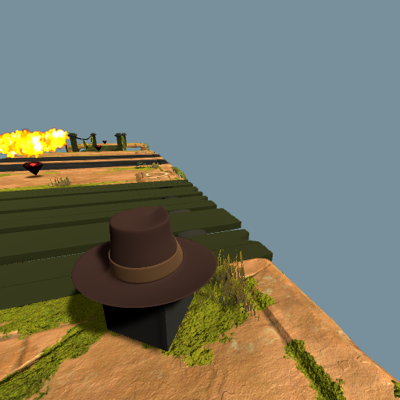
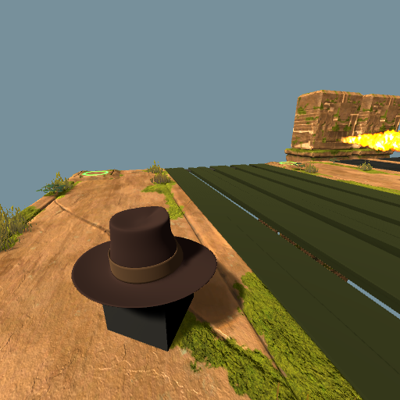

In [86]:
from IPython.display import HTML
display(HTML(html))